This evaluation pipeline does 2 things:

First, it checks the quality of the question generated and its relevance to the documents. If the quality is trivial, or the sentence formatting is ambiguous (e.g. "What is the purpose of scripting and executing immediate corrective actions?" or "What does the 'get' function do?"), GPT will detect that and the associated entry should be removed from the finetuning pipeline.

Secondly, this file includes a prompt that is able to use GPT-4 as the critic on the answer given provided question. It can work in two ways:

**absolute:** will output a likert scale on the quality of the answer given the question and the top 5 most relevant documents (in the same embedding schema used in q-a pair generation).

**relative:** given the prompt, the 5 most relevant documents via OpenAI Embedding, and 2 candidate answers, one generated by GPT-4 is called 'reference', and the one generated by the open source model (in our case, MPT-30B-Chat or its finetuned version in later iterations) will be called 'prediction'), and GPT-4 critic is able to tell which one is superior in terms of supportiveness and adherence to the original documents.

In [ ]:
# Install dependencies
!pip install langchain===0.0.230 openai chromadb==0.3.26 pydantic==1.10.8 GitPython ipython tiktoken
!pip install unstructured==0.8.5 pdf2image pytesseract pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 47.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 14.0 MB/s eta 0:00:00
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184489 sha256=5e1c49959be79ecf2d643c7d64c48d64658369c2091ea251a99d2114fda08a3f
  Stored in directory: /root/.cache/pip/wheels/80/27/06/837436d4c3bd989b957a

In [ ]:
import os
from langchain.document_loaders import GitLoader, UnstructuredPDFLoader, OnlinePDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, Language
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.vectorstores import Chroma
from langchain.llms import OpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import RetrievalQAWithSourcesChain, RetrievalQA
from IPython.display import display
from IPython.display import Markdown
from getpass import getpass
from pathlib import Path
from langchain.callbacks import StdOutCallbackHandler
from langchain.prompts import PromptTemplate
from langchain.callbacks import get_openai_callback
from langchain import LLMChain
from langchain.chat_models import ChatOpenAI
import json

stdout_handler = StdOutCallbackHandler()

In [ ]:
# setting up an OpenAI template on the run
OPENAI_API_KEY = getpass()

··········


In [ ]:
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [ ]:
# Load repository with .md files as targets to split and store
def load_repo(remote_repo_url, local_repo_path, branch, file_filter=None):
    local_repo_exists = Path(local_repo_path).is_dir() # second and later loadings

    if local_repo_exists:
        loader = GitLoader(
            repo_path=local_repo_path,
            branch=branch,
            file_filter=file_filter
        )
    else:
        loader = GitLoader(
            clone_url=remote_repo_url,
            repo_path=local_repo_path,
            branch=branch,
            file_filter=file_filter
        )
    return loader.load() # load the required source files

# Load PDF documents
def load_pdf(file_path):
    loader = UnstructuredPDFLoader(file_path)
    return loader.load()

def load_online_pdf(file_url):
    loader = OnlinePDFLoader(file_url)
    return loader.load()

# Load single md document from drive/filesystem
def load_md(markdown_path):
    loader = TextLoader(markdown_path) # raw, do not parse md. https://github.com/langchain-ai/langchain/issues/3591
    return loader.load()

def split_docs(docs, language, chunk_size, chunk_overlap, force_category):
    text_splitter = RecursiveCharacterTextSplitter.from_language(language=language, chunk_size=chunk_size, chunk_overlap=chunk_overlap)

    all_splits=[]
    all_metadatas=[]
    for d in docs:
        doc_file = d.page_content
        metadata = d.metadata # metadata including filepath, filename, other stuffs
        splits = text_splitter.split_text(doc_file) # parse the document to small chunk of code snippets

        metadata['category'] = force_category

        # this is only for governance type questions
        if metadata['source'].split('.')[-1] == 'md':
          title = f"# {metadata['file_name'].split('.')[0]}"
          for i in range(len(splits)):
            splits[i] = f"{title}\n\n{splits[i]}" # string is immutable, must write explitly


        metadatas = [metadata for _ in splits]
        all_splits += splits
        all_metadatas += metadatas # collecting metadata headers and the splited chunks from each document.

    return {
        'all_splits': all_splits,
        'all_metadatas': all_metadatas # pack as dict/json
    }

def split_pdf(docs, chunk_size, chunk_overlap, force_category):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap) # no language as pdf is parsed as plain txt

    all_splits=[]
    all_metadatas=[]
    for d in docs:
        doc_file=d.page_content
        metadata = d.metadata # metadata including filepath, filename, other stuffs
        splits = text_splitter.split_text(doc_file) # parse the document to small chunk of code snippets

        metadata['category'] = force_category

        metadatas = [metadata for _ in splits]
        all_splits += splits
        all_metadatas += metadatas # collecting metadata headers and the splited chunks from each document.

    return {
        'all_splits': all_splits,
        'all_metadatas': all_metadatas # pack as dict/json
    }

In [ ]:
from langchain.text_splitter import MarkdownTextSplitter
def split_md(docs, chunk_size, chunk_overlap, force_category):
    text_splitter = MarkdownTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

    all_splits=[]
    all_metadatas=[]
    for d in docs:
        doc_file = d.page_content
        metadata = d.metadata # metadata including filepath, filename, other stuffs
        splits = text_splitter.split_text(doc_file) # parse the document to small chunk of code snippets

        metadata['category'] = force_category

        metadatas = [metadata for _ in splits]
        all_splits += splits
        all_metadatas += metadatas # collecting metadata headers and the splited chunks from each document.

    return {
        'all_splits': all_splits,
        'all_metadatas': all_metadatas # pack as dict/json
    }

In [ ]:
# documentation repo
remote_repo_docsV2_url="https://github.com/yieldprotocol/docs-v2" # the docs all coming from the github repo (public)
local_repo_docsV2_path="/tmp/yield_docs_v2_repo"

# cookbook repo
remote_repo_addendum_url="https://github.com/yieldprotocol/addendum-docs"
local_repo_addendum_path="/tmp/yield_addendum-docs"

# governance repo, the documents under this repo is kinda problematic, does not have a lot of content, most are link to external files
# thinking of whether to load the files affected by governance-v2 as well?
remote_repo_governance_url = "https://github.com/yieldprotocol/governance-v2"
local_repo_governance_path = "/tmp/governance-v2"

branch="main" # specify the branch of the remote repo urls
file_filter=lambda file_path: file_path.endswith(".md") # select only .md files as 'documentations'

chunk_size_chars = 2000 # context length required, in SFT chunk it to 1000 at evaluation
chunk_overlap_chars = 0 # no overlapping since containing code chunk

documentation_docs = load_repo(remote_repo_docsV2_url, local_repo_docsV2_path, branch, file_filter)
addendum_docs = load_repo(remote_repo_addendum_url, local_repo_addendum_path, branch, file_filter)
governance_docs = load_repo(remote_repo_governance_url, local_repo_governance_path, branch, file_filter)

documentation_splits = split_docs(documentation_docs, Language.MARKDOWN, chunk_size_chars, chunk_overlap_chars, force_category='general')
addendum_splits = split_docs(addendum_docs, Language.MARKDOWN, chunk_size_chars, chunk_overlap_chars, force_category='technical')
governance_splits = split_docs(governance_docs, Language.MARKDOWN, chunk_size_chars, chunk_overlap_chars, force_category='governance')

# trim down first and last file of gov_splits, as there are placeholders
governance_splits['all_splits'] = governance_splits['all_splits'][1:]
governance_splits['all_metadatas'] = governance_splits['all_metadatas'][1:]

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from google.colab import drive
drive.mount('/content/drive/')

whitepaper_data = load_online_pdf(file_url="https://yieldprotocol.com/Yield.pdf")
yieldspace_data = load_md(markdown_path="/content/drive/MyDrive/YieldSpace.md")

# sanitize the source
whitepaper_data[0].metadata['source'] = "https://yieldprotocol.com/Yield.pdf"
yieldspace_data[0].metadata['source'] = "https://yieldprotocol.com/YieldSpace.pdf"

whitepaper_splits = split_pdf(whitepaper_data, 2000, chunk_overlap_chars, force_category="paper")
yieldspace_splits = split_md(yieldspace_data, 2500, 0, force_category="paper")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
vector_db = Chroma(embedding_function=OpenAIEmbeddings())
# chunking them already
documentation_splits_ids = vector_db.add_texts(documentation_splits['all_splits'], documentation_splits['all_metadatas'])
addendum_splits_ids = vector_db.add_texts(addendum_splits['all_splits'], addendum_splits['all_metadatas'])
governance_splits_ids = vector_db.add_texts(governance_splits['all_splits'], governance_splits['all_metadatas'])
whitepaper_splits_ids = vector_db.add_texts(whitepaper_splits['all_splits'], whitepaper_splits['all_metadatas'])
yieldspace_splits_ids = vector_db.add_texts(yieldspace_splits['all_splits'], yieldspace_splits['all_metadatas'])

# Last Round Clean Up for QA Dataset

In [ ]:
import json
from google.colab import drive
drive.mount('/content/drive/')
path_prefix = f"/content/drive/MyDrive/"
path_suffix = f".jsonl"

# deduplicate bad docs from the governance splits, similar issues can be found in bad-partitioned documents, but minor in docs/addendum/pdfs
file_list = ["governance_long_qa_1", "governance_long_qa_2", "governance_long_qa_3"]

all_qa_pairs = []

bad_idxs = [22, 49, 53, 66, 93, 123, 126, 129, 135, 141, 151, 152, 153, 155, 161, 168, 212, 216, 222, 230, 262, 266, 267, 272, 314, 330, 332, 341, 356, 359, 364, 381, 386, 387, 391,
402, 407, 408, 411, 418, 420, 421, 428, 432, 433, 434, 435, 436, 437, 438, 439, 440, 444, 446, 450, 451, 458, 465, 466, 471, 472, 480, 481, 482, 484, 495, 496, 497, 498, 499,
500, 501, 503, 508, 511, 512, 515, 515, 518, 522, 523, 532]

bad_docs = [governance_splits['all_splits'][i-1] for i in bad_idxs]
print(len(all_qa_pairs))
for bad_doc in bad_docs:
  print(f"Indeed bad: {bad_doc}")

bad_qa_pairs = []
# the gpt is not adhering on generating 3 questions per document principle from here.

for file_name in file_list:
  path = f"{path_prefix}{file_name}{path_suffix}"
  with open(path, 'r') as f:
    for line in f:
      line = line.rstrip('\n')
      obj = json.loads(line)
      all_qa_pairs.append(obj)
      if(obj['contexts'][0] in bad_docs):
        bad_qa_pairs.append(obj)

for bad_qa_pair in bad_qa_pairs:
  print(bad_qa_pair['contexts'][0])

governance_qa_pairs = [qa_pair for qa_pair in all_qa_pairs if qa_pair not in bad_qa_pairs]

print(len(governance_qa_pairs))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
0
Indeed bad: # YPP-0013

```
Indeed bad: # YPP-0019

## Proposal Config
Indeed bad: # YPP-0019

```
Indeed bad: # YPP-0022

```
Indeed bad: # YPP-0029

```
Indeed bad: # YPP-0033

## Configuration
Indeed bad: # YPP-0033

```
Indeed bad: # YPP-0034

## Proposal Config
Indeed bad: # YPP-0034

```
Indeed bad: # YPP-0034

```
Indeed bad: # YPP-0040

Calldata:
Indeed bad: # YPP-0040

0xca02753a00000000000000000000000000000000000000000000000000000000000000200000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000008000000000000000000000000000000000000000000000000000000000000001c00000000000000000000000000000000000000000000000000000000000000300000000000000000000000000000000000000000000000000000000000000040000000000000000000000000053c3760670f6091e1ec76b4dd27f73ba4cad50610000000000000000000000000000

In [ ]:
for i, split in enumerate(governance_splits['all_splits']):
  display(Markdown(f"# Chunk {i+1}"))
  display(Markdown(split))
# (1-index) 22, 49, 53, 66, 93, 123, 126, 129, 135, 141, 151, 152, 153, 155, 161, 168, 212, 216, 222, 230, 262, 266, 267, 272, 314, 330, 332, 341, 356, 359, 364, 381, 386, 387, 391,
# 402, 407, 408, 411, 418, 420, 421, 428, 432, 433, 434, 435, 436, 437, 438, 439, 440, 444, 446, 450, 451, 458, 465, 466, 471, 472, 480, 481, 482, 484, 495, 496, 497, 498, 499
# 500, 501, 503, 508, 511, 512, 515, 515, 518, 522, 523, 532

# Chunk 1

# YPP-0004

# Proposal
Give developer role to 0xC7aE076086623ecEA2450e364C838916a043F9a8, controlled by @alcueca

# Background
There aren't any accounts with a developer role, which allows for a safer operation of the protocol. Developers can propose and execute governance proposals, but not approve them. Developers can also execute emergency plans, but not register them or restore permissions.

# Details

```
  const newDeveloper = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
  const proposal: Array<{ target: string; data: string }> = []
  proposal.push({
    target: timelock.address,
    data: timelock.interface.encodeFunctionData('grantRoles', [
      [
        '0xca02753a', // propose,
        '0x013a652d', // proposeRepeated
        '0xbaae8abf', // execute
        '0xf9a28e8b', // executeRepeated
      ],
      newDeveloper,
    ]),
  })
  proposal.push({
    target: cloak.address,
    data: cloak.interface.encodeFunctionData('grantRoles', [
      [
        id(cloak.interface, 'execute(bytes32)')
      ],
      newDeveloper,
    ]),
  })
```

# Chunk 2

# YPP-0005

# Proposal
Give developer role to 0x2bBA525c4891603C4c37F635d899918B6a23aCFf, controlled by @aniemerg

# Background
There is only one account with a developer role, which allows for execution of emergency plans, among other rights. For safe 24h operations we need accounts with developer roles in all timezones.

Developers can propose and execute governance proposals, but not approve them. Developers can also execute emergency plans, but not register them or restore permissions.

# Details

```
  const newDeveloper = '0x2bBA525c4891603C4c37F635d899918B6a23aCFf'
  const proposal: Array<{ target: string; data: string }> = []
  proposal.push({
    target: timelock.address,
    data: timelock.interface.encodeFunctionData('grantRoles', [
      [
        '0xca02753a', // propose,
        '0x013a652d', // proposeRepeated
        '0xbaae8abf', // execute
        '0xf9a28e8b', // executeRepeated
      ],
      newDeveloper,
    ]),
  })
  proposal.push({
    target: cloak.address,
    data: cloak.interface.encodeFunctionData('grantRoles', [
      [
        id(cloak.interface, 'execute(bytes32)')
      ],
      newDeveloper,
    ]),
  })
```

# Chunk 3

# YPP-0006

# Proposal
Raise DAI/ETH and USDC/ETH ceiling limits to 500K DAI and 500K USDC respectively

# Background
Due to unprecedented demand, the limits for borrowing DAI or USDC with ETH as collateral have already been reached.

At the same time, there haven't been any major incidents yet, and samczsun hasn't managed to hack Yield v2, so we feel more confident in the protocol.

# Details
The updateCeiling.ts script will be used, with this input:

```
/**
 * @dev Input file for updateCeiling.ts
 */

import { ETH, DAI, USDC, WBTC, USDT } from '../../../shared/constants'

// Input data: baseId, ilkId, maxDebt
export const newMax: Array<[string, string, number]> = [
  [DAI, ETH, 500000],
  [USDC, ETH, 500000],
]
```

# Chunk 4

# YPP-0007

# Proposal
Enable wstETH as a collateral for DAI and USDC

# Background
wstETH has a $359M market cap, is yield-bearing, and has limited options to be used as collateral. This is an initial step to add ETH-denominated series, and stETH as collateral via wrapping into wstETH.

# Chunk 5

# YPP-0007

# Details

**1. Deploy LidoOracle**

The [deployLidoOracle.ts](https://github.com/yieldprotocol/environments-v2/blob/1d5ced1399ded4b4389a2ee1bd1d1234ca5ce283/scripts/operations/oracles/deployLidoOracle.ts) script will be used, with no input.

**2. Deploy CompositeMultiOracle**

The [deployCompositeOracle.ts](https://github.com/yieldprotocol/environments-v2/blob/gov/ypp-0007/scripts/operations/oracles/deployCompositeOracle.ts) script will be used, with no input.

**3. Add WstETH as an asset, and reserve the stETH id in the Cauldron**

The [ypp-0007-3.ts](https://github.com/yieldprotocol/environments-v2/blob/5999b5e9f905ed93ffe34c84968b0db27871acdd/scripts/operations/governance/ypp-0007/ypp-0007-3.ts) script will be used, with this input:

```
   // https://docs.lido.fi/deployed-contracts
  const wstEthAddress: string = '0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0'
  const stEthAddress: string = '0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84'
  
  const addedAssets: Array<[string, string]> = [
    [WSTETH, wstEthAddress],
  ]
  const reservedAssets: Array<[string, string]> = [
    [STETH, stEthAddress],
  ]

```

**4. Configure the protocol**

The rest of the configuration will be condensed into a single proposal with the [ypp-0007-4.ts](https://github.com/yieldprotocol/environments-v2/blob/5999b5e9f905ed93ffe34c84968b0db27871acdd/scripts/operations/governance/ypp-0007/ypp-0007-4.ts) script, which includes these actions:

1. Configure the permissions for the Lido Oracle
2. Add WstETH as the source for the Lido Oracle
3. Add the stETH/ETH source to the Chainlink Oracle
4. Deploy the Composite Oracle
5. Add the underlying sources for the Composite Oracle
6. Add the DAI/WSTETH and USDC/WSTETH paths in the Composite Oracle
7. Permission the WstETHJoin
8. Make WstETH into an Ilk
9. Approve WstEth as collateral for all series

And these inputs:

# Chunk 6

# YPP-0007

```
  const CHAINLINK = 'chainlinkOracle'
  const LIDO = 'lidoOracle'
  const COMPOSITE = 'compositeOracle'

  const wstEthAddress: string = '0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0' // https://docs.lido.fi/deployed-contracts
  const stEthAddress: string = '0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84' // https://docs.lido.fi/deployed-contracts
  const wethAddress: string = '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'
  // Input data: baseId, base address, quoteId, quote address, oracle name, source address
  const stEthEthSource: Array<[string, string, string, string, string, string]> = [
    [STETH, stEthAddress, ETH, wethAddress, CHAINLINK,  '0x86392dC19c0b719886221c78AB11eb8Cf5c52812'], // https://docs.lido.fi/deployed-contracts
  ]
  // Input data: baseId, quoteId, oracle name
  const compositeSources: Array<[string, string, string]> = [
    [DAI,    ETH,   CHAINLINK],
    [USDC,   ETH,   CHAINLINK],
    [WBTC,   ETH,   CHAINLINK],
    [STETH,  ETH,   CHAINLINK],
    [WSTETH, STETH, LIDO],
  ]
  // Input data: assetId, assetId, [intermediate assetId]
  const compositePaths: Array<[string, string, Array<string>]> = [
    [WSTETH, DAI, [STETH, ETH]],
    [WSTETH, USDC, [STETH, ETH]],
  ]
  // Input data: assetId, asset address
  const assets: Array<[string, string]> = [
    [WSTETH, wstEthAddress],
  ]
  // Input data: baseId, ilkId, oracle name, ratio (1000000 == 100%), inv(ratio), line, dust, dec
  const ilks: Array<[string, string, string, number, number, number, number, number]> = [
    [DAI, WSTETH, COMPOSITE, 1400000, 714000, 500000, 1, 18],
    [USDC, WSTETH, COMPOSITE, 1400000, 714000, 500000, 1, 6],
  ]
  // Input data: seriesId, [ilkId]
  const seriesIlks: Array<[string, string[]]> = [
    [stringToBytes6('0104'), [WSTETH]],
    [stringToBytes6('0105'), [WSTETH]],
    [stringToBytes6('0204'), [WSTETH]],
    [stringToBytes6('0205'), [WSTETH]],
  ]
```

# Chunk 7

# YPP-0007

# Testing
The change has been tested on a mainnet fork by posting wstETH to all series, borrowing, repaying and wthdrawing. [Script](https://github.com/yieldprotocol/environments-v2/blob/feat/composite-oracle/scripts/operations/governance/ypp-0007/ypp-0007.test.ts).
```
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/operations/governance/ypp-0007/ypp-0007.test.ts 
No need to generate any newer typings.
Running on a fork, impersonating 0xdaef20ea4708fcff06204a4fe9ddf41db056ba18
6897357956874283776035 wstETH available
series: 0x303130340000
vault: 0x3b566fb4defd155c3235cee3
posted and borrowed
repaid and withdrawn
series: 0x303130350000
vault: 0x7749751febed1b3925df8764
posted and borrowed
repaid and withdrawn
series: 0x303230340000
vault: 0x1ff4c3b2edfd32b60b942cd1
posted and borrowed
repaid and withdrawn
series: 0x303230350000
vault: 0x72ee485080a190a40961dab7
posted and borrowed
repaid and withdrawn
```

# Chunk 8

# YPP-0008

# Proposal
Remove all permissions from deployer.

# Background
The deployer account at 0xa072f81fea73ca932ab2b5eda31fa29306d58708 was used to deploy the protocol bypassing the multisig. Now it is a risk in that it is a single account with total control over the protocol. This proposal will remove all permissions from the deployer to remove that risk.

# Details
The [ypp-0008.ts](https://github.com/yieldprotocol/environments-v2/blob/fa7e8dcbd90770e7ab205eeb82fae239fabb3547/scripts/operations/governance/ypp-0008/ypp-0008.ts) script will be executed, taking as its sole input the deployer address:
```
const deployer: string = '0xA072f81Fea73Ca932aB2B5Eda31Fa29306D58708'
```

# Chunk 9

# YPP-0009

# Proposal
Raise the dust level in all base/collateral pairs

# Background
The dust (min debt) level for a vault is set to $1 currently. This leads to situations where vaults become unprofitable to liquidate. This proposal will increase the dust level so that the probability of liquidations providing some profits increases.

# Details
The [ypp-0009.ts](https://github.com/yieldprotocol/environments-v2/blob/ops/raise-dust-level/scripts/operations/governance/ypp-0009/ypp-0009.ts) script will be used, with this input:
```
/**
 * @dev Input file for ypp-0009.ts
 */

import { ETH, DAI, USDC, WBTC, WSTETH } from '../../../../shared/constants'

// Input data: baseId, ilkId, maxDebt
export const newMin: Array<[string, string, number]> = [
  [DAI, ETH, 100],
  [DAI, WSTETH, 100],
  [DAI, USDC, 100],
  [DAI, WBTC, 100],
  [USDC, ETH, 100],
  [USDC, WSTETH, 100],
  [USDC, DAI, 100],
  [USDC, WBTC, 100],
]

```

# Chunk 10

# YPP-0009

# Testing
The change has been tested on a mainnet fork by running [ypp-0009.ts](https://github.com/yieldprotocol/environments-v2/blob/ops/raise-dust-level/scripts/operations/governance/ypp-0009/ypp-0009.ts) first followed by [ypp-0009.test.ts](https://github.com/yieldprotocol/environments-v2/blob/ops/raise-dust-level/scripts/operations/governance/ypp-0009/ypp-0009.test.ts) to verify that the changes were made.

# Chunk 11

# YPP-0009

```
Praffuls-MacBook-Pro:environments-v2 praffulsahu$ npx hardhat run --network localhost scripts/operations/governance/ypp-0009/ypp-0009.ts
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00: 1 -> 100
01/04: 1 -> 100
01/02: 1 -> 100
01/03: 1 -> 100
02/00: 1 -> 100
02/04: 1 -> 100
02/01: 1 -> 100
02/03: 1 -> 100
Proposal: 0x0e7582164127ebae0e846a4d5349baf829949a9c9346c927c054f83cc9956d7b
Proposed 0x0e7582164127ebae0e846a4d5349baf829949a9c9346c927c054f83cc9956d7b

Praffuls-MacBook-Pro:environments-v2 praffulsahu$ npx hardhat run --network localhost scripts/operations/governance/ypp-0009/ypp-0009.ts
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00: 1 -> 100
01/04: 1 -> 100
01/02: 1 -> 100
01/03: 1 -> 100
02/00: 1 -> 100
02/04: 1 -> 100
02/01: 1 -> 100
02/03: 1 -> 100
Proposal: 0x0e7582164127ebae0e846a4d5349baf829949a9c9346c927c054f83cc9956d7b
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Approved 0x0e7582164127ebae0e846a4d5349baf829949a9c9346c927c054f83cc9956d7b

Praffuls-MacBook-Pro:environments-v2 praffulsahu$ npx hardhat run --network localhost scripts/operations/governance/ypp-0009/ypp-0009.ts
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00: 1 -> 100
01/04: 1 -> 100
01/02: 1 -> 100
01/03: 1 -> 100
02/00: 1 -> 100
02/04: 1 -> 100
02/01: 1 -> 100
02/03: 1 -> 100
Proposal: 0x0e7582164127ebae0e846a4d5349baf829949a9c9346c927c054f83cc9956d7b
Running on a fork, will execute
Executed 0x0e7582164127ebae0e846a4d5349baf829949a9c9346c927c054f83cc9956d7b

# Chunk 12

# YPP-0009

Praffuls-MacBook-Pro:environments-v2 praffulsahu$ npx hardhat run --network localhost scripts/operations/governance/ypp-0009/ypp-0009.test.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
01/00 set: 100
01/04 set: 100
01/02 set: 100
01/03 set: 100
02/00 set: 100
02/04 set: 100
02/01 set: 100
02/03 set: 100
```

# Chunk 13

# YPP-0010

# Proposal
Deploy a stEth/wstEth wrapper and integrate it with the Ladle to allow wrapping/unwrapping of stEth as part of a batch.

# Background
We already accept wstEth as a collateral, but the number of wstEth holders as compared to stEth holders is very small. Allowing to wrap stEth into wstEth as part of a batch would increase the potential impact of having stEth as a collateral.

# Details
The proposal includes two mainnet executions, the second one to be approved by the multisig.
1. Deploy the StEthConverter using [this script](https://github.com/yieldprotocol/environments-v2/blob/7fa485f4dd0694aec6becb0f2fa1b57539b03056/scripts/governance/add/addStEthConverter/deployStETHConverter.ts). The StEthConverter doesn't have any relationship to the Yield Protocol, and knows only of the stEth and wstEth contracts.
2. Configure stEth, wstEth and the StEthConverter in the Ladle, allowing to move stEth and wstEth tokens, and routing calls to the StEthConverter. This configuration would be done with [this script](https://github.com/yieldprotocol/environments-v2/blob/7fa485f4dd0694aec6becb0f2fa1b57539b03056/scripts/governance/add/addStEthConverter/addStETHConverter.ts).

# Testing
The testing can be done on a mainnet fork using [this script](https://github.com/yieldprotocol/environments-v2/blob/7fa485f4dd0694aec6becb0f2fa1b57539b03056/scripts/governance/add/addStEthConverter/addStETHConverter.test.ts)

```
$ npx hardhat test scripts/governance/add/addStEthConverter/addStETHConverter.test.ts --network localhost
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!

StEthConverter
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
    ✓ routes calls through the Ladle (298240 gas)
    ✓ transfers wstEth through the Ladle (210210 gas)
    ✓ transfers stEth through the Ladle (183577 gas)

  3 passing (12s)
```

# Chunk 14

# YPP-0012

# Proposal
Raise the ceiling level for USDC/ETH to 1000000

# Background
The ceiling (max debt) level for USDC borrowing with ETH collateral is set to 500,000 currently, while the total borrowed amount for that pair is 335,851.

# Details
The [updateCeiling.ts](https://github.com/yieldprotocol/environments-v2/blob/feat/update-ceiling/scripts/operations/governance/updateCeiling/updateCeiling.ts) script will be used, with this input:
```
// Input data: baseId, ilkId, maxDebt
export const newMax: Array<[string, string, number]> = [
  [USDC, ETH, 1000000],
]

```

# Chunk 15

# YPP-0012

# Testing
The change has been tested on a mainnet fork by running [updateCeiling.ts](https://github.com/yieldprotocol/environments-v2/blob/feat/update-ceiling/scripts/operations/governance/updateCeiling/updateCeiling.ts) first followed by [updateCeiling.test.ts](https://github.com/yieldprotocol/environments-v2/blob/feat/update-ceiling/scripts/operations/governance/updateCeiling/updateCeiling.test.ts) to verify that the changes were made.

# Chunk 16

# YPP-0012

```
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/operations/governance/updateCeiling/updateCeiling.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
02/00: 500000 -> 1000000
Proposal: 0x1841bcf0cba598a418d14d48e993dcd99737fdcaa2f20e2ff0c2b16fc1a95b5f
Proposed 0x1841bcf0cba598a418d14d48e993dcd99737fdcaa2f20e2ff0c2b16fc1a95b5f

alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/operations/governance/updateCeiling/updateCeiling.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
02/00: 500000 -> 1000000
Proposal: 0x1841bcf0cba598a418d14d48e993dcd99737fdcaa2f20e2ff0c2b16fc1a95b5f
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Approved 0x1841bcf0cba598a418d14d48e993dcd99737fdcaa2f20e2ff0c2b16fc1a95b5f

alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/operations/governance/updateCeiling/updateCeiling.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
02/00: 500000 -> 1000000
Proposal: 0x1841bcf0cba598a418d14d48e993dcd99737fdcaa2f20e2ff0c2b16fc1a95b5f
Executed 0x1841bcf0cba598a418d14d48e993dcd99737fdcaa2f20e2ff0c2b16fc1a95b5f

# Chunk 17

# YPP-0012

alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/operations/governance/updateCeiling/updateCeiling.test.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
02/00 set: 1000000

```

# Chunk 18

# YPP-0013

# Proposal
Raise the ceiling level for USDC/ETH to 1000000

# Background
The ceiling (max debt) level for USDC borrowing with ETH collateral is set to 500,000 currently, while the total borrowed amount for that pair is 335,851.

# Details
The [updateCeiling.ts](https://github.com/yieldprotocol/environments-v2/blob/744aa0db5329bcb1368cca67126fba2ebe7aa083/scripts/operations/governance/updateCeiling/updateCeiling.ts) script will be used, with this input:
```
// Input data: baseId, ilkId, maxDebt
export const newMax: Array<[string, string, number]> = [
  [DAI, ETH, 1000000],
]

```

# Chunk 19

# YPP-0013

# Testing
The change has been tested on a mainnet fork by running [updateCeiling.ts](https://github.com/yieldprotocol/environments-v2/blob/744aa0db5329bcb1368cca67126fba2ebe7aa083/scripts/operations/governance/updateCeiling/updateCeiling.ts) first followed by [updateCeiling.test.ts](https://github.com/yieldprotocol/environments-v2/blob/744aa0db5329bcb1368cca67126fba2ebe7aa083/scripts/operations/governance/updateCeiling/updateCeiling.test.ts) to verify that the changes were made.

# Chunk 20

# YPP-0013

```
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/operations/governance/updateCeiling/updateCeiling.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00: 500000 -> 1000000
Proposal: 0xa08e8c9a644018a79e7742ffd25e7a19fde2a45064456e5ced3a014dec8f6296
Proposed 0xa08e8c9a644018a79e7742ffd25e7a19fde2a45064456e5ced3a014dec8f6296
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/operations/governance/updateCeiling/updateCeiling.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00: 500000 -> 1000000
Proposal: 0xa08e8c9a644018a79e7742ffd25e7a19fde2a45064456e5ced3a014dec8f6296
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Approved 0xa08e8c9a644018a79e7742ffd25e7a19fde2a45064456e5ced3a014dec8f6296
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/operations/governance/updateCeiling/updateCeiling.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00: 500000 -> 1000000
Proposal: 0xa08e8c9a644018a79e7742ffd25e7a19fde2a45064456e5ced3a014dec8f6296
Executed 0xa08e8c9a644018a79e7742ffd25e7a19fde2a45064456e5ced3a014dec8f6296
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/operations/governance/updateCeiling/updateCeiling.test.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1

# Chunk 21

# YPP-0013

Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00 set: 1000000

# Chunk 22

# YPP-0013

```

# Chunk 23

# YPP-0014

# Proposal
Enable ENS as a collateral for DAI and USDC

# Background
ENS has a $4,580M market cap and 58K holders, while the market has still scarce options to use it as collateral. Enabling it as a collateral in the yield Protocol is expected to spur borrowing demand.

To enable ENS as a collateral we will be using the ETH/ENS 0.3% Uniswap v3 Pool as a source of price data. The debt ceiling for ENS against all underlyings won't exceed the $12.45m TVL of the pool.

# Chunk 24

# YPP-0014

# Details

**1. Deploy UniswapOracle**

The [deployUniswapOracle.ts](https://github.com/yieldprotocol/environments-v2/blob/54f94d6c8bf94ebf0e0a060a425c7a63bd8c113c/scripts/operations/oracles/uniswap/deployUniswapOracle.ts) script will be used, with no input.

**2. Orchestrate and configure oracles**

The [addENS-2.ts](https://github.com/yieldprotocol/environments-v2/blob/54f94d6c8bf94ebf0e0a060a425c7a63bd8c113c/scripts/operations/governance/addCompositeCollateral/addENS-2.ts) script will be used, with this input:

# Chunk 25

# YPP-0014

```
  const UNISWAP = 'uniswapOracle'
  const CHAINLINK = 'chainlinkOracle'

  const ensEthPoolAddress: string = '0x92560c178ce069cc014138ed3c2f5221ba71f58a' // https://info.uniswap.org/#/tokens/0xc18360217d8f7ab5e7c516566761ea12ce7f9d72
  const kovanEnsEthSource = '0x19d7cCdB7B4caE085d3Fda330A01D139d7243Be4' // From spotSources.json in addresses archive
  const kovanEnsAddress = '0xA24b97c7617cc40dCc122F6dF813584A604a6C28' // From assets.json in addresses archive
  const kovanWethAddress = '0x55C0458edF1D8E07DF9FB44B8960AecC515B4492' // From assets.json in addresses archive

  // Input data: baseId, quoteId, oracle name, pool address and twapInterval. baseId must match token0 and quoteId must match token1.
  const uniswapSources: Array<[string, string, string, string, number]> = [[ETH, ENS, UNISWAP, ensEthPoolAddress, 600]]

  // Input data: baseId, base address, quoteId, quote address, oracle name, source address
  const chainlinkSources: Array<[string, string, string, string, string, string]> = [
    [ENS, kovanEnsAddress as string, ETH, kovanWethAddress as string, CHAINLINK, kovanEnsEthSource],
  ]
  // Input data: baseId, quoteId, oracle name
  const compositeSources: Map<number, Array<[string, string, string]>> = new Map([
    [1, [[ENS, ETH, UNISWAP]]],
    [42, [[ENS, ETH, CHAINLINK]]],
  ])
  // Input data: assetId, assetId, [intermediate assetId]
  const compositePaths: Array<[string, string, Array<string>]> = [
    [ENS, DAI, [ETH]],
    [ENS, USDC, [ETH]],
  ]
```

Executing this step allows us to [test](https://github.com/yieldprotocol/environments-v2/blob/54f94d6c8bf94ebf0e0a060a425c7a63bd8c113c/scripts/operations/governance/addCompositeCollateral/addENS.test.ts) already the ENS/ETH/, ENS/DAI and ENS/USDC prices:

# Chunk 26

# YPP-0014

```
$ npx hardhat run --network localhost scripts/operations/governance/addCompositeCollateral/getENSPrice.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
ENS/ETH: 11254630275577490,1637321573
ETH/ENS: 88852319046854573595,1637321573
ENS/DAI: 46704612562947242241,0
DAI/ENS: 21411161449037316,0
ENS/USDC: 46429992,0
USDC/ENS: 21537802136957548639588635289,0
```

**3. Add ENS as an asset using the Wand**

The [addENS-3.ts](https://github.com/yieldprotocol/environments-v2/blob/54f94d6c8bf94ebf0e0a060a425c7a63bd8c113c/scripts/operations/governance/addCompositeCollateral/addENS-3.ts) script will be used, with this input:

```
  const ensAddress = new Map([
    [1, '0xC18360217D8F7Ab5e7c516566761Ea12Ce7F9D72'],
    [42, '0xA24b97c7617cc40dCc122F6dF813584A604a6C28'],
  ]) // https://ens.mirror.xyz/5cGl-Y37aTxtokdWk21qlULmE1aSM_NuX9fstbOPoWU
  
  const addedAssets: Array<[string, string]> = [
    [ENS, ensAddress.get(chainId) as string],
  ]

```

**4. Configure the protocol**

The rest of the configuration will be condensed into a single proposal with the [addENS-4.ts](https://github.com/yieldprotocol/environments-v2/blob/54f94d6c8bf94ebf0e0a060a425c7a63bd8c113c/scripts/operations/governance/addCompositeCollateral/addENS-4.ts) script, which includes these actions:

1. Permission the ENSJoin
2. Make ENS into an Ilk
3. Approve ENS as collateral for all series

And these inputs:

# Chunk 27

# YPP-0014

```
  const COMPOSITE = 'compositeOracle'

  const ensAddress = new Map([
    [1, '0xC18360217D8F7Ab5e7c516566761Ea12Ce7F9D72'],
    [42, '0xA24b97c7617cc40dCc122F6dF813584A604a6C28'],
  ]) // https://ens.mirror.xyz/5cGl-Y37aTxtokdWk21qlULmE1aSM_NuX9fstbOPoWU
  
  // Input data: assetId, asset address
  const addedAssets: Array<[string, string]> = [
    [ENS, ensAddress.get(chainId) as string],
  ]
  // Input data: baseId, ilkId, oracle name, ratio (1000000 == 100%), inv(ratio), line, dust, dec
  const ilks: Array<[string, string, string, number, number, number, number, number]> = [
    [DAI, ENS, COMPOSITE, 1670000, 600000, 500000, 100, 18],
    [USDC, ENS, COMPOSITE, 1670000, 600000, 500000, 100, 6],
  ]
  // Input data: seriesId, [ilkId]
  const seriesIlks: Array<[string, string[]]> = [
    [stringToBytes6('0104'), [ENS]],
    [stringToBytes6('0105'), [ENS]],
    [stringToBytes6('0204'), [ENS]],
    [stringToBytes6('0205'), [ENS]],
  ]
```

# Chunk 28

# YPP-0014

# Testing
The change has been tested on a mainnet fork by posting ENS to all series, borrowing, repaying and wthdrawing. [Script](https://github.com/yieldprotocol/environments-v2/blob/54f94d6c8bf94ebf0e0a060a425c7a63bd8c113c/scripts/operations/governance/addCompositeCollateral/addENS.test.ts).
```
$ npx hardhat run --network localhost scripts/operations/governance/addCompositeCollateral/addENS.test.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
65532017200000000000000000 ENS available
series: 0x303130340000
vault: 0x11000df708d0c0ce84929b99
posted and borrowed
repaid and withdrawn
series: 0x303130350000
vault: 0x48a84506528015d548819131
posted and borrowed
repaid and withdrawn
series: 0x303230340000
vault: 0x9433ee0ef41c983b6ee795b0
posted and borrowed
repaid and withdrawn
series: 0x303230350000
vault: 0x749cff617e7cd873f1897420
posted and borrowed
repaid and withdrawn
```

# Chunk 29

# YPP-0015

# Proposal
Enable UNI as a collateral for DAI and USDC

# Background
UNI has a $9,697M market cap and 287K holders.

To enable UNI as a collateral we will be using the UNI/ETH chainlink price feed as a source of price data.

# Chunk 30

# YPP-0015

# Details

The [addChainlinkCollateral-1.ts](https://github.com/yieldprotocol/environments-v2/blob/c46522044eff41e3d708f11e4f172c4edf80dbae/scripts/governance/addChainlinkCollateral/addChainlinkCollateral-1.ts) and [addChainlinkCollateral-2.ts](https://github.com/yieldprotocol/environments-v2/blob/c46522044eff41e3d708f11e4f172c4edf80dbae/scripts/governance/addChainlinkCollateral/addChainlinkCollateral-2.ts) scripts  will be used, with [this input](https://github.com/yieldprotocol/environments-v2/blob/594622bb3b8442841c1ae1cd6b82d0cd5f3d242f/scripts/governance/addChainlinkCollateral/addUNI.config.ts):

```
export const assets: Map<number, Map<string, string>> = new Map([
  [1, new Map([
    [ETH,    '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'],
    [DAI,    '0x6B175474E89094C44Da98b954EedeAC495271d0F'],
    [USDC,   '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48'],
    [UNI,    '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984'],
  ])],
])
  

export const chainlinkSources: Map<number, Array<[string, string, string, string, string]>> = new Map([
  [1, [
    [UNI,   (assets.get(1) as Map<string, string>).get(UNI)   as string, ETH, (assets.get(1) as Map<string, string>).get(ETH) as string, '0xD6aA3D25116d8dA79Ea0246c4826EB951872e02e'],
  ]],
])

// Assets for which we will have a Join
export const assetToAdd: Map<number, [string, string]> = new Map([
  [1,  [UNI, (assets.get(1) as Map<string, string>).get(UNI) as string]],
])

// Input data: baseId, ilkId, oracle name, ratio (1000000 == 100%), inv(ratio), line, dust, dec
export const limits: Array<[string, string, string, number, number, number, number, number]> = [
  [DAI, UNI, CHAINLINK, 1670000, 600000, 1000000, 5000, 18],
  [USDC, UNI, CHAINLINK, 1670000, 600000, 1000000, 5000, 6],
]

// Input data: seriesId, [ilkId]
export const seriesIlks: Array<[string, string[]]> = [
  [FYDAI2112,  [UNI]],
  [FYDAI2203,  [UNI]],
  [FYUSDC2112, [UNI]],
  [FYUSDC2203, [UNI]],
]

# Chunk 31

# YPP-0015

```

1. Deploy a Join for UNI using the Wand
2. Orchestrate and configure oracles
3. Permission the UNIJoin
4. Make UNI into an Ilk
5. Approve UNI as collateral for all series

```

# Chunk 32

# YPP-0015

# Testing
The change has been tested on a mainnet fork by posting UNI to all series, borrowing, repaying and wthdrawing. [Script](https://github.com/yieldprotocol/environments-v2/tree/feat/add-chainlink-collateral/scripts/governance/addChainlinkCollateral/addChainlinkCollateral.test.ts).
```
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/addChainlinkCollateral/addChainlinkCollateral.test.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
24679867136918000000000000 UNI available
series: 0x303130340000
vault: 0x1d25679657c550a823332384
posted and borrowed
repaid and withdrawn
series: 0x303130350000
vault: 0x9f888385ed574463c9e909e5
posted and borrowed
repaid and withdrawn
series: 0x303230340000
vault: 0x6b5f6b084071e62665bc8352
posted and borrowed
repaid and withdrawn
series: 0x303230350000
vault: 0xfde5d42a23ef18623d39c152
posted and borrowed
repaid and withdrawn

```

# Chunk 33

# YPP-0016

# Proposal
Raise the ceiling level for USDC/ENS to 1000000

# Background
The ceiling (max debt) level for USDC borrowing with ENS collateral is set to 500,000 currently, while the total borrowed amount for that pair is 371,541.

# Details
The [updateCeiling.ts](https://github.com/yieldprotocol/environments-v2/blob/feat/update-ceiling/scripts/operations/governance/updateCeiling/updateCeiling.ts) script will be used, with this input:
```
// Input data: baseId, ilkId, maxDebt
export const newMax: Array<[string, string, number]> = [
  [USDC, ENS, 1000000],
]

```

# Chunk 34

# YPP-0016

# Testing
The change has been tested on a mainnet fork by running [updateCeiling.ts](https://github.com/yieldprotocol/environments-v2/blob/feat/update-ceiling/scripts/operations/governance/updateCeiling/updateCeiling.ts) first followed by [updateCeiling.test.ts](https://github.com/yieldprotocol/environments-v2/blob/feat/update-ceiling/scripts/operations/governance/updateCeiling/updateCeiling.test.ts) to verify that the changes were made.

# Chunk 35

# YPP-0016

```
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateCeiling/updateCeiling.ts --no-compile
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
02/07: 500000 -> 1000000
Proposal: 0x487b8d7a778f65703315342280453ee90e24ccd16c2df5973943bb977418c87c
Proposed 0x487b8d7a778f65703315342280453ee90e24ccd16c2df5973943bb977418c87c
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateCeiling/updateCeiling.ts --no-compile
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
02/07: 500000 -> 1000000
Proposal: 0x487b8d7a778f65703315342280453ee90e24ccd16c2df5973943bb977418c87c
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Approved 0x487b8d7a778f65703315342280453ee90e24ccd16c2df5973943bb977418c87c
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateCeiling/updateCeiling.ts --no-compile
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
02/07: 500000 -> 1000000
Proposal: 0x487b8d7a778f65703315342280453ee90e24ccd16c2df5973943bb977418c87c
Executed 0x487b8d7a778f65703315342280453ee90e24ccd16c2df5973943bb977418c87c
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateCeiling/updateCeiling.test.ts --no-compile
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
02/07 set: 1000000
```

# Chunk 36

# YPP-0017

# Proposal
Raise the ceiling level for USDC/ETH to 5000000

# Background
The ceiling (max debt) level for USDC borrowing with ENS collateral is set to 1,000,000 currently, while the total borrowed amount for that pair is 805,700.06.

# Details
The [updateCeiling.ts](https://github.com/yieldprotocol/environments-v2/blob/feat/update-ceiling/scripts/operations/governance/updateCeiling/updateCeiling.ts) script will be used, with this input:
```
// Input data: baseId, ilkId, maxDebt
export const newMax: Array<[string, string, number]> = [
  [USDC, ETH, 5000000],
]

```

# Chunk 37

# YPP-0017

# Testing
The change has been tested on a mainnet fork by running [updateCeiling.ts](https://github.com/yieldprotocol/environments-v2/blob/feat/update-ceiling/scripts/operations/governance/updateCeiling/updateCeiling.ts) first followed by [updateCeiling.test.ts](https://github.com/yieldprotocol/environments-v2/blob/feat/update-ceiling/scripts/operations/governance/updateCeiling/updateCeiling.test.ts) to verify that the changes were made.

# Chunk 38

# YPP-0017

```
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateCeiling/updateCeiling.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
02/00: 1000000 -> 5000000
Proposal: 0x95ef8868b7fffd5d983d750fb570bd81a0652fe960ee7739dc6a2efa3ad8550a
Proposed 0x95ef8868b7fffd5d983d750fb570bd81a0652fe960ee7739dc6a2efa3ad8550a
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateCeiling/updateCeiling.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
02/00: 1000000 -> 5000000
Proposal: 0x95ef8868b7fffd5d983d750fb570bd81a0652fe960ee7739dc6a2efa3ad8550a
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Approved 0x95ef8868b7fffd5d983d750fb570bd81a0652fe960ee7739dc6a2efa3ad8550a
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateCeiling/updateCeiling.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
02/00: 1000000 -> 5000000
Proposal: 0x95ef8868b7fffd5d983d750fb570bd81a0652fe960ee7739dc6a2efa3ad8550a
Executed 0x95ef8868b7fffd5d983d750fb570bd81a0652fe960ee7739dc6a2efa3ad8550a
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateCeiling/updateCeiling.test.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1

# Chunk 39

# YPP-0017

Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
02/00 set: 5000000
```

# Chunk 40

# YPP-0018

# Proposal
Enable LINK as a collateral for DAI and USDC

# Background
LINK has a $24,840,000,000.00 USD fully diluted market cap and 628,222 holders.

To enable LINK as a collateral we will be using the LINK/ETH chainlink price feed as a source of price data.

# Chunk 41

# YPP-0018

# Details

The [addChainlinkCollateral-1.ts](https://github.com/yieldprotocol/environments-v2/tree/feat/add-chainlink-collateral/scripts/governance/addChainlinkCollateral) and [addChainlinkCollateral-2.ts](https://github.com/yieldprotocol/environments-v2/tree/feat/add-chainlink-collateral/scripts/governance/addChainlinkCollateral) scripts  will be used, with [this input](https://github.com/yieldprotocol/environments-v2/blob/feat/add-chainlink-collateral/scripts/governance/addChainlinkCollateral/addLINK.config.ts):

# Chunk 42

# YPP-0018

```
export const assets: Map<number, Map<string, string>> = new Map([
[1, new Map([
  [ETH,    '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'],
  [DAI,    '0x6B175474E89094C44Da98b954EedeAC495271d0F'],
  [USDC,   '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48'],
  [LINK,   '0x514910771af9ca656af840dff83e8264ecf986ca'],
])],
[42, new Map([
  [ETH,    '0x55C0458edF1D8E07DF9FB44B8960AecC515B4492'],
  [DAI,    '0xaFCdc724EB8781Ee721863db1B15939675996484'],
  [USDC,   '0xeaCB3AAB4CA68F1e6f38D56bC5FCc499B76B4e2D'],
  [LINK,   '0xB62FCB2ef1d1819aED135F567859b080ddFe1008'],
])],
])

export const chainlinkSources: Map<number, Array<[string, string, string, string, string]>> = new Map([
  [1, [
    [LINK,   (assets.get(1) as Map<string, string>).get(LINK)   as string, ETH, (assets.get(1) as Map<string, string>).get(ETH) as string, '0xDC530D9457755926550b59e8ECcdaE7624181557'],
  ]],
  [42, [
    [LINK,   (assets.get(42) as Map<string, string>).get(LINK)   as string, ETH, (assets.get(42) as Map<string, string>).get(ETH) as string, '0x3Af8C569ab77af5230596Acf0E8c2F9351d24C38'],
  ]],
])

export const whale: Map<number, string> = new Map([
  [1, '0x0d4f1ff895d12c34994d6b65fabbeefdc1a9fb39'],
  [42, '0x5AD7799f02D5a829B2d6FA085e6bd69A872619D5'],
])

// Assets for which we will have a Join
export const assetToAdd: Map<number, [string, string]> = new Map([
  [1,  [LINK, (assets.get(1) as Map<string, string>).get(LINK) as string]],
  [42, [LINK, (assets.get(42) as Map<string, string>).get(LINK) as string]],
])

// Input data: baseId, ilkId, oracle name, ratio (1000000 == 100%), inv(ratio), line, dust, dec
export const limits: Array<[string, string, string, number, number, number, number, number]> = [
  [DAI, LINK, CHAINLINK, 1670000, 1000000, 1000000, 100, 18],
  [USDC, LINK, CHAINLINK, 1670000, 1000000, 1000000, 100, 6],
]

# Chunk 43

# YPP-0018

// Input data: seriesId, [ilkId]
export const seriesIlks: Array<[string, string[]]> = [
  [FYDAI2112,  [LINK]],
  [FYDAI2203,  [LINK]],
  [FYUSDC2112, [LINK]],
  [FYUSDC2203, [LINK]],
]

# Chunk 44

# YPP-0018

```

1. Deploy a Join for UNI using the Wand
2. Orchestrate and configure oracles
3. Permission the UNIJoin
4. Make LINK into an Ilk
5. Approve LINK as collateral for all series

```

# Chunk 45

# YPP-0018

# Testing
The change has been tested on a mainnet fork by posting LINK to all series, borrowing, repaying and wthdrawing. [Script](https://github.com/yieldprotocol/environments-v2/tree/feat/add-chainlink-collateral/scripts/governance/addChainlinkCollateral/addChainlinkCollateral.test.ts).
```
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/addChainlinkCollateral/addChainlinkCollateral.test.ts 
Creating Typechain artifacts in directory typechain for target ethers-v5
Successfully generated Typechain artifacts!
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
24679867136918000000000000 UNI available
series: 0x303130340000
vault: 0x1d25679657c550a823332384
posted and borrowed
repaid and withdrawn
series: 0x303130350000
vault: 0x9f888385ed574463c9e909e5
posted and borrowed
repaid and withdrawn
series: 0x303230340000
vault: 0x6b5f6b084071e62665bc8352
posted and borrowed
repaid and withdrawn
series: 0x303230350000
vault: 0xfde5d42a23ef18623d39c152
posted and borrowed
repaid and withdrawn

```

# Chunk 46

# YPP-0019

# Proposal
Release June 2022 and September 2022 ETH series.

# Background
ETH borrowing is less popular than DAI or USDC borrowing, but at the same time offers interesting opportunities when 
combined with staked Ether offerings, with the possibility of leveraging.

# Chunk 47

# YPP-0019

# Details

The summary of the execution is as follows:
1. Deploy the FYETH2206 and FYETH2209 fyToken (no need for governance approval)
2. Deploy the FYETH2206 and FYETH2209 pools (no need for governance approval)
3. Deploy YSETH6MMS and YSETH6MJD strategies (no need for governance approval)
4. Governance proposal
  a. Update chi and rate oracles
  b. Update Paths in the Composite Oracle for ETH -> STETH -> WSTETH
  c. Make ETH into an underlying
  d. Approve ETH, DAI, USDC, WBTC and LINK as collaterals for ETH using the Chainlink Oracles, with existing price feeds
  e. Approve ENS as collateral for ETH using the Uniswap Oracle, with existing price feeds
  f. Approve WSTETH as collateral for ETH using the Composite Oracles, with existing price feeds
  g. Add the FYETH2206 and FYETH2209 fyToken and pools as series
  h. Add ETH as a collateral for the FYETH2206 and FYETH2209 series
  i. Initialize the FYETH2206 and FYETH2209 pools with 0.02 ETH each, and burn the LP tokens
  j. Orchestrate the YSETH6MMS and YSETH6MJD strategies
  k. Initialize the YSETH6MMS and YSETH6MJD strategies with 0.02 ETH each, and burn the strategy tokens

These steps in 4 are encoded into the [addEthSeries.ts](https://github.com/yieldprotocol/environments-v2/blob/999c192ded2a4d8b658db6ab395659a9f35b727a/scripts/governance/addSeries/addEthSeries/addEthSeries.ts) scripts, while the steps 1 to 3 are the regular deployment scripts from the [environment deployment](https://github.com/yieldprotocol/environments-v2/tree/feat/eth-series/scripts/governance/newEnvironment).

[This input](https://github.com/yieldprotocol/environments-v2/blob/999c192ded2a4d8b658db6ab395659a9f35b727a/scripts/governance/addSeries/addEthSeries/addEthSeries.mainnet.config.ts) will be used:

# Chunk 48

# YPP-0019

## Base Config
```
export const assets: Map<string, string> = new Map([
  [ETH, '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'],
  [DAI, '0x6B175474E89094C44Da98b954EedeAC495271d0F'],
  [USDC, '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48'],
  [WBTC, '0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599'],
  [WSTETH, '0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0'],
  [STETH, '0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84'],
  [LINK, '0x514910771af9ca656af840dff83e8264ecf986ca'],
  [ENS, '0xC18360217D8F7Ab5e7c516566761Ea12Ce7F9D72'],
  [YVUSDC, '0xa354F35829Ae975e850e23e9615b11Da1B3dC4DE'],
  [UNI, '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984'],
])

export const joins: Map<string, string> = new Map([
  [ETH, '0x3bDb887Dc46ec0E964Df89fFE2980db0121f0fD0'],
  [DAI, '0x4fE92119CDf873Cf8826F4E6EcfD4E578E3D44Dc'],
  [USDC, '0x0d9A1A773be5a83eEbda23bf98efB8585C3ae4f4'],
  [WBTC, '0x00De0AEFcd3069d88f85b4F18b144222eaAb92Af'],
  [WSTETH, '0x5364d336c2d2391717bD366b29B6F351842D7F82'],
  [LINK, '0xbDaBb91cDbDc252CBfF3A707819C5f7Ec2B92833'],
  [ENS, '0x5AAfd8F0bfe3e1e6bAE781A6641096317D762969'],
  [YVUSDC, '0x403ae7384E89b086Ea2935d5fAFed07465242B38'],
  [UNI, '0x41567f6A109f5bdE283Eb5501F21e3A0bEcbB779'],
])
```

# Chunk 49

# YPP-0019

## Proposal Config

# Chunk 50

# YPP-0019

```
export const governance: Map<string, string> = base_config.governance
export const protocol: Map<string, string> = base_config.protocol
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const newFYTokens: Map<string, string> = base_config.newFYTokens
export const newPools: Map<string, string> = base_config.newPools
export const newStrategies: Map<string, string> = base_config.newStrategies

export const rateChiSources: Array<[string, string, string, string]> = [
  [ETH, RATE, WAD.toString(), WAD.toString()],
  [ETH, CHI, WAD.toString(), WAD.toString()],
]

// Assets that will be made into a base
export const bases: Array<[string, string]> = [[ETH, base_config.joins.get(ETH) as string]]

// Input data: baseId, ilkId, ratio (1000000 == 100%), line, dust, dec
export const chainlinkDebtLimits: Array<[string, string, number, number, number, number]> = [
  [ETH, DAI, 1400000, 1000000000, 1250000, 12],
  [ETH, USDC, 1400000, 1000000000, 1250000, 12],
  [ETH, ETH, 1000000, 2500000000, 0, 12], // Constant 1, no dust
]

export const newChiSources: Array<[string, string]> = [[ETH, '0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5']]

export const newRateSources: Array<[string, string]> = [[ETH, '0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5']]

// Input data: baseId, ilkId, oracle name, ratio (1000000 == 100%), inv(ratio), line, dust, dec
export const newChainlinkLimits: Array<[string, string, number, number, number, number]> = [
  [ETH, ETH, 1000000, 2500000000, 0, 12], // Constant 1, no dust
  [ETH, DAI, 1500000, 250000000, 10000, 12],
  [ETH, USDC, 1500000, 250000000, 10000, 12],
  [ETH, WBTC, 1500000, 250000000, 10000, 12],
  [ETH, LINK, 1500000, 250000000, 10000, 12],
  [ETH, UNI, 1500000, 250000000, 10000, 12],
]

export const newCompositePaths: Array<[string, string, Array<string>]> = [[WSTETH, ETH, [STETH]]]

# Chunk 51

# YPP-0019

// Input data: baseId, ilkId, oracle name, ratio (1000000 == 100%), inv(ratio), line, dust, dec
export const newCompositeLimits: Array<[string, string, number, number, number, number]> = [
  [ETH, WSTETH, 1000000, 250000000, 10000, 12],
]

// Input data: baseId, ilkId, oracle name, ratio (1000000 == 100%), inv(ratio), line, dust, dec
export const newUniswapLimits: Array<[string, string, number, number, number, number]> = [
  [ETH, ENS, 1500000, 250000000, 10000, 12],
]

// seriesId, underlyingId, chiOracleAddress, joinAddress, maturity, name, symbol
export const fyTokenData: Array<[string, string, string, string, number, string, string]> = [
  [FYETH2206, ETH, protocol.get(COMPOUND) as string, joins.get(ETH) as string, EOJUN22, 'FYETH2206', 'FYETH2206'],
  [FYETH2209, ETH, protocol.get(COMPOUND) as string, joins.get(ETH) as string, EOSEP22, 'FYETH2209', 'FYETH2209'],
]

// seriesId, baseAddress, fyTokenAddress, ts (time stretch), g1 (Sell base to the pool fee), g2 (Sell fyToken to the pool fee)
export const poolData: Array<[string, string, string, BigNumber, BigNumber, BigNumber]> = [
  [
    FYETH2206,
    assets.get(ETH) as string,
    newFYTokens.get(FYETH2206) as string,
    ONE64.div(secondsIn40Years),
    ONE64.mul(75).div(100),
    ONE64.mul(100).div(75),
  ],
  [
    FYETH2209,
    assets.get(ETH) as string,
    newFYTokens.get(FYETH2209) as string,
    ONE64.div(secondsIn40Years),
    ONE64.mul(75).div(100),
    ONE64.mul(100).div(75),
  ],
]

// seriesId, initAmount
export const poolsInit: Array<[string, string, BigNumber, BigNumber]> = [
  [FYETH2206, ETH, WAD.div(50), ZERO],
  [FYETH2209, ETH, WAD.div(50), ZERO],
]

// seriesId, accepted ilks
export const seriesIlks: Array<[string, string[]]> = [
  [FYETH2206, [ETH, DAI, USDC]],
  [FYETH2209, [ETH, DAI, USDC]],
]

# Chunk 52

# YPP-0019

export const strategiesData: Array<[string, string, string]> = [
  // name, symbol, baseId
  ['Yield Strategy ETH 6M Mar Sep', YSETH6MMS, ETH],
  ['Yield Strategy ETH 6M Jun Dec', YSETH6MJD, ETH],
]

// Input data
export const strategiesInit: Array<[string, string, string, BigNumber]> = [
  // [strategyId, startPoolAddress, startPoolId, initAmount]
  [YSETH6MMS, newPools.get(FYETH2209) as string, FYETH2209, WAD.div(50)],
  [YSETH6MJD, newPools.get(FYETH2206) as string, FYETH2206, WAD.div(50)],
]

# Chunk 53

# YPP-0019

```

# Chunk 54

# YPP-0019

## Protocol addresses
```
{
  "dataType": "Map",
  "value": [
    [
      "safeERC20Namer",
      "0x39bb9cBe0221D769E30bD08d185842065BcE1706"
    ],
    [
      "compoundOracle",
      "0x53FBa816BD69a7f2a096f58687f87dd3020d0d5c"
    ],
    [
      "chainlinkOracle",
      "0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52"
    ],
    [
      "cauldron",
      "0xc88191F8cb8e6D4a668B047c1C8503432c3Ca867"
    ],
    [
      "ladle",
      "0x6cB18fF2A33e981D1e38A663Ca056c0a5265066A"
    ],
    [
      "router",
      "0x1bF78bE42cD72bbFCCEEf67dCC0a0E2a0EB5da57"
    ],
    [
      "witch",
      "0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061"
    ],
    [
      "lidoOracle",
      "0x84066CAeA6186a02ED74EBF32BF008A47CbE26AD"
    ],
    [
      "compositeOracle",
      "0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4"
    ],
    [
      "yieldMath",
      "0x50c15883934c1A14Bfc07904afd383F7Fb80b354"
    ],
    [
      "yieldMathExtensions",
      "0xdC3758330939A0253F30083a23e8843778348991"
    ],
    [
      "poolView",
      "0x23cc87FBEBDD67ccE167Fa9Ec6Ad3b7fE3892E30"
    ],
    [
      "uniswapOracle",
      "0x358538ea4F52Ac15C551f88C701696f6d9b38F3C"
    ],
    [
      "yearnOracle",
      "0xC597E9cA52Afc13F7F5EDdaC9e53DEF569236016"
    ]
  ]
}
```

# Testing
TBA

# Chunk 55

# YPP-0020

# Proposal
Raise the ceiling level for USDC/ENS, DAI/ENS and DAI/ETH to 2000000

# Background
The liquidity in the DAI pools has grown to allow 1M loans, and ENS has proven to be a popular collateral. After more than a month of operation, a 2M ceiling for these pairs is deemed to be safe enough.

# Details
The [updateCeiling.ts](https://github.com/yieldprotocol/environments-v2/blob/6e56bd5006c0096cfda329e0c70f86e1bb44ef5a/scripts/governance/updateCeiling/updateCeiling.ts) script will be used, with this input:
```
// Input data: baseId, ilkId, line
export const newLimits: Array<[string, string, number]> = [
  [DAI,  ETH, 2000000],
  [DAI,  ENS, 2000000],
  [USDC, ENS, 2000000],
]
```

# Chunk 56

# YPP-0020

# Testing
The change has been tested on a mainnet fork by running [updateCeiling.ts](https://github.com/yieldprotocol/environments-v2/blob/6e56bd5006c0096cfda329e0c70f86e1bb44ef5a/scripts/governance/updateCeiling/updateCeiling.ts) first followed by [updateCeiling.test.ts](https://github.com/yieldprotocol/environments-v2/blob/6e56bd5006c0096cfda329e0c70f86e1bb44ef5a/scripts/governance/updateCeiling/updateCeiling.test.ts) to verify that the changes were made.

# Chunk 57

# YPP-0020

```
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateCeiling/updateCeiling.ts 
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00: 1000000 -> 2000000
01/07: 500000 -> 2000000
02/07: 1000000 -> 2000000
Proposal: 0xdf09dbe56d3d15209c423c0c8b9661455220dcdff9e9d873bb8206fa1c1404f5
Proposed 0xdf09dbe56d3d15209c423c0c8b9661455220dcdff9e9d873bb8206fa1c1404f5
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateCeiling/updateCeiling.ts 
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00: 1000000 -> 2000000
01/07: 500000 -> 2000000
02/07: 1000000 -> 2000000
Proposal: 0xdf09dbe56d3d15209c423c0c8b9661455220dcdff9e9d873bb8206fa1c1404f5
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Approved 0xdf09dbe56d3d15209c423c0c8b9661455220dcdff9e9d873bb8206fa1c1404f5
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateCeiling/updateCeiling.ts 
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00: 1000000 -> 2000000
01/07: 500000 -> 2000000
02/07: 1000000 -> 2000000
Proposal: 0xdf09dbe56d3d15209c423c0c8b9661455220dcdff9e9d873bb8206fa1c1404f5
Executed 0xdf09dbe56d3d15209c423c0c8b9661455220dcdff9e9d873bb8206fa1c1404f5
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateCeiling/updateCeiling.test.ts 
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00 set: 2000000
01/07 set: 2000000
02/07 set: 2000000

```

# Chunk 58

# YPP-0021

# Proposal
Raise the dust level for USDC and DAI borrowings to 5000

# Background
The dust (min debt) level for USDC and DAI borrowing is set to 100 currently, which is far too low to incentivize the liquidation of the smaller vaults when required. Liquidating a vault costs 0.25 ETH at 500 Gwei, which needs to come out of the remaining overcollateralization.

# Details
The [updateDust.ts](https://github.com/yieldprotocol/environments-v2/blob/3b3425137007ea5c81e7466099ea3b187db3343c/scripts/governance/updateDust/updateDust.ts) script will be used, with this input:
```
// Input data: baseId, ilkId, dust
export const newMin: Array<[string, string, number]> = [
  [DAI,  ETH,    5000],
  [DAI,  DAI,    5000], // Constant 1, no dust
  [DAI,  USDC,   5000], // Via ETH
  [DAI,  WBTC,   5000], // Via ETH
  [DAI,  LINK,   5000],
  [USDC, ETH,    5000],
  [USDC, DAI,    5000], // Via ETH
  [USDC, USDC,   5000], // Constant 1, no dust
  [USDC, WBTC,   5000], // Via ETH  
  [USDC, LINK,   5000],
  [DAI,  WSTETH, 5000],
  [USDC, WSTETH, 5000],
  [DAI,  ENS,    5000],
  [USDC, ENS,    5000],
]

```

# Chunk 59

# YPP-0021

# Testing
The change has been tested on a mainnet fork by running [updateDust.ts](https://github.com/yieldprotocol/environments-v2/blob/3b3425137007ea5c81e7466099ea3b187db3343c/scripts/governance/updateDust/updateDust.ts) first, followed by [updateDust.test.ts](https://github.com/yieldprotocol/environments-v2/blob/3b3425137007ea5c81e7466099ea3b187db3343c/scripts/governance/updateDust/updateDust.test.ts) to verify that the changes were made.

# Chunk 60

# YPP-0021

```
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateDust/updateDust.ts
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00: 100 -> 5000
01/01: 0 -> 5000
01/02: 100 -> 5000
01/03: 100 -> 5000
01/06: 100 -> 5000
02/00: 100 -> 5000
02/01: 100 -> 5000
02/02: 0 -> 5000
02/03: 100 -> 5000
02/06: 100 -> 5000
01/04: 100 -> 5000
02/04: 100 -> 5000
01/07: 100 -> 5000
02/07: 100 -> 5000
Proposal: 0x341f373c196387791e2951b1af25efe2ad50524686cfa10ef0f786345e8dc47c
Proposed 0x341f373c196387791e2951b1af25efe2ad50524686cfa10ef0f786345e8dc47c
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateDust/updateDust.ts
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00: 100 -> 5000
01/01: 0 -> 5000
01/02: 100 -> 5000
01/03: 100 -> 5000
01/06: 100 -> 5000
02/00: 100 -> 5000
02/01: 100 -> 5000
02/02: 0 -> 5000
02/03: 100 -> 5000
02/06: 100 -> 5000
01/04: 100 -> 5000
02/04: 100 -> 5000
01/07: 100 -> 5000
02/07: 100 -> 5000
Proposal: 0x341f373c196387791e2951b1af25efe2ad50524686cfa10ef0f786345e8dc47c
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Approved 0x341f373c196387791e2951b1af25efe2ad50524686cfa10ef0f786345e8dc47c
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateDust/updateDust.ts
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00: 100 -> 5000
01/01: 0 -> 5000
01/02: 100 -> 5000
01/03: 100 -> 5000
01/06: 100 -> 5000
02/00: 100 -> 5000
02/01: 100 -> 5000
02/02: 0 -> 5000
02/03: 100 -> 5000
02/06: 100 -> 5000
01/04: 100 -> 5000
02/04: 100 -> 5000
01/07: 100 -> 5000
02/07: 100 -> 5000

# Chunk 61

# YPP-0021

Proposal: 0x341f373c196387791e2951b1af25efe2ad50524686cfa10ef0f786345e8dc47c
Executed 0x341f373c196387791e2951b1af25efe2ad50524686cfa10ef0f786345e8dc47c
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateDust/updateDust.test.ts
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
01/00 set: 5000
01/01 set: 5000
01/02 set: 5000
01/03 set: 5000
01/06 set: 5000
02/00 set: 5000
02/01 set: 5000
02/02 set: 5000
02/03 set: 5000
02/06 set: 5000
01/04 set: 5000
02/04 set: 5000
01/07 set: 5000
02/07 set: 5000
alberto@alberto-laptop:~/Code/Yield/environments-v2$ 
```

# Chunk 62

# YPP-0022

# Proposal
Set the initial offer for LINK to 60%

# Background
On the activation of LINK as a collateral, the initial offer for liquidation auctions was incorrectly set to 100%. The impact is that on LINK liquidations, the vault is always offered at the minimum price.

# Details
The [updateInitialOffer.ts](https://github.com/yieldprotocol/environments-v2/blob/bb7996d3866fd46ac2203ebb4574e6aa69b3505b/scripts/governance/updateInitialOffer/updateInitialOffer.ts) script will be used, with this input:
```
export const newInitialOffer: Array<[string, number]> = [
  [LINK, 600000],
]
```

# Chunk 63

# YPP-0022

# Testing
The change has been tested on a mainnet fork by running [updateInitialOffer.ts](https://github.com/yieldprotocol/environments-v2/blob/bb7996d3866fd46ac2203ebb4574e6aa69b3505b/scripts/governance/updateInitialOffer/updateInitialOffer.ts) first followed by [updateInitialOffer.test.ts](https://github.com/yieldprotocol/environments-v2/blob/bb7996d3866fd46ac2203ebb4574e6aa69b3505b/scripts/governance/updateInitialOffer/updateInitialOffer.test.ts) to verify that the changes were made.

# Chunk 64

# YPP-0022

```
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateInitialOffer/updateInitialOffer.test.ts 
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
06 not updated, still at 1000000
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateInitialOffer/updateInitialOffer.ts 
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
06: 1000000 -> 600000
Proposal: 0x21b9c51b57de245f0a5051837931e2e52a90b6ada03bd3d25a1091abc0a31544
Proposed 0x21b9c51b57de245f0a5051837931e2e52a90b6ada03bd3d25a1091abc0a31544
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateInitialOffer/updateInitialOffer.ts 
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
06: 1000000 -> 600000
Proposal: 0x21b9c51b57de245f0a5051837931e2e52a90b6ada03bd3d25a1091abc0a31544
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Approved 0x21b9c51b57de245f0a5051837931e2e52a90b6ada03bd3d25a1091abc0a31544
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateInitialOffer/updateInitialOffer.ts 
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
06: 1000000 -> 600000
Proposal: 0x21b9c51b57de245f0a5051837931e2e52a90b6ada03bd3d25a1091abc0a31544
Executed 0x21b9c51b57de245f0a5051837931e2e52a90b6ada03bd3d25a1091abc0a31544
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateInitialOffer/updateInitialOffer.test.ts 
No need to generate any newer typings.
ChainId: 1

# Chunk 65

# YPP-0022

Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
06 set: 600000

# Chunk 66

# YPP-0022

```

# Chunk 67

# YPP-0023

# Proposal
Give developer roles to 0x06FB6f89eAA936d4Cfe58FfA071cf8EAe17ac9AB, controlled by @iamsahu, and 0xfe90d993367bc93D171A5ED88ab460759DE2bED6, controlled by @devtooligan

# Background
The only account actively proposing and excuting proposals is @alcueca, and that poses a centralizaton risk in knowledge terms, and a bottleneck in governance. Developers can propose and execute governance proposals, but not approve them. Developers can also execute emergency plans, but not register them or restore permissions.

# Details

The (addDevelopers)[https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/addDevelopers/addDevelopers.ts] script will be used, with (this input)[https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/addDevelopers/addDevelopers.mainnet.config.ts].

```
export const newDevelopers: string[] = [
    '0x06FB6f89eAA936d4Cfe58FfA071cf8EAe17ac9AB',
    '0xfe90d993367bc93D171A5ED88ab460759DE2bED6'
]
```

# Chunk 68

# YPP-0024

# Proposal
Enable Yearn USDC Vaults (yvUSDC) as a collateral for USDC loans

# Background
The vault token yvUSDC (api 0.4.3) has over $154m USD market cap and total value locked in all Yearn vaults is over $3.8 billion. Adding yvUSDC would allow us to gauge customer interest and inform our decision on adding other Yearn vault types. Furthermore, the yvUSDC price is based on USDC and we are initially only allow borrowing against it in USDC, so that makes it a lower risk and an acceptable entry point into Yearn vault collateral.

To enable yvUSDC as a collateral we will be using the [pricePerShare](https://github.com/yearn/yearn-vaults/blob/main/contracts/Vault.vy) function on the [yvUSDC token contract](https://etherscan.io/token/0xa354F35829Ae975e850e23e9615b11Da1B3dC4DE#readContract).  This function calculates the current share value in real time as: ` total vault assets / total token supply`.

# Chunk 69

# YPP-0024

# Details

The [addYVUSDC-1.ts](https://github.com/yieldprotocol/environments-v2/blob/feat/yvusdc/scripts/governance/addYearnCollateral/yvUSDC/addYVUSDC-1.ts), [addYVUSDC-2.ts](https://github.com/yieldprotocol/environments-v2/blob/feat/yvusdc/scripts/governance/addYearnCollateral/yvUSDC/addYVUSDC-2.ts)  and [addYVUSDC-3.ts](https://github.com/yieldprotocol/environments-v2/blob/feat/yvusdc/scripts/governance/addYearnCollateral/yvUSDC/addYVUSDC-3.ts) scripts  will be used, with [this input](https://github.com/yieldprotocol/environments-v2/blob/feat/yvusdc/scripts/governance/addYearnCollateral/yvUSDC/addYVUSDC.mainnet.config.ts):

```
export const assets: Map<string, string> = new Map([
  [USDC,   '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48'],
  [YVUSDC, '0xa354F35829Ae975e850e23e9615b11Da1B3dC4DE'],
])

// underlying, yvToken, address
export const yearnSources: Array<[string, string, string]> = [
  [USDC, YVUSDC,  assets.get(YVUSDC) as string]
]

// Assets for which we will have a Join
export const assetsToAdd: Array<[string, string]> = [
  [YVUSDC, assets.get(YVUSDC) as string],
]

// Input data: baseId, ilkId, oracle name, ratio (1000000 == 100%), inv(ratio), line, dust, dec
export const yearnLimits: Array<[string, string, string, number, number, number, number, number]> = [
  [USDC, YVUSDC, YEARN, 1400000, 714000, 500000,  5000,    6],
]

// Input data: seriesId, [ilkIds]
export const seriesIlks: Array<[string, string[]]> = [
  [FYUSDC2112, [YVUSDC]],
  [FYUSDC2203, [YVUSDC]],
]

```
Steps:
 1.  Deploy YearnOracle and give ROOT access to the Timelock.
 2.  Configure the permissions for the Yearn Oracle
 3.  Add the USDC/YVUSDC yvToken as the USDC/YVUSDC source in the Yearn Oracle
 7.  Add YVUSDC as an asset to the Yield Protocol using the Wand
 8.  Permission the YVUSDCJoin
 9.  Make YVUSDC into an ilk
 10. Approve YVUSDC as collateral for USDC series

# Chunk 70

# YPP-0024

# Testing
The change has been tested on a mainnet fork by posting yvUSDC to all series, borrowing, repaying and withdrawing.  Here are the results of the [tests](https://github.com/yieldprotocol/environments-v2/blob/feat/yvusdc/scripts/governance/addYearnCollateral/yvUSDC/addYVUSDC.test.ts):

```
$ npx hardhat run --network localhost scripts/governance/addYearnCollateral/yvUSDC/addYVUSDC.test.ts
No need to generate any newer typings.
ChainId: 1
1002007137043 YVUSDC available
series: 0x303230340000
vault: 0xfc9e74c26b167d7826d9c2a8
posted and borrowed
repaid and withdrawn
series: 0x303230350000
vault: 0xea90d3561c60bf79271a0eac
posted and borrowed
repaid and withdrawn
```

# Chunk 71

# YPP-0025

# Proposal
Deploy the fyToken and pool contracts for the DAI and USDC June series

# Background
On December 31st 2021 the FYDAI2112 and FYUSDC2112 series will mature, and the YSDAI6MJD and YSUSDC6MJD strategies will stop accruing fees. To prepare for the maturity and rollover, the fyToken and pool contracts can already be deployed. The fyToken contracts won't be able to mint any tokens yet, effectively keeping both contracts disabled.

# Chunk 72

# YPP-0025

# Details

This deployment is an intermediate step as well in decommissioning the Wand and Factories. While the FYTokenFactory doesn't need to be used, to deploy the Pools without the PoolFactory would require a refactor of the Pool constructor which is beyond the risk apettite at this point. For this reason, we are premissioning the Timelock to deploy the Pools using the PoolFactory, in the way that the Wand would do it.

The [deployJuneSeries.mainnet.sh](https://github.com/yieldprotocol/environments-v2/blob/3a4d77654ce5c5474b8b2a24693c7b68597f7a19/scripts/governance/addSeries/addJuneSeries/deployJuneSeries.mainnet.sh) script  will be used, with [this input](https://github.com/yieldprotocol/environments-v2/blob/3a4d77654ce5c5474b8b2a24693c7b68597f7a19/scripts/governance/addSeries/addJuneSeries/addJuneSeries.mainnet.config.ts):

# Chunk 73

# YPP-0025

```
// Parameters to deploy fyToken with
// seriesId, underlyingId, chiOracleAddress, joinAddress, maturity, name, symbol
export const fyTokenData: Array<[string, string, string, string, number, string, string]> = [
  [FYDAI2206,  DAI,  protocol.get(COMPOUND) as string, joins.get(DAI) as string,  EOJUN22, 'FYDAI2206',  'FYDAI2206'],
  [FYUSDC2206, USDC, protocol.get(COMPOUND) as string, joins.get(USDC) as string, EOJUN22, 'FYUSDC2206', 'FYUSDC2206'],
]

// Pool fees to be set in the PoolFactory prior to pool deployment
// g1, g2
export const poolFees: [BigNumber, BigNumber] = [
  ONE64.mul(75).div(100), // Sell base to the pool
  ONE64.mul(100).div(75), // Sell fyToken to the pool
]

// Time stretch to be set in the PoolFactory prior to pool deployment
export const timeStretch: BigNumber = ONE64.div(secondsIn25Years)


// Pool fees to be set in the PoolFactory prior to pool deployment
// g1, g2
export const poolFees: [BigNumber, BigNumber] = [
  ONE64.mul(75).div(100), // Sell base to the pool
  ONE64.mul(100).div(75), // Sell fyToken to the pool
]

// Time stretch to be set in the PoolFactory prior to pool deployment
export const timeStretch: BigNumber = ONE64.div(secondsIn25Years)

```

The steps taken are five:
1. Deploy fyToken contracts
2. Set pool fees in PoolFactory
3. Set time stretch in the PoolFactory
4. Permission the PoolFactory for the Timelock to be able to create pools
5. Deploy pool contracts

```

# Chunk 74

# YPP-0025

# Testing
The change has been deployed on a mainnet fork with the following output.

# Chunk 75

# YPP-0025

```
alberto@alberto-laptop:~/Code/Yield/environments-v2$ ./scripts/governance/addSeries/addJuneSeries/addJuneSeries.localhost.sh 
+ RUN='npx hardhat run --network localhost'
++ dirname ./scripts/governance/addSeries/addJuneSeries/addJuneSeries.localhost.sh
+ HERE=./scripts/governance/addSeries/addJuneSeries
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addJuneSeries/addJuneSeries-1.ts
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
Using join at 0x4fE92119CDf873Cf8826F4E6EcfD4E578E3D44Dc for 0x303130360000
Using oracle at 0x53FBa816BD69a7f2a096f58687f87dd3020d0d5c for 0x303130360000
FYToken deployed at 0x720472c8ce72c2A2D711333e064ABD3E6BbEAdd3
npx hardhat verify --network localhost 0x720472c8ce72c2A2D711333e064ABD3E6BbEAdd3 0x303100000000 0x53FBa816BD69a7f2a096f58687f87dd3020d0d5c 0x4fE92119CDf873Cf8826F4E6EcfD4E578E3D44Dc 1656039600 FYDAI2206 FYDAI2206 --libraries safeERC20Namer.js
fyToken.grantRoles(ROOT, timelock)
Using join at 0x0d9A1A773be5a83eEbda23bf98efB8585C3ae4f4 for 0x303230360000
Using oracle at 0x53FBa816BD69a7f2a096f58687f87dd3020d0d5c for 0x303230360000
FYToken deployed at 0x5067457698Fd6Fa1C6964e416b3f42713513B3dD
npx hardhat verify --network localhost 0x5067457698Fd6Fa1C6964e416b3f42713513B3dD 0x303200000000 0x53FBa816BD69a7f2a096f58687f87dd3020d0d5c 0x0d9A1A773be5a83eEbda23bf98efB8585C3ae4f4 1656039600 FYUSDC2206 FYUSDC2206 --libraries safeERC20Namer.js
fyToken.grantRoles(ROOT, timelock)
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addJuneSeries/addJuneSeries-2.ts
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
g1 set to 13835058055282163712
g2 set to 24595658764946068821
ts set to 23381681843
poolFactory.grantRoles(gov, timelock)
poolFactory.grantRole(ROOT, cloak)
poolFactory.revokeRole(ROOT, deployer)

# Chunk 76

# YPP-0025

Using join at 0x720472c8ce72c2A2D711333e064ABD3E6BbEAdd3 for 0x303130360000
Using join at 0x5067457698Fd6Fa1C6964e416b3f42713513B3dD for 0x303230360000
Proposal: 0xddb6d79987dff4bf5c83c8c7ceaf8d8846070f31429d1a7ffa661d86723fa19a
Proposed 0xddb6d79987dff4bf5c83c8c7ceaf8d8846070f31429d1a7ffa661d86723fa19a

# Chunk 77

# YPP-0025

```

The g1 and g2 values being set are as follows:
```
g1 set to 13835058055282163712
g2 set to 24595658764946068821
```

The ts value being set are as follows:
```
ts set to 23381681843
```

To convert the values from 64.64 to decimal, the [ABDK converter](https://toolkit.abdk.consulting/math#convert-number) can be used.

# Chunk 78

# YPP-0026

# Proposal
Initialize the fyToken and pool June contracts for the DAI and USDC June series.
Rollover the *JD strategies to the June pool contracts.

# Background
On December 31st 2021 the FYDAI2112 and FYUSDC2112 series will mature, and the YSDAI6MJD and YSUSDC6MJD strategies will stop accruing fees. At that date, we will activate the June series for DAI and USDC, and roll the YSDAI6MJD and YSUSDC6MJD strategies to the June pool contracts to provide them with liquidity.

# Chunk 79

# YPP-0026

# Details

The [activateJuneSeries.mainnet.sh](https://github.com/yieldprotocol/environments-v2/blob/3a4d77654ce5c5474b8b2a24693c7b68597f7a19/scripts/governance/addSeries/addJuneSeries/activateJuneSeries.mainnet.sh) script  will be used, with [this input](https://github.com/yieldprotocol/environments-v2/blob/3a4d77654ce5c5474b8b2a24693c7b68597f7a19/scripts/governance/addSeries/addJuneSeries/addJuneSeries.mainnet.config.ts):

At the time of submitting this proposal, both the DAI and USDC Joins have enough funds to serve the redemption of all the fyToken in de December series:
 - Dai Join has 609886630292632589467107 DAI, pool has 6788019263610582280742 fyDAI. Surplus is 603098 611029022007186365 DAI
 - USDC Join has 258185014360 USDC, pool has 22868196923 fyUSDC. Surplus is 235316 817437 USDC.

At the time of submitting this proposal, the DAI March pool has a ratio of 100/139, and the USDC March pool has a ratio of 100/124. These ratios are being set on initialization for the June series.

# Chunk 80

# YPP-0026

```
/// Account used to deploy permissioned contracts
export const deployer = '0xC7aE076086623ecEA2450e364C838916a043F9a8'

// Amounts to initialize pools with, a pool being identified by the related seriesId
// seriesId, initAmount
export const poolsInit: Array<[string, string, BigNumber, BigNumber]> = [
  [FYDAI2206,  DAI, WAD.mul(100),  WAD.mul(39)], // The March series has a 100 / 139 ratio of base to fyToken. Virtual fyToken reserves will be 100 after init.
  [FYUSDC2206, USDC, ONEUSDC.mul(100), ONEUSDC.mul(24)], // The March series has a 100 / 124 ratio of base to fyToken. Virtual fyToken reserves will be 100 after init.
]

// Ilks to accept for each series
// seriesId, accepted ilks
export const seriesIlks: Array<[string, string[]]> = [
  [FYDAI2206,  [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI]],
  [FYUSDC2206, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, YVUSDC]],
]

// Parameters to roll each strategy
// strategyId, nextSeriesId, minRatio, maxRatio
export const rollData: Array<[string, string, BigNumber, BigNumber]> = [
  [YSDAI6MJD,  FYDAI2206,  BigNumber.from(0), MAX256],
  [YSUSDC6MJD, FYUSDC2206, BigNumber.from(0), MAX256],
]
```

The steps taken are four:
1. Add new series
2. Add ilks to new series
3. Initialize pools
4. Roll strategies

# Chunk 81

# YPP-0026

# Testing
The change has been deployed on a mainnet fork in which the time has been advanced to the December 31st maturity date.

# Chunk 82

# YPP-0026

```
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addJuneSeries/addJuneSeries-3.ts
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
Using fyToken at 0x2043452d7f1aaed1b5A266EFAa80e2D04872EB88 for 0x303130360000
Using pool at 0x5D14Ab14adB3a3D9769a67a1D09634634bdE4C9B for 0x303130360000
Using join at 0x4fE92119CDf873Cf8826F4E6EcfD4E578E3D44Dc for 0x303100000000
Using oracle at 0x53FBa816BD69a7f2a096f58687f87dd3020d0d5c for 0x303100000000
Adding 0x303130360000 for 0x303100000000 using 0x2043452d7f1aaed1b5A266EFAa80e2D04872EB88
Adding 0x303130360000 pool to Ladle using 0x5D14Ab14adB3a3D9769a67a1D09634634bdE4C9B
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0106)): 0x3626908f13832885685558d66f4ca8bd8f19fdde961d2ff2426e340e7f6e37ed
cloak.plan(fyToken, join(01)): 0x8d9a5d134eef7b3eb68d88b86f97dd46c652b029445c66279f45c22b8325b7e5
Using fyToken at 0x4568bBcf929AB6B4d716F2a3D5A967a1908B4F1C for 0x303230360000
Using pool at 0xEf82611C6120185D3BF6e020D1993B49471E7da0 for 0x303230360000
Using join at 0x0d9A1A773be5a83eEbda23bf98efB8585C3ae4f4 for 0x303200000000
Using oracle at 0x53FBa816BD69a7f2a096f58687f87dd3020d0d5c for 0x303200000000
Adding 0x303230360000 for 0x303200000000 using 0x4568bBcf929AB6B4d716F2a3D5A967a1908B4F1C
Adding 0x303230360000 pool to Ladle using 0xEf82611C6120185D3BF6e020D1993B49471E7da0
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0206)): 0xf918d61c827768261fce8a8536c8e254ca106739d8f2977999d9e9a2b94df6f1
cloak.plan(fyToken, join(02)): 0x198c4c9bffee98afd617b743ee4608a8f2e1880df1da469d9d2eef3218c24035

# Chunk 83

# YPP-0026

addIlks 0106: 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000
addIlks 0206: 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000,0x303900000000
Using pool at 0x5D14Ab14adB3a3D9769a67a1D09634634bdE4C9B for 0x303130360000
Initializing FYDAI2206LP at 0x5D14Ab14adB3a3D9769a67a1D09634634bdE4C9B
Initialized FYDAI2206LP with 100000000000000000000 base and 39000000000000000000 fyToken
Using pool at 0xEf82611C6120185D3BF6e020D1993B49471E7da0 for 0x303230360000
Initializing FYUSDC2206LP at 0xEf82611C6120185D3BF6e020D1993B49471E7da0
Initialized FYUSDC2206LP with 100000000 base and 24000000 fyToken
Using strategy at 0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295 for YSDAI6MJD
Using pool at 0x5D14Ab14adB3a3D9769a67a1D09634634bdE4C9B for 0x303130360000
Strategy YSDAI6MJD divested from 0x303130340000
Strategy YSDAI6MJD rolled onto 0x303130360000
Using strategy at 0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39 for YSUSDC6MJD
Using pool at 0xEf82611C6120185D3BF6e020D1993B49471E7da0 for 0x303230360000
Strategy YSUSDC6MJD divested from 0x303230340000
Strategy YSUSDC6MJD rolled onto 0x303230360000
Proposal: 0x1746c28b6cfffdba7f070aee2e7b8a555e7c8aac3cd63269e920a326e262ab92
Executed 0x1746c28b6cfffdba7f070aee2e7b8a555e7c8aac3cd63269e920a326e262ab92
```

# Chunk 84

# YPP-0027

# Proposal
Set the initial offer for DAI to 75.1%, and the auction limits to their correct values for all collaterals.

# Background
The auction limits for maximum collateral that can be auctioned at once, and minimum debt that can be left in a partial liquidation, were set incorrectly. The present values were copied from the Cauldron limits and make no sense. Fortunately, there is no risk as there are no vaults to liquidate with the affected collaterals, and partial liquidations are not essential yet for the protocol.

# Details
The [updateAuctions.ts](https://github.com/yieldprotocol/environments-v2/blob/4bf6c0f8a2576da54d660e28679ff3c0104e4603/scripts/governance/updateAuctions/updateAuctions.ts) script will be used, with this input:
```
// Input data: ilkId, auctionLine, auctionDust, dec
export const newLimits: Array<[string, number, number, number]> = [
  [ETH,    500000000, 10000, 12],
  [DAI,    1000000,   5000,  18],
  [USDC,   1000000,   5000,  6],
  [WBTC,   300000,    2100,  4],
  [WSTETH, 500000,    10000, 12],
  [LINK,   1000000,   300,   18],
  [ENS,    2000000,   300,   18],
  [YVUSDC, 1000000,   5000,  18],
  [UNI,    1000000,   100,   18],
]


// Input data: ilkId, initialOffer
export const newInitialOffer: Array<[string, number]> = [
  [ETH,    714000],
  [DAI,    751000],
  [USDC,   751000],
  [WBTC,   666000],
  [WSTETH, 714000],
  [LINK,   600000],
  [ENS,    600000],
  [YVUSDC, 800000],
  [UNI,    600000],
]
```

# Chunk 85

# YPP-0027

# Testing
The change has been tested on a mainnet fork by running [updateAuctions.ts](https://github.com/yieldprotocol/environments-v2/blob/4bf6c0f8a2576da54d660e28679ff3c0104e4603/scripts/governance/updateAuctions/updateAuctions.ts) first followed by [updateAuctions.test.ts](https://github.com/yieldprotocol/environments-v2/blob/4bf6c0f8a2576da54d660e28679ff3c0104e4603/scripts/governance/updateAuctions/updateAuctions.test.ts) to verify that the changes were made.
```
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost scripts/governance/updateAuctions/updateAuctions.ts
No need to generate any newer typings.
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
00: 100000/1/18 -> 500000000/10000/12
01: 10000000/0/18 -> 1000000/5000/18
02: 100000/1/18 -> 1000000/5000/6
03: 100000/1/18 -> 300000/2100/4
04: 500000/1/18 -> 500000/10000/12
06: 1000000/100/18 -> 1000000/300/18
07: 500000/100/18 -> 2000000/300/18
09: 1000000/5000/6 -> 1000000/5000/18
10: 1000000/5000/18 -> 1000000/100/18
00: 714000 -> 714000
01: 1000000 -> 751000
02: 751000 -> 751000
03: 666000 -> 666000
04: 714000 -> 714000
06: 600000 -> 600000
07: 600000 -> 600000
09: 800000 -> 800000
10: 600000 -> 600000
Proposal: 0xb95fef06f824cd7cbb2e9139468416b8f914fea4c1d8afe3d35f890cc3f5f4d6
Executed 0xb95fef06f824cd7cbb2e9139468416b8f914fea4c1d8afe3d35f890cc3f5f4d6
```

# Chunk 86

# YPP-0028

# Proposal
Set the delay of the timelock to 2 days

# Background
Currently the delay of timelock is set to 0. This means a proposal could be approved and executed in subsequent transactions. The ability of proposals getting executed with no time for the community to review or react to them is against governance best practices and might harm community trust in the protocol.

# Details
The [updateTimelockDelay.ts](https://github.com/yieldprotocol/environments-v2/blob/1353d5c6c14ec313cb933d07c4678d1cd867c630/scripts/governance/updateTimelockDelay/updateTimelockDelay.ts) script will be used with a time delay of 2 days.

# Chunk 87

# YPP-0028

# Testing
The change has been tested on a mainnet fork by running [updateTimelockDelay.ts](https://github.com/yieldprotocol/environments-v2/blob/1353d5c6c14ec313cb933d07c4678d1cd867c630/scripts/governance/updateTimelockDelay/updateTimelockDelay.ts) first followed by [updateTimelockDelay.test.ts](https://github.com/yieldprotocol/environments-v2/blob/1353d5c6c14ec313cb933d07c4678d1cd867c630/scripts/governance/updateTimelockDelay/updateTimelockDelay.test.ts) to verify that the changes were made.

# Chunk 88

# YPP-0028

```
 ~/Documents/Crypto/Yield/environments-v2   feat/update-timelock-delay ⍟4  npx hardhat run --network localhost scripts/governance/updateTimelockDelay/updateTimelockDelay.ts
No need to generate any newer typings.
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
setDelay to 172800
Proposal: 0xb5f9adab861e60957d7e49f69f3aae27360249b49963ba9f3e86ddaf759d5996
Proposed 0xb5f9adab861e60957d7e49f69f3aae27360249b49963ba9f3e86ddaf759d5996
 ~/Documents/Crypto/Yield/environments-v2   feat/update-timelock-delay ⍟4  npx hardhat run --network localhost scripts/governance/updateTimelockDelay/updateTimelockDelay.ts
No need to generate any newer typings.
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
setDelay to 172800
Proposal: 0xb5f9adab861e60957d7e49f69f3aae27360249b49963ba9f3e86ddaf759d5996
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Approved 0xb5f9adab861e60957d7e49f69f3aae27360249b49963ba9f3e86ddaf759d5996
 ~/Documents/Crypto/Yield/environments-v2   feat/update-timelock-delay ⍟4  npx hardhat run --network localhost scripts/governance/updateTimelockDelay/updateTimelockDelay.ts
No need to generate any newer typings.
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
setDelay to 172800
Proposal: 0xb5f9adab861e60957d7e49f69f3aae27360249b49963ba9f3e86ddaf759d5996
Executed 0xb5f9adab861e60957d7e49f69f3aae27360249b49963ba9f3e86ddaf759d5996
 ~/Documents/Crypto/Yield/environments-v2   feat/update-timelock-delay ⍟4  npx hardhat run --network localhost scripts/governance/updateTimelockDelay/updateTimelockDelay.test.ts
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
New delay set to 172800
```

# Chunk 89

# YPP-0029

# Proposal
Enable Notional fCash as a collateral for DAI and USDC loans.

# Background
Notional Finance allows fixed rate borrowing and lending, as does the Yield Protocol. There is an opportunity for arbitrage and leverage by integrating both platforms. As of now, lending rates exceed 5% in DAI and USDC for maturities that overlap those in the Yield Protocol. Borrowing rates in the Yield Protocol have often been well below 5%.

# Chunk 90

# YPP-0029

# Details
To enable fCash as a collateral we will be using a new ERC1155 compatible Join contract, a minimal module on the Ladle to transfer ERC1155 tokens, and an oracle that prices fCash at face value. Details on this integration can be found on the [vault](https://github.com/yieldprotocol/vault-v2/blob/master/contracts/other/notional/README.md) repo.

The fCash maturities that will be accepted as collateral will be those for which a similar Yield series exists. FCash will be accepted as collateral to borrow only its underlying, with a collateralization ratio of 110%.

Steps:
1. [FCash Oracle deployment](https://github.com/yieldprotocol/environments-v2/blob/7a35d72a64007a89b688d2e4d430744f9a58065b/scripts/governance/addFCashCollateral/addFCash-1.ts)
2. [ERC1155 Ladle module](https://github.com/yieldprotocol/environments-v2/blob/7a35d72a64007a89b688d2e4d430744f9a58065b/scripts/governance/addFCashCollateral/addFCash-2.ts)
3. [ERC1155 Join deployments](https://github.com/yieldprotocol/environments-v2/blob/7a35d72a64007a89b688d2e4d430744f9a58065b/scripts/governance/addFCashCollateral/addFCash-3.ts)
4. [FCash as collateral](https://github.com/yieldprotocol/environments-v2/blob/7a35d72a64007a89b688d2e4d430744f9a58065b/scripts/governance/addFCashCollateral/addFCash-4.ts)

# Chunk 91

# YPP-0029

```
export const fCashAddress = '0x1344A36A1B56144C3Bc62E7757377D288fDE0369'

/// @dev The Notional Oracle is fed with Yield Protocol asset pairs to register.
/// Since we are valuing the fCash at face value, we don't need the Notional fCash ids. 
/// Note: notionalId (FDAI2203) is the id of an fCash tenor in the Yield Protocol,
/// while fCashId (FDAI2203ID) is the id of that same tenor in Notional Finance
/// @param fcash: address of the fCash contract
/// @param notionalId: asset id of an fCash tenor in the Yield Protocol
/// @param underlyingId: asset id of a borrowable asset in the Yield Protocol
/// @param underlying: contract address matching underlyingId
export const notionalSources: Array<[string, string, string, string]> = [
  [fCashAddress, FDAI2203, DAI, assets.get(DAI) as string],
  [fCashAddress, FUSDC2203, USDC, assets.get(USDC) as string],
]

/// @dev Assets for which we will deploy a Join
/// @param notionalId: asset id of an fCash tenor in the Yield Protocol
/// @param fCashId: id of that same tenor in Notional Finance
/// @param fcash: address of the fCash contract
export const assetsToAdd: Array<[string, number, string]> = [
  [FDAI2203, FDAI2203ID, fCashAddress],
  [FUSDC2203, FUSDC2203ID, fCashAddress],
]

/// @dev Collateralization ratio, debt ceiling, and debt dust
/// @param baseId: asset id of a borrowable asset
/// @param ilkId: asset id of a collateral asset
/// @param ratio: collateralization ratio for the base/ilk pair, with 1000000 == 100%
/// @param line: maximum debt across the protocol for the pair, with added dec
/// @param dust: minimum debt in any given vault for the pair, with added dec
/// @param dec: number of zeros to append to line and dust
export const notionalDebtLimits: Array<[string, string, number, number, number, number]> = [
  [DAI, FDAI2203, 1100000, 100000, 5000, 18],
  [USDC, FUSDC2203, 1100000, 100000, 5000, 6],
]

# Chunk 92

# YPP-0029

/// @dev Parameters for liquidations
/// Note: fCash-collateralized positions can't get liquidated
/// @param ilkId: asset id of a collateral asset
/// @param duration: time for an auction to reach the minimum price
/// @param initialOffer: proportion of collateral to be offered at the start of an auction
/// @param auctionLine: maximum collateral of ilkId that can be simultaneously auctioned
/// @param auctionDust: minimum collateral of ilkId that can be left in a non-empty vault
/// @param ilkDec: number of zeros to append to auctionLine and auctionDust
export const auctionLimits: Array<[string, number, number, number, number, number]> = []

/// @dev Newly accepted collaterals
/// @param seriesId: series in the yield Protocol
/// @param [ilkIds]: array of asset ids to be newly accepted as collateral
export const seriesIlks: Array<[string, string[]]> = [
  [FYDAI2203, [FDAI2203]],
  [FYUSDC2203, [FUSDC2203]],
]

# Chunk 93

# YPP-0029

```

# Chunk 94

# YPP-0029

# Testing
Posting, borrowing, repaying and withdrawing has been tested on a mainnet fork:
```
alberto@alberto-laptop:~/Code/Yield/environments-v2$ npx hardhat run --network localhost ./scripts/governance/addFCashCollateral/addFCash.test.ts 
No need to generate any newer typings.
758696853424417 FCASH563373963149313 available
series: 0x303130360000
vault: 0xda3f2af6e2bacdf42d8902b2
posted and borrowed
repaid and withdrawn
713541975762446 FCASH844848939859969 available
series: 0x303230360000
vault: 0x9331f672b34300531614227a
posted and borrowed
repaid and withdrawn
```

# Chunk 95

# YPP-0030

# Proposal
Replace the Chainlink Oracle in Arbitrum for an L2 specific one.

# Background
In Arbitrum, Chainlink [recommends to verify the availability of the sequencer](https://docs.chain.link/docs/l2-sequencer-flag/) before consuming their data feeds. By mistake we deployed the L1 USD Chainlink Oracle that doesn't do so.

# Details
1. Deploy new oracle.
2. The orchestration and configuration of the new oracle mimics the environment deployment. A new step is included that replaces the spot oracle in the Cauldron for the newly deployed oracle, for the pairs specified.

Deployment scripts can be found [here](https://github.com/yieldprotocol/environments-v2/tree/feat/replaceChainlinkL2Oracle/scripts/governance/replaceChainlinkL2USDOracle) for those with appropriate permissioning.

Configuration:
```
export const sequencerFlags: string = '0x3C14e07Edd0dC67442FA96f1Ec6999c57E810a83'

export const chainlinkUSDSources: Array<[string, string, string]> = [
  [ETH, assets.get(ETH) as string, '0x639Fe6ab55C921f74e7fac1ee960C0B6293ba612'],
  [DAI, assets.get(DAI) as string, '0xc5C8E77B397E531B8EC06BFb0048328B30E9eCfB'],
  [USDC, assets.get(USDC) as string, '0x50834F3163758fcC1Df9973b6e91f0F0F0434aD3'],
]

// Input data: baseId, ilkId, oracle name, ratio (1000000 == 100%), line, dust, dec
export const assetPairs: Array<[string, string, string]> = [
  [DAI, ETH, protocol.get(CHAINLINKUSD) as string],
  [DAI, DAI, protocol.get(CHAINLINKUSD) as string],
  [DAI, USDC, protocol.get(CHAINLINKUSD) as string],
  [USDC, ETH, protocol.get(CHAINLINKUSD) as string],
  [USDC, DAI, protocol.get(CHAINLINKUSD) as string],
  [USDC, USDC, protocol.get(CHAINLINKUSD) as string],
]
```

# Chunk 96

# YPP-0030

# Testing
The change has been tested on a mainnet fork:
```
+ npx hardhat run --network localhost ./scripts/governance/replaceChainlinkL2USDOracle/setupOracles.ts
No need to generate any newer typings.
chainlinkUSDOracle.grantRoles(gov, timelock)
chainlinkUSDOracle.grantRole(ROOT, cloak)
chainlinkUSDOracle.revokeRole(ROOT, deployer)
Setting up 0x639Fe6ab55C921f74e7fac1ee960C0B6293ba612 as the source for 0x303000000000/USD at 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
Aggregator decimals: 8
Setting up 0xc5C8E77B397E531B8EC06BFb0048328B30E9eCfB as the source for 0x303100000000/USD at 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
Aggregator decimals: 8
Setting up 0x50834F3163758fcC1Df9973b6e91f0F0F0434aD3 as the source for 0x303200000000/USD at 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
Aggregator decimals: 8
Spot oracle for 0x303100000000/0x303000000000 set to 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
Spot oracle for 0x303100000000/0x303100000000 set to 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
Spot oracle for 0x303100000000/0x303200000000 set to 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
Spot oracle for 0x303200000000/0x303000000000 set to 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
Spot oracle for 0x303200000000/0x303100000000 set to 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
Spot oracle for 0x303200000000/0x303200000000 set to 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
Proposal: 0xde5f416d09cc8c6ccb4138eeeb9b6a05d992c4a16ad8f367b41c3479884ba918
Executing
Executed 0xde5f416d09cc8c6ccb4138eeeb9b6a05d992c4a16ad8f367b41c3479884ba918
```

# Chunk 97

# YPP-0031

# Proposal
Deploy the fyToken and pool contracts for the DAI and USDC September series & activate the series

# Background
On March 25th 2022 the FYDAI2203 and FYUSDC2203 series will mature, and the YSDAI6MMS and YSUSDC6MMS strategies will stop accruing fees. To prepare for the maturity and rollover, the fyToken and pool contracts can already be deployed. The fyToken contracts won't be able to mint any tokens yet, effectively keeping both contracts disabled. The contracts would be activated after the maturity of previous pools by executing a separate transaction.

# Chunk 98

# YPP-0031

# Details
Here are the steps:
1. Deploy fyToken contracts for FYDAI2209 & FYUSDC2209 (no need for governance approval)
2. Deploy pool contracts(no need for governance approval)
3. Governance proposal
    1. Add new series
    2. Add ilks to the new series
    3. Initialize new pools
    4. Roll the strategies to the next pool

We would be deploying the fyTokens & pools using the [deploySeptSeries.mainnet.sh](https://github.com/yieldprotocol/environments-v2/blob/feat/roll-marchtosept-2022/scripts/governance/addSeries/addSeptSeries/deploySeptSeries.mainnet.sh), with [this input](https://github.com/yieldprotocol/environments-v2/blob/feat/roll-marchtosept-2022/scripts/governance/addSeries/addSeptSeries/addSeptSeries.mainnet.config.ts):

```
// Parameters to deploy fyToken with
// seriesId, underlyingId, chiOracleAddress, joinAddress, maturity, name, symbol
export const fyTokenData: Array<[string, string, string, string, number, string, string]> = [
  [FYDAI2209, DAI, protocol.get(COMPOUND) as string, joins.get(DAI) as string, EOSEPT22, 'FYDAI2209', 'FYDAI2209'],
  [FYUSDC2209, USDC, protocol.get(COMPOUND) as string, joins.get(USDC) as string, EOSEPT22, 'FYUSDC2209', 'FYUSDC2209'],
]

// Parameters to deploy pools with, a pool being identified by the related seriesId
// seriesId, baseAddress, fyTokenAddress, ts (time stretch), g1 (Sell base to the pool fee), g2 (Sell fyToken to the pool fee)
export const poolData: Array<[string, string, string, BigNumber, BigNumber, BigNumber]> = [
  [
    FYDAI2209,
    assets.get(DAI) as string,
    fyTokens.get(FYDAI2209) as string,
    ONE64.div(secondsIn30Years),
    ONE64.mul(75).div(100),
    ONE64.mul(100).div(75),
  ],
  [
    FYUSDC2209,
    assets.get(USDC) as string,
    fyTokens.get(FYUSDC2209) as string,
    ONE64.div(secondsIn30Years),
    ONE64.mul(75).div(100),
    ONE64.mul(100).div(75),
  ],
]

# Chunk 99

# YPP-0031

```
We would be activating the series using [activateSeptSeries.mainnet.sh](https://github.com/yieldprotocol/environments-v2/blob/feat/roll-marchtosept-2022/scripts/governance/addSeries/addSeptSeries/activateSeptSeries.mainnet.sh) with [this input](https://github.com/yieldprotocol/environments-v2/blob/feat/roll-marchtosept-2022/scripts/governance/addSeries/addSeptSeries/addSeptSeries.mainnet.config.ts)

```
// Amounts to initialize pools with, a pool being identified by the related seriesId
// seriesId, baseId, baseAmount, fyTokenAmount
export const poolsInit: Array<[string, string, BigNumber, BigNumber]> = [
  [FYDAI2209, DAI, WAD.mul(100), WAD.mul(6)],
  [FYUSDC2209, USDC, ONEUSDC.mul(100), ONEUSDC.mul(4)],
]

// Ilks to accept for each series
// seriesId, accepted ilks
export const seriesIlks: Array<[string, string[]]> = [
  [FYDAI2209, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI]],
  [FYUSDC2209, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, YVUSDC]],
]

// Parameters to roll each strategy
// strategyId, nextSeriesId, minRatio, maxRatio
export const rollData: Array<[string, string, BigNumber, BigNumber]> = [
  [YSDAI6MMS, FYDAI2209, BigNumber.from(0), MAX256],
  [YSUSDC6MMS, FYUSDC2209, BigNumber.from(0), MAX256],
]
```

# Chunk 100

# YPP-0031

# Testing
The change has been deployed on a mainnet fork with the following output.

# Chunk 101

# YPP-0031

```
~/Documents/Crypto/Yield/environments-v2   feat/roll-marchtosept-2022 ● ⍟4  ./scripts/governance/addSeries/addSeptSeries/deploySeptSeries.mainnet.sh
++ dirname ./scripts/governance/addSeries/addSeptSeries/deploySeptSeries.mainnet.sh
+ HERE=./scripts/governance/addSeries/addSeptSeries
+ export CONF=/Users/praffulsahu/Documents/Crypto/Yield/environments-v2/./scripts/governance/addSeries/addSeptSeries/addSeptSeries.mainnet.config
+ CONF=/Users/praffulsahu/Documents/Crypto/Yield/environments-v2/./scripts/governance/addSeries/addSeptSeries/addSeptSeries.mainnet.config
+ RUN='npx hardhat run --network localhost'
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addSeptSeries/../../newEnvironment/deployFYTokens.ts
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
Using join at 0x4fE92119CDf873Cf8826F4E6EcfD4E578E3D44Dc for 0x303130390000
Using oracle at 0x53FBa816BD69a7f2a096f58687f87dd3020d0d5c for 0x303130390000
FYToken deployed at 0x4bf010f1b9beDA5450a8dD702ED602A104ff65EE
npx hardhat verify --network localhost 0x4bf010f1b9beDA5450a8dD702ED602A104ff65EE 0x303100000000 0x53FBa816BD69a7f2a096f58687f87dd3020d0d5c 0x4fE92119CDf873Cf8826F4E6EcfD4E578E3D44Dc 1664550000 FYDAI2209 FYDAI2209 --libraries safeERC20Namer.js
fyToken.grantRoles(ROOT, timelock)
Using join at 0x0d9A1A773be5a83eEbda23bf98efB8585C3ae4f4 for 0x303230390000
Using oracle at 0x53FBa816BD69a7f2a096f58687f87dd3020d0d5c for 0x303230390000
FYToken deployed at 0x96F3Ce39Ad2BfDCf92C0F6E2C2CAbF83874660Fc
npx hardhat verify --network localhost 0x96F3Ce39Ad2BfDCf92C0F6E2C2CAbF83874660Fc 0x303200000000 0x53FBa816BD69a7f2a096f58687f87dd3020d0d5c 0x0d9A1A773be5a83eEbda23bf98efB8585C3ae4f4 1664550000 FYUSDC2209 FYUSDC2209 --libraries safeERC20Namer.js
fyToken.grantRoles(ROOT, timelock)
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addSeptSeries/../../newEnvironment/deployPools.ts

# Chunk 102

# YPP-0031

No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
Using base at 0x6B175474E89094C44Da98b954EedeAC495271d0F
Using fyToken at 0x4bf010f1b9beDA5450a8dD702ED602A104ff65EE
Pool deployed at 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c
npx hardhat verify --network localhost 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c 0x6B175474E89094C44Da98b954EedeAC495271d0F 0x4bf010f1b9beDA5450a8dD702ED602A104ff65EE 19484734869 13835058055282163712 24595658764946068821 --libraries yieldMath.js
Using base at 0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48
Using fyToken at 0x96F3Ce39Ad2BfDCf92C0F6E2C2CAbF83874660Fc
Pool deployed at 0xefc1aB2475ACb7E60499Efb171D173be19928a05
npx hardhat verify --network localhost 0xefc1aB2475ACb7E60499Efb171D173be19928a05 0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48 0x96F3Ce39Ad2BfDCf92C0F6E2C2CAbF83874660Fc 19484734869 13835058055282163712 24595658764946068821 --libraries yieldMath.js
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addSeptSeries/addSeptSeries-3.ts
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
Using fyToken at 0x4bf010f1b9beDA5450a8dD702ED602A104ff65EE for 0x303130390000
Using pool at 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c for 0x303130390000
Using join at 0x4fE92119CDf873Cf8826F4E6EcfD4E578E3D44Dc for 0x303100000000
Adding 0x303130390000 for 0x303100000000 using 0x4bf010f1b9beDA5450a8dD702ED602A104ff65EE
Adding 0x303130390000 pool to Ladle using 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0109)): 0x8af89d8f65ca9a27a2416d98942394bc6f89c6ee1d19ecda5185d9acc8c2f135
cloak.plan(fyToken, join(01)): 0x80d6bb80bff661aae56e873f9bdcbf04977f2ffb2487abad722f36bb1a397265

# Chunk 103

# YPP-0031

Using fyToken at 0x96F3Ce39Ad2BfDCf92C0F6E2C2CAbF83874660Fc for 0x303230390000
Using pool at 0xefc1aB2475ACb7E60499Efb171D173be19928a05 for 0x303230390000
Using join at 0x0d9A1A773be5a83eEbda23bf98efB8585C3ae4f4 for 0x303200000000
Adding 0x303230390000 for 0x303200000000 using 0x96F3Ce39Ad2BfDCf92C0F6E2C2CAbF83874660Fc
Adding 0x303230390000 pool to Ladle using 0xefc1aB2475ACb7E60499Efb171D173be19928a05
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0209)): 0x41a1a7b3b8fe5596d9aa75d9c67042bfb299aa14473c4893b154145515101393
cloak.plan(fyToken, join(02)): 0x1334c6e7bfdb432416afae20605e2b45db7001b1543a24fa25d9998073e8828d
Updating 0x303130390000 series with 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000 ilks
addIlks 0109: 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000
Updating 0x303230390000 series with 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000,0x303900000000 ilks
addIlks 0209: 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000,0x303900000000
Using pool at 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c for 0x303130390000
Timelock balance of 0x303100000000 is 145999585760000000000
Transferring 100000000000000000000 of 0x303100000000 from Timelock to Pool
Initializing FYDAI2209LP at 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c
Transferring 6000000000000000000 of 0x303100000000 from Timelock to Join
Using pool at 0xefc1aB2475ACb7E60499Efb171D173be19928a05 for 0x303230390000
Timelock balance of 0x303200000000 is 104000000
Transferring 100000000 of 0x303200000000 from Timelock to Pool

# Chunk 104

# YPP-0031

Initializing FYUSDC2209LP at 0xefc1aB2475ACb7E60499Efb171D173be19928a05
Transferring 4000000 of 0x303200000000 from Timelock to Join
Using strategy at 0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD for YSDAI6MMS
Using pool at 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c for 0x303130390000
Strategy YSDAI6MMS divested from 0x303130350000
Strategy YSDAI6MMS rolled onto 0x303130390000
Using strategy at 0xFBc322415CBC532b54749E31979a803009516b5D for YSUSDC6MMS
Using pool at 0xefc1aB2475ACb7E60499Efb171D173be19928a05 for 0x303230390000
Strategy YSUSDC6MMS divested from 0x303230350000
Strategy YSUSDC6MMS rolled onto 0x303230390000
Proposal: 0xbd45a4526c918fb712d05943b85f72a0bf744e786c393f1c4aad9164c6f8c216
Proposing
Proposed 0xbd45a4526c918fb712d05943b85f72a0bf744e786c393f1c4aad9164c6f8c216
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addSeptSeries/addSeptSeries-3.ts
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
Using fyToken at 0x4bf010f1b9beDA5450a8dD702ED602A104ff65EE for 0x303130390000
Using pool at 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c for 0x303130390000
Using join at 0x4fE92119CDf873Cf8826F4E6EcfD4E578E3D44Dc for 0x303100000000
Adding 0x303130390000 for 0x303100000000 using 0x4bf010f1b9beDA5450a8dD702ED602A104ff65EE
Adding 0x303130390000 pool to Ladle using 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0109)): 0x8af89d8f65ca9a27a2416d98942394bc6f89c6ee1d19ecda5185d9acc8c2f135
cloak.plan(fyToken, join(01)): 0x80d6bb80bff661aae56e873f9bdcbf04977f2ffb2487abad722f36bb1a397265
Using fyToken at 0x96F3Ce39Ad2BfDCf92C0F6E2C2CAbF83874660Fc for 0x303230390000
Using pool at 0xefc1aB2475ACb7E60499Efb171D173be19928a05 for 0x303230390000

# Chunk 105

# YPP-0031

Using join at 0x0d9A1A773be5a83eEbda23bf98efB8585C3ae4f4 for 0x303200000000
Adding 0x303230390000 for 0x303200000000 using 0x96F3Ce39Ad2BfDCf92C0F6E2C2CAbF83874660Fc
Adding 0x303230390000 pool to Ladle using 0xefc1aB2475ACb7E60499Efb171D173be19928a05
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0209)): 0x41a1a7b3b8fe5596d9aa75d9c67042bfb299aa14473c4893b154145515101393
cloak.plan(fyToken, join(02)): 0x1334c6e7bfdb432416afae20605e2b45db7001b1543a24fa25d9998073e8828d
Updating 0x303130390000 series with 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000 ilks
addIlks 0109: 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000
Updating 0x303230390000 series with 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000,0x303900000000 ilks
addIlks 0209: 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000,0x303900000000
Using pool at 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c for 0x303130390000
Timelock balance of 0x303100000000 is 145999585760000000000
Transferring 100000000000000000000 of 0x303100000000 from Timelock to Pool
Initializing FYDAI2209LP at 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c
Transferring 6000000000000000000 of 0x303100000000 from Timelock to Join
Using pool at 0xefc1aB2475ACb7E60499Efb171D173be19928a05 for 0x303230390000
Timelock balance of 0x303200000000 is 104000000
Transferring 100000000 of 0x303200000000 from Timelock to Pool
Initializing FYUSDC2209LP at 0xefc1aB2475ACb7E60499Efb171D173be19928a05
Transferring 4000000 of 0x303200000000 from Timelock to Join
Using strategy at 0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD for YSDAI6MMS

# Chunk 106

# YPP-0031

Using pool at 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c for 0x303130390000
Strategy YSDAI6MMS divested from 0x303130350000
Strategy YSDAI6MMS rolled onto 0x303130390000
Using strategy at 0xFBc322415CBC532b54749E31979a803009516b5D for YSUSDC6MMS
Using pool at 0xefc1aB2475ACb7E60499Efb171D173be19928a05 for 0x303230390000
Strategy YSUSDC6MMS divested from 0x303230350000
Strategy YSUSDC6MMS rolled onto 0x303230390000
Proposal: 0xbd45a4526c918fb712d05943b85f72a0bf744e786c393f1c4aad9164c6f8c216
Approving
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Approved 0xbd45a4526c918fb712d05943b85f72a0bf744e786c393f1c4aad9164c6f8c216
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addSeptSeries/addSeptSeries-3.ts
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
Using fyToken at 0x4bf010f1b9beDA5450a8dD702ED602A104ff65EE for 0x303130390000
Using pool at 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c for 0x303130390000
Using join at 0x4fE92119CDf873Cf8826F4E6EcfD4E578E3D44Dc for 0x303100000000
Adding 0x303130390000 for 0x303100000000 using 0x4bf010f1b9beDA5450a8dD702ED602A104ff65EE
Adding 0x303130390000 pool to Ladle using 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0109)): 0x8af89d8f65ca9a27a2416d98942394bc6f89c6ee1d19ecda5185d9acc8c2f135
cloak.plan(fyToken, join(01)): 0x80d6bb80bff661aae56e873f9bdcbf04977f2ffb2487abad722f36bb1a397265
Using fyToken at 0x96F3Ce39Ad2BfDCf92C0F6E2C2CAbF83874660Fc for 0x303230390000
Using pool at 0xefc1aB2475ACb7E60499Efb171D173be19928a05 for 0x303230390000
Using join at 0x0d9A1A773be5a83eEbda23bf98efB8585C3ae4f4 for 0x303200000000
Adding 0x303230390000 for 0x303200000000 using 0x96F3Ce39Ad2BfDCf92C0F6E2C2CAbF83874660Fc

# Chunk 107

# YPP-0031

Adding 0x303230390000 pool to Ladle using 0xefc1aB2475ACb7E60499Efb171D173be19928a05
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0209)): 0x41a1a7b3b8fe5596d9aa75d9c67042bfb299aa14473c4893b154145515101393
cloak.plan(fyToken, join(02)): 0x1334c6e7bfdb432416afae20605e2b45db7001b1543a24fa25d9998073e8828d
Updating 0x303130390000 series with 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000 ilks
addIlks 0109: 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000
Updating 0x303230390000 series with 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000,0x303900000000 ilks
addIlks 0209: 0x303000000000,0x303100000000,0x303200000000,0x303300000000,0x303400000000,0x303600000000,0x303700000000,0x313000000000,0x303900000000
Using pool at 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c for 0x303130390000
Timelock balance of 0x303100000000 is 145999585760000000000
Transferring 100000000000000000000 of 0x303100000000 from Timelock to Pool
Initializing FYDAI2209LP at 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c
Transferring 6000000000000000000 of 0x303100000000 from Timelock to Join
Using pool at 0xefc1aB2475ACb7E60499Efb171D173be19928a05 for 0x303230390000
Timelock balance of 0x303200000000 is 104000000
Transferring 100000000 of 0x303200000000 from Timelock to Pool
Initializing FYUSDC2209LP at 0xefc1aB2475ACb7E60499Efb171D173be19928a05
Transferring 4000000 of 0x303200000000 from Timelock to Join
Using strategy at 0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD for YSDAI6MMS
Using pool at 0xde2Bd2ffEA002b8E84ADeA96e5976aF664115E2c for 0x303130390000
Strategy YSDAI6MMS divested from 0x303130350000
Strategy YSDAI6MMS rolled onto 0x303130390000

# Chunk 108

# YPP-0031

Using strategy at 0xFBc322415CBC532b54749E31979a803009516b5D for YSUSDC6MMS
Using pool at 0xefc1aB2475ACb7E60499Efb171D173be19928a05 for 0x303230390000
Strategy YSUSDC6MMS divested from 0x303230350000
Strategy YSUSDC6MMS rolled onto 0x303230390000
Proposal: 0xbd45a4526c918fb712d05943b85f72a0bf744e786c393f1c4aad9164c6f8c216
Executing
Executed 0xbd45a4526c918fb712d05943b85f72a0bf744e786c393f1c4aad9164c6f8c216

# Chunk 109

# YPP-0031

```
The following test was run on the forked mainnet to ensure that the protocol is working as expected:
```
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addSeptSeries/addSeptSeries.test.ts
No need to generate any newer typings.
ChainId: 1
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
series: 0x303130390000
vault: 0xfd42f74f003587c8d24eb75f
posting 510692341789501043149 ENS out of 836745000000000000000000
borrowing 5000000000000000000000 FYDAI2209
posted and borrowed
repaying 5000000000000000000000 FYDAI2209 and withdrawing 510692341789501043149 ENS
repaid and withdrawn
series: 0x303230390000
vault: 0x543571eceb4b9d5f48bf9582
posting 508844819666950884662 ENS out of 836745000000000000000000
borrowing 5000000000 FYUSDC2209
posted and borrowed
repaying 5000000000 FYUSDC2209 and withdrawing 508844819666950884662 ENS
repaid and withdrawn
```

The g1 and g2 values being set are as follows:
```
g1 set to 13835058055282163712
g2 set to 24595658764946068821
```

The ts value being set are as follows:
```
ts set to 19484734869
```

Maturity of the series is set to:
```
EOSEPT22 = 1664550000 // Friday, Sep 30, 2022 3:00:00 PM GMT+00:00
```

# Chunk 110

# YPP-0032

# Proposal

Deploy the fyToken and pool contracts for the DAI and USDC September series & activate the series

# Background

On March 25th 2022 the FYDAI2203 and FYUSDC2203 series will mature, and the YSDAI6MMS and YSUSDC6MMS strategies will stop accruing fees. To prepare for the maturity and rollover, the fyToken and pool contracts can already be deployed. The fyToken contracts won't be able to mint any tokens yet, effectively keeping both contracts disabled. The contracts would be activated after the maturity of previous pools by executing a separate transaction.

# Chunk 111

# YPP-0032

# Details

Here are the steps:

1. Deploy fyToken contracts for FYDAI2209 & FYUSDC2209 (no need for governance approval)
2. Deploy pool contracts(no need for governance approval)
3. Governance proposal
   1. Add new series
   2. Add ilks to the new series
   3. Initialize new pools
   4. Roll the strategies to the next pool

We would be deploying the fyTokens & pools using the [deploySeptSeries.arbitrum.sh](https://github.com/yieldprotocol/environments-v2/blob/102a33bec94f9de69b26b3cf8b71e059783d3919/scripts/governance/addSeries/addSeptSeries/deploySeptSeries.arbitrum.sh), with [this input](https://github.com/yieldprotocol/environments-v2/blob/102a33bec94f9de69b26b3cf8b71e059783d3919/scripts/governance/addSeries/addSeptSeries/addSeptSeries.arbitrum.config.ts):

```
// Parameters to deploy fyToken with
// seriesId, underlyingId, chiOracleAddress, joinAddress, maturity, name, symbol
export const fyTokenData: Array<[string, string, string, string, number, string, string]> = [
  [FYDAI2209, DAI, protocol.get(ACCUMULATOR) as string, joins.get(DAI) as string, EOSEPT22, 'FYDAI2209', 'FYDAI2209'],
  [
    FYUSDC2209,
    USDC,
    protocol.get(ACCUMULATOR) as string,
    joins.get(USDC) as string,
    EOSEPT22,
    'FYUSDC2209',
    'FYUSDC2209',
  ],
]

// Parameters to deploy pools with, a pool being identified by the related seriesId
// seriesId, baseAddress, fyTokenAddress, ts (time stretch), g1 (Sell base to the pool fee), g2 (Sell fyToken to the pool fee)
export const poolData: Array<[string, string, string, BigNumber, BigNumber, BigNumber]> = [
  [
    FYDAI2209,
    assets.get(DAI) as string,
    fyTokens.get(FYDAI2209) as string,
    ONE64.div(secondsIn30Years),
    ONE64.mul(75).div(100),
    ONE64.mul(100).div(75),
  ],
  [
    FYUSDC2209,
    assets.get(USDC) as string,
    fyTokens.get(FYUSDC2209) as string,
    ONE64.div(secondsIn30Years),
    ONE64.mul(75).div(100),
    ONE64.mul(100).div(75),
  ],
]

# Chunk 112

# YPP-0032

```

We would be activating the series using [activateSeptSeries.arbitrum.sh](https://github.com/yieldprotocol/environments-v2/blob/102a33bec94f9de69b26b3cf8b71e059783d3919/scripts/governance/addSeries/addSeptSeries/activateSeptSeries.arbitrum.sh) with [this input](https://github.com/yieldprotocol/environments-v2/blob/102a33bec94f9de69b26b3cf8b71e059783d3919/scripts/governance/addSeries/addSeptSeries/addSeptSeries.arbitrum.config.ts)

```
// Amounts to initialize pools with, a pool being identified by the related seriesId
// seriesId, baseId, baseAmount, fyTokenAmount
export const poolsInit: Array<[string, string, BigNumber, BigNumber]> = [
  [FYDAI2209, DAI, WAD.mul(100), BigNumber.from(0)],
  [FYUSDC2209, USDC, ONEUSDC.mul(100), BigNumber.from(0)],
]

// Ilks to accept for each series
// seriesId, accepted ilks
export const seriesIlks: Array<[string, string[]]> = [
  [FYDAI2209, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI]],
  [FYUSDC2209, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, YVUSDC]],
]

// Parameters to roll each strategy
// strategyId, nextSeriesId, minRatio, maxRatio
export const rollData: Array<[string, string, BigNumber, BigNumber]> = [
  [YSDAI6MMS, FYDAI2209, BigNumber.from(0), MAX256],
  [YSUSDC6MMS, FYUSDC2209, BigNumber.from(0), MAX256],
]
```

# Chunk 113

# YPP-0032

# Testing

The change has been deployed on a arbitrum fork with the following output.

# Chunk 114

# YPP-0032

```
++ dirname ./scripts/governance/addSeries/addSeptSeries/deploySeptSeries.arbitrum.sh
+ HERE=./scripts/governance/addSeries/addSeptSeries
+ export CONF=/Users/praffulsahu/Documents/Crypto/Yield/environments-v2/./scripts/governance/addSeries/addSeptSeries/addSeptSeries.arbitrum.config
+ CONF=/Users/praffulsahu/Documents/Crypto/Yield/environments-v2/./scripts/governance/addSeries/addSeptSeries/addSeptSeries.arbitrum.config
+ RUN='npx hardhat run --network localhost'
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addSeptSeries/../../newEnvironment/deployFYTokens.ts
No need to generate any newer typings.
ChainId: 31337
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
Using join at 0xc31cce4fFA203d8F8D865b6cfaa4F36AD77E9810 for 0x303130370000
Using oracle at 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848 for 0x303130370000
FYToken deployed at 0x0165878A594ca255338adfa4d48449f69242Eb8F
npx hardhat verify --network localhost 0x0165878A594ca255338adfa4d48449f69242Eb8F 0x303100000000 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848 0xc31cce4fFA203d8F8D865b6cfaa4F36AD77E9810 1664550000 FYDAI2209 FYDAI2209 --libraries safeERC20Namer.js
fyToken.grantRoles(ROOT, timelock)
Using join at 0x1229C71482E458fa2cd51d13eB157Bd2b5D5d1Ee for 0x303230370000
Using oracle at 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848 for 0x303230370000
FYToken deployed at 0x2279B7A0a67DB372996a5FaB50D91eAA73d2eBe6
npx hardhat verify --network localhost 0x2279B7A0a67DB372996a5FaB50D91eAA73d2eBe6 0x303200000000 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848 0x1229C71482E458fa2cd51d13eB157Bd2b5D5d1Ee 1664550000 FYUSDC2209 FYUSDC2209 --libraries safeERC20Namer.js
fyToken.grantRoles(ROOT, timelock)
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addSeptSeries/../../newEnvironment/deployPools.ts
No need to generate any newer typings.
ChainId: 31337
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8

# Chunk 115

# YPP-0032

Using base at 0xDA10009cBd5D07dd0CeCc66161FC93D7c9000da1
Using fyToken at 0x0165878A594ca255338adfa4d48449f69242Eb8F
Pool deployed at 0x610178dA211FEF7D417bC0e6FeD39F05609AD788
npx hardhat verify --network localhost 0x610178dA211FEF7D417bC0e6FeD39F05609AD788 0xDA10009cBd5D07dd0CeCc66161FC93D7c9000da1 0x0165878A594ca255338adfa4d48449f69242Eb8F 23381681843 13835058055282163712 24595658764946068821 --libraries yieldMath.js
Using base at 0xFF970A61A04b1cA14834A43f5dE4533eBDDB5CC8
Using fyToken at 0x2279B7A0a67DB372996a5FaB50D91eAA73d2eBe6
Pool deployed at 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e
npx hardhat verify --network localhost 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e 0xFF970A61A04b1cA14834A43f5dE4533eBDDB5CC8 0x2279B7A0a67DB372996a5FaB50D91eAA73d2eBe6 23381681843 13835058055282163712 24595658764946068821 --libraries yieldMath.js
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addSeptSeries/addSeptSeries-3.ts
No need to generate any newer typings.
ChainId: 31337
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
Using fyToken at 0x0165878A594ca255338adfa4d48449f69242Eb8F for 0x303130370000
Using pool at 0x610178dA211FEF7D417bC0e6FeD39F05609AD788 for 0x303130370000
Using join at 0xc31cce4fFA203d8F8D865b6cfaa4F36AD77E9810 for 0x303100000000
Adding 0x303130370000 for 0x303100000000 using 0x0165878A594ca255338adfa4d48449f69242Eb8F
Adding 0x303130370000 pool to Ladle using 0x610178dA211FEF7D417bC0e6FeD39F05609AD788
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0107)): 0x5794d09491c575f0e7b5ea52f6a7fddf762287c3673cde80f53c9d754d4229ad
cloak.plan(fyToken, join(01)): 0x460aa44857d2df1afd22864cd65f0ef2c518e4db29c66c4f78d0489a910c14b9
Using fyToken at 0x2279B7A0a67DB372996a5FaB50D91eAA73d2eBe6 for 0x303230370000

# Chunk 116

# YPP-0032

Using pool at 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e for 0x303230370000
Using join at 0x1229C71482E458fa2cd51d13eB157Bd2b5D5d1Ee for 0x303200000000
Adding 0x303230370000 for 0x303200000000 using 0x2279B7A0a67DB372996a5FaB50D91eAA73d2eBe6
Adding 0x303230370000 pool to Ladle using 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0207)): 0x612ee019a734cba8fa048623b03ef27d6d1a77251440179d0e7af88dee2e5311
cloak.plan(fyToken, join(02)): 0x569bcd375dfd1288feb109fb0c4c47dfaeccc21ec4e6c3b12028465f8c3b5aad
Updating 0x303130370000 series with 0x303000000000,0x303100000000,0x303200000000 ilks
addIlks 0107: 0x303000000000,0x303100000000,0x303200000000
Updating 0x303230370000 series with 0x303000000000,0x303100000000,0x303200000000 ilks
addIlks 0207: 0x303000000000,0x303100000000,0x303200000000
Using pool at 0x610178dA211FEF7D417bC0e6FeD39F05609AD788 for 0x303130370000
Timelock balance of 0x303100000000 is 101414980801618940905
Transferring 100000000000000000000 of 0x303100000000 from Timelock to Pool
Initializing FYDAI2209LP at 0x610178dA211FEF7D417bC0e6FeD39F05609AD788
Transferring 0 of 0x303100000000 from Timelock to Join
Minting 0 amount with underlying to 0x610178dA211FEF7D417bC0e6FeD39F05609AD788
Using pool at 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e for 0x303230370000
Timelock balance of 0x303200000000 is 101940880
Transferring 100000000 of 0x303200000000 from Timelock to Pool
Initializing FYUSDC2209LP at 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e
Transferring 0 of 0x303200000000 from Timelock to Join
Minting 0 amount with underlying to 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e
Using strategy at 0xE779cd75E6c574d83D3FD6C92F3CBE31DD32B1E1 for YSDAI6MMS
Using pool at 0x610178dA211FEF7D417bC0e6FeD39F05609AD788 for 0x303130370000
Strategy YSDAI6MMS divested from 0x303130350000

# Chunk 117

# YPP-0032

Strategy YSDAI6MMS rolled onto 0x303130370000
Using strategy at 0x92A5B31310a3ED4546e0541197a32101fCfBD5c8 for YSUSDC6MMS
Using pool at 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e for 0x303230370000
Strategy YSUSDC6MMS divested from 0x303230350000
Strategy YSUSDC6MMS rolled onto 0x303230370000
Proposal: 0x52466d6952dc0513a3d13ff7b2a9f13a8626239c762ff738f3d303f6f8aacca2
Proposing
Proposed 0x52466d6952dc0513a3d13ff7b2a9f13a8626239c762ff738f3d303f6f8aacca2
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addSeptSeries/addSeptSeries-3.ts
No need to generate any newer typings.
ChainId: 31337
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
Using fyToken at 0x0165878A594ca255338adfa4d48449f69242Eb8F for 0x303130370000
Using pool at 0x610178dA211FEF7D417bC0e6FeD39F05609AD788 for 0x303130370000
Using join at 0xc31cce4fFA203d8F8D865b6cfaa4F36AD77E9810 for 0x303100000000
Adding 0x303130370000 for 0x303100000000 using 0x0165878A594ca255338adfa4d48449f69242Eb8F
Adding 0x303130370000 pool to Ladle using 0x610178dA211FEF7D417bC0e6FeD39F05609AD788
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0107)): 0x5794d09491c575f0e7b5ea52f6a7fddf762287c3673cde80f53c9d754d4229ad
cloak.plan(fyToken, join(01)): 0x460aa44857d2df1afd22864cd65f0ef2c518e4db29c66c4f78d0489a910c14b9
Using fyToken at 0x2279B7A0a67DB372996a5FaB50D91eAA73d2eBe6 for 0x303230370000
Using pool at 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e for 0x303230370000
Using join at 0x1229C71482E458fa2cd51d13eB157Bd2b5D5d1Ee for 0x303200000000
Adding 0x303230370000 for 0x303200000000 using 0x2279B7A0a67DB372996a5FaB50D91eAA73d2eBe6
Adding 0x303230370000 pool to Ladle using 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)

# Chunk 118

# YPP-0032

fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0207)): 0x612ee019a734cba8fa048623b03ef27d6d1a77251440179d0e7af88dee2e5311
cloak.plan(fyToken, join(02)): 0x569bcd375dfd1288feb109fb0c4c47dfaeccc21ec4e6c3b12028465f8c3b5aad
Updating 0x303130370000 series with 0x303000000000,0x303100000000,0x303200000000 ilks
addIlks 0107: 0x303000000000,0x303100000000,0x303200000000
Updating 0x303230370000 series with 0x303000000000,0x303100000000,0x303200000000 ilks
addIlks 0207: 0x303000000000,0x303100000000,0x303200000000
Using pool at 0x610178dA211FEF7D417bC0e6FeD39F05609AD788 for 0x303130370000
Timelock balance of 0x303100000000 is 101414980801618940905
Transferring 100000000000000000000 of 0x303100000000 from Timelock to Pool
Initializing FYDAI2209LP at 0x610178dA211FEF7D417bC0e6FeD39F05609AD788
Transferring 0 of 0x303100000000 from Timelock to Join
Minting 0 amount with underlying to 0x610178dA211FEF7D417bC0e6FeD39F05609AD788
Using pool at 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e for 0x303230370000
Timelock balance of 0x303200000000 is 101940880
Transferring 100000000 of 0x303200000000 from Timelock to Pool
Initializing FYUSDC2209LP at 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e
Transferring 0 of 0x303200000000 from Timelock to Join
Minting 0 amount with underlying to 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e
Using strategy at 0xE779cd75E6c574d83D3FD6C92F3CBE31DD32B1E1 for YSDAI6MMS
Using pool at 0x610178dA211FEF7D417bC0e6FeD39F05609AD788 for 0x303130370000
Strategy YSDAI6MMS divested from 0x303130350000
Strategy YSDAI6MMS rolled onto 0x303130370000
Using strategy at 0x92A5B31310a3ED4546e0541197a32101fCfBD5c8 for YSUSDC6MMS
Using pool at 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e for 0x303230370000
Strategy YSUSDC6MMS divested from 0x303230350000
Strategy YSUSDC6MMS rolled onto 0x303230370000
Proposal: 0x52466d6952dc0513a3d13ff7b2a9f13a8626239c762ff738f3d303f6f8aacca2
Approving

# Chunk 119

# YPP-0032

Running on a fork, impersonating multisig at 0xC7aE076086623ecEA2450e364C838916a043F9a8
Approved 0x52466d6952dc0513a3d13ff7b2a9f13a8626239c762ff738f3d303f6f8aacca2
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addSeptSeries/addSeptSeries-3.ts
No need to generate any newer typings.
ChainId: 31337
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
Using fyToken at 0x0165878A594ca255338adfa4d48449f69242Eb8F for 0x303130370000
Using pool at 0x610178dA211FEF7D417bC0e6FeD39F05609AD788 for 0x303130370000
Using join at 0xc31cce4fFA203d8F8D865b6cfaa4F36AD77E9810 for 0x303100000000
Adding 0x303130370000 for 0x303100000000 using 0x0165878A594ca255338adfa4d48449f69242Eb8F
Adding 0x303130370000 pool to Ladle using 0x610178dA211FEF7D417bC0e6FeD39F05609AD788
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0107)): 0x5794d09491c575f0e7b5ea52f6a7fddf762287c3673cde80f53c9d754d4229ad
cloak.plan(fyToken, join(01)): 0x460aa44857d2df1afd22864cd65f0ef2c518e4db29c66c4f78d0489a910c14b9
Using fyToken at 0x2279B7A0a67DB372996a5FaB50D91eAA73d2eBe6 for 0x303230370000
Using pool at 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e for 0x303230370000
Using join at 0x1229C71482E458fa2cd51d13eB157Bd2b5D5d1Ee for 0x303200000000
Adding 0x303230370000 for 0x303200000000 using 0x2279B7A0a67DB372996a5FaB50D91eAA73d2eBe6
Adding 0x303230370000 pool to Ladle using 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0207)): 0x612ee019a734cba8fa048623b03ef27d6d1a77251440179d0e7af88dee2e5311
cloak.plan(fyToken, join(02)): 0x569bcd375dfd1288feb109fb0c4c47dfaeccc21ec4e6c3b12028465f8c3b5aad

# Chunk 120

# YPP-0032

Updating 0x303130370000 series with 0x303000000000,0x303100000000,0x303200000000 ilks
addIlks 0107: 0x303000000000,0x303100000000,0x303200000000
Updating 0x303230370000 series with 0x303000000000,0x303100000000,0x303200000000 ilks
addIlks 0207: 0x303000000000,0x303100000000,0x303200000000
Using pool at 0x610178dA211FEF7D417bC0e6FeD39F05609AD788 for 0x303130370000
Timelock balance of 0x303100000000 is 101414980801618940905
Transferring 100000000000000000000 of 0x303100000000 from Timelock to Pool
Initializing FYDAI2209LP at 0x610178dA211FEF7D417bC0e6FeD39F05609AD788
Transferring 0 of 0x303100000000 from Timelock to Join
Minting 0 amount with underlying to 0x610178dA211FEF7D417bC0e6FeD39F05609AD788
Using pool at 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e for 0x303230370000
Timelock balance of 0x303200000000 is 101940880
Transferring 100000000 of 0x303200000000 from Timelock to Pool
Initializing FYUSDC2209LP at 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e
Transferring 0 of 0x303200000000 from Timelock to Join
Minting 0 amount with underlying to 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e
Using strategy at 0xE779cd75E6c574d83D3FD6C92F3CBE31DD32B1E1 for YSDAI6MMS
Using pool at 0x610178dA211FEF7D417bC0e6FeD39F05609AD788 for 0x303130370000
Strategy YSDAI6MMS divested from 0x303130350000
Strategy YSDAI6MMS rolled onto 0x303130370000
Using strategy at 0x92A5B31310a3ED4546e0541197a32101fCfBD5c8 for YSUSDC6MMS
Using pool at 0xB7f8BC63BbcaD18155201308C8f3540b07f84F5e for 0x303230370000
Strategy YSUSDC6MMS divested from 0x303230350000
Strategy YSUSDC6MMS rolled onto 0x303230370000
Proposal: 0x52466d6952dc0513a3d13ff7b2a9f13a8626239c762ff738f3d303f6f8aacca2
Executing
Executed 0x52466d6952dc0513a3d13ff7b2a9f13a8626239c762ff738f3d303f6f8aacca2

# Chunk 121

# YPP-0032

```

The following test was run on the forked arbitrum to ensure that the protocol is working as expected:

```
++ dirname ./scripts/governance/addSeries/addSeptSeries/deploySeptSeries.arbitrum.sh
+ HERE=./scripts/governance/addSeries/addSeptSeries
+ export CONF=/Users/praffulsahu/Documents/Crypto/Yield/environments-v2/./scripts/governance/addSeries/addSeptSeries/addSeptSeries.arbitrum.config
+ CONF=/Users/praffulsahu/Documents/Crypto/Yield/environments-v2/./scripts/governance/addSeries/addSeptSeries/addSeptSeries.arbitrum.config
+ RUN='npx hardhat run --network localhost'
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addSeptSeries/addSeptSeries.arbitrum.test.ts
No need to generate any newer typings.
ChainId: 31337
Running on a fork, impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8
series: 0x303130370000
vault: 0xf549925ad13ceda785d851dd
posting 46483409614600459 ETH out of 10374424496720295078951
borrowing 100000000000000000000 FYDAI2209
posted and borrowed
repaying 100000000000000000000 FYDAI2209 and withdrawing 46483409614600459 ETH
repaid and withdrawn
series: 0x303230370000
vault: 0x0cbf412756695bf96e6159b4
posting 46493734000000000 ETH out of 10374424496720295078951
borrowing 100000000 FYUSDC2209
posted and borrowed
repaying 100000000 FYUSDC2209 and withdrawing 46493734000000000 ETH
repaid and withdrawn
```

The g1 and g2 values being set are as follows:

```
g1 set to 13835058055282163712
g2 set to 24595658764946068821
```

The ts value being set are as follows:

```
ts set to 19484734869
```

Maturity of the series is set to:

```
EOSEPT22 = 1664550000 // Friday, Sep 30, 2022 3:00:00 PM GMT+00:00
```

# Chunk 122

# YPP-0033

# Proposal
Enable Notional fCash as a collateral for DAI and USDC loans, for the June and September maturities.

# Background
Notional Finance allows fixed rate borrowing and lending, as does the Yield Protocol. There is an opportunity for arbitrage and leverage by integrating both platforms. As of now, lending rates exceed 5% in DAI and USDC for maturities that overlap those in the Yield Protocol. Borrowing rates in the Yield Protocol have often been well below 5%.


# Details
Notional fCash is already enabled as a collateral, and with this proposal we are deploying new Joins and integrating new maturities.

The fCash maturities that will be accepted as collateral will be those for which a similar Yield series exists. FCash will be accepted as collateral to borrow only its underlying, with a collateralization ratio of 110%.

Steps:
1. [New fCash Joins](https://github.com/yieldprotocol/environments-v2/blob/87b3939dabe4167b9c4c38c5634cd2e2405c17e4/scripts/governance/addFCashCollateral/deployNotionalJoins.ts)
2. [Integration of new fCash maturities](https://github.com/yieldprotocol/environments-v2/blob/87b3939dabe4167b9c4c38c5634cd2e2405c17e4/scripts/governance/addFCashCollateral/addFCashMaturities/addFCashMaturities.ts)

## Constants
```
export const FYDAI2206 = ethers.utils.formatBytes32String('0106').slice(0, 14)
export const FYDAI2209 = ethers.utils.formatBytes32String('0107').slice(0, 14)
export const FYUSDC2206 = ethers.utils.formatBytes32String('0206').slice(0, 14)
export const FYUSDC2209 = ethers.utils.formatBytes32String('0207').slice(0, 14)

export const FDAI2209 = ethers.utils.formatBytes32String('16').slice(0, 14)
export const FUSDC2209 = ethers.utils.formatBytes32String('17').slice(0, 14)

export const FCASH_JUN22 = 1656288000 // 213 * (86400 * 90)
export const FCASH_SEP22 = 1664064000 // 214 * (86400 * 90)
export const FCASH_DAI = '2'
export const FCASH_USDC = '3'
```

# Chunk 123

# YPP-0033

## Configuration

# Chunk 124

# YPP-0033

```
export const fCashAddress = '0x1344A36A1B56144C3Bc62E7757377D288fDE0369'

/// @dev The Notional Oracle is fed with Yield Protocol asset pairs to register.
/// Since we are valuing the fCash at face value, we don't need the Notional fCash ids. 
/// Note: notionalId (FDAI2203) is the id of an fCash tenor in the Yield Protocol,
/// while fCashId (FDAI2203ID) is the id of that same tenor in Notional Finance
/// @param fcash: address of the fCash contract
/// @param notionalId: asset id of an fCash tenor in the Yield Protocol
/// @param underlyingId: asset id of a borrowable asset in the Yield Protocol
/// @param underlying: contract address matching underlyingId
export const notionalSources: Array<[string, string, string, string]> = [
  [fCashAddress, FDAI2206, DAI, assets.get(DAI) as string],
  [fCashAddress, FUSDC2206, USDC, assets.get(USDC) as string],
  [fCashAddress, FDAI2209, DAI, assets.get(DAI) as string],
  [fCashAddress, FUSDC2209, USDC, assets.get(USDC) as string],
]

/// @dev Assets for which we will deploy a Join
/// @param notionalId: asset id of an fCash tenor in the Yield Protocol
/// @param fcash: address of the fCash contract
/// @param underlying: address of the fCash underlying
/// @param fCashMaturity: maturity in Notional Finance
/// @param fCashCurrency: id of the underlying in Notional Finance
export const assetsToAdd: Array<[string, string, string, number, string]> = [
  [FDAI2206, fCashAddress, assets.get(DAI) as string, FCASH_JUN22, FCASH_DAI],
  [FUSDC2206, fCashAddress, assets.get(USDC) as string, FCASH_JUN22, FCASH_USDC],
  [FDAI2209, fCashAddress, assets.get(DAI) as string, FCASH_SEP22, FCASH_DAI],
  [FUSDC2209, fCashAddress, assets.get(USDC) as string, FCASH_SEP22, FCASH_USDC],
]

# Chunk 125

# YPP-0033

/// @dev Collateralization ratio, debt ceiling, and debt dust
/// @param baseId: asset id of a borrowable asset
/// @param ilkId: asset id of a collateral asset
/// @param ratio: collateralization ratio for the base/ilk pair, with 1000000 == 100%
/// @param line: maximum debt across the protocol for the pair, with added dec
/// @param dust: minimum debt in any given vault for the pair, with added dec
/// @param dec: number of zeros to append to line and dust
export const notionalDebtLimits: Array<[string, string, number, number, number, number]> = [
  [DAI, FDAI2206, 1100000, 5000000, 5000, 18],
  [USDC, FUSDC2206, 1100000, 5000000, 5000, 6],
  [DAI, FDAI2209, 1100000, 5000000, 5000, 18],
  [USDC, FUSDC2209, 1100000, 5000000, 5000, 6],
]

/// @dev Parameters for liquidations
/// Note: fCash-collateralized positions can't get liquidated
/// @param ilkId: asset id of a collateral asset
/// @param duration: time for an auction to reach the minimum price
/// @param initialOffer: proportion of collateral to be offered at the start of an auction
/// @param auctionLine: maximum collateral of ilkId that can be simultaneously auctioned
/// @param auctionDust: minimum collateral of ilkId that can be left in a non-empty vault
/// @param ilkDec: number of zeros to append to auctionLine and auctionDust
export const auctionLimits: Array<[string, number, number, number, number, number]> = []

/// @dev Newly accepted collaterals
/// @param seriesId: series in the yield Protocol
/// @param [ilkIds]: array of asset ids to be newly accepted as collateral
export const seriesIlks: Array<[string, string[]]> = [
  [FYDAI2206, [FDAI2206]],
  [FYUSDC2206, [FUSDC2206]],
  [FYDAI2209, [FDAI2209]],
  [FYUSDC2209, [FUSDC2209]],
]

# Chunk 126

# YPP-0033

```

# Chunk 127

# YPP-0033

# Testing
TBA

# Chunk 128

# YPP-0034

# Proposal

Introduce FRAX as a borrowable asset.

# Background

You can find more details [here](https://gov.frax.finance/t/yield-protocol-frax-proposal-call-for-comments/835)

# Details

The summary of the execution is as follows:

1. Deploy Accumulator Oracle (no need for governance approval)
2. Deploy FRAX Join (no need for governance approval)
3. Deploy the FYFRAX2209 and FYFRAX2303 fyToken & pools (no need for governance approval)
4. Deploy YSETH6MMS and YSETH6MJD strategies (no need for governance approval)
5. Deploy OnChainTest (no need for governance approval)
6. Governance proposal
   a. Update chi and rate in accumulator oracle
   b. Update Chainlink sources
   c. Update sources in the Composite Oracle
   d. Update paths in the Composite Oracle
   e. Add FRAX as an asset
   f. Make FRAX a base
   g. Approve DAI, USDC, WBTC, WSTETH, ENS and LINK as collaterals for FRAX using the Composite Oracle
   h. Approve ETH as collateral for FRAX using the Chainlink Oracle
   i. Add the FYFRAX2209 and FYFRAX2303 fyToken and pools as series
   j. Initialize the FYETH2206 and FYETH2209 pools with 100 FRAX each, and burn the LP tokens
   k. Orchestrate the YSETH6MMS and YSETH6MJD strategies
   l. Initialize the YSETH6MMS and YSETH6MJD strategies with 100 FRAX each, and burn the strategy tokens

These steps in 6 are encoded into the [addFraxSeries.ts](https://github.com/yieldprotocol/environments-v2/blob/aeb8eb9d8f45052103f0514adef129616c27ebea/scripts/governance/addSeries/addFraxSeries/addFraxSeries.ts) scripts, while the steps 1 to 5 are the regular deployment scripts from the [environment deployment](https://github.com/yieldprotocol/environments-v2/tree/feat/eth-series/scripts/governance/redeploy).

[This input](https://github.com/yieldprotocol/environments-v2/blob/aeb8eb9d8f45052103f0514adef129616c27ebea/scripts/governance/addSeries/addFraxSeries/addFraxSeries.mainnet.config.ts) will be used:

# Chunk 129

# YPP-0034

## Proposal Config

# Chunk 130

# YPP-0034

```
/// @notice Configuration of the acummulator
/// @param Asset identifier (bytes6 tag)
/// @param Acummulator type (bytes6 tag)
/// @param start Initial value for the acummulator (18 decimal fixed point)
/// @param increasePerSecond Acummulator multiplier, per second (18 decimal fixed point)
export const rateChiSources: Array<[string, string, string, string]> = [
  [FRAX, RATE, WAD.toString(), '1000000001546067000'],
  [FRAX, CHI, WAD.toString(), WAD.toString()],
]

/// @notice Assets that will be added to the protocol
/// @param Asset identifier (bytes6 tag)
/// @param Address for the asset
export const assetsToAdd: Map<string, string> = new Map([[FRAX, assets.get(FRAX) as string]])

/// @notice Assets that will be made into a base
/// @param Asset identifier (bytes6 tag)
/// @param Address for the related Join
export const bases: Array<[string, string]> = [[FRAX, newJoins.get(FRAX) as string]]

/// @notice Sources that will be added to the Chainlink Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Address for the base asset
/// @param Quote asset identifier (bytes6 tag)
/// @param Address for the quote asset
/// @param Address for the chainlink aggregator
export const chainlinkSources: Array<[string, string, string, string, string]> = [
  [FRAX, assets.get(FRAX) as string, ETH, assets.get(ETH) as string, '0x14d04Fff8D21bd62987a5cE9ce543d2F1edF5D3E'],
]

/// @notice Oracles that will be used for Chi
/// @param Asset identifier (bytes6 tag)
/// @param Address for the chi oracle
export const newChiSources: Array<[string, string]> = [[FRAX, protocol.get(ACCUMULATOR) as string]]

/// @notice Oracles that will be used for Rate
/// @param Asset identifier (bytes6 tag)
/// @param Address for the rate oracle
export const newRateSources: Array<[string, string]> = [[FRAX, protocol.get(ACCUMULATOR) as string]]

# Chunk 131

# YPP-0034

/// @notice Sources that will be added to the Composite Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Quote asset identifier (bytes6 tag)
/// @param Address for the source
export const compositeSources: Array<[string, string, string]> = [[FRAX, ETH, protocol.get(CHAINLINK) as string]]

/// @notice Paths that will be added to the Composite Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Quote asset identifier (bytes6 tag)
/// @param Path to traverse (array of bytes6 tags)
export const newCompositePaths: Array<[string, string, Array<string>]> = [
  [FRAX, ENS, [ETH]],
  [FRAX, WSTETH, [ETH, STETH]],
]

/// @notice Configure an asset as an ilk for a base using the Chainlink Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Ilk asset identifier (bytes6 tag)
/// @param Collateralization ratio as a fixed point number with 6 decimals
/// @param Debt ceiling, modified by decimals
/// @param Minimum vault debt, modified by decimals
/// @param Decimals to append to debt ceiling and minimum vault debt.
export const newChainlinkLimits: Array<[string, string, number, number, number, number]> = [
  [FRAX, FRAX, 1000000, 5000000, 5000, 18],
  [FRAX, ETH, 1400000, 1000000, 5000, 18],
  [FRAX, DAI, 1100000, 1000000, 5000, 18],
  [FRAX, USDC, 1100000, 1000000, 5000, 18],
  [FRAX, WBTC, 1500000, 1000000, 5000, 18],
  [FRAX, LINK, 1670000, 1000000, 5000, 18],
  [FRAX, UNI, 1670000, 1000000, 5000, 18],
  [DAI, FRAX, 1100000, 100000, 5000, 18],
  [USDC, FRAX, 1100000, 100000, 5000, 6],
  [ETH, FRAX, 1400000, 1000000, 5000, 12],
]

# Chunk 132

# YPP-0034

/// @notice Configure an asset as an ilk for a base using the Composite Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Ilk asset identifier (bytes6 tag)
/// @param Collateralization ratio as a fixed point number with 6 decimals
/// @param Debt ceiling, modified by decimals
/// @param Minimum vault debt, modified by decimals
/// @param Decimals to append to debt ceiling and minimum vault debt.
export const newCompositeLimits: Array<[string, string, number, number, number, number]> = [
  [FRAX, WSTETH, 1400000, 1000000, 5000, 18],
  [FRAX, ENS, 1670000, 1000000, 5000, 18],
]

/// @notice Deploy fyToken series
/// @param series identifier (bytes6 tag)
/// @param underlying identifier (bytes6 tag)
/// @param Address for the chi oracle
/// @param Address for the related Join
/// @param Maturity in unix time (seconds since Jan 1, 1970)
/// @param Name for the series
/// @param Symbol for the series
export const fyTokenData: Array<[string, string, string, string, number, string, string]> = [
  [
    FYFRAX2206,
    FRAX,
    protocol.get(ACCUMULATOR) as string,
    newJoins.get(FRAX) as string,
    EOJUN22,
    'FYFRAX2206',
    'FYFRAX2206',
  ],
  [
    FYFRAX2209,
    FRAX,
    protocol.get(ACCUMULATOR) as string,
    newJoins.get(FRAX) as string,
    EOSEP22,
    'FYFRAX2209',
    'FYFRAX2209',
  ],
]

# Chunk 133

# YPP-0034

/// @notice Deploy YieldSpace pools
/// @param pool identifier, usually matching the series (bytes6 tag)
/// @param base address
/// @param fyToken address
/// @param time stretch, in 64.64
/// @param g1, in 64.64
/// @param g2, in 64.64
export const poolData: Array<[string, string, string, BigNumber, BigNumber, BigNumber]> = [
  [
    FYFRAX2206,
    assets.get(FRAX) as string,
    newFYTokens.get(FYFRAX2206) as string,
    ONE64.div(secondsInOneYear.mul(37)),
    ONE64.mul(80).div(100),
    ONE64.mul(100).div(80),
  ],
  [
    FYFRAX2209,
    assets.get(FRAX) as string,
    newFYTokens.get(FYFRAX2209) as string,
    ONE64.div(secondsInOneYear.mul(37)),
    ONE64.mul(80).div(100),
    ONE64.mul(100).div(80),
  ],
]

/// @notice Pool initialization parameters
/// @param pool identifier, usually matching the series (bytes6 tag)
/// @param base identifier (bytes6 tag)
/// @param amount of base to initialize pool with
/// @param amount of fyToken to initialize pool with
export const poolsInit: Array<[string, string, BigNumber, BigNumber]> = [
  [FYFRAX2206, FRAX, WAD.mul(100), ZERO],
  [FYFRAX2209, FRAX, WAD.mul(100), ZERO],
]

/// @notice Ilks to accept for series
/// @param series identifier (bytes6 tag)
/// @param newly accepted ilks (array of bytes6 tags)
export const seriesIlks: Array<[string, string[]]> = [
  [FYFRAX2206, [FRAX, ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI]],
  [FYFRAX2209, [FRAX, ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI]],
  [FYETH2206, [FRAX]],
  [FYETH2209, [FRAX]],
  [FYDAI2206, [FRAX]],
  [FYDAI2209, [FRAX]],
  [FYUSDC2206, [FRAX]],
  [FYUSDC2209, [FRAX]],
]

# Chunk 134

# YPP-0034

/// @notice Deploy strategies
/// @param strategy name
/// @param strategy identifier (bytes6 tag)
/// @param Address for the related Join
/// @param Address for the related asset
export const strategiesData: Array<[string, string, string, string, string]> = [
  // name, symbol, baseId
  ['Yield Strategy FRAX 6M Mar Sep', YSFRAX6MMS, FRAX, newJoins.get(FRAX) as string, assets.get(FRAX) as string],
  ['Yield Strategy FRAX 6M Jun Dec', YSFRAX6MJD, FRAX, newJoins.get(FRAX) as string, assets.get(FRAX) as string],
]

/// @notice Strategy initialization parameters
/// @param strategy identifier (bytes6 tag)
/// @param address of initial pool
/// @param series identifier (bytes6 tag)
/// @param amount of base to initialize strategy with
export const strategiesInit: Array<[string, string, string, BigNumber]> = [
  // [strategyId, startPoolAddress, startPoolId, initAmount]
  [YSFRAX6MMS, newPools.get(FYFRAX2209) as string, FYFRAX2209, WAD.mul(100)],
  [YSFRAX6MJD, newPools.get(FYFRAX2206) as string, FYFRAX2206, WAD.mul(100)],
]

// Input data: ilkId, duration, initialOffer, auctionLine, auctionDust, dec
/// @notice Limits to be used in an auction
/// @param base identifier (bytes6 tag)
/// @param duration of auctions in seconds
/// @param initial percentage of the collateral to be offered (fixed point with 6 decimals)
/// @param Maximum concurrently auctionable for this asset, modified by decimals
/// @param Minimum vault debt, modified by decimals
/// @param Decimals to append to auction ceiling and minimum vault debt.
export const chainlinkAuctionLimits: Array<[string, number, number, number, number, number]> = [
  [FRAX, 3600, 1000000, 1000000, 5000, 18],
]

# Chunk 135

# YPP-0034

```

# Chunk 136

# YPP-0034

# Testing

The series was tested by running [this test](https://github.com/yieldprotocol/environments-v2/blob/aeb8eb9d8f45052103f0514adef129616c27ebea/scripts/governance/addSeries/addFraxSeries/addFraxSeries.test.ts)

Here is the result:

# Chunk 137

# YPP-0034

```
+ npx hardhat run --network localhost ./scripts/governance/addSeries/addFraxSeries/addFraxSeries.test.ts
No need to generate any newer typings.
ChainId: 4
Running on a fork, impersonating 0x5AD7799f02D5a829B2d6FA085e6bd69A872619D5
series: 0x303330360000
ilk: 0x313800000000
vault: 0x0606bdbb63859fcc95286bf8
posting 5050000000000000000000 ilk out of 151525543183659117749708699
borrowing 5000000000000000000000 FYFRAX2206
posted and borrowed
repaying 5000000000000000000000 FYFRAX2206 and withdrawing 5050000000000000000000 ilk
repaid and withdrawn
series: 0x303330360000
ilk: 0x303000000000
vault: 0xed7b278cbeb2204d5c78aee9
posting 2274882357032877830 ilk out of 92608287332401376819885
borrowing 5000000000000000000000 FYFRAX2206
posted and borrowed
repaying 5000000000000000000000 FYFRAX2206 and withdrawing 2274882357032877830 ilk
repaid and withdrawn
series: 0x303330360000
ilk: 0x303100000000
vault: 0xc89fb445a396b453cc35d371
posting 5558060590797659399488 ilk out of 96286893322197418742174162
borrowing 5000000000000000000000 FYFRAX2206
posted and borrowed
repaying 5000000000000000000000 FYFRAX2206 and withdrawing 5558060590797659399488 ilk
repaid and withdrawn
series: 0x303330360000
ilk: 0x303200000000
vault: 0x950ae09dbc4e2d3befda475f
posting 5572066730 ilk out of 398655589693586
borrowing 5000000000000000000000 FYFRAX2206
posted and borrowed
repaying 5000000000000000000000 FYFRAX2206 and withdrawing 5572066730 ilk
repaid and withdrawn
series: 0x303330360000
ilk: 0x303300000000
vault: 0xe6feaf07c78ac079d47f3e63
posting 18557899 ilk out of 702519327487
borrowing 5000000000000000000000 FYFRAX2206
posted and borrowed
repaying 5000000000000000000000 FYFRAX2206 and withdrawing 18557899 ilk
repaid and withdrawn
series: 0x303330360000
ilk: 0x303400000000
vault: 0x37cc863490738591de98b39c
posting 2130081307023477177 ilk out of 148914122498895132342796
borrowing 5000000000000000000000 FYFRAX2206
posted and borrowed

# Chunk 138

# YPP-0034

repaying 5000000000000000000000 FYFRAX2206 and withdrawing 2130081307023477177 ilk
repaid and withdrawn
series: 0x303330360000
ilk: 0x303600000000
vault: 0xdefe29dd81b129cb3bf1014a
posting 596918557234853578064 ilk out of 13098328453036755207358465
borrowing 5000000000000000000000 FYFRAX2206
posted and borrowed
repaying 5000000000000000000000 FYFRAX2206 and withdrawing 596918557234853578064 ilk
repaid and withdrawn
series: 0x303330360000
ilk: 0x303700000000
vault: 0xf78ae03086b5c3665a11ab6e
posting 576809336490220838247 ilk out of 65532017200000000000000000
borrowing 5000000000000000000000 FYFRAX2206
posted and borrowed
repaying 5000000000000000000000 FYFRAX2206 and withdrawing 576809336490220838247 ilk
repaid and withdrawn
series: 0x303330360000
ilk: 0x313000000000
vault: 0xe17ef5085bd5595568fedf05
posting 881138737845911073734 ilk out of 24679867136918000000000000
borrowing 5000000000000000000000 FYFRAX2206
posted and borrowed
repaying 5000000000000000000000 FYFRAX2206 and withdrawing 881138737845911073734 ilk
repaid and withdrawn
series: 0x303330370000
ilk: 0x313800000000
vault: 0x43bae57d87bba3c51f93a7e6
posting 5050000000000000000000 ilk out of 151525543183659117749708699
borrowing 5000000000000000000000 FYFRAX2209
posted and borrowed
repaying 5000000000000000000000 FYFRAX2209 and withdrawing 5050000000000000000000 ilk
repaid and withdrawn
series: 0x303330370000
ilk: 0x303000000000
vault: 0xaa181b19bf2ab5737ef3e11e
posting 2274882357032877830 ilk out of 92608287332401376819885
borrowing 5000000000000000000000 FYFRAX2209
posted and borrowed
repaying 5000000000000000000000 FYFRAX2209 and withdrawing 2274882357032877830 ilk
repaid and withdrawn
series: 0x303330370000
ilk: 0x303100000000
vault: 0xd2a4124fef53332aae77bd9b
posting 5558060590797659399488 ilk out of 96286893322197418742174162
borrowing 5000000000000000000000 FYFRAX2209
posted and borrowed
repaying 5000000000000000000000 FYFRAX2209 and withdrawing 5558060590797659399488 ilk
repaid and withdrawn

# Chunk 139

# YPP-0034

series: 0x303330370000
ilk: 0x303200000000
vault: 0x244c6ebdee465cbd8c568bba
posting 5572066730 ilk out of 398655589693586
borrowing 5000000000000000000000 FYFRAX2209
posted and borrowed
repaying 5000000000000000000000 FYFRAX2209 and withdrawing 5572066730 ilk
repaid and withdrawn
series: 0x303330370000
ilk: 0x303300000000
vault: 0x20d29513432c64488167d2b7
posting 18557899 ilk out of 702519327487
borrowing 5000000000000000000000 FYFRAX2209
posted and borrowed
repaying 5000000000000000000000 FYFRAX2209 and withdrawing 18557899 ilk
repaid and withdrawn
series: 0x303330370000
ilk: 0x303400000000
vault: 0x2225833352c5f714cb476781
posting 2130081307023477177 ilk out of 148914122498895132342796
borrowing 5000000000000000000000 FYFRAX2209
posted and borrowed
repaying 5000000000000000000000 FYFRAX2209 and withdrawing 2130081307023477177 ilk
repaid and withdrawn
series: 0x303330370000
ilk: 0x303600000000
vault: 0x8af445a3f40c45f3256d6242
posting 596918557234853578064 ilk out of 13098328453036755207358465
borrowing 5000000000000000000000 FYFRAX2209
posted and borrowed
repaying 5000000000000000000000 FYFRAX2209 and withdrawing 596918557234853578064 ilk
repaid and withdrawn
series: 0x303330370000
ilk: 0x303700000000
vault: 0x57d38fa22b039596d0f8c0c2
posting 576809336490220838247 ilk out of 65532017200000000000000000
borrowing 5000000000000000000000 FYFRAX2209
posted and borrowed
repaying 5000000000000000000000 FYFRAX2209 and withdrawing 576809336490220838247 ilk
repaid and withdrawn
series: 0x303330370000
ilk: 0x313000000000
vault: 0x447d645d1f7e22021fc53526
posting 881138737845911073734 ilk out of 24679867136918000000000000
borrowing 5000000000000000000000 FYFRAX2209
posted and borrowed
repaying 5000000000000000000000 FYFRAX2209 and withdrawing 881138737845911073734 ilk
repaid and withdrawn
series: 0x303030360000
ilk: 0x313800000000
vault: 0x55ed4b69794e26fcb1889b6c
posting 21972520840679934637 ilk out of 151525543183659117749708699
borrowing 5000000000000000 FYETH2206

# Chunk 140

# YPP-0034

posted and borrowed
repaying 5000000000000000 FYETH2206 and withdrawing 21972520840679934637 ilk
repaid and withdrawn
series: 0x303030370000
ilk: 0x313800000000
vault: 0xe084bf8876702cfc3448605f
posting 21972520840679934637 ilk out of 151525543183659117749708699
borrowing 5000000000000000 FYETH2209
posted and borrowed
repaying 5000000000000000 FYETH2209 and withdrawing 21972520840679934637 ilk
repaid and withdrawn
series: 0x303130360000
ilk: 0x313800000000
vault: 0xa22cda7c02864fa1e5cae716
posting 5551941094541296103524 ilk out of 151525543183659117749708699
borrowing 5000000000000000000000 FYDAI2206
posted and borrowed
repaying 5000000000000000000000 FYDAI2206 and withdrawing 5551941094541296103524 ilk
repaid and withdrawn
series: 0x303130370000
ilk: 0x313800000000
vault: 0x06978bebd74524463e6051ce
posting 5551941094541296103524 ilk out of 151525543183659117749708699
borrowing 5000000000000000000000 FYDAI2209
posted and borrowed
repaying 5000000000000000000000 FYDAI2209 and withdrawing 5551941094541296103524 ilk
repaid and withdrawn
series: 0x303230360000
ilk: 0x313800000000
vault: 0xa6e6e9f10592f4d2ed84662e
posting 5537985542000457412139 ilk out of 151525543183659117749708699
borrowing 5000000000 FYUSDC2206
posted and borrowed
repaying 5000000000 FYUSDC2206 and withdrawing 5537985542000457412139 ilk
repaid and withdrawn
series: 0x303230370000
ilk: 0x313800000000
vault: 0x709c43022ae3aaa95d7bdf21
posting 5537985542000457412139 ilk out of 151525543183659117749708699
borrowing 5000000000 FYUSDC2209
posted and borrowed
repaying 5000000000 FYUSDC2209 and withdrawing 5537985542000457412139 ilk
repaid and withdrawn

# Chunk 141

# YPP-0034

```

# Chunk 142

# YPP-0035

# Proposal
Drop the dust level for FRAX/FRAX borrowings to zero

# Background
The dust level for borrowing an fyToken with its underlying must be set to zero, to allow "Borrow and Pool". This is safe because these positions are not liquidable. By error the dust level was set at 5000 for FRAX/FRAX.

# Details
The [updateDust.ts](https://github.com/yieldprotocol/environments-v2/blob/ae229419a05c4243d2e21593fa209a1b7db0ca57/scripts/governance/updateDust/updateDust.ts) script will be used, with this [input](https://github.com/yieldprotocol/environments-v2/blob/ae229419a05c4243d2e21593fa209a1b7db0ca57/scripts/governance/updateDust/updateDust.mainnet.config):
```
// Input data: baseId, ilkId, dust
export const newMin: Array<[string, string, number]> = [
  [FRAX,  FRAX,  0],
]

```
# Testing
The change has been tested on a mainnet fork by running [updateDust.ts](https://github.com/yieldprotocol/environments-v2/blob/ae229419a05c4243d2e21593fa209a1b7db0ca57/scripts/governance/updateDust/updateDust.mainnet.config.ts) first, followed by [updateDust.test.ts](https://github.com/yieldprotocol/environments-v2/blob/ae229419a05c4243d2e21593fa209a1b7db0ca57/scripts/governance/updateDust/updateDust.test.ts) to verify that the changes were made.
```
+ npx hardhat run --network localhost ./scripts/governance/updateDust/updateDust.ts
No need to generate any newer typings.
18/18: 5000 -> 0
Proposal: 0xb47f583ad07854ab566decb227b12c40bb44e32eaa9a59fc29abe76994773e61
Executing
Executed 0xb47f583ad07854ab566decb227b12c40bb44e32eaa9a59fc29abe76994773e61
+ npx hardhat run --network localhost ./scripts/governance/updateDust/updateDust.test.ts
No need to generate any newer typings.
18/18 set: 0
```

# Chunk 143

# YPP-0038

# Proposal
Set the initial offer for all assets with 18 decimals. Raise the auction limits for all assets.

# Background
The initial proportion for all assets was set with 6 decimals, when it needs 18, effectively rendering the first two thirds of any auction uneconomical, and compressing the auction into the last third.

# Chunk 144

# YPP-0038

# Details
The [updateAuctions.ts](https://github.com/yieldprotocol/environments-v2/blob/4bf6c0f8a2576da54d660e28679ff3c0104e4603/scripts/governance/update/updateAuctions/updateAuctions.ts) script will be used, with this input:
```
/// @notice Limits to be used in an auction
/// @param base identifier (bytes6 tag)
/// @param initial percentage of the collateral to be offered (fixed point with 6 decimals)
/// @param Maximum concurrently auctionable for this asset, modified by decimals
/// @param Minimum vault debt, modified by decimals
/// @param Decimals to append to auction ceiling and minimum vault debt.
export const newLimits: Array<[string, string, number, number, number]> = [
  [ETH,    '720000000000000000', 32500000000, 1500000, 12], // DAI/ETH is 72% LTV
  [DAI,    '760000000000000000', 100000000,   5000,    18], // USDC/DAI is 76% LTV
  [USDC,   '760000000000000000', 100000000,   5000,    6],  // DAI/USDC is 76% LTV
  [WBTC,   '670000000000000000', 25000000,    1200,    4],  // ETH/WBTC is 67% LTV
  [WSTETH, '800000000000000000', 32500000000, 1500000, 12], // ETH/WSTETH is 80% LTV
  [LINK,   '670000000000000000', 6000000,     300,     18], // ETH/LINK is 67% LTV
  [ENS,    '670000000000000000', 5000000,     250,     18], // ETH/ENS is 67% LTV
  [YVUSDC, '800000000000000000', 10000000,    5000,    6],  // USDC/YVUSDC is 80% LTV
  [UNI,    '670000000000000000', 10000000,    400,     18], // ETH/UNI is 67% LTV
  [FRAX,   '910000000000000000', 100000000,   400,     18], // DAI/FRAX is 91% LTV
]
```

The initial proportion has been set to the highest LTV for a pair in which the asset is a collateral, to ensure that all auctions start at market price or lower and are liquidable immediately.

# Testing
The change has been deployed to a [mainnet fork](https://dashboard.tenderly.co/Yield/v2/fork/32e736c2-9d6f-4dc8-ab91-ccb4f69d4d0c) where the data can be verified.

# Chunk 145

# YPP-0039

# Proposal
Set the initial offer for all assets in Arbitrum with 18 decimals. Raise the auction limits for all assets.

# Background
The initial proportion for all assets was set with 6 decimals, when it needs 18, effectively rendering the first two thirds of any auction uneconomical, and compressing the auction into the last third.

# Details
The [updateAuctions.ts](https://github.com/yieldprotocol/environments-v2/blob/73bb47bb75913c234e977283737b1bb3685e6dce/scripts/governance/update/updateAuctions/updateAuctions.ts) script will be used, with this input:
```
/// @notice Limits to be used in an auction
/// @param base identifier (bytes6 tag)
/// @param initial percentage of the collateral to be offered (fixed point with 6 decimals)
/// @param Maximum concurrently auctionable for this asset, modified by decimals
/// @param Minimum vault debt, modified by decimals
/// @param Decimals to append to auction ceiling and minimum vault debt.
export const newLimits: Array<[string, string, number, number, number]> = [
  [ETH,    '720000000000000000', 32500000000, 30000, 12], // DAI/ETH is 72% LTV
  [DAI,    '760000000000000000', 100000000,   100,   18], // USDC/DAI is 76% LTV
  [USDC,   '760000000000000000', 100000000,   100,   6],  // DAI/USDC is 76% LTV
]
```

The initial proportion has been set to the highest LTV for a pair in which the asset is a collateral, to ensure that all auctions start at market price or lower and are liquidable immediately.

# Testing
Manual verification.

# Chunk 146

# YPP-0040

# Proposal
Reduce the collateralization ratio for DAI/USDC and USDC/DAI to 110%

# Background
A collateralization ratio of 110% among stables is considered safe enough for the protocol.

# Chunk 147

# YPP-0040

# Details
1. Set the new ratio
2. Set the auction initialProportion to match the new maximum TVL for the collaterals.

Governance scripts can be found [here](https://github.com/yieldprotocol/environments-v2/tree/feat/update-ratio/scripts/governance/update/updateRatio) for those with appropriate permissioning.

Configuration (mainnet):
```
/// @notice Collateralization ratios
/// @param base identifier (bytes6 tag)
/// @param collateral identifier (bytes6 tag)
/// @param collateralization ratio (6 decimals)
export const ratios: Array<[string, string, number]> = [
  [DAI, USDC, 1100000],
  [USDC, DAI, 1100000],
]

/// @notice Limits to be used in an auction
/// @param base identifier (bytes6 tag)
/// @param initial percentage of the collateral to be offered (fixed point with 6 decimals)
/// @param Maximum concurrently auctionable for this asset, modified by decimals
/// @param Minimum vault debt, modified by decimals
/// @param Decimals to append to auction ceiling and minimum vault debt.
export const newLimits: Array<[string, string, number, number, number]> = [
  [DAI,  '910000000000000000', 100000000, 5000, 18], // USDC/DAI is 91% LTV
  [USDC, '910000000000000000', 100000000, 5000, 6],  // DAI/USDC is 91% LTV
]
```

Configuration (arbitrum):

# Chunk 148

# YPP-0040

```
/// @notice Collateralization ratios
/// @param base identifier (bytes6 tag)
/// @param collateral identifier (bytes6 tag)
/// @param collateralization ratio (6 decimals)
export const ratios: Array<[string, string, number]> = [
  [DAI, USDC, 1100000],
  [USDC, DAI, 1100000],
]

/// @notice Limits to be used in an auction
/// @param base identifier (bytes6 tag)
/// @param initial percentage of the collateral to be offered (fixed point with 6 decimals)
/// @param Maximum concurrently auctionable for this asset, modified by decimals
/// @param Minimum vault debt, modified by decimals
/// @param Decimals to append to auction ceiling and minimum vault debt.
export const newLimits: Array<[string, string, number, number, number]> = [
  [DAI,  '910000000000000000', 100000000, 100, 18], // USDC/DAI is 91% LTV
  [USDC, '910000000000000000', 100000000, 100, 6],  // DAI/USDC is 91% LTV
]
```

```

# Chunk 149

# YPP-0040

# Testing
The change has been tested on a mainnet fork:

# Chunk 150

# YPP-0040

```
+ npx hardhat run --network localhost ./scripts/governance/update/updateRatio/updateRatio.ts
No need to generate any newer typings.
01: 760000000000000000/100000000/5000/18 -> 910000000000000000/100000000/5000/18
02: 760000000000000000/100000000/5000/6 -> 910000000000000000/100000000/5000/6
Collateralization ratio for 0x303100000000/0x303200000000 set to 1100000
Collateralization ratio for 0x303200000000/0x303100000000 set to 1100000
Proposal: 0xa7b39cd2809b637bc892253de89b130146b53d4bebd1e27736586fe0c98eb6db; on fork: true
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Proposing
Developer: 0xC7aE076086623ecEA2450e364C838916a043F9a8

# Chunk 151

# YPP-0040

Calldata:

# Chunk 152

# YPP-0040

0xca02753a00000000000000000000000000000000000000000000000000000000000000200000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000008000000000000000000000000000000000000000000000000000000000000001c00000000000000000000000000000000000000000000000000000000000000300000000000000000000000000000000000000000000000000000000000000040000000000000000000000000053c3760670f6091e1ec76b4dd27f73ba4cad5061000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000c40f078e5230310000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000e100000000000000000000000000000000000000000000000000ca0f82db99b00000000000000000000000000000000000000000000000000000000000005f5e100000000000000000000000000000000000000000000000000000000000000138800000000000000000000000000000000000000000000000000000000000000120000000000000000000000000000000000000000000000000000000000000000000000000000000053c3760670f6091e1ec76b4dd27f73ba4cad5061000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000c40f078e5230320000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000e100000000000000000000000000000000000000000000000000ca0f82db99b00000000000000000000000000000000000000000000000000000000000005f5e1000000000000000000000000000000000000000000000000000000000000001388000000000000000000000000000000000000000000000000000000000000000600000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000848ef6bdfa30310000000000000000000000000000000000000000000000000000000000003032000000000000000000000000000000000000000000000000000000000

# Chunk 153

# YPP-0040

000000000000000000000000000cdce5c87f691058b61f3a65913f1a3cbcbad9f52000000000000000000000000000000000000000000000000000000000010c8e000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000848ef6bdfa30320000000000000000000000000000000000000000000000000000000000003031000000000000000000000000000000000000000000000000000000000000000000000000000000000000cdce5c87f691058b61f3a65913f1a3cbcbad9f52000000000000000000000000000000000000000000000000000000000010c8e000000000000000000000000000000000000000000000000000000000

# Chunk 154

# YPP-0040

Proposed 0xa7b39cd2809b637bc892253de89b130146b53d4bebd1e27736586fe0c98eb6db
+ npx hardhat run --network localhost ./scripts/governance/update/updateRatio/updateRatio.ts
No need to generate any newer typings.
01: 760000000000000000/100000000/5000/18 -> 910000000000000000/100000000/5000/18
02: 760000000000000000/100000000/5000/6 -> 910000000000000000/100000000/5000/6
Collateralization ratio for 0x303100000000/0x303200000000 set to 1100000
Collateralization ratio for 0x303200000000/0x303100000000 set to 1100000
Proposal: 0xa7b39cd2809b637bc892253de89b130146b53d4bebd1e27736586fe0c98eb6db; on fork: true
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Approving
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Approved 0xa7b39cd2809b637bc892253de89b130146b53d4bebd1e27736586fe0c98eb6db
+ npx hardhat run --network localhost ./scripts/governance/update/updateRatio/updateRatio.ts
No need to generate any newer typings.
01: 760000000000000000/100000000/5000/18 -> 910000000000000000/100000000/5000/18
02: 760000000000000000/100000000/5000/6 -> 910000000000000000/100000000/5000/6
Collateralization ratio for 0x303100000000/0x303200000000 set to 1100000
Collateralization ratio for 0x303200000000/0x303100000000 set to 1100000
Proposal: 0xa7b39cd2809b637bc892253de89b130146b53d4bebd1e27736586fe0c98eb6db; on fork: true
Running on a fork, impersonating multisig at 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Executing
Executed 0xa7b39cd2809b637bc892253de89b130146b53d4bebd1e27736586fe0c98eb6db

# Chunk 155

# YPP-0040

```

# Chunk 156

# YPP-0043

# Proposal
Activate the DAI, USDC, ETH and FRAX December series on mainnet using yieldspace-tv, and roll the respective strategies from June to December

# Background
On June 24th 2022 all June series matured, and the YSDAI6MMS, YSUSDC6MMS, YSETH6MMS and YSFRAX6MMs strategies stopped accruing fees. New yieldspace-tv pools are going to be used for the December series, with eTokens as a yield-bearing token to provide extra returns to LPs.

# Chunk 157

# YPP-0043

# Details
Here are the steps:
1. Deploy Roller to use flash loans if the Joins don't have enough assets to redeem all fyToken in the rolled pools.
2. Deploy fyToken contracts for FYDAI2212, FYUSDC2212, FYETH2212 and FYFRAX2212.
3. Deploy respective pool contracts. FRAX won't use an underlying Euler token.
4. Governance proposal
    1. Orchestrate pools
    2. Orchestrate roller
    3. Add new series
    4. Add ilks to the new series
    5. Initialize new pools
    6. Roll the strategies to the next pool

We would be deploying the fyTokens & pools using the [add script link](), with [add config link]():

# Chunk 158

# YPP-0043

```
// Time stretch to be set in the PoolFactory prior to pool deployment
export const timeStretch: Map<string, BigNumber> = new Map([
  [FYETH2212, ONE64.div(secondsInOneYear.mul(25))],
  [FYDAI2212, ONE64.div(secondsInOneYear.mul(45))],
  [FYUSDC2212, ONE64.div(secondsInOneYear.mul(55))],
  [FYFRAX2212, ONE64.div(secondsInOneYear.mul(20))],
])

// Sell base to the pool fee, as fp4
export const g1: number = 9000

// seriesId, underlyingId, chiOracleAddress, joinAddress, maturity, name, symbol
export const fyTokenData: Array<[string, string, string, string, number, string, string]> = [
  [FYETH2212, ETH, protocol.get(COMPOUND) as string, joins.get(ETH) as string, EODEC22, 'FYETH2212', 'FYETH2212'],
  [FYDAI2212, DAI, protocol.get(COMPOUND) as string, joins.get(DAI) as string, EODEC22, 'FYDAI2212', 'FYDAI2212'],
  [FYUSDC2212, USDC, protocol.get(COMPOUND) as string, joins.get(USDC) as string, EODEC22, 'FYUSDC2212', 'FYUSDC2212'],
  [
    FYFRAX2212,
    FRAX,
    protocol.get(ACCUMULATOR) as string,
    joins.get(FRAX) as string,
    EODEC22,
    'FYFRAX2212',
    'FYFRAX2212',
  ],
]

// Parameters to deploy pools with, a pool being identified by the related seriesId
// seriesId, baseAddress, fyTokenAddress, ts (time stretch), g1 (Sell base to the pool fee)
export const yvPoolData: Array<[string, string, string, BigNumber, number]> = [
  //  [FYUSDC2212, assets.get(YVUSDC) as string, newFYTokens.get(FYUSDC2212) as string, timeStretch, g1],
  //  [FYDAI2212, assets.get(YVDAI) as string, newFYTokens.get(FYDAI2212) as string, timeStretch, g1],
]

// Parameters to deploy pools with, a pool being identified by the related seriesId
// seriesId, baseAddress, fyTokenAddress, ts (time stretch), g1 (Sell base to the pool fee)
export const nonTVPoolData: Array<[string, string, string, BigNumber, number]> = [
  [
    FYFRAX2212,
    assets.get(FRAX) as string,
    newFYTokens.get(FYFRAX2212) as string,
    timeStretch.get(FYFRAX2212) as BigNumber,
    g1,
  ],
]

# Chunk 159

# YPP-0043

// Parameters to deploy pools with, a pool being identified by the related seriesId
// seriesId, baseAddress, fyTokenAddress, ts (time stretch), g1 (Sell base to the pool fee)
export const ePoolData: Array<[string, string, string, string, BigNumber, number]> = [
  [
    FYETH2212,
    eulerAddress,
    assets.get(EWETH) as string,
    newFYTokens.get(FYETH2212) as string,
    timeStretch.get(FYETH2212) as BigNumber,
    g1,
  ],
  [
    FYDAI2212,
    eulerAddress,
    assets.get(EDAI) as string,
    newFYTokens.get(FYDAI2212) as string,
    timeStretch.get(FYDAI2212) as BigNumber,
    g1,
  ],
  [
    FYUSDC2212,
    eulerAddress,
    assets.get(EUSDC) as string,
    newFYTokens.get(FYUSDC2212) as string,
    timeStretch.get(FYUSDC2212) as BigNumber,
    g1,
  ],
]

// Amounts to initialize pools with, a pool being identified by the related seriesId
// seriesId, initAmount
export const poolsInit: Array<[string, string, BigNumber, BigNumber]> = [
  [FYETH2212, ETH, WAD.div(10), BigNumber.from('0')],
  [FYDAI2212, DAI, WAD.mul(100), BigNumber.from('0')],
  [FYUSDC2212, USDC, ONEUSDC.mul(100), BigNumber.from('0')],
  [FYFRAX2212, FRAX, WAD.mul(100), BigNumber.from('0')],
]

// Ilks to accept for each series
// seriesId, accepted ilks
export const seriesIlks: Array<[string, string[]]> = [
  [FYETH2212, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX]],
  [FYDAI2212, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX]],
  [FYUSDC2212, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX, YVUSDC]],
  [FYFRAX2212, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX]],
]

# Chunk 160

# YPP-0043

/// Parameters to roll each strategy
/// @param strategyId
/// @param nextSeriesId
/// @param buffer Amount of base sent to the Roller to make up for market losses when using a flash loan for rolling
/// @param lender ERC3156 flash lender used for rolling
/// @param fix If true, transfer one base wei to the pool to allow the Strategy to start enhanced TV pools
export const rollData: Array<[string, string, BigNumber, string, boolean]> = [
  [YSETH6MJD, FYETH2212, ZERO, ZERO_ADDRESS, true],
  [YSDAI6MJD, FYDAI2212, WAD.mul(10000), flashMintModule, true],
  [YSUSDC6MJD, FYUSDC2212, ZERO, ZERO_ADDRESS, true],
  [YSFRAX6MJD, FYFRAX2212, ZERO, ZERO_ADDRESS, false],
]

# Chunk 161

# YPP-0043

```

# Chunk 162

# YPP-0043

# Testing
The change has been deployed on a [tenderly mainnet fork](https://dashboard.tenderly.co/Yield/v2/fork/45fc251f-fd4f-479c-aba8-cdfc9bb82653) and passed [UX testing](https://docs.google.com/spreadsheets/d/1H--DrP57ikEXlrvhp44t-7rFGYYrPZEpajSROfI8HWA/edit#gid=513492953)

# Chunk 163

# YPP-0044

# Proposal
Increase the minimum vault debt parameters for borrowing ETH with any collateral.
Increase the global debt limit for borrowing ETH with FRAX as collateral.
These changes are only required on mainnet.

# Background
By mistake these have been set too low. Minimum vault debt must be equivalent to $5000. Gobal debt for borrowing ETH with FRAX can be raised to 250 ETH.

# Details
To avoid further mistakes of this sense, `debt.dec` will be set to 18 to match the decimals of ETH, so that errors can be more easily spotted.

Governance scripts can be found [here](https://github.com/yieldprotocol/environments-v2/tree/feat/update-limits/scripts/governance/update/updateLimits) for those with appropriate permissioning.

Configuration (mainnet):
```
/// @notice Limits to be used in an auction
/// @param base identifier (bytes6 tag)
/// @param ilk identifier (bytes6 tag)
/// @param Maximum global debt allowed for this pair, modified by decimals
/// @param Minimum vault debt allowed for this pair, modified by decimals
/// @param Decimals to append to global and vault debt.
export const newLimits: Array<[string, string, number, number, number]> = [
  [ETH, ETH, 2500, 0, 18],
  [ETH, DAI, 250, 3, 18],
  [ETH, USDC, 250, 3, 18],
  [ETH, WBTC, 250, 3, 18],
  [ETH, WSTETH, 250, 3, 18],
  [ETH, LINK, 250, 3, 18],
  [ETH, ENS, 250, 3, 18],
  [ETH, YVUSDC, 0, 0, 18],
  [ETH, UNI, 250, 3, 18],
  [ETH, FRAX, 250, 3, 18],
]
```

# Testing
[Tenderly Fork](https://dashboard.tenderly.co/Yield/v2/fork/f0f10e78-2ed2-4ab7-9b66-f1211993b2d4/simulation/e2ad5dfa-8f2f-4f74-9ce2-4f5c58078719)

# Chunk 164

# YPP-0045

# Proposal
Activate the DAI and USDC December series on mainnet using yieldspace-tv, and roll the respective strategies from June to December

# Background
On June 24th 2022 all June series matured, and the YSDAI6MMS and YSUSDC6MMS strategies stopped accruing fees. New yieldspace-tv pools are going to be used for the December series, without any underlying yield-bearing token as there is none suitable in Arbitrum.

# Chunk 165

# YPP-0045

# Details
Here are the steps:
1. Deploy Roller to use flash loans if the Joins don't have enough assets to redeem all fyToken in the rolled pools.
2. Deploy fyToken contracts for FYDAI2212 and FYUSDC2212.
3. Deploy respective pool contracts.
4. Governance proposal
    1. Orchestrate pools
    2. Orchestrate roller
    3. Add new series
    4. Add ilks to the new series
    5. Initialize new pools
    6. Roll the strategies to the next pool

We would be deploying the fyTokens & pools using the [add script link](), with [add config link]():

# Chunk 166

# YPP-0045

```
// Time stretch to be set in the PoolFactory prior to pool deployment
export const timeStretch: Map<string, BigNumber> = new Map([
  [FYDAI2212, ONE64.div(secondsInOneYear.mul(45))],
  [FYUSDC2212, ONE64.div(secondsInOneYear.mul(55))],
])

// Sell base to the pool fee, as fp4
export const g1: number = 9000

// seriesId, underlyingId, chiOracleAddress, joinAddress, maturity, name, symbol
export const fyTokenData: Array<[string, string, string, string, number, string, string]> = [
  [FYDAI2212, DAI, protocol.get(ACCUMULATOR) as string, joins.get(DAI) as string, EODEC22, 'FYDAI2212', 'FYDAI2212'],
  [FYUSDC2212, USDC, protocol.get(ACCUMULATOR) as string, joins.get(USDC) as string, EODEC22, 'FYUSDC2212', 'FYUSDC2212'],
]

// Parameters to deploy pools with, a pool being identified by the related seriesId
// seriesId, baseAddress, fyTokenAddress, ts (time stretch), g1 (Sell base to the pool fee)
export const nonTVPoolData: Array<[string, string, string, BigNumber, number]> = [
  [
    FYDAI2212,
    assets.get(DAI) as string,
    newFYTokens.get(FYDAI2212) as string,
    timeStretch.get(FYDAI2212) as BigNumber,
    g1,
  ],
  [
    FYUSDC2212,
    assets.get(USDC) as string,
    newFYTokens.get(FYUSDC2212) as string,
    timeStretch.get(FYUSDC2212) as BigNumber,
    g1,
  ],
]

// Amounts to initialize pools with, a pool being identified by the related seriesId
// seriesId, initAmount
export const poolsInit: Array<[string, string, BigNumber, BigNumber]> = [
  [FYDAI2212, DAI, WAD.mul(100), BigNumber.from('0')],
  [FYUSDC2212, USDC, ONEUSDC.mul(100), BigNumber.from('0')],
]

// Amount to loan to the Joins in forks. On mainnet, someone will need to deposit into a vault
// assetId, loanAmount
export const joinLoans: Array<[string, BigNumber]> = [
]

// Ilks to accept for each series
// seriesId, accepted ilks
export const seriesIlks: Array<[string, string[]]> = [
  [FYDAI2212, [ETH, DAI, USDC]],
  [FYUSDC2212, [ETH, DAI, USDC]],
]

# Chunk 167

# YPP-0045

/// Parameters to roll each strategy
/// @param strategyId
/// @param nextSeriesId
/// @param buffer Amount of base sent to the Roller to make up for market losses when using a flash loan for rolling
/// @param lender ERC3156 flash lender used for rolling
/// @param fix If true, transfer one base wei to the pool to allow the Strategy to start enhanced TV pools
export const rollData: Array<[string, string, BigNumber, string, boolean]> = [
  [YSDAI6MJD, FYDAI2212, ZERO, ZERO_ADDRESS, false],
  [YSUSDC6MJD, FYUSDC2212, ZERO, ZERO_ADDRESS, false],
]

# Chunk 168

# YPP-0045

```

# Chunk 169

# YPP-0045

# Testing
The change has been deployed on a tenderly mainnet forks [add link to fork]() and tested using this process [add link to test spreadsheet]()

# Chunk 170

# YPP-0046

# Proposal
Give developer roles on mainnet and arbitrum to 0x02f73B54ccfBA5c91bf432087D60e4b3a781E497, controlled by @egillh210.

# Background
Contango are building on top of us and a developer role will allow them and us to be more efficient.

# Details

The (addDevelopers)[https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/permissions/addDevelopers/addDevelopers.ts] script will be used, with (this input)[https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/permissions/addDevelopers/addDevelopers.config.ts].

```
export const newDevelopers: string[] = [
    '0x02f73B54ccfBA5c91bf432087D60e4b3a781E497'
]
```

# Chunk 171

# YPP-0047

# Proposal
Give permission to the multisig to `execute` and `restore` on the Cloak (EmergencyBrake), bypassing the Timelock. Both on Mainnet and Arbitrum.

# Background
Developers currently have permission to `execute` emergency plans to isolate contracts, but the permission to `restore` them has only been given to the Timelock, meaning that a governance proposal with a timelock delay is required to `restore` a contract. Past experiences show that this makes us less ready to isolate contracts and put the protocol in a safe situation, incurring undue risks.

`execute` permissions on the Cloak are also being given to the multisig, just in case.

# Details
The multisig addresses are `0xd659565b84bcfcb23b02ee13e46cb51429f4558a` and `0x7237963EED1809976A0928A42f5d6f529E0Df584` for mainnet and arbitrum respectively. The signatures for `execute(bytes32)` and `restore(bytes32)` are `0xe751f271` and `0x205e8d53` respectively. [Proof](https://sig.eth.samczsun.com).

# Testing
The change has been deployed on a [tenderly mainnet fork](https://dashboard.tenderly.co/Yield/v2/fork/2059ec16-8f51-4c7e-82d8-82405f0187a5/simulation/dbdbdbf9-8f75-4e31-b4cc-38a043105c11) and [tenderly arbitrum fork](https://dashboard.tenderly.co/Yield/v2/fork/25a21fa7-f683-4270-82a4-41d79b69feb0/simulation/bf8c05aa-6cf8-4194-8582-9826f164a8b6). The events on the `execute` transaction show which permissions were given. The state change diff shows there is nothing else in the proposal.

# Chunk 172

# YPP-0048

# Proposal

Give developer roles on mainnet to:

- 0x9152F1f95b0819DA526BF6e0cB800559542b5b25, controlled by @Sabnock01
- 0xa1a58E83AD7367f04501d454c7d010AB01C29d04, controlled by @calnix
- 0x08462a2a815FE5B65D67AaC8d928C21Be2f9dDAE, controlled by @calnix

# Background

As the team grows we need to let other developers propose new features, so adding new authorized developers. Developers can propose and execute governance proposals, but not approve them. Developers can also execute emergency plans, but not register them or restore permissions.

# Details

The [addDevelopers](https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/permissions/addDevelopers/addDevelopers.ts) script will be used, with [this input](https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/permissions/addDevelopers/addDevelopers.config.ts).

```
export const newDevelopers: string[] = [
    '0x9152F1f95b0819DA526BF6e0cB800559542b5b25',
    '0xa1a58E83AD7367f04501d454c7d010AB01C29d04',
    '0x08462a2a815FE5B65D67AaC8d928C21Be2f9dDAE'
]
```

# Chunk 173

# YPP-0050

# Proposal 
Deploy a HealerModule to the Ladle that allows any user to add collateral or repay debt to any vault. 

# Background
To be used with the Mero Finance integration. The YieldHandler used by Mero allows for collateral top-up actions for vaults approaching liquidation. The HealerModule adds the capacity for this to be accomplished.  

# Details
The proposal includes two mainnet executions...
1. Deploying the HealerModule using [this script](https://github.com/yieldprotocol/environments-v2/blob/7fa485f4dd0694aec6becb0f2fa1b57539b03056/scripts/governance/deploy/deployHealer.ts). The HealerModule takes the Cauldron and WETH addresses as constructor arguments. 
2. Add the HealerModule to the Ladle using [this script](https://github.com/yieldprotocol/environments-v2/blob/7fa485f4dd0694aec6becb0f2fa1b57539b03056/scripts/governance/add/addModule/addModule.ts).


# Testing
The testing is done on [this test contract](https://github.com/yieldprotocol/vault-v2/blob/master/packages/foundry/contracts/test/modules/HealerModule.t.sol) which uses a mainnet fork

```
$ forge test -c contracts/test/modules/
[⠊] Compiling...
[⠘] Compiling 28 files with 0.8.15
[⠒] Solc 0.8.15 finished in 1.75s
Compiler run successful

Running 3 tests for contracts/test/modules/HealerModule.t.sol:HealerModuleTest
[PASS] testCannotAddDebt() (gas: 24595)
Logs:
  Cannot add to debt

[PASS] testCannotRemoveCollateral() (gas: 24558)
Logs:
  Cannot remove collateral

[PASS] testHeal() (gas: 606394)
Logs:
  Can add collateral and/or repay debt to a given vault

Test result: ok. 3 passed; 0 failed; finished in 12.16s
```

# Chunk 174

# YPP-0051

# Proposal

Deploy the fyToken and pool contracts for the ETH September series & activate the series

# Background

Following the success USDC & DAI borrowing we would enable ETH borrowing.

# Chunk 175

# YPP-0051

# Details

Here are the steps:

1. Deploy fyToken contracts for FYETH2209 (no need for governance approval)
2. Deploy pool contracts(no need for governance approval)
3. Deploy strategy (no need for governance approval)
4. Governance proposal
   1. Add new series
   2. Add ilks to the new series
   3. Initialize new pools
   4. Initialize strategy

We would be deploying the fyTokens & pools using the [addEthSeriessh](https://github.com/yieldprotocol/environments-v2/blob/0e9909a3d6c49d5ac21a19034af2620bf2012925/scripts/governance/add/addSeries/addEthSeries/arbitrum/addEthSeries.sh), with [this input](https://github.com/yieldprotocol/environments-v2/blob/0e9909a3d6c49d5ac21a19034af2620bf2012925/scripts/governance/add/addSeries/addEthSeries/arbitrum/addEthSeries.arb_mainnet.config.ts):

# Chunk 176

# YPP-0051

```
/// @notice Deploy fyToken series
/// @param series identifier (bytes6 tag)
/// @param underlying identifier (bytes6 tag)
/// @param Address for the chi oracle
/// @param Address for the related Join
/// @param Maturity in unix time (seconds since Jan 1, 1970)
/// @param Name for the series
/// @param Symbol for the series
export const fyTokenData: Array<[string, string, string, string, number, string, string]> = [
  [FYETH2209, ETH, protocol.get(ACCUMULATOR) as string, joins.get(ETH) as string, EOSEP22, 'FYETH2209', 'FYETH2209'],
]

/// @notice Deploy YieldSpace pools
/// @param pool identifier, usually matching the series (bytes6 tag)
/// @param base address
/// @param fyToken address
/// @param time stretch, in 64.64
/// @param g1, in 64.64
/// @param g2, in 64.64
export const poolData: Array<[string, string, string, BigNumber, BigNumber, BigNumber]> = [
  [
    FYETH2209,
    assets.get(ETH) as string,
    newFYTokens.get(FYETH2209) as string,
    ONE64.div(secondsIn40Years),
    ONE64.mul(75).div(100),
    ONE64.mul(100).div(75),
  ],
]

// Amounts to initialize pools with, a pool being identified by the related seriesId
/// @notice Pool initialization parameters
/// @param pool identifier, usually matching the series (bytes6 tag)
/// @param base identifier (bytes6 tag)
/// @param amount of base to initialize pool with
/// @param amount of fyToken to initialize pool with
export const poolsInit: Array<[string, string, BigNumber, BigNumber]> = [[FYETH2209, ETH, WAD.div(50), ZERO]]

/// @notice Ilks to accept for series
/// @param series identifier (bytes6 tag)
/// @param newly accepted ilks (array of bytes6 tags)
export const seriesIlks: Array<[string, string[]]> = [[FYETH2209, [ETH, DAI, USDC]]]

# Chunk 177

# YPP-0051

```

We would be deploying the strategies using [deployStrategies.ts](https://github.com/yieldprotocol/environments-v2/blob/0e9909a3d6c49d5ac21a19034af2620bf2012925/scripts/governance/redeploy/deployStrategies.ts) with [this input](https://github.com/yieldprotocol/environments-v2/blob/0e9909a3d6c49d5ac21a19034af2620bf2012925/scripts/governance/add/addSeries/addEthSeries/arbitrum/addEthSeries.arb_mainnet.config.ts)

```
/// @notice Deploy strategies
/// @param strategy name
/// @param strategy identifier (bytes6 tag)
/// @param base
/// @param Address for the related Join
/// @param Address for the related asset
export const strategiesData: Array<[string, string, string, string, string]> = [
  // name, symbol, baseId
  ['Yield Strategy ETH 6M Mar Sep', YSETH6MMS, ETH, joins.get(ETH) as string, assets.get(ETH) as string],
]

/// @notice Strategy initialization parameters
/// @param strategy identifier (bytes6 tag)
/// @param address of initial pool
/// @param series identifier (bytes6 tag)
/// @param amount of base to initialize strategy with
export const strategiesInit: Array<[string, string, string, BigNumber]> = [
  // [strategyId, startPoolAddress, startPoolId, initAmount]
  [YSETH6MMS, newPools.get(FYETH2209) as string, FYETH2209, WAD.div(50)],
]
```

# Chunk 178

# YPP-0051

# Testing

The change has been deployed on a arbitrum fork with the following output.

# Chunk 179

# YPP-0051

```
++ dirname ./scripts/governance/add/addSeries/addEthSeries/arbitrum/addEthSeries.sh
+ HERE=./scripts/governance/add/addSeries/addEthSeries/arbitrum
+ export CONF=/Users/praffulsahu/Documents/Crypto/Yield/environments-v2/./scripts/governance/add/addSeries/addEthSeries/arbitrum/addEthSeries.arb_mainnet.config
+ CONF=/Users/praffulsahu/Documents/Crypto/Yield/environments-v2/./scripts/governance/add/addSeries/addEthSeries/arbitrum/addEthSeries.arb_mainnet.config
+ RUN='npx hardhat run --network localhost'
+ npx hardhat run --network localhost ./scripts/governance/add/addSeries/addEthSeries/arbitrum/../loadTimelock.ts
No need to generate any newer typings.
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
+ npx hardhat run --network localhost ./scripts/governance/add/addSeries/addEthSeries/arbitrum/../../../../redeploy/deployFYTokens.ts
No need to generate any newer typings.
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
Using join at 0xaf93a04d5D8D85F69AF65ED66A9717DB0796fB10 for 0x303030370000
Using oracle at 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848 for 0x303030370000
FYToken deployed at 0x9A9f2CCfdE556A7E9Ff0848998Aa4a0CFD8863AE
npx hardhat verify --network localhost 0x9A9f2CCfdE556A7E9Ff0848998Aa4a0CFD8863AE 0x303000000000 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848 0xaf93a04d5D8D85F69AF65ED66A9717DB0796fB10 1664550000 FYETH2209 FYETH2209 --libraries safeERC20Namer.js
fyToken.grantRoles(ROOT, timelock)
+ npx hardhat run --network localhost ./scripts/governance/add/addSeries/addEthSeries/arbitrum/../../../../redeploy/deployPools.ts
No need to generate any newer typings.
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
Using base at 0x82af49447d8a07e3bd95bd0d56f35241523fbab1
Using fyToken at 0x9A9f2CCfdE556A7E9Ff0848998Aa4a0CFD8863AE
Pool deployed at 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c

# Chunk 180

# YPP-0051

npx hardhat verify --network localhost 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c 0x82af49447d8a07e3bd95bd0d56f35241523fbab1 0x9A9f2CCfdE556A7E9Ff0848998Aa4a0CFD8863AE 14613551152 13835058055282163712 24595658764946068821 --libraries yieldMath.js
+ npx hardhat run --network localhost ./scripts/governance/add/addSeries/addEthSeries/arbitrum/../../../../redeploy/deployStrategies.ts
No need to generate any newer typings.
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
Using Wrapped Ether at 0x82af49447d8a07e3bd95bd0d56f35241523fbab1 as base
Strategy deployed at '0xc6e7DF5E7b4f2A278906862b61205850344D4e7d'
npx hardhat verify --network localhost 0xc6e7DF5E7b4f2A278906862b61205850344D4e7d Yield Strategy ETH 6M Mar Sep YSETH6MMS 0x16E25cf364CeCC305590128335B8f327975d0560 0x82af49447d8a07e3bd95bd0d56f35241523fbab1 0x303000000000 0xaf93a04d5D8D85F69AF65ED66A9717DB0796fB10 --libraries safeERC20Namer.js
strategy.grantRoles(ROOT, timelock)
+ npx hardhat run --network localhost ./scripts/governance/add/addSeries/addEthSeries/arbitrum/addEthSeries.ts
No need to generate any newer typings.
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
compoundOracle: 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848
Accumulator(00/0x524154450000): 1000000000000000000, 1000000000000000000
Accumulator(00/0x434849000000): 1000000000000000000, 1000000000000000000
cloak.plan(witch, join(00)): 0x6bc2a4abd3a9637c44d2b3e3ed8ad2db52aeff19dd78b6df61285b6e81612e7d
Asset 00 made into base using 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848
Using fyToken at 0x9A9f2CCfdE556A7E9Ff0848998Aa4a0CFD8863AE for 0x303030370000
Using pool at 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c for 0x303030370000
Adding 0x303030370000 for 0x303000000000 using 0x9A9f2CCfdE556A7E9Ff0848998Aa4a0CFD8863AE
Adding 0x303030370000 pool to Ladle using 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)

# Chunk 181

# YPP-0051

fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0007)): 0x12eeabf06a3ae55ce160a4280fdb10c130e74e52c2839479355292704c2081d7
cloak.plan(fyToken, join(00)): 0x8362c03c1646112befa3e5f823d9e5a22668643a64782a91f849ba89ca9760ac
Updating 0x303030370000 series with 0x303000000000,0x303100000000,0x303200000000 ilks
addIlks 0007: 0x303000000000,0x303100000000,0x303200000000
Using pool at 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c for 0x303030370000
Timelock balance of 0x303000000000 is 80000000000000000
Transferring 20000000000000000 of 0x303000000000 from Timelock to Pool
Initializing FYETH2209LP at 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c
Transferring 0 of 0x303000000000 from Timelock to Join
Minting 0 amount with underlying to 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c
strategy(YSETH6MMS).grantRoles(gov, timelock)
strategy(YSETH6MMS).revokeRole(ROOT, deployer)
Timelock balance of Wrapped Ether is 80000000000000000
Setting 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c as the next pool for YSETH6MMS
Transferring 20000000000000000 of 0x82aF49447D8a07e3bd95BD0d56f35241523fBab1 to 0xc6e7DF5E7b4f2A278906862b61205850344D4e7d
Starting YSETH6MMS at 0xc6e7DF5E7b4f2A278906862b61205850344D4e7d
Burning strategy tokens
Setting YSETH6MMS as an integration in the Ladle
Setting YSETH6MMS as a token in the Ladle
Proposal: 0x09af7c12e664c93f4967150bbf1bda0acccf6eb0d0ed5cea431b652390b62b49
Proposing
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
Developer: 0xC7aE076086623ecEA2450e364C838916a043F9a8
Proposed 0x09af7c12e664c93f4967150bbf1bda0acccf6eb0d0ed5cea431b652390b62b49
+ npx hardhat run --network localhost ./scripts/governance/add/addSeries/addEthSeries/arbitrum/addEthSeries.ts
No need to generate any newer typings.
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
compoundOracle: 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848
Accumulator(00/0x524154450000): 1000000000000000000, 1000000000000000000

# Chunk 182

# YPP-0051

Accumulator(00/0x434849000000): 1000000000000000000, 1000000000000000000
cloak.plan(witch, join(00)): 0x6bc2a4abd3a9637c44d2b3e3ed8ad2db52aeff19dd78b6df61285b6e81612e7d
Asset 00 made into base using 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848
Using fyToken at 0x9A9f2CCfdE556A7E9Ff0848998Aa4a0CFD8863AE for 0x303030370000
Using pool at 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c for 0x303030370000
Adding 0x303030370000 for 0x303000000000 using 0x9A9f2CCfdE556A7E9Ff0848998Aa4a0CFD8863AE
Adding 0x303030370000 pool to Ladle using 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0007)): 0x12eeabf06a3ae55ce160a4280fdb10c130e74e52c2839479355292704c2081d7
cloak.plan(fyToken, join(00)): 0x8362c03c1646112befa3e5f823d9e5a22668643a64782a91f849ba89ca9760ac
Updating 0x303030370000 series with 0x303000000000,0x303100000000,0x303200000000 ilks
addIlks 0007: 0x303000000000,0x303100000000,0x303200000000
Using pool at 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c for 0x303030370000
Timelock balance of 0x303000000000 is 80000000000000000
Transferring 20000000000000000 of 0x303000000000 from Timelock to Pool
Initializing FYETH2209LP at 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c
Transferring 0 of 0x303000000000 from Timelock to Join
Minting 0 amount with underlying to 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c
strategy(YSETH6MMS).grantRoles(gov, timelock)
strategy(YSETH6MMS).revokeRole(ROOT, deployer)
Timelock balance of Wrapped Ether is 80000000000000000
Setting 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c as the next pool for YSETH6MMS
Transferring 20000000000000000 of 0x82aF49447D8a07e3bd95BD0d56f35241523fBab1 to 0xc6e7DF5E7b4f2A278906862b61205850344D4e7d
Starting YSETH6MMS at 0xc6e7DF5E7b4f2A278906862b61205850344D4e7d
Burning strategy tokens
Setting YSETH6MMS as an integration in the Ladle

# Chunk 183

# YPP-0051

Setting YSETH6MMS as a token in the Ladle
Proposal: 0x09af7c12e664c93f4967150bbf1bda0acccf6eb0d0ed5cea431b652390b62b49
Approving
Impersonated 0x7237963EED1809976A0928A42f5d6f529E0Df584
Approved 0x09af7c12e664c93f4967150bbf1bda0acccf6eb0d0ed5cea431b652390b62b49
advancing time by 259200 seconds (3 days)
+ npx hardhat run --network localhost ./scripts/governance/add/addSeries/addEthSeries/arbitrum/addEthSeries.ts
No need to generate any newer typings.
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
compoundOracle: 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848
Accumulator(00/0x524154450000): 1000000000000000000, 1000000000000000000
Accumulator(00/0x434849000000): 1000000000000000000, 1000000000000000000
cloak.plan(witch, join(00)): 0x6bc2a4abd3a9637c44d2b3e3ed8ad2db52aeff19dd78b6df61285b6e81612e7d
Asset 00 made into base using 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848
Using fyToken at 0x9A9f2CCfdE556A7E9Ff0848998Aa4a0CFD8863AE for 0x303030370000
Using pool at 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c for 0x303030370000
Adding 0x303030370000 for 0x303000000000 using 0x9A9f2CCfdE556A7E9Ff0848998Aa4a0CFD8863AE
Adding 0x303030370000 pool to Ladle using 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c
join.grantRoles(join/exit, fyToken)
fyToken.grantRoles(mint/burn, ladle)
fyToken.grantRoles(gov, timelock)
fyToken.revokeRole(ROOT, deployer)
fyToken.grantRole(ROOT, cloak)
cloak.plan(ladle, fyToken(0007)): 0x12eeabf06a3ae55ce160a4280fdb10c130e74e52c2839479355292704c2081d7
cloak.plan(fyToken, join(00)): 0x8362c03c1646112befa3e5f823d9e5a22668643a64782a91f849ba89ca9760ac
Updating 0x303030370000 series with 0x303000000000,0x303100000000,0x303200000000 ilks
addIlks 0007: 0x303000000000,0x303100000000,0x303200000000
Using pool at 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c for 0x303030370000
Timelock balance of 0x303000000000 is 80000000000000000
Transferring 20000000000000000 of 0x303000000000 from Timelock to Pool

# Chunk 184

# YPP-0051

Initializing FYETH2209LP at 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c
Transferring 0 of 0x303000000000 from Timelock to Join
Minting 0 amount with underlying to 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c
strategy(YSETH6MMS).grantRoles(gov, timelock)
strategy(YSETH6MMS).revokeRole(ROOT, deployer)
Timelock balance of Wrapped Ether is 80000000000000000
Setting 0x3Aa5ebB10DC797CAC828524e59A333d0A371443c as the next pool for YSETH6MMS
Transferring 20000000000000000 of 0x82aF49447D8a07e3bd95BD0d56f35241523fBab1 to 0xc6e7DF5E7b4f2A278906862b61205850344D4e7d
Starting YSETH6MMS at 0xc6e7DF5E7b4f2A278906862b61205850344D4e7d
Burning strategy tokens
Setting YSETH6MMS as an integration in the Ladle
Setting YSETH6MMS as a token in the Ladle
Proposal: 0x09af7c12e664c93f4967150bbf1bda0acccf6eb0d0ed5cea431b652390b62b49
Executing
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
Executed 0x09af7c12e664c93f4967150bbf1bda0acccf6eb0d0ed5cea431b652390b62b49

# Chunk 185

# YPP-0051

```

The following test was run on the forked arbitrum to ensure that the protocol is working as expected:

```
++ dirname ./scripts/governance/add/addSeries/addEthSeries/arbitrum/addEthSeries.sh
+ HERE=./scripts/governance/add/addSeries/addEthSeries/arbitrum
+ export CONF=/Users/praffulsahu/Documents/Crypto/Yield/environments-v2/./scripts/governance/add/addSeries/addEthSeries/arbitrum/addEthSeries.arb_mainnet.config
+ CONF=/Users/praffulsahu/Documents/Crypto/Yield/environments-v2/./scripts/governance/add/addSeries/addEthSeries/arbitrum/addEthSeries.arb_mainnet.config
+ RUN='npx hardhat run --network localhost'
+ npx hardhat run --network localhost ./scripts/governance/add/addSeries/addEthSeries/arbitrum/addEthSeries.test.ts
No need to generate any newer typings.
ChainId: 31337
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
Impersonated 0x489ee077994b6658eafa855c308275ead8097c4a
series: 0x303030370000
ilk: 0x303000000000
vault: 0x579cb8423661c48b4613b6dd
posting 1010000000000000000 ilk out of 43606913937197589840208
borrowing 1000000000000000000 FYETH2209
posted and borrowed
repaying 1000000000000000000 FYETH2209 and withdrawing 1010000000000000000 ilk
repaid and withdrawn
ilk: 0x303100000000
vault: 0x7fd36ff44a2a19bd46f133a4
posting 2597408745825250612474 ilk out of 16035376318380364396935305
borrowing 1000000000000000000 FYETH2209
posted and borrowed
repaying 1000000000000000000 FYETH2209 and withdrawing 2597408745825250612474 ilk
repaid and withdrawn
ilk: 0x303200000000
vault: 0x39f3b85fd25e97f634a27c2e
posting 2597140406 ilk out of 93719548217120
borrowing 1000000000000000000 FYETH2209
posted and borrowed
repaying 10000000000
```

The g1 and g2 values being set are as follows:

```
g1 set to 13835058055282163712
g2 set to 24595658764946068821
```

The ts value being set are as follows:

```
ts set to 14613551152
```

Maturity of the series is set to:

```
EOSEPT22 = 1664550000 // Friday, Sep 30, 2022 3:00:00 PM GMT+00:00
```

# Chunk 186

# YPP-0052

# Proposal

Deploy the wrapEtherModule to automate wrapping of `AETH` to `WETH`.

# Background

The Sept ETH series accepts `WETH` & not `AETH`. So the users would have to wrap `AETH`.

# Details

1. Deploy WrapEtherModule (no need for governance approval)
2. Add the module to ladle

# Testing

The module was tested on a tenderly fork: https://dashboard.tenderly.co/Yield/v2-arbitrum/fork/2c68a094-0507-462e-ba1c-ee0e6d096717

# Chunk 187

# YPP-0053

# Proposal

Deploy & configure contracts needed by Contango. 

# Background

Contango exchange uses fixed rate markets to synthesise expirable futures.
In order to allow for a smoother interaction, Yield will deploy a set of contracts specially tailored for Contango.
This is the first proposal (out of 3) that'll allow for the full integration with Contango.

# Details

Here are the steps:

1. Deploy a separate Cauldron (no need for governance approval)
2. Deploy a specialised Ladle (no need for governance approval)
3. Deploy the composite oracle (no need for governance approval)
4. Deploy the identity oracle (no need for governance approval)
5. Governance proposal
   1. Configure Cauldron permissions
   2. Configure Ladle permissions
   3. Configure CompositeOracle permissions

Script that performed said actions: https://github.com/yieldprotocol/environments-v2/blob/9ce65d72eece5de5fb002432175455185eb0545d/scripts/governance/contango/arbitrum/deployContango.sh

The contracts have been deployed to Arbitrum mainnet and the proposal sent to the multisig.

# Testing

The proposal approval & execution were tested on tenderly: https://dashboard.tenderly.co/Yield/v2-arbitrum/fork/6c0b2c81-4246-40f8-9809-0c87655ef12f

# Chunk 188

# YPP-0054

# Proposal

Deploy & configure contracts needed by Contango. Step 2

# Background

Contango exchange uses fixed rate markets to synthesise expirable futures.
In order to allow for a smoother interaction, Yield will deploy a set of contracts specially tailored for Contango.
This is the second proposal (out of 3) that'll allow for the full integration with Contango.

# Chunk 189

# YPP-0054

# Details

Here are the steps:

1. Deploy new Joins (no need for governance approval)
2. Governance proposal
   1. Configure each new Join's permissions
   2. Add Composite oracle sources
   3. Add Composite oracle paths
   4. Add assets to the Contango cauldron
   5. Configure base assets on the Contango cauldron
   6. Add series to the Contango cauldron
   7. Create ilks on the Contango cauldron
   8. Enable ilks for the created series 

Script that performed said actions: https://github.com/yieldprotocol/environments-v2/blob/9ce65d72eece5de5fb002432175455185eb0545d/scripts/governance/contango/arbitrum/deployContango.sh

Configuration applied:

```typescript
// Assets that will be made into a base
export const bases: Array<[string, string]> = [
  [DAI, joins.get(DAI) as string],
  [USDC, joins.get(USDC) as string],
  [ETH, joins.get(ETH) as string],
]

// Input data: baseId, quoteId, oracle name
export const compositeSources: Array<[string, string, string]> = [
  [FYDAI2209, DAI, IDENTITY],
  [FYUSDC2209, USDC, IDENTITY],
  [FYETH2209, ETH, IDENTITY],
  [DAI, USDC, CHAINLINKUSD],
  [ETH, USDC, CHAINLINKUSD],
  [ETH, DAI, CHAINLINKUSD],
]
// Input data: assetId, assetId, [intermediate assetId]
export const compositePaths: Array<[string, string, Array<string>]> = [
  [DAI, FYUSDC2209, [USDC]],
  [USDC, FYDAI2209, [DAI]],
  [DAI, FYETH2209, [ETH]],
  [USDC, FYETH2209, [ETH]],
  [ETH, FYDAI2209, [DAI]],
  [ETH, FYUSDC2209, [USDC]],
]

# Chunk 190

# YPP-0054

/// @notice Assets that will be added to the protocol
/// @param Asset identifier (bytes6 tag)
/// @param Address for the asset
/// @param Address for the join
export const assetsToAdd: Array<[string, string, string]> = [
  [DAI, assets.get(DAI) as string, joins.get(DAI) as string],
  [USDC, assets.get(USDC) as string, joins.get(USDC) as string],
  [ETH, assets.get(ETH) as string, joins.get(ETH) as string],
  [FYDAI2209, fyTokens.get(FYDAI2209) as string, newJoins.get(FYDAI2209) as string],
  [FYUSDC2209, fyTokens.get(FYUSDC2209) as string, newJoins.get(FYUSDC2209) as string],
  [FYETH2209, fyTokens.get(FYETH2209) as string, newJoins.get(FYETH2209) as string],
]

// Input data: baseId, ilkId, ratio (1000000 == 100%), line, dust, dec
/// @notice Collateralization parameters and debt limits for each new asset pair
/// @param Base asset identifier (bytes6 tag)
/// @param Collateral asset identifier (bytes6 tag)
/// @param Collateralization ratio, with six decimals
/// @param Maximum protocol debt, decimals to be added
/// @param Minimum vault debt, decimals to be added
/// @param Decimals to add to maximum protocol debt, and minimum vault debt.
export const fyTokenDebtLimits: Array<[string, string, number, number, number, number]> = [
  [DAI, FYUSDC2209, 1100000, 10000, 40, 18], // dai collateralized with fyUsdc
  [DAI, FYETH2209, 1400000, 10000, 40, 18], // dai collateralized with fyEth
  [USDC, FYDAI2209, 1100000, 10000, 40, 6], // usdc collateralized with fyDai
  [USDC, FYETH2209, 1400000, 10000, 40, 6], // usdc collateralized with fyETH
  [ETH, FYUSDC2209, 1400000, 10000000, 25000, 12], // eth collateralized with fyUsdc
  [ETH, FYDAI2209, 1400000, 10000000, 25000, 12], // eth collateralized with fyDai
]

# Chunk 191

# YPP-0054

export interface AuctionLineAndLimit {
  baseId: string
  ilkId: string
  duration: number
  vaultProportion: BigNumber
  collateralProportion: BigNumber
  max: BigNumber
}
export const auctionLineAndLimits: AuctionLineAndLimit[] = [
  // ETH
  {
    baseId: ETH,
    ilkId: FYUSDC2209,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: ETH,
    ilkId: FYDAI2209,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000000'),
  },
  // USDC
  {
    baseId: USDC,
    ilkId: FYETH2209,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: USDC,
    ilkId: FYDAI2209,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
  // DAI
  {
    baseId: DAI,
    ilkId: FYETH2209,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: DAI,
    ilkId: FYUSDC2209,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
]

// Input data: seriesId, [ilkIds]
/// @notice New asset pairs to be accepted
/// @param Base asset identifier (bytes6 tag)
/// @param Array of collateral asset identifiers (bytes6 tag array)
export const seriesIlks: Array<[string, string[]]> = [
  [FYDAI2209, [FYUSDC2209, FYETH2209]],
  [FYUSDC2209, [FYDAI2209, FYETH2209]],
  [FYETH2209, [FYUSDC2209, FYDAI2209]],
]

# Chunk 192

# YPP-0054

```

The contracts have been deployed to Arbitrum mainnet and the proposal sent to the multisig.

# Chunk 193

# YPP-0054

# Testing

The proposal approval & execution were tested on tenderly: https://dashboard.tenderly.co/Yield/v2-arbitrum/fork/a1afd81b-e781-40fe-a672-578a4b3e6588

Proposal log

# Chunk 194

# YPP-0054

```bash
➜  environments-v2 git:(deploy-contango-cauldron) ✗ sh scripts/governance/contango/arbitrum/deployContango.sh
++ dirname scripts/governance/contango/arbitrum/deployContango.sh
+ HERE=scripts/governance/contango/arbitrum
+ export CONF=/Users/egillhreinsson/dev/environments-v2/scripts/governance/contango/arbitrum/contango.arb_mainnet.config
+ CONF=/Users/egillhreinsson/dev/environments-v2/scripts/governance/contango/arbitrum/contango.arb_mainnet.config
+ RUN='npx hardhat run --network arb_mainnet'
+ npx hardhat run --network arb_mainnet scripts/governance/contango/arbitrum/fyTokenAsCollateral.ts
cloak.plan(ladle, join(01)): 0x4ba6a18c4178f5259ffcaffaab2e3609586c83599269bc9d605dc2c8730f1636
cloak.plan(ladle, join(02)): 0x2fc4e4368c6f7ef78eb12e00c637fb432cd6b39ecf1738355416e49d3c6a7fd5
cloak.plan(ladle, join(00)): 0x115d29ed63607d17e3b8156abdaddb09716454889c68c6315a5dd165a19fdf07
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(0107)): 0x79a2cce1b8be306750fa71919c35aebf77338a894433bd297dd3866bd2b135e9
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(0207)): 0x8ae6c6a4a209883dc83c376aff55c19ca26dfc10989904e425bdca1c9e2fe183
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(0007)): 0x44c83fc5c4cddcaf47cc6c8071c012335fa59427fab3cd1af5817adf6411a1c5
Adding 0x303130370000/0x303100000000 from 0xce3d36e19De6A7b66e851c5B7e468E35Dc83d29d
pair: 0107/01 -> 0xce3d36e19De6A7b66e851c5B7e468E35Dc83d29d
Adding 0x303230370000/0x303200000000 from 0xce3d36e19De6A7b66e851c5B7e468E35Dc83d29d
pair: 0207/02 -> 0xce3d36e19De6A7b66e851c5B7e468E35Dc83d29d
Adding 0x303030370000/0x303000000000 from 0xce3d36e19De6A7b66e851c5B7e468E35Dc83d29d
pair: 0007/00 -> 0xce3d36e19De6A7b66e851c5B7e468E35Dc83d29d
Adding 0x303100000000/0x303200000000 from 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
pair: 01/02 -> 0x8E9696345632796e7D80fB341fF4a2A60aa39C89

# Chunk 195

# YPP-0054

Adding 0x303000000000/0x303200000000 from 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
pair: 00/02 -> 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
Adding 0x303000000000/0x303100000000 from 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
pair: 00/01 -> 0x8E9696345632796e7D80fB341fF4a2A60aa39C89
[path: 01/0207 -> 0x303200000000],
[path: 02/0107 -> 0x303100000000],
[path: 01/0007 -> 0x303000000000],
[path: 02/0007 -> 0x303000000000],
[path: 00/0107 -> 0x303100000000],
[path: 00/0207 -> 0x303200000000],
Using Dai Stablecoin at 0xDA10009cBd5D07dd0CeCc66161FC93D7c9000da1
0xc31cce4fFA203d8F8D865b6cfaa4F36AD77E9810
Adding asset 0x303100000000 at 0xDA10009cBd5D07dd0CeCc66161FC93D7c9000da1 with join 0xc31cce4fFA203d8F8D865b6cfaa4F36AD77E9810
Using USD Coin (Arb1) at 0xFF970A61A04b1cA14834A43f5dE4533eBDDB5CC8
0x1229C71482E458fa2cd51d13eB157Bd2b5D5d1Ee
Adding asset 0x303200000000 at 0xFF970A61A04b1cA14834A43f5dE4533eBDDB5CC8 with join 0x1229C71482E458fa2cd51d13eB157Bd2b5D5d1Ee
Using Wrapped Ether at 0x82af49447d8a07e3bd95bd0d56f35241523fbab1
0xaf93a04d5D8D85F69AF65ED66A9717DB0796fB10
Adding asset 0x303000000000 at 0x82af49447d8a07e3bd95bd0d56f35241523fbab1 with join 0xaf93a04d5D8D85F69AF65ED66A9717DB0796fB10
Using FYDAI2209 at 0x4f9B5e639447456DDC784Bc441F5A6FD7CE80729
0xD273B80fB6CECDDC9A5a9398e63748c81E22cbF2
Adding asset 0x303130370000 at 0x4f9B5e639447456DDC784Bc441F5A6FD7CE80729 with join 0xD273B80fB6CECDDC9A5a9398e63748c81E22cbF2
Using FYUSDC2209 at 0xeC1b42EC9a1650238acE42fD57bc719cCC87851C
0xA589cA023CFeEa0931fDa37649dF1DA270E9B4EC
Adding asset 0x303230370000 at 0xeC1b42EC9a1650238acE42fD57bc719cCC87851C with join 0xA589cA023CFeEa0931fDa37649dF1DA270E9B4EC
Using FYETH2209 at 0xe1e878364EfC19712a2833C5C60B68d215f9a4Ab
0x898e9343e31E804a7986e89882D6055814727015
Adding asset 0x303030370000 at 0xe1e878364EfC19712a2833C5C60B68d215f9a4Ab with join 0x898e9343e31E804a7986e89882D6055814727015
Asset 01 made into base using 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848

# Chunk 196

# YPP-0054

Asset 02 made into base using 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848
Asset 00 made into base using 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848
Using fyToken at 0x4f9B5e639447456DDC784Bc441F5A6FD7CE80729 for 0x303130370000
Using pool at 0xFCb9B8C5160Cf2999f9879D8230dCed469E72eeb for 0x303130370000
Adding 0x303130370000 for 0x303100000000 using 0x4f9B5e639447456DDC784Bc441F5A6FD7CE80729
Adding 0x303130370000 pool to Ladle using 0xFCb9B8C5160Cf2999f9879D8230dCed469E72eeb
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0107)): 0xd43678190dc5a866ab58f47ac2ce3dcfe93fec3b22900d1c7d3e661f348d0418
Using fyToken at 0xeC1b42EC9a1650238acE42fD57bc719cCC87851C for 0x303230370000
Using pool at 0x13aB946C6A9645EDfF2A33880e0Fc37f67122170 for 0x303230370000
Adding 0x303230370000 for 0x303200000000 using 0xeC1b42EC9a1650238acE42fD57bc719cCC87851C
Adding 0x303230370000 pool to Ladle using 0x13aB946C6A9645EDfF2A33880e0Fc37f67122170
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0207)): 0xf749e1fcc33459726b8aedae9227931ff229855d59eab6d7cd6887dcce9fc356
Using fyToken at 0xe1e878364EfC19712a2833C5C60B68d215f9a4Ab for 0x303030370000
Using pool at 0x0FA29EEb169CDE6c779326d7b16c54529ECA1DD5 for 0x303030370000
Adding 0x303030370000 for 0x303000000000 using 0xe1e878364EfC19712a2833C5C60B68d215f9a4Ab
Adding 0x303030370000 pool to Ladle using 0x0FA29EEb169CDE6c779326d7b16c54529ECA1DD5
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0007)): 0x65a9b6bd7d7d6c45261347a9d8525d03564e1da8d7ba62cf1d151c9e3b4b2ccf
Adding for 01/0207 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 01/0007 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 02/0107 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 02/0007 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 00/0207 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 00/0107 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2

# Chunk 197

# YPP-0054

Updating 0x303130370000 series with 0x303230370000,0x303030370000 ilks
addIlks 0107: 0x303230370000,0x303030370000
Updating 0x303230370000 series with 0x303130370000,0x303030370000 ilks
addIlks 0207: 0x303130370000,0x303030370000
Updating 0x303030370000 series with 0x303230370000,0x303130370000 ilks
addIlks 0007: 0x303230370000,0x303130370000
Proposal: 0x2ddc1dda531e88f2f349e2a0ddb33d0607bf68328c97ef0f3d9ce892e366f5a0
Proposing
Developer: 0x02f73B54ccfBA5c91bf432087D60e4b3a781E497
```

# Chunk 198

# YPP-0055

# Proposal

Deploy & configure contracts needed by Contango. Step 3

# Background

Contango exchange uses fixed rate markets to synthesise expirable futures.
In order to allow for a smoother interaction, Yield will deploy a set of contracts specially tailored for Contango.
This is the third proposal (out of 3) that'll allow for the full integration with Contango.

# Chunk 199

# YPP-0055

# Details

Here are the steps:

1. Deploy ContangoWitch  (no need for governance approval)
2. Governance proposal
   1. Configure ContangoWitch
      1. Grant permissions to ContangoWitch 
      2. Configure assets and limits on ContangoWitch
   2. Give Contango permissions to create vaults on ContangoLadle

Script that performed said actions: https://github.com/yieldprotocol/environments-v2/blob/9ce65d72eece5de5fb002432175455185eb0545d/scripts/governance/contango/arbitrum/deployContango-2.sh

Configuration applied:

```typescript
export interface AuctionLineAndLimit {
  baseId: string
  ilkId: string
  duration: number
  vaultProportion: BigNumber
  collateralProportion: BigNumber
  max: BigNumber
}
export const auctionLineAndLimits: AuctionLineAndLimit[] = [
  // ETH
  {
    baseId: ETH,
    ilkId: FYUSDC2209,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: ETH,
    ilkId: FYDAI2209,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000000'),
  },
  // USDC
  {
    baseId: USDC,
    ilkId: FYETH2209,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: USDC,
    ilkId: FYDAI2209,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
  // DAI
  {
    baseId: DAI,
    ilkId: FYETH2209,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: DAI,
    ilkId: FYUSDC2209,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
]

# Chunk 200

# YPP-0055

```

The contracts have been deployed to Arbitrum mainnet and the proposal sent to the multisig.

# Chunk 201

# YPP-0055

# Testing

The proposal approval & execution were tested on tenderly: https://dashboard.tenderly.co/Yield/v2-arbitrum/fork/be5b082f-1fb9-4821-9ae0-e51f05688eac

Proposal log

# Chunk 202

# YPP-0055

```bash
➜  environments-v2 git:(deploy-contango-cauldron) ✗ sh scripts/governance/contango/arbitrum/deployContango-2.sh
++ dirname scripts/governance/contango/arbitrum/deployContango-2.sh
+ HERE=scripts/governance/contango/arbitrum
+ export CONF=/Users/egillhreinsson/dev/environments-v2/scripts/governance/contango/arbitrum/contango.arb_mainnet.config
+ CONF=/Users/egillhreinsson/dev/environments-v2/scripts/governance/contango/arbitrum/contango.arb_mainnet.config
+ RUN='npx hardhat run --network arb_mainnet'
+ npx hardhat run --network arb_mainnet scripts/governance/contango/arbitrum/orchestrateContango-2.ts
witch.grantRoles(timelock)
cauldron.grantRoles(witch)
cloak.plan(witch): 0x689599e4051408656daa12d2a8c63ccebd4e5fe2f45a36b691f35eb492800562
cloak.plan(witch, join(01)): 0x6680e451af95bf0e74f16bdba0898128de1202cfb8111de9c312e830d096c544
cloak.plan(witch, join(02)): 0xbcbf87c795c2bcaf3f27772cebcb9e7cb534e483cc5f667e3d4cc4ee673f8774
cloak.plan(witch, join(00)): 0xbb98049a392711b75b3d2b6d884405dc0be2daead632867d00304b25fb8f320b
cloak.plan(witch, burn(0107)): 0x112e5921525c9700945dd791a370d7bb287ed2841c37d8edec1077ac98bc2f56
cloak.plan(witch, burn(0207)): 0xf16bef48dbf228d26df47bea41dfd7dc79ec663d3a3506e87d88026af77e59ac
cloak.plan(witch, burn(0007)): 0xbc43a661e64564ecaf83f97613897045613425efa51900094e5bc67e10dd1254
Adding baseId: 00 - ilkId: 0207 to the Witch
Adding baseId: 00 - ilkId: 0107 to the Witch
Adding baseId: 02 - ilkId: 0007 to the Witch
Adding baseId: 02 - ilkId: 0107 to the Witch
Adding baseId: 01 - ilkId: 0007 to the Witch
Adding baseId: 01 - ilkId: 0207 to the Witch
cloak.plan(witch, exit(0207)): 0x7504274d6457b5b3832029bbbb1b21c79405a048f60a5d9d907023291140364e
cloak.plan(witch, exit(0107)): 0xa65134d929448fc82c63434acb626b61b44bf28754a07b370e2a2b65ccb31d8c
cloak.plan(witch, exit(0007)): 0xd01dbf9b897601e8f54ed95fa54fb32f034d7e047c1a772ef6df4f2d33677cff
contangoLadle.grantRole(contango)

# Chunk 203

# YPP-0055

cloak.plan(contangoLadle): 0xefa2a3762f61a34aca8a95b63ff092ae3443ea9542d47e5c1d01109642c4beb3
Proposal: 0xfbf32fbbd20c14cb755c1a178dc539882ee5627154efc5b066c6dff3b77a0944
Proposing
Developer: 0x02f73B54ccfBA5c91bf432087D60e4b3a781E497
```

# Chunk 204

# YPP-0056

# Proposal

Deploy & configure contracts needed by Contango. (Fix Step 3)

# Background

Contango exchange uses fixed rate markets to synthesise expirable futures.
In order to allow for a smoother interaction, Yield will deploy a set of contracts specially tailored for Contango.
This proposal fixes an issue with YPP-0055 in which the ContangoWitch was deployed pointing to an invalid address instead of Contango

# Chunk 205

# YPP-0056

# Details

Here are the steps:

1. Deploy a new ContangoWitch  (no need for governance approval)
2. Governance proposal
   1. Revoke `slurp` and `give` permissions on the invalid ContangoWitch
   2. Configure ContangoWitch
      1. Grant permissions to ContangoWitch 
      2. Configure assets and limits on ContangoWitch

Script that performed said actions: https://github.com/yieldprotocol/environments-v2/blob/09fdbae4e6a9c875fcb2b4e929672f2dbc5d15d2/scripts/governance/contango/arbitrum/replaceContangoWitch.sh

Configuration applied:

# Chunk 206

# YPP-0056

```typescript
export interface AuctionLineAndLimit {
  baseId: string
  ilkId: string
  duration: number
  vaultProportion: BigNumber
  collateralProportion: BigNumber
  max: BigNumber
}
export const auctionLineAndLimits: AuctionLineAndLimit[] = [
  // ETH
  {
    baseId: ETH,
    ilkId: FYUSDC2209,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: ETH,
    ilkId: FYDAI2209,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000000'),
  },
  // USDC
  {
    baseId: USDC,
    ilkId: FYETH2209,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: USDC,
    ilkId: FYDAI2209,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
  // DAI
  {
    baseId: DAI,
    ilkId: FYETH2209,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: DAI,
    ilkId: FYUSDC2209,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
]

# Chunk 207

# YPP-0056

```

The contracts have been deployed to Arbitrum mainnet and the proposal sent to the multisig.

# Chunk 208

# YPP-0056

# Testing

The proposal approval & execution were tested on tenderly: https://dashboard.tenderly.co/Yield/v2-arbitrum/fork/66e972fb-b726-46a9-9d2d-281a28e5967d

Proposal log

# Chunk 209

# YPP-0056

```bash
➜  environments-v2 git:(deploy-contango-cauldron) ✗ sh scripts/governance/contango/arbitrum/replaceContangoWitch.sh
++ dirname scripts/governance/contango/arbitrum/replaceContangoWitch.sh
+ HERE=scripts/governance/contango/arbitrum
+ export CONF=/Users/egillhreinsson/dev/environments-v2/scripts/governance/contango/arbitrum/contango.arb_mainnet.config
+ CONF=/Users/egillhreinsson/dev/environments-v2/scripts/governance/contango/arbitrum/contango.arb_mainnet.config
+ RUN='npx hardhat run --network arb_mainnet'
+ npx hardhat run --network arb_mainnet scripts/governance/contango/arbitrum/replaceContangoWitch.ts
cauldron.revokeRoles(witch)
cauldron.revokeRole(witch)
witch.grantRoles(timelock)
cauldron.grantRoles(witch)
cloak.plan(witch): 0xb8bedd88d796f974237e6277bce3c5e984ea749d4e024778fa3eb5ac93c72998
cloak.plan(witch, join(01)): 0x06212fd5b8f1e403a7247603b113348ad0d90eb9d3f6e203573936ca1ab6368d
cloak.plan(witch, join(02)): 0x4470b57dc8c3ad7d48b46853765fbf8f34d62b27189f880bd0ba32c5b17a8810
cloak.plan(witch, join(00)): 0xb649e34699ed9abf3f659595271febf554d748723cbefb9da7e5d6703eb90132
cloak.plan(witch, burn(0107)): 0x9910ca0536c0567827b9ab6d5224a58d51a0599f8111736228c2a0903a3844ca
cloak.plan(witch, burn(0207)): 0x66d6e3d618dbbb7421d7cdb3ecad38b27ec7f83411522c3a4bd2dfd71cbf6b28
cloak.plan(witch, burn(0007)): 0x889a593df3d94b6b69d6deb685629a3a2bd3ef81298ece7628d73d975ecc4979
Adding baseId: 00 - ilkId: 0207 to the Witch
Adding baseId: 00 - ilkId: 0107 to the Witch
Adding baseId: 02 - ilkId: 0007 to the Witch
Adding baseId: 02 - ilkId: 0107 to the Witch
Adding baseId: 01 - ilkId: 0007 to the Witch
Adding baseId: 01 - ilkId: 0207 to the Witch
cloak.plan(witch, exit(0207)): 0x91d5d44dcdb493c13e1bbb39178a318da5ee2c52ff49484b2be6a9700de3ec22
cloak.plan(witch, exit(0107)): 0x2498d5a818d69b562e183d835750e2833b861bf81da1a7e080b5b0e6092a8e15
cloak.plan(witch, exit(0007)): 0x3d65eaa647a663dcfdf5264dd6b5d3690d9cc2dc30424d648a24f1c201e6f199

# Chunk 210

# YPP-0056

Proposal: 0x1f10bb223ea3dd31ad77a85ea6515f37f459961f5d08eb71e85f3d6c837ccd51
Proposing
Developer: 0x02f73B54ccfBA5c91bf432087D60e4b3a781E497
```

# Chunk 211

# YPP-0057

# Proposal

Restore DAI and USDC December pools, and associated strategies, on Arbitrum

# Background

The June to December roll included the activation of the new YieldSpace-tv pools, and the NonTV ones contained a critical bug. The pools were drained by the team. The associated strategies cannot be modified until maturity, but can be replaced by new ones. With this proposal we are bringing everything back. In addition, YieldMath.sol is being redeployed.

# Details

The summary of the execution is as follows:

1. Deploy YieldMath.sol (no need for governance approval)
2. Deploy the FYDAI2212 and FYUSDC2212 pools (no need for governance approval)
3. Deploy YSDAI6MJD and YSUSDC6MJD strategies (no need for governance approval)
4. Governance proposal
   a. Orchestrate new pools
   b. Register new pools in the Ladle
   c. Initialize new pools
   d. Orchestrate new strategies
   e. Initialize new strategies

These steps are encoded [here](https://github.com/yieldprotocol/environments-v2/tree/main/scripts/governance/add/addSeries/addNonTvSeries) (access restricted).

[This input](https://github.com/yieldprotocol/environments-v2/blob/8cbc62a1418405da28c007907be3f1994ea00195/scripts/governance/add/addSeries/addNonTvSeries/addNonTvSeries.arbitrum.config.ts) will be used:

# Chunk 212

# YPP-0057

## Proposal Config

# Chunk 213

# YPP-0057

```
import { BigNumber } from 'ethers'
import { ZERO, ZERO_ADDRESS, WAD, ONEUSDC, ONE64, secondsInOneYear, DEC6 } from '../../../../../shared/constants'
import { ETH, DAI, USDC, EDAI, EUSDC } from '../../../../../shared/constants'
import { EODEC22 } from '../../../../../shared/constants'
import { FYDAI2212, FYUSDC2212 } from '../../../../../shared/constants'
import { YSDAI6MJD, YSUSDC6MJD } from '../../../../../shared/constants'
import { COMPOUND, ACCUMULATOR } from '../../../../../shared/constants'
import * as base_config from '../../../base.arb_mainnet.config'

export const chainId: number = base_config.chainId
export const developer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const deployer: string = '0xfe90d993367bc93D171A5ED88ab460759DE2bED6'
export const whales: Map<string, string> = base_config.whales

export const governance: Map<string, string> = base_config.governance
export const protocol: Map<string, string> = base_config.protocol
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const strategies: Map<string, string> = base_config.strategies
export const fyTokens: Map<string, string> = base_config.fyTokens
export const newJoins: Map<string, string> = base_config.newJoins
export const newPools: Map<string, string> = base_config.newPools
export const newStrategies: Map<string, string> = base_config.newStrategies

// Time stretch to be set in the PoolFactory prior to pool deployment
export const timeStretch: Map<string, BigNumber> = new Map([
  [FYDAI2212, ONE64.div(secondsInOneYear.mul(45))],
  [FYUSDC2212, ONE64.div(secondsInOneYear.mul(55))],
])

// Sell base to the pool fee, as fp4
export const g1: number = 9000

# Chunk 214

# YPP-0057

// seriesId, underlyingId, chiOracleAddress, joinAddress, maturity, name, symbol
export const fyTokenData: Array<[string, string, string, string, number, string, string]> = [
  [FYDAI2212, DAI, protocol.get(ACCUMULATOR) as string, joins.get(DAI) as string, EODEC22, 'FYDAI2212', 'FYDAI2212'],
  [
    FYUSDC2212,
    USDC,
    protocol.get(ACCUMULATOR) as string,
    joins.get(USDC) as string,
    EODEC22,
    'FYUSDC2212',
    'FYUSDC2212',
  ],
]

// Parameters to deploy pools with, a pool being identified by the related seriesId
// seriesId, baseAddress, fyTokenAddress, ts (time stretch), g1 (Sell base to the pool fee)
export const nonTVPoolData: Array<[string, string, string, BigNumber, number]> = [
  [
    FYDAI2212,
    assets.get(DAI) as string,
    fyTokens.get(FYDAI2212) as string,
    timeStretch.get(FYDAI2212) as BigNumber,
    g1,
  ],
  [
    FYUSDC2212,
    assets.get(USDC) as string,
    fyTokens.get(FYUSDC2212) as string,
    timeStretch.get(FYUSDC2212) as BigNumber,
    g1,
  ],
]

// Amounts to initialize pools with, a pool being identified by the related seriesId
// seriesId, initAmount
export const poolsInit: Array<[string, string, BigNumber, BigNumber]> = [
  [FYDAI2212, DAI, WAD.mul(100), BigNumber.from('0')],
  [FYUSDC2212, USDC, ONEUSDC.mul(100), BigNumber.from('0')],
]

// Ilks to accept for each series
// seriesId, accepted ilks
export const seriesIlks: Array<[string, string[]]> = [
  [FYDAI2212, [ETH, DAI, USDC]],
  [FYUSDC2212, [ETH, DAI, USDC]],
]

export const strategiesData: Array<[string, string, string]> = [
  // name, symbol, baseId
  ['Yield Strategy DAI 6M Jun Dec', YSDAI6MJD, DAI],
  ['Yield Strategy USDC 6M Jun Dec', YSUSDC6MJD, USDC],
]

# Chunk 215

# YPP-0057

// Input data
export const strategiesInit: Array<[string, string, string, BigNumber]> = [
  // [strategyId, startPoolAddress, startPoolId, initAmount]
  [YSDAI6MJD, newPools.get(FYDAI2212) as string, FYDAI2212, WAD.mul(100)],
  [YSUSDC6MJD, newPools.get(FYUSDC2212) as string, FYUSDC2212, DEC6.mul(100)],
]

# Chunk 216

# YPP-0057

```

# Chunk 217

# YPP-0057

# Testing

TBA

# Chunk 218

# YPP-0058

# Proposal

Restore FRAX December pool, and associated strategy, on Mainnet

# Background

The June to December roll included the activation of the new YieldSpace-tv pools, and the NonTV implementation used by the FRAX series contained a critical bug. The pool was drained by the team. The associated strategy cannot be modified until maturity, but can be replaced by a new one. With this proposal we are bringing everything back. In addition, YieldMath.sol is being redeployed.

# Details

The summary of the execution is as follows:

1. Deploy YieldMath.sol (no need for governance approval)
2. Deploy the FYFRAX2212 pool (no need for governance approval)
3. Deploy YSFRAX6MJD strategy (no need for governance approval)
4. Governance proposal
   a. Orchestrate the new pool
   b. Register the new pool in the Ladle
   c. Initialize the new pool
   d. Orchestrate the new strategy
   e. Initialize the new strategy

These steps are encoded [here](https://github.com/yieldprotocol/environments-v2/tree/main/scripts/governance/add/addSeries/addNonTvSeries) (access restricted).

[This input](https://github.com/yieldprotocol/environments-v2/blob/8cbc62a1418405da28c007907be3f1994ea00195/scripts/governance/add/addSeries/addNonTvSeries/addNonTvSeries.mainnet.config.ts) will be used:

# Chunk 219

# YPP-0058

## Proposal Config

# Chunk 220

# YPP-0058

```
import { BigNumber } from 'ethers'
import {
  ZERO,
  ZERO_ADDRESS,
  WAD,
  ONEUSDC,
  MAX256,
  ONE64,
  secondsIn25Years,
  secondsInOneYear,
} from '../../../../../shared/constants'
import {
  ETH,
  DAI,
  USDC,
  WBTC,
  WSTETH,
  LINK,
  ENS,
  UNI,
  FRAX,
  YVDAI,
  YVUSDC,
  EWETH,
  EDAI,
  EUSDC,
} from '../../../../../shared/constants'
import { EODEC22 } from '../../../../../shared/constants'
import { FYETH2212, FYDAI2212, FYUSDC2212, FYFRAX2212 } from '../../../../../shared/constants'
import { YSETH6MJD, YSDAI6MJD, YSUSDC6MJD, YSFRAX6MJD } from '../../../../../shared/constants'
import { COMPOUND, ACCUMULATOR } from '../../../../../shared/constants'

import * as base_config from '../../../base.mainnet.config'

export const chainId: number = base_config.chainId
export const developer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const deployer: string = '0xfe90d993367bc93D171A5ED88ab460759DE2bED6'
export const whales: Map<string, string> = base_config.whales

export const governance: Map<string, string> = base_config.governance
export const protocol: Map<string, string> = base_config.protocol
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const strategies: Map<string, string> = base_config.strategies
export const fyTokens: Map<string, string> = base_config.fyTokens
export const newJoins: Map<string, string> = base_config.newJoins
export const newPools: Map<string, string> = base_config.newPools
export const newStrategies: Map<string, string> = base_config.newStrategies
export const eulerAddress = base_config.eulerAddress
export const flashMintModule = '0x1EB4CF3A948E7D72A198fe073cCb8C7a948cD853'

// Time stretch to be set in the PoolFactory prior to pool deployment
export const timeStretch: Map<string, BigNumber> = new Map([[FYFRAX2212, ONE64.div(secondsInOneYear.mul(20))]])

// Sell base to the pool fee, as fp4
export const g1: number = 9000

# Chunk 221

# YPP-0058

// seriesId, underlyingId, chiOracleAddress, joinAddress, maturity, name, symbol
export const fyTokenData: Array<[string, string, string, string, number, string, string]> = [
  [
    FYFRAX2212,
    FRAX,
    protocol.get(ACCUMULATOR) as string,
    joins.get(FRAX) as string,
    EODEC22,
    'FYFRAX2212',
    'FYFRAX2212',
  ],
]

// Parameters to deploy pools with, a pool being identified by the related seriesId
// seriesId, baseAddress, fyTokenAddress, ts (time stretch), g1 (Sell base to the pool fee)
export const nonTVPoolData: Array<[string, string, string, BigNumber, number]> = [
  [
    FYFRAX2212,
    assets.get(FRAX) as string,
    fyTokens.get(FYFRAX2212) as string,
    timeStretch.get(FYFRAX2212) as BigNumber,
    g1,
  ],
]

// Amounts to initialize pools with, a pool being identified by the related seriesId
// seriesId, initAmount
export const poolsInit: Array<[string, string, BigNumber, BigNumber]> = [
  [FYFRAX2212, FRAX, WAD.mul(100), BigNumber.from('0')],
]

// // Ilks to accept for each series
// // seriesId, accepted ilks
// export const seriesIlks: Array<[string, string[]]> = [
//   [FYETH2212, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX]],
//   [FYDAI2212, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX]],
//   [FYUSDC2212, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX, YVUSDC]],
//   [FYFRAX2212, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX]],
// ]

export const strategiesData: Array<[string, string, string]> = [
  // name, symbol, baseId
  ['Yield Strategy FRAX 6M Jun Dec', YSFRAX6MJD, FRAX],
]

// Input data
export const strategiesInit: Array<[string, string, string, BigNumber]> = [
  // [strategyId, startPoolAddress, startPoolId, initAmount]
  [YSFRAX6MJD, newPools.get(FYFRAX2212) as string, FYFRAX2212, WAD.mul(100)],
]

# Chunk 222

# YPP-0058

```

# Chunk 223

# YPP-0058

# Testing

TBA

# Proposal
NonTvPools (frax) merged to mainnet and proposal submitted.
[New pool](https://etherscan.io/address/0xFa38F3717daD95085FF725aA93608Af3fa1D9e58)
[New Strategy](https://etherscan.io/address/0xbD6277E36686184A5343F83a4be5CeD0f8CD185A)
Here are [the logs](https://github.com/yieldprotocol/environments-v2/blob/mainnetAddNonTv/addresses/mainnet/16-sep-2022-output.txt)
Proposal txn hash: 0x30d4eb87641904ae771529241c80923454b02da2e316c99e09c8d8a034d7ffa3

[Fork events reviewed](https://dashboard.tenderly.co/Yield/v2/fork/b96b75d9-6da2-4c65-87c3-349e5f3bbe4a/simulation/fb34c061-9342-4087-980f-077a76d9082c/logs)

# Execution
https://etherscan.io/tx/0xf2d8122c77b508457e3fe881875a404703001ff4b00f0b276589872662355d24

# Chunk 224

# YPP-0060

# Proposal

Add spot oracles to the Cauldron so that all assets can be priced in ETH

# Background

The Solvency contract sources oracles from the Cauldron to price all protocol assets and redeemable fyToken in ETH terms. A few extra oracles need to be set up. This doesn't make any assets into collaterals or bases, and doesn't change the collateral ratio of any existing pairs.

# Details

The summary of the execution is as follows:

1. Governance proposal
   a. Add some of the existing oracles as sources in the CompositeMultiOracle for the missing pairs
   b. Add some additional paths in CompositeMultiOracle
   c. Add the existing oracles as the spotOracle for the missing pairs, with 200% as the collateralization ratio

These steps are encoded [here](https://github.com/yieldprotocol/environments-v2/tree/feat/solvency-check/scripts/governance/update/updateSolvency) (access restricted).

[This input](https://github.com/yieldprotocol/environments-v2/blob/9ce0593dc9a815326680c73781055ae692906e33/scripts/governance/update/updateSolvency/updateSolvency.mainnet.config.ts) will be used:

# Chunk 225

# YPP-0060

## Proposal Config

```
/// @notice Sources that will be added to the Composite Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Quote asset identifier (bytes6 tag)
/// @param Address for the source
export const newCompositeSources: Array<[string, string, string]> = [
  [YVUSDC, USDC, protocol.get(YEARN) as string],
  [FDAI2203, DAI, protocol.get(NOTIONAL) as string],
  [FDAI2206, DAI, protocol.get(NOTIONAL) as string],
  [FDAI2209, DAI, protocol.get(NOTIONAL) as string],
  [FUSDC2203, USDC, protocol.get(NOTIONAL) as string],
  [FUSDC2206, USDC, protocol.get(NOTIONAL) as string],
  [FUSDC2209, USDC, protocol.get(NOTIONAL) as string],
]

/// @notice Paths that will be added to the Composite Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Quote asset identifier (bytes6 tag)
/// @param Path to traverse (array of bytes6 tags)
export const newCompositePaths: Array<[string, string, Array<string>]> = [
  [YVUSDC, ETH, [USDC]],
  [FDAI2203, ETH, [DAI]],
  [FDAI2206, ETH, [DAI]],
  [FDAI2209, ETH, [DAI]],
  [FUSDC2203, ETH, [USDC]],
  [FUSDC2206, ETH, [USDC]],
  [FUSDC2209, ETH, [USDC]],
]

export const newSpotOracles: Array<[string, string, string, number]> = [
  [WBTC, ETH, protocol.get(CHAINLINK) as string, 2000000],
  [WSTETH, ETH, protocol.get(COMPOSITE) as string, 2000000],
  [LINK, ETH, protocol.get(CHAINLINK) as string, 2000000],
  [ENS, ETH, protocol.get(UNISWAP) as string, 2000000],
  [YVUSDC, ETH, protocol.get(COMPOSITE) as string, 2000000],
  [UNI, ETH, protocol.get(CHAINLINK) as string, 2000000],
  [FDAI2203, ETH, protocol.get(COMPOSITE) as string, 2000000],
  [FDAI2206, ETH, protocol.get(COMPOSITE) as string, 2000000],
  [FDAI2209, ETH, protocol.get(COMPOSITE) as string, 2000000],
  [FUSDC2203, ETH, protocol.get(COMPOSITE) as string, 2000000],
  [FUSDC2206, ETH, protocol.get(COMPOSITE) as string, 2000000],
  [FUSDC2209, ETH, protocol.get(COMPOSITE) as string, 2000000],
]
```

# Testing

TBA

# Chunk 226

# YPP-0061

# Proposal

Enable ETH series for December 22 on Arbitrum

# Background

This has already been done for September, only that now we are using yieldspace-tv:nontv pools.

# Chunk 227

# YPP-0061

# Details

Here are the steps:

1. Deploy fyToken contracts for FYETH2212 (no need for governance approval)
2. Deploy pool contracts(no need for governance approval)
3. Deploy strategy (no need for governance approval)
4. Governance proposal
   1. Add new series
   2. Add ilks to the new series
   3. Initialize new pools
   4. Initialize strategy

The cripts for the proposal can be found [here](https://github.com/yieldprotocol/environments-v2/tree/feat/add-eth-dec-arbitrum/scripts/governance/add/addSeries/addEthSeries/arbitrum/addDec22)(access restricted), with [this input](https://github.com/yieldprotocol/environments-v2/blob/6181c4600fc9c77406ab8038a940271fd859af85/scripts/governance/add/addSeries/addEthSeries/arbitrum/addDec22/addEthDecSeries.arb_mainnet.config.ts):

# Chunk 228

# YPP-0061

```
export const developer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const deployer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const whales: Map<string, string> = base_config.whales

export const governance: Map<string, string> = base_config.governance
export const protocol: Map<string, string> = base_config.protocol
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const strategies: Map<string, string> = base_config.strategies
export const newFYTokens: Map<string, string> = base_config.newFYTokens
export const newJoins: Map<string, string> = base_config.newJoins
export const newPools: Map<string, string> = base_config.newPools
export const newStrategies: Map<string, string> = base_config.newStrategies

// Time stretch to be set in the PoolFactory prior to pool deployment
export const timeStretch: Map<string, BigNumber> = new Map([[FYETH2212, ONE64.div(secondsInOneYear.mul(25))]])

// Sell base to the pool fee, as fp4
export const g1: number = 9000

/// @notice Deploy fyToken series
/// @param series identifier (bytes6 tag)
/// @param underlying identifier (bytes6 tag)
/// @param Address for the chi oracle
/// @param Address for the related Join
/// @param Maturity in unix time (seconds since Jan 1, 1970)
/// @param Name for the series
/// @param Symbol for the series
export const fyTokenData: Array<[string, string, string, string, number, string, string]> = [
  [FYETH2212, ETH, protocol.get(ACCUMULATOR) as string, joins.get(ETH) as string, EODEC22, 'FYETH2212', 'FYETH2212'],
]

# Chunk 229

# YPP-0061

/// @notice Deploy YieldSpace-tv:NonTv pools
/// @param pool identifier, usually matching the series (bytes6 tag)
/// @param base address
/// @param fyToken address
/// @param time stretch, in 64.64
/// @param g1, in 64.64
export const nonTVPoolData: Array<[string, string, string, BigNumber, number]> = [
  [
    FYETH2212,
    assets.get(ETH) as string,
    newFYTokens.get(FYETH2212) as string,
    timeStretch.get(FYETH2212) as BigNumber,
    g1,
  ],
]

/// @notice Pool initialization parameters
/// @param pool identifier, usually matching the series (bytes6 tag)
/// @param base identifier (bytes6 tag)
/// @param amount of base to initialize pool with
/// @param amount of fyToken to initialize pool with
export const poolsInit: Array<[string, string, BigNumber, BigNumber]> = [[FYETH2212, ETH, WAD.div(50), ZERO]]

/// @notice Ilks to accept for series
/// @param series identifier (bytes6 tag)
/// @param newly accepted ilks (array of bytes6 tags)
export const seriesIlks: Array<[string, string[]]> = [[FYETH2212, [ETH, DAI, USDC]]]

/// @notice Deploy strategies
/// @param strategy name
/// @param strategy identifier (bytes6 tag)
/// @param base
/// @param Address for the related Join
/// @param Address for the related asset
export const strategiesData: Array<[string, string, string, string, string]> = [
  ['Yield Strategy ETH 6M Jun Dec', YSETH6MJD, ETH, joins.get(ETH) as string, assets.get(ETH) as string],
]

/// @notice Strategy initialization parameters
/// @param strategy identifier (bytes6 tag)
/// @param address of initial pool
/// @param series identifier (bytes6 tag)
/// @param amount of base to initialize strategy with
export const strategiesInit: Array<[string, string, string, BigNumber]> = [
  [YSETH6MJD, newPools.get(FYETH2212) as string, FYETH2212, WAD.div(50)],
]

# Chunk 230

# YPP-0061

```

# Chunk 231

# YPP-0061

# Testing

TBA

# Chunk 232

# YPP-0062

# Proposal

Give developer roles on arbitrum to:

- 0x05950b4e68f103d5aBEf20364dE219a247e59C23, controlled by @bbbonnano

# Background

As the team grows we need to let other developers propose new features, so adding new authorized developers. Developers can propose and execute governance proposals, but not approve them. Developers can also execute emergency plans, but not register them or restore permissions.

# Details

The [addDevelopers](https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/permissions/addDevelopers/addDevelopers.ts) script will be used, with [this input](https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/permissions/addDevelopers/addDevelopers.config.ts).

```
export const newDevelopers: string[] = [
  '0x05950b4e68f103d5aBEf20364dE219a247e59C23', // Bruno
]

```

# Chunk 233

# YPP-0063

# Proposal
Activate the DAI, USDC, ETH and FRAX December series on mainnet using yieldspace-tv, and roll the respective strategies (YSETH6MMS, YSDAI6MMS, YSUSDC6MMS, YSFRAX6MMS) from September to March.

# Background 
On September 22nd 2022 all September series matured, and the strategies stopped accruing fees. New yieldspace-tv pools are going to be used for the March series.

# Chunk 234

# YPP-0063

# Details
The steps are: 
    1. Deploy new fyTokens, Euler pools and Non-tv pools.
    2. Activate the March series
    3. Governance proposal
          i. Orchestrate pools
         ii. Add new series
        iii. Add ilks to the new series
         iv. Initialize new pools
          v. Roll the strategies to the next pool

Scripts for [deployment](https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/add/addSeries/addMarSeries/deployMarSeries.mainnet.sh) and [activation](https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/add/addSeries/addMarSeries/activateMarSeries.mainnet.sh) along with [config](https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/add/addSeries/addMarSeries/addMarSeries.mainnet.config.ts).

# Chunk 235

# YPP-0063

```
/// @notice Time stretch to be set in the PoolFactory prior to pool deployment
/// @param series identifier (bytes6 tag)
/// @param time stretch (64.64)
export const timeStretch: Map<string, BigNumber> = new Map([
  [FYETH2303, ONE64.div(secondsInOneYear.mul(25))],
  [FYDAI2303, ONE64.div(secondsInOneYear.mul(45))],
  [FYUSDC2303, ONE64.div(secondsInOneYear.mul(55))],
  [FYFRAX2303, ONE64.div(secondsInOneYear.mul(20))],
])

/// @notice Sell base to the pool fee, as fp4
export const g1: number = 9000

/// @notice Deploy fyToken series
/// @param series identifier (bytes6 tag)
/// @param underlying identifier (bytes6 tag)
/// @param Address for the chi oracle
/// @param Address for the related Join
/// @param Maturity in unix time (seconds since Jan 1, 1970)
/// @param Name for the series
/// @param Symbol for the series
export const fyTokenData: Array<[string, string, string, string, number, string, string]> = [
  [FYETH2303, ETH, protocol.get(COMPOUND) as string, joins.get(ETH) as string, EOMAR23, 'FYETH2303', 'FYETH2303'],
  [FYDAI2303, DAI, protocol.get(COMPOUND) as string, joins.get(DAI) as string, EOMAR23, 'FYDAI2303', 'FYDAI2303'],
  [FYUSDC2303, USDC, protocol.get(COMPOUND) as string, joins.get(USDC) as string, EOMAR23, 'FYUSDC2303', 'FYUSDC2303'],
  [
    FYFRAX2303,
    FRAX,
    protocol.get(ACCUMULATOR) as string,
    joins.get(FRAX) as string,
    EOMAR23,
    'FYFRAX2303',
    'FYFRAX2303',
  ],
]

# Chunk 236

# YPP-0063

/// @notice Deploy euler-backed YieldSpace pools
/// @param pool identifier, usually matching the series (bytes6 tag)
/// @param euler main address
/// @param euler token address
/// @param fyToken address
/// @param time stretch, in 64.64
/// @param g1, in 64.64
export const ePoolData: Array<[string, string, string, string, BigNumber, number]> = [
  [
    FYETH2303,
    euler,
    assets.get(EWETH) as string,
    newFYTokens.get(FYETH2303) as string,
    timeStretch.get(FYETH2303) as BigNumber,
    g1,
  ],
  [
    FYDAI2303,
    euler,
    assets.get(EDAI) as string,
    newFYTokens.get(FYDAI2303) as string,
    timeStretch.get(FYDAI2303) as BigNumber,
    g1,
  ],
  [
    FYUSDC2303,
    euler,
    assets.get(EUSDC) as string,
    newFYTokens.get(FYUSDC2303) as string,
    timeStretch.get(FYUSDC2303) as BigNumber,
    g1,
  ],
]

/// @notice Deploy plain YieldSpace pools
/// @param pool identifier, usually matching the series (bytes6 tag)
/// @param base address
/// @param fyToken address
/// @param time stretch, in 64.64
/// @param g1, in 64.64
export const nonTVPoolData: Array<[string, string, string, BigNumber, number]> = [
  [
    FYFRAX2303,
    assets.get(FRAX) as string,
    newFYTokens.get(FYFRAX2303) as string,
    timeStretch.get(FYFRAX2303) as BigNumber,
    g1,
  ],
]

/// @notice Pool initialization parameters
/// @param pool identifier, usually matching the series (bytes6 tag)
/// @param amount of base to initialize pool with
export const poolsInit: Array<[string, BigNumber]> = [
  [FYETH2303, WAD.div(10)],
  [FYDAI2303, WAD.mul(100)],
  [FYUSDC2303, ONEUSDC.mul(100)],
  [FYFRAX2303, WAD.mul(100)],
]

# Chunk 237

# YPP-0063

/// @notice Ilks to accept for series
/// @param series identifier (bytes6 tag)
/// @param newly accepted ilks (array of bytes6 tags)
export const seriesIlks: Array<[string, string[]]> = [
  [FYETH2303, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX]],
  [FYDAI2303, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX]],
  [FYUSDC2303, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX, YVUSDC]],
  [FYFRAX2303, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX]],
]

/// Parameters to roll each strategy
/// @param strategyId
/// @param nextSeriesId
/// @param buffer Amount of base sent to the Roller to make up for market losses when using a flash loan for rolling
/// @param lender ERC3156 flash lender used for rolling
/// @param fix If true, transfer one base wei to the pool to allow the Strategy to start enhanced TV pools
export const rollData: Array<[string, string, BigNumber, string, boolean]> = [
  [YSETH6MMS, FYETH2303, ZERO, ZERO_ADDRESS, true],
  [YSDAI6MMS, FYDAI2303, ZERO, ZERO_ADDRESS, true],
  [YSUSDC6MMS, FYUSDC2303, ZERO, ZERO_ADDRESS, true],
  [YSFRAX6MMS, FYFRAX2303, ZERO, ZERO_ADDRESS, false],
]
```

# Chunk 238

# YPP-0064

# Proposal

Give developer roles on arbitrum to:

- 0x1662BbbDdA3fb169f10C495AE27596Af7f8fD3E1, controlled by @marcomariscal

# Background

As the team grows we need to let other developers propose new features, so adding new authorized developers. Developers can propose and execute governance proposals, but not approve them. Developers can also execute emergency plans, but not register them or restore permissions.

# Details

The [addDevelopers](https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/permissions/addDevelopers/addDevelopers.ts) script will be used, with [this input](https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/permissions/addDevelopers/addDevelopers.config.ts).

```
export const newDevelopers: string[] = [
  '0x1662BbbDdA3fb169f10C495AE27596Af7f8fD3E1', // Marco
]

```

# Chunk 239

# YPP-0065

# Proposal
Configure series for contango december 2022 instruments

# Background

Contango exchange uses fixed rate markets to synthesise expirable futures.
In order to allow for a smoother interaction, Yield holds a separate copy of some key contracts (Ladle, Cauldron, & Witch) and so they need to be updated in a similar fashion as the "public" ones
This proposal also deploys & configure new oracles that weren't present in the alpha release of Contango

# Chunk 240

# YPP-0065

# Details

Here are the steps:

1. Deploy PoolOracle  (no need for governance approval)
2. Deploy YieldSpaceMultiOracle  (no need for governance approval)
3. Deploy new Joins (no need for governance approval)
4. Initialise PoolOracle  (no need for governance approval)
5. Governance proposal
   1. Configure YieldSpaceMultiOracle permissions
   2. Configure each new Join's permissions
   3. Add YieldSpaceMultiOracle oracle sources
   4. Add Composite oracle sources
   5. Add Composite oracle paths
   6. Add assets to the Contango cauldron
   7. Configure base assets on the Contango cauldron
   8. Add series to the Contango cauldron
   9. Create ilks on the Contango cauldron
   10. Enable ilks for the created series 

Script that performed said actions: https://github.com/yieldprotocol/environments-v2/blob/ae8d75c12c11fc8ab093e0793f931f9ef5253755/scripts/governance/contango/shared/orchestrateNewInstruments.ts

Configuration applied:

```typescript
// Assets that will be made into a base
export const bases: Array<[string, string]> = [
  [DAI, joins.get(DAI)!],
  [USDC, joins.get(USDC)!],
  [ETH, joins.get(ETH)!],
]

// Input data: baseId, quoteId, oracle name
export const compositeSources: Array<[string, string, string]> = [
  [FYDAI2212, DAI, protocol.get(YIELD_SPACE_MULTI_ORACLE)!],
  [FYUSDC2212, USDC, protocol.get(YIELD_SPACE_MULTI_ORACLE)!],
  [FYETH2212, ETH, protocol.get(YIELD_SPACE_MULTI_ORACLE)!],
]
// Input data: assetId, assetId, [intermediate assetId]
export const compositePaths: Array<[string, string, Array<string>]> = [
  [DAI, FYUSDC2212, [USDC]],
  [USDC, FYDAI2212, [DAI]],
  [DAI, FYETH2212, [ETH]],
  [USDC, FYETH2212, [ETH]],
  [ETH, FYDAI2212, [DAI]],
  [ETH, FYUSDC2212, [USDC]],
]

# Chunk 241

# YPP-0065

/// @notice Assets that will be added to the protocol
/// @param Asset identifier (bytes6 tag)
/// @param Address for the asset
/// @param Address for the join
export const assetsToAdd: Array<[string, string, string]> = [
  [FYDAI2212, fyTokens.get(FYDAI2212)!, newJoins.get(FYDAI2212)!],
  [FYUSDC2212, fyTokens.get(FYUSDC2212)!, newJoins.get(FYUSDC2212)!],
  [FYETH2212, fyTokens.get(FYETH2212)!, newJoins.get(FYETH2212)!],
]

// Input data: baseId, ilkId, ratio (1000000 == 100%), line, dust, dec
/// @notice Collateralisation parameters and debt limits for each new asset pair
/// @param Base asset identifier (bytes6 tag)
/// @param Collateral asset identifier (bytes6 tag)
/// @param Collateralisation ratio, with six decimals
/// @param Maximum protocol debt, decimals to be added
/// @param Minimum vault debt, decimals to be added
/// @param Decimals to add to maximum protocol debt, and minimum vault debt.
export const fyTokenDebtLimits: Array<[string, string, number, number, number, number]> = [
  [DAI, FYUSDC2212, 1100000, 10000, 40, 18], // dai collateralized with fyUsdc
  [DAI, FYETH2212, 1400000, 10000, 40, 18], // dai collateralized with fyEth
  [USDC, FYDAI2212, 1100000, 10000, 40, 6], // usdc collateralized with fyDai
  [USDC, FYETH2212, 1400000, 10000, 40, 6], // usdc collateralized with fyETH
  [ETH, FYUSDC2212, 1400000, 10000000, 25000, 12], // eth collateralized with fyUsdc
  [ETH, FYDAI2212, 1400000, 10000000, 25000, 12], // eth collateralized with fyDai
]

# Chunk 242

# YPP-0065

export const auctionLineAndLimits: AuctionLineAndLimit[] = [
  // ETH
  {
    baseId: ETH,
    ilkId: FYUSDC2212,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: ETH,
    ilkId: FYDAI2212,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000000'),
  },
  // USDC
  {
    baseId: USDC,
    ilkId: FYETH2212,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: USDC,
    ilkId: FYDAI2212,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
  // DAI
  {
    baseId: DAI,
    ilkId: FYETH2212,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: DAI,
    ilkId: FYUSDC2212,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
]

// Input data: seriesId, [ilkIds]
/// @notice New asset pairs to be accepted
/// @param Base asset identifier (bytes6 tag)
/// @param Array of collateral asset identifiers (bytes6 tag array)
export const seriesIlks: Array<[string, string[]]> = [
  [FYDAI2212, [FYUSDC2212, FYETH2212]],
  [FYUSDC2212, [FYDAI2212, FYETH2212]],
  [FYETH2212, [FYUSDC2212, FYDAI2212]],
]

# Chunk 243

# YPP-0065

```

The contracts have been deployed to Arbitrum mainnet and the proposal sent to the multisig.

# Chunk 244

# YPP-0065

# Testing

The proposal approval & execution were tested on tenderly: https://dashboard.tenderly.co/Yield/contango/fork/c3fe7111-cdf1-453d-9475-d11ade39904b

Proposal log

# Chunk 245

# YPP-0065

```bash
➜  environments-v2 git:(main) ✗ sh scripts/governance/contango/arbitrum/dec22roll/roll.sh
++ dirname scripts/governance/contango/arbitrum/dec22roll/roll.sh
+ HERE=scripts/governance/contango/arbitrum/dec22roll
+ export CONF=/Users/bbonanno/Developer/projects/yield/environments-v2/scripts/governance/contango/arbitrum/dec22roll/contango.arb_mainnet.dec22.config
+ CONF=/Users/bbonanno/Developer/projects/yield/environments-v2/scripts/governance/contango/arbitrum/dec22roll/contango.arb_mainnet.dec22.config
+ RUN='npx hardhat run --network arb_mainnet'
+ npx hardhat run --network arb_mainnet scripts/governance/contango/arbitrum/dec22roll/../../../deploy/deployPoolOracle.ts
PoolOracle deployed at 0x210F4e1942bEEc4038743A8f885B870E0c27b414
npx hardhat verify --network arb_mainnet 0x210F4e1942bEEc4038743A8f885B870E0c27b414 86400 24 300 
+ npx hardhat run --network arb_mainnet scripts/governance/contango/arbitrum/dec22roll/../../../deploy/deployYieldSpaceMultiOracle.ts
YieldSpaceMultiOracle deployed at 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2
npx hardhat verify --network arb_mainnet 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2 0x210F4e1942bEEc4038743A8f885B870E0c27b414 
yieldSpaceMultiOracle.grantRoles(ROOT, timelock)
+ npx hardhat run --network arb_mainnet scripts/governance/contango/arbitrum/dec22roll/../../../deploy/deployJoins.ts
Join deployed at 0x53A35a547549875Cd8ddC498c3f2bd866c392900 for 0xe8Ec1A61f6C86e8d33C327FEdad559c20b9A66a2
npx hardhat verify --network arb_mainnet 0x53A35a547549875Cd8ddC498c3f2bd866c392900 0xe8Ec1A61f6C86e8d33C327FEdad559c20b9A66a2 
join.grantRoles(ROOT, timelock)
Join deployed at 0xc603b59514315D0Ab0DF9931D4237171e307e005 for 0xD4aeA765BC2c56f09074254eb5a3f5FF9d709449
npx hardhat verify --network arb_mainnet 0xc603b59514315D0Ab0DF9931D4237171e307e005 0xD4aeA765BC2c56f09074254eb5a3f5FF9d709449 
join.grantRoles(ROOT, timelock)
Join deployed at 0x4c05E3A558d91840b14c893c41B807e9AfAD23Ff for 0x5655A973A49e1F9c1408bb9A617Fd0DBD0352464

# Chunk 246

# YPP-0065

npx hardhat verify --network arb_mainnet 0x4c05E3A558d91840b14c893c41B807e9AfAD23Ff 0x5655A973A49e1F9c1408bb9A617Fd0DBD0352464 
join.grantRoles(ROOT, timelock)
+ npx hardhat run --network arb_mainnet scripts/governance/contango/arbitrum/dec22roll/../../../../fragments/witchV2/initialisePoolOracle.ts
Initialised PoolOracle for pool: 0208-0x81Ae3D05e4F0d0DD29d6840424a0b761A7fdB51c
Initialised PoolOracle for pool: 0108-0x25e46aD1cC867c5253a179F45e1aB46144c8aBc0
Initialised PoolOracle for pool: 0008-0x7F0dD461D77F84cDd3ceD46F9D550e35F1969a24
+ npx hardhat run --network arb_mainnet scripts/governance/contango/arbitrum/dec22roll/../../shared/orchestrateNewInstruments.ts
yieldSpaceMultiOracle.grantRoles(gov, timelock)
yieldSpaceMultiOracle.grantRole(ROOT, cloak)
yieldSpaceMultiOracle.revokeRole(ROOT, deployer)
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(0108)): 0xd9f0dc066694173915391cf4665d2ae8b5e1abd66081e511d9ab60b646fde6b0
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(0208)): 0x1838c144a10dc3bff0364a6fc5945c5cd9d8b2d4f954ebaf1e0cd7f7e20187f7
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(0008)): 0x8e2a4acfe1216d8dcf240c5536477b46896c94ea82c113527b9f57a993ad41af
Adding 0x303130380000/0x303100000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 0108/01 -> 0x25e46aD1cC867c5253a179F45e1aB46144c8aBc0
Adding 0x303230380000/0x303200000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 0208/02 -> 0x81Ae3D05e4F0d0DD29d6840424a0b761A7fdB51c
Adding 0x303030380000/0x303000000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 0008/00 -> 0x7F0dD461D77F84cDd3ceD46F9D550e35F1969a24
Adding 0x303130380000/0x303100000000 from 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2
pair: 0108/01 -> 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2
Adding 0x303230380000/0x303200000000 from 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2

# Chunk 247

# YPP-0065

pair: 0208/02 -> 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2
Adding 0x303030380000/0x303000000000 from 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2
pair: 0008/00 -> 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2
[path: 01/0208 -> 0x303200000000],
[path: 02/0108 -> 0x303100000000],
[path: 01/0008 -> 0x303000000000],
[path: 02/0008 -> 0x303000000000],
[path: 00/0108 -> 0x303100000000],
[path: 00/0208 -> 0x303200000000],
Using FYDAI2212 at 0xe8Ec1A61f6C86e8d33C327FEdad559c20b9A66a2
0x53A35a547549875Cd8ddC498c3f2bd866c392900
Adding asset 0x303130380000 at 0xe8Ec1A61f6C86e8d33C327FEdad559c20b9A66a2 with join 0x53A35a547549875Cd8ddC498c3f2bd866c392900
Using FYUSDC2212 at 0xD4aeA765BC2c56f09074254eb5a3f5FF9d709449
0xc603b59514315D0Ab0DF9931D4237171e307e005
Adding asset 0x303230380000 at 0xD4aeA765BC2c56f09074254eb5a3f5FF9d709449 with join 0xc603b59514315D0Ab0DF9931D4237171e307e005
Using FYETH2212 at 0x5655A973A49e1F9c1408bb9A617Fd0DBD0352464
0x4c05E3A558d91840b14c893c41B807e9AfAD23Ff
Adding asset 0x303030380000 at 0x5655A973A49e1F9c1408bb9A617Fd0DBD0352464 with join 0x4c05E3A558d91840b14c893c41B807e9AfAD23Ff
Asset 01 made into base using 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848
Asset 02 made into base using 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848
Asset 00 made into base using 0x0ad9Ef93673B6081c0c3b753CcaaBDdd8d2e7848
Using fyToken at 0xe8Ec1A61f6C86e8d33C327FEdad559c20b9A66a2 for 0x303130380000
Using pool at 0x25e46aD1cC867c5253a179F45e1aB46144c8aBc0 for 0x303130380000
Adding 0x303130380000 for 0x303100000000 using 0xe8Ec1A61f6C86e8d33C327FEdad559c20b9A66a2
Adding 0x303130380000 pool to Ladle using 0x25e46aD1cC867c5253a179F45e1aB46144c8aBc0
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0108)): 0x9c3dbdf5ade5b30b910be88143a57e7326f43a4dee5d58cb7e6bc3db3cbcf9f8
cloak.plan(witch, burn(0108)): 0xf34153dfa5c5d63414ea9d1cc4d570fb9c87e3b41fbef765bbf9539a605db539
Using fyToken at 0xD4aeA765BC2c56f09074254eb5a3f5FF9d709449 for 0x303230380000

# Chunk 248

# YPP-0065

Using pool at 0x81Ae3D05e4F0d0DD29d6840424a0b761A7fdB51c for 0x303230380000
Adding 0x303230380000 for 0x303200000000 using 0xD4aeA765BC2c56f09074254eb5a3f5FF9d709449
Adding 0x303230380000 pool to Ladle using 0x81Ae3D05e4F0d0DD29d6840424a0b761A7fdB51c
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0208)): 0x26a043fcd53a61f421d24cad98dc45d44e27c290ea7e10d0733afe42bf5a69fd
cloak.plan(witch, burn(0208)): 0xce9b3702bc79352d59f9bfda443d2789047b147f1552e57ebc33494fd1c77f5c
Using fyToken at 0x5655A973A49e1F9c1408bb9A617Fd0DBD0352464 for 0x303030380000
Using pool at 0x7F0dD461D77F84cDd3ceD46F9D550e35F1969a24 for 0x303030380000
Adding 0x303030380000 for 0x303000000000 using 0x5655A973A49e1F9c1408bb9A617Fd0DBD0352464
Adding 0x303030380000 pool to Ladle using 0x7F0dD461D77F84cDd3ceD46F9D550e35F1969a24
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0008)): 0xe1e7b8a374c382826d68f43f10dd24fdb447389542c21df1ef39628499e698f0
cloak.plan(witch, burn(0008)): 0xa54aeaa5e76f7bf7fceb390a50d8bba9e36435284aaa4a15c35222eb3678ae06
Witch#setLineAndLimit(0208, 00, 600, 500000000000000000, 750000000000000000, 500000000000000000000)
Witch#setLineAndLimit(0108, 00, 600, 500000000000000000, 750000000000000000, 1000000000000000000000000)
Witch#setLineAndLimit(0008, 02, 600, 500000000000000000, 750000000000000000, 500000000000000000000)
Witch#setLineAndLimit(0108, 02, 600, 1000000000000000000, 954545454500000000, 1000000000000000000000000)
Witch#setLineAndLimit(0008, 01, 600, 500000000000000000, 750000000000000000, 500000000000000000000)
Witch#setLineAndLimit(0208, 01, 600, 1000000000000000000, 954545454500000000, 1000000000000000000000000)
Allowing witch to exit join: 0xc603b59514315D0Ab0DF9931D4237171e307e005
cloak.plan(witch, exit(0208)): 0x1857ec2a67acc708531cd0b9f445699dc0261975da9069186fb5f7473745859d
Allowing witch to exit join: 0x53A35a547549875Cd8ddC498c3f2bd866c392900

# Chunk 249

# YPP-0065

cloak.plan(witch, exit(0108)): 0xf1bd611aab5ef052ae18004327cbb628dd0e640218d962135a0d633f69279b15
Allowing witch to exit join: 0x4c05E3A558d91840b14c893c41B807e9AfAD23Ff
cloak.plan(witch, exit(0008)): 0xf4e49d3c18de262e0e593d0305862bec11ca48d884933bffcbf7c5037d71e6b2
Adding for 01/0208 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 01/0008 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 02/0108 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 02/0008 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 00/0208 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 00/0108 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Updating 0x303130380000 series with 0x303230380000,0x303030380000 ilks
addIlks 0108: 0x303230380000,0x303030380000
Updating 0x303230380000 series with 0x303130380000,0x303030380000 ilks
addIlks 0208: 0x303130380000,0x303030380000
Updating 0x303030380000 series with 0x303230380000,0x303130380000 ilks
addIlks 0008: 0x303230380000,0x303130380000
Proposal: 0x11203c228b6614e9bedd0d87233bcc28f6657aa7c7cd53c7679d0df156f791de
Proposing
Developer: 0x05950b4e68f103d5aBEf20364dE219a247e59C23
Proposed 0x11203c228b6614e9bedd0d87233bcc28f6657aa7c7cd53c7679d0df156f791de
```

# Chunk 250

# YPP-0066

# Proposal
Lower the dust levels

# Background
The dust (min debt) level for USDC and DAI borrowing is set to 5000 (USD VALUE) currently, which now too high to incentivize smaller vaults. Liquidating a vault costs $20 USD at 13 Gwei.

# Chunk 251

# YPP-0066

# Details
The [updateDust.ts](https://github.com/yieldprotocol/environments-v2/blob/3b3425137007ea5c81e7466099ea3b187db3343c/scripts/governance/updateDust/updateDust.ts) script will be used, with this input:

# Chunk 252

# YPP-0066

```
/// @notice Minimum debt limits
/// @param base identifier (bytes6 tag)
/// @param collateral identifier (bytes6 tag)
/// @param minimum vault debt, modified by decimals
export const newDebtMin: Array<[string, string, number]> = [
  [DAI, ETH, 1000],     // Value in DAI
  [DAI, USDC, 1000],    // Value in DAI
  [DAI, WBTC, 1000],    // Value in DAI
  [DAI, LINK, 1000],    // Value in DAI
  [DAI, FRAX, 1000],    // Value in DAI
  [DAI, UNI, 1000],     // Value in DAI
  [DAI, WSTETH, 1000],  // Value in DAI
  [DAI, ENS, 1000],     // Value in DAI
  [USDC, ETH, 1000],    // Value in USDC
  [USDC, DAI, 1000],    // Value in USDC
  [USDC, WBTC, 1000],   // Value in USDC
  [USDC, LINK, 1000],   // Value in USDC
  [USDC, FRAX, 1000],   // Value in USDC
  [USDC, UNI, 1000],    // Value in USDC
  [USDC, WSTETH, 1000], // Value in USDC
  [USDC, ENS, 1000],    // Value in USDC
  [ETH, USDC, 1],       // Value in ETH
  [ETH, DAI, 1],        // Value in ETH
  [ETH, WBTC, 1],       // Value in ETH
  [ETH, LINK, 1],       // Value in ETH
  [ETH, FRAX, 1],       // Value in ETH
  [ETH, UNI, 1],        // Value in ETH
  [ETH, WSTETH, 1],     // Value in ETH
  [ETH, ENS, 1],        // Value in ETH
]

/// @notice Minimum debt limits to be used in an auction
/// @param collateral identifier (bytes6 tag)
/// @param Minimum debt, modified by decimals
export const newAuctionMin: Array<[string, number]> = [
  [ETH, 1000000],    // Value in terawei (ETH*10**-6) 
  [DAI, 1000],       // Value in DAI
  [USDC, 1000],      // Value in USDC
  [WBTC, 500],       // Value in WBTC basis points (WBTC*10**-4)
  [WSTETH, 1000000], // Value in terawei (ETH*10**-6)
  [LINK, 138],       // Value in LINK
  [ENS, 64],         // Value in ENS
  [UNI, 153],        // Value in UNI
  [FRAX, 1000],      // Value in FRAX
]
```

# Chunk 253

# YPP-0066

# Testing
The change has been tested on a mainnet fork and a Tenderly fork by running [updateDust.ts](https://github.com/yieldprotocol/environments-v2/blob/3b3425137007ea5c81e7466099ea3b187db3343c/scripts/governance/updateDust/updateDust.ts) first, followed by [updateDust.test.ts](https://github.com/yieldprotocol/environments-v2/blob/3b3425137007ea5c81e7466099ea3b187db3343c/scripts/governance/updateDust/updateDust.test.ts) to verify that the changes were made.

# Chunk 254

# YPP-0066

```
 ~/dev/yield/environments-v2   increase-dust ● ? ⍟12  bash scripts/governance/update/updateDust/updateDust.sh
++ dirname scripts/governance/update/updateDust/updateDust.sh
+ HERE=scripts/governance/update/updateDust
+ export CONF=/Users/devtooligan/dev/yield/environments-v2/scripts/governance/update/updateDust/updateDust.config
+ CONF=/Users/devtooligan/dev/yield/environments-v2/scripts/governance/update/updateDust/updateDust.config
+ RUN='npx hardhat run --network tenderly'
+ npx hardhat run --network tenderly scripts/governance/update/updateDust/updateDust.test.ts
Impersonating 0xfe90d993367bc93D171A5ED88ab460759DE2bED6 on Tenderly

Post deployment state testing
=============================

Debt Limits (dust)
Success! DAI/ETH set to: 1000
Success! DAI/USDC set to: 1000
Success! DAI/WBTC set to: 1000
Success! DAI/LINK set to: 1000
Success! DAI/FRAX set to: 1000
Success! DAI/UNI set to: 1000
Success! DAI/WSTETH set to: 1000
Success! DAI/ENS set to: 1000
Success! USDC/ETH set to: 1000
Success! USDC/DAI set to: 1000
Success! USDC/WBTC set to: 1000
Success! USDC/LINK set to: 1000
Success! USDC/FRAX set to: 1000
Success! USDC/UNI set to: 1000
Success! USDC/WSTETH set to: 1000
Success! USDC/ENS set to: 1000
Success! ETH/USDC set to: 1
Success! ETH/DAI set to: 1
Success! ETH/WBTC set to: 1
Success! ETH/LINK set to: 1
Success! ETH/FRAX set to: 1
Success! ETH/UNI set to: 1
Success! ETH/WSTETH set to: 1
Success! ETH/ENS set to: 1

Auction Limits (dust)
Success! ETH set to: 1000000
Success! DAI set to: 1000
Success! USDC set to: 1000
Success! WBTC set to: 500
Success! WSTETH set to: 1000000
Success! LINK set to: 138
Success! ENS set to: 64
Success! UNI set to: 153
Success! FRAX set to: 1000
```

# Chunk 255

# YPP-0067

# Proposal
Activate the DAI, USDC, and ETH March series on Arbitrum mainnet using yieldspace-tv, and roll the respective strategies (YSETH6MMS, YSDAI6MMS, YSUSDC6MMS) from September to March.

# Background 
On September 22nd 2022 all September series matured, and the strategies stopped accruing fees. New yieldspace-tv pools are going to be used for the March series.

# Chunk 256

# YPP-0067

# Details
The steps are: 
    1. Deploy new fyTokens and Non-tv pools.
    2. Activate the March series
    3. Governance proposal
          i. Orchestrate pools
         ii. Add new series
        iii. Add ilks to the new series
         iv. Initialize new pools
          v. Roll the strategies to the next pool

# Chunk 257

# YPP-0067

```
/// @notice Time stretch to be set in the PoolFactory prior to pool deployment
/// @param series identifier (bytes6 tag)
/// @param time stretch (64.64)
export const timeStretch: Map<string, BigNumber> = new Map([
  [FYETH2303, ONE64.div(secondsInOneYear.mul(25))],
  [FYDAI2303, ONE64.div(secondsInOneYear.mul(45))],
  [FYUSDC2303, ONE64.div(secondsInOneYear.mul(55))],
])

/// @notice Sell base to the pool fee, as fp4
export const g1: number = 9000

/// @notice Deploy fyToken series
/// @param series identifier (bytes6 tag)
/// @param underlying identifier (bytes6 tag)
/// @param Address for the chi oracle
/// @param Address for the related Join
/// @param Maturity in unix time (seconds since Jan 1, 1970)
/// @param Name for the series
/// @param Symbol for the series
export const fyTokenData: Array<[string, string, string, string, number, string, string]> = [
  [FYETH2303, ETH, protocol.get(ACCUMULATOR) as string, joins.get(ETH) as string, EOMAR23, 'FYETH2303', 'FYETH2303'],
  [FYDAI2303, DAI, protocol.get(ACCUMULATOR) as string, joins.get(DAI) as string, EOMAR23, 'FYDAI2303', 'FYDAI2303'],
  [
    FYUSDC2303,
    USDC,
    protocol.get(ACCUMULATOR) as string,
    joins.get(USDC) as string,
    EOMAR23,
    'FYUSDC2303',
    'FYUSDC2303',
  ],
]

# Chunk 258

# YPP-0067

/// @notice Deploy plain YieldSpace pools
/// @param pool identifier, usually matching the series (bytes6 tag)
/// @param base address
/// @param fyToken address
/// @param time stretch, in 64.64
/// @param g1, in 64.64
export const nonTVPoolData: Array<[string, string, string, BigNumber, number]> = [
  [
    FYETH2303,
    assets.get(ETH) as string,
    newFYTokens.get(FYETH2303) as string,
    timeStretch.get(FYETH2303) as BigNumber,
    g1,
  ],
  [
    FYDAI2303,
    assets.get(DAI) as string,
    newFYTokens.get(FYDAI2303) as string,
    timeStretch.get(FYDAI2303) as BigNumber,
    g1,
  ],
  [
    FYUSDC2303,
    assets.get(USDC) as string,
    newFYTokens.get(FYUSDC2303) as string,
    timeStretch.get(FYUSDC2303) as BigNumber,
    g1,
  ],
]

/// @notice Pool initialization parameters
/// @param pool identifier, usually matching the series (bytes6 tag)
/// @param amount of base to initialize pool with
export const poolsInit: Array<[string, BigNumber]> = [
  [FYETH2303, WAD.div(10)],
  [FYDAI2303, WAD.mul(100)],
  [FYUSDC2303, ONEUSDC.mul(100)],
]

/// @notice Ilks to accept for series
/// @param series identifier (bytes6 tag)
/// @param newly accepted ilks (array of bytes6 tags)
export const seriesIlks: Array<[string, string[]]> = [
  [FYETH2303, [ETH, DAI, USDC]],
  [FYDAI2303, [ETH, DAI, USDC]],
  [FYUSDC2303, [ETH, DAI, USDC]],
]

/// Parameters to roll each strategy
/// @param strategyId
/// @param nextSeriesId
/// @param buffer Amount of base sent to the Roller to make up for market losses when using a flash loan for rolling
/// @param lender ERC3156 flash lender used for rolling
/// @param fix If true, transfer one base wei to the pool to allow the Strategy to start enhanced TV pools
export const rollData: Array<[string, string, BigNumber, string, boolean]> = [
  [YSETH6MMS, FYETH2303, ZERO, ZERO_ADDRESS, false],
  [YSDAI6MMS, FYDAI2303, ZERO, ZERO_ADDRESS, false],
  [YSUSDC6MMS, FYUSDC2303, ZERO, ZERO_ADDRESS, false],
]
```

# Chunk 259

# YPP-0068

# Proposal

Send the [recovered DAI and USDC](https://medium.com/yield-protocol/post-mortem-of-incident-on-august-5th-2022-7bb70dbb9ada) in the timelock to @alcueca at `0xC7aE076086623ecEA2450e364C838916a043F9a8`.

# Background

To distribute strategy tokens to affected users from [this incident](https://medium.com/yield-protocol/post-mortem-of-incident-on-august-5th-2022-7bb70dbb9ada), the following steps will be taken:

1. Send the recovered DAI and USDC to @alcueca at `0xC7aE076086623ecEA2450e364C838916a043F9a8`
2. @alcueca will invest in each **NEW** strategy with the funds from step 1
3. @alcueca will send the strategy tokens (both YSDAI6MJD and YSUSDC6MJD) to the timelock
4. The timelock will distribute YSDAI6MJD strategy tokens to users\*
5. The timelock will distribute YSUSDC6MJD strategy tokens to users\*

**This proposal is only for step 1 above.** Items 4 and 5 will use separate proposals.

\*_based on the user's strategy token balance when the incident occurred, and relative to the corresponding new strategy's total value_

# Details

The [sendTokens](https://github.com/yieldprotocol/environments-v2/blob/feat/arbitrum-dec-strategy-token-disperse/scripts/governance/emergency/restoreStrategies/sendTokens.ts) script will be used to send DAI/USDC from the timelock to @alcueca. The proposal approval and execution were tested on tenderly [here](https://dashboard.tenderly.co/Yield/v2/fork/c1fba6dc-ad67-46c7-a6fe-a8bf9ff62239).

# Chunk 260

# YPP-0069

# Proposal

Send the strategy tokens in the timelock to affected users of the DAI/USDC June/December strategies on Arbitrum.
Transactions with chunks of 250 transfers will be used until all transfers are complete.

# Background

To distribute strategy tokens to affected users from [this incident](https://medium.com/yield-protocol/post-mortem-of-incident-on-august-5th-2022-7bb70dbb9ada), the following steps will be taken in this proposal:

1. The timelock will distribute YSDAI6MJD strategy tokens to users\*
2. The timelock will distribute YSUSDC6MJD strategy tokens to users\*

\*_based on the user's strategy token balance when the incident occurred, and relative to the corresponding new strategy's total value_

# Details

The [sendTokens](https://github.com/yieldprotocol/environments-v2/blob/feat/arbitrum-dec-strategy-token-disperse/scripts/governance/emergency/restoreStrategies/sendTokens.ts) script will be used to send DAI/USDC June/December strategy tokens from the timelock to affected users. The script will be called with the specific chunk of transfers to be used.

# Chunk 261

# YPP-0070

# Proposal
Enable Notional fCash as a collateral for ETH, DAI and USDC loans, for the December 2022 and March 2023 maturities.

# Background
Notional Finance allows fixed rate borrowing and lending, as does the Yield Protocol. There is an opportunity for arbitrage and leverage by integrating both platforms. Enabling fCash as collateral for DAI and USDC, for June and September 2022, resulted in increases in excess of $3M TVL.


# Details
Notional fCash is already enabled as a collateral, and with this proposal we are deploying new Joins and integrating new maturities.

The fCash maturities that will be accepted as collateral will be those for which a similar Yield series exists. FCash will be accepted as collateral to borrow only its underlying, with a collateralization ratio of 110%.

Steps:
1. [New fCash Joins](https://github.com/yieldprotocol/environments-v2/blob/87b3939dabe4167b9c4c38c5634cd2e2405c17e4/scripts/governance/addFCashCollateral/deployNotionalJoins.ts)
2. [Integration of new fCash maturities](https://github.com/yieldprotocol/environments-v2/blob/87b3939dabe4167b9c4c38c5634cd2e2405c17e4/scripts/governance/addFCashCollateral/addFCashMaturities/addFCashMaturities.ts)

# Chunk 262

# YPP-0070

## Configuration

# Chunk 263

# YPP-0070

```
/// @dev The address for fCash
export const fCashAddress = external.get('fCash') as string

/// @dev The Notional Oracle is fed with Yield Protocol asset pairs to register.
/// Since we are valuing the fCash at face value, we don't need the Notional fCash ids.
/// Note: notionalId (FDAI2203) is the id of an fCash tenor in the Yield Protocol,
/// while fCashId (FDAI2203ID) is the id of that same tenor in Notional Finance
/// @param fcash: address of the fCash contract
/// @param notionalId: asset id of an fCash tenor in the Yield Protocol
/// @param underlyingId: asset id of a borrowable asset in the Yield Protocol
/// @param underlying: contract address matching underlyingId
export const notionalSources: Array<[string, string, string, string]> = [
  [fCashAddress, FETH2212, ETH, assets.get(ETH) as string],
  [fCashAddress, FDAI2212, DAI, assets.get(DAI) as string],
  [fCashAddress, FUSDC2212, USDC, assets.get(USDC) as string],
  [fCashAddress, FETH2303, ETH, assets.get(ETH) as string],
  [fCashAddress, FDAI2303, DAI, assets.get(DAI) as string],
  [fCashAddress, FUSDC2303, USDC, assets.get(USDC) as string],
]

# Chunk 264

# YPP-0070

/// @dev Assets for which we will deploy a Join
/// @param notionalId: asset id of an fCash tenor in the Yield Protocol
/// @param fcash: address of the fCash contract
/// @param underlying: address of the fCash underlying
/// @param underlyingJoin: address of the fCash underlying Join
/// @param fCashMaturity: maturity in Notional Finance
/// @param fCashCurrency: id of the underlying in Notional Finance
export const assetsToAdd: Array<[string, string, string, string, number, string]> = [
  [FETH2212, fCashAddress, assets.get(ETH) as string, joins.get(ETH) as string, FCASH_DEC22, FCASH_ETH],
  [FDAI2212, fCashAddress, assets.get(DAI) as string, joins.get(DAI) as string, FCASH_DEC22, FCASH_DAI],
  [FUSDC2212, fCashAddress, assets.get(USDC) as string, joins.get(USDC) as string, FCASH_DEC22, FCASH_USDC],
  [FETH2303, fCashAddress, assets.get(ETH) as string, joins.get(ETH) as string, FCASH_MAR23, FCASH_ETH],
  [FDAI2303, fCashAddress, assets.get(DAI) as string, joins.get(DAI) as string, FCASH_MAR23, FCASH_DAI],
  [FUSDC2303, fCashAddress, assets.get(USDC) as string, joins.get(USDC) as string, FCASH_MAR23, FCASH_USDC],
]

/// @dev Collateralization ratio, debt ceiling, and debt dust
/// @param baseId: asset id of a borrowable asset
/// @param ilkId: asset id of a collateral asset
/// @param ratio: collateralization ratio for the base/ilk pair, with 1000000 == 100%
/// @param line: maximum debt across the protocol for the pair, with added dec
/// @param dust: minimum debt in any given vault for the pair, with added dec
/// @param dec: number of zeros to append to line and dust
export const notionalDebtLimits: Array<[string, string, number, number, number, number]> = [
  [ETH, FETH2212, 1100000, 400, 1, 18],
  [DAI, FDAI2212, 1100000, 500000, 5000, 18],
  [USDC, FUSDC2212, 1100000, 500000, 5000, 6],
  [ETH, FETH2303, 1100000, 400, 1, 18],
  [DAI, FDAI2303, 1100000, 500000, 5000, 18],
  [USDC, FUSDC2303, 1100000, 500000, 5000, 6],
]

# Chunk 265

# YPP-0070

/// @dev Parameters for liquidations
/// Note: fCash-collateralized positions can't get liquidated
/// @param ilkId: asset id of a collateral asset
/// @param duration: time for an auction to reach the minimum price
/// @param initialOffer: proportion of collateral to be offered at the start of an auction
/// @param auctionLine: maximum collateral of ilkId that can be simultaneously auctioned
/// @param auctionDust: minimum collateral of ilkId that can be left in a non-empty vault
/// @param ilkDec: number of zeros to append to auctionLine and auctionDust
export const auctionLimits: Array<[string, number, number, number, number, number]> = []

/// @dev Newly accepted collaterals
/// @param seriesId: series in the yield Protocol
/// @param [ilkIds]: array of asset ids to be newly accepted as collateral
export const seriesIlks: Array<[string, string[]]> = [
  [FYETH2212, [FETH2212]],
  [FYDAI2212, [FDAI2212]],
  [FYUSDC2212, [FUSDC2212]],
  [FYETH2303, [FETH2303]],
  [FYDAI2303, [FDAI2303]],
  [FYUSDC2303, [FUSDC2303]],
]

# Chunk 266

# YPP-0070

```

# Chunk 267

# YPP-0070

# Testing
TBA

# Chunk 268

# YPP-0071

# Proposal

Enable strategy token as a collateral to borrow respective base assets.

# Background

This would allow us to increase liquidity and provide leverage capabilities for our user.

# Chunk 269

# YPP-0071

# Details

Following steps would be taken to get the strategy token as a collateral:

1. Deploy StrategyOracle (no need for governance approval)
2. Deploy joins for the strategy assets (no need for governance approval)
3. Governance Proposal
   1. Orchestrate StrategyOracle
   2. Update StrategyOracle Sources
   3. Orchestrate the new strategy token joins
   4. Add strategy tokens as Assets
   5. Make strategy tokens as ilks
   6. Add strategy tokens as ilks in series

Here is the configuration

# Chunk 270

# YPP-0071

```
export const assetsToAdd: Array<[string, string]> = [
  [YSDAI6MMSASSET, assets.get(YSDAI6MMSASSET) as string],
  [YSDAI6MJDASSET, assets.get(YSDAI6MJDASSET) as string],
  [YSUSDC6MMSASSET, assets.get(YSUSDC6MMSASSET) as string],
  [YSUSDC6MJDASSET, assets.get(YSUSDC6MJDASSET) as string],
  [YSETH6MMSASSET, assets.get(YSETH6MMSASSET) as string],
  [YSETH6MJDASSET, assets.get(YSETH6MJDASSET) as string],
]

export const strategyOracleSources: Array<[string, string]> = [
  [YSDAI6MMSASSET, assets.get(YSDAI6MMSASSET) as string],
  [YSDAI6MJDASSET, assets.get(YSDAI6MJDASSET) as string],
  [YSUSDC6MMSASSET, assets.get(YSUSDC6MMSASSET) as string],
  [YSUSDC6MJDASSET, assets.get(YSUSDC6MJDASSET) as string],
  [YSETH6MMSASSET, assets.get(YSETH6MMSASSET) as string],
  [YSETH6MJDASSET, assets.get(YSETH6MJDASSET) as string],
]

/// @notice Configure an asset as an ilk for a base using the Chainlink Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Ilk asset identifier (bytes6 tag)
/// @param Collateralization ratio as a fixed point number with 6 decimals
/// @param Debt ceiling, modified by decimals
/// @param Minimum vault debt, modified by decimals
/// @param Decimals to append to debt ceiling and minimum vault debt.
export const newStrategyLimits: Array<[string, string, number, number, number, number]> = [
  [DAI, YSDAI6MMSASSET, 1100000, 10000, 1000, 18],
  [DAI, YSDAI6MJDASSET, 1100000, 10000, 1000, 18],
  [USDC, YSUSDC6MMSASSET, 1100000, 10000, 1000, 6],
  [USDC, YSUSDC6MJDASSET, 1100000, 10000, 1000, 6],
  [ETH, YSETH6MMSASSET, 1100000, 8, 1, 18],
  [ETH, YSETH6MJDASSET, 1100000, 8, 1, 18],
]

# Chunk 271

# YPP-0071

// Input data: ilkId, duration, initialOffer, auctionLine, auctionDust, dec
/// @notice Limits to be used in an auction
/// @param base identifier (bytes6 tag)
/// @param duration of auctions in seconds
/// @param initial percentage of the collateral to be offered (fixed point with 6 decimals)
/// @param Maximum concurrently auctionable for this asset, modified by decimals
/// @param Minimum vault collateral, modified by decimals
/// @param Decimals to append to auction ceiling and minimum vault debt.
export const strategyAuctionLimits: Array<[string, number, number, number, number, number]> = [
  [YSDAI6MMSASSET, 3600, 1000000, 10000, 1000, 18],
  [YSDAI6MJDASSET, 3600, 1000000, 10000, 1000, 18],
  [YSUSDC6MMSASSET, 3600, 1000000, 10000, 1000, 6],
  [YSUSDC6MJDASSET, 3600, 1000000, 10000, 1000, 6],
  [YSETH6MMSASSET, 3600, 1000000, 8, 1, 18],
  [YSETH6MJDASSET, 3600, 1000000, 8, 1, 18],
]

/// @notice Ilks to accept for series
/// @param series identifier (bytes6 tag)
/// @param newly accepted ilks (array of bytes6 tags)
export const seriesIlks: Array<[string, string[]]> = [
  [FYDAI2212, [YSDAI6MJDASSET]],
  [FYDAI2303, [YSDAI6MMSASSET]],
  [FYUSDC2212, [YSUSDC6MJDASSET]],
  [FYUSDC2303, [YSUSDC6MMSASSET]],
  [FYETH2212, [YSETH6MJDASSET]],
  [FYETH2303, [YSETH6MMSASSET]],
]

# Chunk 272

# YPP-0071

```

# Chunk 273

# YPP-0071

# Testing

The change has been deployed on a mainnet fork with the following output.

# Chunk 274

# YPP-0071

```
++ dirname ./scripts/governance/add/addCollateral/addStrategyTokenCollateral/strategyTokenCollateral.sh
+ HERE=./scripts/governance/add/addCollateral/addStrategyTokenCollateral
+ export CONF=/Users/praffulsahu/Documents/Crypto/Yield/environments-v2/./scripts/governance/add/addCollateral/addStrategyTokenCollateral/strategyToken.mainnet.config
+ CONF=/Users/praffulsahu/Documents/Crypto/Yield/environments-v2/./scripts/governance/add/addCollateral/addStrategyTokenCollateral/strategyToken.mainnet.config
+ RUN='npx hardhat run --network localhost'
+ npx hardhat run --network localhost ./scripts/governance/add/addCollateral/addStrategyTokenCollateral/../../../deploy/deployJoins.ts
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
Join deployed at 0x65142d171151d0a6F28385c45CE3Fd642C9D155a for 0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD
join.grantRoles(ROOT, timelock)
Join deployed at 0xe888E0403e3e992fDbB473650547428e90F9DDFC for 0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295
join.grantRoles(ROOT, timelock)
Join deployed at 0x83e99A843607CfFFC97A3acA15422aC672a463eF for 0xFBc322415CBC532b54749E31979a803009516b5D
join.grantRoles(ROOT, timelock)
Join deployed at 0xA9078E573EC536c4066A5E89F715553Ed67B13E0 for 0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39
join.grantRoles(ROOT, timelock)
Join deployed at 0xC4cb2489a845384277564613A0906f50dD66e482 for 0xcf30A5A994f9aCe5832e30C138C9697cda5E1247
join.grantRoles(ROOT, timelock)
Join deployed at 0xE6A63e2166fcEeB447BFB1c0f4f398083214b7aB for 0x831dF23f7278575BA0b136296a285600cD75d076
join.grantRoles(ROOT, timelock)
+ npx hardhat run --network localhost ./scripts/governance/add/addCollateral/addStrategyTokenCollateral/deployStrategyOracle.ts
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
StrategyOracle deployed at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
strategyOracle.grantRoles(ROOT, timelock)

# Chunk 275

# YPP-0071

+ npx hardhat run --network localhost ./scripts/governance/add/addCollateral/addStrategyTokenCollateral/addStrategyToken.ts
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
┌─────────┬──────────────────┬──────────────────────────────────────────────┬──────────────────────────────────────────────┐
│ (index) │        0         │                      1                       │                      2                       │
├─────────┼──────────────────┼──────────────────────────────────────────────┼──────────────────────────────────────────────┤
│    0    │ '0x333000000000' │ '0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD' │ '0x65142d171151d0a6F28385c45CE3Fd642C9D155a' │
│    1    │ '0x333100000000' │ '0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295' │ '0xe888E0403e3e992fDbB473650547428e90F9DDFC' │
│    2    │ '0x333200000000' │ '0xFBc322415CBC532b54749E31979a803009516b5D' │ '0x83e99A843607CfFFC97A3acA15422aC672a463eF' │
│    3    │ '0x333300000000' │ '0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39' │ '0xA9078E573EC536c4066A5E89F715553Ed67B13E0' │
│    4    │ '0x333400000000' │ '0xcf30A5A994f9aCe5832e30C138C9697cda5E1247' │ '0xC4cb2489a845384277564613A0906f50dD66e482' │
│    5    │ '0x333500000000' │ '0x831dF23f7278575BA0b136296a285600cD75d076' │ '0xE6A63e2166fcEeB447BFB1c0f4f398083214b7aB' │
└─────────┴──────────────────┴──────────────────────────────────────────────┴──────────────────────────────────────────────┘
strategyOracle.grantRoles(gov, timelock)
strategyOracle.grantRole(ROOT, cloak)
strategyOracle.revokeRole(ROOT, deployer)
Setting up 0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD as the source for 0x333000000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Setting up 0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295 as the source for 0x333100000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Setting up 0xFBc322415CBC532b54749E31979a803009516b5D as the source for 0x333200000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6

# Chunk 276

# YPP-0071

Setting up 0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39 as the source for 0x333300000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Setting up 0xcf30A5A994f9aCe5832e30C138C9697cda5E1247 as the source for 0x333400000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Setting up 0x831dF23f7278575BA0b136296a285600cD75d076 as the source for 0x333500000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(30)): 0xb60adafa7f9c8e9f203856570fc14f29b67499a258909d70e757cec8b0dccbcc
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(31)): 0x9a660853a32c4454febdfa96058230f84aa8c1a357e2cd7fff96477d1186d152
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(32)): 0x1860482c417e38f3e94d7c1dcfc3eb3266ebb680796715019b6313056a405d8f
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(33)): 0x89fcd63884dda85ad2c1cc9239654c8bb5de79f7992dc9d7ada26d056ea00953
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(34)): 0x95203e901c05779229c0efb0361162a9220174b248f1a85ba7e779d0f0072365
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(35)): 0x877d32bcf1852d1a7d39b606544bac04ebcd5fe802f10fdcb7fb01b7e3b2c1c3
Using asset at 0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD
Using join at 0x65142d171151d0a6F28385c45CE3Fd642C9D155a
Adding asset 0x333000000000 at 0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD with join 0x65142d171151d0a6F28385c45CE3Fd642C9D155a
Using asset at 0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295
Using join at 0xe888E0403e3e992fDbB473650547428e90F9DDFC
Adding asset 0x333100000000 at 0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295 with join 0xe888E0403e3e992fDbB473650547428e90F9DDFC
Using asset at 0xFBc322415CBC532b54749E31979a803009516b5D
Using join at 0x83e99A843607CfFFC97A3acA15422aC672a463eF

# Chunk 277

# YPP-0071

Adding asset 0x333200000000 at 0xFBc322415CBC532b54749E31979a803009516b5D with join 0x83e99A843607CfFFC97A3acA15422aC672a463eF
Using asset at 0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39
Using join at 0xA9078E573EC536c4066A5E89F715553Ed67B13E0
Adding asset 0x333300000000 at 0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39 with join 0xA9078E573EC536c4066A5E89F715553Ed67B13E0
Using asset at 0xcf30A5A994f9aCe5832e30C138C9697cda5E1247
Using join at 0xC4cb2489a845384277564613A0906f50dD66e482
Adding asset 0x333400000000 at 0xcf30A5A994f9aCe5832e30C138C9697cda5E1247 with join 0xC4cb2489a845384277564613A0906f50dD66e482
Using asset at 0x831dF23f7278575BA0b136296a285600cD75d076
Using join at 0xE6A63e2166fcEeB447BFB1c0f4f398083214b7aB
Adding asset 0x333500000000 at 0x831dF23f7278575BA0b136296a285600cD75d076 with join 0xE6A63e2166fcEeB447BFB1c0f4f398083214b7aB
0x333000000000
Asset 30 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(30)): 0xf32231b1a11256c0ddc368f6789dc5067e5f58fe6814053dab14e09b23c200b8
0x333100000000
Asset 31 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(31)): 0x7d9d59377e7e3a552a75d90b63c2558edcf7e2818d110d0616aae1ebf72176db
0x333200000000
Asset 32 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(32)): 0x488f8b181c40fb513f412e08cc58c55477598407ccf1443492aaf77c80868d85
0x333300000000
Asset 33 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(33)): 0x543f38d2dc20e4f0e630ad8d6828beea6489ba2cf07dbfa781e8d1c3312d83d1
0x333400000000
Asset 34 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(34)): 0x07bce2feeb63f5af98462c11895fa348a10cfd11d73b867aa699b1384123e2f7
0x333500000000
Asset 35 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(35)): 0xd2626cc03d54b68dacf581e16cedb21822d552d6828883dd46abb9eddfd68c48

# Chunk 278

# YPP-0071

Adding for 01/30 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 01/31 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 02/32 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 02/33 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 00/34 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 00/35 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Updating 0x303130380000 series with 0x333100000000 ilks
addIlks 0108: 0x333100000000
Updating 0x303130390000 series with 0x333000000000 ilks
addIlks 0109: 0x333000000000
Updating 0x303230380000 series with 0x333300000000 ilks
addIlks 0208: 0x333300000000
Updating 0x303230390000 series with 0x333200000000 ilks
addIlks 0209: 0x333200000000
Updating 0x303030380000 series with 0x333500000000 ilks
addIlks 0008: 0x333500000000
Updating 0x303030390000 series with 0x333400000000 ilks
addIlks 0009: 0x333400000000
Proposal: 0x8e506a5e9d21e008cd6e2e19bef9959219c2b1446d18d8964b7f19286837c249
Proposing
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
Developer: 0xC7aE076086623ecEA2450e364C838916a043F9a8

# Chunk 279

# YPP-0071

gasEstimate: 255031 - ethBalance: 1000000000000000000000000000000000000
Proposed 0x8e506a5e9d21e008cd6e2e19bef9959219c2b1446d18d8964b7f19286837c249
+ npx hardhat run --network localhost ./scripts/governance/add/addCollateral/addStrategyTokenCollateral/addStrategyToken.ts
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
┌─────────┬──────────────────┬──────────────────────────────────────────────┬──────────────────────────────────────────────┐
│ (index) │        0         │                      1                       │                      2                       │
├─────────┼──────────────────┼──────────────────────────────────────────────┼──────────────────────────────────────────────┤
│    0    │ '0x333000000000' │ '0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD' │ '0x65142d171151d0a6F28385c45CE3Fd642C9D155a' │
│    1    │ '0x333100000000' │ '0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295' │ '0xe888E0403e3e992fDbB473650547428e90F9DDFC' │
│    2    │ '0x333200000000' │ '0xFBc322415CBC532b54749E31979a803009516b5D' │ '0x83e99A843607CfFFC97A3acA15422aC672a463eF' │
│    3    │ '0x333300000000' │ '0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39' │ '0xA9078E573EC536c4066A5E89F715553Ed67B13E0' │
│    4    │ '0x333400000000' │ '0xcf30A5A994f9aCe5832e30C138C9697cda5E1247' │ '0xC4cb2489a845384277564613A0906f50dD66e482' │
│    5    │ '0x333500000000' │ '0x831dF23f7278575BA0b136296a285600cD75d076' │ '0xE6A63e2166fcEeB447BFB1c0f4f398083214b7aB' │
└─────────┴──────────────────┴──────────────────────────────────────────────┴──────────────────────────────────────────────┘
strategyOracle.grantRoles(gov, timelock)
strategyOracle.grantRole(ROOT, cloak)
strategyOracle.revokeRole(ROOT, deployer)
Setting up 0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD as the source for 0x333000000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Setting up 0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295 as the source for 0x333100000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6

# Chunk 280

# YPP-0071

Setting up 0xFBc322415CBC532b54749E31979a803009516b5D as the source for 0x333200000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Setting up 0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39 as the source for 0x333300000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Setting up 0xcf30A5A994f9aCe5832e30C138C9697cda5E1247 as the source for 0x333400000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Setting up 0x831dF23f7278575BA0b136296a285600cD75d076 as the source for 0x333500000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(30)): 0xb60adafa7f9c8e9f203856570fc14f29b67499a258909d70e757cec8b0dccbcc
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(31)): 0x9a660853a32c4454febdfa96058230f84aa8c1a357e2cd7fff96477d1186d152
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(32)): 0x1860482c417e38f3e94d7c1dcfc3eb3266ebb680796715019b6313056a405d8f
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(33)): 0x89fcd63884dda85ad2c1cc9239654c8bb5de79f7992dc9d7ada26d056ea00953
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(34)): 0x95203e901c05779229c0efb0361162a9220174b248f1a85ba7e779d0f0072365
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(35)): 0x877d32bcf1852d1a7d39b606544bac04ebcd5fe802f10fdcb7fb01b7e3b2c1c3
Using asset at 0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD
Using join at 0x65142d171151d0a6F28385c45CE3Fd642C9D155a
Adding asset 0x333000000000 at 0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD with join 0x65142d171151d0a6F28385c45CE3Fd642C9D155a
Using asset at 0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295
Using join at 0xe888E0403e3e992fDbB473650547428e90F9DDFC
Adding asset 0x333100000000 at 0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295 with join 0xe888E0403e3e992fDbB473650547428e90F9DDFC

# Chunk 281

# YPP-0071

Using asset at 0xFBc322415CBC532b54749E31979a803009516b5D
Using join at 0x83e99A843607CfFFC97A3acA15422aC672a463eF
Adding asset 0x333200000000 at 0xFBc322415CBC532b54749E31979a803009516b5D with join 0x83e99A843607CfFFC97A3acA15422aC672a463eF
Using asset at 0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39
Using join at 0xA9078E573EC536c4066A5E89F715553Ed67B13E0
Adding asset 0x333300000000 at 0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39 with join 0xA9078E573EC536c4066A5E89F715553Ed67B13E0
Using asset at 0xcf30A5A994f9aCe5832e30C138C9697cda5E1247
Using join at 0xC4cb2489a845384277564613A0906f50dD66e482
Adding asset 0x333400000000 at 0xcf30A5A994f9aCe5832e30C138C9697cda5E1247 with join 0xC4cb2489a845384277564613A0906f50dD66e482
Using asset at 0x831dF23f7278575BA0b136296a285600cD75d076
Using join at 0xE6A63e2166fcEeB447BFB1c0f4f398083214b7aB
Adding asset 0x333500000000 at 0x831dF23f7278575BA0b136296a285600cD75d076 with join 0xE6A63e2166fcEeB447BFB1c0f4f398083214b7aB
0x333000000000
Asset 30 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(30)): 0xf32231b1a11256c0ddc368f6789dc5067e5f58fe6814053dab14e09b23c200b8
0x333100000000
Asset 31 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(31)): 0x7d9d59377e7e3a552a75d90b63c2558edcf7e2818d110d0616aae1ebf72176db
0x333200000000
Asset 32 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(32)): 0x488f8b181c40fb513f412e08cc58c55477598407ccf1443492aaf77c80868d85
0x333300000000
Asset 33 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(33)): 0x543f38d2dc20e4f0e630ad8d6828beea6489ba2cf07dbfa781e8d1c3312d83d1
0x333400000000
Asset 34 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(34)): 0x07bce2feeb63f5af98462c11895fa348a10cfd11d73b867aa699b1384123e2f7
0x333500000000
Asset 35 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061

# Chunk 282

# YPP-0071

cloak.plan(witch, join(35)): 0xd2626cc03d54b68dacf581e16cedb21822d552d6828883dd46abb9eddfd68c48
Adding for 01/30 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 01/31 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 02/32 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 02/33 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 00/34 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 00/35 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Updating 0x303130380000 series with 0x333100000000 ilks
addIlks 0108: 0x333100000000
Updating 0x303130390000 series with 0x333000000000 ilks
addIlks 0109: 0x333000000000
Updating 0x303230380000 series with 0x333300000000 ilks
addIlks 0208: 0x333300000000
Updating 0x303230390000 series with 0x333200000000 ilks
addIlks 0209: 0x333200000000
Updating 0x303030380000 series with 0x333500000000 ilks
addIlks 0008: 0x333500000000
Updating 0x303030390000 series with 0x333400000000 ilks
addIlks 0009: 0x333400000000
Proposal: 0x8e506a5e9d21e008cd6e2e19bef9959219c2b1446d18d8964b7f19286837c249
Approving
Impersonated 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Advancing time
advancing time by 172800 seconds (2 days)
Approved 0x8e506a5e9d21e008cd6e2e19bef9959219c2b1446d18d8964b7f19286837c249
+ npx hardhat run --network localhost ./scripts/governance/add/addCollateral/addStrategyTokenCollateral/addStrategyToken.ts
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
┌─────────┬──────────────────┬──────────────────────────────────────────────┬──────────────────────────────────────────────┐
│ (index) │        0         │                      1                       │                      2                       │
├─────────┼──────────────────┼──────────────────────────────────────────────┼──────────────────────────────────────────────┤
│    0    │ '0x333000000000' │ '0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD' │ '0x65142d171151d0a6F28385c45CE3Fd642C9D155a' │

# Chunk 283

# YPP-0071

│    1    │ '0x333100000000' │ '0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295' │ '0xe888E0403e3e992fDbB473650547428e90F9DDFC' │
│    2    │ '0x333200000000' │ '0xFBc322415CBC532b54749E31979a803009516b5D' │ '0x83e99A843607CfFFC97A3acA15422aC672a463eF' │
│    3    │ '0x333300000000' │ '0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39' │ '0xA9078E573EC536c4066A5E89F715553Ed67B13E0' │
│    4    │ '0x333400000000' │ '0xcf30A5A994f9aCe5832e30C138C9697cda5E1247' │ '0xC4cb2489a845384277564613A0906f50dD66e482' │
│    5    │ '0x333500000000' │ '0x831dF23f7278575BA0b136296a285600cD75d076' │ '0xE6A63e2166fcEeB447BFB1c0f4f398083214b7aB' │
└─────────┴──────────────────┴──────────────────────────────────────────────┴──────────────────────────────────────────────┘
strategyOracle.grantRoles(gov, timelock)
strategyOracle.grantRole(ROOT, cloak)
strategyOracle.revokeRole(ROOT, deployer)
Setting up 0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD as the source for 0x333000000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Setting up 0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295 as the source for 0x333100000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Setting up 0xFBc322415CBC532b54749E31979a803009516b5D as the source for 0x333200000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Setting up 0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39 as the source for 0x333300000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Setting up 0xcf30A5A994f9aCe5832e30C138C9697cda5E1247 as the source for 0x333400000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Setting up 0x831dF23f7278575BA0b136296a285600cD75d076 as the source for 0x333500000000 at 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(30)): 0xb60adafa7f9c8e9f203856570fc14f29b67499a258909d70e757cec8b0dccbcc
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(31)): 0x9a660853a32c4454febdfa96058230f84aa8c1a357e2cd7fff96477d1186d152

# Chunk 284

# YPP-0071

join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(32)): 0x1860482c417e38f3e94d7c1dcfc3eb3266ebb680796715019b6313056a405d8f
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(33)): 0x89fcd63884dda85ad2c1cc9239654c8bb5de79f7992dc9d7ada26d056ea00953
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(34)): 0x95203e901c05779229c0efb0361162a9220174b248f1a85ba7e779d0f0072365
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(35)): 0x877d32bcf1852d1a7d39b606544bac04ebcd5fe802f10fdcb7fb01b7e3b2c1c3
Using asset at 0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD
Using join at 0x65142d171151d0a6F28385c45CE3Fd642C9D155a
Adding asset 0x333000000000 at 0x7ACFe277dEd15CabA6a8Da2972b1eb93fe1e2cCD with join 0x65142d171151d0a6F28385c45CE3Fd642C9D155a
Using asset at 0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295
Using join at 0xe888E0403e3e992fDbB473650547428e90F9DDFC
Adding asset 0x333100000000 at 0x1144e14E9B0AA9e181342c7e6E0a9BaDB4ceD295 with join 0xe888E0403e3e992fDbB473650547428e90F9DDFC
Using asset at 0xFBc322415CBC532b54749E31979a803009516b5D
Using join at 0x83e99A843607CfFFC97A3acA15422aC672a463eF
Adding asset 0x333200000000 at 0xFBc322415CBC532b54749E31979a803009516b5D with join 0x83e99A843607CfFFC97A3acA15422aC672a463eF
Using asset at 0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39
Using join at 0xA9078E573EC536c4066A5E89F715553Ed67B13E0
Adding asset 0x333300000000 at 0x8e8D6aB093905C400D583EfD37fbeEB1ee1c0c39 with join 0xA9078E573EC536c4066A5E89F715553Ed67B13E0
Using asset at 0xcf30A5A994f9aCe5832e30C138C9697cda5E1247
Using join at 0xC4cb2489a845384277564613A0906f50dD66e482
Adding asset 0x333400000000 at 0xcf30A5A994f9aCe5832e30C138C9697cda5E1247 with join 0xC4cb2489a845384277564613A0906f50dD66e482
Using asset at 0x831dF23f7278575BA0b136296a285600cD75d076
Using join at 0xE6A63e2166fcEeB447BFB1c0f4f398083214b7aB

# Chunk 285

# YPP-0071

Adding asset 0x333500000000 at 0x831dF23f7278575BA0b136296a285600cD75d076 with join 0xE6A63e2166fcEeB447BFB1c0f4f398083214b7aB
0x333000000000
Asset 30 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(30)): 0xf32231b1a11256c0ddc368f6789dc5067e5f58fe6814053dab14e09b23c200b8
0x333100000000
Asset 31 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(31)): 0x7d9d59377e7e3a552a75d90b63c2558edcf7e2818d110d0616aae1ebf72176db
0x333200000000
Asset 32 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(32)): 0x488f8b181c40fb513f412e08cc58c55477598407ccf1443492aaf77c80868d85
0x333300000000
Asset 33 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(33)): 0x543f38d2dc20e4f0e630ad8d6828beea6489ba2cf07dbfa781e8d1c3312d83d1
0x333400000000
Asset 34 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(34)): 0x07bce2feeb63f5af98462c11895fa348a10cfd11d73b867aa699b1384123e2f7
0x333500000000
Asset 35 set as ilk on witch at 0x53C3760670f6091E1eC76B4dd27f73ba4CAd5061
cloak.plan(witch, join(35)): 0xd2626cc03d54b68dacf581e16cedb21822d552d6828883dd46abb9eddfd68c48
Adding for 01/30 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 01/31 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 02/32 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 02/33 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 00/34 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Adding for 00/35 from 0x3FdDa15EccEE67248048a560ab61Dd2CdBDeA5E6
Updating 0x303130380000 series with 0x333100000000 ilks
addIlks 0108: 0x333100000000
Updating 0x303130390000 series with 0x333000000000 ilks
addIlks 0109: 0x333000000000
Updating 0x303230380000 series with 0x333300000000 ilks
addIlks 0208: 0x333300000000
Updating 0x303230390000 series with 0x333200000000 ilks
addIlks 0209: 0x333200000000

# Chunk 286

# YPP-0071

Updating 0x303030380000 series with 0x333500000000 ilks
addIlks 0008: 0x333500000000
Updating 0x303030390000 series with 0x333400000000 ilks
addIlks 0009: 0x333400000000
Proposal: 0x8e506a5e9d21e008cd6e2e19bef9959219c2b1446d18d8964b7f19286837c249
Executing
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
advancing time by 172800 seconds (2 days)
Executed 0x8e506a5e9d21e008cd6e2e19bef9959219c2b1446d18d8964b7f19286837c249

# Chunk 287

# YPP-0071

```

The following test was executed on a local fork

```
npx hardhat run --network localhost ./scripts/governance/add/addCollateral/addStrategyTokenCollateral/strategyTokenCollateral.test.ts
Impersonating 0xC7aE076086623ecEA2450e364C838916a043F9a8 on localhost
Impersonated 0x9185df15078547055604f5c0b02fc1c8d93594a5
series: 0x303130380000
ilk: 0x333100000000
vault: 0x40a7ecc227d9b04a93de3ea3
posting 5524590646359446188054 ilk out of 54727213783150322304392
borrowing 5000000000000000000000 FYDAI2212
posted and borrowed
repaying 5000000000000000000000 FYDAI2212 and withdrawing 5524590646359446188054 ilk
repaid and withdrawn
Impersonated 0x232c412d3613d5915fc1ebf6eb8d14f11b6a260d
series: 0x303130390000
ilk: 0x333000000000
vault: 0x80c6280fa5b54e7acd53c8a5
posting 5362555430132144890477 ilk out of 58911811766616243365342
borrowing 5000000000000000000000 FYDAI2303
posted and borrowed
repaying 5000000000000000000000 FYDAI2303 and withdrawing 5362555430132144890477 ilk
repaid and withdrawn
Impersonated 0x64d226daf361f4f2cc5ad48b7501a7ea2598859f
series: 0x303230380000
ilk: 0x333300000000
vault: 0x5aaf243fd9b9d32987ffd3ea
posting 5524840316 ilk out of 798590559279
borrowing 5000000000 FYUSDC2212
posted and borrowed
repaying 5000000000 FYUSDC2212 and withdrawing 5524840316 ilk
repaid and withdrawn
Impersonated 0x3250e201c2eb06d086138f181e0fb6d1fe33f7d1
series: 0x303230390000
ilk: 0x333200000000
vault: 0xc6ee354eea39767f1eb4eb0b
posting 5501807515 ilk out of 582839432736
borrowing 5000000000 FYUSDC2303
posted and borrowed
repaying 5000000000 FYUSDC2303 and withdrawing 5501807515 ilk
repaid and withdrawn
```

# Chunk 288

# YPP-0072

# Proposal
Configure series for Contango March 2023 instruments

# Background

Contango exchange uses fixed rate markets to synthesise expirable futures.
In order to allow for a smoother interaction, Yield holds a separate copy of some key contracts (Ladle, Cauldron, & Witch) and so they need to be updated in a similar fashion as the "public" ones

# Chunk 289

# YPP-0072

# Details

Here are the steps:

1. Deploy new Joins (no need for governance approval)
2. Initialise PoolOracle  (no need for governance approval)
3. Governance proposal
   1. Configure each new Join's permissions
   2. Add YieldSpaceMultiOracle oracle sources
   3. Add Composite oracle sources
   4. Add Composite oracle paths
   5. Add assets to the Contango cauldron
   6. Add series to the Contango cauldron
   7. Create ilks on the Contango cauldron
   8. Enable ilks for the created series 

Script that performed said actions: https://github.com/yieldprotocol/environments-v2/blob/279bd0b6c6047b4bd3b27e6f76ddca598dcd75d7/scripts/governance/contango/shared/orchestrateNewInstruments.ts

Configuration applied:

```typescript
// Input data: baseId, quoteId, oracle name
export const compositeSources: Array<[string, string, string]> = [
  [FYDAI2303, DAI, protocol.get(YIELD_SPACE_MULTI_ORACLE)!],
  [FYUSDC2303, USDC, protocol.get(YIELD_SPACE_MULTI_ORACLE)!],
  [FYETH2303, ETH, protocol.get(YIELD_SPACE_MULTI_ORACLE)!],
]
// Input data: assetId, assetId, [intermediate assetId]
export const compositePaths: Array<[string, string, Array<string>]> = [
  [DAI, FYUSDC2303, [USDC]],
  [USDC, FYDAI2303, [DAI]],
  [DAI, FYETH2303, [ETH]],
  [USDC, FYETH2303, [ETH]],
  [ETH, FYDAI2303, [DAI]],
  [ETH, FYUSDC2303, [USDC]],
]

/// @notice Assets that will be added to the protocol
/// @param Asset identifier (bytes6 tag)
/// @param Address for the asset
/// @param Address for the join
export const assetsToAdd: Array<[string, string, string]> = [
  [FYDAI2303, fyTokens.get(FYDAI2303)!, newJoins.get(FYDAI2303)!],
  [FYUSDC2303, fyTokens.get(FYUSDC2303)!, newJoins.get(FYUSDC2303)!],
  [FYETH2303, fyTokens.get(FYETH2303)!, newJoins.get(FYETH2303)!],
]

# Chunk 290

# YPP-0072

// Input data: baseId, ilkId, ratio (1000000 == 100%), line, dust, dec
/// @notice Collateralisation parameters and debt limits for each new asset pair
/// @param Base asset identifier (bytes6 tag)
/// @param Collateral asset identifier (bytes6 tag)
/// @param Collateralisation ratio, with six decimals
/// @param Maximum protocol debt, decimals to be added
/// @param Minimum vault debt, decimals to be added
/// @param Decimals to add to maximum protocol debt, and minimum vault debt.
export const fyTokenDebtLimits: Array<[string, string, number, number, number, number]> = [
  [DAI, FYUSDC2303, 1100000, 10000, 40, 18], // dai collateralized with fyUsdc
  [DAI, FYETH2303, 1400000, 10000, 40, 18], // dai collateralized with fyEth
  [USDC, FYDAI2303, 1100000, 10000, 40, 6], // usdc collateralized with fyDai
  [USDC, FYETH2303, 1400000, 10000, 40, 6], // usdc collateralized with fyETH
  [ETH, FYUSDC2303, 1400000, 10000000, 25000, 12], // eth collateralized with fyUsdc
  [ETH, FYDAI2303, 1400000, 10000000, 25000, 12], // eth collateralized with fyDai
]

# Chunk 291

# YPP-0072

export const auctionLineAndLimits: AuctionLineAndLimit[] = [
  // ETH
  {
    baseId: ETH,
    ilkId: FYUSDC2303,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: ETH,
    ilkId: FYDAI2303,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000000'),
  },
  // USDC
  {
    baseId: USDC,
    ilkId: FYETH2303,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: USDC,
    ilkId: FYDAI2303,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
  // DAI
  {
    baseId: DAI,
    ilkId: FYETH2303,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: DAI,
    ilkId: FYUSDC2303,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
]

// Input data: seriesId, [ilkIds]
/// @notice New asset pairs to be accepted
/// @param Base asset identifier (bytes6 tag)
/// @param Array of collateral asset identifiers (bytes6 tag array)
export const seriesIlks: Array<[string, string[]]> = [
  [FYDAI2303, [FYUSDC2303, FYETH2303]],
  [FYUSDC2303, [FYDAI2303, FYETH2303]],
  [FYETH2303, [FYUSDC2303, FYDAI2303]],
]

# Chunk 292

# YPP-0072

```

The contracts have been deployed to Arbitrum mainnet and the proposal sent to the multisig.

# Chunk 293

# YPP-0072

# Testing

The proposal approval & execution were tested on tenderly: https://dashboard.tenderly.co/Yield/contango/fork/59accc0b-4696-4b77-85c9-cff276ebd040

Proposal log

# Chunk 294

# YPP-0072

```bash
➜  environments-v2 git:(contango/march23) ✗ sh scripts/governance/contango/arbitrum/mar23instruments/addMar23Instruments.sh             
++ dirname scripts/governance/contango/arbitrum/mar23instruments/addMar23Instruments.sh
+ HERE=scripts/governance/contango/arbitrum/mar23instruments
+ export CONF=/Users/bbonanno/Developer/projects/yield/environments-v2/scripts/governance/contango/arbitrum/mar23instruments/contango.arb_mainnet.mar23.config
+ CONF=/Users/bbonanno/Developer/projects/yield/environments-v2/scripts/governance/contango/arbitrum/mar23instruments/contango.arb_mainnet.mar23.config
+ RUN='npx hardhat run --network arb_mainnet'
+ npx hardhat run --network arb_mainnet scripts/governance/contango/arbitrum/mar23instruments/../../../deploy/deployJoins.ts
Join deployed at 0xa73b1Ea466C18D166b718dE5AF269ae177128CeE for 0x3295a74Bca0d6FdFeF648BA8549d305a8bA9cc13
npx hardhat verify --network arb_mainnet 0xa73b1Ea466C18D166b718dE5AF269ae177128CeE 0x3295a74Bca0d6FdFeF648BA8549d305a8bA9cc13 
join.grantRoles(ROOT, timelock)
Join deployed at 0xF7242fb5b73A6f7E8808bAAE6a81BB899c86A5dc for 0x0FBd5ca8eE61ec921B3F61B707f1D7D64456d2d1
npx hardhat verify --network arb_mainnet 0xF7242fb5b73A6f7E8808bAAE6a81BB899c86A5dc 0x0FBd5ca8eE61ec921B3F61B707f1D7D64456d2d1 
join.grantRoles(ROOT, timelock)
Join deployed at 0x47E6b83cAC4e297D04c3F8548c806CF2B2e8FE77 for 0x8a9262C7C6eC9bb143Eb68798AdB377c95F47138
npx hardhat verify --network arb_mainnet 0x47E6b83cAC4e297D04c3F8548c806CF2B2e8FE77 0x8a9262C7C6eC9bb143Eb68798AdB377c95F47138 
join.grantRoles(ROOT, timelock)
+ npx hardhat run --network arb_mainnet scripts/governance/contango/arbitrum/mar23instruments/../../../../fragments/witchV2/initialisePoolOracle.ts
Initialised PoolOracle for pool: 0209-0x2eb907fb4b71390dC5CD00e6b81B7dAAcE358193
Initialised PoolOracle for pool: 0109-0x22E1e5337C5BA769e98d732518b2128dE14b553C
Initialised PoolOracle for pool: 0009-0x79A6Be1Ae54153AA6Fc7e4795272c63F63B2a6DC

# Chunk 295

# YPP-0072

+ npx hardhat run --network arb_mainnet scripts/governance/contango/arbitrum/mar23instruments/../../shared/orchestrateNewInstruments.ts
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(0109)): 0x5409eaea02f46cd72f33c4e5b9d03ed42ef18001fd465c0cc4717d1fec8709a0
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(0209)): 0xadb6d04ba1d33725439e9e70c3c3264a750606512a367c1ef23dc3d83f4d3ba4
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
cloak.plan(ladle, join(0009)): 0x60f2a069fc407718eff675594a0222d1b1fb5b5a674d7445c419ffae06d0bcb6
Adding 0x303130390000/0x303100000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 0109/01 -> 0x22E1e5337C5BA769e98d732518b2128dE14b553C
Adding 0x303230390000/0x303200000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 0209/02 -> 0x2eb907fb4b71390dC5CD00e6b81B7dAAcE358193
Adding 0x303030390000/0x303000000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 0009/00 -> 0x79A6Be1Ae54153AA6Fc7e4795272c63F63B2a6DC
Adding 0x303130390000/0x303100000000 from 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2
pair: 0109/01 -> 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2
Adding 0x303230390000/0x303200000000 from 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2
pair: 0209/02 -> 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2
Adding 0x303030390000/0x303000000000 from 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2
pair: 0009/00 -> 0xb958bA862D70C0a4bD0ea976f9a1907686dd41e2
[path: 01/0209 -> 0x303200000000],
[path: 02/0109 -> 0x303100000000],
[path: 01/0009 -> 0x303000000000],
[path: 02/0009 -> 0x303000000000],
[path: 00/0109 -> 0x303100000000],
[path: 00/0209 -> 0x303200000000],
Using asset at 0x3295a74Bca0d6FdFeF648BA8549d305a8bA9cc13
Using join at 0xa73b1Ea466C18D166b718dE5AF269ae177128CeE
Adding asset 0x303130390000 at 0x3295a74Bca0d6FdFeF648BA8549d305a8bA9cc13 with join 0xa73b1Ea466C18D166b718dE5AF269ae177128CeE
Using asset at 0x0FBd5ca8eE61ec921B3F61B707f1D7D64456d2d1

# Chunk 296

# YPP-0072

Using join at 0xF7242fb5b73A6f7E8808bAAE6a81BB899c86A5dc
Adding asset 0x303230390000 at 0x0FBd5ca8eE61ec921B3F61B707f1D7D64456d2d1 with join 0xF7242fb5b73A6f7E8808bAAE6a81BB899c86A5dc
Using asset at 0x8a9262C7C6eC9bb143Eb68798AdB377c95F47138
Using join at 0x47E6b83cAC4e297D04c3F8548c806CF2B2e8FE77
Adding asset 0x303030390000 at 0x8a9262C7C6eC9bb143Eb68798AdB377c95F47138 with join 0x47E6b83cAC4e297D04c3F8548c806CF2B2e8FE77
Using fyToken at 0x3295a74Bca0d6FdFeF648BA8549d305a8bA9cc13 for 0x303130390000
Using pool at 0x22E1e5337C5BA769e98d732518b2128dE14b553C for 0x303130390000
Adding 0x303130390000 for 0x303100000000 using 0x3295a74Bca0d6FdFeF648BA8549d305a8bA9cc13
Adding 0x303130390000 pool to Ladle using 0x22E1e5337C5BA769e98d732518b2128dE14b553C
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0109)): 0xccf79a71279ba77ac4d6776fc4ab9c87e56a7676c527eae6ae2d1de1e4db440a
cloak.plan(witch, burn(0109)): 0x1dad383c9579a87a382a63d93f85716ab3732ae2372bd7275fc3cbd1a9f35363
Using fyToken at 0x0FBd5ca8eE61ec921B3F61B707f1D7D64456d2d1 for 0x303230390000
Using pool at 0x2eb907fb4b71390dC5CD00e6b81B7dAAcE358193 for 0x303230390000
Adding 0x303230390000 for 0x303200000000 using 0x0FBd5ca8eE61ec921B3F61B707f1D7D64456d2d1
Adding 0x303230390000 pool to Ladle using 0x2eb907fb4b71390dC5CD00e6b81B7dAAcE358193
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0209)): 0xc734cce075d192bc6e9f40ea3d47de012ef4c486e14d82091c57d9295ecddfb4
cloak.plan(witch, burn(0209)): 0x53e72d71585d83af72e22e9b6d8c48a3b2ae84a5761d4ea64afdb9d215d970fd
Using fyToken at 0x8a9262C7C6eC9bb143Eb68798AdB377c95F47138 for 0x303030390000
Using pool at 0x79A6Be1Ae54153AA6Fc7e4795272c63F63B2a6DC for 0x303030390000
Adding 0x303030390000 for 0x303000000000 using 0x8a9262C7C6eC9bb143Eb68798AdB377c95F47138
Adding 0x303030390000 pool to Ladle using 0x79A6Be1Ae54153AA6Fc7e4795272c63F63B2a6DC
fyToken.grantRoles(mint/burn, ladle)

# Chunk 297

# YPP-0072

cloak.plan(ladle, fyToken(0009)): 0x54e63d01753176525846b3d6125ac283abe52321c40553a3190eb7d1a32598cb
cloak.plan(witch, burn(0009)): 0x6e14b26cea65f7e1ff3fefd64fbcddce0484fb5090bf5a100f5f54f05158137d
Witch#setLineAndLimit(0209, 00, 600, 500000000000000000, 750000000000000000, 500000000000000000000)
Witch#setLineAndLimit(0109, 00, 600, 500000000000000000, 750000000000000000, 1000000000000000000000000)
Witch#setLineAndLimit(0009, 02, 600, 500000000000000000, 750000000000000000, 500000000000000000000)
Witch#setLineAndLimit(0109, 02, 600, 1000000000000000000, 954545454500000000, 1000000000000000000000000)
Witch#setLineAndLimit(0009, 01, 600, 500000000000000000, 750000000000000000, 500000000000000000000)
Witch#setLineAndLimit(0209, 01, 600, 1000000000000000000, 954545454500000000, 1000000000000000000000000)
Allowing witch to exit join: 0xF7242fb5b73A6f7E8808bAAE6a81BB899c86A5dc
cloak.plan(witch, exit(0209)): 0x4f1c853a070e51c0861ea1479d7eade531784d48f11f20b12eabbdc38dad4c40
Allowing witch to exit join: 0xa73b1Ea466C18D166b718dE5AF269ae177128CeE
cloak.plan(witch, exit(0109)): 0x8db292e13c3c028db6b9312386f3b5ab89969c32060e094c6cd43180f6539d93
Allowing witch to exit join: 0x47E6b83cAC4e297D04c3F8548c806CF2B2e8FE77
cloak.plan(witch, exit(0009)): 0x75348bc6a16e7dbd6595722dee7a60f898a150ba87d611a5c1de4752ba262ba3
Adding for 01/0209 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 01/0009 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 02/0109 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 02/0009 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 00/0209 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Adding for 00/0109 from 0x750B3a18115fe090Bc621F9E4B90bd442bcd02F2
Updating 0x303130390000 series with 0x303230390000,0x303030390000 ilks
addIlks 0109: 0x303230390000,0x303030390000
Updating 0x303230390000 series with 0x303130390000,0x303030390000 ilks
addIlks 0209: 0x303130390000,0x303030390000

# Chunk 298

# YPP-0072

Updating 0x303030390000 series with 0x303230390000,0x303130390000 ilks
addIlks 0009: 0x303230390000,0x303130390000
Proposal: 0x0dcb71c3cc1e001bbc6d30611b0f2c9b972c2d63225d78170041a1dadf5983c8
Proposing
Developer: 0x05950b4e68f103d5aBEf20364dE219a247e59C23
Proposed 0x0dcb71c3cc1e001bbc6d30611b0f2c9b972c2d63225d78170041a1dadf5983c8
```

# Chunk 299

# YPP-0074

# Proposal

Update/Fix ContangoWitch liquidation limits

# Background

Contango exchange uses fixed rate markets to synthesise expirable futures.
In order to allow for a smoother interaction, Yield will deploy a set of contracts specially tailored for Contango.
This proposal fixes some liquidation params on the ContangoWitch

# Chunk 300

# YPP-0074

# Details

Here are the steps:

1. Override the existing config for the Dec22 & Mar23 instruments

Script that performed said actions: https://github.com/yieldprotocol/environments-v2/blob/3ecd68f6c011b4371c3b8846173f7e6bc8d1b1a6/scripts/governance/contango/shared/updateWitchParams.ts

Configuration applied:

```typescript
export const auctionLineAndLimits: AuctionLineAndLimit[] = [
  // ETH
  {
    baseId: ETH,
    ilkId: FYUSDC2212,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000000', 6),
  },
  {
    baseId: ETH,
    ilkId: FYDAI2212,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000000'),
  },
  {
    baseId: ETH,
    ilkId: FYUSDC2303,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000000', 6),
  },
  {
    baseId: ETH,
    ilkId: FYDAI2303,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000000'),
  },

# Chunk 301

# YPP-0074

// USDC
  {
    baseId: USDC,
    ilkId: FYETH2212,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000'),
  },
  {
    baseId: USDC,
    ilkId: FYDAI2212,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
  {
    baseId: USDC,
    ilkId: FYETH2303,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000'),
  },
  {
    baseId: USDC,
    ilkId: FYDAI2303,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },

  // DAI
  {
    baseId: DAI,
    ilkId: FYETH2212,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000'),
  },
  {
    baseId: DAI,
    ilkId: FYUSDC2212,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000', 6),
  },
  {
    baseId: DAI,
    ilkId: FYETH2303,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000'),
  },
  {
    baseId: DAI,
    ilkId: FYUSDC2303,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000', 6),
  },
]

# Chunk 302

# YPP-0074

```

The contracts have been deployed to Arbitrum mainnet and the proposal sent to the multisig.

# Chunk 303

# YPP-0074

# Testing

The proposal approval & execution were tested on tenderly: https://dashboard.tenderly.co/Yield/contango/fork/f6c6cdd5-12e5-4645-a511-520bb4d33f1b

Proposal log

# Chunk 304

# YPP-0074

```bash
➜  environments-v2 git:(contango/fixWitchLimits) ✗ sh scripts/governance/contango/arbitrum/fixWitchAuctionLimits/fixWitchAuctionLimits.sh
++ dirname scripts/governance/contango/arbitrum/fixWitchAuctionLimits/fixWitchAuctionLimits.sh
+ HERE=scripts/governance/contango/arbitrum/fixWitchAuctionLimits
+ export CONF=/Users/bbonanno/Developer/projects/yield/environments-v2/scripts/governance/contango/arbitrum/fixWitchAuctionLimits/contango.arb_mainnet.witchLimits.config
+ CONF=/Users/bbonanno/Developer/projects/yield/environments-v2/scripts/governance/contango/arbitrum/fixWitchAuctionLimits/contango.arb_mainnet.witchLimits.config
+ RUN='npx hardhat run --network arb_mainnet'
+ npx hardhat run --network arb_mainnet scripts/governance/contango/arbitrum/fixWitchAuctionLimits/../../shared/updateWitchParams.ts
Witch#setLineAndLimit(0208, 00, 600, 500000000000000000, 750000000000000000, 1000000000000)
Witch#setLineAndLimit(0108, 00, 600, 500000000000000000, 750000000000000000, 1000000000000000000000000)
Witch#setLineAndLimit(0209, 00, 600, 500000000000000000, 750000000000000000, 1000000000000)
Witch#setLineAndLimit(0109, 00, 600, 500000000000000000, 750000000000000000, 1000000000000000000000000)
Witch#setLineAndLimit(0008, 02, 600, 500000000000000000, 750000000000000000, 1000000000000000000000)
Witch#setLineAndLimit(0108, 02, 600, 1000000000000000000, 954545454500000000, 1000000000000000000000000)
Witch#setLineAndLimit(0009, 02, 600, 500000000000000000, 750000000000000000, 1000000000000000000000)
Witch#setLineAndLimit(0109, 02, 600, 1000000000000000000, 954545454500000000, 1000000000000000000000000)
Witch#setLineAndLimit(0008, 01, 600, 500000000000000000, 750000000000000000, 1000000000000000000000)
Witch#setLineAndLimit(0208, 01, 600, 1000000000000000000, 954545454500000000, 1000000000000)
Witch#setLineAndLimit(0009, 01, 600, 500000000000000000, 750000000000000000, 1000000000000000000000)

# Chunk 305

# YPP-0074

Witch#setLineAndLimit(0209, 01, 600, 1000000000000000000, 954545454500000000, 1000000000000)
Proposal: 0x9cd021de831ea3074c356817ce59dc510e684f5486459a3e9b3a17278e202f44
Proposing
Developer: 0x05950b4e68f103d5aBEf20364dE219a247e59C23
```

# Chunk 306

# YPP-0076

# Proposal
Enable Witch v2 on Arbitrum for DAI collateralized positions

# Background

Witch v2 is a more powerful and configurable liquidation engine than Witch v1. The math has been simplified to remove rounding errors, the limits have been changed to reduce risks and match the Cauldron. Payment with fyTokens is now possible. Partial liquidations are also possible.

# Chunk 307

# YPP-0076

# Details

In this proposal Witch V2 will be allowed to liquidate DAI collateralized positions. Witch v1 (that old witch) still functions normally and will be able to snatch vaults from Witch v2, so Witch v2 should only do instant liquidations. Witch v2 can't snatch vaults from Witch v1.

If Witch v2 works fine, in further proposals it will get access to more asset pairs, and Witch v1 will be progressively deactivated.

Here are the steps:

1. Deploy Witch V2 (no need for governance approval)
2. Governance proposal
   1. Orchestrate Witch v2 with Timelock, Cloak and Cauldron
   2. Orchestrate Witch v2 with the DAI Join, ETH series and USDC series.
   3. Set auction parameters for DAI/ETH and DAI/USDC
   4. Protect Witch v1 from liquidations 

Script that performed said actions: https://github.com/yieldprotocol/environments-v2/blob/c62a9388d84fadba46c24ca4d9c700f72060a31c/scripts/governance/replace/witchV2/activateWitchV2.ts

Configuration applied:

# Chunk 308

# YPP-0076

```
/// The Witch v2 will accept payment in these fyToken
export const seriesIds: Array<string> = [FYETH2212, FYUSDC2212, FYETH2303, FYUSDC2303]

/// Auction configuration for each asset pair
/// @param baseId assets in scope as underlying for vaults to be auctioned
/// @param ilkId assets in scope as collateral for vaults to be auctioned
/// @param duration time that it takes for the auction to offer maximum collateral
/// @param vaultProportion proportion of a vault that will be auctioned at a time
/// @param collateralProportion proportion of the collateral that will be paid out
/// at the begining of an auction
/// @param max If the aggregated collateral under auction for vaults of this pair 
/// exceeds this number, no more auctions of for this pair can be started.
export const v2Limits: AuctionLineAndLimit[] = [
  {
    baseId: DAI,
    ilkId: ETH,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('500'),
  },
  {
    baseId: DAI,
    ilkId: USDC,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
]
```

# Chunk 309

# YPP-0076

# Testing

Testing will be done on Arbitrum

# Chunk 310

# YPP-0077

# Proposal
Enable Witch v2 on Arbitrum for all positions, and disable Witch v1 for all positions.

# Background

Witch v2 is a more powerful and configurable liquidation engine than Witch v1. The math has been simplified to remove rounding errors, the limits have been changed to reduce risks and match the Cauldron. Payment with fyTokens is now possible. Partial liquidations are also possible.

# Chunk 311

# YPP-0077

# Details

In this proposal Witch V2 will be allowed to liquidate all positions. Some series and underlying/collateral pairs were already available to Witch v2 and won't be configured again. Witch v1 will be disabled by setting maximum concurrent collateral under auction to zero for all collaterals.

1. Governance proposal
   1. Orchestrate Witch v2 with the DAI series, ETH Join and USDC Join.
   2. Set auction parameters for ETH/DAI, ETH/USDC, USDC/DAI and USDC/ETH

Script that performs said actions: https://github.com/yieldprotocol/environments-v2/blob/edbd9c19b0826573ff65ef75548b23c874719e76/scripts/governance/replace/witchV2/completeWitchV2.arbitrum.sh

Configuration applied:

# Chunk 312

# YPP-0077

```
/// The Witch v2 will accept payment in these fyToken
export const seriesIds: Array<string> = [FYDAI2212, FYDAI2303]

/// Auction configuration for each asset pair
/// @param baseId assets in scope as underlying for vaults to be auctioned
/// @param ilkId assets in scope as collateral for vaults to be auctioned
/// @param duration time that it takes for the auction to offer maximum collateral
/// @param vaultProportion proportion of a vault that will be auctioned at a time
/// @param collateralProportion proportion of the collateral that will be paid out
/// at the begining of an auction
/// @param max If the aggregated collateral under auction for vaults of this pair
/// exceeds this number, no more auctions of for this pair can be started.
export const v2Limits: AuctionLineAndLimit[] = [
  // ETH
  {
    baseId: DAI,
    ilkId: ETH,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000'),
  },
  {
    baseId: USDC,
    ilkId: ETH,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000'),
  },
  // USDC
  {
    baseId: ETH,
    ilkId: USDC,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000000', 6),
  },
  {
    baseId: DAI,
    ilkId: USDC,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000', 6),
  },
]

# Chunk 313

# YPP-0077

/// @notice Limits to be used in an auction
/// @param base identifier (bytes6 tag)
/// @param Maximum concurrently auctionable for this asset, modified by decimals
/// @param Minimum vault debt, modified by decimals
/// @param Decimals to append to auction ceiling and minimum vault debt.
export const v1Limits: Array<[string, number, number, number]> = [
  [ETH, 0, 30000, 12],
  [DAI, 0, 100, 18],
  [USDC, 0, 100, 6],
]

# Chunk 314

# YPP-0077

```

# Chunk 315

# YPP-0077

# Testing

Testing will be done in production

# Chunk 316

# YPP-0078

# Proposal 
Deploy a RepayFromLadle to the Ladle that allows an an extra argument of an address to be provided for each token transfer.

# Background
RepayFromLadle sends the collateral and the remainder to the same address. [bugs #1](https://github.com/yieldprotocol/bugs/issues/1)  

# Details
The proposal includes two mainnet executions...
1. Deploying the RepayLadleModuleModule using [this script](https://github.com/yieldprotocol/environments-v2/blob/add-repayFromLadleModule/scripts/governance/add/addModule/addModule.sh). The RepayFromLadleModule takes the Cauldron and WETH addresses as constructor arguments. 
2. Add the RepayFromLadleModule to the Ladle using [this script](https://github.com/yieldprotocol/environments-v2/blob/add-repayFromLadleModule/scripts/governance/add/addModule/addModule.ts).


# Testing
The testing is done on [this test contract](https://github.com/yieldprotocol/vault-v2/blob/master/packages/foundry/contracts/test/modules/RepayFromLadleModule.t.sol) which uses a mainnet fork

```
$ forge test -c contracts/test/modules/RepayFromLadleModule.t.sol
[⠒] Compiling...
[⠒] Compiling 1 files with 0.8.15
[⠑] Solc 0.8.15 finished in 1.44s
Compiler run successful

Running 1 test for contracts/test/modules/RepayFromLadleModule.t.sol:WithVaultProvisioned
[PASS] testRepayFromLadle() (gas: 160063)
Logs:
  Can repay from ladle

Test result: ok. 1 passed; 0 failed; finished in 2.83s

Running 1 test for contracts/test/modules/RepayFromLadleModule.t.sol:RepayFromLadleModuleTest
[PASS] testOnlyBorrowAndPoolVault() (gas: 436166)
Logs:
  can only be used with Borrow and Pool vaults

Test result: ok. 1 passed; 0 failed; finished in 42.13s
```

# Chunk 317

# YPP-0079

# Proposal

Deploy a strategy lever which allows user to create a leveraged position of strategy token

# Background

The StrategyLever builds on Strategy tokens as collateral to allow leveraged LP positions. While the spread between LP returns and fyToken borrowing rates are unlikely to be very attractive for users right now, this allows us to bootstrap liquidity on the pools at a low cost. Building up liquidity unlocks other features such as stEthLever and CrabLever.

# Chunk 318

# YPP-0079

# Details

In this proposal we are going to deploy [Giver](https://github.com/yieldprotocol/vault-v2/blob/master/packages/foundry/contracts/utils/Giver.sol) & [StrategyLever](https://github.com/yieldprotocol/yvarb/blob/47044e8c939d58e997b2c887c6b31a24792f6697/contracts/YieldStrategyLever.sol) and orchestrate them to give relevant permissions.

Steps:

1. Deploy giver (no need for governance approval)
2. Orchestrate giver
   1. Grant permission on `Cauldron` for `give` to the `Giver`
   2. Grant permission on `Giver` for `banIlk` to the `Timelock`
   3. Remove `ROOT` permission for the deployer on `Giver`
3. Deploy StrategyLever (no need for governance approval)
4. Orchestrate Strategy Lever
   1. Grant permission on `Giver` for `give` to the lever
   2. Grant permission on `Giver` for `seize` to the lever
5. Set flashFee factor for joins & fyTokens

Configuration parameters:
```
// ----- deployment parameters -----
export const contractDeployments: ContractDeployment[] = [
  {
    addressFile: 'protocol.json',
    name: GIVER,
    contract: 'Giver',
    args: [() => protocol().getOrThrow(CAULDRON)],
  },
  {
    addressFile: 'protocol.json',
    name: YIELD_STRATEGY_LEVER,
    contract: 'YieldStrategyLever',
    args: [() => protocol().getOrThrow(GIVER)],
  },
]

/// @notice Flashfeefactor to be set on asset's join
/// @param assetId
/// @param flashFeeAmount
export const joinFlashFees: [string, string][] = [
  ['0x303000000000', '0'],
  ['0x303100000000', '0'],
  ['0x303200000000', '0'],
]

/// @notice Flashfeefactor to be set on fyTokens
/// @param seriesId
/// @param flashFee
export const fyTokenFlashFees: [string, string][] = [
  ['0x303030380000', '0'],
  ['0x303130380000', '0'],
  ['0x303230380000', '0'],
]
```
# Testing

Testing was done on tenderly & local forks.

# Chunk 319

# YPP-0080

# Proposal
Enable Witch v2 on Mainnet for DAI collateralized positions

# Background

Witch v2 is a more powerful and configurable liquidation engine than Witch v1. The math has been simplified to remove rounding errors, the limits have been changed to reduce risks and match the Cauldron. Payment with fyTokens is now possible. Partial liquidations are also possible.

# Chunk 320

# YPP-0080

# Details

In this proposal Witch V2 will be allowed to liquidate DAI collateralized positions. Witch v1 (that old witch) still functions normally and will be able to snatch vaults from Witch v2, so Witch v2 should only do instant liquidations. Witch v2 can't snatch vaults from Witch v1.

If Witch v2 works fine, in further proposals it will get access to more asset pairs, and Witch v1 will be progressively deactivated.

Here are the steps:

1. Deploy Witch V2 (no need for governance approval)
2. Governance proposal
   1. Orchestrate Witch v2 with Timelock, Cloak and Cauldron
   2. Orchestrate Witch v2 with the DAI Join, ETH series, USDC series, FRAX series and USDT series.
   3. Set auction parameters for DAI/ETH, DAI/USDC, DAI/FRAX and DAI/USDT.
   4. Protect Witch v1 from liquidations 

Script that performed said actions: https://github.com/yieldprotocol/environments-v2/blob/c62a9388d84fadba46c24ca4d9c700f72060a31c/scripts/governance/replace/witchV2/activateWitchV2.ts

Configuration applied:

# Chunk 321

# YPP-0080

```
// ----- deployment parameters -----
export const contractDeployments: ContractDeployment[] = [
  {
    addressFile: 'protocol.json',
    name: WITCH,
    contract: 'Witch',
    args: [() => protocol().getOrThrow(CAULDRON), () => protocol().getOrThrow(LADLE)],
  },
]

// ----- proposal parameters -----

/// The Witch v2 will accept payment in these fyToken
export const seriesIds: Array<string> = [FYETH2212, FYUSDC2212, FYFRAX2212, FYETH2303, FYUSDC2303, FYFRAX2303]

/// Auction configuration for each asset pair
/// @param baseId assets in scope as underlying for vaults to be auctioned
/// @param ilkId assets in scope as collateral for vaults to be auctioned
/// @param duration time that it takes for the auction to offer maximum collateral
/// @param vaultProportion proportion of a vault that will be auctioned at a time
/// @param collateralProportion proportion of the collateral that will be paid out
/// at the begining of an auction
/// @param max If the aggregated collateral under auction for vaults of this pair
/// exceeds this number, no more auctions of for this pair can be started.
export const v2Limits: AuctionLineAndLimit[] = [
  // DAI
  {
    baseId: ETH,
    ilkId: DAI,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000000'),
  },
  {
    baseId: USDC,
    ilkId: DAI,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
  {
    baseId: FRAX,
    ilkId: DAI,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000'),
  },
]

```

# Chunk 322

# YPP-0080

# Testing

Witch v2 is active on Arbitrum already.

# Chunk 323

# YPP-0081

# Proposal
Allow NotionalJoins to move assets to and from the Joins for their underlying.

# Background

In the recent FCash as collateral release, the orchestration between the NotionalJoins and their underlying Joins is missing. There is no impact yet, but after FCash maturity any asset movements involving NotionalJoins would revert.

# Details

The [orchestration script](https://github.com/yieldprotocol/environments-v2/blob/a5d82ae150fe59b7fb6accfa358a04a7213df373/scripts/fragments/other/notional/orchestrateNotionalJoinProposal.ts#L40) has been fixed to include `join` and `exit` permissions for each NotionalJoin on their underlying Join. No parameters are required beyond the [addresses of the NotionalJoins](https://github.com/yieldprotocol/environments-v2/blob/a5d82ae150fe59b7fb6accfa358a04a7213df373/addresses/mainnet/newJoins.json).

# Testing

Testing has been done on [this tenderly fork](https://dashboard.tenderly.co/Yield/v2/fork/675f54a2-db83-475f-ac02-c184f3d95aef).

# Chunk 324

# YPP-0083

# Proposal
Enable Witch v2 on Mainnet for all positions, and disable Witch v1 for all positions.

# Background

Witch v2 is a more powerful and configurable liquidation engine than Witch v1. The math has been simplified to remove rounding errors, the limits have been changed to reduce risks and match the Cauldron. Payment with fyTokens is now possible. Partial liquidations are also possible.

# Chunk 325

# YPP-0083

# Details

In this proposal Witch V2 will be allowed to liquidate all positions. Some series and underlying/collateral pairs were already available to Witch v2 and won't be configured again. Witch v1 will be disabled by setting maximum concurrent collateral under auction to zero for all collaterals.

1. Governance proposal
   1. Orchestrate Witch v2 with all remaining series and joins.
   2. Set auction parameters for all remaining pairs.

Script that performs said actions: https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/replace/witchV2/completeWitchV2.ts

Configuration applied:

# Chunk 326

# YPP-0083

```
/// The Witch v2 will accept payment in these fyToken
export const seriesIds: Array<string> = [FYDAI2212, FYDAI2303]

# Chunk 327

# YPP-0083

/// Auction configuration for each asset pair
/// @param baseId assets in scope as underlying for vaults to be auctioned
/// @param ilkId assets in scope as collateral for vaults to be auctioned
/// @param duration time that it takes for the auction to offer maximum collateral
/// @param vaultProportion proportion of a vault that will be auctioned at a time
/// @param collateralProportion proportion of the collateral that will be paid out
/// at the begining of an auction
/// @param max If the aggregated collateral under auction for vaults of this pair
/// exceeds this number, no more auctions of for this pair can be started.
export const v2Limits: AuctionLineAndLimit[] = [
  // ETH
  {
    baseId: DAI,
    ilkId: ETH,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000'),
  },
  {
    baseId: USDC,
    ilkId: ETH,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000'),
  },
  {
    baseId: FRAX,
    ilkId: ETH,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000'),
  },
  // USDC
  {
    baseId: ETH,
    ilkId: USDC,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000000', 6),
  },
  {
    baseId: DAI,
    ilkId: USDC,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000', 6),
  },
  {
    baseId: FRAX,
    ilkId: USDC,
    duration: 600,
    vaultProportion: parseUnits('1'),
    collateralProportion: parseUnits('0.9545454545'), // 105 / 110
    max: parseUnits('1000000', 6),
  },
  // YVUSDC
  {
    baseId: USDC,
    ilkId: YVUSDC,
    duration: 600,
    vaultProportion: parseUnits('1'),

# Chunk 328

# YPP-0083

collateralProportion: parseUnits('0.84'), // 105 / 125
    max: parseUnits('1000000', 6),
  },
  // WBTC
  {
    baseId: ETH,
    ilkId: WBTC,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.7'), // 105 / 150
    max: parseUnits('100', 8),
  },
  {
    baseId: DAI,
    ilkId: WBTC,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.7'), // 105 / 150
    max: parseUnits('100', 8),
  },
  {
    baseId: USDC,
    ilkId: WBTC,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.7'), // 105 / 150
    max: parseUnits('100', 8),
  },
  {
    baseId: FRAX,
    ilkId: WBTC,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.7'), // 105 / 150
    max: parseUnits('100', 8),
  },
  // WSTETH
  {
    baseId: ETH,
    ilkId: WSTETH,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.84'), // 105 / 125
    max: parseUnits('1000'),
  },
  {
    baseId: DAI,
    ilkId: WSTETH,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000'),
  },
  {
    baseId: USDC,
    ilkId: WSTETH,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000'),
  },
  {
    baseId: FRAX,
    ilkId: WSTETH,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.75'), // 105 / 140
    max: parseUnits('1000'),
  },
  // LINK
  {
    baseId: ETH,
    ilkId: LINK,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.7'), // 105 / 150
    max: parseUnits('10000'),
  },
  {
    baseId: DAI,
    ilkId: LINK,
    duration: 600,
    vaultProportion: parseUnits('0.5'),

# Chunk 329

# YPP-0083

collateralProportion: parseUnits('0.62'), // 105 / 167
    max: parseUnits('10000'),
  },
  {
    baseId: USDC,
    ilkId: LINK,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.62'), // 105 / 167
    max: parseUnits('10000'),
  },
  {
    baseId: FRAX,
    ilkId: LINK,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.62'), // 105 / 167
    max: parseUnits('10000'),
  },
  // ENS
  {
    baseId: ETH,
    ilkId: ENS,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.7'), // 105 / 150
    max: parseUnits('10000'),
  },
  {
    baseId: DAI,
    ilkId: ENS,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.62'), // 105 / 167
    max: parseUnits('10000'),
  },
  {
    baseId: USDC,
    ilkId: ENS,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.62'), // 105 / 167
    max: parseUnits('10000'),
  },
  {
    baseId: FRAX,
    ilkId: ENS,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.62'), // 105 / 167
    max: parseUnits('10000'),
  },
  // UNI
  {
    baseId: ETH,
    ilkId: UNI,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.7'), // 105 / 150
    max: parseUnits('10000'),
  },
  {
    baseId: DAI,
    ilkId: UNI,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.62'), // 105 / 167
    max: parseUnits('10000'),
  },
  {
    baseId: USDC,
    ilkId: UNI,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.62'), // 105 / 167
    max: parseUnits('10000'),
  },
  {
    baseId: FRAX,
    ilkId: UNI,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.62'), // 105 / 167

# Chunk 330

# YPP-0083

max: parseUnits('10000'),
  },
]

# Chunk 331

# YPP-0083

/// @notice Limits to be used in an auction
/// @param base identifier (bytes6 tag)
/// @param Maximum concurrently auctionable for this asset, modified by decimals
/// @param Minimum vault debt, modified by decimals
/// @param Decimals to append to auction ceiling and minimum vault debt.
export const v1Limits: Array<[string, number, number, number]> = [
  [ETH, 0, 1500000, 12], // DAI/ETH is 72% LTV
  [DAI, 0, 5000, 18], // USDC/DAI is 76% LTV
  [USDC, 0, 5000, 6], // DAI/USDC is 76% LTV
  [WBTC, 0, 1200, 4], // ETH/WBTC is 67% LTV
  [WSTETH, 0, 1500000, 12], // ETH/WSTETH is 80% LTV
  [LINK, 0, 300, 18], // ETH/LINK is 67% LTV
  [ENS, 0, 250, 18], // ETH/ENS is 67% LTV
  [YVUSDC, 0, 5000, 6], // USDC/YVUSDC is 80% LTV
  [UNI, 0, 400, 18], // ETH/UNI is 67% LTV
  [FRAX, 0, 400, 18], // DAI/FRAX is 91% LTV
]

# Chunk 332

# YPP-0083

```

# Chunk 333

# YPP-0083

# Testing

Testing will be done in production

# Chunk 334

# YPP-0084

# Proposal

Add WETH Rewards for YSETH6MJD for the month of December.

# Background

Our strategies have a built-in capability to distribute rewards that hasn't been tested yet on mainnet. The outgoing v1 strategies offer a good opportunity to do some real life testing.

# Details

Here are the steps:

1. Set WETH as the rewards token, and set YSETH6MJD to distribute 10 ETH over the month of December.

Script that performed said actions: https://github.com/yieldprotocol/environments-v2/blob/0494d4e9131a8f6ab6eba13ff085e3e8f0e16f58/scripts/governance/add/addRewards/addEthRewards/addEthRewards.ts

Configuration applied:

```typescript
export const rewardsData: Array<[string, string, number, number, number]> = [
  // strategyId, rewardsTokenAddress, rewards start, rewards stop, rewards rate
  [YSETH6MJD, assets.getOrThrow(ETH)!, 1669852800, 1672531199, 3733573675916],
]
```

The contracts have been deployed to Arbitrum mainnet and the proposal sent to the multisig.

# Testing

We'll do testing on mainnet. YOLO.

# Chunk 335

# YPP-0085

# Proposal
Replace ETH NotionalJoins for a fixed version that can accept Ether on redemption.

# Background

Notional sends unwrapped Ether on redemption, while our NotionalJoin would expect WETH. A fixed version that wraps the ETH into WETH will be swapped in.

# Chunk 336

# YPP-0085

# Details

The swap is encoded in this [script](https://github.com/yieldprotocol/environments-v2/blob/014a25bc6538a8800a2cb8e070f9010933b42604/scripts/governance/replace/notionalJoins/replaceNotionalJoins.ts).

1. Orchestrate the new Joins
2. Add the new Joins to the Ladle
3. Move funds from old Joins to new Joins
4. Isolate old Joins from Ladle

Contract deployments:
```
export const contractDeployments: ContractDeployment[] = [
  /// @param fCashAddress Address for the notional contract
  /// @param underlyingAddress Address for the underlying asset
  /// @param underlyingJoinAddress Address for the join of the underlying asset
  /// @param maturity Maturity of the Notional series, in unix time
  /// @param currencyId Notional currency id
  {
    addressFile: 'joins.json',
    name: FETH2212,
    contract: 'NotionalJoin',
    args: [
      () => external.getOrThrow(FCASH),
      () => assets.getOrThrow(ETH),
      () => joins.getOrThrow(ETH),
      () => FCASH_DEC22,
      () => FCASH_ETH,
    ],
  },
  {
    addressFile: 'joins.json',
    name: FETH2303,
    contract: 'NotionalJoin',
    args: [
      () => external.getOrThrow(FCASH),
      () => assets.getOrThrow(ETH),
      () => joins.getOrThrow(ETH),
      () => FCASH_MAR23,
      () => FCASH_ETH,
    ],
  },
]
```

Proposal configuration:
```
export const newJoins = new Map<string, string>([
  [FETH2212, joins.getOrThrow(FETH2212)],
  [FETH2303, joins.getOrThrow(FETH2303)],
])

export const newAssets = [
  [FETH2212, external.getOrThrow(FCASH), joins.getOrThrow(FETH2212)],
  [FETH2303, external.getOrThrow(FCASH), joins.getOrThrow(FETH2303)],
]

export const joinReplacements = [
  [oldJoins.getOrThrow(FETH2212), joins.getOrThrow(FETH2212)],
  [oldJoins.getOrThrow(FETH2303), joins.getOrThrow(FETH2303)],
]
```

# Testing

Testing has been done on [this tenderly fork]().

# Chunk 337

# YPP-0086

# Proposal

Enable crab strategy token as a collateral.

# Background

# Chunk 338

# YPP-0086

# Details

Following steps would be taken to get the strategy token as a collateral:

1. Deploy CrabOracle (no need for governance approval)
2. Deploy joins for crab assets (no need for governance approval)
3. Governance Proposal
   1. Update UniswapOracle with OSQTH source
   2. Update compositeOracle sources
   3. Update compositeOracle paths
   4. Orchestrate the new crab token joins
   5. Add crab tokens as Assets
   6. Make crab tokens as ilks
   7. Add crab tokens as ilks in series

Here are the config parameters:

# Chunk 339

# YPP-0086

```
export const uniswapOracleSources: [string, string, string, number][] = [
  [ETH, OSQTH, '0x82c427AdFDf2d245Ec51D8046b41c4ee87F0d29C', 100],
]

/// @notice Sources that will be added to the Composite Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Quote asset identifier (bytes6 tag)
/// @param Address for the source
export const compositeSources: Array<[string, string, string]> = [[CRAB, ETH, protocol().getOrThrow(CRAB_ORACLE)!]]

export const newCompositePaths: Array<[string, string, Array<string>]> = [
  [CRAB, USDC, [ETH]],
  [CRAB, DAI, [ETH]],
]

/// @notice Configure an asset as an ilk for a base using the Chainlink Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Ilk asset identifier (bytes6 tag)
/// @param Collateralization ratio as a fixed point number with 6 decimals
/// @param Debt ceiling, modified by decimals
/// @param Minimum vault debt, modified by decimals
/// @param Decimals to append to debt ceiling and minimum vault debt.
export const newCrabLimits: Array<[string, string, number, number, number, number]> = [
  [ETH, CRAB, 1400000, 250, 1, 18],
  [USDC, CRAB, 1330000, 250000, 1000, 6],
  [DAI, CRAB, 1330000, 250000, 1000, 18],
]

/// @notice Ilks to accept for series
/// @param series identifier (bytes6 tag)
/// @param newly accepted ilks (array of bytes6 tags)
export const seriesIlks: Array<[string, string[]]> = [
  [FYETH2212, [CRAB]],
  [FYUSDC2212, [CRAB]],
  [FYDAI2212, [CRAB]],
  [FYETH2303, [CRAB]],
  [FYUSDC2303, [CRAB]],
  [FYDAI2303, [CRAB]],
]

# Chunk 340

# YPP-0086

/// Auction configuration for each asset pair
/// @param baseId assets in scope as underlying for vaults to be auctioned
/// @param ilkId assets in scope as collateral for vaults to be auctioned
/// @param duration time that it takes for the auction to offer maximum collateral
/// @param vaultProportion proportion of a vault that will be auctioned at a time
/// @param collateralProportion proportion of the collateral that will be paid out
/// at the begining of an auction
/// @param max If the aggregated collateral under auction for vaults of this pair
/// exceeds this number, no more auctions of for this pair can be started.
export const v2Limits: AuctionLineAndLimit[] = [
  // DAI
  {
    baseId: ETH,
    ilkId: CRAB,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.78571429'), // 110 / 140
    max: parseUnits('1000'),
  },
  {
    baseId: USDC,
    ilkId: CRAB,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.82706767'), // 110 / 133
    max: parseUnits('1000'),
  },
  {
    baseId: DAI,
    ilkId: CRAB,
    duration: 600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.82706767'), // 110 / 133
    max: parseUnits('1000'),
  },
]

# Chunk 341

# YPP-0086

```

# Chunk 342

# YPP-0086

# Testing

The change has been deployed on a mainnet fork [here](https://dashboard.tenderly.co/Yield/v2/fork/b69810b6-1c34-4eaa-bf3c-250e24717034) with the following output:

# Chunk 343

# YPP-0086

```
+ npx hardhat run --network tenderly ./scripts/governance/add/addCollateral/addCrabCollateral/../../../../../shared/deploy.ts
Impersonated 0xfe90d993367bc93D171A5ED88ab460759DE2bED6
Reusing crabOracle at: 0x35d753A30a750C0291CD86baEDef7d27d55879F9
Reusing 0x333800000000 at: 0xBea1401C7Fed8e64B2AF9B21Da53293E01D81d32
+ npx hardhat run --network tenderly ./scripts/governance/add/addCollateral/addCrabCollateral/addCrab.ts
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
┌─────────┬──────────────────┬──────────────────────────────────────────────┬──────────────────────────────────────────────┐
│ (index) │        0         │                      1                       │                      2                       │
├─────────┼──────────────────┼──────────────────────────────────────────────┼──────────────────────────────────────────────┤
│    0    │ '0x333800000000' │ '0x3B960E47784150F5a63777201ee2B15253D713e8' │ '0xBea1401C7Fed8e64B2AF9B21Da53293E01D81d32' │
└─────────┴──────────────────┴──────────────────────────────────────────────┴──────────────────────────────────────────────┘
Setting up 0x82c427AdFDf2d245Ec51D8046b41c4ee87F0d29C as the source for 0x303000000000/0x333900000000 at 0x358538ea4F52Ac15C551f88C701696f6d9b38F3C
Adding 0x333800000000/0x303000000000 from 0x35d753A30a750C0291CD86baEDef7d27d55879F9
pair: 38/00 -> 0x35d753A30a750C0291CD86baEDef7d27d55879F9
[path: 38/02 -> 0x303000000000],
[path: 38/01 -> 0x303000000000],
join.grantRole(ROOT, cloak)
Using asset at 0x3B960E47784150F5a63777201ee2B15253D713e8
Using join at 0xBea1401C7Fed8e64B2AF9B21Da53293E01D81d32
Adding asset 0x333800000000 at 0x3B960E47784150F5a63777201ee2B15253D713e8 with join 0xBea1401C7Fed8e64B2AF9B21Da53293E01D81d32
cloak.plan(join, join(38)): 0xf42240f4ed416db24e0ea660de396facee794afb848e747d1b73f75e8e395c3c
Witch#setLineAndLimit(38, 00, 600, 500000000000000000, 750000000000000000, 1000000000000000000000000)

# Chunk 344

# YPP-0086

Witch#setLineAndLimit(38, 02, 600, 1000000000000000000, 954545454500000000, 1000000000000000000000000)
Witch#setLineAndLimit(38, 01, 600, 1000000000000000000, 954545454500000000, 1000000000000000000000000)
Allowing witch to exit join: 0xBea1401C7Fed8e64B2AF9B21Da53293E01D81d32
cloak.plan(witch, exit(38)): 0x6204ea1b53c251b50dff4fe84032f609cf88832fcd0149a491d104af7146498e
Adding for 00/38 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Adding for 02/38 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Adding for 01/38 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Updating 0x303030380000 series with 0x333800000000 ilks
addIlks 0008: 0x333800000000
Updating 0x303230380000 series with 0x333800000000 ilks
addIlks 0208: 0x333800000000
Updating 0x303130380000 series with 0x333800000000 ilks
addIlks 0108: 0x333800000000
Updating 0x303030390000 series with 0x333800000000 ilks
addIlks 0009: 0x333800000000
Updating 0x303230390000 series with 0x333800000000 ilks
addIlks 0209: 0x333800000000
Updating 0x303130390000 series with 0x333800000000 ilks
addIlks 0109: 0x333800000000
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
Proposal: 0xe0bc51a9b2fdb07caae80a3b30460f2e68c223cfed1a3bed03052deae15793ef
Proposing
Developer: 0xC7aE076086623ecEA2450e364C838916a043F9a8

# Chunk 345

# YPP-0086

Calldata:

# Chunk 346

# YPP-0086

0xca02753a0000000000000000000000000000000000000000000000000000000000000020000000000000000000000000000000000000000000000000000000000000001d00000000000000000000000000000000000000000000000000000000000003a000000000000000000000000000000000000000000000000000000000000004a000000000000000000000000000000000000000000000000000000000000005800000000000000000000000000000000000000000000000000000000000000660000000000000000000000000000000000000000000000000000000000000078000000000000000000000000000000000000000000000000000000000000008a000000000000000000000000000000000000000000000000000000000000009600000000000000000000000000000000000000000000000000000000000000a800000000000000000000000000000000000000000000000000000000000000b400000000000000000000000000000000000000000000000000000000000000ce00000000000000000000000000000000000000000000000000000000000000e200000000000000000000000000000000000000000000000000000000000000f6000000000000000000000000000000000000000000000000000000000000010a0000000000000000000000000000000000000000000000000000000000000116000000000000000000000000000000000000000000000000000000000000012e000000000000000000000000000000000000000000000000000000000000013c000000000000000000000000000000000000000000000000000000000000014c000000000000000000000000000000000000000000000000000000000000015e000000000000000000000000000000000000000000000000000000000000016c000000000000000000000000000000000000000000000000000000000000017c000000000000000000000000000000000000000000000000000000000000018e000000000000000000000000000000000000000000000000000000000000019c00000000000000000000000000000000000000000000000000000000000001ac00000000000000000000000000000000000000000000000000000000000001be00000000000000000000000000000000000000000000000000000000000001ce00000000000000000000000000000000000000000000000000000000000001de00000000000000000000000000000000000000000000000000000000000001ee00000000000000000000000000000000000000000000000000000000000001fe000000000000000000000000000000000000000000000000000000000000020e000000

# Chunk 347

# YPP-0086

0000000000000000000358538ea4f52ac15c551f88c701696f6d9b38f3c00000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000084e46504183030000000000000000000000000000000000000000000000000000000000000333900000000000000000000000000000000000000000000000000000000000000000000000000000000000082c427adfdf2d245ec51d8046b41c4ee87f0d29c00000000000000000000000000000000000000000000000000000000000000640000000000000000000000000000000000000000000000000000000000000000000000000000000035d753a30a750c0291cd86baedef7d27d55879f90000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000006468284fd4333800000000000000000000000000000000000000000000000000000000000030300000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000de0b6b3a764000000000000000000000000000000000000000000000000000000000000000000000000000000000000a81414a544d0bd8a28257f4038d3d24b08dd9bb40000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000006492b45d9c3338000000000000000000000000000000000000000000000000000000000000303000000000000000000000000000000000000000000000000000000000000000000000000000000000000035d753a30a750c0291cd86baedef7d27d55879f900000000000000000000000000000000000000000000000000000000000000000000000000000000a81414a544d0bd8a28257f4038d3d24b08dd9bb4000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a460509e5f3338000000000000000000000000000000000000000000000000000000000000303200000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000600000000000000000000000000000000000000000000000000000000000000001303000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# Chunk 348

# YPP-0086

000a81414a544d0bd8a28257f4038d3d24b08dd9bb4000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a460509e5f3338000000000000000000000000000000000000000000000000000000000000303100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000600000000000000000000000000000000000000000000000000000000000000001303000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000bea1401c7fed8e64b2af9b21da53293e01d81d3200000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000044de02cde70000000000000000000000000000000000000000000000000000000000000000000000000000000000000000aa7b33685e9730b4d700b8f3f190eca5ec4cf10600000000000000000000000000000000000000000000000000000000000000000000000000000000bea1401c7fed8e64b2af9b21da53293e01d81d32000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4effae35300000000000000000000000000000000000000000000000000000000000000400000000000000000000000006cb18ff2a33e981d1e38a663ca056c0a5265066a0000000000000000000000000000000000000000000000000000000000000002ceae3abd0000000000000000000000000000000000000000000000000000000012e5ff7700000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000006cb18ff2a33e981d1e38a663ca056c0a5265066a0000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000004449c29d2b3338000000000000000000000000000000000000000000000000000000000000000000000000000000000000bea1401c7fed8e64b2af9b21da53293e01d81d3200000000000000000000000000000000000000000000000000000000000000000000000000000000aa7b33685e9730b4d700b8f3f190eca5ec4cf1060000000000000000000000000000000000000

# Chunk 349

# YPP-0086

0000000000000000000000000400000000000000000000000000000000000000000000000000000000000000124de8a06670000000000000000000000006cb18ff2a33e981d1e38a663ca056c0a5265066a000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000020000000000000000000000000bea1401c7fed8e64b2af9b21da53293e01d81d3200000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000002ceae3abd0000000000000000000000000000000000000000000000000000000012e5ff77000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000008d2f5c96bb1f6be04b49bcd869d5af01db4c400000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000c43fa3c32233380000000000000000000000000000000000000000000000000000000000003030000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000025800000000000000000000000000000000000000000000000006f05b59d3b200000000000000000000000000000000000000000000000000000a688906bd8b000000000000000000000000000000000000000000000000d3c21bcecceda10000000000000000000000000000000000000000000000000000000000000000000000000000000000000008d2f5c96bb1f6be04b49bcd869d5af01db4c400000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000c43fa3c3223338000000000000000000000000000000000000000000000000000000000000303200000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002580000000000000000000000000000000000000000000000000de0b6b3a76400000000000000000000000000000000000000000000000000000d3f3a08916fb10000000000000000000000000000000000000000000000d3c21bcecceda1000000000000000000000000000000000000000000000000000

# Chunk 350

# YPP-0086

0000000000000000000000000000000000008d2f5c96bb1f6be04b49bcd869d5af01db4c400000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000c43fa3c3223338000000000000000000000000000000000000000000000000000000000000303100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002580000000000000000000000000000000000000000000000000de0b6b3a76400000000000000000000000000000000000000000000000000000d3f3a08916fb10000000000000000000000000000000000000000000000d3c21bcecceda100000000000000000000000000000000000000000000000000000000000000000000000000000000000000bea1401c7fed8e64b2af9b21da53293e01d81d3200000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000044de02cde712e5ff770000000000000000000000000000000000000000000000000000000000000000000000000000000008d2f5c96bb1f6be04b49bcd869d5af01db4c40000000000000000000000000000000000000000000000000000000000000000000000000000000000aa7b33685e9730b4d700b8f3f190eca5ec4cf10600000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000104de8a066700000000000000000000000008d2f5c96bb1f6be04b49bcd869d5af01db4c400000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000020000000000000000000000000bea1401c7fed8e64b2af9b21da53293e01d81d320000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000000112e5ff770000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000a81414a544d0bd8a28257f4038d3d24b08dd9bb40000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000006468284

# Chunk 351

# YPP-0086

fd4303000000000000000000000000000000000000000000000000000000000000033380000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000de0b6b3a764000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000848ef6bdfa30300000000000000000000000000000000000000000000000000000000000003338000000000000000000000000000000000000000000000000000000000000000000000000000000000000a81414a544d0bd8a28257f4038d3d24b08dd9bb40000000000000000000000000000000000000000000000000000000000155cc000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3030000000000000000000000000000000000000000000000000000000000000333800000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000fa0000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000001200000000000000000000000000000000000000000000000000000000000000000000000000000000a81414a544d0bd8a28257f4038d3d24b08dd9bb40000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000006468284fd4303200000000000000000000000000000000000000000000000000000000000033380000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000de0b6b3a764000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000848ef6bdfa3032000000000

# Chunk 352

# YPP-0086

0000000000000000000000000000000000000000000000000003338000000000000000000000000000000000000000000000000000000000000000000000000000000000000a81414a544d0bd8a28257f4038d3d24b08dd9bb40000000000000000000000000000000000000000000000000000000000144b5000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b30320000000000000000000000000000000000000000000000000000000000003338000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000003d09000000000000000000000000000000000000000000000000000000000000003e8000000000000000000000000000000000000000000000000000000000000000600000000000000000000000000000000000000000000000000000000000000000000000000000000a81414a544d0bd8a28257f4038d3d24b08dd9bb40000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000006468284fd4303100000000000000000000000000000000000000000000000000000000000033380000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000de0b6b3a764000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000848ef6bdfa30310000000000000000000000000000000000000000000000000000000000003338000000000000000000000000000000000000000000000000000000000000000000000000000000000000a81414a544d0bd8a28257f4038d3d24b08dd9bb40000000000000000000000000000000000000000000000000000000000144b5000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca86700000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000

# Chunk 353

# YPP-0086

0000000000000000000000000a4d3fc152b30310000000000000000000000000000000000000000000000000000000000003338000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000003d09000000000000000000000000000000000000000000000000000000000000003e8000000000000000000000000000000000000000000000000000000000000001200000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb77303030380000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000001333800000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb77303230380000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000001333800000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb77303130380000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000001333800000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c850

# Chunk 354

# YPP-0086

3432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb77303030390000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000001333800000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb77303230390000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000001333800000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb77303130390000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000001333800000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# Chunk 355

# YPP-0086

Proposed 0xe0bc51a9b2fdb07caae80a3b30460f2e68c223cfed1a3bed03052deae15793ef
+ npx hardhat run --network tenderly ./scripts/governance/add/addCollateral/addCrabCollateral/../../../../../shared/approve.ts
Impersonated 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Proposal: 0xe0bc51a9b2fdb07caae80a3b30460f2e68c223cfed1a3bed03052deae15793ef
Approving
Approved: 0xe0bc51a9b2fdb07caae80a3b30460f2e68c223cfed1a3bed03052deae15793ef
advancing time by 172800 seconds (2 days)
+ npx hardhat run --network tenderly ./scripts/governance/add/addCollateral/addCrabCollateral/../../../../../shared/execute.ts
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
Proposal: 0xe0bc51a9b2fdb07caae80a3b30460f2e68c223cfed1a3bed03052deae15793ef
Executing
Estimated gas: 1246741 - ETH Balance: 1.0
Executed 0xe0bc51a9b2fdb07caae80a3b30460f2e68c223cfed1a3bed03052deae15793ef

# Chunk 356

# YPP-0086

```

Here is the output of the tests:

# Chunk 357

# YPP-0086

```
+ npx hardhat run --network localhost ./scripts/governance/add/addCollateral/addCrabCollateral/addCrab.test.ts
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
Impersonated 0xa1cab67a4383312718a5799eaa127906e9d4b19e
series: 0x303030380000
ilk: 0x333800000000
vault: 0x8bc0931670752212c1c18bd0
posting 1432276598045668562 ilk out of 191234979197564433029
borrowing 1000000000000000000 FYETH2212
posted and borrowed
repaying 1000000000000000000 FYETH2212 and withdrawing 1432276598045668562 ilk
repaid and withdrawn
Impersonated 0xa1cab67a4383312718a5799eaa127906e9d4b19e
series: 0x303230380000
ilk: 0x333800000000
vault: 0x4ef4f757baa168d9c7ed27d0
posting 1064957076099089140 ilk out of 191234979197564433029
borrowing 1000000000 FYUSDC2212
posted and borrowed
repaying 1000000000 FYUSDC2212 and withdrawing 1064957076099089140 ilk
repaid and withdrawn
Impersonated 0xa1cab67a4383312718a5799eaa127906e9d4b19e
series: 0x303130380000
ilk: 0x333800000000
vault: 0xf7c4d2a21ae257c19c10105a
posting 1065271587875258055 ilk out of 191234979197564433029
borrowing 1000000000000000000000 FYDAI2212
posted and borrowed
repaying 1000000000000000000000 FYDAI2212 and withdrawing 1065271587875258055 ilk
repaid and withdrawn
Impersonated 0xa1cab67a4383312718a5799eaa127906e9d4b19e
series: 0x303030390000
ilk: 0x333800000000
vault: 0xcba50fe7f1703319325dfe3f
posting 1432276598045668562 ilk out of 191234979197564433029
borrowing 1000000000000000000 FYETH2303
posted and borrowed
repaying 1000000000000000000 FYETH2303 and withdrawing 1432276598045668562 ilk
repaid and withdrawn
Impersonated 0xa1cab67a4383312718a5799eaa127906e9d4b19e
series: 0x303230390000
ilk: 0x333800000000
vault: 0x41ef534e9c04d35786d4d19b
posting 1064957076099089140 ilk out of 191234979197564433029
borrowing 1000000000 FYUSDC2303
posted and borrowed
repaying 1000000000 FYUSDC2303 and withdrawing 1064957076099089140 ilk
repaid and withdrawn
Impersonated 0xa1cab67a4383312718a5799eaa127906e9d4b19e
series: 0x303130390000

# Chunk 358

# YPP-0086

ilk: 0x333800000000
vault: 0xc6c25f962ef5464546ea61c9
posting 1065271587875258055 ilk out of 191234979197564433029
borrowing 1000000000000000000000 FYDAI2303
posted and borrowed
repaying 1000000000000000000000 FYDAI2303 and withdrawing 1065271587875258055 ilk
repaid and withdrawn

# Chunk 359

# YPP-0086

```

# Chunk 360

# YPP-0087

# Proposal

Deploy & configure contracts needed by Contango. 

# Background

Contango exchange uses fixed rate markets to synthesise expirable futures.
In order to allow for a smoother interaction, Yield will deploy a set of contracts specially tailored for Contango.

# Details

Here are the steps:

1. Deploy a separate Cauldron (no need for governance approval)
2. Deploy a specialised Ladle (no need for governance approval)
3. Deploy a specialised Witch (no need for governance approval)
4. Deploy PoolOracle  (no need for governance approval)
5. Deploy YieldSpaceMultiOracle  (no need for governance approval)
6. Deploy new Joins (no need for governance approval)
7. Initialise PoolOracle  (no need for governance approval)
8. Governance proposal
   1. Configure YieldSpaceMultiOracle permissions
   2. Configure Cauldron permissions
   3. Configure Ladle permissions
   4. Give Contango permissions to create vaults on ContangoLadle
   5. Configure each new Join's permissions
   6. Add Accumulator oracle sources
   7. Add Composite oracle sources
   8. Add Composite oracle paths
   9. Add assets to the Contango cauldron
   10. Configure base assets on the Contango cauldron
   11. Add series to the Contango cauldron
   12. Create ilks on the Contango cauldron
      1. Grant permissions to ContangoWitch 
      2. Configure assets and limits on ContangoWitch
   13. Enable ilks for the created series 

Script that performed said actions: https://github.com/yieldprotocol/environments-v2/blob/580205c1913f5e018f2870ba7dadd1664a9a2f1c/scripts/governance/contango/mainnet/deployAndOrchestrate/deployAndOrchestrateContango.sh

The contracts have been deployed to Ethereum mainnet and the proposal sent to the multisig.

# Chunk 361

# YPP-0087

# Testing

The proposal approval & execution were tested on tenderly: https://dashboard.tenderly.co/Yield/contango/fork/7262b45d-a0be-4426-a43b-ba2ef5f1a881

Configuration applied:

```typescript
// code, symbol, stable, maxDebt, minDebt, decimals,
export const ASSETS: Array<Asset> = [
  new Asset('00', 'ETH', false, 100, 1, 18),
  new Asset('01', 'DAI', true, 100000, 1000, 18),
  new Asset('02', 'USDC', true, 100000, 1000, 6),
  new Asset('18', 'FRAX', true, 100000, 1000, 18),
]

export const EXPIRIES: Array<Expiry> = [
  { code: '08', display: '2212' },
  { code: '09', display: '2303' },
]

export const SERIES: Array<Series> = ASSETS.map((asset) => EXPIRIES.map((expiry) => new Series(asset, expiry))).flat()


export const rateChiSources = ASSETS.map(({ bytes: base }) => [
  [base, RATE, WAD.toString(), WAD.toString()] as const,
  [base, CHI, WAD.toString(), WAD.toString()] as const,
]).flat()

// Assets that will be made into a base
export const bases: Array<[string, string]> = ASSETS.map(({ bytes: base }) => [base, joins.getOrThrow(base)])

// Input data: baseId, quoteId, oracle name
export const compositeSources = [
  SERIES.map((series) => [series.bytes, series.asset.bytes, protocol.getOrThrow(YIELD_SPACE_MULTI_ORACLE)] as const), // All fyTokens as collateral use the same oracle
  ASSETS.map(({ bytes: base }) =>
    ASSETS.map(({ bytes: quote }) => [base, quote, protocol.getOrThrow(CHAINLINK)] as const)
  )
    .flat()
    .filter(([base, quote]) => base !== quote), // Resolve any base against all other bases
].flat()

// Input data: assetId, assetId, [intermediate assetId]
export const compositePaths = ASSETS.map((asset) =>
  SERIES.filter((series) => series.asset.code !== asset.code).map(
    (series) => [asset.bytes, series.bytes, [series.asset.bytes]] as const
  )
).flat()

# Chunk 362

# YPP-0087

/// @notice Assets that will be added to the protocol
/// @param Asset identifier (bytes6 tag)
/// @param Address for the asset
/// @param Address for the join
export const assetsToAdd = [
  ASSETS.map(({ bytes: base }) => [base, assets.getOrThrow(base), joins.getOrThrow(base)] as const),
  SERIES.map(({ bytes: base }) => [base, fyTokens.getOrThrow(base), joins.getOrThrow(base)] as const),
].flat()

export const seriesToAdd: SeriesToAdd[] = SERIES.map(({ bytes: seriesId }) => ({
  seriesId,
  fyToken: fyTokens.getOrThrow(seriesId),
}))

// Input data: baseId, ilkId, ratio (1000000 == 100%), line, dust, dec
/// @notice Collateralisation parameters and debt limits for each new asset pair
/// @param Base asset identifier (bytes6 tag)
/// @param Collateral asset identifier (bytes6 tag)
/// @param Collateralisation ratio, with six decimals
/// @param Maximum protocol debt, decimals to be added
/// @param Minimum vault debt, decimals to be added
/// @param Decimals to add to maximum protocol debt, and minimum vault debt.
export const fyTokenDebtLimits = ASSETS.map((asset) =>
  SERIES.filter((series) => series.asset.code !== asset.code).map((series) => {
    const collateralisationRatio = asset.stable && series.asset.stable ? 1100000 : 1400000
    return [asset.bytes, series.bytes, collateralisationRatio, asset.maxDebt, asset.minDebt, asset.decimals] as const
  })
).flat()

export const auctionLineAndLimits: AuctionLineAndLimit[] = ASSETS.map((asset) =>
  SERIES.filter((series) => series.asset.code !== asset.code).map((series) => {
    const stablePair = asset.stable && series.asset.stable
    const vaultProportion = stablePair ? parseUnits('1') : parseUnits('0.5')
    const collateralisationRatio = stablePair ? 1100000 : 1400000
    const initialDiscount = 1050000
    const collateralProportion = parseUnits((initialDiscount / collateralisationRatio).toString())

# Chunk 363

# YPP-0087

return {
      baseId: asset.bytes,
      ilkId: series.bytes,
      duration: 600,
      vaultProportion,
      collateralProportion,
      max: parseUnits((asset.maxDebt * 10).toString(), asset.decimals),
    }
  })
).flat()

// Input data: seriesId, [ilkIds]
/// @notice New asset pairs to be accepted
/// @param Base asset identifier (bytes6 tag)
/// @param Array of collateral asset identifiers (bytes6 tag array)
export const seriesIlks: Array<[string, string[]]> = SERIES.map((base) => {
  const ilks = SERIES.filter((ilk) => ilk.asset.code !== base.asset.code && ilk.expiry.code === base.expiry.code)
  return [base.bytes, ilks.map(({ bytes }) => bytes)]
})

# Chunk 364

# YPP-0087

```

Proposal log

# Chunk 365

# YPP-0087

```bash
➜  environments-v2 git:(contango/mainnetDeploymentExecution) ✗ sh ./scripts/governance/contango/mainnet/deployAndOrchestrate/deployAndOrchestrateContango.sh
++ dirname ./scripts/governance/contango/mainnet/deployAndOrchestrate/deployAndOrchestrateContango.sh
+ export HERE=./scripts/governance/contango/mainnet/deployAndOrchestrate
+ HERE=./scripts/governance/contango/mainnet/deployAndOrchestrate
+ RUN='npx hardhat run --network mainnet'
+ export CONF=/Users/egillhreinsson/dev/environments-v2/./scripts/governance/contango/mainnet/deployAndOrchestrate/contango.mainnet.config
+ CONF=/Users/egillhreinsson/dev/environments-v2/./scripts/governance/contango/mainnet/deployAndOrchestrate/contango.mainnet.config
+ npx hardhat run --network mainnet ./scripts/governance/contango/mainnet/deployAndOrchestrate/orchestrate.ts
yieldSpaceMultiOracle.grantRoles(gov, timelock)
yieldSpaceMultiOracle.grantRole(ROOT, cloak)
yieldSpaceMultiOracle.revokeRole(ROOT, deployer)
cauldron.grantRoles(gov, timelock)
cauldron.grantRole(ROOT, cloak)
cauldron.revokeRole(ROOT, deployer)
ladle.grantRoles(gov, timelock)
ladle.grantRole(ROOT, cloak)
ladle.revokeRole(ROOT, deployer)
cauldron.grantRoles(ladle)
cloak.plan(ladle): 0xd0bd5ef58c64c7acdb4850155e85c61754028233815013e863549cb3fbc0e75d
contangoLadle.grantRole(contango)
cloak.plan(contangoLadle): 0x54b77e3ecf5292cd78c4028fe7c57f5b735711eba63566ba920703ab5b2ad445
witch.revokeRole(deployer)
witch.grantRoles(timelock)
cauldron.grantRoles(witch)
cloak.plan(witch): 0x4d156a253efd62797942954562072bedb17c60b0a4dc407dcc903943c86967d7
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)

# Chunk 366

# YPP-0087

join.revokeRole(ROOT, deployer)
join.grantRole(ROOT, cloak)
compoundOracle: 0x95750d6F5fba4ed1cc4Dc42D2c01dFD3DB9a11eC
Accumulator(00/0x524154450000): 1000000000000000000, 1000000000000000000
Accumulator(00/0x434849000000): 1000000000000000000, 1000000000000000000
Accumulator(01/0x524154450000): 1000000000000000000, 1000000000000000000
Accumulator(01/0x434849000000): 1000000000000000000, 1000000000000000000
Accumulator(02/0x524154450000): 1000000000000000000, 1000000000000000000
Accumulator(02/0x434849000000): 1000000000000000000, 1000000000000000000
Accumulator for (18/0x524154450000): already set
Accumulator for (18/0x434849000000): already set
Adding 0008/00 from 0x96bF9aB0E421a3da31D4506c967A825312455767
pair: 0008/00 -> 0x9D34dF69958675450ab8E53c8Df5531203398Dc9
Adding 0009/00 from 0x96bF9aB0E421a3da31D4506c967A825312455767
pair: 0009/00 -> 0x1b2145139516cB97568B76a2FdbE37D2BCD61e63
Adding 0108/01 from 0x96bF9aB0E421a3da31D4506c967A825312455767
pair: 0108/01 -> 0x52956Fb3DC3361fd24713981917f2B6ef493DCcC
Adding 0109/01 from 0x96bF9aB0E421a3da31D4506c967A825312455767
pair: 0109/01 -> 0xBdc7Bdae87dfE602E91FDD019c4C0334C38f6A46
Adding 0208/02 from 0x96bF9aB0E421a3da31D4506c967A825312455767
pair: 0208/02 -> 0xB2fff7FEA1D455F0BCdd38DA7DeE98af0872a13a
Adding 0209/02 from 0x96bF9aB0E421a3da31D4506c967A825312455767
pair: 0209/02 -> 0x48b95265749775310B77418Ff6f9675396ABE1e8
Adding 1808/18 from 0x96bF9aB0E421a3da31D4506c967A825312455767
pair: 1808/18 -> 0xFa38F3717daD95085FF725aA93608Af3fa1D9e58
Adding 1809/18 from 0x96bF9aB0E421a3da31D4506c967A825312455767
pair: 1809/18 -> 0x1D2eB98042006B1bAFd10f33743CcbB573429daa
Adding 0x303030380000/0x303000000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 0008/00 -> 0x210F4e1942bEEc4038743A8f885B870E0c27b414
Adding 0x303030390000/0x303000000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 0009/00 -> 0x210F4e1942bEEc4038743A8f885B870E0c27b414

# Chunk 367

# YPP-0087

Adding 0x303130380000/0x303100000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 0108/01 -> 0x210F4e1942bEEc4038743A8f885B870E0c27b414
Adding 0x303130390000/0x303100000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 0109/01 -> 0x210F4e1942bEEc4038743A8f885B870E0c27b414
Adding 0x303230380000/0x303200000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 0208/02 -> 0x210F4e1942bEEc4038743A8f885B870E0c27b414
Adding 0x303230390000/0x303200000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 0209/02 -> 0x210F4e1942bEEc4038743A8f885B870E0c27b414
Adding 0x313830380000/0x313800000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 1808/18 -> 0x210F4e1942bEEc4038743A8f885B870E0c27b414
Adding 0x313830390000/0x313800000000 from 0x210F4e1942bEEc4038743A8f885B870E0c27b414
pair: 1809/18 -> 0x210F4e1942bEEc4038743A8f885B870E0c27b414
Adding 0x303000000000/0x303100000000 from 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
pair: 00/01 -> 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
Adding 0x303000000000/0x303200000000 from 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
pair: 00/02 -> 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
Adding 0x303000000000/0x313800000000 from 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
pair: 00/18 -> 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
Adding 0x303100000000/0x303000000000 from 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
pair: 01/00 -> 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
Adding 0x303100000000/0x303200000000 from 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
pair: 01/02 -> 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
Adding 0x303100000000/0x313800000000 from 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
pair: 01/18 -> 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
Adding 0x303200000000/0x303000000000 from 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
pair: 02/00 -> 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
Adding 0x303200000000/0x303100000000 from 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52

# Chunk 368

# YPP-0087

pair: 02/01 -> 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
Adding 0x303200000000/0x313800000000 from 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
pair: 02/18 -> 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
Adding 0x313800000000/0x303000000000 from 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
pair: 18/00 -> 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
Adding 0x313800000000/0x303100000000 from 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
pair: 18/01 -> 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
Adding 0x313800000000/0x303200000000 from 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
pair: 18/02 -> 0xcDCe5C87f691058B61f3A65913f1a3cBCbAd9F52
[path: 00/0108 -> 0x303100000000],
[path: 00/0109 -> 0x303100000000],
[path: 00/0208 -> 0x303200000000],
[path: 00/0209 -> 0x303200000000],
[path: 00/1808 -> 0x313800000000],
[path: 00/1809 -> 0x313800000000],
[path: 01/0008 -> 0x303000000000],
[path: 01/0009 -> 0x303000000000],
[path: 01/0208 -> 0x303200000000],
[path: 01/0209 -> 0x303200000000],
[path: 01/1808 -> 0x313800000000],
[path: 01/1809 -> 0x313800000000],
[path: 02/0008 -> 0x303000000000],
[path: 02/0009 -> 0x303000000000],
[path: 02/0108 -> 0x303100000000],
[path: 02/0109 -> 0x303100000000],
[path: 02/1808 -> 0x313800000000],
[path: 02/1809 -> 0x313800000000],
[path: 18/0008 -> 0x303000000000],
[path: 18/0009 -> 0x303000000000],
[path: 18/0108 -> 0x303100000000],
[path: 18/0109 -> 0x303100000000],
[path: 18/0208 -> 0x303200000000],
[path: 18/0209 -> 0x303200000000],
Using asset at 0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2
Using join at 0x3bDb887Dc46ec0E964Df89fFE2980db0121f0fD0
Adding asset 0x303000000000 at 0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2 with join 0x3bDb887Dc46ec0E964Df89fFE2980db0121f0fD0
cloak.plan(join, join(00)): 0x009551a31ff57c48ace67879d9929586356f1ba69cceb3a1d87c84ca8bfd899d
Using asset at 0x6B175474E89094C44Da98b954EedeAC495271d0F
Using join at 0x4fE92119CDf873Cf8826F4E6EcfD4E578E3D44Dc

# Chunk 369

# YPP-0087

Adding asset 0x303100000000 at 0x6B175474E89094C44Da98b954EedeAC495271d0F with join 0x4fE92119CDf873Cf8826F4E6EcfD4E578E3D44Dc
cloak.plan(join, join(01)): 0xaea087919f820f46d9f5e40047aa2e582068f3e042247b2d939f4f83a0248b08
Using asset at 0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48
Using join at 0x0d9A1A773be5a83eEbda23bf98efB8585C3ae4f4
Adding asset 0x303200000000 at 0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48 with join 0x0d9A1A773be5a83eEbda23bf98efB8585C3ae4f4
cloak.plan(join, join(02)): 0x298572ccda2ac70ccf32bd64cda2f5d852dd0d259c5f7fc8173b1e5287b8e1d1
Using asset at 0x853d955aCEf822Db058eb8505911ED77F175b99e
Using join at 0x5655A973A49e1F9c1408bb9A617Fd0DBD0352464
Adding asset 0x313800000000 at 0x853d955aCEf822Db058eb8505911ED77F175b99e with join 0x5655A973A49e1F9c1408bb9A617Fd0DBD0352464
cloak.plan(join, join(18)): 0xf4f607b5fc60a6ce45b5eb4c50125403276d0ce8cdfdb63255f9e1aaa1a58b17
Using asset at 0x386a0A72FfEeB773381267D69B61aCd1572e074D
Using join at 0x3D31eddd017d4C9F3aD291b51Fb18A44CE456494
Adding asset 0x303030380000 at 0x386a0A72FfEeB773381267D69B61aCd1572e074D with join 0x3D31eddd017d4C9F3aD291b51Fb18A44CE456494
cloak.plan(join, join(0008)): 0xfe32b7dfe42574d169f713dcf7e6841af8c5b660610ba3105edfd8bbffc5b66c
Using asset at 0x0FBd5ca8eE61ec921B3F61B707f1D7D64456d2d1
Using join at 0x2F201B7B1176ECABA3D9E6C3e720B1f6A923229E
Adding asset 0x303030390000 at 0x0FBd5ca8eE61ec921B3F61B707f1D7D64456d2d1 with join 0x2F201B7B1176ECABA3D9E6C3e720B1f6A923229E
cloak.plan(join, join(0009)): 0xa4b48eb4519de8e09bda943dda4e7d81820821416c6a88609c8d318804ab2f74
Using asset at 0xcDfBf28Db3B1B7fC8efE08f988D955270A5c4752
Using join at 0xea8cD16b9cEdC799a2e3aCD7f122975fB2cDa98E
Adding asset 0x303130380000 at 0xcDfBf28Db3B1B7fC8efE08f988D955270A5c4752 with join 0xea8cD16b9cEdC799a2e3aCD7f122975fB2cDa98E
cloak.plan(join, join(0108)): 0x3f775449fc0bf24f346e3fa8a0edd48b802dd6b30f2f38656d9cdaa789cd8035
Using asset at 0x79A6Be1Ae54153AA6Fc7e4795272c63F63B2a6DC

# Chunk 370

# YPP-0087

Using join at 0x954f7cF4a0473CCde2AD4c85Da65A84Df03F3B30
Adding asset 0x303130390000 at 0x79A6Be1Ae54153AA6Fc7e4795272c63F63B2a6DC with join 0x954f7cF4a0473CCde2AD4c85Da65A84Df03F3B30
cloak.plan(join, join(0109)): 0x5952d48c424ee1603311c0dc31a9e4674348478251a3bb03369a847ba6e14a03
Using asset at 0x38b8BF13c94082001f784A642165517F8760988f
Using join at 0x62bF66Fc3e14a008c34E7A6BCAcD99945C02deAb
Adding asset 0x303230380000 at 0x38b8BF13c94082001f784A642165517F8760988f with join 0x62bF66Fc3e14a008c34E7A6BCAcD99945C02deAb
cloak.plan(join, join(0208)): 0x89f43e2fd178e6a0439b158390c0a57199230cebf24d79097df69232c8e22328
Using asset at 0x22E1e5337C5BA769e98d732518b2128dE14b553C
Using join at 0x718814062E4143a1fF3b3B7cD36e1d6C9603b85F
Adding asset 0x303230390000 at 0x22E1e5337C5BA769e98d732518b2128dE14b553C with join 0x718814062E4143a1fF3b3B7cD36e1d6C9603b85F
cloak.plan(join, join(0209)): 0x12fb7849bb377d85102dc687796ca1f4bece9a40d7f8f07ff6e0c51f769f1702
Using asset at 0xC20952b2C8bB6689e7EC2F70Aeba392C378EC413
Using join at 0xcF678E428fBd6d9173fb780e971e4A123b68877a
Adding asset 0x313830380000 at 0xC20952b2C8bB6689e7EC2F70Aeba392C378EC413 with join 0xcF678E428fBd6d9173fb780e971e4A123b68877a
cloak.plan(join, join(1808)): 0xc3be6aad3beabb4c726ad3d33440ea35e5933608c0830e73a057f4e19051ab3a
Using asset at 0x2eb907fb4b71390dC5CD00e6b81B7dAAcE358193
Using join at 0xA9A04F40101F62397A24B3cEebbdC9660898e172
Adding asset 0x313830390000 at 0x2eb907fb4b71390dC5CD00e6b81B7dAAcE358193 with join 0xA9A04F40101F62397A24B3cEebbdC9660898e172
cloak.plan(join, join(1809)): 0x073b2dc574fce7d857a0e453badc215b421d985a208c366186865ba6e1c7753b
cloak.plan(witch, join(00)): 0x324b45e53307cb196143ae355d7d10a392e17f681e7cadf1e09a87044b58d25b
Asset 00 made into base using 0x95750d6F5fba4ed1cc4Dc42D2c01dFD3DB9a11eC
cloak.plan(witch, join(01)): 0xdc35e845f75f53541279530074a5ea2f0e25015f056474c206a1432197e3a87e
Asset 01 made into base using 0x95750d6F5fba4ed1cc4Dc42D2c01dFD3DB9a11eC

# Chunk 371

# YPP-0087

cloak.plan(witch, join(02)): 0x5e9ecee95d050a07e359f57d1761797563594e94eda820f29b4de3d93c10e3e2
Asset 02 made into base using 0x95750d6F5fba4ed1cc4Dc42D2c01dFD3DB9a11eC
cloak.plan(witch, join(18)): 0xc73ab96a8c98cdd1601a305867936d080c73307bee03c627c455cff92f528e98
Asset 18 made into base using 0x95750d6F5fba4ed1cc4Dc42D2c01dFD3DB9a11eC
Using fyToken at 0x386a0A72FfEeB773381267D69B61aCd1572e074D for 0x303030380000
Using pool at 0x9D34dF69958675450ab8E53c8Df5531203398Dc9 for 0x303030380000
Adding 0x303030380000 for 0x303000000000 using 0x386a0A72FfEeB773381267D69B61aCd1572e074D
Adding 0x303030380000 pool to Ladle using 0x9D34dF69958675450ab8E53c8Df5531203398Dc9
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0008)): 0x0036a000ec3fd4038233c24c95f4cbe73bed61174735f5c63c41af558f34e4bc
cloak.plan(witch, burn(0008)): 0x925896ad15e84f7d47200af6791e4780fb2373bd3aaa4af35a81a0422356ab97
Using fyToken at 0x0FBd5ca8eE61ec921B3F61B707f1D7D64456d2d1 for 0x303030390000
Using pool at 0x1b2145139516cB97568B76a2FdbE37D2BCD61e63 for 0x303030390000
Adding 0x303030390000 for 0x303000000000 using 0x0FBd5ca8eE61ec921B3F61B707f1D7D64456d2d1
Adding 0x303030390000 pool to Ladle using 0x1b2145139516cB97568B76a2FdbE37D2BCD61e63
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0009)): 0x5b1926b9b97abec865b4ce81daeb4f9ed34e21a74f5c05dbb258629459adac3a
cloak.plan(witch, burn(0009)): 0x3c323fa28e8bdc0fb58c7a0e91e6ec006fcb22b7e3c85303aadc8cbf22b94dd7
Using fyToken at 0xcDfBf28Db3B1B7fC8efE08f988D955270A5c4752 for 0x303130380000
Using pool at 0x52956Fb3DC3361fd24713981917f2B6ef493DCcC for 0x303130380000
Adding 0x303130380000 for 0x303100000000 using 0xcDfBf28Db3B1B7fC8efE08f988D955270A5c4752
Adding 0x303130380000 pool to Ladle using 0x52956Fb3DC3361fd24713981917f2B6ef493DCcC
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0108)): 0xa3e82c38714ff319e109a372530c9325be08426d856e69c2246330c30b48488f

# Chunk 372

# YPP-0087

cloak.plan(witch, burn(0108)): 0x5828873737cc3ff7b0e042e0dc19b7d4dad2d0e9b922b082e7dd76c6e424b0b3
Using fyToken at 0x79A6Be1Ae54153AA6Fc7e4795272c63F63B2a6DC for 0x303130390000
Using pool at 0xBdc7Bdae87dfE602E91FDD019c4C0334C38f6A46 for 0x303130390000
Adding 0x303130390000 for 0x303100000000 using 0x79A6Be1Ae54153AA6Fc7e4795272c63F63B2a6DC
Adding 0x303130390000 pool to Ladle using 0xBdc7Bdae87dfE602E91FDD019c4C0334C38f6A46
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0109)): 0x5be5a8fad0c3c986858553cd50490cf91d2d9ee82b6275255be68428e3412a79
cloak.plan(witch, burn(0109)): 0xdc7aada5c4389b676f3887764041328fc3205ec0e39be41b6af0baf3e8cee668
Using fyToken at 0x38b8BF13c94082001f784A642165517F8760988f for 0x303230380000
Using pool at 0xB2fff7FEA1D455F0BCdd38DA7DeE98af0872a13a for 0x303230380000
Adding 0x303230380000 for 0x303200000000 using 0x38b8BF13c94082001f784A642165517F8760988f
Adding 0x303230380000 pool to Ladle using 0xB2fff7FEA1D455F0BCdd38DA7DeE98af0872a13a
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0208)): 0xd7e5dfbaa975b81d86955c06b6dc3d83d7a802066c98e6aa72b8da3b33dfc605
cloak.plan(witch, burn(0208)): 0x14fe1511fb3f5405339dc24e8bead6322b9e58fece6d69aaba693698fff6e8ee
Using fyToken at 0x22E1e5337C5BA769e98d732518b2128dE14b553C for 0x303230390000
Using pool at 0x48b95265749775310B77418Ff6f9675396ABE1e8 for 0x303230390000
Adding 0x303230390000 for 0x303200000000 using 0x22E1e5337C5BA769e98d732518b2128dE14b553C
Adding 0x303230390000 pool to Ladle using 0x48b95265749775310B77418Ff6f9675396ABE1e8
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(0209)): 0x8b200ce9fa11c5f5b0122f0a33f8c9f62feb22bad26438b48390165efacd34e3
cloak.plan(witch, burn(0209)): 0x13a9ee87f042de169aca34477f8a27018e6fe70e6ea86c1576ff5b838ef5d7d9
Using fyToken at 0xC20952b2C8bB6689e7EC2F70Aeba392C378EC413 for 0x313830380000
Using pool at 0xFa38F3717daD95085FF725aA93608Af3fa1D9e58 for 0x313830380000

# Chunk 373

# YPP-0087

Adding 0x313830380000 for 0x313800000000 using 0xC20952b2C8bB6689e7EC2F70Aeba392C378EC413
Adding 0x313830380000 pool to Ladle using 0xFa38F3717daD95085FF725aA93608Af3fa1D9e58
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(1808)): 0xfed97371da4ff4535ce43a660ffbba86f9f5ef14d742f155914f2a5bda8ea245
cloak.plan(witch, burn(1808)): 0x2382ae2929cbfd00e5a24f63efef5c5d2cff3a3613daa27abff5879d487cb423
Using fyToken at 0x2eb907fb4b71390dC5CD00e6b81B7dAAcE358193 for 0x313830390000
Using pool at 0x1D2eB98042006B1bAFd10f33743CcbB573429daa for 0x313830390000
Adding 0x313830390000 for 0x313800000000 using 0x2eb907fb4b71390dC5CD00e6b81B7dAAcE358193
Adding 0x313830390000 pool to Ladle using 0x1D2eB98042006B1bAFd10f33743CcbB573429daa
fyToken.grantRoles(mint/burn, ladle)
cloak.plan(ladle, fyToken(1809)): 0x64545edaca6fe3b307ffa19478c97e663bf1dc1a78a9ac2605bcb4bdca2b73bb
cloak.plan(witch, burn(1809)): 0xf62b19f6d2dfd6952c3012fd65db5598917f90a846a6f8fdd7b161c9c63c6960
Witch#setLineAndLimit(ilkId: 0108, baseId: 00, duration: 600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 1000.0)
Witch#setLineAndLimit(ilkId: 0109, baseId: 00, duration: 600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 1000.0)
Witch#setLineAndLimit(ilkId: 0208, baseId: 00, duration: 600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 1000.0)
Witch#setLineAndLimit(ilkId: 0209, baseId: 00, duration: 600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 1000.0)
Witch#setLineAndLimit(ilkId: 1808, baseId: 00, duration: 600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 1000.0)
Witch#setLineAndLimit(ilkId: 1809, baseId: 00, duration: 600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 1000.0)
Witch#setLineAndLimit(ilkId: 0008, baseId: 01, duration: 600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 1000000.0)

# Chunk 374

# YPP-0087

Witch#setLineAndLimit(ilkId: 0009, baseId: 01, duration: 600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 1000000.0)
Witch#setLineAndLimit(ilkId: 0208, baseId: 01, duration: 600 seconds, vaultProportion: 1.0, collateralProportion: 0.9545454545454546, max: 1000000.0)
Witch#setLineAndLimit(ilkId: 0209, baseId: 01, duration: 600 seconds, vaultProportion: 1.0, collateralProportion: 0.9545454545454546, max: 1000000.0)
Witch#setLineAndLimit(ilkId: 1808, baseId: 01, duration: 600 seconds, vaultProportion: 1.0, collateralProportion: 0.9545454545454546, max: 1000000.0)
Witch#setLineAndLimit(ilkId: 1809, baseId: 01, duration: 600 seconds, vaultProportion: 1.0, collateralProportion: 0.9545454545454546, max: 1000000.0)
Witch#setLineAndLimit(ilkId: 0008, baseId: 02, duration: 600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 0.000001)
Witch#setLineAndLimit(ilkId: 0009, baseId: 02, duration: 600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 0.000001)
Witch#setLineAndLimit(ilkId: 0108, baseId: 02, duration: 600 seconds, vaultProportion: 1.0, collateralProportion: 0.9545454545454546, max: 0.000001)
Witch#setLineAndLimit(ilkId: 0109, baseId: 02, duration: 600 seconds, vaultProportion: 1.0, collateralProportion: 0.9545454545454546, max: 0.000001)
Witch#setLineAndLimit(ilkId: 1808, baseId: 02, duration: 600 seconds, vaultProportion: 1.0, collateralProportion: 0.9545454545454546, max: 0.000001)
Witch#setLineAndLimit(ilkId: 1809, baseId: 02, duration: 600 seconds, vaultProportion: 1.0, collateralProportion: 0.9545454545454546, max: 0.000001)
Witch#setLineAndLimit(ilkId: 0008, baseId: 18, duration: 600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 1000000.0)
Witch#setLineAndLimit(ilkId: 0009, baseId: 18, duration: 600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 1000000.0)

# Chunk 375

# YPP-0087

Witch#setLineAndLimit(ilkId: 0108, baseId: 18, duration: 600 seconds, vaultProportion: 1.0, collateralProportion: 0.9545454545454546, max: 1000000.0)
Witch#setLineAndLimit(ilkId: 0109, baseId: 18, duration: 600 seconds, vaultProportion: 1.0, collateralProportion: 0.9545454545454546, max: 1000000.0)
Witch#setLineAndLimit(ilkId: 0208, baseId: 18, duration: 600 seconds, vaultProportion: 1.0, collateralProportion: 0.9545454545454546, max: 1000000.0)
Witch#setLineAndLimit(ilkId: 0209, baseId: 18, duration: 600 seconds, vaultProportion: 1.0, collateralProportion: 0.9545454545454546, max: 1000000.0)
Allowing witch to exit join: 0xea8cD16b9cEdC799a2e3aCD7f122975fB2cDa98E
cloak.plan(witch, exit(0108)): 0xba6e9bd4cb2cbdc4c77cb3632fd8f0b4cad6fe37ab95745dd03c244a60840309
Allowing witch to exit join: 0x954f7cF4a0473CCde2AD4c85Da65A84Df03F3B30
cloak.plan(witch, exit(0109)): 0xc0b27dad7c6fd95efe35653e6f07c33832802fe35bda266713a948092034181d
Allowing witch to exit join: 0x62bF66Fc3e14a008c34E7A6BCAcD99945C02deAb
cloak.plan(witch, exit(0208)): 0x1bc3b434c9370aa33606c4c11307dc892073388fc5f6bcdc4843d9dfd8112611
Allowing witch to exit join: 0x718814062E4143a1fF3b3B7cD36e1d6C9603b85F
cloak.plan(witch, exit(0209)): 0xfdba5e63f258ab826ab3bbfa703ebfcd60fa2d7d33ba01f611dbd0c88116ed4e
Allowing witch to exit join: 0xcF678E428fBd6d9173fb780e971e4A123b68877a
cloak.plan(witch, exit(1808)): 0x5626a3d5352c38e2404a1836914531d3ef01be11e086065dc32c2335b22651a3
Allowing witch to exit join: 0xA9A04F40101F62397A24B3cEebbdC9660898e172
cloak.plan(witch, exit(1809)): 0x821a83c2c77e849006e9fd314e8039615d65eeb1d0ab220971a2420a455bf555
Allowing witch to exit join: 0x3D31eddd017d4C9F3aD291b51Fb18A44CE456494
cloak.plan(witch, exit(0008)): 0x62841acc27f56c7b49e92449133bf533fec530b8dc1efbc2bb914f8c34c35f5c
Allowing witch to exit join: 0x2F201B7B1176ECABA3D9E6C3e720B1f6A923229E
cloak.plan(witch, exit(0009)): 0x3d8f59cfbb6e4bbbe6ce305a0ea9c0159f1139aa2558965f032d812b7cfda188

# Chunk 376

# YPP-0087

Adding for 00/0108 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 00/0108 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.4
Setting debt limits for 00/0108 maxDebt: 100, minDebt: 1, decimals: 18
Adding for 00/0109 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 00/0109 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.4
Setting debt limits for 00/0109 maxDebt: 100, minDebt: 1, decimals: 18
Adding for 00/0208 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 00/0208 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.4
Setting debt limits for 00/0208 maxDebt: 100, minDebt: 1, decimals: 18
Adding for 00/0209 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 00/0209 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.4
Setting debt limits for 00/0209 maxDebt: 100, minDebt: 1, decimals: 18
Adding for 00/1808 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 00/1808 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.4
Setting debt limits for 00/1808 maxDebt: 100, minDebt: 1, decimals: 18
Adding for 00/1809 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 00/1809 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.4
Setting debt limits for 00/1809 maxDebt: 100, minDebt: 1, decimals: 18
Adding for 01/0008 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 01/0008 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.4
Setting debt limits for 01/0008 maxDebt: 100000, minDebt: 1000, decimals: 18
Adding for 01/0009 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 01/0009 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.4
Setting debt limits for 01/0009 maxDebt: 100000, minDebt: 1000, decimals: 18
Adding for 01/0208 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4

# Chunk 377

# YPP-0087

Setting spot oracle for 01/0208 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.1
Setting debt limits for 01/0208 maxDebt: 100000, minDebt: 1000, decimals: 18
Adding for 01/0209 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 01/0209 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.1
Setting debt limits for 01/0209 maxDebt: 100000, minDebt: 1000, decimals: 18
Adding for 01/1808 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 01/1808 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.1
Setting debt limits for 01/1808 maxDebt: 100000, minDebt: 1000, decimals: 18
Adding for 01/1809 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 01/1809 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.1
Setting debt limits for 01/1809 maxDebt: 100000, minDebt: 1000, decimals: 18
Adding for 02/0008 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 02/0008 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.4
Setting debt limits for 02/0008 maxDebt: 100000, minDebt: 1000, decimals: 6
Adding for 02/0009 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 02/0009 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.4
Setting debt limits for 02/0009 maxDebt: 100000, minDebt: 1000, decimals: 6
Adding for 02/0108 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 02/0108 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.1
Setting debt limits for 02/0108 maxDebt: 100000, minDebt: 1000, decimals: 6
Adding for 02/0109 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 02/0109 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.1
Setting debt limits for 02/0109 maxDebt: 100000, minDebt: 1000, decimals: 6
Adding for 02/1808 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4

# Chunk 378

# YPP-0087

Setting spot oracle for 02/1808 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.1
Setting debt limits for 02/1808 maxDebt: 100000, minDebt: 1000, decimals: 6
Adding for 02/1809 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 02/1809 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.1
Setting debt limits for 02/1809 maxDebt: 100000, minDebt: 1000, decimals: 6
Adding for 18/0008 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 18/0008 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.4
Setting debt limits for 18/0008 maxDebt: 100000, minDebt: 1000, decimals: 18
Adding for 18/0009 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 18/0009 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.4
Setting debt limits for 18/0009 maxDebt: 100000, minDebt: 1000, decimals: 18
Adding for 18/0108 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 18/0108 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.1
Setting debt limits for 18/0108 maxDebt: 100000, minDebt: 1000, decimals: 18
Adding for 18/0109 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 18/0109 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.1
Setting debt limits for 18/0109 maxDebt: 100000, minDebt: 1000, decimals: 18
Adding for 18/0208 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 18/0208 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.1
Setting debt limits for 18/0208 maxDebt: 100000, minDebt: 1000, decimals: 18
Adding for 18/0209 from 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4
Setting spot oracle for 18/0209 to address: 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4, ratio: 1.1
Setting debt limits for 18/0209 maxDebt: 100000, minDebt: 1000, decimals: 18
Updating 0x303030380000 series with 0x303130380000,0x303230380000,0x313830380000 ilks

# Chunk 379

# YPP-0087

addIlks 0008: 0x303130380000,0x303230380000,0x313830380000
Updating 0x303030390000 series with 0x303130390000,0x303230390000,0x313830390000 ilks
addIlks 0009: 0x303130390000,0x303230390000,0x313830390000
Updating 0x303130380000 series with 0x303030380000,0x303230380000,0x313830380000 ilks
addIlks 0108: 0x303030380000,0x303230380000,0x313830380000
Updating 0x303130390000 series with 0x303030390000,0x303230390000,0x313830390000 ilks
addIlks 0109: 0x303030390000,0x303230390000,0x313830390000
Updating 0x303230380000 series with 0x303030380000,0x303130380000,0x313830380000 ilks
addIlks 0208: 0x303030380000,0x303130380000,0x313830380000
Updating 0x303230390000 series with 0x303030390000,0x303130390000,0x313830390000 ilks
addIlks 0209: 0x303030390000,0x303130390000,0x313830390000
Updating 0x313830380000 series with 0x303030380000,0x303130380000,0x303230380000 ilks
addIlks 1808: 0x303030380000,0x303130380000,0x303230380000
Updating 0x313830390000 series with 0x303030390000,0x303130390000,0x303230390000 ilks
addIlks 1809: 0x303030390000,0x303130390000,0x303230390000
```

# Chunk 380

# YPP-0088

# Proposal
Activate the ETH, DAI, USDC and FRAX June 2023 series.
Migrate the funds in June-December 6M strategies from v1 to v2.
Invest the June-December 6M strategies in the June 2023 series.
Enable fCash as collateral for the ETH, DAI and USDC June 2023 series.

# Background 
The Strategy v2 contracts simplify the rolling process and include emergency mechanisms to exit an investment before maturity. The rest of the rolling operation is as usual.

# Details
The steps are: 
    1. Deploy new FYTokens, Euler pools and Non-tv pools.
    2. Deploy new Strategies.
    3. Deploy new FCash Joins.
    4. Governance proposal
          i. Orchestrate contracts
         ii. Update Notional Oracle
        iii. Add new series
         iv. Add the new FCash tenors as ilks
          v. Add all ilks to the new series
         vi. Migrate the funds from v1 strategies to v2 strategies
        vii. Invest the funds in the v2 strategies in the June 2023 series.

Scripts for [deployment](https://github.com/yieldprotocol/environments-v2/blob/bba47325c0b2e874177f1e6b5c12471f64e1a43c/scripts/governance/add/addSeries/addJune23Series/addJuneSeries.mainnet.deployments.ts) and [activation](https://github.com/yieldprotocol/environments-v2/blob/bba47325c0b2e874177f1e6b5c12471f64e1a43c/scripts/governance/add/addSeries/addJune23Series/addJuneSeries.mainnet.ts) along with [config](https://github.com/yieldprotocol/environments-v2/blob/bba47325c0b2e874177f1e6b5c12471f64e1a43c/scripts/governance/add/addSeries/addJune23Series/addJuneSeries.mainnet.config.ts).

# Chunk 381

# YPP-0088

## Deployments

# Chunk 382

# YPP-0088

```
import { BigNumber } from 'ethers'
import { ONE64, secondsInOneYear } from '../../../../../shared/constants'
import { ETH, DAI, USDC } from '../../../../../shared/constants'
import { EOJUN23 } from '../../../../../shared/constants'
import { FYETH2306, FYDAI2306, FYUSDC2306 } from '../../../../../shared/constants'
import { YSETH6MJD, YSDAI6MJD, YSUSDC6MJD } from '../../../../../shared/constants'
import { SAFE_ERC20_NAMER, YIELDMATH, ACCUMULATOR } from '../../../../../shared/constants'

import { ContractDeployment } from '../../../confTypes' // Note we use the series id as the asset id

import { readAddressMappingIfExists } from '../../../../../shared/helpers'

import * as base_config from '../../../base.arb_mainnet.config'

export const chainId: number = base_config.chainId
export const developer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const deployer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const whales: Map<string, string> = base_config.whales

export const governance: Map<string, string> = base_config.governance
export const protocol = () => readAddressMappingIfExists('protocol.json')
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const fyTokens: Map<string, string> = base_config.fyTokens
export const pools: Map<string, string> = base_config.pools
export const strategies: Map<string, string> = base_config.strategies
export const newFYTokens = () => readAddressMappingIfExists('newFYTokens.json')
export const newPools = () => readAddressMappingIfExists('newPools.json')
export const newStrategies = () => readAddressMappingIfExists('newStrategies.json')

# Chunk 383

# YPP-0088

/// @notice Time stretch to be set in the PoolFactory prior to pool deployment
/// @param series identifier (bytes6 tag)
/// @param time stretch (64.64)
export const timeStretch: Map<string, BigNumber> = new Map([
  [FYETH2306, ONE64.div(secondsInOneYear.mul(25))],
  [FYDAI2306, ONE64.div(secondsInOneYear.mul(45))],
  [FYUSDC2306, ONE64.div(secondsInOneYear.mul(55))],
])

/// @notice Sell base to the pool fee, as fp4
export const g1: number = 9000

# Chunk 384

# YPP-0088

// ----- deployment parameters -----
export const contractDeployments: ContractDeployment[] = [
  /// @notice Deploy fyToken series
  /// @param underlying identifier (bytes6 tag)
  /// @param Address for the chi oracle
  /// @param Address for the related Join
  /// @param Maturity in unix time (seconds since Jan 1, 1970)
  /// @param Name for the series
  /// @param Symbol for the series
  {
    addressFile: 'newFYTokens.json',
    name: FYETH2306,
    contract: 'FYToken',
    args: [
      () => ETH,
      () => protocol().getOrThrow(ACCUMULATOR),
      () => joins.getOrThrow(ETH),
      () => EOJUN23,
      () => 'FYETH2306',
      () => 'FYETH2306',
    ],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'newFYTokens.json',
    name: FYDAI2306,
    contract: 'FYToken',
    args: [
      () => DAI,
      () => protocol().getOrThrow(ACCUMULATOR),
      () => joins.getOrThrow(DAI),
      () => EOJUN23,
      () => 'FYDAI2306',
      () => 'FYDAI2306',
    ],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'newFYTokens.json',
    name: FYUSDC2306,
    contract: 'FYToken',
    args: [
      () => USDC,
      () => protocol().getOrThrow(ACCUMULATOR),
      () => joins.getOrThrow(USDC),
      () => EOJUN23,
      () => 'FYUSDC2306',
      () => 'FYUSDC2306',
    ],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  /// @notice Deploy plain YieldSpace pools
  /// @param pool identifier, usually matching the series (bytes6 tag)
  /// @param base address
  /// @param fyToken address
  /// @param time stretch, in 64.64
  /// @param g1, in 64.64
  {
    addressFile: 'newPools.json',
    name: FYETH2306,
    contract: 'PoolNonTv',
    args: [
      () => assets.get(ETH)!,
      () => newFYTokens().getOrThrow(FYETH2306)!,
      () => timeStretch.get(FYETH2306)!.toString(),
      () => g1.toString(),
    ],

# Chunk 385

# YPP-0088

libs: {
      YieldMath: protocol().getOrThrow(YIELDMATH)!,
    },
  },
  {
    addressFile: 'newPools.json',
    name: FYDAI2306,
    contract: 'PoolNonTv',
    args: [
      () => assets.get(DAI)!,
      () => newFYTokens().getOrThrow(FYDAI2306)!,
      () => timeStretch.get(FYDAI2306)!.toString(),
      () => g1.toString(),
    ],
    libs: {
      YieldMath: protocol().getOrThrow(YIELDMATH)!,
    },
  },
  {
    addressFile: 'newPools.json',
    name: FYUSDC2306,
    contract: 'PoolNonTv',
    args: [
      () => assets.get(USDC)!,
      () => newFYTokens().getOrThrow(FYUSDC2306)!,
      () => timeStretch.get(FYUSDC2306)!.toString(),
      () => g1.toString(),
    ],
    libs: {
      YieldMath: protocol().getOrThrow(YIELDMATH)!,
    },
  },
  /// @notice Deploy strategies
  /// @param strategy name
  /// @param strategy identifier (bytes6 tag)
  /// @param Address for the Ladle
  /// @param Address for the underlying asset
  /// @param Underlying asset identifier (bytes6 tag)
  /// @param Address for the underlying asset join
  {
    addressFile: 'newStrategies.json',
    name: YSETH6MJD,
    contract: 'Strategy',
    args: [() => 'Yield Strategy ETH 6M Jun Dec', () => YSETH6MJD, () => newFYTokens().getOrThrow(FYETH2306)!],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'newStrategies.json',
    name: YSDAI6MJD,
    contract: 'Strategy',
    args: [() => 'Yield Strategy DAI 6M Jun Dec', () => YSDAI6MJD, () => newFYTokens().getOrThrow(FYDAI2306)!],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'newStrategies.json',
    name: YSUSDC6MJD,
    contract: 'Strategy',
    args: [() => 'Yield Strategy USDC 6M Jun Dec', () => YSUSDC6MJD, () => newFYTokens().getOrThrow(FYUSDC2306)!],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
]

# Chunk 386

# YPP-0088

```

# Chunk 387

# YPP-0088

## Configuration

# Chunk 388

# YPP-0088

```
import { BigNumber } from 'ethers'
import { WAD } from '../../../../../shared/constants'
import { ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX, YVUSDC } from '../../../../../shared/constants'
import { FYETH2306, FYDAI2306, FYUSDC2306, FYFRAX2306 } from '../../../../../shared/constants'
import {
  YSETH6MJD,
  YSDAI6MJD,
  YSUSDC6MJD,
  YSFRAX6MJD,
  YSETH6MJD_V1,
  YSDAI6MJD_V1,
  YSUSDC6MJD_V1,
  YSFRAX6MJD_V1,
} from '../../../../../shared/constants'
import { FCASH, FETH2306, FDAI2306, FUSDC2306 } from '../../../../../shared/constants'
import { AuctionLineAndLimit } from '../../../confTypes' // Note we use the series id as the asset id

import * as base_config from '../../../base.mainnet.config'

export const chainId: number = base_config.chainId
export const developer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const deployer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const whales: Map<string, string> = base_config.whales

export const governance: Map<string, string> = base_config.governance
export const external: Map<string, string> = base_config.external
export const protocol: Map<string, string> = base_config.protocol
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const strategies: Map<string, string> = base_config.strategies
export const newFYTokens: Map<string, string> = base_config.newFYTokens
export const newJoins: Map<string, string> = base_config.newJoins
export const newPools: Map<string, string> = base_config.newPools
export const newStrategies: Map<string, string> = base_config.newStrategies

# Chunk 389

# YPP-0088

/// @notice Ilks to accept for series
/// @param series identifier (bytes6 tag)
/// @param newly accepted ilks (array of bytes6 tags)
export const seriesIlks: Array<[string, string[]]> = [
  [FYETH2306, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX, FETH2306]],
  [FYDAI2306, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX, FDAI2306]],
  [FYUSDC2306, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX, YVUSDC, FUSDC2306]],
  [FYFRAX2306, [ETH, DAI, USDC, WBTC, WSTETH, LINK, ENS, UNI, FRAX]],
]

/// Parameters to roll each strategy
/// @param source strategy
/// @param seriesId(poolId) on the destination strategy
/// @param destination strategy
/// @param pool to invest in
export const migrateData: Array<[string, string, string, string]> = [
  [
    strategies.getOrThrow(YSETH6MJD_V1)!,
    FYETH2306,
    newStrategies.getOrThrow(YSETH6MJD)!,
    newPools.getOrThrow(FYETH2306)!,
  ],
  [
    strategies.getOrThrow(YSDAI6MJD_V1)!,
    FYDAI2306,
    newStrategies.getOrThrow(YSDAI6MJD)!,
    newPools.getOrThrow(FYDAI2306)!,
  ],
  [
    strategies.getOrThrow(YSUSDC6MJD_V1)!,
    FYUSDC2306,
    newStrategies.getOrThrow(YSUSDC6MJD)!,
    newPools.getOrThrow(FYUSDC2306)!,
  ],
  [
    strategies.getOrThrow(YSFRAX6MJD_V1)!,
    FYFRAX2306,
    newStrategies.getOrThrow(YSFRAX6MJD)!,
    newPools.getOrThrow(FYFRAX2306)!,
  ],
]

# Chunk 390

# YPP-0088

/// @dev The Notional Oracle is fed with Yield Protocol asset pairs to register.
/// Since we are valuing the fCash at face value, we don't need the Notional fCash ids.
/// Note: notionalId (FDAI2203) is the id of an fCash tenor in the Yield Protocol,
/// while fCashId (FDAI2203ID) is the id of that same tenor in Notional Finance
/// @param fcash: address of the fCash contract
/// @param notionalId: asset id of an fCash tenor in the Yield Protocol
/// @param underlyingId: asset id of a borrowable asset in the Yield Protocol
/// @param underlying: contract address matching underlyingId
export const notionalSources: Array<[string, string, string, string]> = [
  [external.getOrThrow(FCASH)!, FETH2306, ETH, assets.get(ETH) as string],
  [external.getOrThrow(FCASH)!, FDAI2306, DAI, assets.get(DAI) as string],
  [external.getOrThrow(FCASH)!, FUSDC2306, USDC, assets.get(USDC) as string],
]

/// @dev Collateralization ratio, debt ceiling, and debt dust
/// @param baseId: asset id of a borrowable asset
/// @param ilkId: asset id of a collateral asset
/// @param ratio: collateralization ratio for the base/ilk pair, with 1000000 == 100%
/// @param line: maximum debt across the protocol for the pair, with added dec
/// @param dust: minimum debt in any given vault for the pair, with added dec
/// @param dec: number of zeros to append to line and dust
export const notionalDebtLimits: Array<[string, string, number, number, number, number]> = [
  [ETH, FETH2306, 1100000, 400, 1, 18],
  [DAI, FDAI2306, 1100000, 500000, 1000, 18],
  [USDC, FUSDC2306, 1100000, 500000, 1000, 6],
]

/// @dev Parameters to govern liquidations
export const auctionLineAndLimits: AuctionLineAndLimit[] = []

/// Strategies to print redeemable and available funds for.
export const rollData: Array<[string]> = [[YSETH6MJD], [YSDAI6MJD], [YSUSDC6MJD], [YSFRAX6MJD]]

// Amount to be donated to the Joins in forks
export const joinLoans: Map<string, BigNumber> = new Map([[FRAX, WAD.mul(5000)]])

# Chunk 391

# YPP-0088

```

# Chunk 392

# YPP-0088

# Testing
The testing includes the [NotionalJoin test harness](https://github.com/yieldprotocol/vault-v2/tree/master/packages/foundry/contracts/test/other/notional), [strategy and ERC20Rewards test harnesses](https://github.com/yieldprotocol/strategy-v2/tree/fix/audit-fixes/test/harness) and web-based manual testing on a [mainnet fork](https://github.com/yieldprotocol/strategy-v2/tree/fix/audit-fixes/test/harness)

# Audit
The Strategy v2 contracts were internally [audited](https://hackmd.io/@devtooligan/YieldStrategyV2Review2022-12-07) by @devtooligan

# Chunk 393

# YPP-0089

# Proposal
Lower the dust levels

# Background
The dust (min debt) level for FRAX borrowing is set to 5000 (USD VALUE) currently, which now too high to incentivize smaller vaults. Liquidating a vault costs $20 USD at 13 Gwei.

# Details
The [updateDust.ts](https://github.com/yieldprotocol/environments-v2/pull/293/files#diff-eff1c2a858cba3323fcc396b80daa2aad677ce28500f9825ddcf7a4e1bc29856) script will be used, with this input:
```
/// @notice Minimum debt limits
/// @param base identifier (bytes6 tag)
/// @param collateral identifier (bytes6 tag)
/// @param minimum vault debt, modified by decimals
export const newDebtMin: Array<[string, string, number]> = [
  [FRAX, FRAX, 0],
  [FRAX, ETH, 1000],
  [FRAX, DAI, 1000],
  [FRAX, USDC, 1000],
  [FRAX, WBTC, 1000],
  [FRAX, WSTETH, 1000],
  [FRAX, LINK, 1000],
  [FRAX, UNI, 1000],

]
```

# Chunk 394

# YPP-0089

# Testing
The change has been tested on a mainnet fork and a Tenderly fork by running [updateDust.ts](https://github.com/yieldprotocol/environments-v2/pull/293/files#diff-eff1c2a858cba3323fcc396b80daa2aad677ce28500f9825ddcf7a4e1bc29856) first, followed by [updateDust.test.ts](https://github.com/yieldprotocol/environments-v2/pull/293/files#diff-eff1c2a858cba3323fcc396b80daa2aad677ce28500f9825ddcf7a4e1bc29856) to verify that the changes were made.
``` bash
 bash scripts/governance/update/updateDust/updateDust.sh                                      ✔
++ dirname scripts/governance/update/updateDust/updateDust.sh
+ HERE=scripts/governance/update/updateDust
+ export CONF=/Users/devtooligan/dev/yield/environments-v2/scripts/governance/update/updateDust/updateDust.config
+ CONF=/Users/devtooligan/dev/yield/environments-v2/scripts/governance/update/updateDust/updateDust.config
+ RUN='npx hardhat run --network tenderly'
+ npx hardhat run --network tenderly scripts/governance/update/updateDust/updateDust.ts
Impersonated 0xfe90d993367bc93D171A5ED88ab460759DE2bED6

Debt Limits (dust)
FRAX/FRAX0 -> 0
FRAX/ETH5000 -> 1000
FRAX/DAI5000 -> 1000
FRAX/USDC5000 -> 1000
FRAX/WBTC5000 -> 1000
FRAX/WSTETH5000 -> 1000
FRAX/LINK5000 -> 1000
FRAX/UNI5000 -> 1000
Impersonated 0xfe90d993367bc93D171A5ED88ab460759DE2bED6
Proposal: 0xc0454a68bae4091cc7828f712b11befbf84b77db8d3028c19cb557da80e5d0f3
Proposing
Developer: 0xfe90d993367bc93D171A5ED88ab460759DE2bED6

# Chunk 395

# YPP-0089

Calldata:

# Chunk 396

# YPP-0089

0xca02753a0000000000000000000000000000000000000000000000000000000000000020000000000000000000000000000000000000000000000000000000000000000700000000000000000000000000000000000000000000000000000000000000e00000000000000000000000000000000000000000000000000000000000000200000000000000000000000000000000000000000000000000000000000000032000000000000000000000000000000000000000000000000000000000000004400000000000000000000000000000000000000000000000000000000000000560000000000000000000000000000000000000000000000000000000000000068000000000000000000000000000000000000000000000000000000000000007a0000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3138000000000000000000000000000000000000000000000000000000000000313800000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000004c4b4000000000000000000000000000000000000000000000000000000000000003e8000000000000000000000000000000000000000000000000000000000000001200000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3138000000000000000000000000000000000000000000000000000000000000303000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000f424000000000000000000000000000000000000000000000000000000000000003e8000000000000000000000000000000000000000000000000000000000000001200000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3138000000000000000000000000000000000000000000000000000000000

# Chunk 397

# YPP-0089

000303100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000f424000000000000000000000000000000000000000000000000000000000000003e8000000000000000000000000000000000000000000000000000000000000001200000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3138000000000000000000000000000000000000000000000000000000000000303200000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000f424000000000000000000000000000000000000000000000000000000000000003e8000000000000000000000000000000000000000000000000000000000000001200000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3138000000000000000000000000000000000000000000000000000000000000303300000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000f424000000000000000000000000000000000000000000000000000000000000003e8000000000000000000000000000000000000000000000000000000000000001200000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3138000000000000000000000000000000000000000000000000000000000000303600000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000f424000000000000000000000000000000000000000000000000000000000000003e800000000000000000000000000000000000000000000000000000000000000120000000000000

# Chunk 398

# YPP-0089

0000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3138000000000000000000000000000000000000000000000000000000000000313000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000f424000000000000000000000000000000000000000000000000000000000000003e8000000000000000000000000000000000000000000000000000000000000001200000000000000000000000000000000000000000000000000000000

# Chunk 399

# YPP-0089

Proposed 0xc0454a68bae4091cc7828f712b11befbf84b77db8d3028c19cb557da80e5d0f3
+ npx hardhat run --network tenderly scripts/governance/update/updateDust/../../../../shared/approve.ts
Impersonated 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Proposal: 0xc0454a68bae4091cc7828f712b11befbf84b77db8d3028c19cb557da80e5d0f3
Approving
Approved: 0xc0454a68bae4091cc7828f712b11befbf84b77db8d3028c19cb557da80e5d0f3
advancing time by 172800 seconds (2 days)
+ npx hardhat run --network tenderly scripts/governance/update/updateDust/../../../../shared/execute.ts
Impersonated 0xfe90d993367bc93D171A5ED88ab460759DE2bED6
Proposal: 0xc0454a68bae4091cc7828f712b11befbf84b77db8d3028c19cb557da80e5d0f3
Executing
Estimated gas: 161694 - ETH Balance: 1.0
Executed 0xc0454a68bae4091cc7828f712b11befbf84b77db8d3028c19cb557da80e5d0f3
+ npx hardhat run --network tenderly scripts/governance/update/updateDust/updateDust.test.ts
Impersonated 0xfe90d993367bc93D171A5ED88ab460759DE2bED6

# Chunk 400

# YPP-0089

Post deployment state testing
=============================

Debt Limits (dust)
Success! FRAX/FRAX set to: 0
Success! FRAX/ETH set to: 1000
Success! FRAX/DAI set to: 1000
Success! FRAX/USDC set to: 1000
Success! FRAX/WBTC set to: 1000
Success! FRAX/WSTETH set to: 1000
Success! FRAX/LINK set to: 1000
Success! FRAX/UNI set to: 1000

```

# Chunk 401

# YPP-0090

# Proposal
On Arbitrum.
Activate the ETH, DAI, USDC June 2023 series.
Migrate the funds in June-December 6M strategies from v1 to v2.
Invest the June-December 6M strategies in the June 2023 series.

# Background 
The Strategy v2 contracts simplify the rolling process and include emergency mechanisms to exit an investment before maturity. The rest of the rolling operation is as usual.

# Details
The steps are: 
    1. Deploy new FYTokens and Non-tv pools.
    2. Deploy new Strategies.
    3. Governance proposal
          i. Orchestrate contracts
         ii. Add new series
        iii. Add all ilks to the new series
         iv. Migrate the funds from v1 strategies to v2 strategies
          v. Invest the funds in the v2 strategies in the June 2023 series.

Scripts for [deployment](https://github.com/yieldprotocol/environments-v2/blob/b58207da75563713d2cc1e6df5cfd9b3b0c54c6a/scripts/governance/add/addSeries/addJune23Series/addJuneSeries.arbitrum.deployments.ts) and [activation](https://github.com/yieldprotocol/environments-v2/blob/b58207da75563713d2cc1e6df5cfd9b3b0c54c6a/scripts/governance/add/addSeries/addJune23Series/addJuneSeries.arbitrum.ts) along with [config](https://github.com/yieldprotocol/environments-v2/blob/b58207da75563713d2cc1e6df5cfd9b3b0c54c6a/scripts/governance/add/addSeries/addJune23Series/addJuneSeries.arbitrum.config.ts).

# Chunk 402

# YPP-0090

## Deployments

# Chunk 403

# YPP-0090

```
import { BigNumber } from 'ethers'
import { ONE64, secondsInOneYear } from '../../../../../shared/constants'
import { ETH, DAI, USDC } from '../../../../../shared/constants'
import { EOJUN23 } from '../../../../../shared/constants'
import { FYETH2306, FYDAI2306, FYUSDC2306 } from '../../../../../shared/constants'
import { YSETH6MJD, YSDAI6MJD, YSUSDC6MJD } from '../../../../../shared/constants'
import { SAFE_ERC20_NAMER, YIELDMATH, ACCUMULATOR } from '../../../../../shared/constants'

import { ContractDeployment } from '../../../confTypes' // Note we use the series id as the asset id

import { readAddressMappingIfExists } from '../../../../../shared/helpers'

import * as base_config from '../../../base.arb_mainnet.config'

export const chainId: number = base_config.chainId
export const developer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const deployer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const whales: Map<string, string> = base_config.whales

export const governance: Map<string, string> = base_config.governance
export const protocol = () => readAddressMappingIfExists('protocol.json')
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const fyTokens: Map<string, string> = base_config.fyTokens
export const pools: Map<string, string> = base_config.pools
export const strategies: Map<string, string> = base_config.strategies
export const newFYTokens = () => readAddressMappingIfExists('newFYTokens.json')
export const newPools = () => readAddressMappingIfExists('newPools.json')
export const newStrategies = () => readAddressMappingIfExists('newStrategies.json')

# Chunk 404

# YPP-0090

/// @notice Time stretch to be set in the PoolFactory prior to pool deployment
/// @param series identifier (bytes6 tag)
/// @param time stretch (64.64)
export const timeStretch: Map<string, BigNumber> = new Map([
  [FYETH2306, ONE64.div(secondsInOneYear.mul(25))],
  [FYDAI2306, ONE64.div(secondsInOneYear.mul(45))],
  [FYUSDC2306, ONE64.div(secondsInOneYear.mul(55))],
])

/// @notice Sell base to the pool fee, as fp4
export const g1: number = 9000

# Chunk 405

# YPP-0090

// ----- deployment parameters -----
export const contractDeployments: ContractDeployment[] = [
  /// @notice Deploy fyToken series
  /// @param underlying identifier (bytes6 tag)
  /// @param Address for the chi oracle
  /// @param Address for the related Join
  /// @param Maturity in unix time (seconds since Jan 1, 1970)
  /// @param Name for the series
  /// @param Symbol for the series
  {
    addressFile: 'newFYTokens.json',
    name: FYETH2306,
    contract: 'FYToken',
    args: [
      () => ETH,
      () => protocol().getOrThrow(ACCUMULATOR),
      () => joins.getOrThrow(ETH),
      () => EOJUN23,
      () => 'FYETH2306',
      () => 'FYETH2306',
    ],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'newFYTokens.json',
    name: FYDAI2306,
    contract: 'FYToken',
    args: [
      () => DAI,
      () => protocol().getOrThrow(ACCUMULATOR),
      () => joins.getOrThrow(DAI),
      () => EOJUN23,
      () => 'FYDAI2306',
      () => 'FYDAI2306',
    ],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'newFYTokens.json',
    name: FYUSDC2306,
    contract: 'FYToken',
    args: [
      () => USDC,
      () => protocol().getOrThrow(ACCUMULATOR),
      () => joins.getOrThrow(USDC),
      () => EOJUN23,
      () => 'FYUSDC2306',
      () => 'FYUSDC2306',
    ],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  /// @notice Deploy plain YieldSpace pools
  /// @param pool identifier, usually matching the series (bytes6 tag)
  /// @param base address
  /// @param fyToken address
  /// @param time stretch, in 64.64
  /// @param g1, in 64.64
  {
    addressFile: 'newPools.json',
    name: FYETH2306,
    contract: 'PoolNonTv',
    args: [
      () => assets.get(ETH)!,
      () => newFYTokens().getOrThrow(FYETH2306)!,
      () => timeStretch.get(FYETH2306)!.toString(),
      () => g1.toString(),
    ],

# Chunk 406

# YPP-0090

libs: {
      YieldMath: protocol().getOrThrow(YIELDMATH)!,
    },
  },
  {
    addressFile: 'newPools.json',
    name: FYDAI2306,
    contract: 'PoolNonTv',
    args: [
      () => assets.get(DAI)!,
      () => newFYTokens().getOrThrow(FYDAI2306)!,
      () => timeStretch.get(FYDAI2306)!.toString(),
      () => g1.toString(),
    ],
    libs: {
      YieldMath: protocol().getOrThrow(YIELDMATH)!,
    },
  },
  {
    addressFile: 'newPools.json',
    name: FYUSDC2306,
    contract: 'PoolNonTv',
    args: [
      () => assets.get(USDC)!,
      () => newFYTokens().getOrThrow(FYUSDC2306)!,
      () => timeStretch.get(FYUSDC2306)!.toString(),
      () => g1.toString(),
    ],
    libs: {
      YieldMath: protocol().getOrThrow(YIELDMATH)!,
    },
  },
  /// @notice Deploy strategies
  /// @param strategy name
  /// @param strategy identifier (bytes6 tag)
  /// @param Address for the Ladle
  /// @param Address for the underlying asset
  /// @param Underlying asset identifier (bytes6 tag)
  /// @param Address for the underlying asset join
  {
    addressFile: 'newStrategies.json',
    name: YSETH6MJD,
    contract: 'Strategy',
    args: [() => 'Yield Strategy ETH 6M Jun Dec', () => YSETH6MJD, () => newFYTokens().getOrThrow(FYETH2306)!],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'newStrategies.json',
    name: YSDAI6MJD,
    contract: 'Strategy',
    args: [() => 'Yield Strategy DAI 6M Jun Dec', () => YSDAI6MJD, () => newFYTokens().getOrThrow(FYDAI2306)!],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'newStrategies.json',
    name: YSUSDC6MJD,
    contract: 'Strategy',
    args: [() => 'Yield Strategy USDC 6M Jun Dec', () => YSUSDC6MJD, () => newFYTokens().getOrThrow(FYUSDC2306)!],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
]

# Chunk 407

# YPP-0090

```

# Chunk 408

# YPP-0090

## Configuration

# Chunk 409

# YPP-0090

```
import { ETH, DAI, USDC } from '../../../../../shared/constants'
import { FYETH2306, FYDAI2306, FYUSDC2306 } from '../../../../../shared/constants'
import {
  YSETH6MJD,
  YSDAI6MJD,
  YSUSDC6MJD,
  YSETH6MJD_V1,
  YSDAI6MJD_V1,
  YSUSDC6MJD_V1,
} from '../../../../../shared/constants'

import * as base_config from '../../../base.arb_mainnet.config'

export const chainId: number = base_config.chainId
export const developer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const deployer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const whales: Map<string, string> = base_config.whales

export const governance: Map<string, string> = base_config.governance
export const protocol: Map<string, string> = base_config.protocol
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const strategies: Map<string, string> = base_config.strategies
export const newFYTokens: Map<string, string> = base_config.newFYTokens
export const newJoins: Map<string, string> = base_config.newJoins
export const newPools: Map<string, string> = base_config.newPools
export const newStrategies: Map<string, string> = base_config.newStrategies

/// @notice Ilks to accept for series
/// @param series identifier (bytes6 tag)
/// @param newly accepted ilks (array of bytes6 tags)
export const seriesIlks: Array<[string, string[]]> = [
  [FYETH2306, [ETH, DAI, USDC]],
  [FYDAI2306, [ETH, DAI, USDC]],
  [FYUSDC2306, [ETH, DAI, USDC]],
]

# Chunk 410

# YPP-0090

/// Parameters to roll each strategy
/// @param source strategy
/// @param seriesId(poolId) on the destination strategy
/// @param destination strategy
/// @param pool to invest in
export const migrateData: Array<[string, string, string, string]> = [
  [
    strategies.getOrThrow(YSETH6MJD_V1)!,
    FYETH2306,
    newStrategies.getOrThrow(YSETH6MJD)!,
    newPools.getOrThrow(FYETH2306)!,
  ],
  [
    strategies.getOrThrow(YSDAI6MJD_V1)!,
    FYDAI2306,
    newStrategies.getOrThrow(YSDAI6MJD)!,
    newPools.getOrThrow(FYDAI2306)!,
  ],
  [
    strategies.getOrThrow(YSUSDC6MJD_V1)!,
    FYUSDC2306,
    newStrategies.getOrThrow(YSUSDC6MJD)!,
    newPools.getOrThrow(FYUSDC2306)!,
  ],
]

# Chunk 411

# YPP-0090

```

# Chunk 412

# YPP-0090

# Testing
The testing includes the [NotionalJoin test harness](https://github.com/yieldprotocol/vault-v2/tree/master/packages/foundry/contracts/test/other/notional) and [strategy and ERC20Rewards test harnesses](https://github.com/yieldprotocol/strategy-v2/tree/fix/audit-fixes/test/harness). The same code has been tested for on a mainnet fork for the mainnet roll.

# Audit
The Strategy v2 contracts were internally [audited](https://hackmd.io/@devtooligan/YieldStrategyV2Review2022-12-07) by @devtooligan

# Chunk 413

# YPP-0092

# Proposal

Remove developer roles on mainnet and arbitrum from:

  '0x08462a2a815FE5B65D67AaC8d928C21Be2f9dDAE', controlled by David
  '0xa1a58E83AD7367f04501d454c7d010AB01C29d04', controlled by Raja
  '0xfe90d993367bc93D171A5ED88ab460759DE2bED6', controlled by Richie

# Background

The three developers in this proposal are not expected to execute proposals for Yield Protocol anymore

# Details

The [revokeDevelopers](https://github.com/yieldprotocol/environments-v2/blob/6e7eaccd91d2b18d8149cafa4b8fbf2b84b69a00/scripts/governance/permissions/revokeDevelopers/revokeDevelopers.sh) script will be used, with [this input](https://github.com/yieldprotocol/environments-v2/blob/6e7eaccd91d2b18d8149cafa4b8fbf2b84b69a00/scripts/governance/permissions/revokeDevelopers/revokeDevelopers.config.ts).

Permissions on the Cloak v1 are not being removed, since it is being decommissioned shortly.

# Chunk 414

# YPP-0093

# Proposal
Unprotect the Witch v1 on mainnet

# Background
The Witch v1 is not active anymore, but still holds one vault under auction that can never be liquidated for as long as the Witch v1 holds it. Unprotecting the Witch v1 in Witch v2 will allow that vault to be auctioned in Witch v2.

# Details
The [unprotectWitchV1.ts](https://github.com/yieldprotocol/environments-v2/blob/74ccdd1f18e5402501273a5f321f7ad8ea51cb38/scripts/governance/update/updateProtected/unprotectWitchV1.ts) script will be used, with no input required.

# Chunk 415

# YPP-0094

# Proposal
Replace Cloak for Cloak v2 on mainnet and arbitrum

# Background

Cloak v2 is easier to use and maintain by keepinf isolation plans associated to a given address which will be subject to isolation. It also includes a check function to verify that a plan can be executed.

# Chunk 416

# YPP-0094

# Details

Cloak v1 will have ROOT permissions removed from all contracts, and Cloak v2 will be given ROOT permissions on the same. Then isolation plans will be added for the Ladle, Witch, fyTokens, Giver and Lever, where applicable.

Here are the steps:

1. Deploy Cloak V2 (no need for governance approval)
2. Governance proposal
   1. Cloak v1 will have ROOT permissions removed from all contracts
   2. Cloak v2 will be given ROOT permissions on the same
   3. Isolation plans will be added for the Ladle, Witch, fyTokens, Giver and Lever, where applicable
   4. All plans will be tested using `OnChainTest` 

Script that performed said actions: https://github.com/yieldprotocol/environments-v2/blob/2ef649f2e6155ae538b3f8532d0cf7d05c8871c6/scripts/governance/replace/cloakV2/replaceCloak.ts

Configuration applied (Arbitrum):

# Chunk 417

# YPP-0094

```
import { ContractDeployment } from '../../confTypes'

import {
  TIMELOCK,
  CLOAK,
  MULTISIG,
  CAULDRON,
  WITCH,
  LADLE,
  GIVER,
  ROLLER,
  YIELD_STRATEGY_LEVER,
  WITCH_V1,
} from '../../../../shared/constants'

import * as base_config from '../../base.arb_mainnet.config'

export const developer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const deployer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'

export const governance: Map<string, string> = base_config.governance
export const protocol: Map<string, string> = base_config.protocol
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const fyTokens: Map<string, string> = base_config.fyTokens
export const pools: Map<string, string> = base_config.pools
export const strategies: Map<string, string> = base_config.strategies
export const external: Map<string, string> = base_config.external

// ----- deployment parameters -----
export const contractDeployments: ContractDeployment[] = [
  {
    addressFile: 'governance.json',
    name: CLOAK,
    contract: 'EmergencyBrake',
    args: [() => governance.get(MULTISIG)!, () => governance.get(TIMELOCK)!, () => developer],
  },
]

export const executors = [
  '0xC7aE076086623ecEA2450e364C838916a043F9a8', // Alberto Cuesta Cañada
  '0x06FB6f89eAA936d4Cfe58FfA071cf8EAe17ac9AB', // Prafful Sahu
  '0x9152F1f95b0819DA526BF6e0cB800559542b5b25', // James Thompson
  '0x05950b4e68f103d5aBEf20364dE219a247e59C23', // Bruno Bonnano
  '0x02f73B54ccfBA5c91bf432087D60e4b3a781E497', // Egill Hreinsson
  '0x1662BbbDdA3fb169f10C495AE27596Af7f8fD3E1', // Marco Mariscal
]

export const levers: string[] = [protocol.get(YIELD_STRATEGY_LEVER)!]

export const users: Array<string> = [protocol.getOrThrow(LADLE), protocol.getOrThrow(WITCH), protocol.getOrThrow(GIVER)]

fyTokens.forEach((value: string) => {
  users.push(value)
})

levers.forEach((element) => {
  users.push(element)
})

# Chunk 418

# YPP-0094

```

Configuration applied (Mainnet):

# Chunk 419

# YPP-0094

```
import { ContractDeployment } from '../../confTypes'

import {
  TIMELOCK,
  CLOAK,
  MULTISIG,
  CAULDRON,
  WITCH,
  LADLE,
  GIVER,
  ROLLER,
  YIELD_STRATEGY_LEVER,
  WITCH_V1,
  ONCHAINTEST,
} from '../../../../shared/constants'

import * as base_config from '../../base.mainnet.config'

export const developer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const deployer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'

export const governance: Map<string, string> = base_config.governance
export const protocol: Map<string, string> = base_config.protocol
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const fyTokens: Map<string, string> = base_config.fyTokens
export const pools: Map<string, string> = base_config.pools
export const strategies: Map<string, string> = base_config.strategies
export const external: Map<string, string> = base_config.external

// ----- deployment parameters -----
export const contractDeployments: ContractDeployment[] = [
  {
    addressFile: 'protocol.json',
    name: ONCHAINTEST,
    contract: 'OnChainTest',
    args: [],
  },
  {
    addressFile: 'governance.json',
    name: CLOAK,
    contract: 'EmergencyBrake',
    args: [() => governance.get(MULTISIG)!, () => governance.get(TIMELOCK)!, () => developer],
  },
]

export const executors = [
  '0xC7aE076086623ecEA2450e364C838916a043F9a8', // Alberto Cuesta Cañada
  '0x06FB6f89eAA936d4Cfe58FfA071cf8EAe17ac9AB', // Prafful Sahu
  '0x9152F1f95b0819DA526BF6e0cB800559542b5b25', // James Thompson
  '0x05950b4e68f103d5aBEf20364dE219a247e59C23', // Bruno Bonnano
  '0x02f73B54ccfBA5c91bf432087D60e4b3a781E497', // Egill Hreinsson
  '0x1662BbbDdA3fb169f10C495AE27596Af7f8fD3E1', // Marco Mariscal
]

export const levers: string[] = [protocol.get(YIELD_STRATEGY_LEVER)!]

export const users: Array<string> = [protocol.getOrThrow(LADLE), protocol.getOrThrow(WITCH)]

# Chunk 420

# YPP-0094

fyTokens.forEach((value: string) => {
  users.push(value)
})

# Chunk 421

# YPP-0094

```

# Chunk 422

# YPP-0094

# Testing

Arbitrum:
[Isolate ladle](https://dashboard.tenderly.co/Yield/v2/fork/78c4c4b3-a5d9-48fb-a3f4-25ccf48e16fa/simulation/5d1ec5cc-a68f-4f38-9e18-47dde2a1fedf)
[Restore ladle](https://dashboard.tenderly.co/Yield/v2/fork/78c4c4b3-a5d9-48fb-a3f4-25ccf48e16fa/simulation/79d1bb1a-4b65-4387-8f72-f86bceff4dfc)

Mainnet:
[Isolate ladle](https://dashboard.tenderly.co/Yield/v2/fork/742c2117-5b26-4015-9e89-82f4f26f2041/simulation/9ad49c03-ac76-446c-a75e-ac896583490c)
[Restore ladle](https://dashboard.tenderly.co/Yield/v2/fork/742c2117-5b26-4015-9e89-82f4f26f2041/simulation/620989b8-8d5f-4028-a237-36f99fda1c1f)

# Chunk 423

# YPP-0096

# Proposal

Enable `rETH` as a collateral.

# Background

This would allow user to borrow DAI/USDC/ETH against `rETH` as collateral.

# Chunk 424

# YPP-0096

# Details

Following steps would be taken to get `rETH` as a collateral:

1. Deploy RETHOracle (no need for governance approval)
2. Deploy joins for the strategy assets (no need for governance approval)
3. Governance Proposal
   1. Orchestrate RETHOracle
   2. Update CompositeOracle Sources
   3. Orchestrate the new join
   4. Add `rETH` tokens as Assets
   5. Make `rETH` token as ilk
   6. Add `rETH` tokens as ilks in series

Here is the configuration

# Chunk 425

# YPP-0096

```
export const contractDeployments: ContractDeployment[] = [
  {
    addressFile: 'protocol.json',
    name: RETH_ORACLE,
    contract: 'RETHOracle',
    args: [() => ETH, () => RETH, () => assets.getOrThrow(RETH)!],
  },
  {
    addressFile: 'joins.json',
    name: RETH,
    contract: 'Join',
    args: [() => assets.getOrThrow(RETH)!],
  },
]

export const ilkToETH: Ilk = {
  baseId: ETH,
  ilkId: reth.assetId,
  asset: reth,
  collateralization: {
    baseId: ETH,
    ilkId: reth.assetId,
    oracle: protocol().getOrThrow(RETH_ORACLE)!,
    ratio: 1330000,
  },
  debtLimits: {
    baseId: ETH,
    ilkId: reth.assetId,
    line: 150,
    dust: 1,
    dec: 18,
  },
  auctionLineAndLimit: {
    baseId: ETH,
    ilkId: reth.assetId,
    duration: 3600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.78947368'), // 105 / 133
    max: parseUnits('1000'),
  },
}

export const ilkToDAI: Ilk = {
  baseId: DAI,
  ilkId: reth.assetId,
  asset: reth,
  collateralization: {
    baseId: DAI,
    ilkId: reth.assetId,
    oracle: protocol().getOrThrow(COMPOSITE)!,
    ratio: 1670000,
  },
  debtLimits: {
    baseId: DAI,
    ilkId: reth.assetId,
    line: 250000,
    dust: 1000,
    dec: 18,
  },
  auctionLineAndLimit: {
    baseId: DAI,
    ilkId: reth.assetId,
    duration: 3600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.62874251'), // 105 / 167
    max: parseUnits('1000'),
  },
}

# Chunk 426

# YPP-0096

export const ilkToUSDC: Ilk = {
  baseId: USDC,
  ilkId: reth.assetId,
  asset: reth,
  collateralization: {
    baseId: USDC,
    ilkId: reth.assetId,
    oracle: protocol().getOrThrow(COMPOSITE)!,
    ratio: 1670000,
  },
  debtLimits: {
    baseId: USDC,
    ilkId: reth.assetId,
    line: 250000,
    dust: 1000,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDC,
    ilkId: reth.assetId,
    duration: 3600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.62874251'), // 105 / 167
    max: parseUnits('1000'),
  },
}

export const ilkToFRAX: Ilk = {
  baseId: FRAX,
  ilkId: reth.assetId,
  asset: reth,
  collateralization: {
    baseId: FRAX,
    ilkId: reth.assetId,
    oracle: protocol().getOrThrow(COMPOSITE)!,
    ratio: 1670000,
  },
  debtLimits: {
    baseId: FRAX,
    ilkId: reth.assetId,
    line: 250000,
    dust: 1000,
    dec: 18,
  },
  auctionLineAndLimit: {
    baseId: FRAX,
    ilkId: reth.assetId,
    duration: 3600,
    vaultProportion: parseUnits('0.5'),
    collateralProportion: parseUnits('0.62874251'), // 105 / 167
    max: parseUnits('1000'),
  },
}

export const ilks: Ilk[] = [ilkToETH, ilkToDAI, ilkToUSDC, ilkToFRAX]

export const oracleSources: OracleSource[] = [
  {
    baseId: ETH,
    baseAddress: assets.getOrThrow(ETH)!,
    quoteId: RETH,
    quoteAddress: assets.getOrThrow(RETH)!,
    sourceAddress: protocol().getOrThrow(RETH_ORACLE)!,
  },
]

export const oraclePaths: OraclePath[] = [
  {
    baseId: RETH,
    quoteId: DAI,
    path: [ETH],
  },
  {
    baseId: RETH,
    quoteId: USDC,
    path: [ETH],
  },
  {
    baseId: RETH,
    quoteId: FRAX,
    path: [ETH],
  },
]

# Chunk 427

# YPP-0096

export const ethSeries: Series[] = [
  {
    seriesId: FYETH2303,
    fyToken: { assetId: FYETH2303, address: fyTokens.getOrThrow(FYETH2303)! },
    chiOracle: '',
    pool: reth,
    ilks: [ilkToETH],
  },
  {
    seriesId: FYETH2306,
    fyToken: { assetId: FYETH2306, address: fyTokens.getOrThrow(FYETH2306)! },
    chiOracle: '',
    pool: reth,
    ilks: [ilkToETH],
  },
]

export const daiSeries: Series[] = [
  {
    seriesId: FYDAI2303,
    fyToken: { assetId: FYDAI2303, address: fyTokens.getOrThrow(FYDAI2303)! },
    chiOracle: '',
    pool: reth,
    ilks: [ilkToDAI],
  },
  {
    seriesId: FYDAI2306,
    fyToken: { assetId: FYDAI2306, address: fyTokens.getOrThrow(FYDAI2306)! },
    chiOracle: '',
    pool: reth,
    ilks: [ilkToDAI],
  },
]

export const usdcSeries: Series[] = [
  {
    seriesId: FYUSDC2303,
    fyToken: { assetId: FYUSDC2303, address: fyTokens.getOrThrow(FYUSDC2303)! },
    chiOracle: '',
    pool: reth,
    ilks: [ilkToUSDC],
  },
  {
    seriesId: FYUSDC2306,
    fyToken: { assetId: FYUSDC2306, address: fyTokens.getOrThrow(FYUSDC2306)! },
    chiOracle: '',
    pool: reth,
    ilks: [ilkToUSDC],
  },
]

export const fraxSeries: Series[] = [
  {
    seriesId: FYFRAX2303,
    fyToken: { assetId: FYFRAX2303, address: fyTokens.getOrThrow(FYFRAX2303)! },
    chiOracle: '',
    pool: reth,
    ilks: [ilkToFRAX],
  },
  {
    seriesId: FYFRAX2306,
    fyToken: { assetId: FYFRAX2306, address: fyTokens.getOrThrow(FYFRAX2306)! },
    chiOracle: '',
    pool: reth,
    ilks: [ilkToFRAX],
  },
]

export const newSeries: Series[] = [...ethSeries, ...daiSeries, ...usdcSeries, ...fraxSeries]

# Chunk 428

# YPP-0096

```

# Chunk 429

# YPP-0096

# Testing

The change has been deployed on a mainnet fork with the following output.

# Chunk 430

# YPP-0096

```
+ npx hardhat run --network localhost ./scripts/governance/add/addCollateral/addCompositeCollateral/rocket/../../../../../../shared/deploy.ts
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
Reusing rethOracle RETHOracle at: 0xbe18A1B61ceaF59aEB6A9bC81AB4FB87D56Ba167
Reusing RETH Join at: 0x25C0a2F0A077F537Bd11897F04946794c2f6f1Ef
+ npx hardhat run --network localhost ./scripts/governance/add/addCollateral/addCompositeCollateral/rocket/addRETH.ts
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
CompositeMultiOracle: pair: ETH/RETH set to 0xbe18A1B61ceaF59aEB6A9bC81AB4FB87D56Ba167
path: RETH/DAI -> 0x303000000000
path: RETH/USDC -> 0x303000000000
0x25C0a2F0A077F537Bd11897F04946794c2f6f1Ef grantRole(ROOT 0x82375994C79e902286D347C9eDE644eA12659FCC)
join.grantRoles(gov, timelock)
Using asset at 0xae78736Cd615f374D3085123A210448E74Fc6393
Using join at 0x25C0a2F0A077F537Bd11897F04946794c2f6f1Ef
Make asset: RETH: 0xae78736Cd615f374D3085123A210448E74Fc6393,
cloak.add(ladle join and exit RETH)
Adding RETH join to Ladle using 0x25C0a2F0A077F537Bd11897F04946794c2f6f1Ef
Spot oracle for 0x303000000000/0xE03016000000 set to 0xbe18A1B61ceaF59aEB6A9bC81AB4FB87D56Ba167 with ratio 1330000
Witch#setLineAndLimit(ilkId: RETH, baseId: ETH, duration: 3600 seconds, vaultProportion: 0.5, collateralProportion: 0.84, max: 1000.0)
join(RETH).grantRole(exit, witch)
cloak.add(witch exit RETH)
Spot oracle for 0x303100000000/0xE03016000000 set to 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4 with ratio 1670000
Witch#setLineAndLimit(ilkId: RETH, baseId: DAI, duration: 3600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 1000.0)
Witch already has an exit role on join(RETH)
Spot oracle for 0x303200000000/0xE03016000000 set to 0xA81414a544D0bd8a28257F4038D3D24B08Dd9Bb4 with ratio 1670000
Witch#setLineAndLimit(ilkId: RETH, baseId: USDC, duration: 3600 seconds, vaultProportion: 0.5, collateralProportion: 0.75, max: 1000.0)
Witch already has an exit role on join(RETH)

# Chunk 431

# YPP-0096

addIlks FYETH2303: RETH
addIlks FYETH2306: RETH
addIlks FYDAI2303: RETH
addIlks FYDAI2306: RETH
addIlks FYUSDC2303: RETH
addIlks FYUSDC2306: RETH
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
Proposal: 0xa34337e30f2eb73d6ba4de66709a8a51fffc342182ddca3a189ea03308330e83
Proposing
Developer: 0xC7aE076086623ecEA2450e364C838916a043F9a8

# Chunk 432

# YPP-0096

Calldata:

# Chunk 433

# YPP-0096

0xca02753a0000000000000000000000000000000000000000000000000000000000000020000000000000000000000000000000000000000000000000000000000000001a00000000000000000000000000000000000000000000000000000000000003400000000000000000000000000000000000000000000000000000000000000420000000000000000000000000000000000000000000000000000000000000054000000000000000000000000000000000000000000000000000000000000006600000000000000000000000000000000000000000000000000000000000000720000000000000000000000000000000000000000000000000000000000000082000000000000000000000000000000000000000000000000000000000000008e00000000000000000000000000000000000000000000000000000000000000a000000000000000000000000000000000000000000000000000000000000000b600000000000000000000000000000000000000000000000000000000000000c200000000000000000000000000000000000000000000000000000000000000d200000000000000000000000000000000000000000000000000000000000000e400000000000000000000000000000000000000000000000000000000000000f80000000000000000000000000000000000000000000000000000000000000104000000000000000000000000000000000000000000000000000000000000011600000000000000000000000000000000000000000000000000000000000001260000000000000000000000000000000000000000000000000000000000000138000000000000000000000000000000000000000000000000000000000000014c000000000000000000000000000000000000000000000000000000000000015c000000000000000000000000000000000000000000000000000000000000016e0000000000000000000000000000000000000000000000000000000000000182000000000000000000000000000000000000000000000000000000000000019200000000000000000000000000000000000000000000000000000000000001a200000000000000000000000000000000000000000000000000000000000001b200000000000000000000000000000000000000000000000000000000000001c200000000000000000000000000000000000000000000000000000000000001d20000000000000000000000000a81414a544d0bd8a28257f4038d3d24b08dd9bb40000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000006492b45

# Chunk 434

# YPP-0096

d9c3030000000000000000000000000000000000000000000000000000000000000e030160000000000000000000000000000000000000000000000000000000000000000000000000000000000be18a1b61ceaf59aeb6a9bc81ab4fb87d56ba16700000000000000000000000000000000000000000000000000000000000000000000000000000000a81414a544d0bd8a28257f4038d3d24b08dd9bb4000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a460509e5fe030160000000000000000000000000000000000000000000000000000000000303100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000600000000000000000000000000000000000000000000000000000000000000001303000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000a81414a544d0bd8a28257f4038d3d24b08dd9bb4000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a460509e5fe03016000000000000000000000000000000000000000000000000000000000030320000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000060000000000000000000000000000000000000000000000000000000000000000130300000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000025c0a2f0a077f537bd11897f04946794c2f6f1ef00000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000044de02cde7000000000000000000000000000000000000000000000000000000000000000000000000000000000000000082375994c79e902286d347c9ede644ea12659fcc0000000000000000000000000000000000000000000000000000000000000000000000000000000025c0a2f0a077f537bd11897f04946794c2f6f1ef00000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000084effae3530000000000000

# Chunk 435

# YPP-0096

0000000000000000000000000000000000000000000000000400000000000000000000000003b870db67a45611cf4723d44487eaf398fac51e30000000000000000000000000000000000000000000000000000000000000001f06c2dfc0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca86700000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000044e665f9e4e030160000000000000000000000000000000000000000000000000000000000000000000000000000000000ae78736cd615f374d3085123a210448e74fc63930000000000000000000000000000000000000000000000000000000000000000000000000000000025c0a2f0a077f537bd11897f04946794c2f6f1ef000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4effae35300000000000000000000000000000000000000000000000000000000000000400000000000000000000000006cb18ff2a33e981d1e38a663ca056c0a5265066a0000000000000000000000000000000000000000000000000000000000000002ceae3abd0000000000000000000000000000000000000000000000000000000012e5ff77000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000082375994c79e902286d347c9ede644ea12659fcc000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000e4f92bcb0d0000000000000000000000006cb18ff2a33e981d1e38a663ca056c0a5265066a0000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000000200000000000000000000000025c0a2f0a077f537bd11897f04946794c2f6f1efceae3abd0000000000000000000000000000000000000000000000000000000000000000000000000000000025c0a2f0a077f537bd11897f04946794c2f6f1ef12e5ff7700000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000006cb18ff2a33e9

# Chunk 436

# YPP-0096

81d1e38a663ca056c0a5265066a0000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000004449c29d2be03016000000000000000000000000000000000000000000000000000000000000000000000000000000000025c0a2f0a077f537bd11897f04946794c2f6f1ef00000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000848ef6bdfa3030000000000000000000000000000000000000000000000000000000000000e030160000000000000000000000000000000000000000000000000000000000000000000000000000000000be18a1b61ceaf59aeb6a9bc81ab4fb87d56ba1670000000000000000000000000000000000000000000000000000000000144b5000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3030000000000000000000000000000000000000000000000000000000000000e0301600000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000064000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000120000000000000000000000000000000000000000000000000000000000000000000000000000000008d2f5c96bb1f6be04b49bcd869d5af01db4c400000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000c43fa3c322e03016000000000000000000000000000000000000000000000000000000000030300000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000e1000000000000000000000000000000000000000000000000006f05b59d3b200000000000000000000000000000000000000000000000000000ba8478cab540000000000000000000000000000000000000000000000000

# Chunk 437

# YPP-0096

03635c9adc5dea000000000000000000000000000000000000000000000000000000000000000000000000000000000000025c0a2f0a077f537bd11897f04946794c2f6f1ef00000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000044de02cde712e5ff770000000000000000000000000000000000000000000000000000000000000000000000000000000008d2f5c96bb1f6be04b49bcd869d5af01db4c4000000000000000000000000000000000000000000000000000000000000000000000000000000000082375994c79e902286d347c9ede644ea12659fcc000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4f92bcb0d00000000000000000000000008d2f5c96bb1f6be04b49bcd869d5af01db4c4000000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000000100000000000000000000000025c0a2f0a077f537bd11897f04946794c2f6f1ef12e5ff770000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000848ef6bdfa3031000000000000000000000000000000000000000000000000000000000000e030160000000000000000000000000000000000000000000000000000000000000000000000000000000000a81414a544d0bd8a28257f4038d3d24b08dd9bb40000000000000000000000000000000000000000000000000000000000197b7000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3031000000000000000000000000000000000000000000000000000000000000e030160000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000003d0900000000000000000000000000000000000000000000000000000000000000

# Chunk 438

# YPP-0096

3e800000000000000000000000000000000000000000000000000000000000000120000000000000000000000000000000000000000000000000000000000000000000000000000000008d2f5c96bb1f6be04b49bcd869d5af01db4c400000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000c43fa3c322e03016000000000000000000000000000000000000000000000000000000000030310000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000e1000000000000000000000000000000000000000000000000006f05b59d3b200000000000000000000000000000000000000000000000000000a688906bd8b000000000000000000000000000000000000000000000000003635c9adc5dea0000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000848ef6bdfa3032000000000000000000000000000000000000000000000000000000000000e030160000000000000000000000000000000000000000000000000000000000000000000000000000000000a81414a544d0bd8a28257f4038d3d24b08dd9bb40000000000000000000000000000000000000000000000000000000000197b7000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3032000000000000000000000000000000000000000000000000000000000000e030160000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000003d09000000000000000000000000000000000000000000000000000000000000003e800000000000000000000000000000000000000000000000000000000000000060000000000000000000000000000000000000000000000000000000000000000000000000000000008d2f5c96bb1f6be04b49bcd869d5af01db4c4000000000000000000000000000000000000000000000000000000000000000040000000000000000000000

# Chunk 439

# YPP-0096

00000000000000000000000000000000000000000c43fa3c322e03016000000000000000000000000000000000000000000000000000000000030320000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000e1000000000000000000000000000000000000000000000000006f05b59d3b200000000000000000000000000000000000000000000000000000a688906bd8b000000000000000000000000000000000000000000000000003635c9adc5dea0000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb77303030390000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000001e03016000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb770030ff00028b000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000001e03016000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb77303130390000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000001e03016000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# Chunk 440

# YPP-0096

000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb770031ff00028b000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000001e03016000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb77303230390000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000001e03016000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb770032ff00028b000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000001e03016000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# Chunk 441

# YPP-0096

Proposed 0xa34337e30f2eb73d6ba4de66709a8a51fffc342182ddca3a189ea03308330e83
+ npx hardhat run --network localhost ./scripts/governance/add/addCollateral/addCompositeCollateral/rocket/../../../../../../shared/approve.ts
Impersonated 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Proposal: 0xa34337e30f2eb73d6ba4de66709a8a51fffc342182ddca3a189ea03308330e83
Approving
Approved: 0xa34337e30f2eb73d6ba4de66709a8a51fffc342182ddca3a189ea03308330e83
advancing time by 172800 seconds (2 days) to 1674971106
+ npx hardhat run --network localhost ./scripts/governance/add/addCollateral/addCompositeCollateral/rocket/../../../../../../shared/execute.ts
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
Proposal: 0xa34337e30f2eb73d6ba4de66709a8a51fffc342182ddca3a189ea03308330e83
Executing
Estimated gas: 1301137 - ETH Balance: 1.0
Executed 0xa34337e30f2eb73d6ba4de66709a8a51fffc342182ddca3a189ea03308330e83
TxHash: 0x29ffa620667b9d77d55a5f8670b9ecd80329a2737460547c46d855b5ad5cd7b5
+ npx hardhat run --network localhost ./scripts/governance/add/addCollateral/addCompositeCollateral/rocket/../../../../../../shared/standardBorrowingTest.ts
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
Impersonated 0x7c5aaa2a20b01df027ad032f7a768ac015e77b86
series: 0x303030390000
ilk.ilkId: 0xE03016000000
hardhat-tenderly: Warning: No new contracts have been verified.
  Contract not eligible for verification FYToken, IERC3156FlashBorrower, IERC3156FlashLender, IERC20, IERC20Metadata, ERC20, IERC2612, ERC20Permit, AddressStringUtil, SafeERC20Namer, AccessControl, WDiv, CastU256U128, WMul, WDivUp, CastU256U32, IJoin, IOracle, Constants, IERC5095, IFYToken,
vault: 0x2dda86211f9a9c4888d0a8c8
posting 1272137603343730883 ilk.ilkId out of 12094567835406529930213
borrowing 1000000000000000000 FYETH2303
posted and borrowed
repaying 1000000000000000000 FYETH2303 and withdrawing 1272137603343730883 ilk.ilkId
repaid and withdrawn
Impersonated 0x7c5aaa2a20b01df027ad032f7a768ac015e77b86
series: 0x0030FF00028B

# Chunk 442

# YPP-0096

ilk.ilkId: 0xE03016000000
hardhat-tenderly: Warning: No new contracts have been verified.
  Contract not eligible for verification FYToken, IERC3156FlashBorrower, IERC3156FlashLender, AccessControl, IERC20, IERC20Metadata, AddressStringUtil, SafeERC20Namer, WMul, WDivUp, IERC2612, ERC20, ERC20Permit, WDiv, IOracle, IERC5095, IJoin, IFYToken, Constants, CastU256U32, CastU256U128,
vault: 0xbe7ffab9624d3b27cfc35c1a
posting 1272137603343730883 ilk.ilkId out of 12094567835406529930213
borrowing 1000000000000000000 FYETH2306
posted and borrowed
repaying 1000000000000000000 FYETH2306 and withdrawing 1272137603343730883 ilk.ilkId
repaid and withdrawn
Impersonated 0x7c5aaa2a20b01df027ad032f7a768ac015e77b86
series: 0x303130390000
ilk.ilkId: 0xE03016000000
hardhat-tenderly: Warning: No new contracts have been verified.
  Contract not eligible for verification FYToken, IERC3156FlashBorrower, IERC3156FlashLender, IERC20, IERC20Metadata, AddressStringUtil, SafeERC20Namer, AccessControl, WDiv, WMul, IERC2612, ERC20, ERC20Permit, WDivUp, CastU256U128, CastU256U32, IOracle, IERC5095, IJoin, IFYToken, Constants,
vault: 0x7e7917f9f3cced3228e98fd7
posting 1033461622951079415 ilk.ilkId out of 12094567835406529930213
borrowing 1000000000000000000000 FYDAI2303
posted and borrowed
repaying 1000000000000000000000 FYDAI2303 and withdrawing 1033461622951079415 ilk.ilkId
repaid and withdrawn
Impersonated 0x7c5aaa2a20b01df027ad032f7a768ac015e77b86
series: 0x0031FF00028B
ilk.ilkId: 0xE03016000000
hardhat-tenderly: Warning: No new contracts have been verified.
  Contract not eligible for verification FYToken, IERC3156FlashBorrower, IERC3156FlashLender, IERC20, IERC20Metadata, ERC20, IERC2612, ERC20Permit, AccessControl, WDivUp, WMul, AddressStringUtil, SafeERC20Namer, WDiv, CastU256U128, CastU256U32, IOracle, IJoin, IERC5095, IFYToken, Constants,
vault: 0xc8232095d05b169eb920d10e
posting 1033461622951079415 ilk.ilkId out of 12094567835406529930213
borrowing 1000000000000000000000 FYDAI2306

# Chunk 443

# YPP-0096

posted and borrowed
repaying 1000000000000000000000 FYDAI2306 and withdrawing 1033461622951079415 ilk.ilkId
repaid and withdrawn
Impersonated 0x7c5aaa2a20b01df027ad032f7a768ac015e77b86
series: 0x303230390000
ilk.ilkId: 0xE03016000000
hardhat-tenderly: Warning: No new contracts have been verified.
  Contract not eligible for verification FYToken, IERC3156FlashBorrower, IERC3156FlashLender, IERC20, IERC20Metadata, ERC20, IERC2612, ERC20Permit, AccessControl, AddressStringUtil, SafeERC20Namer, Constants, WMul, WDivUp, WDiv, CastU256U32, CastU256U128, IOracle, IERC5095, IJoin, IFYToken,
vault: 0x9f392d114430f27ff139a590
posting 1033880335637106666 ilk.ilkId out of 12094567835406529930213
borrowing 1000000000 FYUSDC2303
posted and borrowed
repaying 1000000000 FYUSDC2303 and withdrawing 1033880335637106666 ilk.ilkId
repaid and withdrawn
Impersonated 0x7c5aaa2a20b01df027ad032f7a768ac015e77b86
series: 0x0032FF00028B
ilk.ilkId: 0xE03016000000
hardhat-tenderly: Warning: No new contracts have been verified.
  Contract not eligible for verification FYToken, IERC3156FlashBorrower, IERC3156FlashLender, IERC20, IERC20Metadata, ERC20, IERC2612, ERC20Permit, AccessControl, WMul, AddressStringUtil, SafeERC20Namer, CastU256U32, IOracle, IJoin, IERC5095, IFYToken, CastU256U128, WDivUp, WDiv, Constants,
vault: 0x170772dbfef4279542e4db8f
posting 1033880335637106666 ilk.ilkId out of 12094567835406529930213
borrowing 1000000000 FYUSDC2306
posted and borrowed
repaying 1000000000 FYUSDC2306 and withdrawing 1033880335637106666 ilk.ilkId
repaid and withdrawn

# Chunk 444

# YPP-0096

```

# Chunk 445

# YPP-0098

# Proposal

Introduce USDT as a borrowable asset.

# Background

USDT is a major asset, and there are a number of financial strategies that include it. Enabling it as a borrowable asset is expected to gain some traction.

# Details

The summary of the execution is as follows:

1. Deploy USDT Join (no need for governance approval)
2. Deploy the FYUSDT2303 and FYUSDT2306 fyToken & pools (no need for governance approval)
3. Deploy YSUSDT6MMS and YSUSDT6MJD strategies (no need for governance approval)
4. Governance proposal
   a. Update chi and rate in accumulator oracle
   b. Update Chainlink sources
   c. Update sources in the Composite Oracle
   d. Update paths in the Composite Oracle
   e. Add USDT as an asset
   f. Make USDT a base
   g. Approve USDT, ETH, DAI, USDC, WBTC, WSTETH, ENS and LINK as collaterals for USDT
   h. Add the FYUSDT2303 and FYUSDT2306 fyToken and pools as series
   i. Initialize the YSUSDT6MMS and YSUSDT6MJD strategies with 100 USDT each, and burn the strategy tokens
   j. Invest the YSUSDT6MMS and YSUSDT6MJD strsategies in the FYUSDT2303 and FYUSDT2306 pools

These steps are encoded in the [addUSDTSeries](https://github.com/yieldprotocol/environments-v2/tree/debug/usdt-borrowing/scripts/governance/add/addSeries/addUSDTSeries) scripts.

# Chunk 446

# YPP-0098

## Proposal Config (Deployments)

# Chunk 447

# YPP-0098

```
import { BigNumber } from 'ethers'
import {
  ACCUMULATOR,
  SAFE_ERC20_NAMER,
  EULER,
  USDT,
  EUSDT,
  FYUSDT2303,
  FYUSDT2306,
  EOMAR23,
  EOJUN23,
  ONE64,
  secondsInOneYear,
  YSUSDT6MMS,
  YSUSDT6MJD,
} from '../../../../../shared/constants'

import * as base_config from '../../../base.mainnet.config'

export const chainId: number = base_config.chainId
export const developer: string = '0x9152F1f95b0819DA526BF6e0cB800559542b5b25'
export const deployer: string = '0x9152F1f95b0819DA526BF6e0cB800559542b5b25'
export const whales: Map<string, string> = base_config.whales
export const external: Map<string, string> = base_config.external
export const governance: Map<string, string> = base_config.governance
export const assets: Map<string, string> = base_config.assets

import { readAddressMappingIfExists } from '../../../../../shared/helpers'

export const fyTokens = () => readAddressMappingIfExists('fyTokens.json')
export const joins = () => readAddressMappingIfExists('joins.json')
export const pools = () => readAddressMappingIfExists('pools.json')
export const strategies = () => readAddressMappingIfExists('strategies.json')
export const protocol = () => readAddressMappingIfExists('protocol.json')

import { ContractDeployment } from '../../../confTypes'

/// @notice Assets that will be added to the protocol
/// @param Asset identifier (bytes6 tag)
/// @param Address for the asset
export const assetsToAdd: Map<string, string> = new Map([[USDT, assets.get(USDT) as string]])

export const timeStretch: Map<string, BigNumber> = new Map([
  [FYUSDT2303, ONE64.div(secondsInOneYear.mul(45))],
  [FYUSDT2306, ONE64.div(secondsInOneYear.mul(45))],
]) // todo: Allan

// Sell base to the pool fee, as fp4
export const g1: number = 9000 // todo: Allan

// ----- CONTRACT DEPLOYMENTS -----

# Chunk 448

# YPP-0098

export const contractDeployments: ContractDeployment[] = [
  {
    addressFile: 'joins.json',
    name: USDT,
    contract: 'FlashJoin',
    args: [() => assets.getOrThrow(USDT)!],
  },
  {
    addressFile: 'fyTokens.json',
    name: FYUSDT2303,
    contract: 'FYToken',
    args: [
      () => USDT,
      () => protocol().getOrThrow(ACCUMULATOR)!,
      () => joins().getOrThrow(USDT)!,
      () => EOMAR23.toString(),
      () => 'FYUSDT2303',
      () => 'FYUSDT2303',
    ],
    libs: {
      SafeERC20Namer: protocol().get('safeERC20Namer')!,
    },
  },
  {
    addressFile: 'fyTokens.json',
    name: FYUSDT2306,
    contract: 'FYToken',
    args: [
      () => USDT,
      () => protocol().getOrThrow(ACCUMULATOR)!,
      () => joins().getOrThrow(USDT)!,
      () => EOJUN23.toString(),
      () => 'FYUSDT2306',
      () => 'FYUSDT2306',
    ],
    libs: {
      SafeERC20Namer: protocol().get('safeERC20Namer')!,
    },
  },
  {
    addressFile: 'pools.json',
    name: FYUSDT2303, // Starting from the September series, pools get their own identifiers different from the fyToken
    contract: 'PoolEuler',
    args: [
      () => external.getOrThrow(EULER)!,
      () => assets.getOrThrow(EUSDT)!,
      () => fyTokens().getOrThrow(FYUSDT2303)!,
      () => timeStretch.get(FYUSDT2303)!.toString(),
      () => g1.toString(),
    ],
    libs: {
      YieldMath: protocol().get('yieldMath')!,
    },
  },
  {
    addressFile: 'pools.json',
    name: FYUSDT2306, // Starting from the September series, pools get their own identifiers different from the fyToken
    contract: 'PoolEuler',
    args: [
      () => external.getOrThrow(EULER)!,
      () => assets.getOrThrow(EUSDT)!,
      () => fyTokens().getOrThrow(FYUSDT2306)!,
      () => timeStretch.getOrThrow(FYUSDT2306)!.toString(),
      () => g1.toString(),
    ],
    libs: {
      YieldMath: protocol().get('yieldMath')!,
    },
  },
  {
    addressFile: 'strategies.json',
    name: YSUSDT6MJD,
    contract: 'Strategy',

# Chunk 449

# YPP-0098

args: [() => 'Yield Strategy USDT 6M Jun Dec', () => 'YSUSDT6MJD', () => fyTokens().getOrThrow(FYUSDT2306)!],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'strategies.json',
    name: YSUSDT6MMS,
    contract: 'Strategy',
    args: [() => 'Yield Strategy USDT 6M Mar Sep', () => 'YSUSDT6MJD', () => fyTokens().getOrThrow(FYUSDT2303)!],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
]

# Chunk 450

# YPP-0098

```

# Chunk 451

# YPP-0098

## Proposal Config (Parameters)

# Chunk 452

# YPP-0098

```
import { BigNumber } from 'ethers'
import { WAD, ONEUSDC, ONEWBTC, CHI, RATE } from '../../../../../shared/constants'
import { ACCUMULATOR, CHAINLINK, COMPOSITE, IDENTITY } from '../../../../../shared/constants'
import { ETH, DAI, FRAX, USDC, WBTC, LINK, STETH, WSTETH, ENS, UNI, USDT } from '../../../../../shared/constants'
import { FYUSDT2303, FYUSDT2306, YSUSDT6MMS, YSUSDT6MJD } from '../../../../../shared/constants'

import * as base_config from '../../../base.mainnet.config'

export const chainId: number = base_config.chainId
export const developer: string = '0x9152F1f95b0819DA526BF6e0cB800559542b5b25'
export const whales: Map<string, string> = base_config.whales

export const deployers: Map<string, string> = base_config.deployers
export const governance: Map<string, string> = base_config.governance
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const fyTokens: Map<string, string> = base_config.fyTokens
export const pools: Map<string, string> = base_config.pools
export const strategies: Map<string, string> = base_config.strategies

import { readAddressMappingIfExists } from '../../../../../shared/helpers'

export const protocol = () => readAddressMappingIfExists('protocol.json')

import { Accumulator, OracleSource, OraclePath, Asset, Base, Ilk, Series, Strategy } from '../../../confTypes'

export const ONEUSDT = ONEUSDC

// ----- ORACLES -----

# Chunk 453

# YPP-0098

/// @notice Configuration of the acummulator
/// @param Asset identifier (bytes6 tag)
/// @param Acummulator type (bytes6 tag)
/// @param start Initial value for the acummulator (18 decimal fixed point)
/// @param increasePerSecond Acummulator multiplier, per second (18 decimal fixed point)
export const accumulators: Accumulator[] = [
  {
    baseId: USDT,
    kind: RATE,
    startRate: WAD,
    perSecondRate: BigNumber.from('1000000001546067000'),
  },
  {
    baseId: USDT,
    kind: CHI,
    startRate: WAD,
    perSecondRate: WAD,
  },
]

/// @notice Sources that will be added to the Chainlink Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Address for the base asset
/// @param Quote asset identifier (bytes6 tag)
/// @param Address for the quote asset
/// @param Address for the chainlink aggregator
export const chainlinkSources: OracleSource[] = [
  {
    baseId: USDT,
    baseAddress: assets.getOrThrow(USDT)!,
    quoteId: ETH,
    quoteAddress: assets.getOrThrow(ETH)!,
    sourceAddress: '0x14d04Fff8D21bd62987a5cE9ce543d2F1edF5D3E',
  },
]

/// @notice Sources that will be added to the Composite Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Quote asset identifier (bytes6 tag)
/// @param Address for the source
export const compositeSources: OracleSource[] = [
  {
    baseId: USDT,
    baseAddress: '', // TODO: Is this the best way of ignoring this?
    quoteId: ETH,
    quoteAddress: '',
    sourceAddress: protocol().getOrThrow(CHAINLINK)!,
  },
]

/// @notice Paths that will be added to the Composite Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Quote asset identifier (bytes6 tag)
/// @param Path to traverse (array of bytes6 tags)
export const compositePaths: OraclePath[] = [
  {
    baseId: USDT,
    quoteId: ENS,
    path: [ETH],
  },
  {
    baseId: USDT,
    quoteId: WSTETH,
    path: [ETH, STETH],
  },
]

// ----- ASSETS, BASES, ILKS -----

# Chunk 454

# YPP-0098

export const usdt: Base = {
  assetId: USDT,
  address: assets.getOrThrow(USDT)!,
  rateOracle: protocol().getOrThrow(ACCUMULATOR)!,
}

const ilkUSDTUSDT: Ilk = {
  baseId: USDT,
  ilkId: USDT,
  asset: {
    assetId: USDT,
    address: assets.getOrThrow(USDT)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: USDT,
    oracle: protocol().getOrThrow(IDENTITY)!,
    ratio: 1000000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: USDT,
    line: 100000000,
    dust: 0,
    dec: 6,
  },
  // No auction line and limit for USDT/USDT
}

const ilkUSDTETH: Ilk = {
  baseId: USDT,
  ilkId: ETH,
  asset: {
    assetId: ETH,
    address: assets.getOrThrow(ETH)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: ETH,
    oracle: protocol().getOrThrow(CHAINLINK)!,
    ratio: 1400000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: ETH,
    line: 100000,
    dust: 1000,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: ETH,
    duration: 3600,
    vaultProportion: WAD.div(2),
    collateralProportion: WAD.mul(1050000).div(1400000),
    max: WAD.mul(1000), // $10M
  },
}

const ilkUSDTDAI: Ilk = {
  baseId: USDT,
  ilkId: DAI,
  asset: {
    assetId: DAI,
    address: assets.getOrThrow(DAI)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: DAI,
    oracle: protocol().getOrThrow(CHAINLINK)!,
    ratio: 1100000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: DAI,
    line: 100000,
    dust: 1000,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: DAI,
    duration: 3600,
    vaultProportion: WAD,
    collateralProportion: WAD.mul(1050000).div(1100000),
    max: WAD.mul(10000000),
  },
}

# Chunk 455

# YPP-0098

const ilkUSDTUSDC: Ilk = {
  baseId: USDT,
  ilkId: USDC,
  asset: {
    assetId: USDC,
    address: assets.getOrThrow(USDC)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: USDC,
    oracle: protocol().getOrThrow(CHAINLINK)!,
    ratio: 1100000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: USDC,
    line: 100000,
    dust: 1000,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: USDC,
    duration: 3600,
    vaultProportion: WAD,
    collateralProportion: WAD.mul(1050000).div(1100000),
    max: ONEUSDT.mul(10000000),
  },
}

const ilkUSDTWBTC: Ilk = {
  baseId: USDT,
  ilkId: WBTC,
  asset: {
    assetId: WBTC,
    address: assets.getOrThrow(WBTC)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: WBTC,
    oracle: protocol().getOrThrow(CHAINLINK)!,
    ratio: 1500000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: WBTC,
    line: 100000,
    dust: 1000,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: WBTC,
    duration: 3600,
    vaultProportion: WAD.div(2),
    collateralProportion: WAD.mul(1050000).div(1500000),
    max: ONEWBTC.mul(1000),
  },
}

const ilkUSDTWSTETH: Ilk = {
  baseId: USDT,
  ilkId: WSTETH,
  asset: {
    assetId: WSTETH,
    address: assets.getOrThrow(WSTETH)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: WSTETH,
    oracle: protocol().getOrThrow(COMPOSITE)!,
    ratio: 1400000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: WSTETH,
    line: 100000,
    dust: 1000,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: WSTETH,
    duration: 3600,
    vaultProportion: WAD.div(2),
    collateralProportion: WAD.mul(1050000).div(1400000),
    max: WAD.mul(10000),
  },
}

# Chunk 456

# YPP-0098

const ilkUSDTLINK: Ilk = {
  baseId: USDT,
  ilkId: LINK,
  asset: {
    assetId: LINK,
    address: assets.getOrThrow(LINK)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: LINK,
    oracle: protocol().getOrThrow(CHAINLINK)!,
    ratio: 1670000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: LINK,
    line: 100000,
    dust: 1000,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: LINK,
    duration: 3600,
    vaultProportion: WAD.div(2),
    collateralProportion: WAD.mul(1050000).div(1670000),
    max: WAD.mul(100000),
  },
}

const ilkUSDTUNI: Ilk = {
  baseId: USDT,
  ilkId: UNI,
  asset: {
    assetId: UNI,
    address: assets.getOrThrow(UNI)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: UNI,
    oracle: protocol().getOrThrow(CHAINLINK)!,
    ratio: 1670000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: UNI,
    line: 100000,
    dust: 1000,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: UNI,
    duration: 3600,
    vaultProportion: WAD.div(2),
    collateralProportion: WAD.mul(1050000).div(1670000),
    max: WAD.mul(100000),
  },
}

const ilkUSDTENS: Ilk = {
  baseId: USDT,
  ilkId: ENS,
  asset: {
    assetId: ENS,
    address: assets.getOrThrow(ENS)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: ENS,
    oracle: protocol().getOrThrow(COMPOSITE)!,
    ratio: 1670000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: ENS,
    line: 100000,
    dust: 1000,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: ENS,
    duration: 3600,
    vaultProportion: WAD.div(2),
    collateralProportion: WAD.mul(1050000).div(1670000),
    max: WAD.mul(10000),
  },
}

# Chunk 457

# YPP-0098

const ilkUSDTFRAX: Ilk = {
  baseId: USDT,
  ilkId: FRAX,
  asset: {
    assetId: FRAX,
    address: assets.getOrThrow(FRAX)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: FRAX,
    oracle: protocol().getOrThrow(CHAINLINK)!,
    ratio: 1150000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: FRAX,
    line: 100000,
    dust: 1000,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: FRAX,
    duration: 3600,
    vaultProportion: WAD.div(2),
    collateralProportion: WAD.mul(1050000).div(1150000),
    max: WAD.mul(10000000),
  },
}

export const ilks: Ilk[] = [
  ilkUSDTUSDT,
  ilkUSDTETH,
  ilkUSDTDAI,
  ilkUSDTUSDC,
  ilkUSDTWBTC,
  ilkUSDTWSTETH,
  ilkUSDTLINK,
  ilkUSDTUNI,
  ilkUSDTENS,
  ilkUSDTFRAX,
]

/// ----- SERIES -----

const fyUSDT2303: Series = {
  seriesId: FYUSDT2303,
  base: usdt,
  fyToken: {
    assetId: FYUSDT2303,
    address: fyTokens.getOrThrow(FYUSDT2303)!,
  },
  chiOracle: protocol().getOrThrow(ACCUMULATOR)!,
  pool: {
    assetId: FYUSDT2303,
    address: pools.getOrThrow(FYUSDT2303)!,
  },
  ilks: ilks,
}

const fyUSDT2306: Series = {
  seriesId: FYUSDT2306,
  base: usdt,
  fyToken: {
    assetId: FYUSDT2306,
    address: fyTokens.getOrThrow(FYUSDT2306)!,
  },
  chiOracle: protocol().getOrThrow(ACCUMULATOR)!,
  pool: {
    assetId: FYUSDT2306,
    address: pools.getOrThrow(FYUSDT2306)!,
  },
  ilks: ilks,
}

export const newSeries: Series[] = [fyUSDT2303, fyUSDT2306]

/// ----- STRATEGIES -----

const ysUSDT6MMS: Strategy = {
  assetId: YSUSDT6MMS,
  address: strategies.getOrThrow(YSUSDT6MMS)!,
  base: usdt,
  initAmount: ONEUSDT.mul(100),
  seriesToInvest: fyUSDT2303,
}

const ysUSDT6MJD: Strategy = {
  assetId: YSUSDT6MJD,
  address: strategies.getOrThrow(YSUSDT6MJD)!,
  base: usdt,
  initAmount: ONEUSDT.mul(100),
  seriesToInvest: fyUSDT2306,
}

export const newStrategies: Strategy[] = [ysUSDT6MMS, ysUSDT6MJD]

# Chunk 458

# YPP-0098

```

# Chunk 459

# YPP-0098

# Testing

Testing has been carried out with the vault-v2, strategy and cookbook test harnesses on [this fork](https://dashboard.tenderly.co/Yield/v2/fork/5caa0faa-6279-4bb0-9a01-427d534b1ec5).

# Chunk 460

# YPP-0099

# Proposal

Introduce USDT as a borrowable asset on Arbitrum.

# Background

USDT is a major asset, and there are a number of financial strategies that include it. Enabling it as a borrowable asset is expected to gain some traction.

# Details

The summary of the execution is as follows:

1. Deploy USDT Join (no need for governance approval)
2. Deploy the FYUSDT2303 and FYUSDT2306 fyToken & pools (no need for governance approval)
3. Deploy YSUSDT6MMS and YSUSDT6MJD strategies (no need for governance approval)
4. Governance proposal
   a. Update chi and rate in accumulator oracle
   b. Update Chainlink sources
   c. Add USDT as an asset
   d. Make USDT a base
   e. Approve USDT, ETH, DAI and USDC as collaterals for USDT
   f. Add the FYUSDT2303 and FYUSDT2306 fyToken and pools as series
   g. Initialize the YSUSDT6MMS and YSUSDT6MJD strategies with 100 USDT each, and burn the strategy tokens
   h. Invest the YSUSDT6MMS and YSUSDT6MJD strsategies in the FYUSDT2303 and FYUSDT2306 pools

These steps are encoded in the [addUSDTSeries](https://github.com/yieldprotocol/environments-v2/tree/debug/usdt-borrowing/scripts/governance/add/addSeries/addUSDTSeries) scripts.

# Chunk 461

# YPP-0099

## Proposal Config (Deployments)

# Chunk 462

# YPP-0099

```
import { BigNumber } from 'ethers'
import {
  ACCUMULATOR,
  SAFE_ERC20_NAMER,
  USDT,
  FYUSDT2303,
  FYUSDT2306,
  EOMAR23,
  EOJUN23,
  ONE64,
  secondsInOneYear,
  YSUSDT6MMS,
  YSUSDT6MJD,
} from '../../../../../shared/constants'

import * as base_config from '../../../base.arb_mainnet.config'

export const chainId: number = base_config.chainId
export const developer: string = '0x9152F1f95b0819DA526BF6e0cB800559542b5b25'
export const deployer: string = '0x9152F1f95b0819DA526BF6e0cB800559542b5b25'
export const whales: Map<string, string> = base_config.whales
export const external: Map<string, string> = base_config.external
export const governance: Map<string, string> = base_config.governance
export const assets: Map<string, string> = base_config.assets

import { readAddressMappingIfExists } from '../../../../../shared/helpers'

export const fyTokens = () => readAddressMappingIfExists('fyTokens.json')
export const joins = () => readAddressMappingIfExists('joins.json')
export const pools = () => readAddressMappingIfExists('pools.json')
export const strategies = () => readAddressMappingIfExists('strategies.json')
export const protocol = () => readAddressMappingIfExists('protocol.json')

import { ContractDeployment } from '../../../confTypes'

/// @notice Assets that will be added to the protocol
/// @param Asset identifier (bytes6 tag)
/// @param Address for the asset
export const assetsToAdd: Map<string, string> = new Map([[USDT, assets.get(USDT) as string]])

export const timeStretch: Map<string, BigNumber> = new Map([
  [FYUSDT2303, ONE64.div(secondsInOneYear.mul(45))],
  [FYUSDT2306, ONE64.div(secondsInOneYear.mul(45))],
]) // todo: Allan

// Sell base to the pool fee, as fp4
export const g1: number = 9000 // todo: Allan

// ----- CONTRACT DEPLOYMENTS -----

# Chunk 463

# YPP-0099

export const contractDeployments: ContractDeployment[] = [
  {
    addressFile: 'joins.json',
    name: USDT,
    contract: 'FlashJoin',
    args: [() => assets.getOrThrow(USDT)!],
  },
  {
    addressFile: 'fyTokens.json',
    name: FYUSDT2303,
    contract: 'FYToken',
    args: [
      () => USDT,
      () => protocol().getOrThrow(ACCUMULATOR)!,
      () => joins().getOrThrow(USDT)!,
      () => EOMAR23.toString(),
      () => 'FYUSDT2303',
      () => 'FYUSDT2303',
    ],
    libs: {
      SafeERC20Namer: protocol().get('safeERC20Namer')!,
    },
  },
  {
    addressFile: 'fyTokens.json',
    name: FYUSDT2306,
    contract: 'FYToken',
    args: [
      () => USDT,
      () => protocol().getOrThrow(ACCUMULATOR)!,
      () => joins().getOrThrow(USDT)!,
      () => EOJUN23.toString(),
      () => 'FYUSDT2306',
      () => 'FYUSDT2306',
    ],
    libs: {
      SafeERC20Namer: protocol().get('safeERC20Namer')!,
    },
  },
  {
    addressFile: 'pools.json',
    name: FYUSDT2303, // Starting from the September series, pools get their own identifiers different from the fyToken
    contract: 'PoolNonTv',
    args: [
      () => assets.getOrThrow(USDT)!,
      () => fyTokens().getOrThrow(FYUSDT2303)!,
      () => timeStretch.get(FYUSDT2303)!.toString(),
      () => g1.toString(),
    ],
    libs: {
      YieldMath: protocol().get('yieldMath')!,
    },
  },
  {
    addressFile: 'pools.json',
    name: FYUSDT2306, // Starting from the September series, pools get their own identifiers different from the fyToken
    contract: 'PoolNonTv',
    args: [
      () => assets.getOrThrow(USDT)!,
      () => fyTokens().getOrThrow(FYUSDT2306)!,
      () => timeStretch.getOrThrow(FYUSDT2306)!.toString(),
      () => g1.toString(),
    ],
    libs: {
      YieldMath: protocol().get('yieldMath')!,
    },
  },
  {
    addressFile: 'strategies.json',
    name: YSUSDT6MJD,
    contract: 'Strategy',

# Chunk 464

# YPP-0099

args: [() => 'Yield Strategy USDT 6M Jun Dec', () => 'YSUSDT6MJD', () => fyTokens().getOrThrow(FYUSDT2306)!],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'strategies.json',
    name: YSUSDT6MMS,
    contract: 'Strategy',
    args: [() => 'Yield Strategy USDT 6M Mar Sep', () => 'YSUSDT6MJD', () => fyTokens().getOrThrow(FYUSDT2303)!],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
]

# Chunk 465

# YPP-0099

```

# Chunk 466

# YPP-0099

## Proposal Config (Parameters)

# Chunk 467

# YPP-0099

```
import { BigNumber } from 'ethers'
import { WAD, ONEUSDC, CHI, RATE } from '../../../../../shared/constants'
import { ACCUMULATOR, CHAINLINKUSD } from '../../../../../shared/constants'
import { ETH, DAI, USDC, USDT } from '../../../../../shared/constants'
import { FYUSDT2303, FYUSDT2306, YSUSDT6MMS, YSUSDT6MJD } from '../../../../../shared/constants'

import * as base_config from '../../../base.arb_mainnet.config'

export const chainId: number = base_config.chainId
export const developer: string = '0x9152F1f95b0819DA526BF6e0cB800559542b5b25'
export const whales: Map<string, string> = base_config.whales

export const deployers: Map<string, string> = base_config.deployers
export const governance: Map<string, string> = base_config.governance
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const fyTokens: Map<string, string> = base_config.fyTokens
export const pools: Map<string, string> = base_config.pools
export const strategies: Map<string, string> = base_config.strategies

import { readAddressMappingIfExists } from '../../../../../shared/helpers'

export const protocol = () => readAddressMappingIfExists('protocol.json')

import { Accumulator, OracleSource, OraclePath, Asset, Base, Ilk, Series, Strategy } from '../../../confTypes'

export const ONEUSDT = ONEUSDC

// ----- ORACLES -----

/// @notice Configuration of the acummulator
/// @param Asset identifier (bytes6 tag)
/// @param Acummulator type (bytes6 tag)
/// @param start Initial value for the acummulator (18 decimal fixed point)
/// @param increasePerSecond Acummulator multiplier, per second (18 decimal fixed point)
export const accumulators: Accumulator[] = [
  {
    baseId: USDT,
    kind: RATE,
    startRate: WAD,
    perSecondRate: BigNumber.from('1000000001546067000'),
  },
  {
    baseId: USDT,
    kind: CHI,
    startRate: WAD,
    perSecondRate: WAD,
  },
]

# Chunk 468

# YPP-0099

/// @notice Sources that will be added to the Chainlink Oracle
/// @param Base asset identifier (bytes6 tag)
/// @param Address for the base asset
/// @param Quote asset identifier (bytes6 tag)
/// @param Address for the quote asset
/// @param Address for the chainlink aggregator
export const chainlinkSources: OracleSource[] = [
  {
    baseId: USDT,
    baseAddress: assets.getOrThrow(USDT)!,
    quoteId: ETH,
    quoteAddress: assets.getOrThrow(ETH)!,
    sourceAddress: '0x3f3f5dF88dC9F13eac63DF89EC16ef6e7E25DdE7',
  },
]

// ----- ASSETS, BASES, ILKS -----

export const usdt: Base = {
  assetId: USDT,
  address: assets.getOrThrow(USDT)!,
  rateOracle: protocol().getOrThrow(ACCUMULATOR)!,
}

const ilkUSDTUSDT: Ilk = {
  baseId: USDT,
  ilkId: USDT,
  asset: {
    assetId: USDT,
    address: assets.getOrThrow(USDT)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: USDT,
    oracle: protocol().getOrThrow(CHAINLINKUSD)!,
    ratio: 1000000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: USDT,
    line: 100000000,
    dust: 0,
    dec: 6,
  },
  // No auction line and limit for USDT/USDT
}

const ilkUSDTETH: Ilk = {
  baseId: USDT,
  ilkId: ETH,
  asset: {
    assetId: ETH,
    address: assets.getOrThrow(ETH)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: ETH,
    oracle: protocol().getOrThrow(CHAINLINKUSD)!,
    ratio: 1400000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: ETH,
    line: 100000,
    dust: 1000,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: ETH,
    duration: 3600,
    vaultProportion: WAD.div(2),
    collateralProportion: WAD.mul(1050000).div(1400000),
    max: WAD.mul(1000), // $10M
  },
}

# Chunk 469

# YPP-0099

const ilkUSDTDAI: Ilk = {
  baseId: USDT,
  ilkId: DAI,
  asset: {
    assetId: DAI,
    address: assets.getOrThrow(DAI)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: DAI,
    oracle: protocol().getOrThrow(CHAINLINKUSD)!,
    ratio: 1100000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: DAI,
    line: 100000,
    dust: 1000,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: DAI,
    duration: 3600,
    vaultProportion: WAD,
    collateralProportion: WAD.mul(1050000).div(1100000),
    max: WAD.mul(10000000),
  },
}

const ilkUSDTUSDC: Ilk = {
  baseId: USDT,
  ilkId: USDC,
  asset: {
    assetId: USDC,
    address: assets.getOrThrow(USDC)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: USDC,
    oracle: protocol().getOrThrow(CHAINLINKUSD)!,
    ratio: 1100000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: USDC,
    line: 100000,
    dust: 1000,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: USDC,
    duration: 3600,
    vaultProportion: WAD,
    collateralProportion: WAD.mul(1050000).div(1100000),
    max: ONEUSDT.mul(10000000),
  },
}

export const ilks: Ilk[] = [ilkUSDTUSDT, ilkUSDTETH, ilkUSDTDAI, ilkUSDTUSDC]

/// ----- SERIES -----

const fyUSDT2303: Series = {
  seriesId: FYUSDT2303,
  base: usdt,
  fyToken: {
    assetId: FYUSDT2303,
    address: fyTokens.getOrThrow(FYUSDT2303)!,
  },
  chiOracle: protocol().getOrThrow(ACCUMULATOR)!,
  pool: {
    assetId: FYUSDT2303,
    address: pools.getOrThrow(FYUSDT2303)!,
  },
  ilks: ilks,
}

const fyUSDT2306: Series = {
  seriesId: FYUSDT2306,
  base: usdt,
  fyToken: {
    assetId: FYUSDT2306,
    address: fyTokens.getOrThrow(FYUSDT2306)!,
  },
  chiOracle: protocol().getOrThrow(ACCUMULATOR)!,
  pool: {
    assetId: FYUSDT2306,
    address: pools.getOrThrow(FYUSDT2306)!,
  },
  ilks: ilks,
}

export const newSeries: Series[] = [fyUSDT2303, fyUSDT2306]

/// ----- STRATEGIES -----

# Chunk 470

# YPP-0099

const ysUSDT6MMS: Strategy = {
  assetId: YSUSDT6MMS,
  address: strategies.getOrThrow(YSUSDT6MMS)!,
  base: usdt,
  initAmount: ONEUSDT.mul(100),
  seriesToInvest: fyUSDT2303,
}

const ysUSDT6MJD: Strategy = {
  assetId: YSUSDT6MJD,
  address: strategies.getOrThrow(YSUSDT6MJD)!,
  base: usdt,
  initAmount: ONEUSDT.mul(100),
  seriesToInvest: fyUSDT2306,
}

export const newStrategies: Strategy[] = [ysUSDT6MMS, ysUSDT6MJD]

# Chunk 471

# YPP-0099

```

# Chunk 472

# YPP-0099

# Testing

TBA

# Chunk 473

# YPP-0100

# Proposal

Adjust permissions on mainnet and arbitrum for contango developers. More specifically, grant developer permissions to Bruno on mainnet, and remove executor permissions on the arbitrum cloak from Egill.

0x05950b4e68f103d5aBEf20364dE219a247e59C23: Bruno Bonnano
0x02f73B54ccfBA5c91bf432087D60e4b3a781E497: Egill Hreinsson

# Background

Bruno requires developer permissions to have some redundancy on mainnet, were only Egill is a developer on the Contango team.
Upon discussion, it was agreed that Contango developers wouldn't have permissions on the Cloak, despite the Contango contracts being under the Cloak control. This gives Yield permission to quickly isolate Contango, but doesn't open Yield to a governance attack from Contango.

# Details

On mainnet, the [addDevelopers](https://github.com/yieldprotocol/environments-v2/tree/feat/developer-permissions/scripts/governance/permissions/addDevelopers) script will be used first, to give developer permissions to Bruno. Afterwards, the [revokeCloakExecution](https://github.com/yieldprotocol/environments-v2/tree/feat/developer-permissions/scripts/governance/permissions/revokeCloakExecute) script will be used, to remove Bruno and Egill from the cloak executor role.

On arbitrum, the [revokeCloakExecution](https://github.com/yieldprotocol/environments-v2/tree/feat/developer-permissions/scripts/governance/permissions/revokeCloakExecute) script will be used, to remove Egill from the cloak executor role.

# Chunk 474

# YPP-0101

# Proposal

Deploy a stETH lever which allows user to create a leveraged position of stETH token

# Details

In this proposal we are going to deploy stETH lever contract and orchestrate it to give required permissions on `Giver`.

Steps:

1. Deploy stETH lever contract (no need for governance proposal)
2. Orchestrate Strategy Lever
   1. Grant permission on Giver for give to the lever
   2. Grant permission on Giver for seize to the lever
3. Set flashFee factor for joins & fyTokens

Configuration Parameters:

```
// ----- deployment parameters -----
export const contractDeployments: ContractDeployment[] = [
  {
    addressFile: 'protocol.json',
    name: YIELD_STETH_LEVER,
    contract: 'YieldStEthLever',
    args: [() => protocol().getOrThrow(GIVER)],
  },
]

/// @notice Flashfeefactor to be set on asset's join
/// @param assetId
/// @param flashFeeAmount
export const joinFlashFees: [string, string][] = [
  ['0x303000000000', '0'],
  ['0x303100000000', '0'],
  ['0x303200000000', '0'],
]

/// @notice Flashfeefactor to be set on fyTokens
/// @param seriesId
/// @param flashFee
export const fyTokenFlashFees: [string, string][] = [
  [FYETH2303, '0'], //FYETH2303
  [FYDAI2303, '0'], //FYDAI2303
  [FYUSDC2303, '0'], //FYUSDC2303
  [FYETH2306, '0'], //FYETH2306
  [FYDAI2306, '0'], //FYDAI2306
  [FYUSDC2306, '0'], //FYUSDC2306
]
```

# Testing

Testing was done on tenderly & local forks.

# Chunk 475

# YPP-0102

# Proposal
Add Contango contracts to Cloak on mainnet and arbitrum

# Background

Contango has access to the Joins and FYToken on the Yield Protocol, which poses a certain risk. Adding the Contango Ladle and Witch to the Cloak will allow to isolate them in emergencies.

# Details

Isolation plans will be added for the Contango Ladle and Witch. The plans will be tested with the Assert contract and the `cloak.check` function.

[https://github.com/yieldprotocol/environments-v2/tree/feat/add-contango-to-cloak/scripts/governance/replace/cloakV2/contango](Script for proposal)

Configuration applied (Arbitrum and Mainnet):

```
export const joins: Map<string, string> = readAddressMappingIfExists('contangoJoins.json')
export const fyTokens: Map<string, string> = readAddressMappingIfExists('contangoFYTokens.json')

export const users: Array<string> = [protocol.getOrThrow(CONTANGO_LADLE), protocol.getOrThrow(CONTANGO_WITCH)]
```

# Testing

TBA

# Chunk 476

# YPP-0103

# Proposal

Increase the dust amd max levels for FCash.

# Background

The maximum borrow for fCash's USDC/FUSDC and DAI/FDAI borrowing pairs was previously set at 500k USDC. This limit was quickly reached in the USDC/FUSDC pair. We plan to raise this limit to 1000000 (1 million) USDC. Similarily, we will raise the DAI limit to the same amount.

Also, the dust level for fCash FUSDC was set to 5000 (USD value). We will lower it to 1000. This was level was previoulsy lowered for all other borrowing pairs (YPP-0086). 

(The limits for ETH/FETH were correct and will not be changed)

# Details

The [updateLimits.ts]

(https://github.com/yieldprotocol/environments-v2/blob/0a337a277df4ee5c6be028940837f40d2698b342/scripts/governance/update/updateLimits/updateLimits.sh) 

script will be used, with this input:

```
/// @notice Limits to be used in an auction
/// @param base identifier (bytes6 tag)
/// @param ilk identifier (bytes6 tag)
/// @param Maximum global debt allowed for this pair, modified by decimals
/// @param Minimum vault debt allowed for this pair, modified by decimals
/// @param Decimals to append to global and vault debt.
export const newLimits: Ilk[] = [
  base_config.ilkUSDCFUSDC2303,
  base_config.ilkUSDCFUSDC2306,
  base_config.ilkDAIFDAI2303,
  base_config.ilkDAIFDAI2306,
]

```

# Chunk 477

# YPP-0103

# Testing

The change has been tested on a Tenderly fork by running [updateLimits.ts]
followed by [updateLmits.test.ts] to verify that the changes were made.

# Chunk 478

# YPP-0103

``` bash
++ dirname ./scripts/governance/update/updateLimits/updateLimits.sh
+ export HERE=./scripts/governance/update/updateLimits
+ HERE=./scripts/governance/update/updateLimits
+ export CONF=/Users/brucedonovan/dev/yield/environments-v2/./scripts/governance/update/updateLimits/updateLimits.mainnet.config
+ CONF=/Users/brucedonovan/dev/yield/environments-v2/./scripts/governance/update/updateLimits/updateLimits.mainnet.config
+ RUN='npx hardhat run --network tenderly'
+ npx hardhat run --network tenderly ./scripts/governance/update/updateLimits/updateLimits.ts
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
UPDATE_DEBT_LIMITS
┌─────────┬──────────────────┐
│ (index) │      Values      │
├─────────┼──────────────────┤
│  base   │      'USDC'      │
│   ilk   │   'FUSDC2303'    │
│ baseId  │ '0x303200000000' │
│  ilkId  │ '0x323600000000' │
│  line   │     1000000      │
│  dust   │       1000       │
│   dec   │        6         │
└─────────┴──────────────────┘
UPDATE_DEBT_LIMITS
┌─────────┬──────────────────┐
│ (index) │      Values      │
├─────────┼──────────────────┤
│  base   │      'USDC'      │
│   ilk   │   'FUSDC2306'    │
│ baseId  │ '0x303200000000' │
│  ilkId  │ '0x40321200028B' │
│  line   │     1000000      │
│  dust   │       1000       │
│   dec   │        6         │
└─────────┴──────────────────┘
UPDATE_DEBT_LIMITS
┌─────────┬──────────────────┐
│ (index) │      Values      │
├─────────┼──────────────────┤
│  base   │      'DAI'       │
│   ilk   │    'FDAI2303'    │
│ baseId  │ '0x303100000000' │
│  ilkId  │ '0x323500000000' │
│  line   │     1000000      │
│  dust   │       1000       │
│   dec   │        18        │
└─────────┴──────────────────┘
UPDATE_DEBT_LIMITS
┌─────────┬──────────────────┐
│ (index) │      Values      │
├─────────┼──────────────────┤
│  base   │      'DAI'       │
│   ilk   │    'FDAI2306'    │
│ baseId  │ '0x303100000000' │
│  ilkId  │ '0x40311200028B' │
│  line   │     1000000      │

# Chunk 479

# YPP-0103

│  dust   │       1000       │
│   dec   │        18        │
└─────────┴──────────────────┘
Impersonated 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Proposal: 0x51f5121988d98da858cd71e521218031a03381b85f01ae5d6a0a96c7dec3d188
Proposing
Developer: 0xd659565b84BcfcB23B02ee13E46CB51429F4558A

# Chunk 480

# YPP-0103

Calldata:

# Chunk 481

# YPP-0103

0xca02753a00000000000000000000000000000000000000000000000000000000000000200000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000008000000000000000000000000000000000000000000000000000000000000001a000000000000000000000000000000000000000000000000000000000000002c000000000000000000000000000000000000000000000000000000000000003e0000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3032000000000000000000000000000000000000000000000000000000000000323600000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000f424000000000000000000000000000000000000000000000000000000000000003e8000000000000000000000000000000000000000000000000000000000000000600000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b303200000000000000000000000000000000000000000000000000000000000040321200028b000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000f424000000000000000000000000000000000000000000000000000000000000003e8000000000000000000000000000000000000000000000000000000000000000600000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3031000000000000000000000000000000000000000000000000000000000000323500000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000f42400000000000000000000000000000000000000000000000000000000000000

# Chunk 482

# YPP-0103

3e8000000000000000000000000000000000000000000000000000000000000001200000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b303100000000000000000000000000000000000000000000000000000000000040311200028b000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000f424000000000000000000000000000000000000000000000000000000000000003e8000000000000000000000000000000000000000000000000000000000000001200000000000000000000000000000000000000000000000000000000

# Chunk 483

# YPP-0103

Proposed 0x51f5121988d98da858cd71e521218031a03381b85f01ae5d6a0a96c7dec3d188
+ npx hardhat run --network tenderly ./scripts/governance/update/updateLimits/../../../../shared/approve.ts
Impersonated 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Proposal: 0x51f5121988d98da858cd71e521218031a03381b85f01ae5d6a0a96c7dec3d188
Approving
Approved: 0x51f5121988d98da858cd71e521218031a03381b85f01ae5d6a0a96c7dec3d188
advancing time by 172800 seconds (2 days) to 1676394237
+ npx hardhat run --network tenderly ./scripts/governance/update/updateLimits/../../../../shared/execute.ts
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
Proposal: 0x51f5121988d98da858cd71e521218031a03381b85f01ae5d6a0a96c7dec3d188
Executing
Estimated gas: 20000000 - ETH Balance: 1.0
Executed 0x51f5121988d98da858cd71e521218031a03381b85f01ae5d6a0a96c7dec3d188
TxHash: 0xf4b47eaefdde9ad124fe5db65ef8e1132bddf1ca440502886781253fa829fa99
+ npx hardhat run --network tenderly ./scripts/governance/update/updateLimits/updateLimits.test.ts
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
FUSDC2303 max set: 1000000
FUSDC2303 min set: 1000
FUSDC2303 dec set: 6
FUSDC2306 max set: 1000000
FUSDC2306 min set: 1000
FUSDC2306 dec set: 6
FDAI2303 max set: 1000000
FDAI2303 min set: 1000
FDAI2303 dec set: 18
FDAI2306 max set: 1000000
FDAI2306 min set: 1000
FDAI2306 dec set: 18

# Chunk 484

# YPP-0103

```

# Chunk 485

# YPP-0104

# Proposal

Deploy a Notional lever which allows user to create a leveraged position of fCash tokens

# Details

In this proposal we are going to deploy Notional lever contract and orchestrate it to give required permissions on `Giver`.

Steps:

1. Deploy Notional lever contract (no need for governance proposal)
2. Orchestrate Notional Lever
   1. Grant permission on Giver for give to the lever
   2. Grant permission on Giver for seize to the lever
3. Set flashFee factor for joins & fyTokens

Configuration Parameters:

```
// ----- deployment parameters -----
export const contractDeployments: ContractDeployment[] = [
  {
    addressFile: 'protocol.json',
    name: YIELD_NOTIONAL_LEVER,
    contract: 'YieldNotionalLever',
    args: [() => protocol().getOrThrow(GIVER)],
  },
]

/// @notice Flashfeefactor to be set on asset's join
/// @param assetId
/// @param flashFeeAmount
export const joinFlashFees: [string, number][] = [
  [ETH, 0],
  [DAI, 0],
  [USDC, 0],
]

/// @notice Flashfeefactor to be set on fyTokens
/// @param seriesId
/// @param flashFee
export const fyTokenFlashFees: [string, number][] = [
  [FYETH2303, 0],
  [FYDAI2303, 0],
  [FYUSDC2303, 0],
  [FYETH2306, 0],
  [FYDAI2306, 0],
  [FYUSDC2306, 0],
]

```

# Testing

Testing was done on tenderly & local forks

# Chunk 486

# YPP-0106

# Proposal
Lower the dust levels for USDT on Arbitrum

# Background
The dust (min debt) level for USDT borrowing is set to 1000 (USD VALUE) currently, which now too high to incentivize smaller vaults.

# Chunk 487

# YPP-0106

# Details
The [updateLimits.ts](https://github.com/yieldprotocol/environments-v2/blob/2303f7141d1242921a5a11216f9d990d78a6f3f4/scripts/governance/update/updateDebtLimits/updateLimits.sh) script will be used, with this input:

# Chunk 488

# YPP-0106

```
const ilkUSDTUSDT: Ilk = {
  baseId: USDT,
  ilkId: USDT,
  asset: {
    assetId: USDT,
    address: assets.getOrThrow(USDT)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: USDT,
    oracle: protocol.getOrThrow(CHAINLINKUSD)!,
    ratio: 1000000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: USDT,
    line: 100000000,
    dust: 0,
    dec: 6,
  },
  // No auction line and limit for USDT/USDT
}
const ilkUSDTETH: Ilk = {
  baseId: USDT,
  ilkId: ETH,
  asset: {
    assetId: ETH,
    address: assets.getOrThrow(ETH)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: ETH,
    oracle: protocol.getOrThrow(CHAINLINKUSD)!,
    ratio: 1400000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: ETH,
    line: 100000,
    dust: 100,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: ETH,
    duration: 3600,
    vaultProportion: WAD.div(2),
    collateralProportion: WAD.mul(1050000).div(1400000),
    max: WAD.mul(1000), // $10M
  },
}
const ilkUSDTDAI: Ilk = {
  baseId: USDT,
  ilkId: DAI,
  asset: {
    assetId: DAI,
    address: assets.getOrThrow(DAI)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: DAI,
    oracle: protocol.getOrThrow(CHAINLINKUSD)!,
    ratio: 1100000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: DAI,
    line: 100000,
    dust: 100,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: DAI,
    duration: 3600,
    vaultProportion: WAD,
    collateralProportion: WAD.mul(1050000).div(1100000),
    max: WAD.mul(10000000),
  },
}
const ilkUSDTUSDC: Ilk = {
  baseId: USDT,
  ilkId: USDC,
  asset: {
    assetId: USDC,
    address: assets.getOrThrow(USDC)!,
  },
  collateralization: {
    baseId: USDT,
    ilkId: USDC,
    oracle: protocol.getOrThrow(CHAINLINKUSD)!,
    ratio: 1100000,
  },
  debtLimits: {
    baseId: USDT,
    ilkId: USDC,
    line: 100000,
    dust: 100,
    dec: 6,
  },
  auctionLineAndLimit: {
    baseId: USDT,
    ilkId: USDC,
    duration: 3600,

# Chunk 489

# YPP-0106

vaultProportion: WAD,
    collateralProportion: WAD.mul(1050000).div(1100000),
    max: ONEUSDT.mul(10000000),
  },
}
```

# Chunk 490

# YPP-0106

# Testing
Manual verification of state changes on [this tenderly fork](https://dashboard.tenderly.co/Yield/v2/fork/f544739e-dacc-43ad-a82a-309da21fe6dc/simulation/028d925b-9f3b-460c-b1a4-d702748ce350/state-diff).

# Chunk 491

# YPP-0107

# Proposal

Enable `SensePT` as a collateral.

# Background

This would allow user to borrow DAI against `SensePT` as collateral.

# Details

Following steps would be taken to get `SensePT` as a collateral:

1. Deploy IdentityOracle (no need for governance approval)
2. Deploy joins for the SensePT assets (no need for governance approval)
3. Governance Proposal
   1. Orchestrate the new join
   2. Add `SensePT` tokens as Assets
   3. Make `SensePT` token as ilk
   4. Add `SensePT` tokens as ilks in series

Here is the configuration

```
export const contractDeployments: ContractDeployment[] = [
  {
    addressFile: 'protocol.json',
    name: IDENTITY_ORACLE,
    contract: 'IdentityOracle',
    args: [],
  },
  {
    addressFile: 'joins.json',
    name: SPCDAI2307,
    contract: 'Join',
    args: [() => assets.getOrThrow(SPCDAI2307)!],
  },
]

export const ilkToDAI: Ilk = {
  baseId: DAI,
  ilkId: spcdai2307.assetId,
  asset: spcdai2307,
  collateralization: {
    baseId: DAI,
    ilkId: spcdai2307.assetId,
    oracle: protocol().getOrThrow(IDENTITY_ORACLE)!,
    ratio: 1100000,
  },
  debtLimits: {
    baseId: DAI,
    ilkId: spcdai2307.assetId,
    line: 250000,
    dust: 1000,
    dec: 18,
  },
}

export const ilks: Ilk[] = [ilkToDAI]

export const daiSeries: Series[] = [
  {
    seriesId: FYDAI2306,
    fyToken: { assetId: FYDAI2306, address: fyTokens.getOrThrow(FYDAI2306)! },
    chiOracle: '',
    pool: nullAsset,
    ilks: [ilkToDAI],
  },
]

export const newSeries: Series[] = [...daiSeries]
```

# Chunk 492

# YPP-0107

# Testing

The change has been deployed on a mainnet fork with the following output.

# Chunk 493

# YPP-0107

```
+ npx hardhat run --network tenderly ./scripts/governance/add/addCollateral/addSensePTCollateral/../../../../../shared/deploy.ts
Deploying identityOracle IdentityOracle with
  Contract at 0x6d49270f46af10dacc678f815959182442c6c8e8 verified.
identityOracle IdentityOracle deployed at 0x6d49270f46aF10dACC678F815959182442C6C8E8
identityOracle at 0x6d49270f46aF10dACC678F815959182442C6C8E8 verified on tenderly
  Contract at 0xe27a58494bd2953f8cdd28216a7dcea9faa90518 verified.
Deploying SPCDAI2307 Join with 0x9C5eDebb6fE50C9447828A30a2414c061C74Cd77
  Contract at 0x9c6ab6915a94e33d1b1ec9d631246c479b8188bc verified.
SPCDAI2307 Join deployed at 0x9c6AB6915A94E33D1B1ec9d631246c479B8188bC
SPCDAI2307 at 0x9c6AB6915A94E33D1B1ec9d631246c479B8188bC verified on tenderly
SPCDAI2307.grantRoles(ROOT, timelock)
+ npx hardhat run --network tenderly ./scripts/governance/add/addCollateral/addSensePTCollateral/addSensePT.ts
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8

ORCHESTRATE_JOIN

        REVOKE_ROOT
        0x9c6AB6915A94E33D1B1ec9d631246c479B8188bC revokeRole(ROOT 0x05e2071814991c65647850EEa8c4bf23D35f9189)

        ADD_AS_HOST_TO_CLOAK

GRANT_ROOT
0x9c6AB6915A94E33D1B1ec9d631246c479B8188bC grantRole(ROOT 0x82375994C79e902286D347C9eDE644eA12659FCC)
join.grantRoles(gov, timelock)

ADD_ASSET
Using asset at 0x9C5eDebb6fE50C9447828A30a2414c061C74Cd77
Using join at 0x9c6AB6915A94E33D1B1ec9d631246c479B8188bC

        MAKE_ASSET
        Make asset: SPCDAI2307: 0x9C5eDebb6fE50C9447828A30a2414c061C74Cd77,

        ADD_JOIN_TO_LADLE
        cloak.add(ladle join and exit SPCDAI2307)
        Adding SPCDAI2307 join to Ladle using 0x9c6AB6915A94E33D1B1ec9d631246c479B8188bC

MAKE_ILK

# Chunk 494

# YPP-0107

UPDATE_COLLATERALIZATION
        Spot oracle for 0x303100000000/0x40311700028C set to 0x6d49270f46aF10dACC678F815959182442C6C8E8 with ratio 1100000
  UPDATE_DEBT_LIMITS
  ┌─────────┬──────────────────┐
  │ (index) │      Values      │
  ├─────────┼──────────────────┤
  │  base   │      'DAI'       │
  │   ilk   │   'SPCDAI2307'   │
  │ baseId  │ '0x303100000000' │
  │  ilkId  │ '0x40311700028C' │
  │  line   │      250000      │
  │  dust   │       1000       │
  │   dec   │        18        │
  └─────────┴──────────────────┘

ADD_ILK_TO_SERIES
addIlks FYDAI2306: SPCDAI2307
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
Proposal: 0x13f45f903c435e20c2f16b36b8da79062efcb20b5e34e33c1e396a16a6c5f9b2
Proposing
Developer: 0xC7aE076086623ecEA2450e364C838916a043F9a8

# Chunk 495

# YPP-0107

Calldata:

# Chunk 496

# YPP-0107

0xca02753a00000000000000000000000000000000000000000000000000000000000000200000000000000000000000000000000000000000000000000000000000000014000000000000000000000000000000000000000000000000000000000000028000000000000000000000000000000000000000000000000000000000000003400000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000050000000000000000000000000000000000000000000000000000000000000005c000000000000000000000000000000000000000000000000000000000000006e00000000000000000000000000000000000000000000000000000000000000840000000000000000000000000000000000000000000000000000000000000090000000000000000000000000000000000000000000000000000000000000009c00000000000000000000000000000000000000000000000000000000000000a800000000000000000000000000000000000000000000000000000000000000b800000000000000000000000000000000000000000000000000000000000000c400000000000000000000000000000000000000000000000000000000000000d600000000000000000000000000000000000000000000000000000000000000ec00000000000000000000000000000000000000000000000000000000000000f80000000000000000000000000000000000000000000000000000000000000108000000000000000000000000000000000000000000000000000000000000011a000000000000000000000000000000000000000000000000000000000000012a000000000000000000000000000000000000000000000000000000000000013c000000000000000000000000000000000000000000000000000000000000014c0000000000000000000000000e27a58494bd2953f8cdd28216a7dcea9faa905180000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000004444faded0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000005e2071814991c65647850eea8c4bf23d35f918900000000000000000000000000000000000000000000000000000000000000000000000000000000e27a58494bd2953f8cdd28216a7dcea9faa9051800000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000044de02c

# Chunk 497

# YPP-0107

de7000000000000000000000000000000000000000000000000000000000000000000000000000000000000000082375994c79e902286d347c9ede644ea12659fcc00000000000000000000000000000000000000000000000000000000000000000000000000000000e27a58494bd2953f8cdd28216a7dcea9faa9051800000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000084effae35300000000000000000000000000000000000000000000000000000000000000400000000000000000000000003b870db67a45611cf4723d44487eaf398fac51e30000000000000000000000000000000000000000000000000000000000000001f06c2dfc0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca86700000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000044e665f9e44030170002890000000000000000000000000000000000000000000000000000000000000000000000000000161406b993c4200f8089918840d9055368e0c67500000000000000000000000000000000000000000000000000000000000000000000000000000000e27a58494bd2953f8cdd28216a7dcea9faa90518000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4effae35300000000000000000000000000000000000000000000000000000000000000400000000000000000000000006cb18ff2a33e981d1e38a663ca056c0a5265066a0000000000000000000000000000000000000000000000000000000000000002ceae3abd0000000000000000000000000000000000000000000000000000000012e5ff77000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000082375994c79e902286d347c9ede644ea12659fcc000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000e4f92bcb0d0000000000000000000000006cb18ff2a33e981d1e38a663ca056c0a5265066a00000000000000000000000000000000000000000000000000000000000000400000000000000

# Chunk 498

# YPP-0107

000000000000000000000000000000000000000000000000002000000000000000000000000e27a58494bd2953f8cdd28216a7dcea9faa90518ceae3abd00000000000000000000000000000000000000000000000000000000000000000000000000000000e27a58494bd2953f8cdd28216a7dcea9faa9051812e5ff7700000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000006cb18ff2a33e981d1e38a663ca056c0a5265066a0000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000004449c29d2b4030170002890000000000000000000000000000000000000000000000000000000000000000000000000000e27a58494bd2953f8cdd28216a7dcea9faa90518000000000000000000000000000000000000000000000000000000000000000000000000000000009c6ab6915a94e33d1b1ec9d631246c479b8188bc0000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000004444faded0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000005e2071814991c65647850eea8c4bf23d35f9189000000000000000000000000000000000000000000000000000000000000000000000000000000009c6ab6915a94e33d1b1ec9d631246c479b8188bc00000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000044de02cde7000000000000000000000000000000000000000000000000000000000000000000000000000000000000000082375994c79e902286d347c9ede644ea12659fcc000000000000000000000000000000000000000000000000000000000000000000000000000000009c6ab6915a94e33d1b1ec9d631246c479b8188bc00000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000084effae35300000000000000000000000000000000000000000000000000000000000000400000000000000000000000003b870db67a45611cf4723d44487eaf398fac51e30000000000000000000000000000000000000000000000000000000000000001f06c2dfc0000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# Chunk 499

# YPP-0107

000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca86700000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000044e665f9e440311700028c00000000000000000000000000000000000000000000000000000000000000000000000000009c5edebb6fe50c9447828a30a2414c061c74cd77000000000000000000000000000000000000000000000000000000000000000000000000000000009c6ab6915a94e33d1b1ec9d631246c479b8188bc000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4effae35300000000000000000000000000000000000000000000000000000000000000400000000000000000000000006cb18ff2a33e981d1e38a663ca056c0a5265066a0000000000000000000000000000000000000000000000000000000000000002ceae3abd0000000000000000000000000000000000000000000000000000000012e5ff77000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000082375994c79e902286d347c9ede644ea12659fcc000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000e4f92bcb0d0000000000000000000000006cb18ff2a33e981d1e38a663ca056c0a5265066a000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000020000000000000000000000009c6ab6915a94e33d1b1ec9d631246c479b8188bcceae3abd000000000000000000000000000000000000000000000000000000000000000000000000000000009c6ab6915a94e33d1b1ec9d631246c479b8188bc12e5ff7700000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000006cb18ff2a33e981d1e38a663ca056c0a5265066a0000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000004449c29d2b40311700028c00000000000000000000000000000000000000000000000000000000000000000000000000009c6ab6915a94e33d1b1ec

# Chunk 500

# YPP-0107

9d631246c479b8188bc00000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000848ef6bdfa303000000000000000000000000000000000000000000000000000000000000040301700028900000000000000000000000000000000000000000000000000000000000000000000000000006d49270f46af10dacc678f815959182442c6c8e8000000000000000000000000000000000000000000000000000000000010c8e000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b3030000000000000000000000000000000000000000000000000000000000000403017000289000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000960000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000001200000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000848ef6bdfa303100000000000000000000000000000000000000000000000000000000000040311700028c00000000000000000000000000000000000000000000000000000000000000000000000000006d49270f46af10dacc678f815959182442c6c8e8000000000000000000000000000000000000000000000000000000000010c8e000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca867000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000a4d3fc152b303100000000000000000000000000000000000000000000000000000000000040311700028c0000000000000000000000000000000000000000000000000

# Chunk 501

# YPP-0107

000000000000000000000000000000000000000000000000000000000000003d09000000000000000000000000000000000000000000000000000000000000003e8000000000000000000000000000000000000000000000000000000000000001200000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb77303030390000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000001403017000289000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c88191f8cb8e6d4a668b047c1c8503432c3ca8670000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000008453eecb770031ff00028b00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000000140311700028c000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# Chunk 502

# YPP-0107

Proposed 0x13f45f903c435e20c2f16b36b8da79062efcb20b5e34e33c1e396a16a6c5f9b2
+ npx hardhat run --network tenderly ./scripts/governance/add/addCollateral/addSensePTCollateral/../../../../../shared/approve.ts
Impersonated 0xd659565b84bcfcb23b02ee13e46cb51429f4558a
Proposal: 0x13f45f903c435e20c2f16b36b8da79062efcb20b5e34e33c1e396a16a6c5f9b2
Approving
Approved: 0x13f45f903c435e20c2f16b36b8da79062efcb20b5e34e33c1e396a16a6c5f9b2
advancing time by 172800 seconds (2 days) to 1677217301
+ npx hardhat run --network tenderly ./scripts/governance/add/addCollateral/addSensePTCollateral/../../../../../shared/execute.ts
Impersonated 0xC7aE076086623ecEA2450e364C838916a043F9a8
Proposal: 0x13f45f903c435e20c2f16b36b8da79062efcb20b5e34e33c1e396a16a6c5f9b2
Executing
Estimated gas: 919904 - ETH Balance: 1.0
Executed 0x13f45f903c435e20c2f16b36b8da79062efcb20b5e34e33c1e396a16a6c5f9b2
TxHash: 0x64174b9ffd0a8291c4db09a66d95ac9c420edf21de667488233e05b2ff4ef453

# Chunk 503

# YPP-0107

```

# Chunk 504

# YPP-0108

# Proposal
Add Assert.sol as a Ladle integration on Mainnet and Arbitrum

# Background

Generally, interaction with the protocol is done through a set of encoded transactions sent to the Ladle (via the batch() function). These transactions each run in isolation and and have no notion of the overall intent of the interaction. This means that incorrectly structured transaction sets could potentially 'succeed', but not have the intended result.    

This integration adds the ability to check if a ladle batch transaction meets an arbitrary expected outcome. An call to Assert.sol (deployed at  0x40f0b18C7A41C04F848C033eD7F9178D9c5A80d8 ) is added to the batch (typically at the end), if the assertion fails, so does the entire batch.

# Testing

Testing was done on a tenderly fork:

Manual verification of state changes on Mainnet can be seen on this fork [this tenderly fork]( https://dashboard.tenderly.co/Yield/v2/fork/b6952bd3-a288-48c5-bf5c-7ed00a2a88ea).

Manual verification of state changes on Arbitrum can be seen on this fork [this tenderly fork](https://dashboard.tenderly.co/Yield/v2/fork/2c063048-b86a-4b52-95e1-77857426f54a
).

Mainnet: 
Executed 0x3a4d5c2ad6b0c8e3df23a59f6e5a43f6f3d531461ebf9dac1cf51932cb975f40
TxHash: 0x4046b3cd59ba6decd4a71bc92efc507df1429a2f0256c7952529ed537ed4a18a

Arbitrum: 
Executed 0x31c130743ba866b683c8a90b8123c2cfa83c800bf918c75800e730d74e5a47ba
TxHash: 0x57010786d0d52ba878ac7fe00d96d624a6b9d200207642f033ee5ad36039e3d5

# Chunk 505

# YPP-0109

# Proposal
Give developer roles to 0x1Bd3Abb6ef058408734EA01cA81D325039cd7bcA, controlled by @brucedonovan.

# Background
The frontend team doesn't have access to propose and execute and that is a bottleneck in governance. Developers can propose and execute governance proposals, but not approve them. Developers can also execute emergency plans, but not register them or restore permissions.

# Details

The (addDevelopers)[https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/addDevelopers/addDevelopers.ts] script will be used, with (this input)[https://github.com/yieldprotocol/environments-v2/blob/main/scripts/governance/addDevelopers/addDevelopers.mainnet.config.ts].

```
export const newDevelopers: string[] = [
    '0x1Bd3Abb6ef058408734EA01cA81D325039cd7bcA',
]
```

# Chunk 506

# YPP-0110

# Proposal
Disconnect the Euler-backed fyTokens from the Ladle

# Background
Disconnecting the Euler-backed fyTokens from the Ladle makes it sure that no more can be minted or burned, closing down possible attack surfaces.

# Details
The [revokeMintBurn.ts](https://github.com/yieldprotocol/environments-v2/blob/e5a5c8c15f0a4225c393dfe3dff80ca4de7299c6/scripts/governance/emergency/revokeMintBurn/revokeMintBurn.ts) script will be used, with this input:
```
  const fyTokenIdsToIsolate = [
    FYETH2303,
    FYDAI2303,
    FYUSDC2303,
    FYUSDT2303,
    FYETH2306,
    FYDAI2306,
    FYUSDC2306,
    FYUSDT2306,
  ]
```
# Testing
Manual verification of state changes on [this tenderly fork](https://dashboard.tenderly.co/Yield/v2/fork/61c731e2-50d2-44e0-bdbf-791aa3c1c329/simulation/d3f40052-1b3a-4141-a6ef-176cccfc51cf/logs).

# Chunk 507

# YPP-0111

# Proposal

On Mainnet.
Activate the FRAX Sept 2023 series.
Migrate the funds in March-September 6M strategies from v1 to v2.
Invest the March-September 6M strategies in the Sept 2023 series.

On Arbitrum.
Roll the USDT March 2023 Series.
Migrate the funds in March-September 6M strategies from v1 to v2.
Invest the March-September 6M strategies in the Sept 2023 series.

## Background

The Strategy v2 contracts simplify the rolling process and include emergency mechanisms to exit an investment before maturity. The rest of the rolling operation is as usual.

## Details

The steps are:

1. Deploy new FYTokens and Non-tv pools.
2. Deploy new Strategies.
3. Governance proposal
   i. Orchestrate contracts
   ii. Add new series
   iii. Add all ilks to the new series
   iv. Migrate the funds from v1 strategies to v2 strategies
   v. Invest the funds in the v2 strategies in the Sept 2023 series

Scripts for mainnet [deployment & activation](https://github.com/yieldprotocol/environments-v2/blob/35f740299534005b2219d2e13a7584bfdde89881/scripts/governance/replace/strategies/migrateMarStrategies.mainnet.sh) and with config for [deployment](https://github.com/yieldprotocol/environments-v2/blob/35f740299534005b2219d2e13a7584bfdde89881/scripts/governance/replace/strategies/migrateMarStrategies.mainnet.deployments.ts) & [migration](https://github.com/yieldprotocol/environments-v2/blob/35f740299534005b2219d2e13a7584bfdde89881/scripts/governance/replace/strategies/migrateMarStrategies.mainnet.config.ts).

Scripts for arbitrum:
1. [Roll](https://github.com/yieldprotocol/environments-v2/blob/32aa56e260f9c2e09ff9d10188e5444d379cfea3/scripts/governance/roll/sep23/rollSep23Series.arbitrum.sh)
2. [Migration](https://github.com/yieldprotocol/environments-v2/blob/32aa56e260f9c2e09ff9d10188e5444d379cfea3/scripts/governance/replace/strategies/migrateMarStrategies.arbitrum.sh)

# Configuration

# Chunk 508

# YPP-0111

## Deployment Mainnet

# Chunk 509

# YPP-0111

```
import { BigNumber } from 'ethers'
import { ONE64, secondsInOneYear } from '../../../../shared/constants'
import { ETH, DAI, USDC, FRAX, EWETH, EDAI, EUSDC } from '../../../../shared/constants'
import { EOSEP23 } from '../../../../shared/constants'
import { FYETH2309, FYDAI2309, FYUSDC2309, FYFRAX2309 } from '../../../../shared/constants'
import { YSETH6MMS, YSDAI6MMS, YSUSDC6MMS, YSFRAX6MMS } from '../../../../shared/constants'
import { SAFE_ERC20_NAMER, YIELDMATH, ACCUMULATOR, COMPOUND, EULER } from '../../../../shared/constants'

import { ContractDeployment } from '../../confTypes' // Note we use the series id as the asset id

import { readAddressMappingIfExists } from '../../../../shared/helpers'

import * as base_config from '../../base.mainnet.config'

export const chainId: number = base_config.chainId
export const developer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const whales: Map<string, string> = base_config.whales

export const external: Map<string, string> = base_config.external
export const governance: Map<string, string> = base_config.governance
export const protocol: Map<string, string> = base_config.protocol
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const fyTokens = () => readAddressMappingIfExists('fyTokens.json')
export const pools = () => readAddressMappingIfExists('pools.json')
export const strategies = () => readAddressMappingIfExists('strategies.json')

/// @notice Time stretch to be set in the PoolFactory prior to pool deployment
/// @param series identifier (bytes6 tag)
/// @param time stretch (64.64)
export const timeStretch: Map<string, BigNumber> = new Map([[FYFRAX2309, ONE64.div(secondsInOneYear.mul(45))]])

/// @notice Sell base to the pool fee, as fp4
export const g1: number = 9000

# Chunk 510

# YPP-0111

// ----- deployment parameters -----
export const contractDeployments: ContractDeployment[] = [
  /// @notice Deploy fyToken series
  /// @param underlying identifier (bytes6 tag)
  /// @param Address for the chi oracle
  /// @param Address for the related Join
  /// @param Maturity in unix time (seconds since Jan 1, 1970)
  /// @param Name for the series
  /// @param Symbol for the series
  {
    addressFile: 'fyTokens.json',
    name: FYFRAX2309,
    contract: 'FYToken',
    args: [
      () => FRAX,
      () => protocol.getOrThrow(ACCUMULATOR),
      () => joins.getOrThrow(FRAX),
      () => EOSEP23,
      () => 'FYFRAX2309',
      () => 'FYFRAX2309',
    ],
    libs: {
      SafeERC20Namer: protocol.getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  /// @notice Deploy plain YieldSpace pools
  /// @param pool identifier, usually matching the series (bytes6 tag)
  /// @param base address
  /// @param fyToken address
  /// @param time stretch, in 64.64
  /// @param g1, in 64.64
  {
    addressFile: 'pools.json',
    name: FYFRAX2309,
    contract: 'PoolNonTv',
    args: [
      () => assets.getOrThrow(FRAX)!,
      () => fyTokens().getOrThrow(FYFRAX2309)!,
      () => timeStretch.get(FYFRAX2309)!.toString(),
      () => g1.toString(),
    ],
    libs: {
      YieldMath: protocol.getOrThrow(YIELDMATH)!,
    },
  },
  /// @notice Deploy strategies
  /// @param strategy name
  /// @param strategy identifier (bytes6 tag)
  /// @param Address for the Ladle
  /// @param Address for the underlying asset
  /// @param Underlying asset identifier (bytes6 tag)
  /// @param Address for the underlying asset join
  {
    addressFile: 'strategies.json',
    name: YSFRAX6MMS,
    contract: 'Strategy',
    args: [() => 'Yield Strategy FRAX 6M Mar Sep', () => 'YSFRAX6MMS', () => fyTokens().getOrThrow(FYFRAX2309)!],
    libs: {
      SafeERC20Namer: protocol.getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
]

# Chunk 511

# YPP-0111

```

# Chunk 512

# YPP-0111

## Migration Mainnet

# Chunk 513

# YPP-0111

```
import { ethers } from 'hardhat'
import { DAI, USDC, FRAX } from '../../../../shared/constants'
import { ACCUMULATOR } from '../../../../shared/constants'
import { FYFRAX2309 } from '../../../../shared/constants'
import { YSFRAX6MMS, YSFRAX6MMS_V1 } from '../../../../shared/constants'

import * as base_config from '../../base.mainnet.config'

export const chainId: number = base_config.chainId
export const developer: string = '0xC7aE076086623ecEA2450e364C838916a043F9a8'
export const deployers: Map<string, string> = base_config.deployers
export const whales: Map<string, string> = base_config.whales

export const governance: Map<string, string> = base_config.governance
export const protocol: Map<string, string> = base_config.protocol
export const assets: Map<string, string> = base_config.assets
export const joins: Map<string, string> = base_config.joins
export const fyTokens: Map<string, string> = base_config.fyTokens
export const pools: Map<string, string> = base_config.pools
export const strategyAddresses: Map<string, string> = base_config.strategyAddresses

export const series: Map<string, Series> = base_config.series
export const strategies: Map<string, Strategy> = base_config.strategies

import { Series, Strategy, Strategy_V1 } from '../../confTypes'

const frax = base_config.bases.getOrThrow(FRAX)!
const fraxIlks = base_config.ilks.getOrThrow(FRAX)!

const fyFRAX2309: Series = {
  seriesId: FYFRAX2309,
  base: frax,
  fyToken: {
    assetId: FYFRAX2309,
    address: fyTokens.getOrThrow(FYFRAX2309)!,
  },
  chiOracle: protocol.getOrThrow(ACCUMULATOR)!,
  pool: {
    assetId: FYFRAX2309,
    address: pools.getOrThrow(FYFRAX2309)!,
  },
  ilks: fraxIlks,
}

export const newSeries: Series[] = [fyFRAX2309]

const ysFRAX6MMS: Strategy = {
  assetId: YSFRAX6MMS,
  address: strategyAddresses.getOrThrow(YSFRAX6MMS)!,
  base: frax,
  seriesToInvest: fyFRAX2309,
}

# Chunk 514

# YPP-0111

const ysFRAX6MMSV1: Strategy_V1 = {
  assetId: YSFRAX6MMS_V1,
  address: strategyAddresses.getOrThrow(YSFRAX6MMS_V1)!,
  base: frax,
  seriesToInvest: ysFRAX6MMS,
}

export const oldStrategies: Strategy_V1[] = [ysFRAX6MMSV1]
export const newStrategies: Strategy[] = [ysFRAX6MMS]

export const rollStrategies = oldStrategies
export const joinLoans = [
  [DAI, ethers.utils.parseUnits('1000000', 18)],
  [USDC, ethers.utils.parseUnits('1000000', 6)],
  [FRAX, ethers.utils.parseUnits('1000000', 18)],
]

# Chunk 515

# YPP-0111

```

# Chunk 516

# YPP-0111

## Roll Arbitrum
### Deployment
```
/// @notice Time stretch to be set in the PoolFactory prior to pool deployment
/// @param series identifier (bytes6 tag)
/// @param time stretch (64.64)
export const timeStretch: Map<string, BigNumber> = new Map([[FYUSDT2309, ONE64.div(secondsInOneYear.mul(35))]])

/// @notice Sell base to the pool fee, as fp4
export const g1: number = 9000

// ----- deployment parameters -----
export const contractDeployments: ContractDeployment[] = [
  /// @notice Deploy fyToken series
  /// @param underlying identifier (bytes6 tag)
  /// @param Address for the chi oracle
  /// @param Address for the related Join
  /// @param Maturity in unix time (seconds since Jan 1, 1970)
  /// @param Name for the series
  /// @param Symbol for the series
  {
    addressFile: 'fyTokens.json',
    name: FYUSDT2309,
    contract: 'FYToken',
    args: [
      () => USDT,
      () => protocol().getOrThrow(ACCUMULATOR)!,
      () => joins().getOrThrow(USDT)!,
      () => EOSEP23,
      () => 'FYUSDT2309',
      () => 'FYUSDT2309',
    ],
    libs: {
      SafeERC20Namer: protocol().getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  /// @notice Deploy plain YieldSpace pools
  /// @param pool identifier, usually matching the series (bytes6 tag)
  /// @param base address
  /// @param fyToken address
  /// @param time stretch, in 64.64
  /// @param g1, in 64.64
  {
    addressFile: 'pools.json',
    name: FYUSDT2309,
    contract: 'PoolNonTv',
    args: [
      () => assets.get(USDT)!,
      () => fyTokens().getOrThrow(FYUSDT2309)!,
      () => timeStretch.get(FYUSDT2309)!.toString(),
      () => g1.toString(),
    ],
    libs: {
      YieldMath: protocol().getOrThrow(YIELDMATH)!,
    },
  },
]

```

# Chunk 517

# YPP-0111

### Configuration
```
const fyUSDT2309: Series = {
  seriesId: FYUSDT2309,
  base: usdt,
  fyToken: {
    assetId: FYUSDT2309,
    address: fyTokens.getOrThrow(FYUSDT2309)!,
  },
  chiOracle: protocol.getOrThrow(ACCUMULATOR)!,
  pool: {
    assetId: FYUSDT2309,
    address: pools.getOrThrow(FYUSDT2309)!,
  },
  ilks: usdtIlks,
}

export const newSeries: Series[] = [fyUSDT2309]

const ysUSDT6MMS: Strategy = {
  assetId: YSUSDT6MMS,
  address: strategyAddresses.getOrThrow(YSUSDT6MMS)!,
  base: usdt,
  seriesToInvest: fyUSDT2309,
}

export const rollStrategies: Strategy[] = [ysUSDT6MMS]

```
## Migration Arbitrum

# Chunk 518

# YPP-0111

### Deployment

# Chunk 519

# YPP-0111

```
/// @notice Time stretch to be set in the PoolFactory prior to pool deployment
/// @param series identifier (bytes6 tag)
/// @param time stretch (64.64)
export const timeStretch: Map<string, BigNumber> = new Map([
  [FYETH2309, ONE64.div(secondsInOneYear.mul(25))],
  [FYDAI2309, ONE64.div(secondsInOneYear.mul(45))],
  [FYUSDC2309, ONE64.div(secondsInOneYear.mul(55))],
])

/// @notice Sell base to the pool fee, as fp4
export const g1: number = 9000

# Chunk 520

# YPP-0111

// ----- deployment parameters -----
export const contractDeployments: ContractDeployment[] = [
  /// @notice Deploy fyToken series
  /// @param underlying identifier (bytes6 tag)
  /// @param Address for the chi oracle
  /// @param Address for the related Join
  /// @param Maturity in unix time (seconds since Jan 1, 1970)
  /// @param Name for the series
  /// @param Symbol for the series
  {
    addressFile: 'fyTokens.json',
    name: FYETH2309,
    contract: 'FYToken',
    args: [
      () => ETH,
      () => protocol.getOrThrow(ACCUMULATOR),
      () => joins.getOrThrow(ETH),
      () => EOSEP23,
      () => 'FYETH2309',
      () => 'FYETH2309',
    ],
    libs: {
      SafeERC20Namer: protocol.getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'fyTokens.json',
    name: FYDAI2309,
    contract: 'FYToken',
    args: [
      () => DAI,
      () => protocol.getOrThrow(ACCUMULATOR),
      () => joins.getOrThrow(DAI),
      () => EOSEP23,
      () => 'FYDAI2309',
      () => 'FYDAI2309',
    ],
    libs: {
      SafeERC20Namer: protocol.getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'fyTokens.json',
    name: FYUSDC2309,
    contract: 'FYToken',
    args: [
      () => USDC,
      () => protocol.getOrThrow(ACCUMULATOR),
      () => joins.getOrThrow(USDC),
      () => EOSEP23,
      () => 'FYUSDC2309',
      () => 'FYUSDC2309',
    ],
    libs: {
      SafeERC20Namer: protocol.getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  /// @notice Deploy plain YieldSpace pools
  /// @param pool identifier, usually matching the series (bytes6 tag)
  /// @param base address
  /// @param fyToken address
  /// @param time stretch, in 64.64
  /// @param g1, in 64.64
  {
    addressFile: 'pools.json',
    name: FYETH2309,
    contract: 'PoolNonTv',
    args: [
      () => assets.get(ETH)!,
      () => fyTokens().getOrThrow(FYETH2309)!,
      () => timeStretch.get(FYETH2309)!.toString(),
      () => g1.toString(),
    ],
    libs: {

# Chunk 521

# YPP-0111

YieldMath: protocol.getOrThrow(YIELDMATH)!,
    },
  },
  {
    addressFile: 'pools.json',
    name: FYDAI2309,
    contract: 'PoolNonTv',
    args: [
      () => assets.get(DAI)!,
      () => fyTokens().getOrThrow(FYDAI2309)!,
      () => timeStretch.get(FYDAI2309)!.toString(),
      () => g1.toString(),
    ],
    libs: {
      YieldMath: protocol.getOrThrow(YIELDMATH)!,
    },
  },
  {
    addressFile: 'pools.json',
    name: FYUSDC2309,
    contract: 'PoolNonTv',
    args: [
      () => assets.get(USDC)!,
      () => fyTokens().getOrThrow(FYUSDC2309)!,
      () => timeStretch.get(FYUSDC2309)!.toString(),
      () => g1.toString(),
    ],
    libs: {
      YieldMath: protocol.getOrThrow(YIELDMATH)!,
    },
  },
  /// @notice Deploy strategies
  /// @param strategy name
  /// @param strategy identifier (bytes6 tag)
  /// @param Address for the Ladle
  /// @param Address for the underlying asset
  /// @param Underlying asset identifier (bytes6 tag)
  /// @param Address for the underlying asset join
  {
    addressFile: 'strategies.json',
    name: YSETH6MMS,
    contract: 'Strategy',
    args: [() => 'Yield Strategy ETH 6M Mar Sep', () => 'YSETH6MMS', () => fyTokens().getOrThrow(FYETH2309)!],
    libs: {
      SafeERC20Namer: protocol.getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'strategies.json',
    name: YSDAI6MMS,
    contract: 'Strategy',
    args: [() => 'Yield Strategy DAI 6M Mar Sep', () => 'YSDAI6MMS', () => fyTokens().getOrThrow(FYDAI2309)!],
    libs: {
      SafeERC20Namer: protocol.getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
  {
    addressFile: 'strategies.json',
    name: YSUSDC6MMS,
    contract: 'Strategy',
    args: [() => 'Yield Strategy USDC 6M Mar Sep', () => 'YSUSDC6MMS', () => fyTokens().getOrThrow(FYUSDC2309)!],
    libs: {
      SafeERC20Namer: protocol.getOrThrow(SAFE_ERC20_NAMER)!,
    },
  },
]

# Chunk 522

# YPP-0111

```

# Chunk 523

# YPP-0111

### Config

# Chunk 524

# YPP-0111

```
const fyETH2309: Series = {
  seriesId: FYETH2309,
  base: eth,
  fyToken: {
    assetId: FYETH2309,
    address: fyTokens.getOrThrow(FYETH2309)!,
  },
  chiOracle: protocol.getOrThrow(ACCUMULATOR)!,
  pool: {
    assetId: FYETH2309,
    address: pools.getOrThrow(FYETH2309)!,
  },
  ilks: ethIlks,
}

const fyDAI2309: Series = {
  seriesId: FYDAI2309,
  base: dai,
  fyToken: {
    assetId: FYDAI2309,
    address: fyTokens.getOrThrow(FYDAI2309)!,
  },
  chiOracle: protocol.getOrThrow(ACCUMULATOR)!,
  pool: {
    assetId: FYDAI2309,
    address: pools.getOrThrow(FYDAI2309)!,
  },
  ilks: daiIlks,
}

const fyUSDC2309: Series = {
  seriesId: FYUSDC2309,
  base: usdc,
  fyToken: {
    assetId: FYUSDC2309,
    address: fyTokens.getOrThrow(FYUSDC2309)!,
  },
  chiOracle: protocol.getOrThrow(ACCUMULATOR)!,
  pool: {
    assetId: FYUSDC2309,
    address: pools.getOrThrow(FYUSDC2309)!,
  },
  ilks: usdcIlks,
}

export const newSeries: Series[] = [fyETH2309, fyDAI2309, fyUSDC2309]

const ysETH6MMS: Strategy = {
  assetId: YSETH6MMS,
  address: strategyAddresses.getOrThrow(YSETH6MMS)!,
  base: eth,
  seriesToInvest: fyETH2309,
}

const ysDAI6MMS: Strategy = {
  assetId: YSDAI6MMS,
  address: strategyAddresses.getOrThrow(YSDAI6MMS)!,
  base: dai,
  seriesToInvest: fyDAI2309,
}

const ysUSDC6MMS: Strategy = {
  assetId: YSUSDC6MMS,
  address: strategyAddresses.getOrThrow(YSUSDC6MMS)!,
  base: usdc,
  seriesToInvest: fyUSDC2309,
}

const ysETH6MMSV1: Strategy_V1 = {
  assetId: YSETH6MMS_V1,
  address: strategyAddresses.getOrThrow(YSETH6MMS_V1)!,
  base: eth,
  seriesToInvest: ysETH6MMS,
}

const ysDAI6MMSV1: Strategy_V1 = {
  assetId: YSDAI6MMS_V1,
  address: strategyAddresses.getOrThrow(YSDAI6MMS_V1)!,
  base: dai,
  seriesToInvest: ysDAI6MMS,
}

const ysUSDC6MMSV1: Strategy_V1 = {
  assetId: YSUSDC6MMS_V1,
  address: strategyAddresses.getOrThrow(YSUSDC6MMS_V1)!,
  base: usdc,
  seriesToInvest: ysUSDC6MMS,
}

# Chunk 525

# YPP-0111

export const oldStrategies: Strategy_V1[] = [ysETH6MMSV1, ysDAI6MMSV1, ysUSDC6MMSV1]
export const newStrategies: Strategy[] = [ysETH6MMS, ysDAI6MMS, ysUSDC6MMS]
export const rollStrategies = oldStrategies

```

# Chunk 526

# YPP-0111

# Testing

Manual verification of the deployment done on [mainnet tenderly fork](https://dashboard.tenderly.co/Yield/v2/fork/3249dabf-f924-4ab9-86d5-61b77fcb46c9)
& [arbitrum tenderly fork](https://dashboard.tenderly.co/Yield/v2-arbitrum/fork/6ec39d43-5e26-4017-95d5-c81e281da21a)

# Chunk 527

# YPP-0112

# Proposal
Configure series for Contango September 2023 instruments
Update CRs for Contango June 2023 instruments

# Background

Contango exchange uses fixed rate markets to synthesise expirable futures.
In order to allow for a smoother interaction, Yield holds a separate copy of some key contracts (Ladle, Cauldron, & Witch) and so they need to be updated in a similar fashion as the "public" ones

# Chunk 528

# YPP-0112

# Details

Here are the steps:

1. Deploy audited PoolOracle (no need for governance approval)
2. Deploy YieldSpaceMultiOracle pointing to the new PoolOracle (no need for governance approval)
3. Deploy new Joins (no need for governance approval)
4. Initialise PoolOracle  (no need for governance approval)
5. Governance proposal
   1. Configure each new Join's permissions
   2. Add YieldSpaceMultiOracle oracle sources
   3. Add Composite oracle sources
   4. Add Composite oracle paths
   5. Add assets to the Contango cauldron
   6. Add series to the Contango cauldron
   7. Create ilks on the Contango cauldron
   8. Enable ilks for the created series 
   9. Enable borrowing with the same ilk as collateral at 100% CR
   10. Increase debt ceiling for all instruments to $1M / 1000 ETH
   11. Lower CR for all series to match the Aave CRs
   12. Update PoolOracle & YieldSpaceMultiOracle for all series

Script that performed said actions: https://github.com/yieldprotocol/environments-v2/blob/c1c9f21020152513b87741d3079f541d022b61f0/scripts/governance/contango/arbitrum/sept23Instruments/orchestrate.ts

The contracts have been deployed to Arbitrum mainnet and the proposal sent to the multisig.

Configuration applied:

```typescript
export const ASSETS_ARBITRUM: Asset[] = [
  new Asset(ETH, 'ETH', false, 1_000e6, 0.025e6, 12, 1.176e6),
  new Asset(DAI, 'DAI', true, 1_000_000, 40, 18, 1.22e6),
  new Asset(USDC, 'USDC', true, 1_000_000, 40, 6, 1.163e6),
  new Asset(USDT, 'USDT', true, 1_000_000, 40, 6, 1.25e6, false),
]

export const ASSETS_ARBITRUM_MAP: Map<string, Asset> = new Map(ASSETS_ARBITRUM.map((asset) => [asset.bytes, asset]))

export const EXPIRIES: number[] = [EODEC22, EOMAR23, EOJUN23, EOSEP23]

export const JUNE_SERIES_ARBITRUM: Array<Series> = ASSETS_ARBITRUM.map((asset) => new Series(asset, EOJUN23))

# Chunk 529

# YPP-0112

export const NEW_SERIES_ARBITRUM: Array<Series> = [
  ...ASSETS_ARBITRUM.map((asset) => new Series(asset, EOSEP23)),
  new Series(ASSETS_ARBITRUM_MAP.getOrThrow(USDT), EOJUN23),
]

export const SERIES_ARBITRUM: Array<Series> = ASSETS_ARBITRUM.filter((asset) => asset.bytes !== USDT)
  .map((asset) => EXPIRIES.map((expiry) => new Series(asset, expiry)))
  .flat()
  .concat([EOJUN23, EOSEP23].map((expiry) => new Series(ASSETS_ARBITRUM_MAP.getOrThrow(USDT), expiry)))

export const newJoins: string[] = NEW_SERIES_ARBITRUM.map(({ bytes: seriesId }) => joins.getOrThrow(seriesId))

const usdt: Base = {
  assetId: USDT,
  address: assets.getOrThrow(USDT),
  rateOracle: protocol.getOrThrow(ACCUMULATOR),
}

export const assetsToAdd: Asset[] = NEW_SERIES_ARBITRUM.filter(({ timestamp }) => timestamp > EOMAR23)
  .map(({ bytes: base }) => ({
    assetId: base,
    address: fyTokens.getOrThrow(base),
  }))
  .concat(usdt)

export const basesToAdd: Base[] = [usdt]

export const compositeSources: OracleSource[] = SERIES_ARBITRUM.map((series) => ({
  baseId: series.bytes,
  baseAddress: fyTokens.getOrThrow(series.bytes),
  quoteId: series.asset.bytes,
  quoteAddress: assets.getOrThrow(series.asset.bytes),
  sourceAddress: protocol.getOrThrow(YIELD_SPACE_MULTI_ORACLE), // All fyTokens as collateral use the same oracle
})).concat(
  ASSETS_ARBITRUM.map((asset) => ({
    baseId: ASSETS_ARBITRUM_MAP.getOrThrow(USDT).bytes,
    baseAddress: assets.getOrThrow(USDT),
    quoteId: asset.bytes,
    quoteAddress: assets.getOrThrow(asset.bytes),
    sourceAddress: protocol.getOrThrow(CHAINLINKUSD),
  }))
)

export const compositePaths: OraclePath[] = ASSETS_ARBITRUM.map((asset) =>
  SERIES_ARBITRUM.filter((series) => series.asset.bytes !== asset.bytes).map((series) => ({
    baseId: asset.bytes,
    quoteId: series.bytes,
    path: [series.asset.bytes],
  }))
).flat()

# Chunk 530

# YPP-0112

export const newSeries: Series[] = createSeries(NEW_SERIES_ARBITRUM)
export const juneSeries: Series[] = createSeries(JUNE_SERIES_ARBITRUM)

function createSeries(seed: SeriesSeed[]): Series[] {
  return seed.map((series: SeriesSeed) => {
    const { bytes: seriesId, asset } = series
    return {
      seriesId,
      base: { assetId: asset.bytes, address: assets.getOrThrow(asset.bytes) },
      fyToken: { assetId: seriesId, address: fyTokens.getOrThrow(seriesId) },
      chiOracle: protocol.getOrThrow(ACCUMULATOR),
      pool: { assetId: seriesId, address: pools.getOrThrow(seriesId) },
      ilks: createIlks(series),
    }
  })
}

function createIlks(baseSeries: SeriesSeed): Ilk[] {
  return SERIES_ARBITRUM.filter(
    (ilkSeries) => ilkSeries.asset.bytes !== baseSeries.asset.bytes && ilkSeries.timestamp === baseSeries.timestamp
  )
    .map((ilkSeries) => {
      const stablePair = ilkSeries.asset.stable && baseSeries.asset.stable
      const vaultProportion = stablePair ? parseUnits('1') : parseUnits('0.5')
      const collateralisationRatio = stablePair ? 1.026e6 : baseSeries.asset.cr
      const initialDiscount = stablePair ? 1.01e6 : 1.05e6
      const duration = stablePair ? 30 : 300
      const collateralProportion = parseUnits((initialDiscount / collateralisationRatio).toString())

      console.log(`Generating config for ${getName(baseSeries.bytes)}/${getName(ilkSeries.bytes)}`)

# Chunk 531

# YPP-0112

const ilk: Ilk = {
        baseId: baseSeries.asset.bytes,
        ilkId: ilkSeries.bytes,
        asset: {
          assetId: baseSeries.asset.bytes,
          address: assets.getOrThrow(baseSeries.asset.bytes),
        },
        collateralization: {
          baseId: baseSeries.asset.bytes,
          ilkId: ilkSeries.bytes,
          oracle: protocol.getOrThrow(COMPOSITE),
          ratio: collateralisationRatio,
        },
        debtLimits: {
          baseId: baseSeries.asset.bytes,
          ilkId: ilkSeries.bytes,
          line: baseSeries.asset.maxDebt,
          dust: baseSeries.asset.minDebt,
          dec: baseSeries.asset.decimals,
        },
        auctionLineAndLimit: {
          baseId: baseSeries.asset.bytes,
          ilkId: ilkSeries.bytes,
          duration,
          vaultProportion,
          collateralProportion,
          max: parseUnits((baseSeries.asset.maxDebt * 10).toString(), baseSeries.asset.decimals),
        },
      }

      return ilk
    })
    .concat(createSelfIlk(baseSeries))
}

function createSelfIlk(series: SeriesSeed): Ilk {
  const ilk: Ilk = {
    baseId: series.asset.bytes,
    ilkId: series.asset.bytes,
    asset: {
      assetId: series.asset.bytes,
      address: assets.getOrThrow(series.asset.bytes),
    },
    collateralization: {
      baseId: series.asset.bytes,
      ilkId: series.asset.bytes,
      oracle: protocol.getOrThrow(IDENTITY_ORACLE),
      ratio: 1e6,
    },
    debtLimits: {
      baseId: series.asset.bytes,
      ilkId: series.asset.bytes,
      line: series.asset.maxDebt * 10,
      dust: 0,
      dec: series.asset.decimals,
    },
  }

  return ilk
}

# Chunk 532

# YPP-0112

```

# Chunk 533

# YPP-0112

# Testing

The proposal approval & execution were tested on tenderly: https://dashboard.tenderly.co/Yield/v2-arbitrum/fork/5c70be65-97e6-4968-a087-a56818671606

# Chunk 534

# YPP-0113

# Proposal
Deploy new June-December Strategies and June Series, at the same level as they were at the time of the Euler hack. 
Deploy new March-September Strategies and September Series, at an equivalent level as they were at the time of the Euler hack. 
Update all underlyings and fyToken will use the Accumulator Oracle for chi and rate.
Migrate all existing June vaults to the alternative June series.

# Background
Once the funds have been recovered from the Euler hack, the protocol is being restarted. The March series is matured, so those funds are going to a new September series simulating a strategy roll. September fyToken are being minted and provided to the new pools with a value close to the March fyToken that became locked in the affected pools. The June series is being duplicated on new contracts with a new series id, but otherwise identical to the old series. June debtors are being automatically migrated to the new June series with the same debt as they had. In addition, all series are being updated to use the Accumulator oracle at chi 0% and rate 5%, instead of relying on Compound for these values.

# Details
All code relevant to this proposal is available [here](https://github.com/yieldprotocol/environments-v2/tree/fix/euler-hack).

# Testing
This proposal has been tested as follows:
 - Test harnesses from [addendum-docs](https://github.com/yieldprotocol/addendum-docs) for new pools.
 - Test harnesses from [strategy-v2](https://github.com/yieldprotocol/strategy-v2) for new strategies.
 - Manual verification of state changes on [this tenderly fork](https://dashboard.tenderly.co/Yield/v2/fork/bd0404ae-1bbc-4e6f-acca-b86be7f12ac7).
 - Frontend testing

In [ ]:
import json
from google.colab import drive
drive.mount('/content/drive/')
path_prefix = f"/content/drive/MyDrive/"
path_suffix = f".jsonl"

file_list = ["documentation_qa_1", "documentation_qa_2", "documentation_qa_3",
             "documentation_long_qa_1", "documentation_long_qa_2", "documentation_long_qa_3",
             "addendum_qa", "addendum_long_qa",
             "whitepaper_qa", "whitepaper_long_qa",
             "yieldspace_qa", "yieldspace_long_qa"]

non_gov_qa_pairs = []
for file_name in file_list:
  path = f"{path_prefix}{file_name}{path_suffix}"
  with open(path, 'r') as f:
    for line in f:
      line = line.rstrip('\n')
      obj = json.loads(line)
      non_gov_qa_pairs.append(obj)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# # append contexts to previously unappended entries
# def append_contexts(texts, metadatas, qa_subset, qa_per_text, category, top_k=5):
#   print(f"total texts: {len(texts)}")

#   for i, t in enumerate(texts):
#     with get_openai_callback() as cb:
#       print(f"Working on text #{i+1}: {t}")
#       retriever=vector_db.as_retriever(search_type="mmr", search_kwargs = {
#       'k': top_k,
#       'filter': {'category': category}
#       })

#       slices = qa_subset[i * qa_per_text : (i+1) * qa_per_text]
#       for qa in slices:
#         print(qa.keys())
#         assert 'contexts' not in qa.keys(), "should be unappeneded field"
#         query = qa['question']
#         context = retriever.get_relevant_documents(query)
#         injected_context = t
#         qa['contexts'] = [injected_context] + [con.page_content for con in context]

# from google.colab import drive
# drive.mount('/content/drive/')
# path_prefix = f"/content/drive/MyDrive/"
# path_suffix = f".jsonl"

# file_list = ["documentation_qa_3"]
# subset = []
# for file_name in file_list:
#   path = f"{path_prefix}{file_name}{path_suffix}"
#   with open(path, 'r') as f:
#     for line in f:
#       line = line.rstrip('\n')
#       obj = json.loads(line)
#       subset.append(obj)


# append_contexts(documentation_splits['all_splits'][160:], documentation_splits['all_metadatas'][160:], subset,  5, 'general')
# drive.mount('/content/drive/')
# url = f"/content/drive/MyDrive/documentation_qa_3.jsonl" # overwrite it
# with open(url, 'w') as outfile:
#     for qa_pair in subset:
#         json.dump(qa_pair, outfile)
#         outfile.write('\n')

In [ ]:
all_qa_pairs = non_gov_qa_pairs + governance_qa_pairs
len(all_qa_pairs)
all_questions = [qa_pair['question'] for qa_pair in all_qa_pairs]

In [ ]:
import openai
import numpy as np
import math
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Set up OpenAI API
openai.api_key = os.environ['OPENAI_API_KEY']

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_embeddings(texts, model="text-embedding-ada-002"):
    emb_objs = openai.Embedding.create(input=texts, model=model)["data"]
    return [emb_objs[i]['embedding'] for i in range(len(emb_objs))]

from numba import njit

@njit
def calculate_cosine_similarity_numba(vec1, vec2):
    vec1_norm = np.linalg.norm(vec1)
    vec2_norm = np.linalg.norm(vec2)
    return np.dot(vec1, vec2) / (vec1_norm * vec2_norm)

def deduplicate_questions(questions, threshold):
    is_duplicate = np.zeros(len(questions), dtype=bool)
    embeddings = []
    chunking_size = 100
    for i in range(math.ceil(len(questions) / chunking_size)):
        slices = questions[i * chunking_size : min(len(questions), (i+1) * chunking_size)]
        print(f"Chunking {i * chunking_size} to {min(len(questions), (i+1) * chunking_size)}")
        embeddings += get_embeddings(slices)

    embeddings = np.array(embeddings)
    for i in range(len(embeddings)):
        print(f"Processing question {i}")
        if not is_duplicate[i]:
            for j in range(i+1, len(embeddings)):
                if not is_duplicate[j]:
                    similarity = calculate_cosine_similarity_numba(embeddings[i], embeddings[j])
                    if similarity >= threshold:
                        is_duplicate[j] = True

    deduplicated_questions = [questions[i] for i in range(len(questions)) if not is_duplicate[i]]
    return deduplicated_questions

question_bank = all_questions
deduplicated_questions = deduplicate_questions(question_bank, threshold=0.99)

print("Deduplicated questions:")
print(len(deduplicated_questions))

Chunking 0 to 100
Chunking 100 to 200
Chunking 200 to 300
Chunking 300 to 400
Chunking 400 to 500
Chunking 500 to 600
Chunking 600 to 700
Chunking 700 to 800
Chunking 800 to 900
Chunking 900 to 1000
Chunking 1000 to 1100
Chunking 1100 to 1200
Chunking 1200 to 1300
Chunking 1300 to 1400
Chunking 1400 to 1500
Chunking 1500 to 1600
Chunking 1600 to 1700
Chunking 1700 to 1800
Chunking 1800 to 1900
Chunking 1900 to 2000
Chunking 2000 to 2100
Chunking 2100 to 2200
Chunking 2200 to 2300
Chunking 2300 to 2400
Chunking 2400 to 2500
Chunking 2500 to 2600
Chunking 2600 to 2700
Chunking 2700 to 2800
Chunking 2800 to 2900
Chunking 2900 to 3000
Chunking 3000 to 3100
Chunking 3100 to 3200
Chunking 3200 to 3300
Chunking 3300 to 3400
Chunking 3400 to 3500
Chunking 3500 to 3600
Chunking 3600 to 3700
Chunking 3700 to 3800
Chunking 3800 to 3900
Chunking 3900 to 3999
Processing question 0
Processing question 1
Processing question 2
Processing question 3
Processing question 4
Processing question 5
Processin

In [ ]:
for q in deduplicated_questions:
  print(q)

What is the purpose of Yield Protocol?
What are fyTokens?
How do fyTokens differ from traditional bonds?
How can fyTokens be redeemed?
Where can I find more information about fyTokens?
What is the formula to calculate the price of a zero coupon bond?
How can I find the audit reports for Yield Protocol?
Who audited Yieldspace TV?
Where can I find the Code 423n4 reports for Yield Protocol?
Where can I find the Discord server for Yield Protocol?
What is the bug bounty reward for disclosing bugs to Yield Protocol?
Where can I find a list of known bugs in Yield Protocol?
Does Yield Protocol currently have a governance token?
How can I contribute to Yield Protocol?
Is Yield Protocol hiring? Where can I find open roles?
What are the key components of the Yield protocol?
How does the Yield protocol handle risk management?
What is the role of the Yield token in the protocol?
Can the Yield protocol be integrated with smart contracts?
How does the Yield Protocol work?
What are the benefits of usi

In [ ]:
refined_qa_pairs = []
pushed_qs = []
for q in deduplicated_questions:
  for qa in all_qa_pairs:
    if qa['question'] == q and qa['question'] not in pushed_qs:
      refined_qa_pairs.append(qa)
      pushed_qs.append(q)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
url = f"/content/drive/MyDrive/qa_pairs.jsonl" # overwrite it
with open(url, 'w') as outfile:
    for qa_pair in refined_qa_pairs:
        json.dump(qa_pair, outfile)
        outfile.write('\n')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


The rest utility functions in this notebook are deprecated as time and development objective evolves.

In [ ]:
categorization_prompt_template = """
You are a Web3 expert who is able to answer any user query on Yield protocol's documentation, code, whitepapers and many other such topics.

# INSTRUCTIONS
- Classify the user's query into one of these categories - 'general' or 'technical' or 'na'
- Use the examples below as reference, do not make up any categories.
- Always return the category in plain text format.
- If you are unable to process the query, just return 'na'

QUERY: How do I borrow
ANSWER: general

QUERY: How do I borrow using code
ANSWER: technical

QUERY: How do I integrate
ANSWER: technical

QUERY: How is lending rate calculated
ANSWER: general

QUERY: {query}
ANSWER:"""

# hardwire borrow (relevant? general vs technical?) asking UI or asking technical code gen...better?
# user profiling? <technical vs general version loading different prompts?> high level
# no categorization: lots of query words 'How do I borrow using code' --> chosen in semantic search and not hitting code?

QUERY_CATEGORIZATION_PROMPT = PromptTemplate(
    template=categorization_prompt_template, input_variables=["query"]
) # from Langchain_basics module, the input_variables specify the part in the prompt that's ready to be injected by the LLM, not being provided on call.

In [ ]:
def categorize_query(query):
    categorization_llm_chain = LLMChain(
        llm=ChatOpenAI(temperature=0, model="gpt-3.5-turbo"),
        prompt=QUERY_CATEGORIZATION_PROMPT
    )
    with get_openai_callback() as cb:
        result = categorization_llm_chain.run(query=query)
        category = result.replace("'", "")
        display(Markdown(f"### Query Category\n**{category}**"))
        print(cb)
        return category

**Assessment of question query quality**

In [ ]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

reasoning_schema = ResponseSchema(name="reasoning",
                                    description="This is the optional reason why this classification has been made using the context document")

question_quality = ResponseSchema(name="quality",
                                      description="This is a string of either 'good' or 'poor'")

response_schemas = [reasoning_schema,
                    question_quality]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = output_parser.get_format_instructions() # call SturcturedOutputParser
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"reasoning": string  // This is the optional reason why this classification has been made using the context document
	"quality": string  // This is a string of either 'good' or 'poor'
}
```


In [ ]:
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.prompts.prompt import PromptTemplate

# use double brackets there because {} is captured by langchain prompt regex on input vars
examples = [
  {
      "QUERY": "What is the purpose of the access control contract in the Yield Protocol?",
      "ANSWER": """
```json
{{
  "reasoning": "",
  "quality": "good"
}}
```
"""
  },
  {
      "QUERY": "What is the purpose of scripting and executing immediate corrective actions?",
      "ANSWER": """
```json
{{
  "reasoning": "It has very little obvious connection to Yield Protocol, and focusing too specifically to the details of a particular document piece",
  "quality": "poor"
}}
```
"""
  },
  {
      "QUERY": "What are the methods to integrate the Yield protocol using smart contract code?",
      "ANSWER":"""
```json
{{
  "reasoning": "",
  "quality": "good"
}}
```
"""
  },
  {
      "QUERY": "How can an existing diagram be edited?",
      "ANSWER": """
```json
{{
  "reasoning": "It is off-topic to Yield Protocol, and can be answered without using Yield Protocol documentation",
  "quality": "poor"
}}
```
"""
  },
  {
      "QUERY": "What are the accepted asset identifiers in the LidoOracle contract?",
      "ANSWER":"""
```json
{{
  "reasoning": "It is not relevant to Yield Protocol, and can be answered using another set of Web3 protocol documentations",
  "quality": "poor"
}}
```
"""
  }
]

example_prompt = PromptTemplate(input_variables=["QUERY", "ANSWER"], template="QUERY: {QUERY}\n\nANSWER:{ANSWER}")

print(example_prompt.format(**examples[0]))


QUERY: What is the purpose of the access control contract in the Yield Protocol?

ANSWER:
```json
{{
  "reasoning": "",
  "quality": "good"
}}
```



In [ ]:
question_validation_template = """
You are a Web3 expert who is able to validate any user query on Yield protocol's documentation, code, whitepapers and many other such topics. The query's quality is based on two things:
- The query's relevance to Yield Protocol's documentation.
- The query's specificity to Yield Protocol's documentation.

# INSTRUCTIONS
- Only validate the query using the standard of the provided # CONTEXT below, which may include general information and code, do not make up any information.
- You are going to return a string that is either [good, poor]. Before you make this decision, explain why this decision should be made.
- If the query is irrelevant to Yield Protocol, it is a poor query because it is off-topic.
- If the query is too general and you cannot find a keyword in the query in the relevant # CONTEXT, it is a poor query because it can be answered without using Yield Protocol documentation.
- Use the examples below as reference, do not make up any categories.
- However, output the answer as a json with field "reasoning" and "quality" and not the plain text described below.

# CONTEXT
{context}

""" # prefix for the FewShotPromptTemplate

VALIDATION_PROMPT = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix=question_validation_template,
    suffix="QUERY: {question}\n\nANSWER:",
    input_variables=['question', 'context'],
    output_parser=output_parser
)

In [ ]:
def validate_query(query, category, top_k= 5, show_output=True, show_sources=False):
    # Call LLM to answer user's query
    chain_type_kwargs = {"prompt": VALIDATION_PROMPT}
    qa_chain = RetrievalQA.from_chain_type(
        llm=ChatOpenAI(temperature=0, model="gpt-4"), # answer bot is the highest quality
        chain_type="stuff",
        retriever=vector_db.as_retriever(search_type="mmr", search_kwargs = { # use mmr to keep diversity and similarity in balance
            'k': top_k,
            'filter': {'category': category} # this means, pull over 5 most similar document from the indexed db that shares the same category with the question
        }),  # to answer the user's question, the data are cited from the metadata indices
        chain_type_kwargs=chain_type_kwargs,
        return_source_documents=True
    )

    with get_openai_callback() as cb:
        answer = qa_chain({'query': query}) # this line must be 'query' and no input parameter called 'query' should be in the prompt template...gosh
        if show_output:
          display(Markdown("## Final Validation Result:"))
          display(Markdown(f"## Query: {query}"))
          display(Markdown(f"## Validation: {answer['result']}"))
          print(cb)

        if show_sources:
              display(Markdown("## Sources"))
              for i, d in enumerate(answer['source_documents']):
                  display(Markdown(f"**[Source {i+1}]**"))
                  display(Markdown(d.page_content))
                  display(Markdown(f"*File path: {d.metadata['file_path']}*"))

    return output_parser.parse(answer['result']) # return the json with output parser to the string


In [ ]:
url = f"/content/drive/MyDrive/qa_qualities.jsonl" # reading and populate question_qualities from previous validation results
question_qualities = []
index = 1
with open(url, 'r') as cfile:
  for line in cfile: # parse into json
      raw = line.rstrip('\n')
      qqdict = json.loads(raw) #qq means question_quality
      print(f"index: {index}, content: {qqdict}")
      question_qualities.append(qqdict)
      index+=1

index: 1, content: {'reasoning': "The query is relevant and specific to Yield Protocol's documentation, as it directly relates to the protocol's main feature of fixed-rate borrowing and lending.", 'quality': 'good'}
index: 2, content: {'reasoning': "The query is directly related to Yield Protocol's documentation, specifically asking about fyTokens, which are a fundamental part of the protocol.", 'quality': 'good'}
index: 3, content: {'reasoning': "This query is directly related to the Yield Protocol's documentation, specifically the section on fyTokens and their interest payment mechanism.", 'quality': 'good'}
index: 4, content: {'reasoning': "The query is directly related to the Yield Protocol's documentation, specifically to the section that explains how fyTokens work and how the interest rate is calculated.", 'quality': 'good'}
index: 5, content: {'reasoning': "This query is relevant and specific to Yield Protocol's documentation. It directly refers to fyTokens, a key component of Y

In [ ]:
# debug purpose, only invoking the embedding and document retrieval
combined_splits = {
  'all_splits': documentation_splits['all_splits'] + addendum_splits['all_splits'],
  'all_metadatas': documentation_splits['all_metadatas'] + addendum_splits['all_metadatas']
}

def retrieve_documents(query, category, query_index = -1, top_k = 5, show_sources=True):
  # using maximal marginal relevance to query
  retriever=vector_db.as_retriever(search_type="mmr", search_kwargs = {
    'k': top_k,
    'filter': {'category': category}
  })

  context = retriever.get_relevant_documents(query)
  # score = document_align_score(query, query_index, context)

  display(Markdown(f"## Query: {query}"))
  for i, d in enumerate(context):
    display(Markdown(f"**[Source {i+1}]**"))

    if show_sources:
      display(Markdown(d.page_content))

    display(Markdown(f"*File path: {d.metadata['file_path']}*"))


In [ ]:
# overwrite batch every time, ETA 100 minutes for processing 1500 question validations using GPT-4
# url = f"/content/drive/MyDrive/qa_qualities.jsonl"
# question_qualities = []

# with open(url, 'w') as outfile:
#   for i in range(len(qa_pairs)):
#     display(Markdown(f"[Question Index {i+1}]"))
#     # we use the GPT-classfication and not the class of which the question came from to resolve discrepency. OR
#     # we use the gold standard to actually fetch the desired content.
#     question_quality = validate_query(query=qa_pairs[i]["question"], category=gold_standard(qa_pairs[i]), show_output=False, show_sources=False)
#     json.dump(question_quality, outfile)
#     outfile.write('\n') # uninterruptable write
#     question_qualities.append(question_quality) # also append to colab session storage

In [ ]:
# this re-validates the question quality on the new criteria.
for i, r in zip(range(len(question_qualities)), question_qualities):
  if r['quality'] == 'poor':
    display(Markdown(f"## Question index {i}: *{qa_pairs[i]['question']}* in category: **{qa_pairs[i]['category']}** is {r['quality']}, because {r['reasoning'].lower()}"))
    new_val_res = validate_query(qa_pairs[i]['question'], category=qa_pairs[i]['category'], top_k = 5, show_sources=False)
    question_qualities.pop(i)
    question_qualities.insert(i, new_val_res)

## Question index 7: *Who audited Yieldspace TV?* in category: **general** is poor, because the query is not relevant to yield protocol's documentation. there is no mention of 'yieldspace tv' in the provided context.

## Final Validation Result:

## Query: Who audited Yieldspace TV?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1647
	Prompt Tokens: 1628
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.04998


## Question index 14: *Where can open roles for Yield Protocol be found?* in category: **general** is poor, because it is not relevant to yield protocol's documentation, code, or whitepapers. this question is more related to the company's hiring process or job postings, which is not covered in the provided context.

## Final Validation Result:

## Query: Where can open roles for Yield Protocol be found?

## Validation: ```json
{
  "reasoning": "It is off-topic to Yield Protocol, and can be answered without using Yield Protocol documentation",
  "quality": "poor"
}
```

Tokens Used: 1618
	Prompt Tokens: 1580
	Completion Tokens: 38
Successful Requests: 1
Total Cost (USD): $0.049679999999999995


## Question index 16: *What is the role of the Yield token in the protocol?* in category: **general** is poor, because the query is relevant to the yield protocol, but it is not specific enough. the yield protocol does not currently have a token, as stated in the faq section of the documentation.

## Final Validation Result:

## Query: What is the role of the Yield token in the protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation, as it directly refers to the Yield token, which is mentioned in the provided context.",
  "quality": "good"
}
```

Tokens Used: 1421
	Prompt Tokens: 1372
	Completion Tokens: 49
Successful Requests: 1
Total Cost (USD): $0.0441


## Question index 23: *What is the role of the Yield Protocol's governance token?* in category: **general** is poor, because the query is not relevant to the yield protocol's documentation as it is mentioned in the documentation that yield does not currently have a governance token.

## Final Validation Result:

## Query: What is the role of the Yield Protocol's governance token?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol's documentation and is specific to the governance aspect of the protocol.",
  "quality": "good"
}
```

Tokens Used: 1677
	Prompt Tokens: 1638
	Completion Tokens: 39
Successful Requests: 1
Total Cost (USD): $0.05148


## Question index 27: *What is the role of the Yield token in the protocol?* in category: **general** is poor, because the query is relevant to the yield protocol, but it is based on incorrect information. the yield protocol does not have a token, as stated in the faq section of the documentation.

## Final Validation Result:

## Query: What is the role of the Yield token in the protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation, as it directly refers to the Yield token, which is mentioned in the context.",
  "quality": "good"
}
```

Tokens Used: 1420
	Prompt Tokens: 1372
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.04404


## Question index 37: *What is the Technical Reference document in the Yield Protocol Docs?* in category: **general** is poor, because the query is too general and does not specify any particular aspect of the yield protocol's documentation. it can be answered without using yield protocol documentation

## Final Validation Result:

## Query: What is the Technical Reference document in the Yield Protocol Docs?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1343
	Prompt Tokens: 1324
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.04086


## Question index 79: *What is a Flash Loan and how is it used in Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the term 'flash loan' is not mentioned or explained in the context.

## Final Validation Result:

## Query: What is a Flash Loan and how is it used in Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is directly related to Yield Protocol's documentation, specifically to the section that explains what a Flash Loan is and its use within the protocol.",
  "quality": "good"
}
```

Tokens Used: 2000
	Prompt Tokens: 1952
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.061439999999999995


## Question index 97: *What should be done in case of a connection error?* in category: **general** is poor, because it is too general and can be answered without using yield protocol documentation

## Final Validation Result:

## Query: What should be done in case of a connection error?

## Validation: ```json
{
  "reasoning": "The query is directly related to the troubleshooting section of the Yield Protocol documentation, specifically the 'Connection Error' subsection.",
  "quality": "good"
}
```

Tokens Used: 1965
	Prompt Tokens: 1923
	Completion Tokens: 42
Successful Requests: 1
Total Cost (USD): $0.06021


## Question index 99: *What should be done if none of the provided solutions work?* in category: **general** is poor, because the query is relevant to the yield protocol's documentation as it refers to the process of problem-solving and decision-making in the event of an issue. however, it is not specific enough as it does not refer to a particular part of the yield protocol's documentation or a specific scenario.

## Final Validation Result:

## Query: What should be done if none of the provided solutions work?

## Validation: ```json
{
  "reasoning": "The query is relevant to the Yield Protocol's documentation, specifically the 'If Everything Else Fails' section which provides instructions on what to do if none of the provided solutions work.",
  "quality": "good"
}
```

Tokens Used: 1449
	Prompt Tokens: 1394
	Completion Tokens: 55
Successful Requests: 1
Total Cost (USD): $0.04511999999999999


## Question index 111: *What is the purpose of the 'Download' button on the Yield protocol application?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'download' button in the yield protocol documentation.

## Final Validation Result:

## Query: What is the purpose of the 'Download' button on the Yield protocol application?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically the section on contract addresses. It is asking about the functionality of a specific feature in the Yield Protocol application.",
  "quality": "good"
}
```

Tokens Used: 1301
	Prompt Tokens: 1247
	Completion Tokens: 54
Successful Requests: 1
Total Cost (USD): $0.04065


## Question index 125: *What is the purpose of the Cloak in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. there is no mention of 'cloak' in the context.

## Final Validation Result:

## Query: What is the purpose of the Cloak in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically to the 'Cloak (EmergencyBrake)' section, which explains the role of the Cloak in the protocol.",
  "quality": "good"
}
```

Tokens Used: 1547
	Prompt Tokens: 1491
	Completion Tokens: 56
Successful Requests: 1
Total Cost (USD): $0.04809


## Question index 126: *How can a compromised Cloak be rendered powerless?* in category: **general** is poor, because the query is off-topic as there is no mention of a 'cloak' in the provided context related to yield protocol.

## Final Validation Result:

## Query: How can a compromised Cloak be rendered powerless?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically the section on the Cloak (EmergencyBrake). It is asking for specific information on how to handle a compromised Cloak, which is clearly outlined in the provided context.",
  "quality": "good"
}
```

Tokens Used: 2012
	Prompt Tokens: 1945
	Completion Tokens: 67
Successful Requests: 1
Total Cost (USD): $0.06237


## Question index 130: *What is the role of Factories in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the term 'factories' is not mentioned in the context.

## Final Validation Result:

## Query: What is the role of Factories in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1283
	Prompt Tokens: 1264
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.039060000000000004


## Question index 148: *What is the role of the operations team in the Yield protocol?* in category: **general** is poor, because the query is not specific to the yield protocol documentation provided. there is no mention of an 'operations team' in the context.

## Final Validation Result:

## Query: What is the role of the operations team in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's governance structure, specifically asking about the role of the operations team, which is clearly defined in the provided context.",
  "quality": "good"
}
```

Tokens Used: 1439
	Prompt Tokens: 1388
	Completion Tokens: 51
Successful Requests: 1
Total Cost (USD): $0.0447


## Question index 149: *How is the risk profile of individual accounts reduced in the Yield protocol over time?* in category: **general** is poor, because the query is relevant to yield protocol, but it is not specific enough. the context does not provide information on how the risk profile of individual accounts is reduced over time in the yield protocol.

## Final Validation Result:

## Query: How is the risk profile of individual accounts reduced in the Yield protocol over time?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol, but it is not specific enough. The context does not provide information on how the risk profile of individual accounts is reduced over time in the Yield protocol.",
  "quality": "poor"
}
```

Tokens Used: 1772
	Prompt Tokens: 1714
	Completion Tokens: 58
Successful Requests: 1
Total Cost (USD): $0.0549


## Question index 165: *What is the purpose of the naming scheme used in the Yield protocol?* in category: **general** is poor, because while the query is relevant to yield protocol, it is too general as it does not specify which naming scheme it is referring to. the yield protocol documentation does not mention a specific 'naming scheme'.

## Final Validation Result:

## Query: What is the purpose of the naming scheme used in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically the 'Examples' section where the naming scheme is discussed.",
  "quality": "good"
}
```

Tokens Used: 1383
	Prompt Tokens: 1339
	Completion Tokens: 44
Successful Requests: 1
Total Cost (USD): $0.042809999999999994


## Question index 169: *What is the difference between a basic asset and a derivative asset in the Yield protocol?* in category: **general** is poor, because it is not relevant to yield protocol, as there is no mention of 'basic asset' or 'derivative asset' in the provided context

## Final Validation Result:

## Query: What is the difference between a basic asset and a derivative asset in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 2231
	Prompt Tokens: 2212
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.0675


## Question index 194: *Why is it important to disclose the worst that could happen in governance actions?* in category: **general** is poor, because while the query is related to governance actions which could be a part of yield protocol's operations, it is too general and does not specifically refer to any aspect of yield protocol's documentation, code, or whitepapers.

## Final Validation Result:

## Query: Why is it important to disclose the worst that could happen in governance actions?

## Validation: ```json
{
  "reasoning": "While the query is related to governance, which is a part of Yield Protocol, it is too general and does not refer to any specific part of the provided context. It can be answered without using Yield Protocol documentation.",
  "quality": "poor"
}
```

Tokens Used: 1573
	Prompt Tokens: 1510
	Completion Tokens: 63
Successful Requests: 1
Total Cost (USD): $0.04908


## Question index 218: *What is the purpose of the 'stir' function in Yield protocol?* in category: **general** is poor, because the query is specific and relevant to yield protocol's documentation, but the 'stir' function is not mentioned in the provided context.

## Final Validation Result:

## Query: What is the purpose of the 'stir' function in Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1554
	Prompt Tokens: 1535
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.047189999999999996


## Question index 243: *What is the process of adding a series to the protocol?* in category: **general** is poor, because the query is relevant to yield protocol, but it is too general and lacks specificity to the provided context

## Final Validation Result:

## Query: What is the process of adding a series to the protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol's documentation and is specific to the process of adding a series to the protocol.",
  "quality": "good"
}
```

Tokens Used: 2187
	Prompt Tokens: 2145
	Completion Tokens: 42
Successful Requests: 1
Total Cost (USD): $0.06687


## Question index 274: *What is the ChainlinkMultiOracle in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of chainlinkmultioracle in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the ChainlinkMultiOracle in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1685
	Prompt Tokens: 1666
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.05112


## Question index 279: *What is the ChainlinkMultiOracle and how is it used in the Yield protocol?* in category: **general** is poor, because the query is relevant to yield protocol's documentation, but it is not specific enough. the documentation does not provide information about a chainlinkmultioracle.

## Final Validation Result:

## Query: What is the ChainlinkMultiOracle and how is it used in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically the ChainlinkMultiOracle, which is mentioned in the context.",
  "quality": "good"
}
```

Tokens Used: 1695
	Prompt Tokens: 1650
	Completion Tokens: 45
Successful Requests: 1
Total Cost (USD): $0.052199999999999996


## Question index 292: *What is the role of the Yield token in the protocol?* in category: **general** is poor, because the query is relevant to the yield protocol, but it is not specific enough. the yield protocol does not currently have a token, as stated in the faq section of the documentation.

## Final Validation Result:

## Query: What is the role of the Yield token in the protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation, as it directly refers to the Yield token, which is mentioned in the context.",
  "quality": "good"
}
```

Tokens Used: 1420
	Prompt Tokens: 1372
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.04404


## Question index 298: *What is the SMTChecker and when should it be used?* in category: **general** is poor, because the query is relevant to the yield protocol's documentation as it mentions the smtchecker, which is a tool mentioned in the context for analyzing solidity code. however, the query is too general as it does not specify its use in the context of yield protocol.

## Final Validation Result:

## Query: What is the SMTChecker and when should it be used?

## Validation: ```json
{
  "reasoning": "While the SMTChecker is mentioned in the context, the query is too general and does not specifically relate to its use within the Yield Protocol. The question can be answered without using Yield Protocol documentation.",
  "quality": "poor"
}
```

Tokens Used: 1867
	Prompt Tokens: 1807
	Completion Tokens: 60
Successful Requests: 1
Total Cost (USD): $0.05780999999999999


## Question index 301: *What are some general tips for conducting a thorough review of the Yield protocol?* in category: **general** is poor, because while the query is related to yield protocol, it is too general and lacks specificity. it does not refer to any specific aspect of the yield protocol such as its governance, fytokens, or fixed-rate lending and borrowing.

## Final Validation Result:

## Query: What are some general tips for conducting a thorough review of the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1715
	Prompt Tokens: 1696
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.05202


## Question index 305: *What are some examples of edge cases and states that are being tested?* in category: **general** is poor, because while the query is relevant to yield protocol's documentation, it is too general and lacks specificity to the yield protocol's documentation

## Final Validation Result:

## Query: What are some examples of edge cases and states that are being tested?

## Validation: ```json
{
  "reasoning": "The query is relevant to the Yield Protocol's documentation as it refers to the testing of edge cases and states, which is mentioned in the context. However, it is not specific enough as it does not refer to a specific part of the Yield Protocol's system or code.",
  "quality": "poor"
}
```

Tokens Used: 1770
	Prompt Tokens: 1696
	Completion Tokens: 74
Successful Requests: 1
Total Cost (USD): $0.055319999999999994


## Question index 321: *What is ladle?* in category: **general** is poor, because while the query is relevant to yield protocol, it is too general. it does not specify what aspect of the ladle contract it is interested in, such as its functions, events, or purpose.

## Final Validation Result:

## Query: What is ladle?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol's documentation and it is specific to the Yield Protocol's documentation.",
  "quality": "good"
}
```

Tokens Used: 2188
	Prompt Tokens: 2149
	Completion Tokens: 39
Successful Requests: 1
Total Cost (USD): $0.06681


## Question index 323: *What is the significance of the hexadecimal values in the document?* in category: **general** is poor, because the query is relevant to the yield protocol documentation as it talks about the hexadecimal values which are used in the yield protocol's identifiers and function calls. however, it is not specific enough as it does not specify which hexadecimal values it is referring to (identifiers, function calls, etc.).

## Final Validation Result:

## Query: What is the significance of the hexadecimal values in the document?

## Validation: ```json
{
  "reasoning": "The query is relevant to the Yield Protocol documentation as it talks about the hexadecimal values which are used in the Yield Protocol's identifiers and decoding function calls. However, it is not specific enough as it does not mention which hexadecimal values it is referring to.",
  "quality": "poor"
}
```

Tokens Used: 1767
	Prompt Tokens: 1697
	Completion Tokens: 70
Successful Requests: 1
Total Cost (USD): $0.05511


## Question index 327: *What is the role of the Yield Guardian in the protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. there is no mention of a 'yield guardian' in the context.

## Final Validation Result:

## Query: What is the role of the Yield Guardian in the protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the Yield Protocol documentation provided. There is no mention of a 'Yield Guardian' in the context.",
  "quality": "poor"
}
```

Tokens Used: 1531
	Prompt Tokens: 1484
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.04734


## Question index 328: *What is the difference between a Yield Token and a Yield Dollar?* in category: **general** is poor, because the query is not specific to the yield protocol documentation provided. there is no mention of a 'yield dollar' in the context, making it difficult to provide a comparison.

## Final Validation Result:

## Query: What is the difference between a Yield Token and a Yield Dollar?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. The context does not mention anything about a 'Yield Dollar', making it impossible to compare it with a Yield Token based on the provided information.",
  "quality": "poor"
}
```

Tokens Used: 1774
	Prompt Tokens: 1715
	Completion Tokens: 59
Successful Requests: 1
Total Cost (USD): $0.054990000000000004


## Question index 358: *What are the possible actions needed to confirm a solution in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol it is referring to. it could be referring to any part of the protocol, making it difficult to provide a specific answer.

## Final Validation Result:

## Query: What are the possible actions needed to confirm a solution in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation, particularly to the support procedure section where it discusses the steps to confirm a solution.",
  "quality": "good"
}
```

Tokens Used: 1256
	Prompt Tokens: 1208
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.039119999999999995


## Question index 359: *Who is responsible for preparing a disclosure in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify what kind of disclosure is being referred to. there is no mention of 'disclosure' in the provided context.

## Final Validation Result:

## Query: Who is responsible for preparing a disclosure in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol's emergency procedures, but it is not specific enough to be answered using the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1732
	Prompt Tokens: 1687
	Completion Tokens: 45
Successful Requests: 1
Total Cost (USD): $0.05331


## Question index 363: *What is the purpose of assigning Key Roles to War Room members?* in category: **general** is poor, because it is relevant to the yield protocol's emergency response procedure, but it is too general and can be answered without using yield protocol documentation

## Final Validation Result:

## Query: What is the purpose of assigning Key Roles to War Room members?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation. It refers to the 'War Room' concept and the assignment of key roles, which are both mentioned in the context.",
  "quality": "good"
}
```

Tokens Used: 1986
	Prompt Tokens: 1930
	Completion Tokens: 56
Successful Requests: 1
Total Cost (USD): $0.061259999999999995


## Question index 366: *What are the secondary tools for code sharing in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify any particular aspect of yield protocol's documentation or code. it can be answered without using yield protocol documentation

## Final Validation Result:

## Query: What are the secondary tools for code sharing in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1636
	Prompt Tokens: 1617
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.04965


## Question index 368: *What is the primary tool for debugging in the Yield protocol?* in category: **general** is poor, because the query is relevant to yield protocol, but it is too general and does not specify any particular part of the yield protocol documentation

## Final Validation Result:

## Query: What is the primary tool for debugging in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1650
	Prompt Tokens: 1631
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.05007


## Question index 369: *What are the recommended tools for screen sharing in the Yield protocol?* in category: **general** is poor, because the query is not relevant to yield protocol's documentation. it seems to be asking about a feature (screen sharing) that is not part of the yield protocol.

## Final Validation Result:

## Query: What are the recommended tools for screen sharing in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically the 'Tools' section where it mentions the recommended tools for screen sharing.",
  "quality": "good"
}
```

Tokens Used: 1439
	Prompt Tokens: 1392
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.04458


## Question index 377: *What is the purpose of assigning action items?* in category: **general** is poor, because while the query is relevant to the yield protocol's emergency procedures, it is too general and can be answered without using yield protocol documentation

## Final Validation Result:

## Query: What is the purpose of assigning action items?

## Validation: ```json
{
  "reasoning": "While assigning action items is mentioned in the context, the query is too general and does not specifically relate to Yield Protocol's documentation or operations.",
  "quality": "poor"
}
```

Tokens Used: 1359
	Prompt Tokens: 1311
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.04221


## Question index 413: *What is the reimbursement policy for user losses in Yield protocol?* in category: **general** is poor, because the query is relevant to yield protocol, but it is not specific to the provided context. the context does not contain information about a reimbursement policy for user losses.

## Final Validation Result:

## Query: What is the reimbursement policy for user losses in Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol, but it is not specific enough as there is no mention of a reimbursement policy in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1651
	Prompt Tokens: 1603
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.05097


## Question index 422: *How does the Yield protocol handle disputes between users?* in category: **general** is poor, because the query is too general and does not refer to any specific part of the yield protocol documentation. the documentation does not provide information on how disputes between users are handled.

## Final Validation Result:

## Query: How does the Yield protocol handle disputes between users?

## Validation: ```json
{
  "reasoning": "The query is not specific to the Yield Protocol's documentation. There is no mention of dispute handling between users in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1554
	Prompt Tokens: 1508
	Completion Tokens: 46
Successful Requests: 1
Total Cost (USD): $0.047999999999999994


## Question index 423: *What is the role of the Yield protocol's governance token?* in category: **general** is poor, because the query is not relevant to the yield protocol's documentation as it is mentioned in the documentation that yield does not currently have a governance token.

## Final Validation Result:

## Query: What is the role of the Yield protocol's governance token?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol's documentation, specifically to the governance section. It is specific enough to be answered using the provided context.",
  "quality": "good"
}
```

Tokens Used: 1543
	Prompt Tokens: 1496
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.0477


## Question index 438: *What are the variable interest rate fees in the Yield Protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol's documentation. the yield protocol is based on fixed-rate, fixed-term borrowing and lending, not variable interest rates.

## Final Validation Result:

## Query: What are the variable interest rate fees in the Yield Protocol?

## Validation: ```json
{
  "reasoning": "The query is not specific to the Yield Protocol's documentation. The Yield Protocol uses fixed interest rates, not variable ones.",
  "quality": "poor"
}
```

Tokens Used: 1947
	Prompt Tokens: 1903
	Completion Tokens: 44
Successful Requests: 1
Total Cost (USD): $0.05973


## Question index 442: *What is the collateralization ratio used for ETH collateral in fyDAI?* in category: **general** is poor, because the query is relevant to yield protocol's documentation, but it is not specific enough. the collateralization ratio for eth collateral in fydai is not explicitly mentioned in the provided context.

## Final Validation Result:

## Query: What is the collateralization ratio used for ETH collateral in fyDAI?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol's documentation, but it is not specific enough. The collateralization ratio for ETH collateral in fyDAI is not explicitly mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 2044
	Prompt Tokens: 1987
	Completion Tokens: 57
Successful Requests: 1
Total Cost (USD): $0.06303


## Question index 491: *What is the 'debt' mapping used for?* in category: **general** is poor, because the query is not specific enough to yield protocol's documentation. the term 'debt' is used in the context, but there is no specific 'debt' mapping mentioned in the provided context.

## Final Validation Result:

## Query: What is the 'debt' mapping used for?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which 'debt' mapping it is referring to in the Yield Protocol documentation. It could be referring to any 'debt' mapping in any of the smart contracts mentioned in the documentation.",
  "quality": "poor"
}
```

Tokens Used: 2695
	Prompt Tokens: 2628
	Completion Tokens: 67
Successful Requests: 1
Total Cost (USD): $0.08286


## Question index 493: *What is the purpose of the 'addIlks' function?* in category: **general** is poor, because the query is not relevant to the provided context. there is no 'addilks' function in the provided yield protocol documentation.

## Final Validation Result:

## Query: What is the purpose of the 'addIlks' function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no 'addIlks' function in the provided Yield Protocol documentation.",
  "quality": "poor"
}
```

Tokens Used: 1081
	Prompt Tokens: 1035
	Completion Tokens: 46
Successful Requests: 1
Total Cost (USD): $0.03381


## Question index 494: *What is the use of the 'destroy' function?* in category: **general** is poor, because the query is too general and does not specify which 'destroy' function it is referring to in the context of yield protocol's documentation.

## Final Validation Result:

## Query: What is the use of the 'destroy' function?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which 'destroy' function it is referring to in the Yield Protocol's documentation or code. Therefore, it cannot be validated using the provided context.",
  "quality": "poor"
}
```

Tokens Used: 2053
	Prompt Tokens: 1995
	Completion Tokens: 58
Successful Requests: 1
Total Cost (USD): $0.06333


## Question index 495: *What is the purpose of the _tweak function?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol's documentation the _tweak function is mentioned. therefore, it can be answered without using yield protocol documentation

## Final Validation Result:

## Query: What is the purpose of the _tweak function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. The _tweak function is not mentioned or explained in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1340
	Prompt Tokens: 1292
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.04164


## Question index 502: *What is the roll function used for?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol's documentation it is referring to. the term 'roll function' is not mentioned in the provided context.

## Final Validation Result:

## Query: What is the roll function used for?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which part of the Yield Protocol's documentation it refers to. The term 'roll function' is not mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 2062
	Prompt Tokens: 2007
	Completion Tokens: 55
Successful Requests: 1
Total Cost (USD): $0.06351


## Question index 505: *What is the purpose of the _accrual function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of an _accrual function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the _accrual function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is specific to Yield Protocol's documentation, asking about the purpose of a particular function (_accrual) in the protocol.",
  "quality": "good"
}
```

Tokens Used: 1381
	Prompt Tokens: 1335
	Completion Tokens: 46
Successful Requests: 1
Total Cost (USD): $0.042809999999999994


## Question index 507: *What does the _level function in the Yield protocol return?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a _level function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What does the _level function in the Yield protocol return?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of a _level function in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1680
	Prompt Tokens: 1633
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.05181


## Question index 509: *What are the input parameters for the _level function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a _level function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What are the input parameters for the _level function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "It is not relevant to Yield Protocol, as there is no mention of a _level function in the provided context",
  "quality": "poor"
}
```

Tokens Used: 1764
	Prompt Tokens: 1721
	Completion Tokens: 43
Successful Requests: 1
Total Cost (USD): $0.05421


## Question index 519: *What is the purpose of the maxFlashLoan function?* in category: **general** is poor, because it is not relevant to yield protocol, and can be answered using another set of web3 protocol documentations

## Final Validation Result:

## Query: What is the purpose of the maxFlashLoan function?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically asking about the purpose of the 'maxFlashLoan' function which is clearly defined in the provided context.",
  "quality": "good"
}
```

Tokens Used: 2104
	Prompt Tokens: 2051
	Completion Tokens: 53
Successful Requests: 1
Total Cost (USD): $0.06471


## Question index 530: *What is the purpose of the flashLoan function?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the term 'flashloan function' is not mentioned or explained in the context.

## Final Validation Result:

## Query: What is the purpose of the flashLoan function?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically to the flashLoan function which is a part of the Yield Protocol's smart contract code.",
  "quality": "good"
}
```

Tokens Used: 1915
	Prompt Tokens: 1865
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.05895


## Question index 534: *What is the purpose of the data parameter in the flashLoan function?* in category: **general** is poor, because it is not relevant to yield protocol, and can be answered using another set of web3 protocol documentations

## Final Validation Result:

## Query: What is the purpose of the data parameter in the flashLoan function?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 2480
	Prompt Tokens: 2461
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.07497


## Question index 536: *What is the purpose of the 'storedBalance' variable?* in category: **general** is poor, because the query is too general and does not specify which contract or function the 'storedbalance' variable is related to in the yield protocol's documentation.

## Final Validation Result:

## Query: What is the purpose of the 'storedBalance' variable?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which contract or function the 'storedBalance' variable is related to in the Yield Protocol's documentation.",
  "quality": "poor"
}
```

Tokens Used: 1296
	Prompt Tokens: 1247
	Completion Tokens: 49
Successful Requests: 1
Total Cost (USD): $0.04035


## Question index 538: *What is the purpose of the 'exit' function?* in category: **general** is poor, because the query is too general and does not specify which 'exit' function it is referring to in the yield protocol's documentation. therefore, it cannot be validated using the provided context.

## Final Validation Result:

## Query: What is the purpose of the 'exit' function?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation. It refers to the 'exitEther' function in the Yield Protocol's code.",
  "quality": "good"
}
```

Tokens Used: 1609
	Prompt Tokens: 1561
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.04971


## Question index 550: *What is the purpose of the 'transfer' function in the Yield protocol?* in category: **general** is poor, because the query is relevant to yield protocol, but it is not specific enough. the 'transfer' function is not mentioned in the provided context.

## Final Validation Result:

## Query: What is the purpose of the 'transfer' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. The Yield Protocol uses a 'batch' pattern and does not use 'transferFrom', but there is no mention of a 'transfer' function in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1257
	Prompt Tokens: 1194
	Completion Tokens: 63
Successful Requests: 1
Total Cost (USD): $0.039599999999999996


## Question index 551: *What does the 'retrieve' function do in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which contract or part of the yield protocol the 'retrieve' function is related to. the yield protocol documentation does not mention a 'retrieve' function.

## Final Validation Result:

## Query: What does the 'retrieve' function do in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. The 'retrieve' function is not mentioned or explained in the given context.",
  "quality": "poor"
}
```

Tokens Used: 1394
	Prompt Tokens: 1346
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.04326


## Question index 552: *What is the function of the 'receive' function in the Yield protocol?* in category: **general** is poor, because the query is not specific to the yield protocol documentation provided. the 'receive' function is not mentioned in the context.

## Final Validation Result:

## Query: What is the function of the 'receive' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not specific to the provided context. There is no 'receive' function mentioned in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1500
	Prompt Tokens: 1455
	Completion Tokens: 45
Successful Requests: 1
Total Cost (USD): $0.04635


## Question index 553: *What is the purpose of the 'build' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'build' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the 'build' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1676
	Prompt Tokens: 1657
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.05085


## Question index 554: *What is the difference between the 'build' and '_build' functions in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context as there is no mention of 'build' or '_build' functions in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the difference between the 'build' and '_build' functions in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is specific and relevant to Yield Protocol's documentation, but there is no mention of 'build' or '_build' functions in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1497
	Prompt Tokens: 1446
	Completion Tokens: 51
Successful Requests: 1
Total Cost (USD): $0.046439999999999995


## Question index 555: *What is the purpose of the 'tweak' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a 'tweak' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the 'tweak' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of a 'tweak' function in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1384
	Prompt Tokens: 1335
	Completion Tokens: 49
Successful Requests: 1
Total Cost (USD): $0.042989999999999993


## Question index 557: *What is the purpose of the 'destroy' function in the Yield protocol?* in category: **general** is poor, because the query is not specific to the yield protocol documentation provided. there is no mention of a 'destroy' function in the context.

## Final Validation Result:

## Query: What is the purpose of the 'destroy' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not specific to the Yield Protocol documentation provided. There is no mention of a 'destroy' function in the context.",
  "quality": "poor"
}
```

Tokens Used: 1652
	Prompt Tokens: 1606
	Completion Tokens: 46
Successful Requests: 1
Total Cost (USD): $0.05094


## Question index 558: *What does the 'stir' function do in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the 'stir' function is not mentioned or explained in the given context.

## Final Validation Result:

## Query: What does the 'stir' function do in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically asking about the 'stir' function which is a part of the protocol's functionality.",
  "quality": "good"
}
```

Tokens Used: 1480
	Prompt Tokens: 1430
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.045899999999999996


## Question index 572: *What is the purpose of the PoolAdded event and what parameters does it take?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'pooladded' event in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the PoolAdded event and what parameters does it take?

## Validation: ```json
{
  "reasoning": "The query is asking about a specific event in the Yield Protocol's smart contract, which is directly related to the provided context.",
  "quality": "good"
}
```

Tokens Used: 1748
	Prompt Tokens: 1704
	Completion Tokens: 44
Successful Requests: 1
Total Cost (USD): $0.053759999999999995


## Question index 574: *What is the purpose of the FeeSet event and what parameter does it take?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. there is no feeset event in the provided context.

## Final Validation Result:

## Query: What is the purpose of the FeeSet event and what parameter does it take?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of a 'FeeSet' event in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 2040
	Prompt Tokens: 1992
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.06264


## Question index 585: *What is the purpose of the 'buy' function in the Yield protocol?* in category: **general** is poor, because the query is not specific enough. the yield protocol documentation does not mention a 'buy' function. it would be better if the query specified which contract or part of the protocol the 'buy' function is related to.

## Final Validation Result:

## Query: What is the purpose of the 'buy' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. The 'buy' function is not mentioned or explained in the given context.",
  "quality": "poor"
}
```

Tokens Used: 1406
	Prompt Tokens: 1358
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.04362


## Question index 586: *What is the difference between the 'buy' and 'payAll' functions in the Yield protocol?* in category: **general** is poor, because the query is specific and relevant to yield protocol's documentation, but there is no mention of 'buy' or 'payall' functions in the provided context.

## Final Validation Result:

## Query: What is the difference between the 'buy' and 'payAll' functions in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 2221
	Prompt Tokens: 2202
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.0672


## Question index 587: *What does the 'settle' function do in the Yield protocol?* in category: **general** is poor, because the query is specific and relevant to yield protocol's documentation, but the 'settle' function is not mentioned in the provided context.

## Final Validation Result:

## Query: What does the 'settle' function do in the Yield protocol?

## Validation: ```json
{
  "reasoning": "This query is specific and relevant to the Yield Protocol's documentation, as it asks about a specific function within the protocol.",
  "quality": "good"
}
```

Tokens Used: 1379
	Prompt Tokens: 1336
	Completion Tokens: 43
Successful Requests: 1
Total Cost (USD): $0.04266


## Question index 588: *How is the 'inkPrice' calculated in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. there is no mention of 'inkprice' in the context.

## Final Validation Result:

## Query: How is the 'inkPrice' calculated in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 2330
	Prompt Tokens: 2311
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.07046999999999999


## Question index 590: *What is the purpose of the 'bannedIlks' mapping?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of 'bannedilks' mapping in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the 'bannedIlks' mapping?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of 'bannedIlks' mapping in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 2748
	Prompt Tokens: 2698
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.08394


## Question index 591: *What event is emitted after an ilk is banned?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of an event being emitted after an ilk is banned in the yield protocol documentation provided.

## Final Validation Result:

## Query: What event is emitted after an ilk is banned?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of an event being emitted after an ilk is banned in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 2502
	Prompt Tokens: 2451
	Completion Tokens: 51
Successful Requests: 1
Total Cost (USD): $0.07658999999999999


## Question index 593: *What is the purpose of the 'seize' function?* in category: **general** is poor, because while the 'seize' function is a common function in smart contracts, the context provided does not mention or explain this function in relation to yield protocol. therefore, the query is too general and lacks specificity to yield protocol's documentation.

## Final Validation Result:

## Query: What is the purpose of the 'seize' function?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1580
	Prompt Tokens: 1561
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.04797


## Question index 596: *What caution should be taken when using the setYield function?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'setyield' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What caution should be taken when using the setYield function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context as there is no mention of a 'setYield' function in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1490
	Prompt Tokens: 1441
	Completion Tokens: 49
Successful Requests: 1
Total Cost (USD): $0.046169999999999996


## Question index 603: *What is the 'YieldSet' event in the Yield protocol used for?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'yieldset' event in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the 'YieldSet' event in the Yield protocol used for?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1294
	Prompt Tokens: 1275
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.03939


## Question index 604: *What is the 'PoolStarted' event in the Yield protocol used for?* in category: **general** is poor, because the query is specific and relevant to yield protocol's documentation, but there is no mention of a 'poolstarted' event in the provided context.

## Final Validation Result:

## Query: What is the 'PoolStarted' event in the Yield protocol used for?

## Validation: ```json
{
  "reasoning": "The query is specific and relevant to Yield Protocol's documentation, but there is no mention of a 'PoolStarted' event in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1414
	Prompt Tokens: 1365
	Completion Tokens: 49
Successful Requests: 1
Total Cost (USD): $0.04389


## Question index 608: *What is the purpose of the tweak function?* in category: **general** is poor, because the query is too general and does not specify which contract or part of the yield protocol the 'tweak' function is related to. therefore, it cannot be validated using the provided context.

## Final Validation Result:

## Query: What is the purpose of the tweak function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of a 'tweak' function in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1442
	Prompt Tokens: 1393
	Completion Tokens: 49
Successful Requests: 1
Total Cost (USD): $0.04473


## Question index 613: *What is the purpose of the slurp function?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the term 'slurp function' is not mentioned or explained in the given context.

## Final Validation Result:

## Query: What is the purpose of the slurp function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of a 'slurp' function in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1575
	Prompt Tokens: 1525
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.04875


## Question index 620: *What is the purpose of the 'add' function in the Yield protocol?* in category: **general** is poor, because while the query is relevant to yield protocol, it is not specific enough as there is no mention of an 'add' function in the provided context.

## Final Validation Result:

## Query: What is the purpose of the 'add' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which 'add' function it is referring to. There are multiple 'add' functions in the Yield Protocol such as 'addIntegration', 'addToken', 'addJoin', 'addPool'. Therefore, it is not specific enough to be answered accurately using the Yield Protocol documentation.",
  "quality": "poor"
}
```

Tokens Used: 1569
	Prompt Tokens: 1484
	Completion Tokens: 85
Successful Requests: 1
Total Cost (USD): $0.04962


## Question index 632: *What is the purpose of the flashLoan function?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. the term 'flashloan function' is not mentioned or explained in the context.

## Final Validation Result:

## Query: What is the purpose of the flashLoan function?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically to the flashLoan function which is a part of the Yield Protocol's smart contract code.",
  "quality": "good"
}
```

Tokens Used: 1915
	Prompt Tokens: 1865
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.05895


## Question index 647: *What is the purpose of the exit function?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol's documentation it refers to. the term 'exit function' is not mentioned in the provided context.

## Final Validation Result:

## Query: What is the purpose of the exit function?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which part of the Yield Protocol's documentation it refers to. The 'exit' function could be part of many different contexts within the Yield Protocol.",
  "quality": "poor"
}
```

Tokens Used: 1540
	Prompt Tokens: 1482
	Completion Tokens: 58
Successful Requests: 1
Total Cost (USD): $0.047939999999999997


## Question index 651: *What is the 'amount' parameter used for in the Yield protocol?* in category: **general** is poor, because while the query is relevant to yield protocol, it is too general. the 'amount' parameter could be used in various contexts within the yield protocol, such as the amount of collateral in a vault, the amount of debt, the amount of fytokens, etc. the query needs to be more specific to be considered good.

## Final Validation Result:

## Query: What is the 'amount' parameter used for in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol, but it is too general. The 'amount' parameter could be used in various contexts within the Yield Protocol, such as in transactions, auctions, or liquidity pools.",
  "quality": "poor"
}
```

Tokens Used: 1728
	Prompt Tokens: 1667
	Completion Tokens: 61
Successful Requests: 1
Total Cost (USD): $0.053669999999999995


## Question index 653: *What is the purpose of the 'flashLoan' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a 'flashloan' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the 'flashLoan' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is specific to Yield Protocol's documentation, and it is asking about a specific function ('flashLoan') within the Yield Protocol.",
  "quality": "good"
}
```

Tokens Used: 1820
	Prompt Tokens: 1774
	Completion Tokens: 46
Successful Requests: 1
Total Cost (USD): $0.055979999999999995


## Question index 654: *What is the 'data' parameter used for in the 'flashLoan' function of the Yield protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. the 'flashloan' function and 'data' parameter are not mentioned in the context.

## Final Validation Result:

## Query: What is the 'data' parameter used for in the 'flashLoan' function of the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's 'flashLoan' function, specifically asking about the 'data' parameter which is clearly defined in the provided context.",
  "quality": "good"
}
```

Tokens Used: 1928
	Prompt Tokens: 1876
	Completion Tokens: 52
Successful Requests: 1
Total Cost (USD): $0.059399999999999994


## Question index 657: *What is the purpose of the 'amount' parameter?* in category: **general** is poor, because the query is too general and lacks context. the 'amount' parameter could refer to many different functions within the yield protocol, and without specific context, it's impossible to provide a specific answer.

## Final Validation Result:

## Query: What is the purpose of the 'amount' parameter?

## Validation: ```json
{
  "reasoning": "The query is relevant to the Yield Protocol's documentation as it refers to the 'amount' parameter which is used in the flashLoan function. However, it is not specific enough as there are multiple parameters named 'amount' in different functions and contexts within the Yield Protocol's documentation.",
  "quality": "poor"
}
```

Tokens Used: 1658
	Prompt Tokens: 1582
	Completion Tokens: 76
Successful Requests: 1
Total Cost (USD): $0.052020000000000004


## Question index 666: *What does the getVault function do?* in category: **general** is poor, because the query is too general and does not specify which getvault function it is referring to. there are multiple getvault functions in different contracts and contexts within the yield protocol.

## Final Validation Result:

## Query: What does the getVault function do?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which getVault function it is referring to. There is no getVault function mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1316
	Prompt Tokens: 1266
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.04098


## Question index 667: *What does the getSeries function do?* in category: **general** is poor, because the query is too general and does not specify which getseries function it is referring to. there is no getseries function mentioned in the provided context of yield protocol documentation.

## Final Validation Result:

## Query: What does the getSeries function do?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically asking about the functionality of the 'getSeries' function which is clearly explained in the provided context.",
  "quality": "good"
}
```

Tokens Used: 1829
	Prompt Tokens: 1777
	Completion Tokens: 52
Successful Requests: 1
Total Cost (USD): $0.056429999999999994


## Question index 669: *What is the addJoin function used for?* in category: **general** is poor, because the query is relevant and specific to the yield protocol's documentation. however, there is no 'addjoin' function in the provided context. the closest match is the 'joinadded' event in the ladlestorage contract, which is triggered when a new join is added. the user might be referring to this event or might have made a mistake in the function name.

## Final Validation Result:

## Query: What is the addJoin function used for?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of an 'addJoin' function in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1218
	Prompt Tokens: 1170
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.03798


## Question index 674: *What is the purpose of the receive function in the Yield protocol?* in category: **general** is poor, because the query is not specific to the yield protocol documentation provided. the 'receive' function is not mentioned in the context.

## Final Validation Result:

## Query: What is the purpose of the receive function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not specific to the Yield Protocol documentation provided. The 'receive' function is not mentioned in the context.",
  "quality": "poor"
}
```

Tokens Used: 1337
	Prompt Tokens: 1293
	Completion Tokens: 44
Successful Requests: 1
Total Cost (USD): $0.041429999999999995


## Question index 693: *What is the purpose of the FeeSet event in the Yield Protocol v2?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'feeset' event in the yield protocol v2 in the provided documentation.

## Final Validation Result:

## Query: What is the purpose of the FeeSet event in the Yield Protocol v2?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1249
	Prompt Tokens: 1230
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.03804


## Question index 708: *What is the difference between the 'buy' and 'payAll' functions in the Yield protocol?* in category: **general** is poor, because the query is specific and relevant to yield protocol's documentation, but it lacks clarity as there is no 'buy' function mentioned in the provided context.

## Final Validation Result:

## Query: What is the difference between the 'buy' and 'payAll' functions in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 2221
	Prompt Tokens: 2202
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.0672


## Question index 710: *What is the purpose of the pow function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the 'pow' function is not mentioned or explained in the given context.

## Final Validation Result:

## Query: What is the purpose of the pow function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol's documentation, but it is not specific enough. The 'pow' function is not mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1535
	Prompt Tokens: 1485
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.04755


## Question index 712: *What is the purpose of the log_2 function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a log_2 function in the provided context.

## Final Validation Result:

## Query: What is the purpose of the log_2 function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of a log_2 function in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1693
	Prompt Tokens: 1645
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.05223


## Question index 714: *What is the purpose of the pow_2 function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'pow_2' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the pow_2 function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1810
	Prompt Tokens: 1791
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.054869999999999995


## Question index 716: *What is the significance of the 'x' parameter in the protocol?* in category: **general** is poor, because the query is too vague and does not specify which part of the yield protocol documentation the 'x' parameter is related to

## Final Validation Result:

## Query: What is the significance of the 'x' parameter in the protocol?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which part of the Yield Protocol documentation the 'x' parameter is related to",
  "quality": "poor"
}
```

Tokens Used: 2116
	Prompt Tokens: 2071
	Completion Tokens: 45
Successful Requests: 1
Total Cost (USD): $0.06483


## Question index 717: *How is the 'x' parameter used in the protocol?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol's documentation it refers to. the 'x' parameter is not mentioned in the provided context.

## Final Validation Result:

## Query: How is the 'x' parameter used in the protocol?

## Validation: ```json
{
  "reasoning": "The query is specific to the Yield Protocol's documentation, as it refers to the 'x' parameter which is described in the provided context.",
  "quality": "good"
}
```

Tokens Used: 1855
	Prompt Tokens: 1808
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.05706


## Question index 718: *What is the expected return value of the Yield protocol?* in category: **general** is poor, because the query is too general and lacks specificity. it does not specify what aspect of the yield protocol's return value it is referring to. it could be referring to the return value of a function in the smart contract, the yield of an investment, etc.

## Final Validation Result:

## Query: What is the expected return value of the Yield protocol?

## Validation: ```json
{
  "reasoning": "While the query is related to Yield Protocol, it is too general and lacks specificity. The 'expected return value' could refer to many things within the context of the Yield Protocol, such as the return value of a specific function in the smart contract, the yield of an investment, etc.",
  "quality": "poor"
}
```

Tokens Used: 1789
	Prompt Tokens: 1711
	Completion Tokens: 78
Successful Requests: 1
Total Cost (USD): $0.056010000000000004


## Question index 725: *What is the purpose of the 'fromUInt' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. the 'fromuint' function is not mentioned in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the 'fromUInt' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically asking about the 'fromUInt' function which is a part of the Yield Protocol's code.",
  "quality": "good"
}
```

Tokens Used: 1953
	Prompt Tokens: 1902
	Completion Tokens: 51
Successful Requests: 1
Total Cost (USD): $0.06011999999999999


## Question index 726: *What is the parameter type for the 'from128x128' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. the 'from128x128' function is not mentioned in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the parameter type for the 'from128x128' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is specific and relevant to the Yield Protocol's documentation, specifically to the 'from128x128' function's parameters.",
  "quality": "good"
}
```

Tokens Used: 1911
	Prompt Tokens: 1866
	Completion Tokens: 45
Successful Requests: 1
Total Cost (USD): $0.05868


## Question index 727: *What is the return type for the 'toUInt' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no 'touint' function mentioned in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the return type for the 'toUInt' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically asking about the return type of a function in the protocol.",
  "quality": "good"
}
```

Tokens Used: 1943
	Prompt Tokens: 1899
	Completion Tokens: 44
Successful Requests: 1
Total Cost (USD): $0.059609999999999996


## Question index 736: *What is the purpose of the 'sub' function?* in category: **general** is poor, because the query is too general and does not specify which 'sub' function it is referring to in the context of yield protocol. it can be answered without using yield protocol documentation

## Final Validation Result:

## Query: What is the purpose of the 'sub' function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. The 'sub' function is not mentioned or explained in the provided Yield Protocol documentation.",
  "quality": "poor"
}
```

Tokens Used: 1459
	Prompt Tokens: 1412
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.04518


## Question index 738: *What is the purpose of the 'mul' function?* in category: **general** is poor, because the query is too general and does not specify in which context or contract the 'mul' function is being used in the yield protocol. therefore, it can be answered without using yield protocol documentation

## Final Validation Result:

## Query: What is the purpose of the 'mul' function?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation. It refers to the 'mul' function which is a part of the Yield Protocol's code.",
  "quality": "good"
}
```

Tokens Used: 1567
	Prompt Tokens: 1516
	Completion Tokens: 51
Successful Requests: 1
Total Cost (USD): $0.04854


## Question index 740: *What is the purpose of the muli function?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol's documentation it refers to. the 'muli' function is not mentioned in the provided context.

## Final Validation Result:

## Query: What is the purpose of the muli function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. The 'muli' function is not mentioned or explained in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1411
	Prompt Tokens: 1362
	Completion Tokens: 49
Successful Requests: 1
Total Cost (USD): $0.0438


## Question index 745: *What is the purpose of the divi function?* in category: **general** is poor, because the query is too general and does not specify the context of the 'divi' function in relation to yield protocol. it can be answered without using yield protocol documentation

## Final Validation Result:

## Query: What is the purpose of the divi function?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically asking about the purpose of the 'divi' function which is clearly defined in the provided context.",
  "quality": "good"
}
```

Tokens Used: 1932
	Prompt Tokens: 1880
	Completion Tokens: 52
Successful Requests: 1
Total Cost (USD): $0.05951999999999999


## Question index 746: *What is the purpose of the divu function?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. the 'divu' function is not mentioned or explained in the context.

## Final Validation Result:

## Query: What is the purpose of the divu function?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically to the divu function in the code.",
  "quality": "good"
}
```

Tokens Used: 2162
	Prompt Tokens: 2121
	Completion Tokens: 41
Successful Requests: 1
Total Cost (USD): $0.06609


## Question index 747: *What are the parameters required for the divi function?* in category: **general** is poor, because the query is too general and does not contain any specific keywords related to yield protocol's documentation

## Final Validation Result:

## Query: What are the parameters required for the divi function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. The 'divi' function is not mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1354
	Prompt Tokens: 1307
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.04203


## Question index 751: *What are the parameters required for the 'neg' function?* in category: **general** is poor, because the 'neg' function is not mentioned in the provided context about yield protocol. therefore, the query is not relevant to the provided context.

## Final Validation Result:

## Query: What are the parameters required for the 'neg' function?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically asking about the parameters of the 'neg' function which is clearly defined in the provided context.",
  "quality": "good"
}
```

Tokens Used: 2467
	Prompt Tokens: 2416
	Completion Tokens: 51
Successful Requests: 1
Total Cost (USD): $0.07553999999999998


## Question index 755: *What is the purpose of the 'inv' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of an 'inv' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the 'inv' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of an 'inv' function in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1751
	Prompt Tokens: 1704
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.05394


## Question index 757: *What is the input parameter type for the 'avg' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided, as there is no mention of an 'avg' function in the context.

## Final Validation Result:

## Query: What is the input parameter type for the 'avg' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the Yield Protocol documentation. There is no 'avg' function mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 2055
	Prompt Tokens: 2011
	Completion Tokens: 44
Successful Requests: 1
Total Cost (USD): $0.06297


## Question index 758: *What is the output type of the 'avg' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. there is no mention of an 'avg' function in the context.

## Final Validation Result:

## Query: What is the output type of the 'avg' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of an 'avg' function in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1538
	Prompt Tokens: 1490
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.04758


## Question index 760: *What is the purpose of the gavg function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. there is no mention of a 'gavg' function in the context provided.

## Final Validation Result:

## Query: What is the purpose of the gavg function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1785
	Prompt Tokens: 1766
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.05412


## Question index 761: *What are the parameters of the pow function in the Yield protocol?* in category: **general** is poor, because the query is specific to the yield protocol's documentation, but it is not clear enough as there is no direct mention of a 'pow' function in the provided context.

## Final Validation Result:

## Query: What are the parameters of the pow function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol's documentation, but it is not specific enough. The pow function is not directly mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 2177
	Prompt Tokens: 2128
	Completion Tokens: 49
Successful Requests: 1
Total Cost (USD): $0.06678


## Question index 762: *What is the return value of the sqrt function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a sqrt function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the return value of the sqrt function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 2111
	Prompt Tokens: 2092
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.0639


## Question index 764: *What is the data type of the y parameter in the pow function of the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'pow' function or a 'y' parameter in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the data type of the y parameter in the pow function of the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of a 'pow' function or a 'y' parameter in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 2187
	Prompt Tokens: 2134
	Completion Tokens: 53
Successful Requests: 1
Total Cost (USD): $0.0672


## Question index 766: *What is the 'log_2' function used for in the protocol?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol's documentation it refers to. the 'log_2' function is not mentioned in the provided context.

## Final Validation Result:

## Query: What is the 'log_2' function used for in the protocol?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically asking about the 'log_2' function which is a part of the protocol's code.",
  "quality": "good"
}
```

Tokens Used: 1914
	Prompt Tokens: 1863
	Completion Tokens: 51
Successful Requests: 1
Total Cost (USD): $0.058949999999999995


## Question index 767: *What is the input parameter type for the 'ln' function?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. there is no mention of a 'ln' function in the context.

## Final Validation Result:

## Query: What is the input parameter type for the 'ln' function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of a 'ln' function in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1720
	Prompt Tokens: 1673
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.05301


## Question index 768: *What happens if the input parameter for the 'ln' function is less than or equal to 0?* in category: **general** is poor, because the query is not relevant to the provided context. there is no 'ln' function mentioned in the yield protocol's documentation provided.

## Final Validation Result:

## Query: What happens if the input parameter for the 'ln' function is less than or equal to 0?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. The 'ln' function is not mentioned or explained in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1393
	Prompt Tokens: 1345
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.04323


## Question index 770: *What is the purpose of the 'exp_2' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of an 'exp_2' function in the provided documentation.

## Final Validation Result:

## Query: What is the purpose of the 'exp_2' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. The 'exp_2' function is not mentioned or explained in the given context.",
  "quality": "poor"
}
```

Tokens Used: 1496
	Prompt Tokens: 1446
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.04638


## Question index 771: *What is the input parameter type for the 'exp' function in the Yield protocol?* in category: **general** is poor, because it is not relevant to yield protocol, as there is no mention of an 'exp' function in the provided context

## Final Validation Result:

## Query: What is the input parameter type for the 'exp' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of an 'exp' function in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 2173
	Prompt Tokens: 2126
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.06659999999999999


## Question index 773: *What is the output type of the 'exp' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of an 'exp' function in the provided context.

## Final Validation Result:

## Query: What is the output type of the 'exp' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of an 'exp' function in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1842
	Prompt Tokens: 1795
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.05667


## Question index 774: *What is the difference between the 'exp' and 'exp_2' functions in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of 'exp' and 'exp_2' functions in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the difference between the 'exp' and 'exp_2' functions in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of 'exp' and 'exp_2' functions in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1574
	Prompt Tokens: 1521
	Completion Tokens: 53
Successful Requests: 1
Total Cost (USD): $0.04881


## Question index 777: *What does the 'sync' function do?* in category: **general** is poor, because the query is too general and does not specify which 'sync' function in which contract of the yield protocol it is referring to

## Final Validation Result:

## Query: What does the 'sync' function do?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which 'sync' function it is referring to in the context of Yield Protocol's documentation.",
  "quality": "poor"
}
```

Tokens Used: 1629
	Prompt Tokens: 1582
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.050280000000000005


## Question index 786: *What is the 'to' parameter used for in both functions?* in category: **general** is poor, because the query is too general and lacks context. it does not specify which functions it is referring to in the yield protocol documentation.

## Final Validation Result:

## Query: What is the 'to' parameter used for in both functions?

## Validation: ```json
{
  "reasoning": "The query is specific to the Yield Protocol's documentation, specifically referring to the 'to' parameter in the functions described in the documentation.",
  "quality": "good"
}
```

Tokens Used: 1970
	Prompt Tokens: 1924
	Completion Tokens: 46
Successful Requests: 1
Total Cost (USD): $0.06047999999999999


## Question index 800: *What is the 'to' parameter used for in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol the 'to' parameter is used. the 'to' parameter could be used in many different contexts within the yield protocol, making it difficult to provide a specific answer without more information.

## Final Validation Result:

## Query: What is the 'to' parameter used for in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which part of the Yield Protocol documentation the 'to' parameter is related to. The 'to' parameter could be used in various contexts in the Yield Protocol, making it difficult to provide a specific answer without more information.",
  "quality": "poor"
}
```

Tokens Used: 1601
	Prompt Tokens: 1528
	Completion Tokens: 73
Successful Requests: 1
Total Cost (USD): $0.05022


## Question index 801: *What is the 'min' parameter used for in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol the 'min' parameter is used. the 'min' parameter could be used in various parts of the protocol and without specific context, it's hard to provide a specific answer.

## Final Validation Result:

## Query: What is the 'min' parameter used for in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which part of the Yield Protocol documentation the 'min' parameter is used in. It can be a parameter in many different contexts within the Yield Protocol.",
  "quality": "poor"
}
```

Tokens Used: 1301
	Prompt Tokens: 1242
	Completion Tokens: 59
Successful Requests: 1
Total Cost (USD): $0.0408


## Question index 804: *What is the requirement for a trader to be able to use the 'buyBase' function in the Yield protocol?* in category: **general** is poor, because the query is specific and relevant to yield protocol's documentation, but it lacks the keyword 'buybase' in the provided context.

## Final Validation Result:

## Query: What is the requirement for a trader to be able to use the 'buyBase' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is specific to Yield Protocol's documentation, specifically to the trading functionality provided by the Pool contract.",
  "quality": "good"
}
```

Tokens Used: 1821
	Prompt Tokens: 1781
	Completion Tokens: 40
Successful Requests: 1
Total Cost (USD): $0.05583


## Question index 810: *What is the 'to' parameter used for in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which 'to' parameter it is referring to in the yield protocol documentation

## Final Validation Result:

## Query: What is the 'to' parameter used for in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which part of the Yield Protocol the 'to' parameter is used in. The 'to' parameter could be used in various contexts in the Yield Protocol, making it difficult to provide a specific answer without more information.",
  "quality": "poor"
}
```

Tokens Used: 1600
	Prompt Tokens: 1528
	Completion Tokens: 72
Successful Requests: 1
Total Cost (USD): $0.050159999999999996


## Question index 815: *What is the 'to' parameter used for in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol the 'to' parameter is used. the 'to' parameter could be used in many different contexts within the yield protocol, making it difficult to provide a specific answer without more information.

## Final Validation Result:

## Query: What is the 'to' parameter used for in the Yield protocol?

## Validation: ```json
{
  "reasoning": "It is too general and lacks context. The 'to' parameter could be used in various parts of the Yield Protocol and without specific context, it's hard to provide a specific answer.",
  "quality": "poor"
}
```

Tokens Used: 1585
	Prompt Tokens: 1528
	Completion Tokens: 57
Successful Requests: 1
Total Cost (USD): $0.04926


## Question index 817: *What is the 'max' parameter used for in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol the 'max' parameter is used. the 'max' parameter could be used in various parts of the protocol and without specific context, it's hard to provide a specific answer.

## Final Validation Result:

## Query: What is the 'max' parameter used for in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is specific to Yield Protocol's documentation, asking about a parameter ('max') that is clearly defined in the provided context.",
  "quality": "good"
}
```

Tokens Used: 1391
	Prompt Tokens: 1346
	Completion Tokens: 45
Successful Requests: 1
Total Cost (USD): $0.04308


## Question index 818: *What does the 'buyFYTokenPreview' function do in the Yield protocol?* in category: **general** is poor, because the query is specific and relevant to yield protocol's documentation, but there is no mention of a 'buyfytokenpreview' function in the provided context.

## Final Validation Result:

## Query: What does the 'buyFYTokenPreview' function do in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is asking about a specific function 'buyFYTokenPreview' which is clearly mentioned in the Yield Protocol's documentation. It is relevant and specific to the Yield Protocol.",
  "quality": "good"
}
```

Tokens Used: 1830
	Prompt Tokens: 1776
	Completion Tokens: 54
Successful Requests: 1
Total Cost (USD): $0.05652


## Question index 832: *What parameters does the 'fyTokenOutForBaseIn' function take?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. there is no 'fytokenoutforbasein' function mentioned in the context.

## Final Validation Result:

## Query: What parameters does the 'fyTokenOutForBaseIn' function take?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the Yield Protocol documentation provided. There is no 'fyTokenOutForBaseIn' function mentioned in the context.",
  "quality": "poor"
}
```

Tokens Used: 1758
	Prompt Tokens: 1709
	Completion Tokens: 49
Successful Requests: 1
Total Cost (USD): $0.05421


## Question index 835: *What is the purpose of the fyTokenInForBaseOut function?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a function named 'fytokeninforbaseout' in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the fyTokenInForBaseOut function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of a function named 'fyTokenInForBaseOut' in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1539
	Prompt Tokens: 1486
	Completion Tokens: 53
Successful Requests: 1
Total Cost (USD): $0.04776


## Question index 836: *What are the parameters required for the fyTokenInForBaseOut function?* in category: **general** is poor, because the query is not relevant to the provided context. there is no function named 'fytokeninforbaseout' in the provided yield protocol documentation.

## Final Validation Result:

## Query: What are the parameters required for the fyTokenInForBaseOut function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no function named 'fyTokenInForBaseOut' in the provided Yield Protocol documentation.",
  "quality": "poor"
}
```

Tokens Used: 1762
	Prompt Tokens: 1712
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.05436


## Question index 837: *What is the return value of the fyTokenInForBaseOut function?* in category: **general** is poor, because the query is not relevant to the provided context. there is no function named 'fytokeninforbaseout' in the provided yield protocol documentation.

## Final Validation Result:

## Query: What is the return value of the fyTokenInForBaseOut function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of a function named 'fyTokenInForBaseOut' in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1489
	Prompt Tokens: 1436
	Completion Tokens: 53
Successful Requests: 1
Total Cost (USD): $0.046259999999999996


## Question index 839: *How is the time till maturity coefficient used in the Yield protocol?* in category: **general** is poor, because the query is relevant to yield protocol's documentation, but it is not specific enough. the term 'time till maturity coefficient' is not mentioned in the provided context.

## Final Validation Result:

## Query: How is the time till maturity coefficient used in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol and is specific enough to be answered using the Yield Protocol documentation",
  "quality": "good"
}
```

Tokens Used: 1437
	Prompt Tokens: 1398
	Completion Tokens: 39
Successful Requests: 1
Total Cost (USD): $0.04428


## Question index 840: *What is the purpose of the baseInForFYTokenOut function?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. there is no mention of a function named 'baseinforfytokenout' in the context.

## Final Validation Result:

## Query: What is the purpose of the baseInForFYTokenOut function?

## Validation: ```json
{
  "reasoning": "The query is specific and relevant to the Yield Protocol's documentation, but the function 'baseInForFYTokenOut' is not mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1538
	Prompt Tokens: 1486
	Completion Tokens: 52
Successful Requests: 1
Total Cost (USD): $0.04769999999999999


## Question index 841: *What are the parameters required for the baseInForFYTokenOut function?* in category: **general** is poor, because the query is not relevant to the provided context. there is no function named 'baseinforfytokenout' in the provided yield protocol documentation.

## Final Validation Result:

## Query: What are the parameters required for the baseInForFYTokenOut function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no function named 'baseInForFYTokenOut' in the provided Yield Protocol documentation.",
  "quality": "poor"
}
```

Tokens Used: 1861
	Prompt Tokens: 1811
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.05733


## Question index 856: *What is the 'fyTokenReserves' parameter in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of 'fytokenreserves' parameter in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the 'fyTokenReserves' parameter in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is specific and relevant to the Yield Protocol's documentation. The 'fyTokenReserves' parameter is mentioned in the documentation and is a key part of the Yield Protocol's functionality.",
  "quality": "good"
}
```

Tokens Used: 2105
	Prompt Tokens: 2048
	Completion Tokens: 57
Successful Requests: 1
Total Cost (USD): $0.06486


## Question index 857: *What is the 'timeTillMaturity' parameter in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'timetillmaturity' parameter in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the 'timeTillMaturity' parameter in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of a 'timeTillMaturity' parameter in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1547
	Prompt Tokens: 1496
	Completion Tokens: 51
Successful Requests: 1
Total Cost (USD): $0.047939999999999997


## Question index 858: *What is the 'ts' return value in the Yield protocol?* in category: **general** is poor, because the query is not specific to the yield protocol documentation provided. the term 'ts' is not mentioned or explained in the given context.

## Final Validation Result:

## Query: What is the 'ts' return value in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not accurate. 'ts' is not a return value in the Yield protocol. It is a parameter in some functions, not a return value.",
  "quality": "poor"
}
```

Tokens Used: 1920
	Prompt Tokens: 1868
	Completion Tokens: 52
Successful Requests: 1
Total Cost (USD): $0.05916


## Question index 859: *What is the 'max' return value in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol's documentation it refers to. the term 'max' return value is not mentioned in the provided context.

## Final Validation Result:

## Query: What is the 'max' return value in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not specific enough. The term 'max' is not mentioned in the provided context of Yield Protocol documentation.",
  "quality": "poor"
}
```

Tokens Used: 1566
	Prompt Tokens: 1522
	Completion Tokens: 44
Successful Requests: 1
Total Cost (USD): $0.048299999999999996


## Question index 860: *What is the purpose of the AccumulatorMultiOracle in the Yield protocol?* in category: **general** is poor, because the accumulatormultioracle is not mentioned in the provided context about yield protocol. therefore, the query is not relevant to the provided context.

## Final Validation Result:

## Query: What is the purpose of the AccumulatorMultiOracle in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of AccumulatorMultiOracle in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1938
	Prompt Tokens: 1892
	Completion Tokens: 46
Successful Requests: 1
Total Cost (USD): $0.059519999999999997


## Question index 864: *How can you retrieve the latest stored accumulated rate in the Yield protocol?* in category: **general** is poor, because the query is not directly related to the provided context about yield protocol. the context does not provide information about retrieving the latest stored accumulated rate.

## Final Validation Result:

## Query: How can you retrieve the latest stored accumulated rate in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1420
	Prompt Tokens: 1401
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.04317


## Question index 865: *What is the purpose of the 'get' function in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which 'get' function it is referring to in the yield protocol documentation

## Final Validation Result:

## Query: What is the purpose of the 'get' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not specific enough. The 'get' function is a common function in many protocols and systems, and it's not mentioned in the provided context about Yield Protocol.",
  "quality": "poor"
}
```

Tokens Used: 1219
	Prompt Tokens: 1164
	Completion Tokens: 55
Successful Requests: 1
Total Cost (USD): $0.03822


## Question index 870: *What is the purpose of the AggregatorV3Interface in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the term 'aggregatorv3interface' is not mentioned in the context.

## Final Validation Result:

## Query: What is the purpose of the AggregatorV3Interface in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation, as it asks about the purpose of a specific interface (AggregatorV3Interface) mentioned in the Yield Protocol's Solidity API.",
  "quality": "good"
}
```

Tokens Used: 1404
	Prompt Tokens: 1345
	Completion Tokens: 59
Successful Requests: 1
Total Cost (USD): $0.04389


## Question index 874: *How can the AggregatorV3Interface be integrated into client-side and smart contract code in the Yield protocol?* in category: **general** is poor, because the query is specific to yield protocol's documentation, but it is not clear if aggregatorv3interface is part of yield protocol's documentation based on the provided context.

## Final Validation Result:

## Query: How can the AggregatorV3Interface be integrated into client-side and smart contract code in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is specific to Yield Protocol's documentation, specifically the Solidity API section, and asks about the integration of a specific interface (AggregatorV3Interface) into client-side and smart contract code.",
  "quality": "good"
}
```

Tokens Used: 1265
	Prompt Tokens: 1205
	Completion Tokens: 60
Successful Requests: 1
Total Cost (USD): $0.03975


## Question index 878: *What is the purpose of the `onlyFresh` modifier in the Solidity API?* in category: **general** is poor, because the query is not specific to yield protocol's documentation, and can be answered using general solidity knowledge

## Final Validation Result:

## Query: What is the purpose of the `onlyFresh` modifier in the Solidity API?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. The `onlyFresh` modifier is not mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1692
	Prompt Tokens: 1645
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.05217


## Question index 888: *What is the '_getPriceInUSD' function used for?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a '_getpriceinusd' function in the provided documentation.

## Final Validation Result:

## Query: What is the '_getPriceInUSD' function used for?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no '_getPriceInUSD' function mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 2048
	Prompt Tokens: 1999
	Completion Tokens: 49
Successful Requests: 1
Total Cost (USD): $0.06291000000000001


## Question index 889: *How does the '_peekThroughUSD' function convert base to quote currency?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention or description of a '_peekthroughusd' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: How does the '_peekThroughUSD' function convert base to quote currency?

## Validation: ```json
{
  "reasoning": "The query is specific and relevant to Yield Protocol's documentation, but it is not accurate. There is no '_peekThroughUSD' function mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1805
	Prompt Tokens: 1752
	Completion Tokens: 53
Successful Requests: 1
Total Cost (USD): $0.05574


## Question index 890: *What is the purpose of the FlagsInterface in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a 'flagsinterface' in the provided context.

## Final Validation Result:

## Query: What is the purpose of the FlagsInterface in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of 'FlagsInterface' in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1401
	Prompt Tokens: 1354
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.043440000000000006


## Question index 900: *What is the purpose of the 'get' function in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which 'get' function it is referring to. the yield protocol documentation does not mention a 'get' function.

## Final Validation Result:

## Query: What is the purpose of the 'get' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not specific enough. The 'get' function is not mentioned in the provided context about Yield Protocol.",
  "quality": "poor"
}
```

Tokens Used: 1207
	Prompt Tokens: 1164
	Completion Tokens: 43
Successful Requests: 1
Total Cost (USD): $0.0375


## Question index 905: *What is the purpose of the _get function in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which contract or part of the yield protocol the _get function is in. the yield protocol documentation does not mention a _get function.

## Final Validation Result:

## Query: What is the purpose of the _get function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is too general and there is no mention of a '_get' function in the provided context of Yield Protocol documentation.",
  "quality": "poor"
}
```

Tokens Used: 1635
	Prompt Tokens: 1590
	Completion Tokens: 45
Successful Requests: 1
Total Cost (USD): $0.0504


## Question index 928: *What is the return type of the min function?* in category: **general** is poor, because the query is too general and does not specify which 'min' function it is referring to in the yield protocol's documentation. there are multiple functions with parameters named 'min' but there is no specific 'min' function.

## Final Validation Result:

## Query: What is the return type of the min function?

## Validation: ```json
{
  "reasoning": "The query is specific to the Yield Protocol's documentation, specifically asking about the return type of the 'min' function which is clearly defined in the provided context.",
  "quality": "good"
}
```

Tokens Used: 2006
	Prompt Tokens: 1955
	Completion Tokens: 51
Successful Requests: 1
Total Cost (USD): $0.06171


## Question index 930: *What is the purpose of the peek function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the 'peek' function is not mentioned or explained in the given context.

## Final Validation Result:

## Query: What is the purpose of the peek function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1545
	Prompt Tokens: 1526
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.04692


## Question index 932: *What is the return type of the get function in the Yield protocol?* in category: **general** is poor, because the query is too general and lacks specificity. there are likely many 'get' functions in different parts of the yield protocol's codebase, and without specifying which one, it's impossible to provide a meaningful answer.

## Final Validation Result:

## Query: What is the return type of the get function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which 'get' function it is referring to in the Yield Protocol documentation.",
  "quality": "poor"
}
```

Tokens Used: 1653
	Prompt Tokens: 1609
	Completion Tokens: 44
Successful Requests: 1
Total Cost (USD): $0.05091


## Question index 940: *What is the purpose of the ICurvePool interface in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of an icurvepool interface in the provided documentation.

## Final Validation Result:

## Query: What is the purpose of the ICurvePool interface in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. The term 'ICurvePool' is not mentioned in the context.",
  "quality": "poor"
}
```

Tokens Used: 1578
	Prompt Tokens: 1531
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.04875


## Question index 950: *What is the purpose of the 'wrap' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'wrap' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the 'wrap' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is specific and relevant to Yield Protocol's documentation, but the 'wrap' function is not mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1380
	Prompt Tokens: 1334
	Completion Tokens: 46
Successful Requests: 1
Total Cost (USD): $0.04278


## Question index 953: *What is the output of the 'unwrap' function?* in category: **general** is poor, because the query is too general and does not specify which 'unwrap' function it is referring to in the yield protocol's documentation. therefore, it cannot be validated using the provided context.

## Final Validation Result:

## Query: What is the output of the 'unwrap' function?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically to the 'unwrap' function described in the context.",
  "quality": "good"
}
```

Tokens Used: 2009
	Prompt Tokens: 1966
	Completion Tokens: 43
Successful Requests: 1
Total Cost (USD): $0.06156


## Question index 954: *What is the difference between stETH and wstETH in the Yield protocol?* in category: **general** is poor, because it is not relevant to yield protocol, and can be answered using another set of web3 protocol documentations

## Final Validation Result:

## Query: What is the difference between stETH and wstETH in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 2012
	Prompt Tokens: 1993
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.060930000000000005


## Question index 955: *What is the purpose of the LidoOracle?* in category: **general** is poor, because it is not relevant to yield protocol, and can be answered using another set of web3 protocol documentations

## Final Validation Result:

## Query: What is the purpose of the LidoOracle?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically to the Solidity API section where the LidoOracle contract is described.",
  "quality": "good"
}
```

Tokens Used: 1936
	Prompt Tokens: 1889
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.05949


## Question index 959: *What are the accepted asset identifiers in the LidoOracle contract?* in category: **general** is poor, because it is not relevant to yield protocol, and can be answered using another set of web3 protocol documentations

## Final Validation Result:

## Query: What are the accepted asset identifiers in the LidoOracle contract?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically the LidoOracle contract section. It is asking about the accepted asset identifiers, which are clearly mentioned in the documentation as `wstEthId` and `stEthId`.",
  "quality": "good"
}
```

Tokens Used: 2241
	Prompt Tokens: 2172
	Completion Tokens: 69
Successful Requests: 1
Total Cost (USD): $0.0693


## Question index 963: *What is the 'fee' method used for?* in category: **general** is poor, because while the term 'fee' is mentioned in the context, it is not clear whether the user is referring to a specific 'fee' method in the yield protocol's smart contracts. the query lacks specificity.

## Final Validation Result:

## Query: What is the 'fee' method used for?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which 'fee' method it is referring to in the Yield Protocol's documentation or code.",
  "quality": "poor"
}
```

Tokens Used: 1706
	Prompt Tokens: 1659
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.052590000000000005


## Question index 964: *What is the 'tickSpacing' method used for?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. the 'tickspacing' method is not mentioned or explained in the context.

## Final Validation Result:

## Query: What is the 'tickSpacing' method used for?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's Solidity API documentation, specifically asking about the 'tickSpacing' method which is clearly defined in the provided context.",
  "quality": "good"
}
```

Tokens Used: 1558
	Prompt Tokens: 1506
	Completion Tokens: 52
Successful Requests: 1
Total Cost (USD): $0.048299999999999996


## Question index 966: *Why is maxLiquidityPerTick enforced per tick?* in category: **general** is poor, because the query is not relevant to yield protocol's documentation. the term 'maxliquiditypertick' is not mentioned in the provided context.

## Final Validation Result:

## Query: Why is maxLiquidityPerTick enforced per tick?

## Validation: ```json
{
  "reasoning": "The query is not relevant to Yield Protocol as there is no mention of 'maxLiquidityPerTick' in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1871
	Prompt Tokens: 1824
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.05754


## Question index 968: *How does maxLiquidityPerTick prevent liquidity from overflowing?* in category: **general** is poor, because the query is not relevant to yield protocol's documentation. the term 'maxliquiditypertick' is not mentioned in the provided context.

## Final Validation Result:

## Query: How does maxLiquidityPerTick prevent liquidity from overflowing?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically the 'maxLiquidityPerTick' function. It is asking for a specific detail about how this function works.",
  "quality": "good"
}
```

Tokens Used: 1242
	Prompt Tokens: 1186
	Completion Tokens: 56
Successful Requests: 1
Total Cost (USD): $0.038939999999999995


## Question index 969: *What is the significance of preventing out-of-range liquidity in maxLiquidityPerTick?* in category: **general** is poor, because it is not relevant to yield protocol, and can be answered using another set of web3 protocol documentations

## Final Validation Result:

## Query: What is the significance of preventing out-of-range liquidity in maxLiquidityPerTick?

## Validation: ```json
{
  "reasoning": "The query is not relevant to Yield Protocol's documentation. The term 'maxLiquidityPerTick' is not mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1741
	Prompt Tokens: 1692
	Completion Tokens: 49
Successful Requests: 1
Total Cost (USD): $0.0537


## Question index 980: *What is the purpose of the YearnVaultMultiOracle Solidity API?* in category: **general** is poor, because it is not relevant to yield protocol, and can be answered using another set of web3 protocol documentations

## Final Validation Result:

## Query: What is the purpose of the YearnVaultMultiOracle Solidity API?

## Validation: ```json
{
  "reasoning": "The query is specific and relevant to the Yield Protocol's documentation. It refers to the YearnVaultMultiOracle Solidity API, which is a part of the Yield Protocol's smart contract system.",
  "quality": "good"
}
```

Tokens Used: 2443
	Prompt Tokens: 2385
	Completion Tokens: 58
Successful Requests: 1
Total Cost (USD): $0.07502999999999999


## Question index 985: *What is the purpose of the 'get' function in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which 'get' function it is referring to. the yield protocol documentation does not mention a specific 'get' function.

## Final Validation Result:

## Query: What is the purpose of the 'get' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which 'get' function it is referring to. The Yield Protocol documentation may contain multiple 'get' functions in different contexts.",
  "quality": "poor"
}
```

Tokens Used: 1218
	Prompt Tokens: 1164
	Completion Tokens: 54
Successful Requests: 1
Total Cost (USD): $0.03816


## Question index 986: *What is the purpose of the 'peek' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the 'peek' function is not mentioned or explained in the given context.

## Final Validation Result:

## Query: What is the purpose of the 'peek' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1426
	Prompt Tokens: 1407
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.04335


## Question index 990: *What is the purpose of the IPoolOracle interface in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of an ipooloracle interface in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the IPoolOracle interface in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 2150
	Prompt Tokens: 2131
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.06506999999999999


## Question index 996: *What is the ObservationRecorded event used for?* in category: **general** is poor, because it is not relevant to yield protocol, and can be answered using another set of web3 protocol documentations

## Final Validation Result:

## Query: What is the ObservationRecorded event used for?

## Validation: ```json
{
  "reasoning": "It is not relevant to Yield Protocol, and can be answered using another set of Web3 protocol documentations",
  "quality": "poor"
}
```

Tokens Used: 1617
	Prompt Tokens: 1575
	Completion Tokens: 42
Successful Requests: 1
Total Cost (USD): $0.04977


## Question index 997: *What is the granularity variable used for?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol's documentation it is referring to. the term 'granularity' is not mentioned in the provided context.

## Final Validation Result:

## Query: What is the granularity variable used for?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which part of the Yield Protocol's documentation it is referring to. The term 'granularity' is not found in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1651
	Prompt Tokens: 1595
	Completion Tokens: 56
Successful Requests: 1
Total Cost (USD): $0.05121


## Question index 998: *What is the purpose of the observationIndexOf function?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the function 'observationindexof' is not mentioned or described in the provided context.

## Final Validation Result:

## Query: What is the purpose of the observationIndexOf function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the Yield Protocol documentation provided. The function 'observationIndexOf' is not mentioned or described in the context.",
  "quality": "poor"
}
```

Tokens Used: 1658
	Prompt Tokens: 1611
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.05115


## Question index 999: *What is the minTimeElapsed variable used for?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the 'mintimeelapsed' variable is not mentioned or explained in the given context.

## Final Validation Result:

## Query: What is the minTimeElapsed variable used for?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. The 'minTimeElapsed' variable is not mentioned or explained in the given context.",
  "quality": "poor"
}
```

Tokens Used: 1960
	Prompt Tokens: 1910
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.0603


## Question index 1026: *What is the ContangoWitch in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. there is no mention of a 'contangowitch' in the context.

## Final Validation Result:

## Query: What is the ContangoWitch in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of 'ContangoWitch' in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1443
	Prompt Tokens: 1394
	Completion Tokens: 49
Successful Requests: 1
Total Cost (USD): $0.044759999999999994


## Question index 1027: *What is the constructor function in the ContangoWitch contract?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a contangowitch contract in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the constructor function in the ContangoWitch contract?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically to the ContangoWitch contract's constructor function.",
  "quality": "good"
}
```

Tokens Used: 1483
	Prompt Tokens: 1440
	Completion Tokens: 43
Successful Requests: 1
Total Cost (USD): $0.045779999999999994


## Question index 1028: *What are the parameters of the constructor function in the ContangoWitch contract?* in category: **general** is poor, because the query is not relevant to the provided context. the context does not mention a contangowitch contract or its constructor function.

## Final Validation Result:

## Query: What are the parameters of the constructor function in the ContangoWitch contract?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. The context does not mention a ContangoWitch contract or its constructor function.",
  "quality": "poor"
}
```

Tokens Used: 2391
	Prompt Tokens: 2345
	Completion Tokens: 46
Successful Requests: 1
Total Cost (USD): $0.07311000000000001


## Question index 1033: *What is the CRV_INDEX used for?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the term 'crv_index' does not appear in the provided context.

## Final Validation Result:

## Query: What is the CRV_INDEX used for?

## Validation: ```json
{
  "reasoning": "The query is not specific to the provided context about Yield Protocol. The term 'CRV_INDEX' is not mentioned or explained in the given context.",
  "quality": "poor"
}
```

Tokens Used: 1440
	Prompt Tokens: 1390
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.0447


## Question index 1035: *What is the purpose of the VaultRemoved event?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'vaultremoved' event in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the VaultRemoved event?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically asking about the 'VaultRemoved' event which is clearly defined in the provided context.",
  "quality": "good"
}
```

Tokens Used: 2166
	Prompt Tokens: 2117
	Completion Tokens: 49
Successful Requests: 1
Total Cost (USD): $0.06645


## Question index 1037: *What is the purpose of the nonReentrant modifier?* in category: **general** is poor, because while the nonreentrant modifier is a common feature in many smart contracts, the query does not specifically relate to the yield protocol's documentation or code. it is a general question about smart contract development.

## Final Validation Result:

## Query: What is the purpose of the nonReentrant modifier?

## Validation: ```json
{
  "reasoning": "The query is relevant to the Yield Protocol's documentation as it mentions the 'nonReentrant' modifier which is a common security feature in smart contracts to prevent reentrancy attacks. However, it is not specific to Yield Protocol's documentation as it is a general concept in smart contract development.",
  "quality": "poor"
}
```

Tokens Used: 1796
	Prompt Tokens: 1718
	Completion Tokens: 78
Successful Requests: 1
Total Cost (USD): $0.05621999999999999


## Question index 1038: *What is the default reward token added by the addRewards function?* in category: **general** is poor, because the query is not specific to the yield protocol's documentation. there is no mention of a 'addrewards' function in the provided context.

## Final Validation Result:

## Query: What is the default reward token added by the addRewards function?

## Validation: ```json
{
  "reasoning": "The query is specific and relevant to the Yield Protocol's documentation, specifically to the ConvexJoin contract and its functions.",
  "quality": "good"
}
```

Tokens Used: 1956
	Prompt Tokens: 1913
	Completion Tokens: 43
Successful Requests: 1
Total Cost (USD): $0.059969999999999996


## Question index 1039: *What does the aggregatedAssetsOf function return?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a function named 'aggregatedassetsof' in the yield protocol documentation provided.

## Final Validation Result:

## Query: What does the aggregatedAssetsOf function return?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of a function named 'aggregatedAssetsOf' in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1838
	Prompt Tokens: 1787
	Completion Tokens: 51
Successful Requests: 1
Total Cost (USD): $0.05667


## Question index 1041: *What is the purpose of the exit function in the Yield protocol?* in category: **general** is poor, because the query is not specific to the yield protocol documentation provided. there is no mention of an 'exit' function in the context provided.

## Final Validation Result:

## Query: What is the purpose of the exit function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of an 'exit' function in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1835
	Prompt Tokens: 1788
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.05646


## Question index 1042: *What is the _calcRewardIntegral function used for in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a _calcrewardintegral function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the _calcRewardIntegral function used for in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of a _calcRewardIntegral function in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1957
	Prompt Tokens: 1909
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.06015


## Question index 1043: *What is the purpose of the _checkpoint function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the _checkpoint function is not mentioned or explained in the given context.

## Final Validation Result:

## Query: What is the purpose of the _checkpoint function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. The _checkpoint function is not mentioned or explained in the given context.",
  "quality": "poor"
}
```

Tokens Used: 1654
	Prompt Tokens: 1607
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.05103


## Question index 1044: *How does the Yield protocol calculate and distribute reward tokens?* in category: **general** is poor, because the yield protocol does not currently have a token, nor are there plans to release one. therefore, the question about how the yield protocol calculates and distributes reward tokens is not relevant.

## Final Validation Result:

## Query: How does the Yield protocol calculate and distribute reward tokens?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol, but it is not specific enough as there is no mention of reward tokens in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1760
	Prompt Tokens: 1713
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.05421


## Question index 1045: *What does the 'checkpoint' function do in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the 'checkpoint' function is not mentioned in the context.

## Final Validation Result:

## Query: What does the 'checkpoint' function do in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of a 'checkpoint' function in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1654
	Prompt Tokens: 1606
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.05106


## Question index 1046: *What is the purpose of the 'getReward' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a 'getreward' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the 'getReward' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of a 'getReward' function in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1734
	Prompt Tokens: 1686
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.053459999999999994


## Question index 1047: *What type of parameter does the 'earned' function take in the Yield protocol?* in category: **general** is poor, because it is not relevant to yield protocol, as there is no mention of an 'earned' function in the provided context

## Final Validation Result:

## Query: What type of parameter does the 'earned' function take in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of an 'earned' function in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1970
	Prompt Tokens: 1923
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.06051


## Question index 1048: *What does the 'earned' function return in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of an 'earned' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What does the 'earned' function return in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of an 'earned' function in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 2026
	Prompt Tokens: 1979
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.06219


## Question index 1049: *Is the 'earned' function in the Yield protocol a view or a pure function?* in category: **general** is poor, because the query is not relevant to the provided context as there is no mention of an 'earned' function in the yield protocol documentation.

## Final Validation Result:

## Query: Is the 'earned' function in the Yield protocol a view or a pure function?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context as there is no mention of an 'earned' function in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 2128
	Prompt Tokens: 2081
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.06525


## Question index 1050: *What is the purpose of the ConvexModule constructor?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. the convexmodule constructor is not mentioned or explained in the given context.

## Final Validation Result:

## Query: What is the purpose of the ConvexModule constructor?

## Validation: ```json
{
  "reasoning": "The query is specific and relevant to the Yield Protocol's documentation, specifically to the ConvexModule section of the Solidity API.",
  "quality": "good"
}
```

Tokens Used: 1494
	Prompt Tokens: 1449
	Completion Tokens: 45
Successful Requests: 1
Total Cost (USD): $0.04617


## Question index 1060: *What is the purpose of the WrapEtherModule in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. there is no mention of a 'wrapethermodule' in the context.

## Final Validation Result:

## Query: What is the purpose of the WrapEtherModule in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1440
	Prompt Tokens: 1421
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.04377


## Question index 1070: *What is the purpose of the ERC1155 standard implementation in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided, as there is no mention of the erc1155 standard implementation in the yield protocol.

## Final Validation Result:

## Query: What is the purpose of the ERC1155 standard implementation in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. The context does not mention anything about the ERC1155 standard implementation in the Yield protocol.",
  "quality": "poor"
}
```

Tokens Used: 1682
	Prompt Tokens: 1631
	Completion Tokens: 51
Successful Requests: 1
Total Cost (USD): $0.05199


## Question index 1071: *What are the events emitted by the ERC1155 implementation in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. the context does not mention anything about an erc1155 implementation in the yield protocol.

## Final Validation Result:

## Query: What are the events emitted by the ERC1155 implementation in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol, but it is not specific enough. The provided context does not contain information about the events emitted by the ERC1155 implementation in the Yield protocol.",
  "quality": "poor"
}
```

Tokens Used: 1772
	Prompt Tokens: 1715
	Completion Tokens: 57
Successful Requests: 1
Total Cost (USD): $0.05487


## Question index 1080: *What is the purpose of the ERC1155Mock in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of erc1155mock in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the ERC1155Mock in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of ERC1155Mock in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1819
	Prompt Tokens: 1772
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.05598


## Question index 1085: *What is the purpose of the FCashMock contract?* in category: **general** is poor, because the query is not relevant to the provided context. the fcashmock contract is not mentioned or explained in the provided yield protocol documentation.

## Final Validation Result:

## Query: What is the purpose of the FCashMock contract?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation, specifically to the Solidity API section where the FCashMock contract is mentioned.",
  "quality": "good"
}
```

Tokens Used: 2306
	Prompt Tokens: 2258
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.07061999999999999


## Question index 1098: *What is the purpose of the supportsInterface function?* in category: **general** is poor, because the query is not specific to yield protocol's documentation. the supportsinterface function is a general function used in many smart contracts, not specifically mentioned or detailed in the provided context.

## Final Validation Result:

## Query: What is the purpose of the supportsInterface function?

## Validation: ```json
{
  "reasoning": "The query is not specific to Yield Protocol's documentation as the 'supportsInterface' function is not mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1143
	Prompt Tokens: 1098
	Completion Tokens: 45
Successful Requests: 1
Total Cost (USD): $0.035640000000000005


## Question index 1101: *What is the purpose of the exit function?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol's documentation it refers to. the term 'exit function' is not mentioned in the provided context.

## Final Validation Result:

## Query: What is the purpose of the exit function?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which part of the Yield Protocol's documentation it refers to. The term 'exit function' is not mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1537
	Prompt Tokens: 1482
	Completion Tokens: 55
Successful Requests: 1
Total Cost (USD): $0.04776


## Question index 1104: *What is the retrieveERC1155 function used for?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'retrieveerc1155' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the retrieveERC1155 function used for?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. There is no mention of a 'retrieveERC1155' function in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1194
	Prompt Tokens: 1144
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.03732


## Question index 1105: *How are fCash assets valued in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation. the term 'fcash assets' is not mentioned in the provided context.

## Final Validation Result:

## Query: How are fCash assets valued in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the Yield Protocol documentation provided. The term 'fCash assets' is not mentioned or explained in the context.",
  "quality": "poor"
}
```

Tokens Used: 1948
	Prompt Tokens: 1900
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.059879999999999996


## Question index 1110: *What is the purpose of the Transfer1155Module in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a 'transfer1155module' in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the Transfer1155Module in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of Transfer1155Module in the given context.",
  "quality": "poor"
}
```

Tokens Used: 1174
	Prompt Tokens: 1127
	Completion Tokens: 47
Successful Requests: 1
Total Cost (USD): $0.03663


## Question index 1114: *Is there a fee associated with using the transfer1155 function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a 'transfer1155' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: Is there a fee associated with using the transfer1155 function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context about Yield Protocol. There is no mention of a 'transfer1155' function in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1716
	Prompt Tokens: 1666
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.05298


## Question index 1125: *What is the purpose of the IContangoLadle interface in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of an icontangoladle interface in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the IContangoLadle interface in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is specific to Yield Protocol's documentation, asking about the purpose of a specific interface in the protocol.",
  "quality": "good"
}
```

Tokens Used: 1338
	Prompt Tokens: 1297
	Completion Tokens: 41
Successful Requests: 1
Total Cost (USD): $0.04136999999999999


## Question index 1130: *What is the purpose of the IConvexDeposits interface in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. the term 'iconvexdeposits' does not appear in the context, indicating that it may be related to another protocol or system.

## Final Validation Result:

## Query: What is the purpose of the IConvexDeposits interface in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. The IConvexDeposits interface is not mentioned in the Yield Protocol documentation provided.",
  "quality": "poor"
}
```

Tokens Used: 1466
	Prompt Tokens: 1418
	Completion Tokens: 48
Successful Requests: 1
Total Cost (USD): $0.045419999999999995


## Question index 1147: *What is the earned function used for?* in category: **general** is poor, because the query is too general and does not specify the context or the contract in which the 'earned' function is used in the yield protocol. therefore, it cannot be validated using the provided context.

## Final Validation Result:

## Query: What is the earned function used for?

## Validation: ```json
{
  "reasoning": "The query is not specific enough. The Yield Protocol documentation does not contain any information about an 'earned' function.",
  "quality": "poor"
}
```

Tokens Used: 2573
	Prompt Tokens: 2530
	Completion Tokens: 43
Successful Requests: 1
Total Cost (USD): $0.07848


## Question index 1149: *What does the balanceOf function return?* in category: **general** is poor, because the query is too general and does not specify which balanceof function it is referring to. there are many balanceof functions in different contracts and protocols, and the context provided does not include a balanceof function.

## Final Validation Result:

## Query: What does the balanceOf function return?

## Validation: ```json
{
  "reasoning": "The query is too general and does not specify which contract's balanceOf function it is referring to. The balanceOf function is a common function in many contracts, not specific to Yield Protocol.",
  "quality": "poor"
}
```

Tokens Used: 1893
	Prompt Tokens: 1835
	Completion Tokens: 58
Successful Requests: 1
Total Cost (USD): $0.05852999999999999


## Question index 1150: *What quote currencies does the Yield protocol use in its aggregators?* in category: **general** is poor, because the query is not relevant to the provided context. the yield protocol documentation does not mention anything about quote currencies or aggregators.

## Final Validation Result:

## Query: What quote currencies does the Yield protocol use in its aggregators?

## Validation: ```json
{
  "reasoning": "The query is not relevant to the provided context. The Yield Protocol documentation does not mention anything about quote currencies or aggregators.",
  "quality": "poor"
}
```

Tokens Used: 2065
	Prompt Tokens: 2020
	Completion Tokens: 45
Successful Requests: 1
Total Cost (USD): $0.0633


## Question index 1162: *What are the 'Recipes made with love'?* in category: **technical** is poor, because the query is not specific to yield protocol's documentation. 'recipes made with love' is a phrase used in the ascii art of the document, but it does not refer to any specific part of the yield protocol.

## Final Validation Result:

## Query: What are the 'Recipes made with love'?

## Validation: ```json
{
  "reasoning": "The query is not specific enough to be answered using the Yield Protocol documentation. The phrase 'Recipes made with love' is part of the decorative ASCII art in the document and does not refer to any specific part of the Yield Protocol.",
  "quality": "poor"
}
```

Tokens Used: 1616
	Prompt Tokens: 1550
	Completion Tokens: 66
Successful Requests: 1
Total Cost (USD): $0.05046


## Question index 1224: *What is the purpose of the 'Lend' function in the Yield protocol?* in category: **technical** is poor, because the query is not specific to the provided context. there is no mention of a 'lend' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the 'Lend' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 2268
	Prompt Tokens: 2249
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.06861


## Question index 1310: *What is the purpose of the 'joinEtherAction' function in the Yield protocol?* in category: **technical** is poor, because the query is specific and relevant to the yield protocol's documentation. however, the function 'joinetheraction' is not mentioned in the provided context. the context mentions 'joinether' function but not 'joinetheraction'.

## Final Validation Result:

## Query: What is the purpose of the 'joinEtherAction' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is specific and relevant to Yield Protocol's documentation. It refers to a specific function within the Yield Protocol's code.",
  "quality": "good"
}
```

Tokens Used: 2325
	Prompt Tokens: 2281
	Completion Tokens: 44
Successful Requests: 1
Total Cost (USD): $0.07107000000000001


## Question index 1320: *What is the purpose of the WrapEtherModule in the Yield protocol?* in category: **technical** is poor, because the query is not relevant to the yield protocol documentation provided. there is no mention of a 'wrapethermodule' in the context.

## Final Validation Result:

## Query: What is the purpose of the WrapEtherModule in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is specific and relevant to the Yield Protocol's documentation. It refers to the WrapEtherModule, which is a specific component of the Yield Protocol used for wrapping Ether into Wrapped Ether.",
  "quality": "good"
}
```

Tokens Used: 1959
	Prompt Tokens: 1902
	Completion Tokens: 57
Successful Requests: 1
Total Cost (USD): $0.06047999999999999


## Question index 1325: *What is the purpose of the WrapEtherModule in the Yield protocol?* in category: **technical** is poor, because the query is not relevant to the yield protocol documentation provided. there is no mention of a 'wrapethermodule' in the context.

## Final Validation Result:

## Query: What is the purpose of the WrapEtherModule in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is specific to Yield Protocol's documentation, asking about the purpose of a specific module (WrapEtherModule) within the protocol.",
  "quality": "good"
}
```

Tokens Used: 1948
	Prompt Tokens: 1902
	Completion Tokens: 46
Successful Requests: 1
Total Cost (USD): $0.05981999999999999


## Question index 1339: *What happens when withdrawing Notional's fCash after maturity?* in category: **technical** is poor, because it is not relevant to yield protocol, and can be answered using another set of web3 protocol documentations

## Final Validation Result:

## Query: What happens when withdrawing Notional's fCash after maturity?

## Validation: ```json
{
  "reasoning": "It is not relevant to Yield Protocol, and can be answered using another set of Web3 protocol documentations",
  "quality": "poor"
}
```

Tokens Used: 2164
	Prompt Tokens: 2122
	Completion Tokens: 42
Successful Requests: 1
Total Cost (USD): $0.06617999999999999


## Question index 1343: *What is the concept behind the Yield protocol?* in category: **technical** is poor, because while the query is relevant to yield protocol, it is too general and does not refer to any specific part of the provided context.

## Final Validation Result:

## Query: What is the concept behind the Yield protocol?

## Validation: ```json
{
  "reasoning": "While the query is relevant to Yield Protocol, it is too general and does not refer to any specific part of the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1694
	Prompt Tokens: 1648
	Completion Tokens: 46
Successful Requests: 1
Total Cost (USD): $0.052199999999999996


## Question index 1372: *What is the purpose of the 'Lend' function in the Yield protocol?* in category: **technical** is poor, because the query is not specific to the provided context. there is no mention of a 'lend' function in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the 'Lend' function in the Yield protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol, but it is not specific enough. The Yield Protocol documentation provided does not contain a 'Lend' function.",
  "quality": "poor"
}
```

Tokens Used: 2299
	Prompt Tokens: 2249
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.07047


## Question index 1387: *What is the role of the Yield token in the protocol?* in category: **technical** is poor, because the query is relevant to the yield protocol, but it is not specific enough. the yield protocol does not currently have a token, as stated in the faq section of the documentation.

## Final Validation Result:

## Query: What is the role of the Yield token in the protocol?

## Validation: ```json
{
  "reasoning": "While the query is relevant to Yield Protocol, it is not specific to the provided context. The context does not contain information about the role of the Yield token in the protocol.",
  "quality": "poor"
}
```

Tokens Used: 1757
	Prompt Tokens: 1702
	Completion Tokens: 55
Successful Requests: 1
Total Cost (USD): $0.05435999999999999


## Question index 1388: *Can the Yield protocol be integrated with other DeFi protocols?* in category: **technical** is poor, because while the question is relevant to yield protocol, it is too general and does not refer to any specific part of the provided documentation.

## Final Validation Result:

## Query: Can the Yield protocol be integrated with other DeFi protocols?

## Validation: ```json
{
  "reasoning": "While the query is relevant to Yield Protocol, it is too general and does not refer to any specific part of the provided context.",
  "quality": "poor"
}
```

Tokens Used: 2220
	Prompt Tokens: 2174
	Completion Tokens: 46
Successful Requests: 1
Total Cost (USD): $0.06798


## Question index 1389: *What is the process for staking and earning rewards on the Yield protocol?* in category: **technical** is poor, because while the query is relevant to yield protocol, it is too general and does not specify which part of the yield protocol's documentation it is referring to. the yield protocol's documentation covers a wide range of topics, and staking and earning rewards could fall under several categories.

## Final Validation Result:

## Query: What is the process for staking and earning rewards on the Yield protocol?

## Validation: ```json
{
  "reasoning": "While the query is relevant to Yield Protocol, it is too general and does not specify which part of the Yield Protocol's documentation it is referring to. The Yield Protocol's documentation covers a wide range of topics, and staking and earning rewards could fall under several of these topics.",
  "quality": "poor"
}
```

Tokens Used: 1897
	Prompt Tokens: 1821
	Completion Tokens: 76
Successful Requests: 1
Total Cost (USD): $0.05919


## Question index 1390: *What tool was used to create the flow diagrams?* in category: **technical** is poor, because it is off-topic to yield protocol, and can be answered without using yield protocol documentation

## Final Validation Result:

## Query: What tool was used to create the flow diagrams?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation. It refers to the tool used to create the flow diagrams, which is mentioned in the provided context.",
  "quality": "good"
}
```

Tokens Used: 1395
	Prompt Tokens: 1343
	Completion Tokens: 52
Successful Requests: 1
Total Cost (USD): $0.04341


## Question index 1391: *What should be done to add a new diagram to the protocol?* in category: **technical** is poor, because it is off-topic to yield protocol, and can be answered without using yield protocol documentation

## Final Validation Result:

## Query: What should be done to add a new diagram to the protocol?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation. It refers to the process of adding a new diagram to the protocol, which is clearly outlined in the provided context.",
  "quality": "good"
}
```

Tokens Used: 1401
	Prompt Tokens: 1346
	Completion Tokens: 55
Successful Requests: 1
Total Cost (USD): $0.04368


## Question index 1392: *What is the recommended file naming convention for new diagrams?* in category: **technical** is poor, because it is off-topic to yield protocol, and can be answered without using yield protocol documentation

## Final Validation Result:

## Query: What is the recommended file naming convention for new diagrams?

## Validation: ```json
{
  "reasoning": "It is off-topic to Yield Protocol, and can be answered without using Yield Protocol documentation",
  "quality": "poor"
}
```

Tokens Used: 1385
	Prompt Tokens: 1347
	Completion Tokens: 38
Successful Requests: 1
Total Cost (USD): $0.04268999999999999


## Question index 1393: *How can an existing diagram be edited?* in category: **technical** is poor, because the query is not relevant to yield protocol's documentation. it seems to be a general question about editing diagrams, which is not covered in the provided context.

## Final Validation Result:

## Query: How can an existing diagram be edited?

## Validation: ```json
{
  "reasoning": "The query is directly related to the instructions provided in the Yield Protocol's documentation about how to edit a diagram.",
  "quality": "good"
}
```

Tokens Used: 1451
	Prompt Tokens: 1410
	Completion Tokens: 41
Successful Requests: 1
Total Cost (USD): $0.044759999999999994


## Question index 1394: *What is the purpose of the txt file in the flow-diagrams directory?* in category: **technical** is poor, because it is off-topic to yield protocol, and can be answered without using yield protocol documentation

## Final Validation Result:

## Query: What is the purpose of the txt file in the flow-diagrams directory?

## Validation: ```json
{
  "reasoning": "The query is relevant to the Yield Protocol's documentation as it refers to the 'txt file in the flow-diagrams directory' which is mentioned in the context. However, it is not specific to the Yield Protocol's functionality or operations, but rather to its documentation structure.",
  "quality": "good"
}
```

Tokens Used: 1424
	Prompt Tokens: 1351
	Completion Tokens: 73
Successful Requests: 1
Total Cost (USD): $0.04491


## Question index 1395: *What is the purpose of the recipe harness?* in category: **technical** is poor, because the query is relevant to yield protocol's documentation, but it is not specific enough. the term 'recipe harness' is not mentioned in the provided context.

## Final Validation Result:

## Query: What is the purpose of the recipe harness?

## Validation: ```json
{
  "reasoning": "",
  "quality": "good"
}
```

Tokens Used: 1841
	Prompt Tokens: 1822
	Completion Tokens: 19
Successful Requests: 1
Total Cost (USD): $0.0558


## Question index 1396: *How do you run specific tests in the recipe harness?* in category: **technical** is poor, because it is not relevant to yield protocol, and can be answered using another set of web3 protocol documentations

## Final Validation Result:

## Query: How do you run specific tests in the recipe harness?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically the section on how to run the recipe harness.",
  "quality": "good"
}
```

Tokens Used: 1816
	Prompt Tokens: 1774
	Completion Tokens: 42
Successful Requests: 1
Total Cost (USD): $0.05574


## Question index 1397: *What is the configuration for the series in the harness?* in category: **technical** is poor, because the query is too general and does not specify which part of the yield protocol's documentation it is referring to. there is no mention of a 'harness' in the provided context.

## Final Validation Result:

## Query: What is the configuration for the series in the harness?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically the section on the harness configuration for the series.",
  "quality": "good"
}
```

Tokens Used: 1777
	Prompt Tokens: 1735
	Completion Tokens: 42
Successful Requests: 1
Total Cost (USD): $0.05457


## Question index 1398: *What are the four parameters for each series in the SERIES_STRATEGIES?* in category: **technical** is poor, because the query is not relevant to the provided context about yield protocol. the term 'series_strategies' is not mentioned or explained in the given context.

## Final Validation Result:

## Query: What are the four parameters for each series in the SERIES_STRATEGIES?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation, specifically to the 'Harness config' section where it talks about the four parameters for each series in the SERIES_STRATEGIES.",
  "quality": "good"
}
```

Tokens Used: 1796
	Prompt Tokens: 1739
	Completion Tokens: 57
Successful Requests: 1
Total Cost (USD): $0.05559


## Question index 1399: *What is the double for-loop used for in the harness?* in category: **technical** is poor, because the query is too general and does not contain any specific keywords or context related to yield protocol's documentation.

## Final Validation Result:

## Query: What is the double for-loop used for in the harness?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation. It refers to the 'harness' section of the documentation, asking about the purpose of the double for-loop.",
  "quality": "good"
}
```

Tokens Used: 1834
	Prompt Tokens: 1779
	Completion Tokens: 55
Successful Requests: 1
Total Cost (USD): $0.05666999999999999


## Question index 1402: *Which series still use V1 strategies in the currently live March series?* in category: **technical** is poor, because the query is too specific to a particular time frame and series, which is not covered in the provided context

## Final Validation Result:

## Query: Which series still use V1 strategies in the currently live March series?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically the 'Strategies' section where it mentions the series that still use V1 strategies.",
  "quality": "good"
}
```

Tokens Used: 1963
	Prompt Tokens: 1913
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.06039


## Question index 1403: *What is the issue with the ERC1155 collateral section of the harness?* in category: **technical** is poor, because the query is relevant to yield protocol's documentation, specifically to the erc1155 collateral section. however, it is too general and lacks specificity about what issue is being referred to.

## Final Validation Result:

## Query: What is the issue with the ERC1155 collateral section of the harness?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation, specifically to the ERC1155 collateral section of the harness.",
  "quality": "good"
}
```

Tokens Used: 1664
	Prompt Tokens: 1620
	Completion Tokens: 44
Successful Requests: 1
Total Cost (USD): $0.05124


## Question index 1405: *What is the purpose of the 'erc1155Collateral' modifier?* in category: **technical** is poor, because the query is not relevant to the provided context. there is no mention of 'erc1155collateral' modifier in the yield protocol documentation provided.

## Final Validation Result:

## Query: What is the purpose of the 'erc1155Collateral' modifier?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically to the ERC1155 tests and the use of the 'erc1155Collateral' modifier.",
  "quality": "good"
}
```

Tokens Used: 1857
	Prompt Tokens: 1805
	Completion Tokens: 52
Successful Requests: 1
Total Cost (USD): $0.057269999999999995


## Question index 1406: *Why is it important to only run either ERC20 or ERC1155 ilks at a time?* in category: **technical** is poor, because the query is not relevant to the provided context. the context does not mention anything about running either erc20 or erc1155 ilks at a time.

## Final Validation Result:

## Query: Why is it important to only run either ERC20 or ERC1155 ilks at a time?

## Validation: ```json
{
  "reasoning": "The query is directly related to the Yield Protocol's documentation, specifically to the ERC1155 and ERC20 collateral types.",
  "quality": "good"
}
```

Tokens Used: 2303
	Prompt Tokens: 2260
	Completion Tokens: 43
Successful Requests: 1
Total Cost (USD): $0.07037999999999998


## Question index 1407: *What are the parameters required for the 'forge test' command?* in category: **technical** is poor, because it is not relevant to yield protocol, and can be answered using another set of web3 protocol documentations

## Final Validation Result:

## Query: What are the parameters required for the 'forge test' command?

## Validation: ```json
{
  "reasoning": "The query is relevant and specific to the Yield Protocol's documentation, specifically to the 'RECIPE HARNESS' section where the 'forge test' command is mentioned.",
  "quality": "good"
}
```

Tokens Used: 1597
	Prompt Tokens: 1544
	Completion Tokens: 53
Successful Requests: 1
Total Cost (USD): $0.0495


## Question index 1408: *What is the significance of the 'ROLL_POOL' parameter in the 'forge test' command?* in category: **technical** is poor, because the query is not relevant to the yield protocol's documentation. there is no mention of a 'roll_pool' parameter or a 'forge test' command in the provided context.

## Final Validation Result:

## Query: What is the significance of the 'ROLL_POOL' parameter in the 'forge test' command?

## Validation: ```json
{
  "reasoning": "The query is specific to the Yield Protocol's documentation, specifically the testing section where the 'ROLL_POOL' parameter is used in the 'forge test' command.",
  "quality": "good"
}
```

Tokens Used: 1907
	Prompt Tokens: 1856
	Completion Tokens: 51
Successful Requests: 1
Total Cost (USD): $0.05874


## Question index 1409: *What is the role of the 'RecipeHarness.t.sol' file in the testing process?* in category: **technical** is poor, because the query is not relevant to the provided context about yield protocol. the 'recipeharness.t.sol' file is not mentioned or explained in the provided context.

## Final Validation Result:

## Query: What is the role of the 'RecipeHarness.t.sol' file in the testing process?

## Validation: ```json
{
  "reasoning": "The query is relevant to Yield Protocol's documentation, but it is not specific enough. The 'RecipeHarness.t.sol' file is not mentioned in the provided context.",
  "quality": "poor"
}
```

Tokens Used: 1858
	Prompt Tokens: 1805
	Completion Tokens: 53
Successful Requests: 1
Total Cost (USD): $0.05733


In [ ]:
# more document fetching
for i, r in zip(range(len(question_qualities)), question_qualities):
  if r['quality'] == 'poor':
    display(Markdown(f"## Question index {i}: *{qa_pairs[i]['question']}* in category: **{qa_pairs[i]['category']}** is {r['quality']}, because {r['reasoning'].lower()}"))
    # comment the following line out if you only want to view the result.
    retrieve_documents(qa_pairs[i]['question'], category=qa_pairs[i]['category'], top_k = 3, show_sources=True)

## Question index 14: *Where can open roles for Yield Protocol be found?* in category: **general** is poor, because it is off-topic to yield protocol, and can be answered without using yield protocol documentation

## Sources

**[Source 1]**

# Developer Documentation

The Yield Protocol is divided into two repositories, one for the collateralized debt engine called vaults and one for the automated market maker called YieldSpace.

At the core of Yield are user-owned **Vaults** representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series. A series represents a single borrowable asset with a defined maturity date. For example, Alice may own a vault with ETH collateral and debt in the USDC0925 series. The  USDC0925 series represents an obligation to repay USDC on September 25th, 2021.

Vaults are managed by the **Cauldron**, a smart contract that records the collateral and debt for each vault. The Cauldron permits management of the full lifecycle of a vault, from creating a vault, adding and removing collateral, adding and removing debt, checking collateralization, permitting liquidation of undercollateralized vaults, and rolling collateral and debt to a new series.

Debt in Yield is tokenized in the form of fyTokens (“fixed yield tokens”). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, fyUSDC0925 tokens are redeemable for USDC after September 25th, 2021. Each fyToken maturity has an associated **FyToken** ERC-20 smart contract.

Each type of collateral in Yield may be sequestered into a holding contract or **Join** for that collateral. Join contracts receive assets from users and store it until it is removed from the system. Join does not record any vault state. Join permits users to flash borrow all assets it holds.

*File path: developers/README.md*

**[Source 2]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 3]**

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/operations/README.md)

*File path: operations/README.md*

## Question index 149: *How is the risk profile of individual accounts reduced in the Yield protocol over time?* in category: **general** is poor, because the query is relevant to yield protocol, but it is not specific enough. the context does not provide information on how the risk profile of individual accounts is reduced over time in the yield protocol.

## Sources

**[Source 1]**

### What are the risks involved in using the protocol?

There are two main risks involved in using the protocol: impermanent loss and smart contracts risks.

Impermanent loss happens when you provide liquidity to a liquidity pool, and the price of your deposited assets changes compared to when you deposited them. In Yield Protocol, an impermanent loss is relatively low as it happens only when interest rates change. Interest rates would have to move a lot to make impermanent loss significant. And, as long as you stay in the pool until maturity, you will get all your assets back plus more.

The other risk is that the smart contracts could get hacked. This is a risk of all DeFi protocols, and is not exclusive to Yield. We take security extremely seriously and take every possible measure to ensure that this won't happen. Our system has been audited by [Code 423n4](https://code423n4.com). Audits don't eliminate all risk, but they are the gold standard in checking for smart contract bugs. We are constantly working to catch bugs, and have created a bug bounty program to further lower risk.

### Do you have a bug bounty program?

Yes! We are offering bounties for bugs disclosed to us at [immunefi.com](https://immunefi.com/bounty/yieldprotocol). The bounty reward is up to $500,000, depending on severity. Please include full details of the vulnerability and steps/code to reproduce. We ask that you permit us time to review and remediate any findings before public disclosure.

## Miscellaneous

<!-- ### What is the fee structure? -->

### How is APR calculated?

fyTokens interest rates are determined by the market rate from the appropriate liquidity pool.

*File path: faq.md*

**[Source 2]**

# Pooling Liquidity

Yield Protocol v2 relies on users called liquidity providers to provide essentially liquidity for borrowers and lenders. 

To provide liquidity, you first access the "Pool" tab in the [Yield v2 App](https://app.yieldprotocol.com/#/pool). Read our [Quick Start Guide](https://medium.com/yield-protocol/yield-protocol-v2-quickstart-guide-e516a955a405) for instructions. 

Yield Protocol v2 has an improved the experience for providing liquidity. Users now contribute liquidity to strategies that support one Yield liquidity pool at a time. Pooling your liquidity earns you fees from borrowers and lenders. When the liquidity pool’s maturity date is reached, strategies automatically rollover liquidity from one pool to a later pool and require no user intervention.

The various liquidity strategies rollover in a predefined way. The “three month” pool always rolls liquidity to the nearest dated pool. The six month pools, JD and MS, roll between predefined liquidity pools. The A pool rolls between the March and September series pools, and the B pool pool rolls between the June and December pools.

*File path: users/liquidity.md*

**[Source 3]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

## Question index 194: *Why is it important to disclose the worst that could happen in governance actions?* in category: **general** is poor, because while the query is related to governance, which is a part of yield protocol, it is too general and does not refer to any specific part of the provided context. it can be answered without using yield protocol documentation.

## Sources

**[Source 1]**

- Is there agreement in the War Room about the best solution? If not, can the objections be identified and a path for how to reach consensus on the approach be worked out, prioritizing the minimization of losses?
   - If a solution will take longer than a few hours, are there any further communications and preventive actions needed while the fix is developed?
   - Does the solution require a longer term plan? Is there identified owners for the tasks/steps for the plan's execution?
8. Once a solution has been implemented, the team will confirm the solution resolves the issue and minimizes the loss of funds. Possible actions needed during this step:
   - Run in ganache fork simulations of end state to confirm the proposed solution(s)
   - Coordinate signatures from multi-sig signers and execution
   - Enable UI changes to normalize operations as needed
9. Assign a lead to prepare a disclosure (should it be required), preparing a timeline of the events that took place.
10. The team agrees when the War Room can be dismantled. The Facilitator breaks down the War Room and sets reminders if it takes longer than a few hours for members to reconvene.

*File path: operations/emergency_procedure.md*

**[Source 2]**

### A note on collateral

Borrowers must maintain a minimum amount of collateral in the system to secure the debt they owe. 

If a borrower fails to do so, they may be liquidated: their collateral will be seized and auctioned off to repay their debts. 

<!-- For ETH collateral, fyDAI uses the same collateralization ratio as MakerDAO, which is currently 150%. -->

<!-- TODO: Need to expand upon what ratio will be used for different collateral and different assets -->

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/users/borrowing.md)

*File path: users/borrowing.md*

**[Source 3]**

## EmergencyBrake


The **EmergencyBrake** has a partial control over the granting and revoking permissions over the entire protocol. It has the `ROOT` permission to all contracts, but its implementation only allows the EmergencyBrake to grant and revoke permissions in a predetermined manner. The EmergencyBrake doesn’t have access to any permissioned function in any contract, it can’t grant permission to itself to any contract, and it is not expected to be granted any permission either.


In the EmergencyBrake, the **Timelock** has the permission to `plan` emergencies, which will usually be set up in the same proposal that orchestrates new contracts. The Timelock also has permission to `restore` or `terminate` orchestrations that have been paused by the execution of a plan.


In the EmergencyBrake, the **operations team** has the permission to `execute` plans, effectively pausing parts of the protocol.

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/governance.md)

*File path: developers/governance.md*

## Question index 298: *What is the SMTChecker and when should it be used?* in category: **general** is poor, because while the smtchecker is mentioned in the context, the query is too general and does not specifically relate to its use within the yield protocol. the question can be answered without using yield protocol documentation.

## Sources

**[Source 1]**

# The "Yieldcurity" Standard

Opinionated **security**, **code quality** standards, and **code review policies and procedures** for **Solidity** smart contracts.  Inspired by and fully incorporating [The Solcurity Standard](https://github.com/Rari-Capital/solcurity).


### Code author creates pull request:
- Include a **meaningful description** explaining the change - highlight areas of **risk** or **complexity**
- Reference Github issue
- Include [hardhat-gas-reporter](https://hardhat.org/plugins/hardhat-gas-reporter.html) report.  If updating pre-existing code, include both before and after reports
- Include report from [SMTChecker](https://docs.soliditylang.org/en/v0.8.7/smtchecker.html) or other analysis if conducted
- Assign a **priority tag** to the PR if it needs to be done faster than 3 days
- Assign reviewers
- Schedule a time for video review - add details (time/Zoom link) in PR description
- Consider inviting persons outside the smart contract team (ie front end) or non devs (marketing etc) when demoing a new feature or important change
- Notify invitees/reviewers


### Code author leads video review session:
- Record the session
- **Explain context** of change
- **Demo** the change if possible
- For bug fixes, explain or demo the broken version vs the fixed version
- Highlight areas of **risk or complexity**
- Explain tests if they help understand the new code changes or if there is particular complexity in the tests themselves, otherwise, leave it to the reviewers to think about a testing approach on their own before reviewing the tests

*File path: operations/code_reviews.md*

**[Source 2]**

### Execution Flow

Any number of actions can be batched in a single transaction using the Ladle using `batch`. This is the most common method of operation.

The Ladle can also be used to execute arbitrary calls on any registered contracts using `route`. This is used, for example, to deal with Pools and Strategies.

The Ladle can be extended by the use of modules. The Ladle can `moduleCall` functions in modules that have been authorized via governance. The Modules can inherit from LadleStorage to read and modify the Ladle storage, although modifying it is discouraged.

*File path: developers/smart_contracts_overview.md*

**[Source 3]**

10. If the support operator can't solve the issue, the user will be informed that the issue is being escalated to frontend/backend engineering, and that an update will be given no later than 24h from this time. This escalation doesn't require the escalation engineer to be woken up. The knowledge base of know issues will be updated to reflect the new issue.
11. For an escalated support issue, the escalation engineer will introduce himself to the user, describe the issue as he understands it for confirmation, and give the user a time estimate for the next update based on workload and estimated complexity of the issue.
12. Regular updates on progress will be given to the user no more than 24h apart, with an expectation for the time of the next update.
13. Upon resolution, the user will be informed of the status, and the knowledge base of know issues will be updated with the resolution or workaround.

*File path: operations/support_procedure.md*

## Question index 305: *What are some examples of edge cases and states that are being tested?* in category: **general** is poor, because the query is relevant to the yield protocol's documentation as it refers to the testing of edge cases and states, which is mentioned in the context. however, it is not specific enough as it does not refer to a specific part of the yield protocol's system or code.

## Sources

**[Source 1]**

- Are all important **edge cases** and states being tested?
    - For bug fixes, is there a new test that would have caught the bug?
    - If there are any issues that should hold up merge, mark the PR as **Changes Requested**
    - **Approve** If completely comfortable with the changes

*File path: operations/code_reviews.md*

**[Source 2]**

# Emergency Procedures for Yield Protocol
_Thanks to Yearn for providing the base for this document_

## TLDR: [Emergency Checklist](#emergency-checklist)

## Introduction

This document details the procedures and guidelines that should take place in the event of an emergency situation. Its purpose is to minimize the risk for loss of funds for Yield's users, Treasury, and Smart Contracts.

## Definitions and Examples of Emergencies

For the purposes of this document, an emergency situation is defined to be:

**_Any situation that may lead to a considerable amount of loss of funds for Yield users, Yield's Treasury, or Smart Contracts deployed by Yield._**

This is a non exhaustive list of possible emergency scenarios:

1. Bug/Exploit in Yield code that can cause a loss of funds for users
2. Loss of private keys for a key role, such as the governor
3. Potential exploit discovered by team or bounty program researcher
4. Active exploit / hack in progress discovered by unknown party

## Roles

In the event of an emergency situation, the following roles should be assigned to Yield contributors working to resolve the situation:

- Facilitator
- Multi-sig Herder
- Smart Contract Lead
- Web Lead
- Ops

A contributor may be assigned up to two of these roles concurrently.

### Facilitator

Facilitates the emergency handling and ensures the process described in this document is followed, engaging with the correct stakeholders and teams in order for the necessary decisions to be made quickly. A suitable Facilitator is any person familiar with the process and is confident that they can drive the team to follow through. It's expected that the person assigned to this role has relevant experience either from having worked real scenarios or through drill training.

*File path: operations/emergency_procedure.md*

**[Source 3]**

### Execution Flow

Any number of actions can be batched in a single transaction using the Ladle using `batch`. This is the most common method of operation.

The Ladle can also be used to execute arbitrary calls on any registered contracts using `route`. This is used, for example, to deal with Pools and Strategies.

The Ladle can be extended by the use of modules. The Ladle can `moduleCall` functions in modules that have been authorized via governance. The Modules can inherit from LadleStorage to read and modify the Ladle storage, although modifying it is discouraged.

*File path: developers/smart_contracts_overview.md*

## Question index 323: *What is the significance of the hexadecimal values in the document?* in category: **general** is poor, because the query is relevant to the yield protocol documentation as it talks about the hexadecimal values which are used in the yield protocol's identifiers and decoding function calls. however, it is not specific enough as it does not mention which hexadecimal values it is referring to.

## Sources

**[Source 1]**

## Decoding function calls

We are going to decode this data:
```
0xef532f2e3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4
```

Take the 0x and the first eight characters and paste them in the [4byte signature database](https://www.4byte.directory/signatures/?bytes4_signature=ef532f2e). You will get the function signature.

Now we know that the Timelock is going to set some sources in the ChainlinkMultiOracle, let’s dig in.

*File path: governance/verify_proposal.md*

**[Source 2]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

**[Source 3]**

# The "Yieldcurity" Standard

Opinionated **security**, **code quality** standards, and **code review policies and procedures** for **Solidity** smart contracts.  Inspired by and fully incorporating [The Solcurity Standard](https://github.com/Rari-Capital/solcurity).


### Code author creates pull request:
- Include a **meaningful description** explaining the change - highlight areas of **risk** or **complexity**
- Reference Github issue
- Include [hardhat-gas-reporter](https://hardhat.org/plugins/hardhat-gas-reporter.html) report.  If updating pre-existing code, include both before and after reports
- Include report from [SMTChecker](https://docs.soliditylang.org/en/v0.8.7/smtchecker.html) or other analysis if conducted
- Assign a **priority tag** to the PR if it needs to be done faster than 3 days
- Assign reviewers
- Schedule a time for video review - add details (time/Zoom link) in PR description
- Consider inviting persons outside the smart contract team (ie front end) or non devs (marketing etc) when demoing a new feature or important change
- Notify invitees/reviewers


### Code author leads video review session:
- Record the session
- **Explain context** of change
- **Demo** the change if possible
- For bug fixes, explain or demo the broken version vs the fixed version
- Highlight areas of **risk or complexity**
- Explain tests if they help understand the new code changes or if there is particular complexity in the tests themselves, otherwise, leave it to the reviewers to think about a testing approach on their own before reviewing the tests

*File path: operations/code_reviews.md*

## Question index 327: *What is the role of the Yield Guardian in the protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. there is no mention of a 'yield guardian' in the context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Governance


The Yield v2 contracts have individual access control features for each permissioned function. At its very minimum, two actors will be needed to operate the protocol safely: The **governor** and the **operations team**. The permissions to the protocol of these two actors are channeled through the **Timelock** and the **EmergencyBrake**.


## Actors


**Governor**: The governor is an account with complete control over the protocol, through a timelock. It is expected to be an x-of-n multisig, or a governance contract.


**Operations team**: The operations team has limited control to execute what is determined by governance. The AccessControl contract is implemented as a 1-of-n multisig and so individual members can directly be given permissions consistent with an operations role. In the future, an additional x-of-n multisig could be considered for the operations role.


This is a minimal setup suitable for launch. Over time, as the protocol grows, it is expected that the governor and operations roles will be subdivided and possibly placed in a hierarchy, to reduce the risk profile of any individual account.

*File path: developers/governance.md*

**[Source 3]**

### What is Liquidation?

Borrowers must maintain a minimum amount of collateral in their vault to secure the debt they owe. If a borrower fails to do so, their vault may be liquidated. Their collateral will be seized and auctioned off to repay their debts.

### How does liquidation process work?

When the value of the collateral in a borrowing position becomes less than the value of the debt times the collateralization ratio, the position will be put up for auction. Liquidators will repay the debt in exchange for the collateral until there is no debt left. The borrowing position (vault) will be returned to the original owner with any collateral left after the liquidators have repaid all the debt.

### Who liquidates positions?

Anyone may liquidate an insufficiently collateralized borrowing position.

## Security

### Is Yield Protocol audited?

Yes! Yield Protocol was audited by [Code 423n4](https://code423n4.com). You may find the report [here]().

*File path: faq.md*

## Question index 328: *What is the difference between a Yield Token and a Yield Dollar?* in category: **general** is poor, because the query is not relevant to the provided context. the context does not mention anything about a 'yield dollar', making it impossible to compare it with a yield token based on the provided information.

## Sources

**[Source 1]**

# Developer Documentation

The Yield Protocol is divided into two repositories, one for the collateralized debt engine called vaults and one for the automated market maker called YieldSpace.

At the core of Yield are user-owned **Vaults** representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series. A series represents a single borrowable asset with a defined maturity date. For example, Alice may own a vault with ETH collateral and debt in the USDC0925 series. The  USDC0925 series represents an obligation to repay USDC on September 25th, 2021.

Vaults are managed by the **Cauldron**, a smart contract that records the collateral and debt for each vault. The Cauldron permits management of the full lifecycle of a vault, from creating a vault, adding and removing collateral, adding and removing debt, checking collateralization, permitting liquidation of undercollateralized vaults, and rolling collateral and debt to a new series.

Debt in Yield is tokenized in the form of fyTokens (“fixed yield tokens”). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, fyUSDC0925 tokens are redeemable for USDC after September 25th, 2021. Each fyToken maturity has an associated **FyToken** ERC-20 smart contract.

Each type of collateral in Yield may be sequestered into a holding contract or **Join** for that collateral. Join contracts receive assets from users and store it until it is removed from the system. Join does not record any vault state. Join permits users to flash borrow all assets it holds.

*File path: developers/README.md*

**[Source 2]**

# Frequently Asked Questions

If you can't find the answer to your question here, please ask us in [Discord](https://discord.com/channels/752978124614008945).

## General

### Why Yield Protocol?

The goal of the Yield Protocol is to make fixed-rate borrowing and lending a fundamental part of decentralized finance. We believe that fixed-rate is essential to make it possible for defi to onboard its first billion users.

### What differentiates Yield Protocol from other lending protocols?

Yield pioneered fixed-rate, fixed-term borrowing and lending. In our [whitepaper](https://yieldprotocol.com/Yield.pdf), we were the first to show how fixed-rate, fixed-term borrowing and lending can be achieved by tokenizing loans that are analogous to zero-coupon bonds. We were also the first to create an automated market maker for tokenized loans in our [YieldSpace paper](https://yieldprotocol.com/YieldSpace.pdf).

### Wen Token?

Yield does not currently have a token, nor are there plans to release one. As a founding team, we believe in decentralization and building towards community control of the protocol. Right now, we believe that is best served by building, and growing community involvement. Long term we expect Yield Protocol to be community-owned and community controlled through a process of progressive decentralization.

*File path: faq.md*

**[Source 3]**

### How do you calculate the portfolio value?

Portfolio value at maturity is the fyToken balance which represents the amount of underlying asset that the fyToken can be redeemed for at maturity.

## Providing Liquidity

### What's the difference between pool and lend?

You lend at a fixed rate. When you pool, you provide liquidity for both borrowing and lending. The returns to pooling depend on the fees earned by the pool and the path taken by interest rates. Liquidity providers may also earn interest from fyTokens held by the liquidity pool.

### What is a liquidity strategy?

All liquidity providing through the Yield app is done through liquidity strategies. Liquidity Strategies are designed to provide liquidity to pools on your behalf and move the liquidity to new pools when your current pool expires after maturity.

### Why would I want to be a Liquidity Provider?

Liquidity Providers earn fees from users trading. Thus, liquidity providers can make returns in any interest rate environment.

### Is there any incentive or reward for liquidity providers besides trading fees?

There are currently no yield farming incentives or other token rewards in Yield. All returns are from fees paid by users.

### As a liquidity provider is the yield for all series the same?

No, liquidity providers earn fees from trading in that series between fyTokens and underlying tokens, so the yield is dependent upon trading volume for each series.

### How do interest rates and fyToken prices relate to each other?

They are inversely correlated. If the fyToken price for a series increases, the interest rate for that series goes down.

### Is lending the same thing as providing liquidity?

No! Lenders earn fixed-rate interest rates whereas liquidity providers' return depend on the fees earned by the pool and the path taken by interest rates.

## Liquidation

*File path: faq.md*

## Question index 359: *Who is responsible for preparing a disclosure in the Yield protocol?* in category: **general** is poor, because the query is relevant to yield protocol's emergency procedures, but it is not specific enough to be answered using the provided context.

## Sources

**[Source 1]**

### How is Yield Governed?

The founding team believes in decentralization and building towards community control of the protocol. Right now, we believe that is best served by building, and growing community involvement. Long term we expect Yield Protocol to be community-owned and community controlled through a process of progressive decentralization.

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/faq.md)

*File path: faq.md*

**[Source 2]**

# Emergency Procedures for Yield Protocol
_Thanks to Yearn for providing the base for this document_

## TLDR: [Emergency Checklist](#emergency-checklist)

## Introduction

This document details the procedures and guidelines that should take place in the event of an emergency situation. Its purpose is to minimize the risk for loss of funds for Yield's users, Treasury, and Smart Contracts.

## Definitions and Examples of Emergencies

For the purposes of this document, an emergency situation is defined to be:

**_Any situation that may lead to a considerable amount of loss of funds for Yield users, Yield's Treasury, or Smart Contracts deployed by Yield._**

This is a non exhaustive list of possible emergency scenarios:

1. Bug/Exploit in Yield code that can cause a loss of funds for users
2. Loss of private keys for a key role, such as the governor
3. Potential exploit discovered by team or bounty program researcher
4. Active exploit / hack in progress discovered by unknown party

## Roles

In the event of an emergency situation, the following roles should be assigned to Yield contributors working to resolve the situation:

- Facilitator
- Multi-sig Herder
- Smart Contract Lead
- Web Lead
- Ops

A contributor may be assigned up to two of these roles concurrently.

### Facilitator

Facilitates the emergency handling and ensures the process described in this document is followed, engaging with the correct stakeholders and teams in order for the necessary decisions to be made quickly. A suitable Facilitator is any person familiar with the process and is confident that they can drive the team to follow through. It's expected that the person assigned to this role has relevant experience either from having worked real scenarios or through drill training.

*File path: operations/emergency_procedure.md*

**[Source 3]**

### What is Liquidation?

Borrowers must maintain a minimum amount of collateral in their vault to secure the debt they owe. If a borrower fails to do so, their vault may be liquidated. Their collateral will be seized and auctioned off to repay their debts.

### How does liquidation process work?

When the value of the collateral in a borrowing position becomes less than the value of the debt times the collateralization ratio, the position will be put up for auction. Liquidators will repay the debt in exchange for the collateral until there is no debt left. The borrowing position (vault) will be returned to the original owner with any collateral left after the liquidators have repaid all the debt.

### Who liquidates positions?

Anyone may liquidate an insufficiently collateralized borrowing position.

## Security

### Is Yield Protocol audited?

Yes! Yield Protocol was audited by [Code 423n4](https://code423n4.com). You may find the report [here]().

*File path: faq.md*

## Question index 377: *What is the purpose of assigning action items?* in category: **general** is poor, because while assigning action items is mentioned in the context, the query is too general and does not specifically relate to yield protocol's documentation or operations.

## Sources

**[Source 1]**

- Is there agreement in the War Room about the best solution? If not, can the objections be identified and a path for how to reach consensus on the approach be worked out, prioritizing the minimization of losses?
   - If a solution will take longer than a few hours, are there any further communications and preventive actions needed while the fix is developed?
   - Does the solution require a longer term plan? Is there identified owners for the tasks/steps for the plan's execution?
8. Once a solution has been implemented, the team will confirm the solution resolves the issue and minimizes the loss of funds. Possible actions needed during this step:
   - Run in ganache fork simulations of end state to confirm the proposed solution(s)
   - Coordinate signatures from multi-sig signers and execution
   - Enable UI changes to normalize operations as needed
9. Assign a lead to prepare a disclosure (should it be required), preparing a timeline of the events that took place.
10. The team agrees when the War Room can be dismantled. The Facilitator breaks down the War Room and sets reminders if it takes longer than a few hours for members to reconvene.

*File path: operations/emergency_procedure.md*

**[Source 2]**

### Execution Flow

Any number of actions can be batched in a single transaction using the Ladle using `batch`. This is the most common method of operation.

The Ladle can also be used to execute arbitrary calls on any registered contracts using `route`. This is used, for example, to deal with Pools and Strategies.

The Ladle can be extended by the use of modules. The Ladle can `moduleCall` functions in modules that have been authorized via governance. The Modules can inherit from LadleStorage to read and modify the Ladle storage, although modifying it is discouraged.

*File path: developers/smart_contracts_overview.md*

**[Source 3]**

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/operations/support_procedure.md)

*File path: operations/support_procedure.md*

## Question index 413: *What is the reimbursement policy for user losses in Yield protocol?* in category: **general** is poor, because the query is relevant to yield protocol, but it is not specific enough as there is no mention of a reimbursement policy in the provided context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# User Documentation

The Yield v2 App is available at [https://app.yieldprotocol.com](https://app.yieldprotocol.com/).

Using the Yield App, you can borrow or lend assets at a fixed rate for a fixed term. You may also use the Yield app to provide liquidity to earn fees from other users looking to borrow and lend.

At the core of Yield are user-owned vaults representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series.

A series represents a single borrowable asset with a defined maturity date. Each series corresponds to a single ERC-20 fyToken. For example, Alice may own a vault with ETH collateral and debt in the September 25th, 2021 USDC series which represents an obligation to repay USDC on that date.

*File path: users/readme.md*

**[Source 3]**

### What is impermanent loss?

Impermanent loss refers to a temporary loss caused to a liquidity provider due to the volatility in a trading pair. Impermanent loss happens when you provide liquidity to a liquidity pool, and the price of your deposited assets changes compared to when you deposited them. The bigger this change is, the more you are exposed to impermanent loss. In this case, the loss means less dollar value at the time of withdrawal than at the time of deposit.

### Is it right that you don't have impermanent loss as a Liquidity Provider in Yield?

If you add liquidity to a pool and remove it only after maturity, you won't have a loss. If you remove your liquidity before maturity, your profit or loss will depend on the fees earned by the pool and the path taken by the interest rates.

### Does lending and borrowing happen in one transaction?

Yes!

### What is YieldSpace?

To improve the liquidity of fyTokens, Yield has designed an automated liquidity provider that is designed to enable efficient trading between fyTokens and their underlying assets. We call this new automated liquidity provider YieldSpace. You can read more about it in our [YieldSpace Whitepaper](https://yieldprotocol.com/YieldSpace.pdf) to get a deeper understanding of the calculations and the overall mechanism. The Yield App integrates YieldSpace seamlessly into the user experience.

### What is a Flash Loan?

A loan that requires no collateral from the borrower, but that needs to be repaid within the same transaction. They are commonly used for arbitrage or refinancing.

*File path: faq.md*

## Question index 422: *How does the Yield protocol handle disputes between users?* in category: **general** is poor, because the query is not specific to the yield protocol's documentation. there is no mention of dispute handling between users in the provided context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

User activity in Yield is orchestrated by the **Ladle** contract. High-level actions in Yield Protocol are performed by composing smaller discrete actions in the protocol into batches that can be executed in single transactions. The Ladle contract provides a mechanism for batching transactions called a **batch**. Each batching transaction function takes a set of batched actions and calls Ladle member functions associated with each action.

To ensure that vaults are properly collateralized, Yield has various **Oracle** contracts. These contracts wrap external oracles, like Chainlink or Uniswap TWAP oracles.

If users fail to maintain the appropriate level of collateral, they may be liquidated via **Witch**, Yield’s liquidation engine. Witch permits anyone to kick off the liquidation process for an undercollateralized vault. Liquidation is performed via an increasing price auction that increases the amount of collateral the system is willing to pay to cover the debt.

Yield includes an internal AMM to provide liquidity for fyTokens. The AMM is called YieldSpace. YieldSpace is implemented in the **Pool** contract. A **PoolRouter** contract manages calls to and from the pool. YieldSpace pools are designed to trade in interest rates space. That means that the pool will quote trades at the same marginal interest rate over time, absent any trading activity (that would change the interest rate).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/README.md)

*File path: developers/README.md*

**[Source 3]**

# Emergencies


In Yield v2 there are two types of emergency procedures to effect change in the smart contracts as a response to an emergency: Emergency Plans, and Emergency Proposals.


**Emergency Plans**


Emergency plans are stored in the Cloak (EmergencyBrake) and allow removing the orchestration between contracts easily and safely. Executed emergency plans can be reverted easily by governance.


**Emergency Proposals**


For those predictable emergencies that cannot be resolved with an Emergency Plan, Emergency Proposals can be proposed and approved in the Timelock. The operations team can execute them rather easily in an emergency, and governance proposals can be passed, approved and executed to revert them. While more flexible, this approach is more complex and error-prone.

*File path: developers/emergencies.md*

## Question index 438: *What are the variable interest rate fees in the Yield Protocol?* in category: **general** is poor, because the query is not specific to the yield protocol's documentation. the yield protocol uses fixed interest rates, not variable ones.

## Sources

**[Source 1]**

### What are the risks involved in using the protocol?

There are two main risks involved in using the protocol: impermanent loss and smart contracts risks.

Impermanent loss happens when you provide liquidity to a liquidity pool, and the price of your deposited assets changes compared to when you deposited them. In Yield Protocol, an impermanent loss is relatively low as it happens only when interest rates change. Interest rates would have to move a lot to make impermanent loss significant. And, as long as you stay in the pool until maturity, you will get all your assets back plus more.

The other risk is that the smart contracts could get hacked. This is a risk of all DeFi protocols, and is not exclusive to Yield. We take security extremely seriously and take every possible measure to ensure that this won't happen. Our system has been audited by [Code 423n4](https://code423n4.com). Audits don't eliminate all risk, but they are the gold standard in checking for smart contract bugs. We are constantly working to catch bugs, and have created a bug bounty program to further lower risk.

### Do you have a bug bounty program?

Yes! We are offering bounties for bugs disclosed to us at [immunefi.com](https://immunefi.com/bounty/yieldprotocol). The bounty reward is up to $500,000, depending on severity. Please include full details of the vulnerability and steps/code to reproduce. We ask that you permit us time to review and remediate any findings before public disclosure.

## Miscellaneous

<!-- ### What is the fee structure? -->

### How is APR calculated?

fyTokens interest rates are determined by the market rate from the appropriate liquidity pool.

*File path: faq.md*

**[Source 2]**

# Borrowing

You can begin borrowing by accessing the [Yield v2 App](https://app.yieldprotocol.com/#/borow). Read our [Quick Start Guide](https://medium.com/yield-protocol/yield-protocol-v2-quickstart-guide-e516a955a405) for instructions. 

Borrowing on the Yield Protocol is a simple three step process. You choose an asset you want to borrow, you add collateral, and you review and initiate the transaction. 

The fixed interest rate you receive when borrowing is determined by a built-in automated market, and the more you borrow, the higher your interest rate may be. All loans in Yield require overcollateralization with a greater value of collateral than debt. If you do not maintain a sufficient amount of collateral in your vault at all times, your vault may be liquidated.

Yield permits you to borrow at a fixed rate for a fixed term, but you may repay early if you choose. Repaying early may result in you not receiving your original fixed rate, so give some consideration to how long you plan to have the loan when determining which maturity to borrow.

*File path: users/borrowing.md*

**[Source 3]**

### An Example

Suppose you buy 1 fyDai that settles exactly a year from today for 0.95 Dai. Your yield is fixed because you have a fixed amount of invested capital (0.95 Dai) and a known amount of future return (1 Dai, a year from now).

A zero coupon bond's price is calculated by the following formula, where **_P_** is the price of the bond, **_M_** is the value of the underlying at maturity, **_r_** is the interest rate and **_n_** is the number of years to maturity.

$$ P = \frac{M}{(1 + r)^n} $$

Plugging our values in the formula and solving for r gives us our interest rate:

$$ 0.95 = \frac{1}{(1 + r)^1} \leftrightarrow r = \frac{1}{0.95} - 1 = 0.0526 $$

### Next Steps

Now that you know how zero coupon bonds work, dive into the [Users](users/) section if you want to learn how to use Yield Protocol, or into the [Developers](developers/) if you are a developer looking to integrate with our smart contracts

## Audits

[Yieldspace TV](https://github.com/yieldprotocol/yieldspace-tv) was audited by [ABDK Consulting](https://www.abdk.consulting/), and the report can be found [here](https://github.com/yieldprotocol/yieldspace-tv/blob/main/audit/ABDK_Yield_yieldspace_tv_v_1_0.pdf).  
Yield Protocol was also audited by [Code 423n4](https://code423n4.com) and [Trail of Bits](https://www.trailofbits.com/).
You may find the Code 423n4 reports [here](https://code423n4.com/reports/2021-05-yield/) and [here](https://code423n4.com/reports/2021-08-yield/), and the Trail of Bits report [here](https://github.com/trailofbits/publications/blob/master/reviews/YieldV2.pdf).

## Community

Users and the development team are usually in the [Discord server](http://discord.gg/JAFfDj5).

*File path: README.md*

## Question index 442: *What is the collateralization ratio used for ETH collateral in fyDAI?* in category: **general** is poor, because the query is relevant to yield protocol's documentation, but it is not specific enough. the collateralization ratio for eth collateral in fydai is not explicitly mentioned in the provided context.

## Sources

**[Source 1]**

### A note on collateral

Borrowers must maintain a minimum amount of collateral in the system to secure the debt they owe. 

If a borrower fails to do so, they may be liquidated: their collateral will be seized and auctioned off to repay their debts. 

<!-- For ETH collateral, fyDAI uses the same collateralization ratio as MakerDAO, which is currently 150%. -->

<!-- TODO: Need to expand upon what ratio will be used for different collateral and different assets -->

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/users/borrowing.md)

*File path: users/borrowing.md*

**[Source 2]**

### Examples
The naming scheme was designed so the existing basic assets would fit with their current identifiers. Some derivatives have basic identifiers such as wstEth or yvUSDC, which are incorrect but can be remediated by adding those collaterals again. Series, FCash and fyToken as collateral also have incorrect identifiers but those will be eventually phased out and will only take out some of the basic identifiers slots.

```
ETH        = 3 030 00 000 000 (Basic asset, ETH, Not set)
DAI        = 3 031 00 000 000 (Basic asset, DAI, Not set)
USDC       = 3 032 00 000 000 (Basic asset, USDC, Not set)
FRAX       = 3 138 00 000 000 (Basic asset, FRAX, Not set)
FYETHDEC22 = 0 030 FF 000 285 (Series, ETH, Yield, 645 canonical months since epoch in hexadecimal).
FETHDEC22  = 4 030 10 000 285 (FCash collateral, ETH, Notional, 645 canonical months since epoch in hexadecimal).
YSDAI6MJD  = 1 031 FF 000 000 (Strategy, DAI, first instance)
YSDAI6MMS  = 1 031 FF 000 001 (Strategy, DAI, second instance)
CRV        = 3 040 11 000 000 (Basic asset, CRV, Curve)
CVX3CRV    = D 040 12 000 000 (Derivartive asset, CRV, Convex)
```

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/addresses.md)

*File path: developers/identifiers.md*

**[Source 3]**

## FyToken

fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date.

Redemptions can be executed at or after maturity. In a redemption, the fyTokens will be burnt and the underlying asset will be sent to a user on a one-to-one basis.

The fyTokens for redemption needs to either have been approved by the caller or needs to have been transferred to the fyToken contract. If transferring, the `transfer` and the `redeem` should happen in the same transaction.

On the first redemption or the first time that `mature` is called, the chi oracle is read to record the chi value at maturity. On any subsequent redemptions, the chi oracle is read to calculate the chi accrual, defined as `current chi / chi at maturity`.

The amount of underlying transferred on redemption is the amount of fyToken redeemed multiplied by the chi accrual.

On redemption, fyToken instructs the Join for the underlying to transfer the underlying to the target account.

The `mint` and `burn` functions are restricted, and only the Ladle can call them. It does so when issuing or repaying debt.

Can be flash minted with no fees following the ERC3156 standard.

For a given underlying asset, such as Dai, there would be a fyToken contract for each maturity. If, for example, we decide to have quarterly maturities for Dai in 2021, we would deploy 4 fyDai contracts: 31/03/21, 30/06/21, 30/09/21, and 31/12/21.


## Cauldron

The Cauldron is the debt and collateral accounting system for Yield. The only external dependencies from Cauldron are towards rate oracles and spot oracles. All transactional functions in Cauldron require privileged access.

*File path: developers/smart_contracts_overview.md*

## Question index 491: *What is the 'debt' mapping used for?* in category: **general** is poor, because the query is too general and does not specify which 'debt' mapping it is referring to in the yield protocol documentation. it could be referring to any 'debt' mapping in any of the smart contracts mentioned in the documentation.

## Sources

**[Source 1]**

# Developer Documentation

The Yield Protocol is divided into two repositories, one for the collateralized debt engine called vaults and one for the automated market maker called YieldSpace.

At the core of Yield are user-owned **Vaults** representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series. A series represents a single borrowable asset with a defined maturity date. For example, Alice may own a vault with ETH collateral and debt in the USDC0925 series. The  USDC0925 series represents an obligation to repay USDC on September 25th, 2021.

Vaults are managed by the **Cauldron**, a smart contract that records the collateral and debt for each vault. The Cauldron permits management of the full lifecycle of a vault, from creating a vault, adding and removing collateral, adding and removing debt, checking collateralization, permitting liquidation of undercollateralized vaults, and rolling collateral and debt to a new series.

Debt in Yield is tokenized in the form of fyTokens (“fixed yield tokens”). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, fyUSDC0925 tokens are redeemable for USDC after September 25th, 2021. Each fyToken maturity has an associated **FyToken** ERC-20 smart contract.

Each type of collateral in Yield may be sequestered into a holding contract or **Join** for that collateral. Join contracts receive assets from users and store it until it is removed from the system. Join does not record any vault state. Join permits users to flash borrow all assets it holds.

*File path: developers/README.md*

**[Source 2]**

### debtFromBase
```solidity
  function debtFromBase(
  ) external returns (uint128 art)
```
Think about rounding up if using, since we are dividing.
Convert a debt amount for a series from base to fyToken terms.



### debtToBase
```solidity
  function debtToBase(
  ) external returns (uint128 base)
```

Convert a debt amount for a series from fyToken to base terms


### stir
```solidity
  function stir(
  ) external returns (struct DataTypes.Balances, struct DataTypes.Balances)
```

Move collateral and debt between vaults.


### _pour
```solidity
  function _pour(
  ) internal returns (struct DataTypes.Balances)
```

Add collateral and borrow from vault, pull assets from and push borrowed asset to user
Or, repay to vault and remove collateral, pull borrowed asset from and push assets to user


### pour
```solidity
  function pour(
  ) external returns (struct DataTypes.Balances)
```

Manipulate a vault, ensuring it is collateralized afterwards.
To be used by debt management contracts.


### slurp
```solidity
  function slurp(
  ) external returns (struct DataTypes.Balances)
```

Reduce debt and collateral from a vault, ignoring collateralization checks.
To be used by liquidation engines.


### roll
```solidity
  function roll(
  ) external returns (struct DataTypes.Vault, struct DataTypes.Balances)
```

Change series and debt of a vault.
The module calling this function also needs to buy underlying in the pool for the new series, and sell it in pool for the old series.


### level
```solidity
  function level(
  ) external returns (int256)
```

Return the collateralization level of a vault. It will be negative if undercollateralized.


### mature
```solidity
  function mature(
  ) external
```

Record the borrowing rate at maturity for a series


### _mature
```solidity
  function _mature(
  ) internal
```

Record the borrowing rate at maturity for a series

*File path: developers/technical_reference/vault/Cauldron.md*

**[Source 3]**

# Troubleshooting


## General

 - Reset the app (click your profile picture > troubleshooting > 'reset app'). 

## Not Loading

<figure class="image" align = "center">
  <img src="assets/not-loading.png" alt="not-loading" title="not-loading">
</figure>

 - Reset the app (click your profile picture > troubleshooting > 'reset app'). 

## Transaction Aborted

<figure class="image" align = "center">
  <img src="assets/transaction-aborted.png" alt="transaction aborted" title="transaction aborted">
</figure>

 - Go into the settings (click the profile picture) and select the option 'Use approval by transactions' 

## Connection Error

<figure class="image" align = "center">
  <img src="assets/connection-error.png" alt="connection error" title="connection error">
</figure>

 - Please make sure you are connected to a supported network (ethereum/arbitrum).
 - If you are using a wallet the is NOT metamask (or you are using a ledger), check that you do use WalletConnect as the connection method.

## Remaining Debt will be Below Dust Levels.

The minimum debt that can be allowed in a vault at the time of writing is 5000 USD equivalent or 100 USD equivalent. If you try to repay an amount that would leave your debt under that level, the contracts won't let you.

<figure class="image" align = "center">
  <img src="assets/dust.png" alt="dust" title="dust">
</figure>

 - Make sure that you have enough funds in your wallet to repay the entire debt.

## Liquidated

We recognize the users that have been liquidated by giving them a "Protocol Hero" role on Discord.

If you have been liquidated, we need to verify that you own the liquidated vault:
 - Go to https://www.myetherwallet.com/wallet/sign
 - Connect with the wallet that owns the liquidated vault
 - Sign a message with any text in it
 - Post the result in a #create-ticket channel in Discord.

*File path: troubleshooting.md*

## Question index 493: *What is the purpose of the 'addIlks' function?* in category: **general** is poor, because the query is not relevant to the provided context. there is no 'addilks' function in the provided yield protocol documentation.

## Sources

**[Source 1]**

## Functions
### constructor
```solidity
  function constructor(
  ) public
```




### point
```solidity
  function point(
  ) external
```

Point to a different ladle


### setIlk
```solidity
  function setIlk(
  ) external
```

Governance function to set:
 - the auction duration to calculate liquidation prices
 - the proportion of the collateral that will be sold at auction start
 - the maximum collateral that can be auctioned at the same time
 - the minimum collateral that must be left when buying, unless buying all
 - The decimals for maximum and minimum


### auction
```solidity
  function auction(
  ) external
```

Put an undercollateralized vault up for liquidation.


### buy
```solidity
  function buy(
  ) external returns (uint256 ink)
```

Pay `base` of the debt in a vault in liquidation, getting at least `min` collateral.
Use `payAll` to pay all the debt, using `buy` for amounts close to the whole vault might revert.


### payAll
```solidity
  function payAll(
  ) external returns (uint256 ink)
```

Pay all debt from a vault in liquidation, getting at least `min` collateral.


## Events
### Point
```solidity
  event Point(
  )
```



### IlkSet
```solidity
  event IlkSet(
  )
```



### Bought
```solidity
  event Bought(
  )
```



### Auctioned
```solidity
  event Auctioned(
  )
```

*File path: developers/technical_reference/vault/Witch.md*

**[Source 2]**

# Solidity API

## IConvexJoin

### addVault

```solidity
function addVault(bytes12 vault_) external
```

### removeVault

```solidity
function removeVault(bytes12 vaultId_, address account_) external
```

*File path: developers/contracts/other/convex/interfaces/IConvexJoin.md*

**[Source 3]**

## Functions
### add
```solidity
  function add(
  ) internal returns (uint128 z)
```

Add a number (which might be negative) to a positive, and revert if the result is negative.

*File path: developers/technical_reference/vault/CauldronMath.md*

## Question index 494: *What is the use of the 'destroy' function?* in category: **general** is poor, because the query is too general and does not specify which 'destroy' function it is referring to in the yield protocol's documentation or code. therefore, it cannot be validated using the provided context.

## Sources

**[Source 1]**

## Liquidations Process
The liquidations process is managed by the [Witch](https://github.com/yieldprotocol/vault-v2/blob/488b12fe586d745a51090ea9651211e79d686f8b/packages/foundry/contracts/Witch.sol) contract and can be divided in three sequential steps: Auction, Payment, Closure.

*File path: developers/liquidations.md*

**[Source 2]**

### What is impermanent loss?

Impermanent loss refers to a temporary loss caused to a liquidity provider due to the volatility in a trading pair. Impermanent loss happens when you provide liquidity to a liquidity pool, and the price of your deposited assets changes compared to when you deposited them. The bigger this change is, the more you are exposed to impermanent loss. In this case, the loss means less dollar value at the time of withdrawal than at the time of deposit.

### Is it right that you don't have impermanent loss as a Liquidity Provider in Yield?

If you add liquidity to a pool and remove it only after maturity, you won't have a loss. If you remove your liquidity before maturity, your profit or loss will depend on the fees earned by the pool and the path taken by the interest rates.

### Does lending and borrowing happen in one transaction?

Yes!

### What is YieldSpace?

To improve the liquidity of fyTokens, Yield has designed an automated liquidity provider that is designed to enable efficient trading between fyTokens and their underlying assets. We call this new automated liquidity provider YieldSpace. You can read more about it in our [YieldSpace Whitepaper](https://yieldprotocol.com/YieldSpace.pdf) to get a deeper understanding of the calculations and the overall mechanism. The Yield App integrates YieldSpace seamlessly into the user experience.

### What is a Flash Loan?

A loan that requires no collateral from the borrower, but that needs to be repaid within the same transaction. They are commonly used for arbitrage or refinancing.

*File path: faq.md*

**[Source 3]**

## Functions
### constructor
```solidity
  function constructor(
  ) public
```




### point
```solidity
  function point(
  ) external
```

Point to a different Oracle or Join


### mature
```solidity
  function mature(
  ) external
```

Mature the fyToken by recording the chi.
If called more than once, it will revert.


### accrual
```solidity
  function accrual(
  ) external returns (uint256)
```

Retrieve the chi accrual since maturity, maturing if necessary.


### redeem
```solidity
  function redeem(
  ) external returns (uint256 redeemed)
```

Burn fyToken after maturity for an amount that increases according to `chi`
If `amount` is 0, the contract will redeem instead the fyToken balance of this contract. Useful for batches.


### mintWithUnderlying
```solidity
  function mintWithUnderlying(
  ) external
```

Mint fyToken providing an equal amount of underlying to the protocol


### mint
```solidity
  function mint(
  ) external
```

Mint fyTokens.


### burn
```solidity
  function burn(
  ) external
```

Burn fyTokens. The user needs to have either transferred the tokens to this contract, or have approved this contract to take them.


### _burn
```solidity
  function _burn(
  ) internal returns (bool)
```

Burn fyTokens. 
Any tokens locked in this contract will be burned first and subtracted from the amount to burn from the user's wallet.
This feature allows someone to transfer fyToken to this contract to enable a `burn`, potentially saving the cost of `approve` or `permit`.


### maxFlashLoan
```solidity
  function maxFlashLoan(
    address token
  ) external returns (uint256)
```

From ERC-3156. The amount of currency available to be lended.

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`token` | address | The loan currency. It must be a FYDai contract.

*File path: developers/technical_reference/vault/FYToken.md*

## Question index 495: *What is the purpose of the _tweak function?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the _tweak function is not mentioned or explained in the provided context.

## Sources

**[Source 1]**

## Decoding function calls

We are going to decode this data:
```
0xef532f2e3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4
```

Take the 0x and the first eight characters and paste them in the [4byte signature database](https://www.4byte.directory/signatures/?bytes4_signature=ef532f2e). You will get the function signature.

Now we know that the Timelock is going to set some sources in the ChainlinkMultiOracle, let’s dig in.

*File path: governance/verify_proposal.md*

**[Source 2]**

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/operations/support_procedure.md)

*File path: operations/support_procedure.md*

**[Source 3]**

### maxLiquidityPerTick

```solidity
function maxLiquidityPerTick() external view returns (uint128)
```

The maximum amount of position liquidity that can use any tick in the range

_This parameter is enforced per tick to prevent liquidity from overflowing a uint128 at any point, and
also prevents out-of-range liquidity from being used to prevent adding in-range liquidity to a pool_

| Name | Type | Description |
| ---- | ---- | ----------- |
| [0] | uint128 | The max amount of liquidity per tick |

*File path: developers/contracts/oracles/uniswap/IUniswapV3PoolImmutables.md*

## Question index 502: *What is the roll function used for?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol's documentation it refers to. the term 'roll function' is not mentioned in the provided context.

## Sources

**[Source 1]**

# Pooling Liquidity

Yield Protocol v2 relies on users called liquidity providers to provide essentially liquidity for borrowers and lenders. 

To provide liquidity, you first access the "Pool" tab in the [Yield v2 App](https://app.yieldprotocol.com/#/pool). Read our [Quick Start Guide](https://medium.com/yield-protocol/yield-protocol-v2-quickstart-guide-e516a955a405) for instructions. 

Yield Protocol v2 has an improved the experience for providing liquidity. Users now contribute liquidity to strategies that support one Yield liquidity pool at a time. Pooling your liquidity earns you fees from borrowers and lenders. When the liquidity pool’s maturity date is reached, strategies automatically rollover liquidity from one pool to a later pool and require no user intervention.

The various liquidity strategies rollover in a predefined way. The “three month” pool always rolls liquidity to the nearest dated pool. The six month pools, JD and MS, roll between predefined liquidity pools. The A pool rolls between the March and September series pools, and the B pool pool rolls between the June and December pools.

*File path: users/liquidity.md*

**[Source 2]**

1. Open a private chat room (War Room) with a voice channel and invite only the team members that are online that can cover the [roles described above](#Roles). The War Room is limited to members that act in the capacities of the designated roles, as well as additional persons that can provide critical insight into the circumstances of the issue and how it can best be resolved.
2. All the information that is gathered during the War Room should be considered private to the chat and not to be shared with third parties. Relevant data should be pinned and updated by the Facilitator for the team to have handy. The Facilitator must log all relevant data and actions in a timeline to aid on preparing press releases and post-mortems.
3. The team's first milestone is to assess the situation as quickly as possible: Confirming the reported information and determine how critical the incident is. A few questions to guide this process:
   - Is there confirmation from several team members/sources that the issue is valid? Are there example transactions that show the incident occurring? (Pin these in the War Room)
   - Is the Smart Contract Developer that knows the most about the code in the War Room? Can the Smart Contract Developer in question be reached? If not, can we reach the backup Smart Contract Developer?
   - Are funds presently at risk? Is immediate action required?
   - Is the issue isolated or does it affect several assets/series? Can the affected contracts be identified? (Pin these in the War Room)
   - Which Multi-sig will require signing to address the issue? The Multi-sig Herder should begin to notify signers and clear the queue in preparation for emergency transactions.
   - If there is no immediate risk for loss of funds, does the team still need to take preventive action or some other mitigation?
   - Is there agreement in the team that the situation is under control and that the War Room can be closed?

*File path: operations/emergency_procedure.md*

**[Source 3]**

## Decoding function calls

We are going to decode this data:
```
0xef532f2e3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4
```

Take the 0x and the first eight characters and paste them in the [4byte signature database](https://www.4byte.directory/signatures/?bytes4_signature=ef532f2e). You will get the function signature.

Now we know that the Timelock is going to set some sources in the ChainlinkMultiOracle, let’s dig in.

*File path: governance/verify_proposal.md*

## Question index 507: *What does the _level function in the Yield protocol return?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a _level function in the provided context.

## Sources

**[Source 1]**

User activity in Yield is orchestrated by the **Ladle** contract. High-level actions in Yield Protocol are performed by composing smaller discrete actions in the protocol into batches that can be executed in single transactions. The Ladle contract provides a mechanism for batching transactions called a **batch**. Each batching transaction function takes a set of batched actions and calls Ladle member functions associated with each action.

To ensure that vaults are properly collateralized, Yield has various **Oracle** contracts. These contracts wrap external oracles, like Chainlink or Uniswap TWAP oracles.

If users fail to maintain the appropriate level of collateral, they may be liquidated via **Witch**, Yield’s liquidation engine. Witch permits anyone to kick off the liquidation process for an undercollateralized vault. Liquidation is performed via an increasing price auction that increases the amount of collateral the system is willing to pay to cover the debt.

Yield includes an internal AMM to provide liquidity for fyTokens. The AMM is called YieldSpace. YieldSpace is implemented in the **Pool** contract. A **PoolRouter** contract manages calls to and from the pool. YieldSpace pools are designed to trade in interest rates space. That means that the pool will quote trades at the same marginal interest rate over time, absent any trading activity (that would change the interest rate).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/README.md)

*File path: developers/README.md*

**[Source 2]**

<!-- _coverpage.md -->

# Yield Protocol <small>2</small>

> Fixed Yield Borrowing & Lending Protocol

[GitHub](https://github.com/docsifyjs/docsify/)
[Get Started](#docsify)

*File path: _coverpage.md*

**[Source 3]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

## Question index 509: *What are the input parameters for the _level function in the Yield protocol?* in category: **general** is poor, because it is not relevant to yield protocol, as there is no mention of a _level function in the provided context

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 3]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

## Question index 536: *What is the purpose of the 'storedBalance' variable?* in category: **general** is poor, because the query is too general and does not specify which contract or function the 'storedbalance' variable is related to in the yield protocol's documentation.

## Sources

**[Source 1]**

The Pool contract exchanges base for fyToken at a price defined by a specific formula.

## Functions
### sync
```solidity
  function sync(
  ) external
```

Updates the cache to match the actual balances.


### getCache
```solidity
  function getCache(
  ) external returns (uint112, uint112, uint32)
```

Returns the cached balances & last updated timestamp.


#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`Cached`|  | base token balance.
|`Cached`|  | virtual FY token balance.
|`Timestamp`|  | that balances were last cached.
### getFYTokenBalance
```solidity
  function getFYTokenBalance(
  ) public returns (uint112)
```

Returns the "virtual" fyToken balance, which is the real balance plus the pool token supply.


### getBaseBalance
```solidity
  function getBaseBalance(
  ) public returns (uint112)
```

Returns the base balance


### _getFYTokenBalance
```solidity
  function _getFYTokenBalance(
  ) internal returns (uint112)
```

Returns the "virtual" fyToken balance, which is the real balance plus the pool token supply.


### _getBaseBalance
```solidity
  function _getBaseBalance(
  ) internal returns (uint112)
```

Returns the base balance


### retrieveBase
```solidity
  function retrieveBase(
  ) external returns (uint128 retrieved)
```

Retrieve any base tokens not accounted for in the cache


### retrieveFYToken
```solidity
  function retrieveFYToken(
  ) external returns (uint128 retrieved)
```

Retrieve any fyTokens not accounted for in the cache

*File path: developers/technical_reference/yieldspace/Pool.md*

**[Source 2]**

### A note on collateral

Borrowers must maintain a minimum amount of collateral in the system to secure the debt they owe. 

If a borrower fails to do so, they may be liquidated: their collateral will be seized and auctioned off to repay their debts. 

<!-- For ETH collateral, fyDAI uses the same collateralization ratio as MakerDAO, which is currently 150%. -->

<!-- TODO: Need to expand upon what ratio will be used for different collateral and different assets -->

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/users/borrowing.md)

*File path: users/borrowing.md*

**[Source 3]**

# Solidity API

## StEthConverter

_A contract to handle wrapping & unwrapping of stETH_

### wstETH

```solidity
contract IWstETH wstETH
```

### stETH

```solidity
contract IERC20 stETH
```

### constructor

```solidity
constructor(contract IWstETH wstETH_, contract IERC20 stETH_) public
```

### wrap

```solidity
function wrap(address to) external returns (uint256 wstEthAmount)
```

_Wrap stEth held by this contract and forward it to the "to" address_

### unwrap

```solidity
function unwrap(address to) external returns (uint256 stEthAmount)
```

_Unwrap WstETH held by this contract, and send the stETH to the "to" address_

*File path: developers/contracts/other/lido/StEthConverter.md*

## Question index 550: *What is the purpose of the 'transfer' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. the yield protocol uses a 'batch' pattern and does not use 'transferfrom', but there is no mention of a 'transfer' function in the provided context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 3]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

## Question index 551: *What does the 'retrieve' function do in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the 'retrieve' function is not mentioned or explained in the given context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

## Borrowing Under the Hood

To borrow, you deposit collateral in the protocol and draw new fyTokens against the collateral. You may proceed to sell the fyTokens for the underlying token, locking in your borrowing rate. Yield Protocol has a built-in automated market maker(AMM) called YieldSpace to enable efficient selling of fyTokens.

At maturity, you must repay the debt to reclaim your collateral. Of course, you may also repay your debt earlier than the maturity by returning the fyTokens you have drawn. Interest rate changes may affect (positively or negatively) the amount of the borrowed asset you need to spend to obtain the needed fyTokens. Be careful when repaying earlier as you may incur higher interest rates than paying at maturity.

After maturity, if you don't close your borrowing position, floating-rate interest will be charged to keep the position open.

![](../assets/borrow_1.png)  |  ![](../assets/borrow_2.png)
:-------------------------:|:-------------------------:
![](../assets/borrow_3.png)  |  ![](../assets/borrow_4.png)

*File path: users/borrowing.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 552: *What is the function of the 'receive' function in the Yield protocol?* in category: **general** is poor, because the query is not specific to the provided context. there is no 'receive' function mentioned in the yield protocol documentation provided.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

Ladle orchestrates contract calls throughout the Yield Protocol v2 into useful and efficient user oriented features.

## Functions
### constructor
```solidity
  function constructor(
  ) public
```




## Events
### JoinAdded
```solidity
  event JoinAdded(
  )
```



### PoolAdded
```solidity
  event PoolAdded(
  )
```



### ModuleAdded
```solidity
  event ModuleAdded(
  )
```



### IntegrationAdded
```solidity
  event IntegrationAdded(
  )
```



### TokenAdded
```solidity
  event TokenAdded(
  )
```



### FeeSet
```solidity
  event FeeSet(
  )
```

*File path: developers/technical_reference/vault/LadleStorage.md*

**[Source 3]**

## ERC1155TokenReceiver

A generic interface for a contract which properly accepts ERC1155 tokens.

### onERC1155Received

```solidity
function onERC1155Received(address operator, address from, uint256 id, uint256 amount, bytes data) external returns (bytes4)
```

### onERC1155BatchReceived

```solidity
function onERC1155BatchReceived(address operator, address from, uint256[] ids, uint256[] amounts, bytes data) external returns (bytes4)
```

*File path: developers/contracts/other/notional/ERC1155.md*

## Question index 554: *What is the difference between the 'build' and '_build' functions in the Yield protocol?* in category: **general** is poor, because the query is specific and relevant to yield protocol's documentation, but there is no mention of 'build' or '_build' functions in the provided context.

## Sources

**[Source 1]**

# Feature Building

Features for the Yield Protocol are built by combining a series of contract calls in a `batch` that will be executed through the Ladle.

This is a page under construction. For an overview of the pattern used please refer to [this article](https://hackernoon.com/using-the-forward-trust-design-pattern-to-make-scaling-easier).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/feature_building.md)

*File path: developers/feature_building.md*

**[Source 2]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 3]**

# Gas costs
Yield v2 has been built aiming to achieve a minimal gas cost. For reference, these are the gas costs of some common operations.

| Operation                   | Gas Cost | ETH cost at 100 GWei | USD cost at 100 GWei and \$4000 USD/ETH | 
|-----------------------------|------|------------|---------|
| build, post and borrow      | 326K | 0.0326 ETH | \$130.40 |
| repay and remove collateral | 305K | 0.0305 ETH | \$122.00 |
| lend or close lending       | 168K | 0.0168 ETH |  \$67.00 |
| add or remove liquidity     | 320K | 0.0320 ETH | \$128.00 |
|                             |      |            |         |

Please be aware that the Yield v2 transactions are built dynamically for each request, and gas costs might vary by a small amount for each specific situation.

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/users/gas_costs.md)

*File path: users/gas_costs.md*

## Question index 555: *What is the purpose of the 'tweak' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a 'tweak' function in the provided context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 3]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

## Question index 557: *What is the purpose of the 'destroy' function in the Yield protocol?* in category: **general** is poor, because the query is not specific to the yield protocol documentation provided. there is no mention of a 'destroy' function in the context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Developer Documentation

The Yield Protocol is divided into two repositories, one for the collateralized debt engine called vaults and one for the automated market maker called YieldSpace.

At the core of Yield are user-owned **Vaults** representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series. A series represents a single borrowable asset with a defined maturity date. For example, Alice may own a vault with ETH collateral and debt in the USDC0925 series. The  USDC0925 series represents an obligation to repay USDC on September 25th, 2021.

Vaults are managed by the **Cauldron**, a smart contract that records the collateral and debt for each vault. The Cauldron permits management of the full lifecycle of a vault, from creating a vault, adding and removing collateral, adding and removing debt, checking collateralization, permitting liquidation of undercollateralized vaults, and rolling collateral and debt to a new series.

Debt in Yield is tokenized in the form of fyTokens (“fixed yield tokens”). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, fyUSDC0925 tokens are redeemable for USDC after September 25th, 2021. Each fyToken maturity has an associated **FyToken** ERC-20 smart contract.

Each type of collateral in Yield may be sequestered into a holding contract or **Join** for that collateral. Join contracts receive assets from users and store it until it is removed from the system. Join does not record any vault state. Join permits users to flash borrow all assets it holds.

*File path: developers/README.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 574: *What is the purpose of the FeeSet event and what parameter does it take?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'feeset' event in the yield protocol documentation provided.

## Sources

**[Source 1]**

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`receiver` | contract IERC3156FlashBorrower | The contract receiving the tokens, needs to implement the `onFlashLoan(address user, uint256 amount, uint256 fee, bytes calldata)` interface.
|`token` | address | The loan currency. Must be a fyDai contract.
|`amount` | uint256 | The amount of tokens lent.
|`data` | bytes | A data parameter to be passed on to the `receiver` for any custom use.

## Events
### FlashFeeFactorSet
```solidity
  event FlashFeeFactorSet(
  )
```

*File path: developers/technical_reference/vault/Join.md*

**[Source 2]**

## Functions
### setSource
```solidity
  function setSource(
  ) external
```
Set or reset a source



### peek
```solidity
  function peek(
  ) external returns (uint256 accumulator, uint256 updateTime)
```
Retrieve the latest stored accumulator.



### get
```solidity
  function get(
  ) external returns (uint256 accumulator, uint256 updateTime)
```
Retrieve the latest accumulator from source, updating it if necessary.



## Events
### SourceSet
```solidity
  event SourceSet(
  )
```

*File path: developers/technical_reference/vault/oracles/compound/CompoundMultiOracle.md*

**[Source 3]**

### Strategy Fat-Fingering
`setTokenId`: Not sure how to break it.
`setNextPool`: There are safeguards to protect against setting an incorrect pool. The worse case scenario would be a mistake where the maturity of the pool is so far in the future that the Strategy never divests.
`startPool`: If investing on an ongoing pool, setting the wrong ratio guards can lead to sandwiching and loss of funds.

### Strategy Governance Capture
After maturity, a malicious pool can be set to drain all assets from the strategy.

## YieldSpace-TV

### Pool Fat-Fingering
`init`: Loss of initial LP tokens
`setFees`: Unfavourable fees for traders or LPs

### Pool Governance Capture
Fees can be set to 100%, causing loss of funds for unsuspecting traders.

### Pool Front-Running
Pool operations can be front-ran, causing losses for traders and LPs. Slippage guards are provided.

### Pool With Rebasing Tokens
If a rebasing token is used as `shares`, the growth can be drained with `retrieveShares` if positive, and the Pool will brick on `_unwrap` if negative.

### Pool Cache Overestimate
If the fyToken cached balance grows over the supply, the Pool will brick at `_mint` and `_burn`.
If the shares cached balance grows over the real balance, the Pool will revert if minting with no fyToken reserves.
If the fyToken cached balance grows over the real fyToken balance the Pool will revert on regular mints.

### PoolOracle
TBA

*File path: operations/how_to_hack.md*

## Question index 585: *What is the purpose of the 'buy' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the 'buy' function is not mentioned or explained in the given context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Feature Building

Features for the Yield Protocol are built by combining a series of contract calls in a `batch` that will be executed through the Ladle.

This is a page under construction. For an overview of the pattern used please refer to [this article](https://hackernoon.com/using-the-forward-trust-design-pattern-to-make-scaling-easier).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/feature_building.md)

*File path: developers/feature_building.md*

**[Source 3]**

### Payment

![image](https://user-images.githubusercontent.com/38806121/178741273-ac070fa5-7254-4192-9c89-d43fd89f0725.png)

![image](https://user-images.githubusercontent.com/38806121/178740875-323a06e4-3997-4e57-95c8-a16d44172316.png)

In the Yield Protocol, all debt is denominated in fyToken. FYToken can be bought at a discount to their underlying under the appropraite market conditions and will often be most profitable mode of payment for liquidators.

It is also possible for liquidators to pay the debt directly with underlying, with a mechanism analogous to `Ladle.close`. If paying with underlying the Witch applies an exchange rate of 1:1, and if after maturity a borrowing fee would have accrued to the debt and would have to be paid, only if the payment is done with underlying.

Liquidators specify the maximum they want to pay (in fyToken or in underlying) and the minimum collateral they wish to obtain. The maximum works so that no more is taken from the liquidator than would be necessary to pay the whole debt.

The collateral obtained for the payment will be calculated in `calcPayout` according to the configured formula, and will be split into two cuts, one for the liquidator and one for the auctioneer.

Once the payment is calculated, accounting is adjusted in the Cauldron, collateral is sent to liquidator and auctioneer, and payment is taken from liquidator.

### Closure

![image](https://user-images.githubusercontent.com/38806121/178305843-96f7f140-9647-4e52-b923-8a91440c181a.png)

An auction can finish when there is no debt (with `_auctionEnded` called inside `_updateAccounting`), or anytime if the vault is collateralized (with an external call to `cancel`).

An auction finishing erases the auction data structure, and returns the vault to its original owner.

*File path: developers/liquidations.md*

## Question index 590: *What is the purpose of the 'bannedIlks' mapping?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of 'bannedilks' mapping in the provided context.

## Sources

**[Source 1]**

## Orchestration
The Witch has the following permissions on other contracts in the Yield Protocol:
 - `cauldron.give` - Allows to change the owner of any vault.
 - `cauldron.slurp` - Allows to change the balances of any vault, skipping collateralization checks.
 - `join.join` - Allows to make a join recognize unaccounted tokens it holds, or pull them from any user that has given approval.
 - `join.exit` - Allows to take tokens from a join and send them to any address.

Any of these permissions will have a catastrophic impact if abused.

## Governance Errors or Attacks
While governance actions will be carefully tested, it is in everyone's interest to disclose what's the worst that could happen.
 - `point`: Would disable liquidations as all payments fail.
 - `setLineAndLimit`: Proportion being set to zero or at a very small number would disable liquidations. Setting a `line` for a non-existing pair might mean that the real pair is not set to be liquidable.
 - `setLineAndLimit`: Setting a `limit` for a non-existing pair might mean that the real pair is not set to be liquidable. Setting `max` to zero would only allow one concurrent auction. Setting `max` to 2^128-1 would allow any amount of colalteral to be auctioned concurrently.
 - `setProtected`: It can be misused to protect specific users from liquidation.
 - `setAuctioneerReward`: It can be misused to direct all profit for auctioneers, effectively disincentivizing liquidators to liquidate.

## Design Decisions

### Dependencies
The Witch only depends on contracts from yield-utils-v2, which have been previously audited and are out of scope.

*File path: developers/liquidations.md*

**[Source 2]**

| Target  | Contact       | Hash                                                               |
| ------- | ------------- | ------------------------------------------------------------------ |
| ladle   | many          | 0xa91905eb3351f95f0c07e3873924894cdb18184a181f5662aa46b4d5f10a8de1 |
| witch   | many          | 0xfa4541afb9aadf647e4955ec027e4cf373536fcfdc9aaf6cc28285b354463b76 |
| wand    | many          | 0x4d9faaaca7e1b7156c6ee029322f8db7e7b5fca0fc748a2b538bac5daf3133af |
| ladle   | join(00)      | 0xbbddfcf88bdc6b91d8d0acc0d53e3659da2f39b42c84e5d6cae3f8bc3fb5e7b6 |
| ladle   | join(01)      | 0x78b88090ab1ac3bbc725ddac4d41df8d1f89ae5bf8156816219145de91cf1d28 |
| ladle   | join(02)      | 0xcca8cd44e00cb14522cd783b22dca9a1b645db77d284f2376df801a0005f23aa |
| ladle   | join(03)      | 0x37a2e243edb66ce48cdca01fc3268ae5c71b016ecc20b51fee9857f3ca22b87e |
| witch   | join(01)      | 0x2cf67dab1f4f63438d8dbcfc3fb8634f8f4842f53b02c31987c09a0f134cc4a8 |
| witch   | join(02)      | 0x3683db51caf9407e52973627b3cabdbb5e3ce11b900dcf83701fb00a3e827bb0 |
| witch   | join(00)      | 0x4c3a9902aca1ee65ff0d5b264acc7e88452a26d1256aefcdef07e2a6b009321f |
| witch   | join(01)      | 0xa5b9e68b5543f067a31498bc520515cd7e58e330edc1a6bcdc842730564a3d4f |
| witch   | join(02)      | 0xea82bd4392e6fa8881d7e1a50ae5d167a1ad58e64b89f2043effd7d32381bba0 |
| witch   | join(03)      | 0xb2983056129cce093f6617133c14f668e129c9b3fad932313715bd54d2feac59 |
| ladle   | fyToken(0104) | 0x0414314cf0fc595d55631c3358d5bb9e0c4a4ac849b7f927e600eb7be2eb0195 |
| fyToken | join(01)      | 0x9a8756de4cb45aeb8517a50b6ec140859840ef99829b78da70f8d2c944e2e268 |
| ladle   | fyToken(0105) | 0xf0cb181ba3a6d285044415b2740ddfbf9f556a8a242b464a32f8666148aa5e75 |
| fyToken | join(01)      | 0x146645b7b31aa03015f9be6bda95999cad06288c1359059c6443e4c88ebab1f2 |
| ladle   | fyToken(0204) | 0x7c7e994828f8adf83ec70ed8af4b269e1da635f3d75a82d75176b6341a297ac9 |

*File path: operations/emergency_plans.md*

**[Source 3]**

### What is impermanent loss?

Impermanent loss refers to a temporary loss caused to a liquidity provider due to the volatility in a trading pair. Impermanent loss happens when you provide liquidity to a liquidity pool, and the price of your deposited assets changes compared to when you deposited them. The bigger this change is, the more you are exposed to impermanent loss. In this case, the loss means less dollar value at the time of withdrawal than at the time of deposit.

### Is it right that you don't have impermanent loss as a Liquidity Provider in Yield?

If you add liquidity to a pool and remove it only after maturity, you won't have a loss. If you remove your liquidity before maturity, your profit or loss will depend on the fees earned by the pool and the path taken by the interest rates.

### Does lending and borrowing happen in one transaction?

Yes!

### What is YieldSpace?

To improve the liquidity of fyTokens, Yield has designed an automated liquidity provider that is designed to enable efficient trading between fyTokens and their underlying assets. We call this new automated liquidity provider YieldSpace. You can read more about it in our [YieldSpace Whitepaper](https://yieldprotocol.com/YieldSpace.pdf) to get a deeper understanding of the calculations and the overall mechanism. The Yield App integrates YieldSpace seamlessly into the user experience.

### What is a Flash Loan?

A loan that requires no collateral from the borrower, but that needs to be repaid within the same transaction. They are commonly used for arbitrage or refinancing.

*File path: faq.md*

## Question index 591: *What event is emitted after an ilk is banned?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of an event being emitted after an ilk is banned in the yield protocol documentation provided.

## Sources

**[Source 1]**

# Witch

### Point

```solidity
event Point(bytes32 param, address value)
```

### IlkSet

```solidity
event IlkSet(bytes6 ilkId, uint32 duration, uint64 initialOffer, uint96 line, uint24 dust, uint8 dec)
```

### Bought

```solidity
event Bought(bytes12 vaultId, address buyer, uint256 ink, uint256 art)
```

### Auctioned

```solidity
event Auctioned(bytes12 vaultId, uint256 start)
```

### Auction

```solidity
struct Auction {
  address owner;
  uint32 start;
}
```

### Ilk

```solidity
struct Ilk {
  uint32 duration;
  uint64 initialOffer;
}
```

### Limits

```solidity
struct Limits {
  uint96 line;
  uint24 dust;
  uint8 dec;
  uint128 sum;
}
```

### cauldron

```solidity
contract ICauldron cauldron
```

### ladle

```solidity
contract ILadle ladle
```

### auctions

```solidity
mapping(bytes12 => struct Witch.Auction) auctions
```

### ilks

```solidity
mapping(bytes6 => struct Witch.Ilk) ilks
```

### limits

```solidity
mapping(bytes6 => struct Witch.Limits) limits
```

### constructor

```solidity
constructor(contract ICauldron cauldron_, contract ILadle ladle_) public
```

### point

```solidity
function point(bytes32 param, address value) external
```

_Point to a different ladle_

### setIlk

```solidity
function setIlk(bytes6 ilkId, uint32 duration, uint64 initialOffer, uint96 line, uint24 dust, uint8 dec) external
```

_Governance function to set:
 - the auction duration to calculate liquidation prices
 - the proportion of the collateral that will be sold at auction start
 - the maximum collateral that can be auctioned at the same time
 - the minimum collateral that must be left when buying, unless buying all
 - The decimals for maximum and minimum_

### auction

```solidity
function auction(bytes12 vaultId) external
```

_Put an undercollateralized vault up for liquidation._

*File path: developers/contracts/Witch.md*

**[Source 2]**

# How to Hack the Yield Protocol

This document lists ways in which the Yield Protocol could be hacked, if an error is made. This information will be relevant in hardening the platform and our processes.

When stating the effect from misusing a governance function, only the worst possible outcome is detailed.

This is a living document, which will be updated as we learn of new ways in which we can mess up, or make specific errors impossible.

## Yield-Utils

### Non-revoking of ROOT
All of our permissioned contracts inherit from [AccessControl.sol](https://github.com/yieldprotocol/yield-utils-v2/blob/main/contracts/access/AccessControl.sol). In the constructor, ROOT permission is given to `msg.sender`, which has then to be removed manually. Failing to do so gives ROOT access to the deployer on the deployed contract.

### Accidental granting of ROOT
The ROOT signature is `0x00000000`, or `bytes4(0)`. A call to `grantRole` where the parameter is accidentally set to zero will grant ROOT to `account`.

### Cast malfunction
All of our casting operations are in the [yield-utils-v2 libraries](). An error there would not be clearly visible, and the contracts themselves are not tested. A malfunction would lead to an over/underflow elsewhere.

### WMath malfunction
Fixed math operations are included in our [math libraries](https://github.com/yieldprotocol/yield-utils-v2/tree/main/contracts/math), which are untested to the exception of WPow.sol. An error would lead to unpredictable results anywhere where math happens.

### ERC20 burn on user
The standard `_burn` function on ERC20 doesn't check for ownership or allowance. A careless implementation could lead to scenarios where users' tokens can burn without permission.

### EmergencyBrake DoS via Governance
A governance attack on EmergencyBrake would allow the attacker to remove contract orchestration in the Yield Protocol, leading to an extended Denial of Service

*File path: operations/how_to_hack.md*

**[Source 3]**

- Is there agreement in the War Room about the best solution? If not, can the objections be identified and a path for how to reach consensus on the approach be worked out, prioritizing the minimization of losses?
   - If a solution will take longer than a few hours, are there any further communications and preventive actions needed while the fix is developed?
   - Does the solution require a longer term plan? Is there identified owners for the tasks/steps for the plan's execution?
8. Once a solution has been implemented, the team will confirm the solution resolves the issue and minimizes the loss of funds. Possible actions needed during this step:
   - Run in ganache fork simulations of end state to confirm the proposed solution(s)
   - Coordinate signatures from multi-sig signers and execution
   - Enable UI changes to normalize operations as needed
9. Assign a lead to prepare a disclosure (should it be required), preparing a timeline of the events that took place.
10. The team agrees when the War Room can be dismantled. The Facilitator breaks down the War Room and sets reminders if it takes longer than a few hours for members to reconvene.

*File path: operations/emergency_procedure.md*

## Question index 596: *What caution should be taken when using the setYield function?* in category: **general** is poor, because the query is not relevant to the provided context as there is no mention of a 'setyield' function in the yield protocol documentation provided.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

**[Source 3]**

# How to Hack the Yield Protocol

This document lists ways in which the Yield Protocol could be hacked, if an error is made. This information will be relevant in hardening the platform and our processes.

When stating the effect from misusing a governance function, only the worst possible outcome is detailed.

This is a living document, which will be updated as we learn of new ways in which we can mess up, or make specific errors impossible.

## Yield-Utils

### Non-revoking of ROOT
All of our permissioned contracts inherit from [AccessControl.sol](https://github.com/yieldprotocol/yield-utils-v2/blob/main/contracts/access/AccessControl.sol). In the constructor, ROOT permission is given to `msg.sender`, which has then to be removed manually. Failing to do so gives ROOT access to the deployer on the deployed contract.

### Accidental granting of ROOT
The ROOT signature is `0x00000000`, or `bytes4(0)`. A call to `grantRole` where the parameter is accidentally set to zero will grant ROOT to `account`.

### Cast malfunction
All of our casting operations are in the [yield-utils-v2 libraries](). An error there would not be clearly visible, and the contracts themselves are not tested. A malfunction would lead to an over/underflow elsewhere.

### WMath malfunction
Fixed math operations are included in our [math libraries](https://github.com/yieldprotocol/yield-utils-v2/tree/main/contracts/math), which are untested to the exception of WPow.sol. An error would lead to unpredictable results anywhere where math happens.

### ERC20 burn on user
The standard `_burn` function on ERC20 doesn't check for ownership or allowance. A careless implementation could lead to scenarios where users' tokens can burn without permission.

### EmergencyBrake DoS via Governance
A governance attack on EmergencyBrake would allow the attacker to remove contract orchestration in the Yield Protocol, leading to an extended Denial of Service

*File path: operations/how_to_hack.md*

## Question index 604: *What is the 'PoolStarted' event in the Yield protocol used for?* in category: **general** is poor, because the query is specific and relevant to yield protocol's documentation, but there is no mention of a 'poolstarted' event in the provided context.

## Sources

**[Source 1]**

# Pooling Liquidity

Yield Protocol v2 relies on users called liquidity providers to provide essentially liquidity for borrowers and lenders. 

To provide liquidity, you first access the "Pool" tab in the [Yield v2 App](https://app.yieldprotocol.com/#/pool). Read our [Quick Start Guide](https://medium.com/yield-protocol/yield-protocol-v2-quickstart-guide-e516a955a405) for instructions. 

Yield Protocol v2 has an improved the experience for providing liquidity. Users now contribute liquidity to strategies that support one Yield liquidity pool at a time. Pooling your liquidity earns you fees from borrowers and lenders. When the liquidity pool’s maturity date is reached, strategies automatically rollover liquidity from one pool to a later pool and require no user intervention.

The various liquidity strategies rollover in a predefined way. The “three month” pool always rolls liquidity to the nearest dated pool. The six month pools, JD and MS, roll between predefined liquidity pools. The A pool rolls between the March and September series pools, and the B pool pool rolls between the June and December pools.

*File path: users/liquidity.md*

**[Source 2]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 3]**

The Pool contract exchanges base for fyToken at a price defined by a specific formula.

## Functions
### constructor
```solidity
  function constructor(
  ) public
```




### setYield
```solidity
  function setYield(
  ) external
```
Use with extreme caution, only for Ladle replacements
Set a new Ladle and Cauldron



### setTokenId
```solidity
  function setTokenId(
  ) external
```
Use with extreme caution, only for token reconfigurations in Cauldron
Set a new base token id



### resetTokenJoin
```solidity
  function resetTokenJoin(
  ) external
```
Use with extreme caution, only for Join replacements
Reset the base token join



### startPool
```solidity
  function startPool(
    bytes6 seriesId_,
    uint256 minRatio,
    uint256 maxRatio
  ) external
```
When calling this function for the first pool, some underlying needs to be transferred to the strategy first, using a batchable router.
Start the strategy investments in the next pool

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`seriesId_` | bytes6 | Yield v2 seriesId for the pool to invest in. 
|`minRatio` | uint256 | Minimum allowed ratio between the reserves of the next pool, as a fixed point number with 18 decimals (base/fyToken)
|`maxRatio` | uint256 | Maximum allowed ratio between the reserves of the next pool, as a fixed point number with 18 decimals (base/fyToken)


### endPool
```solidity
  function endPool(
  ) external
```

Divest out of a pool once it has matured


### mint
```solidity
  function mint(
  ) external returns (uint256 minted)
```
The lp tokens that the user contributes need to have been transferred previously, using a batchable router.
Mint strategy tokens.

*File path: developers/technical_reference/strategy/Strategy.md*

## Question index 608: *What is the purpose of the tweak function?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a 'tweak' function in the provided context.

## Sources

**[Source 1]**

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/operations/support_procedure.md)

*File path: operations/support_procedure.md*

**[Source 2]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 3]**

## Decoding function calls

We are going to decode this data:
```
0xef532f2e3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4
```

Take the 0x and the first eight characters and paste them in the [4byte signature database](https://www.4byte.directory/signatures/?bytes4_signature=ef532f2e). You will get the function signature.

Now we know that the Timelock is going to set some sources in the ChainlinkMultiOracle, let’s dig in.

*File path: governance/verify_proposal.md*

## Question index 613: *What is the purpose of the slurp function?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a 'slurp' function in the provided context.

## Sources

**[Source 1]**

User activity in Yield is orchestrated by the **Ladle** contract. High-level actions in Yield Protocol are performed by composing smaller discrete actions in the protocol into batches that can be executed in single transactions. The Ladle contract provides a mechanism for batching transactions called a **batch**. Each batching transaction function takes a set of batched actions and calls Ladle member functions associated with each action.

To ensure that vaults are properly collateralized, Yield has various **Oracle** contracts. These contracts wrap external oracles, like Chainlink or Uniswap TWAP oracles.

If users fail to maintain the appropriate level of collateral, they may be liquidated via **Witch**, Yield’s liquidation engine. Witch permits anyone to kick off the liquidation process for an undercollateralized vault. Liquidation is performed via an increasing price auction that increases the amount of collateral the system is willing to pay to cover the debt.

Yield includes an internal AMM to provide liquidity for fyTokens. The AMM is called YieldSpace. YieldSpace is implemented in the **Pool** contract. A **PoolRouter** contract manages calls to and from the pool. YieldSpace pools are designed to trade in interest rates space. That means that the pool will quote trades at the same marginal interest rate over time, absent any trading activity (that would change the interest rate).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/README.md)

*File path: developers/README.md*

**[Source 2]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 3]**

## Info on these Docs

You can run this documentation offline by using [Docsify](https://docsify.js.org/#/). Fork this repo, [install Docsify](https://docsify.js.org/#/quickstart) on your local machine, and then in the root folder of this repo, type `docsify serve`. The website will be served on port 3000 on your localhost: `localhost:3000`.

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/README.md)

*File path: README.md*

## Question index 620: *What is the purpose of the 'add' function in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which 'add' function it is referring to. there are multiple 'add' functions in the yield protocol such as 'addintegration', 'addtoken', 'addjoin', 'addpool'. therefore, it is not specific enough to be answered accurately using the yield protocol documentation.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Feature Building

Features for the Yield Protocol are built by combining a series of contract calls in a `batch` that will be executed through the Ladle.

This is a page under construction. For an overview of the pattern used please refer to [this article](https://hackernoon.com/using-the-forward-trust-design-pattern-to-make-scaling-easier).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/feature_building.md)

*File path: developers/feature_building.md*

**[Source 3]**

Ladle orchestrates contract calls throughout the Yield Protocol v2 into useful and efficient user oriented features.

## Functions
### constructor
```solidity
  function constructor(
  ) public
```




### getVault
```solidity
  function getVault(
  ) internal returns (bytes12 vaultId, struct DataTypes.Vault vault)
```

Obtains a vault by vaultId from the Cauldron, and verifies that msg.sender is the owner
If bytes(0) is passed as the vaultId it tries to load a vault from the cache


### getSeries
```solidity
  function getSeries(
  ) internal returns (struct DataTypes.Series series)
```

Obtains a series by seriesId from the Cauldron, and verifies that it exists


### getJoin
```solidity
  function getJoin(
  ) internal returns (contract IJoin join)
```

Obtains a join by assetId, and verifies that it exists


### getPool
```solidity
  function getPool(
  ) internal returns (contract IPool pool)
```

Obtains a pool by seriesId, and verifies that it exists


### addIntegration
```solidity
  function addIntegration(
  ) external
```

Add or remove an integration.


### addToken
```solidity
  function addToken(
  ) external
```

Add or remove a token that the Ladle can call `transfer` or `permit` on.


### addJoin
```solidity
  function addJoin(
  ) external
```

Add a new Join for an Asset, or replace an existing one for a new one.
There can be only one Join per Asset. Until a Join is added, no tokens of that Asset can be posted or withdrawn.


### addPool
```solidity
  function addPool(
  ) external
```

Add a new Pool for a Series, or replace an existing one for a new one.
There can be only one Pool per Series. Until a Pool is added, it is not possible to borrow Base.

*File path: developers/technical_reference/vault/Ladle.md*

## Question index 647: *What is the purpose of the exit function?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol's documentation it refers to. the 'exit' function could be part of many different contexts within the yield protocol.

## Sources

**[Source 1]**

### Post Mortem Steps

1. Facilitator runs the session in a voice channel and shares a screen for participants to follow notes.
2. Facilitator runs through an agenda to obtain the necessary [outputs](#post-mortem-outputs).
3. For the Root Cause Analysis part, the Facilitator conducts an exercise to write the problem statement first and then confirm with the participants that the statement is correct and understood.
4. Root Cause Analysis can be identified with following tools:
   - [Brainstorming](https://en.wikipedia.org/wiki/Brainstorming) session with participants
   - [5 Whys Technique](https://en.wikipedia.org/wiki/Five_whys)
5. Once Root Causes have been identified, action items can be written and assigned to willing participants that can own the tasks. It is recommended that an estimated time for completion is given. A later process can track completion of given assignments. **Note: The action items need to be clear, actionable and measurable for completion**
6. The Facilitator tracks completion of action items. The end result of the process should be an actionable improvement in the process. Some possible improvements:
   - Changes in the process and documentation
   - Changes in code and tests to validate
   - Changes in tools implemented and incorporated into the process

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/operations/emergency_procedure.md)

*File path: operations/emergency_procedure.md*

**[Source 2]**

### Payment

![image](https://user-images.githubusercontent.com/38806121/178741273-ac070fa5-7254-4192-9c89-d43fd89f0725.png)

![image](https://user-images.githubusercontent.com/38806121/178740875-323a06e4-3997-4e57-95c8-a16d44172316.png)

In the Yield Protocol, all debt is denominated in fyToken. FYToken can be bought at a discount to their underlying under the appropraite market conditions and will often be most profitable mode of payment for liquidators.

It is also possible for liquidators to pay the debt directly with underlying, with a mechanism analogous to `Ladle.close`. If paying with underlying the Witch applies an exchange rate of 1:1, and if after maturity a borrowing fee would have accrued to the debt and would have to be paid, only if the payment is done with underlying.

Liquidators specify the maximum they want to pay (in fyToken or in underlying) and the minimum collateral they wish to obtain. The maximum works so that no more is taken from the liquidator than would be necessary to pay the whole debt.

The collateral obtained for the payment will be calculated in `calcPayout` according to the configured formula, and will be split into two cuts, one for the liquidator and one for the auctioneer.

Once the payment is calculated, accounting is adjusted in the Cauldron, collateral is sent to liquidator and auctioneer, and payment is taken from liquidator.

### Closure

![image](https://user-images.githubusercontent.com/38806121/178305843-96f7f140-9647-4e52-b923-8a91440c181a.png)

An auction can finish when there is no debt (with `_auctionEnded` called inside `_updateAccounting`), or anytime if the vault is collateralized (with an external call to `cancel`).

An auction finishing erases the auction data structure, and returns the vault to its original owner.

*File path: developers/liquidations.md*

**[Source 3]**

Router forwards calls between two contracts, so that any permissions
given to the original caller are stripped from the call.
This is useful when implementing generic call routing functions on contracts
that might have ERC20 approvals or AccessControl authorizations.

## Functions
### route
```solidity
  function route(
  ) external returns (bytes result)
```

Allow users to route calls to a pool, to be used with batch

*File path: developers/technical_reference/vault/Router.md*

## Question index 651: *What is the 'amount' parameter used for in the Yield protocol?* in category: **general** is poor, because the query is relevant to yield protocol, but it is too general. the 'amount' parameter could be used in various contexts within the yield protocol, such as in transactions, auctions, or liquidity pools.

## Sources

**[Source 1]**

User activity in Yield is orchestrated by the **Ladle** contract. High-level actions in Yield Protocol are performed by composing smaller discrete actions in the protocol into batches that can be executed in single transactions. The Ladle contract provides a mechanism for batching transactions called a **batch**. Each batching transaction function takes a set of batched actions and calls Ladle member functions associated with each action.

To ensure that vaults are properly collateralized, Yield has various **Oracle** contracts. These contracts wrap external oracles, like Chainlink or Uniswap TWAP oracles.

If users fail to maintain the appropriate level of collateral, they may be liquidated via **Witch**, Yield’s liquidation engine. Witch permits anyone to kick off the liquidation process for an undercollateralized vault. Liquidation is performed via an increasing price auction that increases the amount of collateral the system is willing to pay to cover the debt.

Yield includes an internal AMM to provide liquidity for fyTokens. The AMM is called YieldSpace. YieldSpace is implemented in the **Pool** contract. A **PoolRouter** contract manages calls to and from the pool. YieldSpace pools are designed to trade in interest rates space. That means that the pool will quote trades at the same marginal interest rate over time, absent any trading activity (that would change the interest rate).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/README.md)

*File path: developers/README.md*

**[Source 2]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 3]**

# Gas costs
Yield v2 has been built aiming to achieve a minimal gas cost. For reference, these are the gas costs of some common operations.

| Operation                   | Gas Cost | ETH cost at 100 GWei | USD cost at 100 GWei and \$4000 USD/ETH | 
|-----------------------------|------|------------|---------|
| build, post and borrow      | 326K | 0.0326 ETH | \$130.40 |
| repay and remove collateral | 305K | 0.0305 ETH | \$122.00 |
| lend or close lending       | 168K | 0.0168 ETH |  \$67.00 |
| add or remove liquidity     | 320K | 0.0320 ETH | \$128.00 |
|                             |      |            |         |

Please be aware that the Yield v2 transactions are built dynamically for each request, and gas costs might vary by a small amount for each specific situation.

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/users/gas_costs.md)

*File path: users/gas_costs.md*

## Question index 657: *What is the purpose of the 'amount' parameter?* in category: **general** is poor, because the query is relevant to the yield protocol's documentation as it refers to the 'amount' parameter which is used in the flashloan function. however, it is not specific enough as there are multiple parameters named 'amount' in different functions and contexts within the yield protocol's documentation.

## Sources

**[Source 1]**

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`The`| address | amount of `token` that can be borrowed.
### flashFee
```solidity
  function flashFee(
    address token
  ) external returns (uint256)
```

From ERC-3156. The fee to be charged for a given loan.

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`token` | address | The loan currency. It must be a FYDai.
param amount The amount of tokens lent.

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`The`| address | amount of `token` to be charged for the loan, on top of the returned principal.
### flashLoan
```solidity
  function flashLoan(
    contract IERC3156FlashBorrower receiver,
    address token,
    uint256 amount,
    bytes data
  ) external returns (bool)
```

From ERC-3156. Loan `amount` fyDai to `receiver`, which needs to return them plus fee to this contract within the same transaction.
Note that if the initiator and the borrower are the same address, no approval is needed for this contract to take the principal + fee from the borrower.
If the borrower transfers the principal + fee to this contract, they will be burnt here instead of pulled from the borrower.

*File path: developers/technical_reference/vault/FYToken.md*

**[Source 2]**

## Emergency Steps

_Also see [Check list](#Emergency-checklist) and [Tools](#tools)._

This acts as a guideline to follow when an incident is reported requiring immediate attention.

The primary objective is minimized the loss of funds, in particular for Yield's users. All decisions made should be driven by this goal.

*File path: operations/emergency_procedure.md*

**[Source 3]**

## Decoding parameters

Go to the [adibas03 abi encoder/decoder](https://adibas03.github.io/online-ethereum-abi-encoder-decoder/#/decode), choose to decode, and paste the parameters you obtained from 4byte into the Argument Types field.

To get the function arguments, take the original data field from etherscan, and remove the 8 characters that we entered into 4byte. So from this:
```
0xef532f2e3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4
```

To this:
```
0x3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4

*File path: governance/verify_proposal.md*

## Question index 666: *What does the getVault function do?* in category: **general** is poor, because the query is too general and does not specify which getvault function it is referring to. there is no getvault function mentioned in the provided context.

## Sources

**[Source 1]**

# Solidity API

## IConvexJoin

### addVault

```solidity
function addVault(bytes12 vault_) external
```

### removeVault

```solidity
function removeVault(bytes12 vaultId_, address account_) external
```

*File path: developers/contracts/other/convex/interfaces/IConvexJoin.md*

**[Source 2]**

# User Documentation

The Yield v2 App is available at [https://app.yieldprotocol.com](https://app.yieldprotocol.com/).

Using the Yield App, you can borrow or lend assets at a fixed rate for a fixed term. You may also use the Yield app to provide liquidity to earn fees from other users looking to borrow and lend.

At the core of Yield are user-owned vaults representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series.

A series represents a single borrowable asset with a defined maturity date. Each series corresponds to a single ERC-20 fyToken. For example, Alice may own a vault with ETH collateral and debt in the September 25th, 2021 USDC series which represents an obligation to repay USDC on that date.

*File path: users/readme.md*

**[Source 3]**

There is a soft limit on how much collateral can be set for auction concurrently for a given collateral/underlying pair. When the limit is passed, no new auctions for that pair are accepted. Note that the first auction to reach the limit is allowed to pass it, so that there is never the situation where a vault would be too big to ever be auctioned.

Once the auction is ready to start, the Witch takes the vault from the user with `cauldron.give`.

*File path: developers/liquidations.md*

## Question index 669: *What is the addJoin function used for?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of an 'addjoin' function in the yield protocol documentation provided.

## Sources

**[Source 1]**

The JoinFactory creates new join instances.

## Functions
### createJoin
```solidity
  function createJoin(
    address asset
  ) external returns (address)
```

Deploys a new join.

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`asset` | address | Address of the asset token.

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`join`| address | The join address.

*File path: developers/technical_reference/vault/JoinFactory.md*

**[Source 2]**

## Functions
### add
```solidity
  function add(
  ) internal returns (uint128 z)
```

Add a number (which might be negative) to a positive, and revert if the result is negative.

*File path: developers/technical_reference/vault/CauldronMath.md*

**[Source 3]**

User activity in Yield is orchestrated by the **Ladle** contract. High-level actions in Yield Protocol are performed by composing smaller discrete actions in the protocol into batches that can be executed in single transactions. The Ladle contract provides a mechanism for batching transactions called a **batch**. Each batching transaction function takes a set of batched actions and calls Ladle member functions associated with each action.

To ensure that vaults are properly collateralized, Yield has various **Oracle** contracts. These contracts wrap external oracles, like Chainlink or Uniswap TWAP oracles.

If users fail to maintain the appropriate level of collateral, they may be liquidated via **Witch**, Yield’s liquidation engine. Witch permits anyone to kick off the liquidation process for an undercollateralized vault. Liquidation is performed via an increasing price auction that increases the amount of collateral the system is willing to pay to cover the debt.

Yield includes an internal AMM to provide liquidity for fyTokens. The AMM is called YieldSpace. YieldSpace is implemented in the **Pool** contract. A **PoolRouter** contract manages calls to and from the pool. YieldSpace pools are designed to trade in interest rates space. That means that the pool will quote trades at the same marginal interest rate over time, absent any trading activity (that would change the interest rate).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/README.md)

*File path: developers/README.md*

## Question index 674: *What is the purpose of the receive function in the Yield protocol?* in category: **general** is poor, because the query is not specific to the yield protocol documentation provided. the 'receive' function is not mentioned in the context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Developer Documentation

The Yield Protocol is divided into two repositories, one for the collateralized debt engine called vaults and one for the automated market maker called YieldSpace.

At the core of Yield are user-owned **Vaults** representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series. A series represents a single borrowable asset with a defined maturity date. For example, Alice may own a vault with ETH collateral and debt in the USDC0925 series. The  USDC0925 series represents an obligation to repay USDC on September 25th, 2021.

Vaults are managed by the **Cauldron**, a smart contract that records the collateral and debt for each vault. The Cauldron permits management of the full lifecycle of a vault, from creating a vault, adding and removing collateral, adding and removing debt, checking collateralization, permitting liquidation of undercollateralized vaults, and rolling collateral and debt to a new series.

Debt in Yield is tokenized in the form of fyTokens (“fixed yield tokens”). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, fyUSDC0925 tokens are redeemable for USDC after September 25th, 2021. Each fyToken maturity has an associated **FyToken** ERC-20 smart contract.

Each type of collateral in Yield may be sequestered into a holding contract or **Join** for that collateral. Join contracts receive assets from users and store it until it is removed from the system. Join does not record any vault state. Join permits users to flash borrow all assets it holds.

*File path: developers/README.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 710: *What is the purpose of the pow function in the Yield protocol?* in category: **general** is poor, because the query is relevant to yield protocol's documentation, but it is not specific enough. the 'pow' function is not mentioned in the provided context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 3]**

### Market Impact
The Yield Pool formula reduces the market impact suffered by traders of fyToken, especially for fyToken that is closer to maturity. The chart below illustrates the market impact that trades of equivalent size would cause on Uniswap versus the Yield Pool, assuming both are initialized with reserves of 1000 Dai and 1000 fyDai.

The x-axis is the amount of fyDai sold. The y-axis is the implicit interest rate achieved by a borrower who is selling that amount of fyDai at one year to maturity. Borrowers obtain considerably better fyDai/Dai quotes (with better implied interest rates) by using the Yield Pool.

![](../assets/market_impact.png)<br>
YieldSpace consistently outperforms Uniswap on both interest rates and market quotes</figcaption>

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/users/liquidity.md)

*File path: users/liquidity.md*

## Question index 712: *What is the purpose of the log_2 function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a log_2 function in the provided context.

## Sources

**[Source 1]**

# Pooling Liquidity

Yield Protocol v2 relies on users called liquidity providers to provide essentially liquidity for borrowers and lenders. 

To provide liquidity, you first access the "Pool" tab in the [Yield v2 App](https://app.yieldprotocol.com/#/pool). Read our [Quick Start Guide](https://medium.com/yield-protocol/yield-protocol-v2-quickstart-guide-e516a955a405) for instructions. 

Yield Protocol v2 has an improved the experience for providing liquidity. Users now contribute liquidity to strategies that support one Yield liquidity pool at a time. Pooling your liquidity earns you fees from borrowers and lenders. When the liquidity pool’s maturity date is reached, strategies automatically rollover liquidity from one pool to a later pool and require no user intervention.

The various liquidity strategies rollover in a predefined way. The “three month” pool always rolls liquidity to the nearest dated pool. The six month pools, JD and MS, roll between predefined liquidity pools. The A pool rolls between the March and September series pools, and the B pool pool rolls between the June and December pools.

*File path: users/liquidity.md*

**[Source 2]**

# How to Hack the Yield Protocol

This document lists ways in which the Yield Protocol could be hacked, if an error is made. This information will be relevant in hardening the platform and our processes.

When stating the effect from misusing a governance function, only the worst possible outcome is detailed.

This is a living document, which will be updated as we learn of new ways in which we can mess up, or make specific errors impossible.

## Yield-Utils

### Non-revoking of ROOT
All of our permissioned contracts inherit from [AccessControl.sol](https://github.com/yieldprotocol/yield-utils-v2/blob/main/contracts/access/AccessControl.sol). In the constructor, ROOT permission is given to `msg.sender`, which has then to be removed manually. Failing to do so gives ROOT access to the deployer on the deployed contract.

### Accidental granting of ROOT
The ROOT signature is `0x00000000`, or `bytes4(0)`. A call to `grantRole` where the parameter is accidentally set to zero will grant ROOT to `account`.

### Cast malfunction
All of our casting operations are in the [yield-utils-v2 libraries](). An error there would not be clearly visible, and the contracts themselves are not tested. A malfunction would lead to an over/underflow elsewhere.

### WMath malfunction
Fixed math operations are included in our [math libraries](https://github.com/yieldprotocol/yield-utils-v2/tree/main/contracts/math), which are untested to the exception of WPow.sol. An error would lead to unpredictable results anywhere where math happens.

### ERC20 burn on user
The standard `_burn` function on ERC20 doesn't check for ownership or allowance. A careless implementation could lead to scenarios where users' tokens can burn without permission.

### EmergencyBrake DoS via Governance
A governance attack on EmergencyBrake would allow the attacker to remove contract orchestration in the Yield Protocol, leading to an extended Denial of Service

*File path: operations/how_to_hack.md*

**[Source 3]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

## Question index 716: *What is the significance of the 'x' parameter in the protocol?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol documentation the 'x' parameter is related to

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

## Decoding parameters

Go to the [adibas03 abi encoder/decoder](https://adibas03.github.io/online-ethereum-abi-encoder-decoder/#/decode), choose to decode, and paste the parameters you obtained from 4byte into the Argument Types field.

To get the function arguments, take the original data field from etherscan, and remove the 8 characters that we entered into 4byte. So from this:
```
0xef532f2e3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4
```

To this:
```
0x3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4

*File path: governance/verify_proposal.md*

**[Source 3]**

## Cloak (EmergencyBrake)


The Cloak can temporarily disable the orchestration between smart contracts in the protocol. To do so it holds the ROOT role to all smart contracts under its scope.


In the case of a compromised Cloak, a proposal must be passed through the Timelock to revoke the Cloak ROOT permissions to all contracts under its scope. This will render the compromised Cloak powerless and effectively terminated.


## Oracle Sources


A malfunctioning oracle source can be disabled passing a proposal to set it to the zero address in the appropriate Oracle. Any further transactions requesting data for the related base and quote will revert.


**CompoundMultiOracle:**


```
oracle.setSource(baseId, quoteId, ZERO_ADDRESS)
```



**ChainlinkMultiOracle:**


```
oracle.setSource(baseId, ZERO_ADDRESS, quoteId, ZERO_ADDRESS, ZERO_ADDRESS)
```



## Oracles


A generalized Oracle malfunction, as opposed to a single source malfunction, can be addressed by removing the affected Oracle from the Cauldron or FYToken contracts.


**SpotOracle:**


A Timelock proposal is required to set the spot oracle to the zero address for **all** impacted base and ilk pairs. Any further transactions requiring collateralization checks will revert.


```
cauldron.setSpotOracle(baseId, ilkId, ZERO_ADDRESS, ratio)
```



**LendingOracle:**


A Timelock proposal is required to set in the Cauldron the lending oracle to the zero address for all impacted assets, the same proposal should also set the chi oracle to the zero address for all impacted FYToken. Any further transactions involving collateralization checks, FYToken maturing or redemptions will revert.


```
cauldron.setLendingOracle(baseId, ZERO_ADDRESS)
fyToken.point(bytes32('oracle'), ZERO_ADDRESS)
```

*File path: developers/emergencies.md*

## Question index 718: *What is the expected return value of the Yield protocol?* in category: **general** is poor, because while the query is related to yield protocol, it is too general and lacks specificity. the 'expected return value' could refer to many things within the context of the yield protocol, such as the return value of a specific function in the smart contract, the yield of an investment, etc.

## Sources

**[Source 1]**

### An Example

Suppose you buy 1 fyDai that settles exactly a year from today for 0.95 Dai. Your yield is fixed because you have a fixed amount of invested capital (0.95 Dai) and a known amount of future return (1 Dai, a year from now).

A zero coupon bond's price is calculated by the following formula, where **_P_** is the price of the bond, **_M_** is the value of the underlying at maturity, **_r_** is the interest rate and **_n_** is the number of years to maturity.

$$ P = \frac{M}{(1 + r)^n} $$

Plugging our values in the formula and solving for r gives us our interest rate:

$$ 0.95 = \frac{1}{(1 + r)^1} \leftrightarrow r = \frac{1}{0.95} - 1 = 0.0526 $$

### Next Steps

Now that you know how zero coupon bonds work, dive into the [Users](users/) section if you want to learn how to use Yield Protocol, or into the [Developers](developers/) if you are a developer looking to integrate with our smart contracts

## Audits

[Yieldspace TV](https://github.com/yieldprotocol/yieldspace-tv) was audited by [ABDK Consulting](https://www.abdk.consulting/), and the report can be found [here](https://github.com/yieldprotocol/yieldspace-tv/blob/main/audit/ABDK_Yield_yieldspace_tv_v_1_0.pdf).  
Yield Protocol was also audited by [Code 423n4](https://code423n4.com) and [Trail of Bits](https://www.trailofbits.com/).
You may find the Code 423n4 reports [here](https://code423n4.com/reports/2021-05-yield/) and [here](https://code423n4.com/reports/2021-08-yield/), and the Trail of Bits report [here](https://github.com/trailofbits/publications/blob/master/reviews/YieldV2.pdf).

## Community

Users and the development team are usually in the [Discord server](http://discord.gg/JAFfDj5).

*File path: README.md*

**[Source 2]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 3]**

# Borrowing

You can begin borrowing by accessing the [Yield v2 App](https://app.yieldprotocol.com/#/borow). Read our [Quick Start Guide](https://medium.com/yield-protocol/yield-protocol-v2-quickstart-guide-e516a955a405) for instructions. 

Borrowing on the Yield Protocol is a simple three step process. You choose an asset you want to borrow, you add collateral, and you review and initiate the transaction. 

The fixed interest rate you receive when borrowing is determined by a built-in automated market, and the more you borrow, the higher your interest rate may be. All loans in Yield require overcollateralization with a greater value of collateral than debt. If you do not maintain a sufficient amount of collateral in your vault at all times, your vault may be liquidated.

Yield permits you to borrow at a fixed rate for a fixed term, but you may repay early if you choose. Repaying early may result in you not receiving your original fixed rate, so give some consideration to how long you plan to have the loan when determining which maturity to borrow.

*File path: users/borrowing.md*

## Question index 736: *What is the purpose of the 'sub' function?* in category: **general** is poor, because the query is not relevant to the provided context. the 'sub' function is not mentioned or explained in the provided yield protocol documentation.

## Sources

**[Source 1]**

## Decoding function calls

We are going to decode this data:
```
0xef532f2e3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4
```

Take the 0x and the first eight characters and paste them in the [4byte signature database](https://www.4byte.directory/signatures/?bytes4_signature=ef532f2e). You will get the function signature.

Now we know that the Timelock is going to set some sources in the ChainlinkMultiOracle, let’s dig in.

*File path: governance/verify_proposal.md*

**[Source 2]**

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/operations/support_procedure.md)

*File path: operations/support_procedure.md*

**[Source 3]**

## Functions
### add
```solidity
  function add(
  ) internal returns (uint128 z)
```

Add a number (which might be negative) to a positive, and revert if the result is negative.

*File path: developers/technical_reference/vault/CauldronMath.md*

## Question index 740: *What is the purpose of the muli function?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the 'muli' function is not mentioned or explained in the provided context.

## Sources

**[Source 1]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

**[Source 2]**

### Execution Flow

Any number of actions can be batched in a single transaction using the Ladle using `batch`. This is the most common method of operation.

The Ladle can also be used to execute arbitrary calls on any registered contracts using `route`. This is used, for example, to deal with Pools and Strategies.

The Ladle can be extended by the use of modules. The Ladle can `moduleCall` functions in modules that have been authorized via governance. The Modules can inherit from LadleStorage to read and modify the Ladle storage, although modifying it is discouraged.

*File path: developers/smart_contracts_overview.md*

**[Source 3]**

### Emergency Checklist

This checklist should be complemented with the [steps](#emergency-steps)

- [ ] Create War room with audio
- [ ] Assign Key Roles to War Room members
- [ ] Add Smart Contract Dev or other Expert (or their backup) to the War Room
- [ ] Clear related Multi-sig queues
- [ ] Disable features as needed in the web UI
- [ ] Confirm and identify Issue
- [ ] Take immediate corrective/preventive actions in order to prevent (further) loss of funds
- [ ] Communicate the current situation internally and externally (as appropriate)
- [ ] Determine the root cause
- [ ] Propose workable solutions
- [ ] Implement and validate solutions
- [ ] Prioritize solutions
- [ ] Reach agreement in Team on best solution
- [ ] Execute solution
- [ ] Confirm incident has been resolved
- [ ] Assign ownership of security disclosure report
- [ ] Disband War Room
- [ ] Conduct immediate debrief
- [ ] Schedule a Post Mortem

*File path: operations/emergency_procedure.md*

## Question index 747: *What are the parameters required for the divi function?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the 'divi' function is not mentioned in the provided context.

## Sources

**[Source 1]**

## Decoding parameters

Go to the [adibas03 abi encoder/decoder](https://adibas03.github.io/online-ethereum-abi-encoder-decoder/#/decode), choose to decode, and paste the parameters you obtained from 4byte into the Argument Types field.

To get the function arguments, take the original data field from etherscan, and remove the 8 characters that we entered into 4byte. So from this:
```
0xef532f2e3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4
```

To this:
```
0x3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4

*File path: governance/verify_proposal.md*

**[Source 2]**

## Emergency Steps

_Also see [Check list](#Emergency-checklist) and [Tools](#tools)._

This acts as a guideline to follow when an incident is reported requiring immediate attention.

The primary objective is minimized the loss of funds, in particular for Yield's users. All decisions made should be driven by this goal.

*File path: operations/emergency_procedure.md*

**[Source 3]**

# Solidity API

## ICvx

### reductionPerCliff

```solidity
function reductionPerCliff() external view returns (uint256)
```

### totalSupply

```solidity
function totalSupply() external view returns (uint256)
```

### totalCliffs

```solidity
function totalCliffs() external view returns (uint256)
```

### maxSupply

```solidity
function maxSupply() external view returns (uint256)
```

*File path: developers/contracts/other/convex/interfaces/ICvx.md*

## Question index 755: *What is the purpose of the 'inv' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of an 'inv' function in the yield protocol documentation provided.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Developer Documentation

The Yield Protocol is divided into two repositories, one for the collateralized debt engine called vaults and one for the automated market maker called YieldSpace.

At the core of Yield are user-owned **Vaults** representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series. A series represents a single borrowable asset with a defined maturity date. For example, Alice may own a vault with ETH collateral and debt in the USDC0925 series. The  USDC0925 series represents an obligation to repay USDC on September 25th, 2021.

Vaults are managed by the **Cauldron**, a smart contract that records the collateral and debt for each vault. The Cauldron permits management of the full lifecycle of a vault, from creating a vault, adding and removing collateral, adding and removing debt, checking collateralization, permitting liquidation of undercollateralized vaults, and rolling collateral and debt to a new series.

Debt in Yield is tokenized in the form of fyTokens (“fixed yield tokens”). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, fyUSDC0925 tokens are redeemable for USDC after September 25th, 2021. Each fyToken maturity has an associated **FyToken** ERC-20 smart contract.

Each type of collateral in Yield may be sequestered into a holding contract or **Join** for that collateral. Join contracts receive assets from users and store it until it is removed from the system. Join does not record any vault state. Join permits users to flash borrow all assets it holds.

*File path: developers/README.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 757: *What is the input parameter type for the 'avg' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation. there is no 'avg' function mentioned in the provided context.

## Sources

**[Source 1]**

### An Example

Suppose you buy 1 fyDai that settles exactly a year from today for 0.95 Dai. Your yield is fixed because you have a fixed amount of invested capital (0.95 Dai) and a known amount of future return (1 Dai, a year from now).

A zero coupon bond's price is calculated by the following formula, where **_P_** is the price of the bond, **_M_** is the value of the underlying at maturity, **_r_** is the interest rate and **_n_** is the number of years to maturity.

$$ P = \frac{M}{(1 + r)^n} $$

Plugging our values in the formula and solving for r gives us our interest rate:

$$ 0.95 = \frac{1}{(1 + r)^1} \leftrightarrow r = \frac{1}{0.95} - 1 = 0.0526 $$

### Next Steps

Now that you know how zero coupon bonds work, dive into the [Users](users/) section if you want to learn how to use Yield Protocol, or into the [Developers](developers/) if you are a developer looking to integrate with our smart contracts

## Audits

[Yieldspace TV](https://github.com/yieldprotocol/yieldspace-tv) was audited by [ABDK Consulting](https://www.abdk.consulting/), and the report can be found [here](https://github.com/yieldprotocol/yieldspace-tv/blob/main/audit/ABDK_Yield_yieldspace_tv_v_1_0.pdf).  
Yield Protocol was also audited by [Code 423n4](https://code423n4.com) and [Trail of Bits](https://www.trailofbits.com/).
You may find the Code 423n4 reports [here](https://code423n4.com/reports/2021-05-yield/) and [here](https://code423n4.com/reports/2021-08-yield/), and the Trail of Bits report [here](https://github.com/trailofbits/publications/blob/master/reviews/YieldV2.pdf).

## Community

Users and the development team are usually in the [Discord server](http://discord.gg/JAFfDj5).

*File path: README.md*

**[Source 2]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 3]**

### gavg
```solidity
  function gavg(
    int128 x,
    int128 y
  ) internal returns (int128)
```
*
Calculate geometric average of x and y, i.e. sqrt (x * y) rounding down.
Revert on overflow or in case x * y is negative.



#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`x` | int128 | signed 64.64-bit fixed point number
|`y` | int128 | signed 64.64-bit fixed point number

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`signed`| int128 | 64.64-bit fixed point number
/
### pow
```solidity
  function pow(
    int128 x,
    uint256 y
  ) internal returns (int128)
```
*
Calculate x^y assuming 0^0 is 1, where x is signed 64.64 fixed point number
and y is unsigned 256-bit integer number.  Revert on overflow.



#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`x` | int128 | signed 64.64-bit fixed point number
|`y` | uint256 | uint256 value

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`signed`| int128 | 64.64-bit fixed point number
/
### sqrt
```solidity
  function sqrt(
    int128 x
  ) internal returns (int128)
```
*
Calculate sqrt (x) rounding down.  Revert if x < 0.

*File path: developers/technical_reference/yieldspace/Math64x64.md*

## Question index 758: *What is the output type of the 'avg' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of an 'avg' function in the provided context.

## Sources

**[Source 1]**

User activity in Yield is orchestrated by the **Ladle** contract. High-level actions in Yield Protocol are performed by composing smaller discrete actions in the protocol into batches that can be executed in single transactions. The Ladle contract provides a mechanism for batching transactions called a **batch**. Each batching transaction function takes a set of batched actions and calls Ladle member functions associated with each action.

To ensure that vaults are properly collateralized, Yield has various **Oracle** contracts. These contracts wrap external oracles, like Chainlink or Uniswap TWAP oracles.

If users fail to maintain the appropriate level of collateral, they may be liquidated via **Witch**, Yield’s liquidation engine. Witch permits anyone to kick off the liquidation process for an undercollateralized vault. Liquidation is performed via an increasing price auction that increases the amount of collateral the system is willing to pay to cover the debt.

Yield includes an internal AMM to provide liquidity for fyTokens. The AMM is called YieldSpace. YieldSpace is implemented in the **Pool** contract. A **PoolRouter** contract manages calls to and from the pool. YieldSpace pools are designed to trade in interest rates space. That means that the pool will quote trades at the same marginal interest rate over time, absent any trading activity (that would change the interest rate).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/README.md)

*File path: developers/README.md*

**[Source 2]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 3]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

## Question index 761: *What are the parameters of the pow function in the Yield protocol?* in category: **general** is poor, because the query is relevant to yield protocol's documentation, but it is not specific enough. the pow function is not directly mentioned in the provided context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

## Wand

Bundling of discrete governance actions into useful governance features.

*Add asset*: Adding an asset involves registering it in the Cauldron, deploying a Join for it, registering the Join in the Ladle, and permissioning the Ladle to use the Join.
*Make base*: Making a base out of an existing asset involves setting an oracle for its borrowing rate in the Cauldron, and allowing the Witch to put base into its join during liquidations.
*Make ilk*: Making an ilk out of an existing asset, for a given base, involves setting a spot oracle for the base/ilk pair in the Cauldron, setting debt limits in the Cauldron, and allowing the Witch to take such ilk out of its Join during liquidations.
*Add series*: Adding a series is a costly process in terms of gas. It involves deploying the related fyToken, registering it in the Cauldron, and approving a number of ilks to be used as collateral when borrowing it. The fyToken also need to be given access to the Join for its underlying. The Ladle must be given permission to mint and burn the added fyToken. A Pool to trade between the fyToken and its underlying must be deployed, and registered in the Ladle.

# YieldSpace

YieldSpace is an automated liquidity provider that is designed to enable efficient trading between fyTokens and their underlying assets. You can read more about it in our [YieldSpace Whitepaper](https://yield.is/YieldSpace.pdf) to get a deeper understanding of the calculations and the overall mechanism. The Yield App integrates YieldSpace seamlessly into the user experience.

### Math64x64

YieldSpace uses ABDK's Math64x64 library, which we have upgraded to 0.8.

### YieldMath

YieldMath.sol uses Math64x64 to implement YieldSpace as described in the whitepaper. The functions implemented in YieldMath are buyBase, sellBase, buyFYToken and sellFYToken.

## Pool

The Pool contracts are a DEX implementation very much in the style of Uniswap v2, but using YieldMath to calculate the trades.

*File path: developers/smart_contracts_overview.md*

**[Source 3]**

# Gas costs
Yield v2 has been built aiming to achieve a minimal gas cost. For reference, these are the gas costs of some common operations.

| Operation                   | Gas Cost | ETH cost at 100 GWei | USD cost at 100 GWei and \$4000 USD/ETH | 
|-----------------------------|------|------------|---------|
| build, post and borrow      | 326K | 0.0326 ETH | \$130.40 |
| repay and remove collateral | 305K | 0.0305 ETH | \$122.00 |
| lend or close lending       | 168K | 0.0168 ETH |  \$67.00 |
| add or remove liquidity     | 320K | 0.0320 ETH | \$128.00 |
|                             |      |            |         |

Please be aware that the Yield v2 transactions are built dynamically for each request, and gas costs might vary by a small amount for each specific situation.

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/users/gas_costs.md)

*File path: users/gas_costs.md*

## Question index 764: *What is the data type of the y parameter in the pow function of the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'pow' function or a 'y' parameter in the yield protocol documentation provided.

## Sources

**[Source 1]**

# Introduction

Yield Protocol brings fixed-rate borrowing and lending for fixed terms to decentralized finance.

Today, most of the popular decentralized finance protocols are floating-rate. While floating-rate lending and borrowing is a powerful tool, it comes with significant drawbacks. These protocols may experience interest rate volatility that can make it difficult for you to plan for the future, make investment decisions, and properly hedge risk when borrowing and lending. Yield Protocol solves these challenges by introducing fixed-rate, fixed-term borrowing and lending.

In this documentation, you can learn more about how the Yield Protocol works, how to get started, and how to learn more.

<!-- TODO: maybe we can create a blog post outlining use cases and link it here -->

## About

Yield Protocol is an Ethereum-based protocol for collateralized fixed-rate, fixed-term borrowing and lending.

To achieve its goals, Yield uses a class of tokens called *fyTokens* (fixed yield tokens). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, if you have one fyDai token, you can redeem it for one Dai after the maturity date.

<figure class="image" align = "center">
  <img src="assets/mature.png" width="400" alt="fyDai at maturity" title="fyDai at maturity">
</figure>

fyTokens do not pay interest but instead trade at a discount to their redemption value (like a [zero-coupon bond](https://www.investopedia.com/terms/z/zero-couponbond.asp)), rendering a profit at maturity when it is redeemed for its full face value. The interest rate may be calculated from the difference between the discounted value and the underlying asset's value at maturity.

You can learn more about fyTokens by reading the original [Yield Protocol whitepaper](https://yieldprotocol.com/Yield.pdf).

*File path: README.md*

**[Source 2]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

**[Source 3]**

Ethereum smart contract library implementing Yield Math model.


## Functions
### invariant
```solidity
  function invariant(
  ) public returns (uint128)
```
Calculate a YieldSpace pool invariant according to the whitepaper



### fyTokenOutForBaseIn
```solidity
  function fyTokenOutForBaseIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 baseAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of fyToken a user would get for given amount of Base.
https://www.desmos.com/calculator/5nf2xuy6yb


#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`baseReserves` | uint128 | base reserves amount
|`fyTokenReserves` | uint128 | fyToken reserves amount
|`baseAmount` | uint128 | base amount to be traded
|`timeTillMaturity` | uint128 | time till maturity in seconds
|`ts` | int128 | time till maturity coefficient, multiplied by 2^64
|`g` | int128 | fee coefficient, multiplied by 2^64

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`the`| uint128 | amount of fyToken a user would get for given amount of Base
### baseOutForFYTokenIn
```solidity
  function baseOutForFYTokenIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 fyTokenAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of base a user would get for certain amount of fyToken.
https://www.desmos.com/calculator/6jlrre7ybt

*File path: developers/technical_reference/yieldspace/YieldMath.md*

## Question index 767: *What is the input parameter type for the 'ln' function?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'ln' function in the yield protocol documentation provided.

## Sources

**[Source 1]**

```

And then paste that in the Encoded data field from the decoder, you will obtain the decoded arguments.

You can go back to the [ChainlinkMultiOracle code](https://etherscan.io/address/0x5a90358Ec01c551555536a1B2bd9DBFD733f61BA#code) to get more information on what the parameters are.

The Timelock is asking the ChainlinkMultiOracle to set a new source:
 - BaseId: 0x303200000000 (USDC)
 - Base contract: [0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48](https://etherscan.io/address/0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48)
 - QuoteId: 0x303000000000 (ETH)
 - Quote contract: [0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2](https://etherscan.io/address/0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2)
 - Data source: [0x986b5E1e1755e3C2440e960477f25201B0a8bbD4](https://etherscan.io/address/0x986b5E1e1755e3C2440e960477f25201B0a8bbD4)

**Note:** Often, a proposal will be for grantRole, grantRoles, revokeRole, or revokeRoles. The role is a 4-byte parameter, such as `0xef532f2e`. We can enter this role in the [4byte database](https://www.4byte.directory/signatures/?bytes4_signature=0xef532f2e), and we will know which permission is being given (`setSources` in the example).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/governance/verify_proposal.md)

*File path: governance/verify_proposal.md*

**[Source 2]**

## Functions
### add
```solidity
  function add(
  ) internal returns (uint128 z)
```

Add a number (which might be negative) to a positive, and revert if the result is negative.

*File path: developers/technical_reference/vault/CauldronMath.md*

**[Source 3]**

# Witch

### Point

```solidity
event Point(bytes32 param, address value)
```

### IlkSet

```solidity
event IlkSet(bytes6 ilkId, uint32 duration, uint64 initialOffer, uint96 line, uint24 dust, uint8 dec)
```

### Bought

```solidity
event Bought(bytes12 vaultId, address buyer, uint256 ink, uint256 art)
```

### Auctioned

```solidity
event Auctioned(bytes12 vaultId, uint256 start)
```

### Auction

```solidity
struct Auction {
  address owner;
  uint32 start;
}
```

### Ilk

```solidity
struct Ilk {
  uint32 duration;
  uint64 initialOffer;
}
```

### Limits

```solidity
struct Limits {
  uint96 line;
  uint24 dust;
  uint8 dec;
  uint128 sum;
}
```

### cauldron

```solidity
contract ICauldron cauldron
```

### ladle

```solidity
contract ILadle ladle
```

### auctions

```solidity
mapping(bytes12 => struct Witch.Auction) auctions
```

### ilks

```solidity
mapping(bytes6 => struct Witch.Ilk) ilks
```

### limits

```solidity
mapping(bytes6 => struct Witch.Limits) limits
```

### constructor

```solidity
constructor(contract ICauldron cauldron_, contract ILadle ladle_) public
```

### point

```solidity
function point(bytes32 param, address value) external
```

_Point to a different ladle_

### setIlk

```solidity
function setIlk(bytes6 ilkId, uint32 duration, uint64 initialOffer, uint96 line, uint24 dust, uint8 dec) external
```

_Governance function to set:
 - the auction duration to calculate liquidation prices
 - the proportion of the collateral that will be sold at auction start
 - the maximum collateral that can be auctioned at the same time
 - the minimum collateral that must be left when buying, unless buying all
 - The decimals for maximum and minimum_

### auction

```solidity
function auction(bytes12 vaultId) external
```

_Put an undercollateralized vault up for liquidation._

*File path: developers/contracts/Witch.md*

## Question index 768: *What happens if the input parameter for the 'ln' function is less than or equal to 0?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the 'ln' function is not mentioned or explained in the provided context.

## Sources

**[Source 1]**

## Functions
### add
```solidity
  function add(
  ) internal returns (uint128 z)
```

Add a number (which might be negative) to a positive, and revert if the result is negative.

*File path: developers/technical_reference/vault/CauldronMath.md*

**[Source 2]**

## Decoding function calls

We are going to decode this data:
```
0xef532f2e3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4
```

Take the 0x and the first eight characters and paste them in the [4byte signature database](https://www.4byte.directory/signatures/?bytes4_signature=ef532f2e). You will get the function signature.

Now we know that the Timelock is going to set some sources in the ChainlinkMultiOracle, let’s dig in.

*File path: governance/verify_proposal.md*

**[Source 3]**

### What collateralization ratio should I choose to avoid liquidation?

It depends on how much risk you want to take and how actively you plan to manage your positions. The lower your collateral ratio, the greater your risk of liquidation. If you don’t need to worry about getting liquidated and only need to top up your balance if there is a significant market decline then you can choose your collateralization ratio in the range of 250%-300%. If you know what you are doing and want to get as much leverage as possible out of your collateral then you can lower your collateralization ratio according to your needs.

## Lending

### How does lending work in Yield?

Lenders can lend at a fixed-rate by purchasing fyTokens. fyTokens can be held until the maturity date, upon which they may be redeemed for principal and interest.

### Can I purchase fyTokens directly?

Yes! Purchasing fyTokens directly is equivalent to lending.

### Why is my current value as shown less than the amount I lent?

When you lend, you are selling underlying asset into the pool and getting fyTokens. When you close your position you are selling the fyToken and getting your underlying asset back. Both operations in the pool involve paying a fee of approximately 5% of the interest paid. The current value reflects the return on selling the fyToken in the pool, which reflects the trading fee, interest rate changes and slippage.

### How do interest rate changes affect me as a lender?

Lenders are effectively holding fyTokens. If interest rates go up, the value of lenders’ holdings goes down. However, if you hold on to it until maturity, you will always receive your principal plus interest at the rate locked in when buying the fyTokens.

### If I lend money for a particular series, does that mean my amount is locked for the duration of that series?

No. You can sell the lending position early, but doing so may impact your returns and may even cause loss of principal.

*File path: faq.md*

## Question index 770: *What is the purpose of the 'exp_2' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the 'exp_2' function is not mentioned or explained in the given context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Lending

To lend, you first access the "Lend" tab in the [Yield v2 App](https://app.yieldprotocol.com/#/lend). Read our [Quick Start Guide](https://medium.com/yield-protocol/yield-protocol-v2-quickstart-guide-e516a955a405) for instructions. 

When you lend in Yield, you are buying future cash payments at a discount. These future cash payments are represented by tokens that we call “fyTokens”. A fyToken is a token that can be redeemed one-for-one for a base asset on some future date. FyTokens don’t pay interest themselves, rather the interest is determined by the difference between the face value of the token and the price you pay for it. 

The fixed interest rate you receive when lending is determined by a built-in automated market, and the more you lend, the lower your interest rate may be. 


## Lending Under the Hood

To lend at a fixed rate, you simply buy fyTokens at a discount to their face value. The discount you receive is equivalent to locking in a fixed return that can be calculated based on the time until a fyToken can be redeemed. 

For example, if on September 31, 2021, you buy 100 fyDai that matures in December 2021 for 98.8 Dai you will earn an implied rate of interest of 5% APR.

fyTokens can be held until the maturity date, upon which they may be redeemed for principal plus interest.

You can also exit your lending position early by selling your fyToken for an underlying asset. Because fyTokens are traded freely, changes in interest rates may affect the amount of underlying assets you receive when redeeming early.

To compensate lenders who do not redeem fyTokens right away, after maturity they begin earning interest in the form of an increasing redemption rate.

 <!-- TODO: need to expand more as how interest paid will be calculated after maturity. -->

*File path: users/lending.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 771: *What is the input parameter type for the 'exp' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of an 'exp' function in the yield protocol documentation provided.

## Sources

**[Source 1]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

**[Source 2]**

# Emergencies


In Yield v2 there are two types of emergency procedures to effect change in the smart contracts as a response to an emergency: Emergency Plans, and Emergency Proposals.


**Emergency Plans**


Emergency plans are stored in the Cloak (EmergencyBrake) and allow removing the orchestration between contracts easily and safely. Executed emergency plans can be reverted easily by governance.


**Emergency Proposals**


For those predictable emergencies that cannot be resolved with an Emergency Plan, Emergency Proposals can be proposed and approved in the Timelock. The operations team can execute them rather easily in an emergency, and governance proposals can be passed, approved and executed to revert them. While more flexible, this approach is more complex and error-prone.

*File path: developers/emergencies.md*

**[Source 3]**

```

And then paste that in the Encoded data field from the decoder, you will obtain the decoded arguments.

You can go back to the [ChainlinkMultiOracle code](https://etherscan.io/address/0x5a90358Ec01c551555536a1B2bd9DBFD733f61BA#code) to get more information on what the parameters are.

The Timelock is asking the ChainlinkMultiOracle to set a new source:
 - BaseId: 0x303200000000 (USDC)
 - Base contract: [0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48](https://etherscan.io/address/0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48)
 - QuoteId: 0x303000000000 (ETH)
 - Quote contract: [0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2](https://etherscan.io/address/0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2)
 - Data source: [0x986b5E1e1755e3C2440e960477f25201B0a8bbD4](https://etherscan.io/address/0x986b5E1e1755e3C2440e960477f25201B0a8bbD4)

**Note:** Often, a proposal will be for grantRole, grantRoles, revokeRole, or revokeRoles. The role is a 4-byte parameter, such as `0xef532f2e`. We can enter this role in the [4byte database](https://www.4byte.directory/signatures/?bytes4_signature=0xef532f2e), and we will know which permission is being given (`setSources` in the example).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/governance/verify_proposal.md)

*File path: governance/verify_proposal.md*

## Question index 773: *What is the output type of the 'exp' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of an 'exp' function in the yield protocol documentation provided.

## Sources

**[Source 1]**

User activity in Yield is orchestrated by the **Ladle** contract. High-level actions in Yield Protocol are performed by composing smaller discrete actions in the protocol into batches that can be executed in single transactions. The Ladle contract provides a mechanism for batching transactions called a **batch**. Each batching transaction function takes a set of batched actions and calls Ladle member functions associated with each action.

To ensure that vaults are properly collateralized, Yield has various **Oracle** contracts. These contracts wrap external oracles, like Chainlink or Uniswap TWAP oracles.

If users fail to maintain the appropriate level of collateral, they may be liquidated via **Witch**, Yield’s liquidation engine. Witch permits anyone to kick off the liquidation process for an undercollateralized vault. Liquidation is performed via an increasing price auction that increases the amount of collateral the system is willing to pay to cover the debt.

Yield includes an internal AMM to provide liquidity for fyTokens. The AMM is called YieldSpace. YieldSpace is implemented in the **Pool** contract. A **PoolRouter** contract manages calls to and from the pool. YieldSpace pools are designed to trade in interest rates space. That means that the pool will quote trades at the same marginal interest rate over time, absent any trading activity (that would change the interest rate).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/README.md)

*File path: developers/README.md*

**[Source 2]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

**[Source 3]**

Ethereum smart contract library implementing Yield Math model.


## Functions
### invariant
```solidity
  function invariant(
  ) public returns (uint128)
```
Calculate a YieldSpace pool invariant according to the whitepaper



### fyTokenOutForBaseIn
```solidity
  function fyTokenOutForBaseIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 baseAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of fyToken a user would get for given amount of Base.
https://www.desmos.com/calculator/5nf2xuy6yb


#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`baseReserves` | uint128 | base reserves amount
|`fyTokenReserves` | uint128 | fyToken reserves amount
|`baseAmount` | uint128 | base amount to be traded
|`timeTillMaturity` | uint128 | time till maturity in seconds
|`ts` | int128 | time till maturity coefficient, multiplied by 2^64
|`g` | int128 | fee coefficient, multiplied by 2^64

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`the`| uint128 | amount of fyToken a user would get for given amount of Base
### baseOutForFYTokenIn
```solidity
  function baseOutForFYTokenIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 fyTokenAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of base a user would get for certain amount of fyToken.
https://www.desmos.com/calculator/6jlrre7ybt

*File path: developers/technical_reference/yieldspace/YieldMath.md*

## Question index 774: *What is the difference between the 'exp' and 'exp_2' functions in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of 'exp' and 'exp_2' functions in the provided context.

## Sources

**[Source 1]**

# Emergencies


In Yield v2 there are two types of emergency procedures to effect change in the smart contracts as a response to an emergency: Emergency Plans, and Emergency Proposals.


**Emergency Plans**


Emergency plans are stored in the Cloak (EmergencyBrake) and allow removing the orchestration between contracts easily and safely. Executed emergency plans can be reverted easily by governance.


**Emergency Proposals**


For those predictable emergencies that cannot be resolved with an Emergency Plan, Emergency Proposals can be proposed and approved in the Timelock. The operations team can execute them rather easily in an emergency, and governance proposals can be passed, approved and executed to revert them. While more flexible, this approach is more complex and error-prone.

*File path: developers/emergencies.md*

**[Source 2]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 3]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

## Question index 777: *What does the 'sync' function do?* in category: **general** is poor, because the query is too general and does not specify which 'sync' function it is referring to in the context of yield protocol's documentation.

## Sources

**[Source 1]**

User activity in Yield is orchestrated by the **Ladle** contract. High-level actions in Yield Protocol are performed by composing smaller discrete actions in the protocol into batches that can be executed in single transactions. The Ladle contract provides a mechanism for batching transactions called a **batch**. Each batching transaction function takes a set of batched actions and calls Ladle member functions associated with each action.

To ensure that vaults are properly collateralized, Yield has various **Oracle** contracts. These contracts wrap external oracles, like Chainlink or Uniswap TWAP oracles.

If users fail to maintain the appropriate level of collateral, they may be liquidated via **Witch**, Yield’s liquidation engine. Witch permits anyone to kick off the liquidation process for an undercollateralized vault. Liquidation is performed via an increasing price auction that increases the amount of collateral the system is willing to pay to cover the debt.

Yield includes an internal AMM to provide liquidity for fyTokens. The AMM is called YieldSpace. YieldSpace is implemented in the **Pool** contract. A **PoolRouter** contract manages calls to and from the pool. YieldSpace pools are designed to trade in interest rates space. That means that the pool will quote trades at the same marginal interest rate over time, absent any trading activity (that would change the interest rate).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/README.md)

*File path: developers/README.md*

**[Source 2]**

## Decoding function calls

We are going to decode this data:
```
0xef532f2e3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4
```

Take the 0x and the first eight characters and paste them in the [4byte signature database](https://www.4byte.directory/signatures/?bytes4_signature=ef532f2e). You will get the function signature.

Now we know that the Timelock is going to set some sources in the ChainlinkMultiOracle, let’s dig in.

*File path: governance/verify_proposal.md*

**[Source 3]**

## Functions
### invariant
```solidity
  function invariant(
  ) external returns (uint128)
```

Calculate the invariant for this pool


### maxFYTokenOut
```solidity
  function maxFYTokenOut(
  ) external returns (uint128)
```




### maxFYTokenIn
```solidity
  function maxFYTokenIn(
  ) external returns (uint128)
```




### maxBaseIn
```solidity
  function maxBaseIn(
  ) external returns (uint128)
```




### maxBaseOut
```solidity
  function maxBaseOut(
  ) external returns (uint128)
```

*File path: developers/technical_reference/yieldspace/extensions/PoolExtensionsWrapper.md*

## Question index 800: *What is the 'to' parameter used for in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol documentation the 'to' parameter is related to. the 'to' parameter could be used in various contexts in the yield protocol, making it difficult to provide a specific answer without more information.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

**[Source 3]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

## Question index 801: *What is the 'min' parameter used for in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol documentation the 'min' parameter is used in. it can be a parameter in many different contexts within the yield protocol.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

**[Source 3]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

## Question index 810: *What is the 'to' parameter used for in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol the 'to' parameter is used in. the 'to' parameter could be used in various contexts in the yield protocol, making it difficult to provide a specific answer without more information.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

**[Source 3]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

## Question index 815: *What is the 'to' parameter used for in the Yield protocol?* in category: **general** is poor, because it is too general and lacks context. the 'to' parameter could be used in various parts of the yield protocol and without specific context, it's hard to provide a specific answer.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

**[Source 3]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

## Question index 832: *What parameters does the 'fyTokenOutForBaseIn' function take?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. there is no 'fytokenoutforbasein' function mentioned in the context.

## Sources

**[Source 1]**

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`to` | address | Wallet receiving the fyToken being bought
|`fyTokenOut` | uint128 | Amount of fyToken being bought that will be deposited in `to` wallet
|`max` | uint128 | Maximum amount of base token that will be paid for the trade

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`Amount`| address | of base that will be taken from caller's wallet
### buyFYTokenPreview
```solidity
  function buyFYTokenPreview(
    uint128 fyTokenOut
  ) external returns (uint128)
```

Returns how much base would be required to buy `fyTokenOut` fyToken.

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`fyTokenOut` | uint128 | Amount of fyToken hypothetically desired.

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`Amount`| uint128 | of base hypothetically required.
## Events
### Trade
```solidity
  event Trade(
  )
```



### Liquidity
```solidity
  event Liquidity(
  )
```



### Sync
```solidity
  event Sync(
  )
```

*File path: developers/technical_reference/yieldspace/Pool.md*

**[Source 2]**

| fyToken | join(02)      | 0xb22960b37717835a0fed7c666e6af2f956d5d4e39c1e4a08cbc6986105626d9c |
| ladle   | fyToken(0205) | 0x242423d1d59bce31941ca5ea020902913a7bae637424bf299e822aacbeaab235 |
| fyToken | join(02)      | 0xd37ff9e3d065d11a938459ffdb030651177d546da21f0949cb16ccc7bb4c6908 |

*File path: operations/emergency_plans.md*

**[Source 3]**

### createPool
```solidity
  function createPool(
    address base,
    address fyToken
  ) external returns (address)
```

Deploys a new pool.
base & fyToken are written to temporary storage slots to allow for simpler
address calculation, while still allowing the Pool contract to store the values as
immutable.

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`base` | address | Address of the base token (such as Base).
|`fyToken` | address | Address of the fixed yield token (such as fyToken).

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`pool`| address | The pool address.
### setParameter
```solidity
  function setParameter(
  ) external
```

Set the ts, g1 or g2 parameters


## Events
### ParameterSet
```solidity
  event ParameterSet(
  )
```

*File path: developers/technical_reference/yieldspace/PoolFactory.md*

## Question index 835: *What is the purpose of the fyTokenInForBaseOut function?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a function named 'fytokeninforbaseout' in the yield protocol documentation provided.

## Sources

**[Source 1]**

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`to` | address | Wallet receiving the base being bought
|`min` | uint128 | Minimm accepted amount of base

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`Amount`| address | of base that will be deposited on `to` wallet
### sellFYTokenPreview
```solidity
  function sellFYTokenPreview(
    uint128 fyTokenIn
  ) external returns (uint128)
```

Returns how much base would be obtained by selling `fyTokenIn` fyToken.

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`fyTokenIn` | uint128 | Amount of fyToken hypothetically sold.

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`Amount`| uint128 | of base hypothetically bought.
### buyFYToken
```solidity
  function buyFYToken(
    address to,
    uint128 fyTokenOut,
    uint128 max
  ) external returns (uint128)
```

Buy fyToken for base
The trader needs to have called `base.approve`

*File path: developers/technical_reference/yieldspace/Pool.md*

**[Source 2]**

| fyToken | join(02)      | 0xb22960b37717835a0fed7c666e6af2f956d5d4e39c1e4a08cbc6986105626d9c |
| ladle   | fyToken(0205) | 0x242423d1d59bce31941ca5ea020902913a7bae637424bf299e822aacbeaab235 |
| fyToken | join(02)      | 0xd37ff9e3d065d11a938459ffdb030651177d546da21f0949cb16ccc7bb4c6908 |

*File path: operations/emergency_plans.md*

**[Source 3]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

## Question index 836: *What are the parameters required for the fyTokenInForBaseOut function?* in category: **general** is poor, because the query is not relevant to the provided context. there is no function named 'fytokeninforbaseout' in the provided yield protocol documentation.

## Sources

**[Source 1]**

| fyToken | join(02)      | 0xb22960b37717835a0fed7c666e6af2f956d5d4e39c1e4a08cbc6986105626d9c |
| ladle   | fyToken(0205) | 0x242423d1d59bce31941ca5ea020902913a7bae637424bf299e822aacbeaab235 |
| fyToken | join(02)      | 0xd37ff9e3d065d11a938459ffdb030651177d546da21f0949cb16ccc7bb4c6908 |

*File path: operations/emergency_plans.md*

**[Source 2]**

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`to` | address | Wallet receiving the base being bought
|`tokenOut` | uint128 | Amount of base being bought that will be deposited in `to` wallet
|`max` | uint128 | Maximum amount of fyToken that will be paid for the trade

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`Amount`| address | of fyToken that will be taken from caller
### buyBasePreview
```solidity
  function buyBasePreview(
    uint128 tokenOut
  ) external returns (uint128)
```

Returns how much fyToken would be required to buy `tokenOut` base.

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`tokenOut` | uint128 | Amount of base hypothetically desired.

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`Amount`| uint128 | of fyToken hypothetically required.
### sellFYToken
```solidity
  function sellFYToken(
    address to,
    uint128 min
  ) external returns (uint128)
```

Sell fyToken for base
The trader needs to have transferred the amount of fyToken to sell to the pool before in the same transaction.

*File path: developers/technical_reference/yieldspace/Pool.md*

**[Source 3]**

### createPool
```solidity
  function createPool(
    address base,
    address fyToken
  ) external returns (address)
```

Deploys a new pool.
base & fyToken are written to temporary storage slots to allow for simpler
address calculation, while still allowing the Pool contract to store the values as
immutable.

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`base` | address | Address of the base token (such as Base).
|`fyToken` | address | Address of the fixed yield token (such as fyToken).

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`pool`| address | The pool address.
### setParameter
```solidity
  function setParameter(
  ) external
```

Set the ts, g1 or g2 parameters


## Events
### ParameterSet
```solidity
  event ParameterSet(
  )
```

*File path: developers/technical_reference/yieldspace/PoolFactory.md*

## Question index 837: *What is the return value of the fyTokenInForBaseOut function?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a function named 'fytokeninforbaseout' in the yield protocol documentation provided.

## Sources

**[Source 1]**

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`to` | address | Wallet receiving the base being bought
|`min` | uint128 | Minimm accepted amount of base

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`Amount`| address | of base that will be deposited on `to` wallet
### sellFYTokenPreview
```solidity
  function sellFYTokenPreview(
    uint128 fyTokenIn
  ) external returns (uint128)
```

Returns how much base would be obtained by selling `fyTokenIn` fyToken.

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`fyTokenIn` | uint128 | Amount of fyToken hypothetically sold.

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`Amount`| uint128 | of base hypothetically bought.
### buyFYToken
```solidity
  function buyFYToken(
    address to,
    uint128 fyTokenOut,
    uint128 max
  ) external returns (uint128)
```

Buy fyToken for base
The trader needs to have called `base.approve`

*File path: developers/technical_reference/yieldspace/Pool.md*

**[Source 2]**

| fyToken | join(02)      | 0xb22960b37717835a0fed7c666e6af2f956d5d4e39c1e4a08cbc6986105626d9c |
| ladle   | fyToken(0205) | 0x242423d1d59bce31941ca5ea020902913a7bae637424bf299e822aacbeaab235 |
| fyToken | join(02)      | 0xd37ff9e3d065d11a938459ffdb030651177d546da21f0949cb16ccc7bb4c6908 |

*File path: operations/emergency_plans.md*

**[Source 3]**

The Pool contract exchanges base for fyToken at a price defined by a specific formula.

## Functions
### sync
```solidity
  function sync(
  ) external
```

Updates the cache to match the actual balances.


### getCache
```solidity
  function getCache(
  ) external returns (uint112, uint112, uint32)
```

Returns the cached balances & last updated timestamp.


#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`Cached`|  | base token balance.
|`Cached`|  | virtual FY token balance.
|`Timestamp`|  | that balances were last cached.
### getFYTokenBalance
```solidity
  function getFYTokenBalance(
  ) public returns (uint112)
```

Returns the "virtual" fyToken balance, which is the real balance plus the pool token supply.


### getBaseBalance
```solidity
  function getBaseBalance(
  ) public returns (uint112)
```

Returns the base balance


### _getFYTokenBalance
```solidity
  function _getFYTokenBalance(
  ) internal returns (uint112)
```

Returns the "virtual" fyToken balance, which is the real balance plus the pool token supply.


### _getBaseBalance
```solidity
  function _getBaseBalance(
  ) internal returns (uint112)
```

Returns the base balance


### retrieveBase
```solidity
  function retrieveBase(
  ) external returns (uint128 retrieved)
```

Retrieve any base tokens not accounted for in the cache


### retrieveFYToken
```solidity
  function retrieveFYToken(
  ) external returns (uint128 retrieved)
```

Retrieve any fyTokens not accounted for in the cache

*File path: developers/technical_reference/yieldspace/Pool.md*

## Question index 840: *What is the purpose of the baseInForFYTokenOut function?* in category: **general** is poor, because the query is specific and relevant to the yield protocol's documentation, but the function 'baseinforfytokenout' is not mentioned in the provided context.

## Sources

**[Source 1]**

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`to` | address | Wallet receiving the base being bought
|`min` | uint128 | Minimm accepted amount of base

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`Amount`| address | of base that will be deposited on `to` wallet
### sellFYTokenPreview
```solidity
  function sellFYTokenPreview(
    uint128 fyTokenIn
  ) external returns (uint128)
```

Returns how much base would be obtained by selling `fyTokenIn` fyToken.

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`fyTokenIn` | uint128 | Amount of fyToken hypothetically sold.

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`Amount`| uint128 | of base hypothetically bought.
### buyFYToken
```solidity
  function buyFYToken(
    address to,
    uint128 fyTokenOut,
    uint128 max
  ) external returns (uint128)
```

Buy fyToken for base
The trader needs to have called `base.approve`

*File path: developers/technical_reference/yieldspace/Pool.md*

**[Source 2]**

| fyToken | join(02)      | 0xb22960b37717835a0fed7c666e6af2f956d5d4e39c1e4a08cbc6986105626d9c |
| ladle   | fyToken(0205) | 0x242423d1d59bce31941ca5ea020902913a7bae637424bf299e822aacbeaab235 |
| fyToken | join(02)      | 0xd37ff9e3d065d11a938459ffdb030651177d546da21f0949cb16ccc7bb4c6908 |

*File path: operations/emergency_plans.md*

**[Source 3]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

## Question index 841: *What are the parameters required for the baseInForFYTokenOut function?* in category: **general** is poor, because the query is not relevant to the provided context. there is no function named 'baseinforfytokenout' in the provided yield protocol documentation.

## Sources

**[Source 1]**

## Functions
### invariant
```solidity
  function invariant(
  ) external returns (uint128)
```

Calculate the invariant for this pool


### maxFYTokenOut
```solidity
  function maxFYTokenOut(
  ) external returns (uint128)
```

max amount of fyTokens that can be bought from the pool


### maxFYTokenIn
```solidity
  function maxFYTokenIn(
  ) external returns (uint128)
```

max amount of fyTokens that can be sold into the pool


### maxBaseIn
```solidity
  function maxBaseIn(
  ) external returns (uint128)
```

max amount of Base that can be sold to the pool


### maxBaseOut
```solidity
  function maxBaseOut(
  ) external returns (uint128)
```

max amount of Base that can be bought from the pool

*File path: developers/technical_reference/yieldspace/extensions/PoolExtensions.md*

**[Source 2]**

| fyToken | join(02)      | 0xb22960b37717835a0fed7c666e6af2f956d5d4e39c1e4a08cbc6986105626d9c |
| ladle   | fyToken(0205) | 0x242423d1d59bce31941ca5ea020902913a7bae637424bf299e822aacbeaab235 |
| fyToken | join(02)      | 0xd37ff9e3d065d11a938459ffdb030651177d546da21f0949cb16ccc7bb4c6908 |

*File path: operations/emergency_plans.md*

**[Source 3]**

### createPool
```solidity
  function createPool(
    address base,
    address fyToken
  ) external returns (address)
```

Deploys a new pool.
base & fyToken are written to temporary storage slots to allow for simpler
address calculation, while still allowing the Pool contract to store the values as
immutable.

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`base` | address | Address of the base token (such as Base).
|`fyToken` | address | Address of the fixed yield token (such as fyToken).

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`pool`| address | The pool address.
### setParameter
```solidity
  function setParameter(
  ) external
```

Set the ts, g1 or g2 parameters


## Events
### ParameterSet
```solidity
  event ParameterSet(
  )
```

*File path: developers/technical_reference/yieldspace/PoolFactory.md*

## Question index 857: *What is the 'timeTillMaturity' parameter in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'timetillmaturity' parameter in the yield protocol documentation provided.

## Sources

**[Source 1]**

# Introduction

Yield Protocol brings fixed-rate borrowing and lending for fixed terms to decentralized finance.

Today, most of the popular decentralized finance protocols are floating-rate. While floating-rate lending and borrowing is a powerful tool, it comes with significant drawbacks. These protocols may experience interest rate volatility that can make it difficult for you to plan for the future, make investment decisions, and properly hedge risk when borrowing and lending. Yield Protocol solves these challenges by introducing fixed-rate, fixed-term borrowing and lending.

In this documentation, you can learn more about how the Yield Protocol works, how to get started, and how to learn more.

<!-- TODO: maybe we can create a blog post outlining use cases and link it here -->

## About

Yield Protocol is an Ethereum-based protocol for collateralized fixed-rate, fixed-term borrowing and lending.

To achieve its goals, Yield uses a class of tokens called *fyTokens* (fixed yield tokens). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, if you have one fyDai token, you can redeem it for one Dai after the maturity date.

<figure class="image" align = "center">
  <img src="assets/mature.png" width="400" alt="fyDai at maturity" title="fyDai at maturity">
</figure>

fyTokens do not pay interest but instead trade at a discount to their redemption value (like a [zero-coupon bond](https://www.investopedia.com/terms/z/zero-couponbond.asp)), rendering a profit at maturity when it is redeemed for its full face value. The interest rate may be calculated from the difference between the discounted value and the underlying asset's value at maturity.

You can learn more about fyTokens by reading the original [Yield Protocol whitepaper](https://yieldprotocol.com/Yield.pdf).

*File path: README.md*

**[Source 2]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

**[Source 3]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

## Question index 858: *What is the 'ts' return value in the Yield protocol?* in category: **general** is poor, because the query is not accurate. 'ts' is not a return value in the yield protocol. it is a parameter in some functions, not a return value.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

**[Source 3]**

Ethereum smart contract library implementing Yield Math model.


## Functions
### invariant
```solidity
  function invariant(
  ) public returns (uint128)
```
Calculate a YieldSpace pool invariant according to the whitepaper



### fyTokenOutForBaseIn
```solidity
  function fyTokenOutForBaseIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 baseAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of fyToken a user would get for given amount of Base.
https://www.desmos.com/calculator/5nf2xuy6yb


#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`baseReserves` | uint128 | base reserves amount
|`fyTokenReserves` | uint128 | fyToken reserves amount
|`baseAmount` | uint128 | base amount to be traded
|`timeTillMaturity` | uint128 | time till maturity in seconds
|`ts` | int128 | time till maturity coefficient, multiplied by 2^64
|`g` | int128 | fee coefficient, multiplied by 2^64

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`the`| uint128 | amount of fyToken a user would get for given amount of Base
### baseOutForFYTokenIn
```solidity
  function baseOutForFYTokenIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 fyTokenAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of base a user would get for certain amount of fyToken.
https://www.desmos.com/calculator/6jlrre7ybt

*File path: developers/technical_reference/yieldspace/YieldMath.md*

## Question index 859: *What is the 'max' return value in the Yield protocol?* in category: **general** is poor, because the query is not specific enough. the term 'max' is not mentioned in the provided context of yield protocol documentation.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

### Example

To borrow Dai, as a user you have to buy fyDai
(for users of the Yield App, the buyer will in practice be [YieldSpace](developers/smart_contracts_overview?id=yieldspace), Yield's application specific automated market maker). Assuming ETH is \$400

1. You deposit 0.5 ETH of collateral (worth $200) in the system. This allows you to borrow up to 132 fyDai from any of the available maturities. 
1. You decide on Sept. 31, 2021 to borrow 100 fyDaiDec21 (fyDai expiring on December 31, 2021).
1. You sell the fyDaiDec21 on the open market for 98.79 Dai.

Effectively, you have borrowed 98.79 Dai today and have 100 Dai debt, due in 3 months. In other words, you have borrowed at 5% APR. We can show this by plugging our values into the [present value formula](https://www.investopedia.com/terms/p/presentvalue.asp) and solving for ***r*** to calculate our interest rate (we use 0.25 in the exponent because 3 months = 1/4 of a year):

$$
0.9879 = \frac{1}{(1 + r)^{0.25}} \leftrightarrow r = (\frac{1}{0.9879})^{4} - 1 = 0.0499
$$

After maturity is reached on Dec. 31st, 2021, you may return and pay the 100 Dai debt and get back your collateral.

### Maturity

After maturity, the Yield Protocol does not require that you pay back your debt immediately. 

Instead, it will charge you the variable interest rate fees based on the underlying asset you borrowed and collateral you used.

<!-- TODO: Need to expand upon how fees is actually charged -->

Due to that, you may want to close your position as soon as possible or incur higher debt due to the variable interest rate fees. If your debt grows beyond your allowed collateralization ratio, you will be [liquidated](developers?id=liquidations).

*File path: users/borrowing.md*

**[Source 3]**

### maxLiquidityPerTick

```solidity
function maxLiquidityPerTick() external view returns (uint128)
```

The maximum amount of position liquidity that can use any tick in the range

_This parameter is enforced per tick to prevent liquidity from overflowing a uint128 at any point, and
also prevents out-of-range liquidity from being used to prevent adding in-range liquidity to a pool_

| Name | Type | Description |
| ---- | ---- | ----------- |
| [0] | uint128 | The max amount of liquidity per tick |

*File path: developers/contracts/oracles/uniswap/IUniswapV3PoolImmutables.md*

## Question index 860: *What is the purpose of the AccumulatorMultiOracle in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of accumulatormultioracle in the yield protocol documentation provided.

## Sources

**[Source 1]**

User activity in Yield is orchestrated by the **Ladle** contract. High-level actions in Yield Protocol are performed by composing smaller discrete actions in the protocol into batches that can be executed in single transactions. The Ladle contract provides a mechanism for batching transactions called a **batch**. Each batching transaction function takes a set of batched actions and calls Ladle member functions associated with each action.

To ensure that vaults are properly collateralized, Yield has various **Oracle** contracts. These contracts wrap external oracles, like Chainlink or Uniswap TWAP oracles.

If users fail to maintain the appropriate level of collateral, they may be liquidated via **Witch**, Yield’s liquidation engine. Witch permits anyone to kick off the liquidation process for an undercollateralized vault. Liquidation is performed via an increasing price auction that increases the amount of collateral the system is willing to pay to cover the debt.

Yield includes an internal AMM to provide liquidity for fyTokens. The AMM is called YieldSpace. YieldSpace is implemented in the **Pool** contract. A **PoolRouter** contract manages calls to and from the pool. YieldSpace pools are designed to trade in interest rates space. That means that the pool will quote trades at the same marginal interest rate over time, absent any trading activity (that would change the interest rate).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/README.md)

*File path: developers/README.md*

**[Source 2]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 3]**

## Cloak (EmergencyBrake)


The Cloak can temporarily disable the orchestration between smart contracts in the protocol. To do so it holds the ROOT role to all smart contracts under its scope.


In the case of a compromised Cloak, a proposal must be passed through the Timelock to revoke the Cloak ROOT permissions to all contracts under its scope. This will render the compromised Cloak powerless and effectively terminated.


## Oracle Sources


A malfunctioning oracle source can be disabled passing a proposal to set it to the zero address in the appropriate Oracle. Any further transactions requesting data for the related base and quote will revert.


**CompoundMultiOracle:**


```
oracle.setSource(baseId, quoteId, ZERO_ADDRESS)
```



**ChainlinkMultiOracle:**


```
oracle.setSource(baseId, ZERO_ADDRESS, quoteId, ZERO_ADDRESS, ZERO_ADDRESS)
```



## Oracles


A generalized Oracle malfunction, as opposed to a single source malfunction, can be addressed by removing the affected Oracle from the Cauldron or FYToken contracts.


**SpotOracle:**


A Timelock proposal is required to set the spot oracle to the zero address for **all** impacted base and ilk pairs. Any further transactions requiring collateralization checks will revert.


```
cauldron.setSpotOracle(baseId, ilkId, ZERO_ADDRESS, ratio)
```



**LendingOracle:**


A Timelock proposal is required to set in the Cauldron the lending oracle to the zero address for all impacted assets, the same proposal should also set the chi oracle to the zero address for all impacted FYToken. Any further transactions involving collateralization checks, FYToken maturing or redemptions will revert.


```
cauldron.setLendingOracle(baseId, ZERO_ADDRESS)
fyToken.point(bytes32('oracle'), ZERO_ADDRESS)
```

*File path: developers/emergencies.md*

## Question index 865: *What is the purpose of the 'get' function in the Yield protocol?* in category: **general** is poor, because the query is not specific enough. the 'get' function is a common function in many protocols and systems, and it's not mentioned in the provided context about yield protocol.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

## Borrowing Under the Hood

To borrow, you deposit collateral in the protocol and draw new fyTokens against the collateral. You may proceed to sell the fyTokens for the underlying token, locking in your borrowing rate. Yield Protocol has a built-in automated market maker(AMM) called YieldSpace to enable efficient selling of fyTokens.

At maturity, you must repay the debt to reclaim your collateral. Of course, you may also repay your debt earlier than the maturity by returning the fyTokens you have drawn. Interest rate changes may affect (positively or negatively) the amount of the borrowed asset you need to spend to obtain the needed fyTokens. Be careful when repaying earlier as you may incur higher interest rates than paying at maturity.

After maturity, if you don't close your borrowing position, floating-rate interest will be charged to keep the position open.

![](../assets/borrow_1.png)  |  ![](../assets/borrow_2.png)
:-------------------------:|:-------------------------:
![](../assets/borrow_3.png)  |  ![](../assets/borrow_4.png)

*File path: users/borrowing.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 878: *What is the purpose of the `onlyFresh` modifier in the Solidity API?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the `onlyfresh` modifier is not mentioned in the provided context.

## Sources

**[Source 1]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 2]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

**[Source 3]**

# The "Yieldcurity" Standard

Opinionated **security**, **code quality** standards, and **code review policies and procedures** for **Solidity** smart contracts.  Inspired by and fully incorporating [The Solcurity Standard](https://github.com/Rari-Capital/solcurity).


### Code author creates pull request:
- Include a **meaningful description** explaining the change - highlight areas of **risk** or **complexity**
- Reference Github issue
- Include [hardhat-gas-reporter](https://hardhat.org/plugins/hardhat-gas-reporter.html) report.  If updating pre-existing code, include both before and after reports
- Include report from [SMTChecker](https://docs.soliditylang.org/en/v0.8.7/smtchecker.html) or other analysis if conducted
- Assign a **priority tag** to the PR if it needs to be done faster than 3 days
- Assign reviewers
- Schedule a time for video review - add details (time/Zoom link) in PR description
- Consider inviting persons outside the smart contract team (ie front end) or non devs (marketing etc) when demoing a new feature or important change
- Notify invitees/reviewers


### Code author leads video review session:
- Record the session
- **Explain context** of change
- **Demo** the change if possible
- For bug fixes, explain or demo the broken version vs the fixed version
- Highlight areas of **risk or complexity**
- Explain tests if they help understand the new code changes or if there is particular complexity in the tests themselves, otherwise, leave it to the reviewers to think about a testing approach on their own before reviewing the tests

*File path: operations/code_reviews.md*

## Question index 888: *What is the '_getPriceInUSD' function used for?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no '_getpriceinusd' function mentioned in the provided context.

## Sources

**[Source 1]**

# Solidity API

## ICurvePool

### get_virtual_price

```solidity
function get_virtual_price() external view returns (uint256 price)
```

*File path: developers/contracts/oracles/convex/ICurvePool.md*

**[Source 2]**

### _get

```solidity
function _get(bytes6 base, bytes6 quote, uint256 amountBase, uint256 updateTimeIn) private returns (uint256 amountQuote, uint256 updateTimeOut)
```

Convert amountBase base into quote at the latest oracle price, through a path is exists.

| Name | Type | Description |
| ---- | ---- | ----------- |
| base | bytes6 | Id of base token |
| quote | bytes6 | Id of quote token |
| amountBase | uint256 | Amount of base to convert to quote |
| updateTimeIn | uint256 | Lowest updateTime value obtained received seen until now |

| Name | Type | Description |
| ---- | ---- | ----------- |
| amountQuote | uint256 | Amount of quote token converted from base |
| updateTimeOut | uint256 | Lower of current price's updateTime or updateTimeIn |

*File path: developers/contracts/oracles/composite/CompositeMultiOracle.md*

**[Source 3]**

### An Example

Suppose you buy 1 fyDai that settles exactly a year from today for 0.95 Dai. Your yield is fixed because you have a fixed amount of invested capital (0.95 Dai) and a known amount of future return (1 Dai, a year from now).

A zero coupon bond's price is calculated by the following formula, where **_P_** is the price of the bond, **_M_** is the value of the underlying at maturity, **_r_** is the interest rate and **_n_** is the number of years to maturity.

$$ P = \frac{M}{(1 + r)^n} $$

Plugging our values in the formula and solving for r gives us our interest rate:

$$ 0.95 = \frac{1}{(1 + r)^1} \leftrightarrow r = \frac{1}{0.95} - 1 = 0.0526 $$

### Next Steps

Now that you know how zero coupon bonds work, dive into the [Users](users/) section if you want to learn how to use Yield Protocol, or into the [Developers](developers/) if you are a developer looking to integrate with our smart contracts

## Audits

[Yieldspace TV](https://github.com/yieldprotocol/yieldspace-tv) was audited by [ABDK Consulting](https://www.abdk.consulting/), and the report can be found [here](https://github.com/yieldprotocol/yieldspace-tv/blob/main/audit/ABDK_Yield_yieldspace_tv_v_1_0.pdf).  
Yield Protocol was also audited by [Code 423n4](https://code423n4.com) and [Trail of Bits](https://www.trailofbits.com/).
You may find the Code 423n4 reports [here](https://code423n4.com/reports/2021-05-yield/) and [here](https://code423n4.com/reports/2021-08-yield/), and the Trail of Bits report [here](https://github.com/trailofbits/publications/blob/master/reviews/YieldV2.pdf).

## Community

Users and the development team are usually in the [Discord server](http://discord.gg/JAFfDj5).

*File path: README.md*

## Question index 889: *How does the '_peekThroughUSD' function convert base to quote currency?* in category: **general** is poor, because the query is specific and relevant to yield protocol's documentation, but it is not accurate. there is no '_peekthroughusd' function mentioned in the provided context.

## Sources

**[Source 1]**

### _peek

```solidity
function _peek(bytes6 base, bytes6 quote, uint256 baseAmount) private view returns (uint256 quoteAmount, uint256 updateTime)
```

Retrieve the value of the amount at the latest oracle price.

_Only cvx3crvid and ethId are accepted as asset identifiers._

| Name | Type | Description |
| ---- | ---- | ----------- |
| base | bytes6 | Id of base token |
| quote | bytes6 | Id of quoted token |
| baseAmount | uint256 | Amount of base token for which to get a quote |

| Name | Type | Description |
| ---- | ---- | ----------- |
| quoteAmount | uint256 | Total amount in terms of quoted token |
| updateTime | uint256 | Time quote was last updated |

*File path: developers/contracts/oracles/convex/Cvx3CrvOracle.md*

**[Source 2]**

Chainlink only uses USD or ETH as a quote in the aggregators, and we will use only ETH


## Functions
### setSource
```solidity
  function setSource(
  ) external
```

Set or reset an oracle source and its inverse


### peek
```solidity
  function peek(
  ) external returns (uint256 amountQuote, uint256 updateTime)
```

Convert amountBase base into quote at the latest oracle price.


### get
```solidity
  function get(
  ) external returns (uint256 amountQuote, uint256 updateTime)
```

Convert amountBase base into quote at the latest oracle price, updating state if necessary. Same as `peek` for this oracle.


## Events
### SourceSet
```solidity
  event SourceSet(
  )
```

*File path: developers/technical_reference/vault/oracles/chainlink/ChainlinkMultiOracle.md*

**[Source 3]**

### close
```solidity
  function close(
  ) external returns (uint128 base)
```

Repay vault debt using underlying token at a 1:1 exchange rate, without trading in a pool.
It can add or remove collateral at the same time.
The debt to repay is denominated in fyToken, even if the tokens pulled from the user are underlying.
The debt to repay must be entered as a negative number, as with `pour`.
Debt cannot be acquired with this function.


### repay
```solidity
  function repay(
  ) external returns (uint128 art)
```

Repay debt by selling base in a pool and using the resulting fyToken
The base tokens need to be already in the pool, unaccounted for.
Only before maturity. After maturity use close.


### repayVault
```solidity
  function repayVault(
  ) external returns (uint128 base)
```

Repay all debt in a vault by buying fyToken from a pool with base.
The base tokens need to be already in the pool, unaccounted for. The surplus base will be returned to msg.sender.
Only before maturity. After maturity use close.


### roll
```solidity
  function roll(
  ) external returns (struct DataTypes.Vault vault, uint128 newDebt)
```

Change series and debt of a vault.


### repayFromLadle
```solidity
  function repayFromLadle(
  ) external returns (uint256 repaid)
```

Use fyToken in the Ladle to repay debt. Return unused fyToken to `to`.
Return as much collateral as debt was repaid, as well. This function is only used when
removing liquidity added with "Borrow and Pool", so it's safe to assume the exchange rate
is 1:1. If used in other contexts, it might revert, which is fine.

*File path: developers/technical_reference/vault/Ladle.md*

## Question index 890: *What is the purpose of the FlagsInterface in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of 'flagsinterface' in the provided context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

**[Source 3]**

## AccessControl

The access control contract was adapted from OpenZeppelin's AccessControl.sol and is inherited from most other contracts in the Yield Protocol.

A role exists implicitly for each function in a contract, with the ROOT role as the admin for the role.

If the `auth` modifier is present in a function, access must have been granted to the caller by an account with the admin role for the function role. This admin role will usually be ROOT, but that can be changed.

An `admin` modifier exists to restrict functions to accounts bearing the `admin` role of a given other role. This is not used outside AccessControl.sol.

An account belonging to the admin role for a function can grant and revoke memberships to the function role.

The ROOT role is special in that it is its own admin so that any member of ROOT can grant and revoke ROOT permissions on other accounts.

There is a special LOCK role, that is also an admin of itself, but has no members. By changing the admin role of a function role to LOCK, no further changes can ever be done to the function role membership, except users voluntarily renouncing to the function role.


## ERC20 and ERC20Permit

The Yield Protocol ERC20 contracts borrow heavily from the DS-Token implementation. The ERC2162 extension is taken from WETH10, which was taken in turn from Yield v1.


## Timelock

The Yield Protocol uses its own implementation of a Timelock, derived from Compound’s original contract, but inheriting from AccessControl and implementing a different pattern to set the earliest time that an execution can be done.


## EmergencyBrake

The EmergencyBrake stores the instructions to remove the orchestration between contracts, which is intended to be used in emergency situations to easily isolate parts of the protocol.

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/smart_contracts_overview.md)

*File path: developers/smart_contracts_overview.md*

## Question index 900: *What is the purpose of the 'get' function in the Yield protocol?* in category: **general** is poor, because the query is not specific enough. the 'get' function is not mentioned in the provided context about yield protocol.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

## Borrowing Under the Hood

To borrow, you deposit collateral in the protocol and draw new fyTokens against the collateral. You may proceed to sell the fyTokens for the underlying token, locking in your borrowing rate. Yield Protocol has a built-in automated market maker(AMM) called YieldSpace to enable efficient selling of fyTokens.

At maturity, you must repay the debt to reclaim your collateral. Of course, you may also repay your debt earlier than the maturity by returning the fyTokens you have drawn. Interest rate changes may affect (positively or negatively) the amount of the borrowed asset you need to spend to obtain the needed fyTokens. Be careful when repaying earlier as you may incur higher interest rates than paying at maturity.

After maturity, if you don't close your borrowing position, floating-rate interest will be charged to keep the position open.

![](../assets/borrow_1.png)  |  ![](../assets/borrow_2.png)
:-------------------------:|:-------------------------:
![](../assets/borrow_3.png)  |  ![](../assets/borrow_4.png)

*File path: users/borrowing.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 905: *What is the purpose of the _get function in the Yield protocol?* in category: **general** is poor, because the query is too general and there is no mention of a '_get' function in the provided context of yield protocol documentation.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 932: *What is the return type of the get function in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which 'get' function it is referring to in the yield protocol documentation.

## Sources

**[Source 1]**

<!-- _coverpage.md -->

# Yield Protocol <small>2</small>

> Fixed Yield Borrowing & Lending Protocol

[GitHub](https://github.com/docsifyjs/docsify/)
[Get Started](#docsify)

*File path: _coverpage.md*

**[Source 2]**

Ethereum smart contract library implementing Yield Math model.


## Functions
### invariant
```solidity
  function invariant(
  ) public returns (uint128)
```
Calculate a YieldSpace pool invariant according to the whitepaper



### fyTokenOutForBaseIn
```solidity
  function fyTokenOutForBaseIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 baseAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of fyToken a user would get for given amount of Base.
https://www.desmos.com/calculator/5nf2xuy6yb


#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`baseReserves` | uint128 | base reserves amount
|`fyTokenReserves` | uint128 | fyToken reserves amount
|`baseAmount` | uint128 | base amount to be traded
|`timeTillMaturity` | uint128 | time till maturity in seconds
|`ts` | int128 | time till maturity coefficient, multiplied by 2^64
|`g` | int128 | fee coefficient, multiplied by 2^64

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`the`| uint128 | amount of fyToken a user would get for given amount of Base
### baseOutForFYTokenIn
```solidity
  function baseOutForFYTokenIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 fyTokenAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of base a user would get for certain amount of fyToken.
https://www.desmos.com/calculator/6jlrre7ybt

*File path: developers/technical_reference/yieldspace/YieldMath.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 940: *What is the purpose of the ICurvePool interface in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the term 'icurvepool' is not mentioned in the context.

## Sources

**[Source 1]**

# Pooling Liquidity

Yield Protocol v2 relies on users called liquidity providers to provide essentially liquidity for borrowers and lenders. 

To provide liquidity, you first access the "Pool" tab in the [Yield v2 App](https://app.yieldprotocol.com/#/pool). Read our [Quick Start Guide](https://medium.com/yield-protocol/yield-protocol-v2-quickstart-guide-e516a955a405) for instructions. 

Yield Protocol v2 has an improved the experience for providing liquidity. Users now contribute liquidity to strategies that support one Yield liquidity pool at a time. Pooling your liquidity earns you fees from borrowers and lenders. When the liquidity pool’s maturity date is reached, strategies automatically rollover liquidity from one pool to a later pool and require no user intervention.

The various liquidity strategies rollover in a predefined way. The “three month” pool always rolls liquidity to the nearest dated pool. The six month pools, JD and MS, roll between predefined liquidity pools. The A pool rolls between the March and September series pools, and the B pool pool rolls between the June and December pools.

*File path: users/liquidity.md*

**[Source 2]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 3]**

### Trading

The Pool allows the user to sell assets (underlying or fyToken). In this trade, the amount being sold is known, but not the amount being received. Within the same transaction, `sellBasePreview` or `sellFYTokenPreview` can be called to know the exact amount to be received.

The Pool also allows the user to buy assets. In this trade, the amount being received is known, but not the amount taken by the pool. Within the same transaction, `buyBasePreview` or `.mdbuyFYTokenPreview` can be called to know the exact amount to be taken by the Pool.

It is important to note that the Pool doesn’t directly take any assets from anywhere. The assets must be in the Pool before the call to a trading function for the trade to happen. In the case of calls to `buyBase` or `buyFYToken`, where the input amount is not known, the user must either call the appropriate `Preview` function in the same transaction, to transfer the exact amount to the Pool, or must transfer an amount judged sufficient for the trade to execute, and can call `retrieveBase` or `retrieveFYToken` afterwards (but in the same transaction) to recover any surplus.

### TS, G1, and G2

The TS, G1, and G2 parameters determine the trading curve and the trading fees and can be set by the PoolFactory owner via the `setParameter` function for newly deployed Pools.

### Time-Weighted Average Rate

Much like Uniswap v2 implements a Time-Weighted Average Price, Yield v2 implements a Time-Weighted Average Rate following the same pattern. Pool balances are stored along with the time that the TWAR was last updated, and the ratio of the cumulative balance. With this, the Pool can be used by external contracts as an Interest Rate Oracle between an underlying and a fyToken.


## PoolFactory

The PoolFactory is a permissioned contract that allows deploying Pools using CREATE2.

*File path: developers/smart_contracts_overview.md*

## Question index 950: *What is the purpose of the 'wrap' function in the Yield protocol?* in category: **general** is poor, because the query is specific and relevant to yield protocol's documentation, but the 'wrap' function is not mentioned in the provided context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 3]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

## Question index 963: *What is the 'fee' method used for?* in category: **general** is poor, because the query is too general and does not specify which 'fee' method it is referring to in the yield protocol's documentation or code.

## Sources

**[Source 1]**

### Example

To borrow Dai, as a user you have to buy fyDai
(for users of the Yield App, the buyer will in practice be [YieldSpace](developers/smart_contracts_overview?id=yieldspace), Yield's application specific automated market maker). Assuming ETH is \$400

1. You deposit 0.5 ETH of collateral (worth $200) in the system. This allows you to borrow up to 132 fyDai from any of the available maturities. 
1. You decide on Sept. 31, 2021 to borrow 100 fyDaiDec21 (fyDai expiring on December 31, 2021).
1. You sell the fyDaiDec21 on the open market for 98.79 Dai.

Effectively, you have borrowed 98.79 Dai today and have 100 Dai debt, due in 3 months. In other words, you have borrowed at 5% APR. We can show this by plugging our values into the [present value formula](https://www.investopedia.com/terms/p/presentvalue.asp) and solving for ***r*** to calculate our interest rate (we use 0.25 in the exponent because 3 months = 1/4 of a year):

$$
0.9879 = \frac{1}{(1 + r)^{0.25}} \leftrightarrow r = (\frac{1}{0.9879})^{4} - 1 = 0.0499
$$

After maturity is reached on Dec. 31st, 2021, you may return and pay the 100 Dai debt and get back your collateral.

### Maturity

After maturity, the Yield Protocol does not require that you pay back your debt immediately. 

Instead, it will charge you the variable interest rate fees based on the underlying asset you borrowed and collateral you used.

<!-- TODO: Need to expand upon how fees is actually charged -->

Due to that, you may want to close your position as soon as possible or incur higher debt due to the variable interest rate fees. If your debt grows beyond your allowed collateralization ratio, you will be [liquidated](developers?id=liquidations).

*File path: users/borrowing.md*

**[Source 2]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

**[Source 3]**

### How is Yield Governed?

The founding team believes in decentralization and building towards community control of the protocol. Right now, we believe that is best served by building, and growing community involvement. Long term we expect Yield Protocol to be community-owned and community controlled through a process of progressive decentralization.

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/faq.md)

*File path: faq.md*

## Question index 966: *Why is maxLiquidityPerTick enforced per tick?* in category: **general** is poor, because the query is not relevant to yield protocol as there is no mention of 'maxliquiditypertick' in the provided context.

## Sources

**[Source 1]**

User activity in Yield is orchestrated by the **Ladle** contract. High-level actions in Yield Protocol are performed by composing smaller discrete actions in the protocol into batches that can be executed in single transactions. The Ladle contract provides a mechanism for batching transactions called a **batch**. Each batching transaction function takes a set of batched actions and calls Ladle member functions associated with each action.

To ensure that vaults are properly collateralized, Yield has various **Oracle** contracts. These contracts wrap external oracles, like Chainlink or Uniswap TWAP oracles.

If users fail to maintain the appropriate level of collateral, they may be liquidated via **Witch**, Yield’s liquidation engine. Witch permits anyone to kick off the liquidation process for an undercollateralized vault. Liquidation is performed via an increasing price auction that increases the amount of collateral the system is willing to pay to cover the debt.

Yield includes an internal AMM to provide liquidity for fyTokens. The AMM is called YieldSpace. YieldSpace is implemented in the **Pool** contract. A **PoolRouter** contract manages calls to and from the pool. YieldSpace pools are designed to trade in interest rates space. That means that the pool will quote trades at the same marginal interest rate over time, absent any trading activity (that would change the interest rate).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/README.md)

*File path: developers/README.md*

**[Source 2]**

There is a soft limit on how much collateral can be set for auction concurrently for a given collateral/underlying pair. When the limit is passed, no new auctions for that pair are accepted. Note that the first auction to reach the limit is allowed to pass it, so that there is never the situation where a vault would be too big to ever be auctioned.

Once the auction is ready to start, the Witch takes the vault from the user with `cauldron.give`.

*File path: developers/liquidations.md*

**[Source 3]**

## Timelock


The Timelock has complete control over the protocol, and is likely to be the sole holder of the ROOT role in all contracts.


A compromised Timelock is likely to be catastrophic. If possible, the procedure to deploy a new Timelock and decommission the compromised one should be followed.


To add a new Timelock, it needs to be given permissions on the smart contracts that will fall under its control. The permissions given any or all of the governance functions in each of the contracts, and possibly the ROOT as well. Giving permissions is done through a proposal in an existing Timelock with ROOT permissions over the smart contracts in scope.


To remove an existing Timelock, the operations dashboard needs to be used to find its permissions in each contract in the protocol, and then a proposal passed through a Timelock with ROOT permissions over the contracts in scope. Special care is needed in not remaining without ROOT access to any smart contract, unless specifically intending to do so.


If there are no accounts with ROOT access to a smart contract, permissions cannot be changed for that smart contract ever again. The EmergencyBrake doesn’t count as having ROOT access in this context, as it can’t give new access control permissions.


## Protocol Pause


A complete pause of the protocol can be achieved by executing all Emergency Plans, preferably in this order:



1. All Joins, to protect assets.
2. Ladle and Witch, to protect accounting.
3. All FYToken, to protect fyToken supply.

This pause can be lifted easily by the governor through a special zero-delay Timelock.


If it is suspected that the Ladle is being abused to take assets out of user wallets, all token integrations should be removed from the Ladle using an Emergency Proposal. Note this includes assets, fyTokens, pools and strategies. This can only be restored through governance.


```
ladle.addToken(token, false)
```

*File path: developers/emergencies.md*

## Question index 969: *What is the significance of preventing out-of-range liquidity in maxLiquidityPerTick?* in category: **general** is poor, because the query is not relevant to yield protocol's documentation. the term 'maxliquiditypertick' is not mentioned in the provided context.

## Sources

**[Source 1]**

### What is impermanent loss?

Impermanent loss refers to a temporary loss caused to a liquidity provider due to the volatility in a trading pair. Impermanent loss happens when you provide liquidity to a liquidity pool, and the price of your deposited assets changes compared to when you deposited them. The bigger this change is, the more you are exposed to impermanent loss. In this case, the loss means less dollar value at the time of withdrawal than at the time of deposit.

### Is it right that you don't have impermanent loss as a Liquidity Provider in Yield?

If you add liquidity to a pool and remove it only after maturity, you won't have a loss. If you remove your liquidity before maturity, your profit or loss will depend on the fees earned by the pool and the path taken by the interest rates.

### Does lending and borrowing happen in one transaction?

Yes!

### What is YieldSpace?

To improve the liquidity of fyTokens, Yield has designed an automated liquidity provider that is designed to enable efficient trading between fyTokens and their underlying assets. We call this new automated liquidity provider YieldSpace. You can read more about it in our [YieldSpace Whitepaper](https://yieldprotocol.com/YieldSpace.pdf) to get a deeper understanding of the calculations and the overall mechanism. The Yield App integrates YieldSpace seamlessly into the user experience.

### What is a Flash Loan?

A loan that requires no collateral from the borrower, but that needs to be repaid within the same transaction. They are commonly used for arbitrage or refinancing.

*File path: faq.md*

**[Source 2]**

## Emergency Steps

_Also see [Check list](#Emergency-checklist) and [Tools](#tools)._

This acts as a guideline to follow when an incident is reported requiring immediate attention.

The primary objective is minimized the loss of funds, in particular for Yield's users. All decisions made should be driven by this goal.

*File path: operations/emergency_procedure.md*

**[Source 3]**

### Ladle Misuse
Improperly configured batches can lead to the loss of any assets the calling user might hold in the protocol, as well as any assets in his wallet that he would approve the Ladle or Joins for.

### Ladle Governance Capture
Through `addModule` the Ladle can obtain arbitrary new features, which can be used to drain all assets from the Yield Protocol.

### Witch Fat-Fingering
 `point`: Would disable liquidations as all payments fail.
 `setLine`: Proportion being set to zero or at a very small number would disable liquidations. Setting a `line` for a non-existing pair might mean that the real pair is not set to be liquidable.
 `setLimit`: Setting a `limit` for a non-existing pair might mean that the real pair is not set to be liquidable. Setting `max` to zero would only allow one concurrent auction. Setting `max` to 2^128-1 would allow any amount of colalteral to be auctioned concurrently.
 `setAnotherWitch`: It can be misused to protect specific users from liquidation.
 `setIgnoredPair`: It can be misused to disable liquidations for any pair.
 `setAuctioneerReward`: It can be misused to direct all profit for auctioneers, effectively disincentivizing liquidators to liquidate.

### Witch Governance Capture
Disable auctions, leading to protocol insolvency in a downturn. There might be some potential for an attack in which non-liquidable pairs are made liquidable.

### Giver Fat-Fingering
Error on `banIlk`, potentially leading to loss of funds if allowing to give vaults for ilks such as cvx3CRV.

### Giver Governance Capture
Draining of all users overcollateralization, with subsequent liquidation.

## Strategy

*File path: operations/how_to_hack.md*

## Question index 985: *What is the purpose of the 'get' function in the Yield protocol?* in category: **general** is poor, because the query is too general and does not specify which 'get' function it is referring to. the yield protocol documentation may contain multiple 'get' functions in different contexts.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

## Borrowing Under the Hood

To borrow, you deposit collateral in the protocol and draw new fyTokens against the collateral. You may proceed to sell the fyTokens for the underlying token, locking in your borrowing rate. Yield Protocol has a built-in automated market maker(AMM) called YieldSpace to enable efficient selling of fyTokens.

At maturity, you must repay the debt to reclaim your collateral. Of course, you may also repay your debt earlier than the maturity by returning the fyTokens you have drawn. Interest rate changes may affect (positively or negatively) the amount of the borrowed asset you need to spend to obtain the needed fyTokens. Be careful when repaying earlier as you may incur higher interest rates than paying at maturity.

After maturity, if you don't close your borrowing position, floating-rate interest will be charged to keep the position open.

![](../assets/borrow_1.png)  |  ![](../assets/borrow_2.png)
:-------------------------:|:-------------------------:
![](../assets/borrow_3.png)  |  ![](../assets/borrow_4.png)

*File path: users/borrowing.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 996: *What is the ObservationRecorded event used for?* in category: **general** is poor, because it is not relevant to yield protocol, and can be answered using another set of web3 protocol documentations

## Sources

**[Source 1]**

### Post Mortem Steps

1. Facilitator runs the session in a voice channel and shares a screen for participants to follow notes.
2. Facilitator runs through an agenda to obtain the necessary [outputs](#post-mortem-outputs).
3. For the Root Cause Analysis part, the Facilitator conducts an exercise to write the problem statement first and then confirm with the participants that the statement is correct and understood.
4. Root Cause Analysis can be identified with following tools:
   - [Brainstorming](https://en.wikipedia.org/wiki/Brainstorming) session with participants
   - [5 Whys Technique](https://en.wikipedia.org/wiki/Five_whys)
5. Once Root Causes have been identified, action items can be written and assigned to willing participants that can own the tasks. It is recommended that an estimated time for completion is given. A later process can track completion of given assignments. **Note: The action items need to be clear, actionable and measurable for completion**
6. The Facilitator tracks completion of action items. The end result of the process should be an actionable improvement in the process. Some possible improvements:
   - Changes in the process and documentation
   - Changes in code and tests to validate
   - Changes in tools implemented and incorporated into the process

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/operations/emergency_procedure.md)

*File path: operations/emergency_procedure.md*

**[Source 2]**

# Pooling Liquidity

Yield Protocol v2 relies on users called liquidity providers to provide essentially liquidity for borrowers and lenders. 

To provide liquidity, you first access the "Pool" tab in the [Yield v2 App](https://app.yieldprotocol.com/#/pool). Read our [Quick Start Guide](https://medium.com/yield-protocol/yield-protocol-v2-quickstart-guide-e516a955a405) for instructions. 

Yield Protocol v2 has an improved the experience for providing liquidity. Users now contribute liquidity to strategies that support one Yield liquidity pool at a time. Pooling your liquidity earns you fees from borrowers and lenders. When the liquidity pool’s maturity date is reached, strategies automatically rollover liquidity from one pool to a later pool and require no user intervention.

The various liquidity strategies rollover in a predefined way. The “three month” pool always rolls liquidity to the nearest dated pool. The six month pools, JD and MS, roll between predefined liquidity pools. The A pool rolls between the March and September series pools, and the B pool pool rolls between the June and December pools.

*File path: users/liquidity.md*

**[Source 3]**

## Decoding function calls

We are going to decode this data:
```
0xef532f2e3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4
```

Take the 0x and the first eight characters and paste them in the [4byte signature database](https://www.4byte.directory/signatures/?bytes4_signature=ef532f2e). You will get the function signature.

Now we know that the Timelock is going to set some sources in the ChainlinkMultiOracle, let’s dig in.

*File path: governance/verify_proposal.md*

## Question index 997: *What is the granularity variable used for?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol's documentation it is referring to. the term 'granularity' is not found in the provided context.

## Sources

**[Source 1]**

# Solidity API

## AggregatorV3Interface

### decimals

```solidity
function decimals() external view returns (uint8)
```

### description

```solidity
function description() external view returns (string)
```

### version

```solidity
function version() external view returns (uint256)
```

### getRoundData

```solidity
function getRoundData(uint80 _roundId) external view returns (uint80 roundId, int256 answer, uint256 startedAt, uint256 updatedAt, uint80 answeredInRound)
```

### latestRoundData

```solidity
function latestRoundData() external view returns (uint80 roundId, int256 answer, uint256 startedAt, uint256 updatedAt, uint80 answeredInRound)
```

*File path: developers/contracts/oracles/chainlink/AggregatorV3Interface.md*

**[Source 2]**

### What collateralization ratio should I choose to avoid liquidation?

It depends on how much risk you want to take and how actively you plan to manage your positions. The lower your collateral ratio, the greater your risk of liquidation. If you don’t need to worry about getting liquidated and only need to top up your balance if there is a significant market decline then you can choose your collateralization ratio in the range of 250%-300%. If you know what you are doing and want to get as much leverage as possible out of your collateral then you can lower your collateralization ratio according to your needs.

## Lending

### How does lending work in Yield?

Lenders can lend at a fixed-rate by purchasing fyTokens. fyTokens can be held until the maturity date, upon which they may be redeemed for principal and interest.

### Can I purchase fyTokens directly?

Yes! Purchasing fyTokens directly is equivalent to lending.

### Why is my current value as shown less than the amount I lent?

When you lend, you are selling underlying asset into the pool and getting fyTokens. When you close your position you are selling the fyToken and getting your underlying asset back. Both operations in the pool involve paying a fee of approximately 5% of the interest paid. The current value reflects the return on selling the fyToken in the pool, which reflects the trading fee, interest rate changes and slippage.

### How do interest rate changes affect me as a lender?

Lenders are effectively holding fyTokens. If interest rates go up, the value of lenders’ holdings goes down. However, if you hold on to it until maturity, you will always receive your principal plus interest at the rate locked in when buying the fyTokens.

### If I lend money for a particular series, does that mean my amount is locked for the duration of that series?

No. You can sell the lending position early, but doing so may impact your returns and may even cause loss of principal.

*File path: faq.md*

**[Source 3]**

10. If the support operator can't solve the issue, the user will be informed that the issue is being escalated to frontend/backend engineering, and that an update will be given no later than 24h from this time. This escalation doesn't require the escalation engineer to be woken up. The knowledge base of know issues will be updated to reflect the new issue.
11. For an escalated support issue, the escalation engineer will introduce himself to the user, describe the issue as he understands it for confirmation, and give the user a time estimate for the next update based on workload and estimated complexity of the issue.
12. Regular updates on progress will be given to the user no more than 24h apart, with an expectation for the time of the next update.
13. Upon resolution, the user will be informed of the status, and the knowledge base of know issues will be updated with the resolution or workaround.

*File path: operations/support_procedure.md*

## Question index 998: *What is the purpose of the observationIndexOf function?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. the function 'observationindexof' is not mentioned or described in the context.

## Sources

**[Source 1]**

# Solidity API

## CTokenInterface

### borrowIndex

```solidity
function borrowIndex() external view returns (uint256)
```

Accumulator of the total earned interest rate since the opening of the market

### exchangeRateCurrent

```solidity
function exchangeRateCurrent() external returns (uint256)
```

Accrue interest then return the up-to-date exchange rate

| Name | Type | Description |
| ---- | ---- | ----------- |
| [0] | uint256 | Calculated exchange rate scaled by 1e18 |

### exchangeRateStored

```solidity
function exchangeRateStored() external view returns (uint256)
```

Calculates the exchange rate from the underlying to the CToken

_This function does not accrue interest before calculating the exchange rate_

| Name | Type | Description |
| ---- | ---- | ----------- |
| [0] | uint256 | Calculated exchange rate scaled by 1e18 |

### underlying

```solidity
function underlying() external view returns (address)
```

Underlying asset for this CToken

*File path: developers/contracts/oracles/compound/CTokenInterface.md*

**[Source 2]**

## Decoding function calls

We are going to decode this data:
```
0xef532f2e3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4
```

Take the 0x and the first eight characters and paste them in the [4byte signature database](https://www.4byte.directory/signatures/?bytes4_signature=ef532f2e). You will get the function signature.

Now we know that the Timelock is going to set some sources in the ChainlinkMultiOracle, let’s dig in.

*File path: governance/verify_proposal.md*

**[Source 3]**

## Emergency Steps

_Also see [Check list](#Emergency-checklist) and [Tools](#tools)._

This acts as a guideline to follow when an incident is reported requiring immediate attention.

The primary objective is minimized the loss of funds, in particular for Yield's users. All decisions made should be driven by this goal.

*File path: operations/emergency_procedure.md*

## Question index 999: *What is the minTimeElapsed variable used for?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the 'mintimeelapsed' variable is not mentioned or explained in the given context.

## Sources

**[Source 1]**

### maxLiquidityPerTick

```solidity
function maxLiquidityPerTick() external view returns (uint128)
```

The maximum amount of position liquidity that can use any tick in the range

_This parameter is enforced per tick to prevent liquidity from overflowing a uint128 at any point, and
also prevents out-of-range liquidity from being used to prevent adding in-range liquidity to a pool_

| Name | Type | Description |
| ---- | ---- | ----------- |
| [0] | uint128 | The max amount of liquidity per tick |

*File path: developers/contracts/oracles/uniswap/IUniswapV3PoolImmutables.md*

**[Source 2]**

# How to Manually Verify a Timelock Proposal

Timelock proposals are identified by a 32-byte hash, such as: `6B1705CD4D1F0471C2BA7D67A30441D998CA4A5BC5F68E784B1538E883BA4AFA`

We will decode a proposal from its hash using 3 tools: [etherscan](etherscan.io), the [4byte function signature database](https://www.4byte.directory/signatures), and the [adibas03](https://adibas03.github.io/online-ethereum-abi-encoder-decoder/#/decode) abi decoder.

## Find the calldata

Go to the [Timelock contract in Etherscan](https://etherscan.io/address/0xA5E64f55f1d7244475Ee3842E06295c1973482eD), and in the [events](https://etherscan.io/address/0xA5E64f55f1d7244475Ee3842E06295c1973482eD#events) tab, do a browser search for the proposal hash (the Etherscan event filtering is hard to use, regular browser search works fine).

Go to the [transaction in which the proposal was submitted](https://etherscan.io/tx/0x4a6c405fad393b24f0fd889bb8ae715b3fcca1f0a12c9ae079d072958c9dbbc7), click to see more, and decode the input data.

You will obtain a series of **target** and **data** variables. 

## Decoding the target

Each target is a contract where the Timelock will execute the call encoded in data. Grab the target address and enter it in Etherscan, or search for it in the Yield docs.

<code>[0x5a90358Ec01c551555536a1B2bd9DBFD733f61BA](https://etherscan.io/address/0x5a90358Ec01c551555536a1B2bd9DBFD733f61BA)</code> is the ChainlinkMultiOracle, we find.

Now, let’s decode the call.

*File path: governance/verify_proposal.md*

**[Source 3]**

## Emergency Steps

_Also see [Check list](#Emergency-checklist) and [Tools](#tools)._

This acts as a guideline to follow when an incident is reported requiring immediate attention.

The primary objective is minimized the loss of funds, in particular for Yield's users. All decisions made should be driven by this goal.

*File path: operations/emergency_procedure.md*

## Question index 1026: *What is the ContangoWitch in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of 'contangowitch' in the provided context.

## Sources

**[Source 1]**

User activity in Yield is orchestrated by the **Ladle** contract. High-level actions in Yield Protocol are performed by composing smaller discrete actions in the protocol into batches that can be executed in single transactions. The Ladle contract provides a mechanism for batching transactions called a **batch**. Each batching transaction function takes a set of batched actions and calls Ladle member functions associated with each action.

To ensure that vaults are properly collateralized, Yield has various **Oracle** contracts. These contracts wrap external oracles, like Chainlink or Uniswap TWAP oracles.

If users fail to maintain the appropriate level of collateral, they may be liquidated via **Witch**, Yield’s liquidation engine. Witch permits anyone to kick off the liquidation process for an undercollateralized vault. Liquidation is performed via an increasing price auction that increases the amount of collateral the system is willing to pay to cover the debt.

Yield includes an internal AMM to provide liquidity for fyTokens. The AMM is called YieldSpace. YieldSpace is implemented in the **Pool** contract. A **PoolRouter** contract manages calls to and from the pool. YieldSpace pools are designed to trade in interest rates space. That means that the pool will quote trades at the same marginal interest rate over time, absent any trading activity (that would change the interest rate).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/README.md)

*File path: developers/README.md*

**[Source 2]**

# Frequently Asked Questions

If you can't find the answer to your question here, please ask us in [Discord](https://discord.com/channels/752978124614008945).

## General

### Why Yield Protocol?

The goal of the Yield Protocol is to make fixed-rate borrowing and lending a fundamental part of decentralized finance. We believe that fixed-rate is essential to make it possible for defi to onboard its first billion users.

### What differentiates Yield Protocol from other lending protocols?

Yield pioneered fixed-rate, fixed-term borrowing and lending. In our [whitepaper](https://yieldprotocol.com/Yield.pdf), we were the first to show how fixed-rate, fixed-term borrowing and lending can be achieved by tokenizing loans that are analogous to zero-coupon bonds. We were also the first to create an automated market maker for tokenized loans in our [YieldSpace paper](https://yieldprotocol.com/YieldSpace.pdf).

### Wen Token?

Yield does not currently have a token, nor are there plans to release one. As a founding team, we believe in decentralization and building towards community control of the protocol. Right now, we believe that is best served by building, and growing community involvement. Long term we expect Yield Protocol to be community-owned and community controlled through a process of progressive decentralization.

*File path: faq.md*

**[Source 3]**

<!-- _coverpage.md -->

# Yield Protocol <small>2</small>

> Fixed Yield Borrowing & Lending Protocol

[GitHub](https://github.com/docsifyjs/docsify/)
[Get Started](#docsify)

*File path: _coverpage.md*

## Question index 1028: *What are the parameters of the constructor function in the ContangoWitch contract?* in category: **general** is poor, because the query is not relevant to the provided context. the context does not mention a contangowitch contract or its constructor function.

## Sources

**[Source 1]**

## Orchestration
The Witch has the following permissions on other contracts in the Yield Protocol:
 - `cauldron.give` - Allows to change the owner of any vault.
 - `cauldron.slurp` - Allows to change the balances of any vault, skipping collateralization checks.
 - `join.join` - Allows to make a join recognize unaccounted tokens it holds, or pull them from any user that has given approval.
 - `join.exit` - Allows to take tokens from a join and send them to any address.

Any of these permissions will have a catastrophic impact if abused.

## Governance Errors or Attacks
While governance actions will be carefully tested, it is in everyone's interest to disclose what's the worst that could happen.
 - `point`: Would disable liquidations as all payments fail.
 - `setLineAndLimit`: Proportion being set to zero or at a very small number would disable liquidations. Setting a `line` for a non-existing pair might mean that the real pair is not set to be liquidable.
 - `setLineAndLimit`: Setting a `limit` for a non-existing pair might mean that the real pair is not set to be liquidable. Setting `max` to zero would only allow one concurrent auction. Setting `max` to 2^128-1 would allow any amount of colalteral to be auctioned concurrently.
 - `setProtected`: It can be misused to protect specific users from liquidation.
 - `setAuctioneerReward`: It can be misused to direct all profit for auctioneers, effectively disincentivizing liquidators to liquidate.

## Design Decisions

### Dependencies
The Witch only depends on contracts from yield-utils-v2, which have been previously audited and are out of scope.

*File path: developers/liquidations.md*

**[Source 2]**

## Functions
### constructor
```solidity
  function constructor(
  ) public
```




### point
```solidity
  function point(
  ) external
```

Point to a different Oracle or Join


### mature
```solidity
  function mature(
  ) external
```

Mature the fyToken by recording the chi.
If called more than once, it will revert.


### accrual
```solidity
  function accrual(
  ) external returns (uint256)
```

Retrieve the chi accrual since maturity, maturing if necessary.


### redeem
```solidity
  function redeem(
  ) external returns (uint256 redeemed)
```

Burn fyToken after maturity for an amount that increases according to `chi`
If `amount` is 0, the contract will redeem instead the fyToken balance of this contract. Useful for batches.


### mintWithUnderlying
```solidity
  function mintWithUnderlying(
  ) external
```

Mint fyToken providing an equal amount of underlying to the protocol


### mint
```solidity
  function mint(
  ) external
```

Mint fyTokens.


### burn
```solidity
  function burn(
  ) external
```

Burn fyTokens. The user needs to have either transferred the tokens to this contract, or have approved this contract to take them.


### _burn
```solidity
  function _burn(
  ) internal returns (bool)
```

Burn fyTokens. 
Any tokens locked in this contract will be burned first and subtracted from the amount to burn from the user's wallet.
This feature allows someone to transfer fyToken to this contract to enable a `burn`, potentially saving the cost of `approve` or `permit`.


### maxFlashLoan
```solidity
  function maxFlashLoan(
    address token
  ) external returns (uint256)
```

From ERC-3156. The amount of currency available to be lended.

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`token` | address | The loan currency. It must be a FYDai contract.

*File path: developers/technical_reference/vault/FYToken.md*

**[Source 3]**

```

And then paste that in the Encoded data field from the decoder, you will obtain the decoded arguments.

You can go back to the [ChainlinkMultiOracle code](https://etherscan.io/address/0x5a90358Ec01c551555536a1B2bd9DBFD733f61BA#code) to get more information on what the parameters are.

The Timelock is asking the ChainlinkMultiOracle to set a new source:
 - BaseId: 0x303200000000 (USDC)
 - Base contract: [0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48](https://etherscan.io/address/0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48)
 - QuoteId: 0x303000000000 (ETH)
 - Quote contract: [0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2](https://etherscan.io/address/0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2)
 - Data source: [0x986b5E1e1755e3C2440e960477f25201B0a8bbD4](https://etherscan.io/address/0x986b5E1e1755e3C2440e960477f25201B0a8bbD4)

**Note:** Often, a proposal will be for grantRole, grantRoles, revokeRole, or revokeRoles. The role is a 4-byte parameter, such as `0xef532f2e`. We can enter this role in the [4byte database](https://www.4byte.directory/signatures/?bytes4_signature=0xef532f2e), and we will know which permission is being given (`setSources` in the example).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/governance/verify_proposal.md)

*File path: governance/verify_proposal.md*

## Question index 1033: *What is the CRV_INDEX used for?* in category: **general** is poor, because the query is not specific to the provided context about yield protocol. the term 'crv_index' is not mentioned or explained in the given context.

## Sources

**[Source 1]**

# Solidity API

## CvxMining

Contains function to calc amount of CVX to mint from a given amount of CRV

### cvx

```solidity
contract ICvx cvx
```

### ConvertCrvToCvx

```solidity
function ConvertCrvToCvx(uint256 _amount) internal view returns (uint256)
```

| Name | Type | Description |
| ---- | ---- | ----------- |
| _amount | uint256 | The amount of CRV to burn |

| Name | Type | Description |
| ---- | ---- | ----------- |
| [0] | uint256 | The amount of CVX to mint |

*File path: developers/contracts/other/convex/CvxMining.md*

**[Source 2]**

### Examples
The naming scheme was designed so the existing basic assets would fit with their current identifiers. Some derivatives have basic identifiers such as wstEth or yvUSDC, which are incorrect but can be remediated by adding those collaterals again. Series, FCash and fyToken as collateral also have incorrect identifiers but those will be eventually phased out and will only take out some of the basic identifiers slots.

```
ETH        = 3 030 00 000 000 (Basic asset, ETH, Not set)
DAI        = 3 031 00 000 000 (Basic asset, DAI, Not set)
USDC       = 3 032 00 000 000 (Basic asset, USDC, Not set)
FRAX       = 3 138 00 000 000 (Basic asset, FRAX, Not set)
FYETHDEC22 = 0 030 FF 000 285 (Series, ETH, Yield, 645 canonical months since epoch in hexadecimal).
FETHDEC22  = 4 030 10 000 285 (FCash collateral, ETH, Notional, 645 canonical months since epoch in hexadecimal).
YSDAI6MJD  = 1 031 FF 000 000 (Strategy, DAI, first instance)
YSDAI6MMS  = 1 031 FF 000 001 (Strategy, DAI, second instance)
CRV        = 3 040 11 000 000 (Basic asset, CRV, Curve)
CVX3CRV    = D 040 12 000 000 (Derivartive asset, CRV, Convex)
```

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/addresses.md)

*File path: developers/identifiers.md*

**[Source 3]**

## Emergency Steps

_Also see [Check list](#Emergency-checklist) and [Tools](#tools)._

This acts as a guideline to follow when an incident is reported requiring immediate attention.

The primary objective is minimized the loss of funds, in particular for Yield's users. All decisions made should be driven by this goal.

*File path: operations/emergency_procedure.md*

## Question index 1037: *What is the purpose of the nonReentrant modifier?* in category: **general** is poor, because the query is relevant to the yield protocol's documentation as it mentions the 'nonreentrant' modifier which is a common security feature in smart contracts to prevent reentrancy attacks. however, it is not specific to yield protocol's documentation as it is a general concept in smart contract development.

## Sources

**[Source 1]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 2]**

# The "Yieldcurity" Standard

Opinionated **security**, **code quality** standards, and **code review policies and procedures** for **Solidity** smart contracts.  Inspired by and fully incorporating [The Solcurity Standard](https://github.com/Rari-Capital/solcurity).


### Code author creates pull request:
- Include a **meaningful description** explaining the change - highlight areas of **risk** or **complexity**
- Reference Github issue
- Include [hardhat-gas-reporter](https://hardhat.org/plugins/hardhat-gas-reporter.html) report.  If updating pre-existing code, include both before and after reports
- Include report from [SMTChecker](https://docs.soliditylang.org/en/v0.8.7/smtchecker.html) or other analysis if conducted
- Assign a **priority tag** to the PR if it needs to be done faster than 3 days
- Assign reviewers
- Schedule a time for video review - add details (time/Zoom link) in PR description
- Consider inviting persons outside the smart contract team (ie front end) or non devs (marketing etc) when demoing a new feature or important change
- Notify invitees/reviewers


### Code author leads video review session:
- Record the session
- **Explain context** of change
- **Demo** the change if possible
- For bug fixes, explain or demo the broken version vs the fixed version
- Highlight areas of **risk or complexity**
- Explain tests if they help understand the new code changes or if there is particular complexity in the tests themselves, otherwise, leave it to the reviewers to think about a testing approach on their own before reviewing the tests

*File path: operations/code_reviews.md*

**[Source 3]**

## EmergencyBrake


The **EmergencyBrake** has a partial control over the granting and revoking permissions over the entire protocol. It has the `ROOT` permission to all contracts, but its implementation only allows the EmergencyBrake to grant and revoke permissions in a predetermined manner. The EmergencyBrake doesn’t have access to any permissioned function in any contract, it can’t grant permission to itself to any contract, and it is not expected to be granted any permission either.


In the EmergencyBrake, the **Timelock** has the permission to `plan` emergencies, which will usually be set up in the same proposal that orchestrates new contracts. The Timelock also has permission to `restore` or `terminate` orchestrations that have been paused by the execution of a plan.


In the EmergencyBrake, the **operations team** has the permission to `execute` plans, effectively pausing parts of the protocol.

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/governance.md)

*File path: developers/governance.md*

## Question index 1039: *What does the aggregatedAssetsOf function return?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a function named 'aggregatedassetsof' in the yield protocol documentation provided.

## Sources

**[Source 1]**

### accrual
```solidity
  function accrual(
  ) external returns (uint256)
```

Retrieve the rate accrual since maturity, maturing if necessary.


### _level
```solidity
  function _level(
  ) internal returns (int256)
```

Return the collateralization level of a vault. It will be negative if undercollateralized.


## Events
### AssetAdded
```solidity
  event AssetAdded(
  )
```



### SeriesAdded
```solidity
  event SeriesAdded(
  )
```



### IlkAdded
```solidity
  event IlkAdded(
  )
```



### SpotOracleAdded
```solidity
  event SpotOracleAdded(
  )
```



### RateOracleAdded
```solidity
  event RateOracleAdded(
  )
```



### DebtLimitsSet
```solidity
  event DebtLimitsSet(
  )
```



### VaultBuilt
```solidity
  event VaultBuilt(
  )
```



### VaultTweaked
```solidity
  event VaultTweaked(
  )
```



### VaultDestroyed
```solidity
  event VaultDestroyed(
  )
```



### VaultGiven
```solidity
  event VaultGiven(
  )
```



### VaultPoured
```solidity
  event VaultPoured(
  )
```



### VaultStirred
```solidity
  event VaultStirred(
  )
```



### VaultRolled
```solidity
  event VaultRolled(
  )
```



### SeriesMatured
```solidity
  event SeriesMatured(
  )
```

*File path: developers/technical_reference/vault/Cauldron.md*

**[Source 2]**

### Examples
The naming scheme was designed so the existing basic assets would fit with their current identifiers. Some derivatives have basic identifiers such as wstEth or yvUSDC, which are incorrect but can be remediated by adding those collaterals again. Series, FCash and fyToken as collateral also have incorrect identifiers but those will be eventually phased out and will only take out some of the basic identifiers slots.

```
ETH        = 3 030 00 000 000 (Basic asset, ETH, Not set)
DAI        = 3 031 00 000 000 (Basic asset, DAI, Not set)
USDC       = 3 032 00 000 000 (Basic asset, USDC, Not set)
FRAX       = 3 138 00 000 000 (Basic asset, FRAX, Not set)
FYETHDEC22 = 0 030 FF 000 285 (Series, ETH, Yield, 645 canonical months since epoch in hexadecimal).
FETHDEC22  = 4 030 10 000 285 (FCash collateral, ETH, Notional, 645 canonical months since epoch in hexadecimal).
YSDAI6MJD  = 1 031 FF 000 000 (Strategy, DAI, first instance)
YSDAI6MMS  = 1 031 FF 000 001 (Strategy, DAI, second instance)
CRV        = 3 040 11 000 000 (Basic asset, CRV, Curve)
CVX3CRV    = D 040 12 000 000 (Derivartive asset, CRV, Convex)
```

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/addresses.md)

*File path: developers/identifiers.md*

**[Source 3]**

### Rate and chi oracles

To charge borrowers for maintaining a borrowing position after maturity, Yield charges interest. The interest is determined by an oracle called the ‘rate’ oracle. Likewise, to compensate lenders who leave fyTokens unredeemed, fyTokens increase in redemption value after maturity based upon an oracle called the ‘chi’ oracle.

Rate and chi oracles return the `value` of an `amount` multiplied by the borrowing and lending rates for `base`, respectively. These rates we currently get from Compound cTokens. We use these oracles to determine the debt of vaults after maturity, and the redemption value of fyToken after maturity.


## Join

Join contracts hold ERC20 and other assets that are external to the Yield Protocol, but that we manage as collateral or underlying.

We deploy one Join for each asset (collateral or underlying) that is accepted in the Yield Protocol. The Ladle keeps a registry of these Joins and is the only contract or account with permissions to move assets in or out of a Join.

The Join contract keeps track of the assets it should be holding, instead of relying on checking its balance at the asset contract. This allows removing the need for approvals in the integration with other contracts.


### Join

The `join` function takes assets from the specified account. If there are any unaccounted assets already in the Join, these are used before transferring from the user.


### Exit

Transfer an amount of asset to the given address.


### Retrieve

Transfer an amount of any ERC20 other than asset to the given address, to enable airdrops to the Join.

Flash Loans

The Join can serve as a lender for ERC3156 compliant flash loans of the asset it holds.

Join Factory

To reduce the deployment size of Wand to under 24Kb, Joins are deployed through a Join Factory.

*File path: developers/smart_contracts_overview.md*

## Question index 1041: *What is the purpose of the exit function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of an 'exit' function in the yield protocol documentation provided.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Developer Documentation

The Yield Protocol is divided into two repositories, one for the collateralized debt engine called vaults and one for the automated market maker called YieldSpace.

At the core of Yield are user-owned **Vaults** representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series. A series represents a single borrowable asset with a defined maturity date. For example, Alice may own a vault with ETH collateral and debt in the USDC0925 series. The  USDC0925 series represents an obligation to repay USDC on September 25th, 2021.

Vaults are managed by the **Cauldron**, a smart contract that records the collateral and debt for each vault. The Cauldron permits management of the full lifecycle of a vault, from creating a vault, adding and removing collateral, adding and removing debt, checking collateralization, permitting liquidation of undercollateralized vaults, and rolling collateral and debt to a new series.

Debt in Yield is tokenized in the form of fyTokens (“fixed yield tokens”). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, fyUSDC0925 tokens are redeemable for USDC after September 25th, 2021. Each fyToken maturity has an associated **FyToken** ERC-20 smart contract.

Each type of collateral in Yield may be sequestered into a holding contract or **Join** for that collateral. Join contracts receive assets from users and store it until it is removed from the system. Join does not record any vault state. Join permits users to flash borrow all assets it holds.

*File path: developers/README.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 1042: *What is the _calcRewardIntegral function used for in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a _calcrewardintegral function in the yield protocol documentation provided.

## Sources

**[Source 1]**

### An Example

Suppose you buy 1 fyDai that settles exactly a year from today for 0.95 Dai. Your yield is fixed because you have a fixed amount of invested capital (0.95 Dai) and a known amount of future return (1 Dai, a year from now).

A zero coupon bond's price is calculated by the following formula, where **_P_** is the price of the bond, **_M_** is the value of the underlying at maturity, **_r_** is the interest rate and **_n_** is the number of years to maturity.

$$ P = \frac{M}{(1 + r)^n} $$

Plugging our values in the formula and solving for r gives us our interest rate:

$$ 0.95 = \frac{1}{(1 + r)^1} \leftrightarrow r = \frac{1}{0.95} - 1 = 0.0526 $$

### Next Steps

Now that you know how zero coupon bonds work, dive into the [Users](users/) section if you want to learn how to use Yield Protocol, or into the [Developers](developers/) if you are a developer looking to integrate with our smart contracts

## Audits

[Yieldspace TV](https://github.com/yieldprotocol/yieldspace-tv) was audited by [ABDK Consulting](https://www.abdk.consulting/), and the report can be found [here](https://github.com/yieldprotocol/yieldspace-tv/blob/main/audit/ABDK_Yield_yieldspace_tv_v_1_0.pdf).  
Yield Protocol was also audited by [Code 423n4](https://code423n4.com) and [Trail of Bits](https://www.trailofbits.com/).
You may find the Code 423n4 reports [here](https://code423n4.com/reports/2021-05-yield/) and [here](https://code423n4.com/reports/2021-08-yield/), and the Trail of Bits report [here](https://github.com/trailofbits/publications/blob/master/reviews/YieldV2.pdf).

## Community

Users and the development team are usually in the [Discord server](http://discord.gg/JAFfDj5).

*File path: README.md*

**[Source 2]**

### _getCurrentCumulativeRatio

```solidity
function _getCurrentCumulativeRatio(address pool) internal view returns (uint256 lastRatio)
```

*File path: developers/contracts/oracles/yieldspace/PoolOracle.md*

**[Source 3]**

### checkpoint

```solidity
function checkpoint(address account) external returns (bool)
```

Create a checkpoint for the supplied addresses by updating the reward integrals & claimable reward for them

| Name | Type | Description |
| ---- | ---- | ----------- |
| account | address | The accounts for which checkpoints have to be calculated |

### getReward

```solidity
function getReward(address account) external
```

Claim reward for the supplied account

| Name | Type | Description |
| ---- | ---- | ----------- |
| account | address | Address whose reward is to be claimed |

### earned

```solidity
function earned(address account) external view returns (struct ConvexJoin.EarnedData[] claimable)
```

Get the amount of tokens the user has earned

| Name | Type | Description |
| ---- | ---- | ----------- |
| account | address | Address whose balance is to be checked |

| Name | Type | Description |
| ---- | ---- | ----------- |
| claimable | struct ConvexJoin.EarnedData[] | Array of earned tokens and their amount |

*File path: developers/contracts/other/convex/ConvexJoin.md*

## Question index 1043: *What is the purpose of the _checkpoint function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the _checkpoint function is not mentioned or explained in the given context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Feature Building

Features for the Yield Protocol are built by combining a series of contract calls in a `batch` that will be executed through the Ladle.

This is a page under construction. For an overview of the pattern used please refer to [this article](https://hackernoon.com/using-the-forward-trust-design-pattern-to-make-scaling-easier).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/feature_building.md)

*File path: developers/feature_building.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 1044: *How does the Yield protocol calculate and distribute reward tokens?* in category: **general** is poor, because the query is relevant to yield protocol, but it is not specific enough as there is no mention of reward tokens in the provided context.

## Sources

**[Source 1]**

# Introduction

Yield Protocol brings fixed-rate borrowing and lending for fixed terms to decentralized finance.

Today, most of the popular decentralized finance protocols are floating-rate. While floating-rate lending and borrowing is a powerful tool, it comes with significant drawbacks. These protocols may experience interest rate volatility that can make it difficult for you to plan for the future, make investment decisions, and properly hedge risk when borrowing and lending. Yield Protocol solves these challenges by introducing fixed-rate, fixed-term borrowing and lending.

In this documentation, you can learn more about how the Yield Protocol works, how to get started, and how to learn more.

<!-- TODO: maybe we can create a blog post outlining use cases and link it here -->

## About

Yield Protocol is an Ethereum-based protocol for collateralized fixed-rate, fixed-term borrowing and lending.

To achieve its goals, Yield uses a class of tokens called *fyTokens* (fixed yield tokens). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, if you have one fyDai token, you can redeem it for one Dai after the maturity date.

<figure class="image" align = "center">
  <img src="assets/mature.png" width="400" alt="fyDai at maturity" title="fyDai at maturity">
</figure>

fyTokens do not pay interest but instead trade at a discount to their redemption value (like a [zero-coupon bond](https://www.investopedia.com/terms/z/zero-couponbond.asp)), rendering a profit at maturity when it is redeemed for its full face value. The interest rate may be calculated from the difference between the discounted value and the underlying asset's value at maturity.

You can learn more about fyTokens by reading the original [Yield Protocol whitepaper](https://yieldprotocol.com/Yield.pdf).

*File path: README.md*

**[Source 2]**

### How is Yield Governed?

The founding team believes in decentralization and building towards community control of the protocol. Right now, we believe that is best served by building, and growing community involvement. Long term we expect Yield Protocol to be community-owned and community controlled through a process of progressive decentralization.

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/faq.md)

*File path: faq.md*

**[Source 3]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

## Question index 1045: *What does the 'checkpoint' function do in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a 'checkpoint' function in the provided context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Feature Building

Features for the Yield Protocol are built by combining a series of contract calls in a `batch` that will be executed through the Ladle.

This is a page under construction. For an overview of the pattern used please refer to [this article](https://hackernoon.com/using-the-forward-trust-design-pattern-to-make-scaling-easier).

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/feature_building.md)

*File path: developers/feature_building.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 1046: *What is the purpose of the 'getReward' function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'getreward' function in the yield protocol documentation provided.

## Sources

**[Source 1]**

# Introduction

Yield Protocol brings fixed-rate borrowing and lending for fixed terms to decentralized finance.

Today, most of the popular decentralized finance protocols are floating-rate. While floating-rate lending and borrowing is a powerful tool, it comes with significant drawbacks. These protocols may experience interest rate volatility that can make it difficult for you to plan for the future, make investment decisions, and properly hedge risk when borrowing and lending. Yield Protocol solves these challenges by introducing fixed-rate, fixed-term borrowing and lending.

In this documentation, you can learn more about how the Yield Protocol works, how to get started, and how to learn more.

<!-- TODO: maybe we can create a blog post outlining use cases and link it here -->

## About

Yield Protocol is an Ethereum-based protocol for collateralized fixed-rate, fixed-term borrowing and lending.

To achieve its goals, Yield uses a class of tokens called *fyTokens* (fixed yield tokens). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, if you have one fyDai token, you can redeem it for one Dai after the maturity date.

<figure class="image" align = "center">
  <img src="assets/mature.png" width="400" alt="fyDai at maturity" title="fyDai at maturity">
</figure>

fyTokens do not pay interest but instead trade at a discount to their redemption value (like a [zero-coupon bond](https://www.investopedia.com/terms/z/zero-couponbond.asp)), rendering a profit at maturity when it is redeemed for its full face value. The interest rate may be calculated from the difference between the discounted value and the underlying asset's value at maturity.

You can learn more about fyTokens by reading the original [Yield Protocol whitepaper](https://yieldprotocol.com/Yield.pdf).

*File path: README.md*

**[Source 2]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 1047: *What type of parameter does the 'earned' function take in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of an 'earned' function in the yield protocol documentation provided.

## Sources

**[Source 1]**

# Developer Documentation

The Yield Protocol is divided into two repositories, one for the collateralized debt engine called vaults and one for the automated market maker called YieldSpace.

At the core of Yield are user-owned **Vaults** representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series. A series represents a single borrowable asset with a defined maturity date. For example, Alice may own a vault with ETH collateral and debt in the USDC0925 series. The  USDC0925 series represents an obligation to repay USDC on September 25th, 2021.

Vaults are managed by the **Cauldron**, a smart contract that records the collateral and debt for each vault. The Cauldron permits management of the full lifecycle of a vault, from creating a vault, adding and removing collateral, adding and removing debt, checking collateralization, permitting liquidation of undercollateralized vaults, and rolling collateral and debt to a new series.

Debt in Yield is tokenized in the form of fyTokens (“fixed yield tokens”). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, fyUSDC0925 tokens are redeemable for USDC after September 25th, 2021. Each fyToken maturity has an associated **FyToken** ERC-20 smart contract.

Each type of collateral in Yield may be sequestered into a holding contract or **Join** for that collateral. Join contracts receive assets from users and store it until it is removed from the system. Join does not record any vault state. Join permits users to flash borrow all assets it holds.

*File path: developers/README.md*

**[Source 2]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 3]**

Ethereum smart contract library implementing Yield Math model.


## Functions
### invariant
```solidity
  function invariant(
  ) public returns (uint128)
```
Calculate a YieldSpace pool invariant according to the whitepaper



### fyTokenOutForBaseIn
```solidity
  function fyTokenOutForBaseIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 baseAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of fyToken a user would get for given amount of Base.
https://www.desmos.com/calculator/5nf2xuy6yb


#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`baseReserves` | uint128 | base reserves amount
|`fyTokenReserves` | uint128 | fyToken reserves amount
|`baseAmount` | uint128 | base amount to be traded
|`timeTillMaturity` | uint128 | time till maturity in seconds
|`ts` | int128 | time till maturity coefficient, multiplied by 2^64
|`g` | int128 | fee coefficient, multiplied by 2^64

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`the`| uint128 | amount of fyToken a user would get for given amount of Base
### baseOutForFYTokenIn
```solidity
  function baseOutForFYTokenIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 fyTokenAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of base a user would get for certain amount of fyToken.
https://www.desmos.com/calculator/6jlrre7ybt

*File path: developers/technical_reference/yieldspace/YieldMath.md*

## Question index 1048: *What does the 'earned' function return in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of an 'earned' function in the yield protocol documentation provided.

## Sources

**[Source 1]**

# Developer Documentation

The Yield Protocol is divided into two repositories, one for the collateralized debt engine called vaults and one for the automated market maker called YieldSpace.

At the core of Yield are user-owned **Vaults** representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series. A series represents a single borrowable asset with a defined maturity date. For example, Alice may own a vault with ETH collateral and debt in the USDC0925 series. The  USDC0925 series represents an obligation to repay USDC on September 25th, 2021.

Vaults are managed by the **Cauldron**, a smart contract that records the collateral and debt for each vault. The Cauldron permits management of the full lifecycle of a vault, from creating a vault, adding and removing collateral, adding and removing debt, checking collateralization, permitting liquidation of undercollateralized vaults, and rolling collateral and debt to a new series.

Debt in Yield is tokenized in the form of fyTokens (“fixed yield tokens”). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, fyUSDC0925 tokens are redeemable for USDC after September 25th, 2021. Each fyToken maturity has an associated **FyToken** ERC-20 smart contract.

Each type of collateral in Yield may be sequestered into a holding contract or **Join** for that collateral. Join contracts receive assets from users and store it until it is removed from the system. Join does not record any vault state. Join permits users to flash borrow all assets it holds.

*File path: developers/README.md*

**[Source 2]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 3]**

Ethereum smart contract library implementing Yield Math model.


## Functions
### invariant
```solidity
  function invariant(
  ) public returns (uint128)
```
Calculate a YieldSpace pool invariant according to the whitepaper



### fyTokenOutForBaseIn
```solidity
  function fyTokenOutForBaseIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 baseAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of fyToken a user would get for given amount of Base.
https://www.desmos.com/calculator/5nf2xuy6yb


#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`baseReserves` | uint128 | base reserves amount
|`fyTokenReserves` | uint128 | fyToken reserves amount
|`baseAmount` | uint128 | base amount to be traded
|`timeTillMaturity` | uint128 | time till maturity in seconds
|`ts` | int128 | time till maturity coefficient, multiplied by 2^64
|`g` | int128 | fee coefficient, multiplied by 2^64

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`the`| uint128 | amount of fyToken a user would get for given amount of Base
### baseOutForFYTokenIn
```solidity
  function baseOutForFYTokenIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 fyTokenAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of base a user would get for certain amount of fyToken.
https://www.desmos.com/calculator/6jlrre7ybt

*File path: developers/technical_reference/yieldspace/YieldMath.md*

## Question index 1049: *Is the 'earned' function in the Yield protocol a view or a pure function?* in category: **general** is poor, because the query is not relevant to the provided context as there is no mention of an 'earned' function in the yield protocol documentation provided.

## Sources

**[Source 1]**

# Developer Documentation

The Yield Protocol is divided into two repositories, one for the collateralized debt engine called vaults and one for the automated market maker called YieldSpace.

At the core of Yield are user-owned **Vaults** representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series. A series represents a single borrowable asset with a defined maturity date. For example, Alice may own a vault with ETH collateral and debt in the USDC0925 series. The  USDC0925 series represents an obligation to repay USDC on September 25th, 2021.

Vaults are managed by the **Cauldron**, a smart contract that records the collateral and debt for each vault. The Cauldron permits management of the full lifecycle of a vault, from creating a vault, adding and removing collateral, adding and removing debt, checking collateralization, permitting liquidation of undercollateralized vaults, and rolling collateral and debt to a new series.

Debt in Yield is tokenized in the form of fyTokens (“fixed yield tokens”). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, fyUSDC0925 tokens are redeemable for USDC after September 25th, 2021. Each fyToken maturity has an associated **FyToken** ERC-20 smart contract.

Each type of collateral in Yield may be sequestered into a holding contract or **Join** for that collateral. Join contracts receive assets from users and store it until it is removed from the system. Join does not record any vault state. Join permits users to flash borrow all assets it holds.

*File path: developers/README.md*

**[Source 2]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 3]**

Ethereum smart contract library implementing Yield Math model.


## Functions
### invariant
```solidity
  function invariant(
  ) public returns (uint128)
```
Calculate a YieldSpace pool invariant according to the whitepaper



### fyTokenOutForBaseIn
```solidity
  function fyTokenOutForBaseIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 baseAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of fyToken a user would get for given amount of Base.
https://www.desmos.com/calculator/5nf2xuy6yb


#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`baseReserves` | uint128 | base reserves amount
|`fyTokenReserves` | uint128 | fyToken reserves amount
|`baseAmount` | uint128 | base amount to be traded
|`timeTillMaturity` | uint128 | time till maturity in seconds
|`ts` | int128 | time till maturity coefficient, multiplied by 2^64
|`g` | int128 | fee coefficient, multiplied by 2^64

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`the`| uint128 | amount of fyToken a user would get for given amount of Base
### baseOutForFYTokenIn
```solidity
  function baseOutForFYTokenIn(
    uint128 baseReserves,
    uint128 fyTokenReserves,
    uint128 fyTokenAmount,
    uint128 timeTillMaturity,
    int128 ts,
    int128 g
  ) public returns (uint128)
```
Calculate the amount of base a user would get for certain amount of fyToken.
https://www.desmos.com/calculator/6jlrre7ybt

*File path: developers/technical_reference/yieldspace/YieldMath.md*

## Question index 1070: *What is the purpose of the ERC1155 standard implementation in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. the context does not mention anything about the erc1155 standard implementation in the yield protocol.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 1071: *What are the events emitted by the ERC1155 implementation in the Yield protocol?* in category: **general** is poor, because the query is relevant to yield protocol, but it is not specific enough. the provided context does not contain information about the events emitted by the erc1155 implementation in the yield protocol.

## Sources

**[Source 1]**

Ladle orchestrates contract calls throughout the Yield Protocol v2 into useful and efficient user oriented features.

## Functions
### constructor
```solidity
  function constructor(
  ) public
```




## Events
### JoinAdded
```solidity
  event JoinAdded(
  )
```



### PoolAdded
```solidity
  event PoolAdded(
  )
```



### ModuleAdded
```solidity
  event ModuleAdded(
  )
```



### IntegrationAdded
```solidity
  event IntegrationAdded(
  )
```



### TokenAdded
```solidity
  event TokenAdded(
  )
```



### FeeSet
```solidity
  event FeeSet(
  )
```

*File path: developers/technical_reference/vault/LadleStorage.md*

**[Source 2]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 3]**

## ERC1155TokenReceiver

A generic interface for a contract which properly accepts ERC1155 tokens.

### onERC1155Received

```solidity
function onERC1155Received(address operator, address from, uint256 id, uint256 amount, bytes data) external returns (bytes4)
```

### onERC1155BatchReceived

```solidity
function onERC1155BatchReceived(address operator, address from, uint256[] ids, uint256[] amounts, bytes data) external returns (bytes4)
```

*File path: developers/contracts/other/notional/ERC1155.md*

## Question index 1080: *What is the purpose of the ERC1155Mock in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of erc1155mock in the provided context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

**[Source 3]**

# Yield Identifiers

Yield Protocol uses 6 bytes to generate predictable identifiers for assets and series.

## Before 2023

Assets get a sequential number, typed as a string. For example "00" is for ETH, which converted to hexadecimal is 0x303000000000
Series get the first two characters of the asset identifier for their underlying, followed by two digits representing the quarters since the start of 2021. For example, the ETH series maturing on December 2022 is "00" for ETH, followed by "08" since December 2022 is the end of the eight quarter since the start of 2021.

## Starting on 2023

The six bytes of an identifier get divided in 12 hexadecimal characters.

1 - Type of identifier
2:4 - Asset identifier
5:6 - Provider identifier
7:9 - Reserved
10:12 - Iteration 

### Type
0 - Series
1 - Strategy
2 - Reserved
3 - Basic asset, potentially a base
4 - Series from other providers as assets
5:C - Reserved
D - Derivative asset
E:F - Reserved

### Asset
The asset is three hexadecimal characters.

For type 3 (base assets), they are assigned manually by Yield.
For all other types, they are the identifier of the appropriate base asset

### Provider
The provider is two hexadecimal characters.

00 - Unknown / One off / Not set
FF - Yield

### Iteration
For series, number of canonical months between the epoch and maturity.
`iteration = maturity /↓ (30 * 86400)`

For other assets, it can be used as versioning.

*File path: developers/identifiers.md*

## Question index 1098: *What is the purpose of the supportsInterface function?* in category: **general** is poor, because the query is not specific to yield protocol's documentation as the 'supportsinterface' function is not mentioned in the provided context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

# Solidity API

## FlagsInterface

### getFlag

```solidity
function getFlag(address) external view returns (bool)
```

### getFlags

```solidity
function getFlags(address[]) external view returns (bool[])
```

### raiseFlag

```solidity
function raiseFlag(address) external
```

### raiseFlags

```solidity
function raiseFlags(address[]) external
```

### lowerFlags

```solidity
function lowerFlags(address[]) external
```

### setRaisingAccessController

```solidity
function setRaisingAccessController(address) external
```

*File path: developers/contracts/oracles/chainlink/FlagsInterface.md*

**[Source 3]**

Router forwards calls between two contracts, so that any permissions
given to the original caller are stripped from the call.
This is useful when implementing generic call routing functions on contracts
that might have ERC20 approvals or AccessControl authorizations.

## Functions
### route
```solidity
  function route(
  ) external returns (bytes result)
```

Allow users to route calls to a pool, to be used with batch

*File path: developers/technical_reference/vault/Router.md*

## Question index 1101: *What is the purpose of the exit function?* in category: **general** is poor, because the query is too general and does not specify which part of the yield protocol's documentation it refers to. the term 'exit function' is not mentioned in the provided context.

## Sources

**[Source 1]**

### Post Mortem Steps

1. Facilitator runs the session in a voice channel and shares a screen for participants to follow notes.
2. Facilitator runs through an agenda to obtain the necessary [outputs](#post-mortem-outputs).
3. For the Root Cause Analysis part, the Facilitator conducts an exercise to write the problem statement first and then confirm with the participants that the statement is correct and understood.
4. Root Cause Analysis can be identified with following tools:
   - [Brainstorming](https://en.wikipedia.org/wiki/Brainstorming) session with participants
   - [5 Whys Technique](https://en.wikipedia.org/wiki/Five_whys)
5. Once Root Causes have been identified, action items can be written and assigned to willing participants that can own the tasks. It is recommended that an estimated time for completion is given. A later process can track completion of given assignments. **Note: The action items need to be clear, actionable and measurable for completion**
6. The Facilitator tracks completion of action items. The end result of the process should be an actionable improvement in the process. Some possible improvements:
   - Changes in the process and documentation
   - Changes in code and tests to validate
   - Changes in tools implemented and incorporated into the process

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/operations/emergency_procedure.md)

*File path: operations/emergency_procedure.md*

**[Source 2]**

### Payment

![image](https://user-images.githubusercontent.com/38806121/178741273-ac070fa5-7254-4192-9c89-d43fd89f0725.png)

![image](https://user-images.githubusercontent.com/38806121/178740875-323a06e4-3997-4e57-95c8-a16d44172316.png)

In the Yield Protocol, all debt is denominated in fyToken. FYToken can be bought at a discount to their underlying under the appropraite market conditions and will often be most profitable mode of payment for liquidators.

It is also possible for liquidators to pay the debt directly with underlying, with a mechanism analogous to `Ladle.close`. If paying with underlying the Witch applies an exchange rate of 1:1, and if after maturity a borrowing fee would have accrued to the debt and would have to be paid, only if the payment is done with underlying.

Liquidators specify the maximum they want to pay (in fyToken or in underlying) and the minimum collateral they wish to obtain. The maximum works so that no more is taken from the liquidator than would be necessary to pay the whole debt.

The collateral obtained for the payment will be calculated in `calcPayout` according to the configured formula, and will be split into two cuts, one for the liquidator and one for the auctioneer.

Once the payment is calculated, accounting is adjusted in the Cauldron, collateral is sent to liquidator and auctioneer, and payment is taken from liquidator.

### Closure

![image](https://user-images.githubusercontent.com/38806121/178305843-96f7f140-9647-4e52-b923-8a91440c181a.png)

An auction can finish when there is no debt (with `_auctionEnded` called inside `_updateAccounting`), or anytime if the vault is collateralized (with an external call to `cancel`).

An auction finishing erases the auction data structure, and returns the vault to its original owner.

*File path: developers/liquidations.md*

**[Source 3]**

Router forwards calls between two contracts, so that any permissions
given to the original caller are stripped from the call.
This is useful when implementing generic call routing functions on contracts
that might have ERC20 approvals or AccessControl authorizations.

## Functions
### route
```solidity
  function route(
  ) external returns (bytes result)
```

Allow users to route calls to a pool, to be used with batch

*File path: developers/technical_reference/vault/Router.md*

## Question index 1104: *What is the retrieveERC1155 function used for?* in category: **general** is poor, because the query is not relevant to the provided context. there is no mention of a 'retrieveerc1155' function in the yield protocol documentation provided.

## Sources

**[Source 1]**

## ERC1155TokenReceiver

A generic interface for a contract which properly accepts ERC1155 tokens.

### onERC1155Received

```solidity
function onERC1155Received(address operator, address from, uint256 id, uint256 amount, bytes data) external returns (bytes4)
```

### onERC1155BatchReceived

```solidity
function onERC1155BatchReceived(address operator, address from, uint256[] ids, uint256[] amounts, bytes data) external returns (bytes4)
```

*File path: developers/contracts/other/notional/ERC1155.md*

**[Source 2]**

## Decoding function calls

We are going to decode this data:
```
0xef532f2e3032000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb483030000000000000000000000000000000000000000000000000000000000000000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000986b5e1e1755e3c2440e960477f25201b0a8bbd4
```

Take the 0x and the first eight characters and paste them in the [4byte signature database](https://www.4byte.directory/signatures/?bytes4_signature=ef532f2e). You will get the function signature.

Now we know that the Timelock is going to set some sources in the ChainlinkMultiOracle, let’s dig in.

*File path: governance/verify_proposal.md*

**[Source 3]**

### closeFromLadle
```solidity
  function closeFromLadle(
  ) external returns (uint256 repaid)
```

Use base in the Ladle to repay debt. Return unused base to `to`.
Return as much collateral as debt was repaid, as well. This function is only used when
removing liquidity added with "Borrow and Pool", so it's safe to assume the exchange rate
is 1:1. If used in other contexts, it might revert, which is fine.


### redeem
```solidity
  function redeem(
  ) external returns (uint256)
```

Allow users to redeem fyToken, to be used with batch.
If 0 is passed as the amount to redeem, it redeems the fyToken balance of the Ladle instead.

*File path: developers/technical_reference/vault/Ladle.md*

## Question index 1105: *How are fCash assets valued in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the yield protocol documentation provided. the term 'fcash assets' is not mentioned or explained in the context.

## Sources

**[Source 1]**

# Introduction

Yield Protocol brings fixed-rate borrowing and lending for fixed terms to decentralized finance.

Today, most of the popular decentralized finance protocols are floating-rate. While floating-rate lending and borrowing is a powerful tool, it comes with significant drawbacks. These protocols may experience interest rate volatility that can make it difficult for you to plan for the future, make investment decisions, and properly hedge risk when borrowing and lending. Yield Protocol solves these challenges by introducing fixed-rate, fixed-term borrowing and lending.

In this documentation, you can learn more about how the Yield Protocol works, how to get started, and how to learn more.

<!-- TODO: maybe we can create a blog post outlining use cases and link it here -->

## About

Yield Protocol is an Ethereum-based protocol for collateralized fixed-rate, fixed-term borrowing and lending.

To achieve its goals, Yield uses a class of tokens called *fyTokens* (fixed yield tokens). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, if you have one fyDai token, you can redeem it for one Dai after the maturity date.

<figure class="image" align = "center">
  <img src="assets/mature.png" width="400" alt="fyDai at maturity" title="fyDai at maturity">
</figure>

fyTokens do not pay interest but instead trade at a discount to their redemption value (like a [zero-coupon bond](https://www.investopedia.com/terms/z/zero-couponbond.asp)), rendering a profit at maturity when it is redeemed for its full face value. The interest rate may be calculated from the difference between the discounted value and the underlying asset's value at maturity.

You can learn more about fyTokens by reading the original [Yield Protocol whitepaper](https://yieldprotocol.com/Yield.pdf).

*File path: README.md*

**[Source 2]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

**[Source 3]**

### Payment

![image](https://user-images.githubusercontent.com/38806121/178741273-ac070fa5-7254-4192-9c89-d43fd89f0725.png)

![image](https://user-images.githubusercontent.com/38806121/178740875-323a06e4-3997-4e57-95c8-a16d44172316.png)

In the Yield Protocol, all debt is denominated in fyToken. FYToken can be bought at a discount to their underlying under the appropraite market conditions and will often be most profitable mode of payment for liquidators.

It is also possible for liquidators to pay the debt directly with underlying, with a mechanism analogous to `Ladle.close`. If paying with underlying the Witch applies an exchange rate of 1:1, and if after maturity a borrowing fee would have accrued to the debt and would have to be paid, only if the payment is done with underlying.

Liquidators specify the maximum they want to pay (in fyToken or in underlying) and the minimum collateral they wish to obtain. The maximum works so that no more is taken from the liquidator than would be necessary to pay the whole debt.

The collateral obtained for the payment will be calculated in `calcPayout` according to the configured formula, and will be split into two cuts, one for the liquidator and one for the auctioneer.

Once the payment is calculated, accounting is adjusted in the Cauldron, collateral is sent to liquidator and auctioneer, and payment is taken from liquidator.

### Closure

![image](https://user-images.githubusercontent.com/38806121/178305843-96f7f140-9647-4e52-b923-8a91440c181a.png)

An auction can finish when there is no debt (with `_auctionEnded` called inside `_updateAccounting`), or anytime if the vault is collateralized (with an external call to `cancel`).

An auction finishing erases the auction data structure, and returns the vault to its original owner.

*File path: developers/liquidations.md*

## Question index 1110: *What is the purpose of the Transfer1155Module in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of transfer1155module in the given context.

## Sources

**[Source 1]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 2]**

Each fyToken has an associated YieldSpace pool that permits trading between that fyToken and its underlying asset. Swapping fyTokens with different maturities needs to be done manually.

*File path: users/liquidity.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 1114: *Is there a fee associated with using the transfer1155 function in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context about yield protocol. there is no mention of a 'transfer1155' function in the provided context.

## Sources

**[Source 1]**

### What are the risks involved in using the protocol?

There are two main risks involved in using the protocol: impermanent loss and smart contracts risks.

Impermanent loss happens when you provide liquidity to a liquidity pool, and the price of your deposited assets changes compared to when you deposited them. In Yield Protocol, an impermanent loss is relatively low as it happens only when interest rates change. Interest rates would have to move a lot to make impermanent loss significant. And, as long as you stay in the pool until maturity, you will get all your assets back plus more.

The other risk is that the smart contracts could get hacked. This is a risk of all DeFi protocols, and is not exclusive to Yield. We take security extremely seriously and take every possible measure to ensure that this won't happen. Our system has been audited by [Code 423n4](https://code423n4.com). Audits don't eliminate all risk, but they are the gold standard in checking for smart contract bugs. We are constantly working to catch bugs, and have created a bug bounty program to further lower risk.

### Do you have a bug bounty program?

Yes! We are offering bounties for bugs disclosed to us at [immunefi.com](https://immunefi.com/bounty/yieldprotocol). The bounty reward is up to $500,000, depending on severity. Please include full details of the vulnerability and steps/code to reproduce. We ask that you permit us time to review and remediate any findings before public disclosure.

## Miscellaneous

<!-- ### What is the fee structure? -->

### How is APR calculated?

fyTokens interest rates are determined by the market rate from the appropriate liquidity pool.

*File path: faq.md*

**[Source 2]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 1130: *What is the purpose of the IConvexDeposits interface in the Yield protocol?* in category: **general** is poor, because the query is not relevant to the provided context. the iconvexdeposits interface is not mentioned in the yield protocol documentation provided.

## Sources

**[Source 1]**

# Developer Documentation

The Yield Protocol is divided into two repositories, one for the collateralized debt engine called vaults and one for the automated market maker called YieldSpace.

At the core of Yield are user-owned **Vaults** representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series. A series represents a single borrowable asset with a defined maturity date. For example, Alice may own a vault with ETH collateral and debt in the USDC0925 series. The  USDC0925 series represents an obligation to repay USDC on September 25th, 2021.

Vaults are managed by the **Cauldron**, a smart contract that records the collateral and debt for each vault. The Cauldron permits management of the full lifecycle of a vault, from creating a vault, adding and removing collateral, adding and removing debt, checking collateralization, permitting liquidation of undercollateralized vaults, and rolling collateral and debt to a new series.

Debt in Yield is tokenized in the form of fyTokens (“fixed yield tokens”). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, fyUSDC0925 tokens are redeemable for USDC after September 25th, 2021. Each fyToken maturity has an associated **FyToken** ERC-20 smart contract.

Each type of collateral in Yield may be sequestered into a holding contract or **Join** for that collateral. Join contracts receive assets from users and store it until it is removed from the system. Join does not record any vault state. Join permits users to flash borrow all assets it holds.

*File path: developers/README.md*

**[Source 2]**

# Support Procedure for Yield Protocol

This procedure details how to deal with user requests for support.

The goal is to maximise the user satisfaction with the use of the Yield Protocol, particularly when obtaining unexpected outcomes, while taking into account the limited availability of support resources.

*File path: operations/support_procedure.md*

**[Source 3]**

# Solidity API

## ConvexModule

### constructor

```solidity
constructor(contract ICauldron cauldron_, contract IWETH9 weth_) public
```

### addVault

```solidity
function addVault(contract IConvexJoin convexJoin, bytes12 vaultId) external
```

Adds a vault to the user's vault list in the convex wrapper

| Name | Type | Description |
| ---- | ---- | ----------- |
| convexJoin | contract IConvexJoin | The address of the convex wrapper to which the vault will be added |
| vaultId | bytes12 | The vaultId to be added |

### removeVault

```solidity
function removeVault(contract IConvexJoin convexJoin, bytes12 vaultId, address account) external
```

Removes a vault from the user's vault list in the convex wrapper

| Name | Type | Description |
| ---- | ---- | ----------- |
| convexJoin | contract IConvexJoin | The address of the convex wrapper from which the vault will be removed |
| vaultId | bytes12 | The vaultId to be removed |
| account | address | The address of the user from whose list the vault is to be removed |

*File path: developers/contracts/other/convex/ConvexModule.md*

## Question index 1147: *What is the earned function used for?* in category: **general** is poor, because the query is not specific enough. the yield protocol documentation does not contain any information about an 'earned' function.

## Sources

**[Source 1]**

### How do you calculate the portfolio value?

Portfolio value at maturity is the fyToken balance which represents the amount of underlying asset that the fyToken can be redeemed for at maturity.

## Providing Liquidity

### What's the difference between pool and lend?

You lend at a fixed rate. When you pool, you provide liquidity for both borrowing and lending. The returns to pooling depend on the fees earned by the pool and the path taken by interest rates. Liquidity providers may also earn interest from fyTokens held by the liquidity pool.

### What is a liquidity strategy?

All liquidity providing through the Yield app is done through liquidity strategies. Liquidity Strategies are designed to provide liquidity to pools on your behalf and move the liquidity to new pools when your current pool expires after maturity.

### Why would I want to be a Liquidity Provider?

Liquidity Providers earn fees from users trading. Thus, liquidity providers can make returns in any interest rate environment.

### Is there any incentive or reward for liquidity providers besides trading fees?

There are currently no yield farming incentives or other token rewards in Yield. All returns are from fees paid by users.

### As a liquidity provider is the yield for all series the same?

No, liquidity providers earn fees from trading in that series between fyTokens and underlying tokens, so the yield is dependent upon trading volume for each series.

### How do interest rates and fyToken prices relate to each other?

They are inversely correlated. If the fyToken price for a series increases, the interest rate for that series goes down.

### Is lending the same thing as providing liquidity?

No! Lenders earn fixed-rate interest rates whereas liquidity providers' return depend on the fees earned by the pool and the path taken by interest rates.

## Liquidation

*File path: faq.md*

**[Source 2]**

# Solidity API

## ConvexJoin

Wrapper used to manage staking of Convex tokens

### EarnedData

```solidity
struct EarnedData {
  address token;
  uint256 amount;
}
```

### RewardType

```solidity
struct RewardType {
  address reward_token;
  address reward_pool;
  uint128 reward_integral;
  uint128 reward_remaining;
  mapping(address &#x3D;&gt; uint256) reward_integral_for;
  mapping(address &#x3D;&gt; uint256) claimable_reward;
}
```

### managed_assets

```solidity
uint256 managed_assets
```

### vaults

```solidity
mapping(address => bytes12[]) vaults
```

### crv

```solidity
address crv
```

### cvx

```solidity
address cvx
```

### convexToken

```solidity
address convexToken
```

### convexPool

```solidity
address convexPool
```

### convexPoolId

```solidity
uint256 convexPoolId
```

### cauldron

```solidity
contract ICauldron cauldron
```

### rewards

```solidity
struct ConvexJoin.RewardType[] rewards
```

### registeredRewards

```solidity
mapping(address => uint256) registeredRewards
```

### CRV_INDEX

```solidity
uint256 CRV_INDEX
```

### CVX_INDEX

```solidity
uint256 CVX_INDEX
```

### _status

```solidity
uint8 _status
```

### _NOT_ENTERED

```solidity
uint8 _NOT_ENTERED
```

### _ENTERED

```solidity
uint8 _ENTERED
```

### Deposited

```solidity
event Deposited(address _user, address _account, uint256 _amount, bool _wrapped)
```

### Withdrawn

```solidity
event Withdrawn(address _user, uint256 _amount, bool _unwrapped)
```

### VaultAdded

```solidity
event VaultAdded(address account, bytes12 vaultId)
```

Event called when a vault is added for a user

| Name | Type | Description |
| ---- | ---- | ----------- |
| account | address | The account for which vault is added |
| vaultId | bytes12 | The vaultId to be added |

*File path: developers/contracts/other/convex/ConvexJoin.md*

**[Source 3]**

### Token transfers
The Witch uses the same batch pattern as the rest of the Yield Protocol, and never uses `transferFrom`. Instead, it expects the liquidator to have sent payment to the appropriate contract before calling any payment function. If the liquidator doesn't use some pattern for batching transactions, it is bound to lose the payment to front-running bots, and we are fine with that.

### Point
The `point` function is a standard function to change orchestration throughout the Yield Protocol. While it could be simplified for this contract, we prefer to keep it as is for consistency.

### Reentrancy
We trust other contracts in the Yield Protocol, including tokens accepted as collateral or underlying, as safe against reentrancy. They are only added through governance.

### AuctionEnded
Calling `_auctionEnded` from within `_updateAccounting` is a bit wonky, but saves gas. A better naming or code structure that keeps things cheap and readable would be welcome.

### Rounding
With rounding we have paid special attention to being able to finish all auctions, not so much to rounding-based attacks which we think unlikely.

*File path: developers/liquidations.md*

## Question index 1149: *What does the balanceOf function return?* in category: **general** is poor, because the query is too general and does not specify which contract's balanceof function it is referring to. the balanceof function is a common function in many contracts, not specific to yield protocol.

## Sources

**[Source 1]**

## Functions
### invariant
```solidity
  function invariant(
  ) external returns (uint128)
```

Calculate the invariant for this pool


### maxFYTokenOut
```solidity
  function maxFYTokenOut(
  ) external returns (uint128)
```




### maxFYTokenIn
```solidity
  function maxFYTokenIn(
  ) external returns (uint128)
```




### maxBaseIn
```solidity
  function maxBaseIn(
  ) external returns (uint128)
```




### maxBaseOut
```solidity
  function maxBaseOut(
  ) external returns (uint128)
```

*File path: developers/technical_reference/yieldspace/extensions/PoolExtensionsWrapper.md*

**[Source 2]**

### Example

To borrow Dai, as a user you have to buy fyDai
(for users of the Yield App, the buyer will in practice be [YieldSpace](developers/smart_contracts_overview?id=yieldspace), Yield's application specific automated market maker). Assuming ETH is \$400

1. You deposit 0.5 ETH of collateral (worth $200) in the system. This allows you to borrow up to 132 fyDai from any of the available maturities. 
1. You decide on Sept. 31, 2021 to borrow 100 fyDaiDec21 (fyDai expiring on December 31, 2021).
1. You sell the fyDaiDec21 on the open market for 98.79 Dai.

Effectively, you have borrowed 98.79 Dai today and have 100 Dai debt, due in 3 months. In other words, you have borrowed at 5% APR. We can show this by plugging our values into the [present value formula](https://www.investopedia.com/terms/p/presentvalue.asp) and solving for ***r*** to calculate our interest rate (we use 0.25 in the exponent because 3 months = 1/4 of a year):

$$
0.9879 = \frac{1}{(1 + r)^{0.25}} \leftrightarrow r = (\frac{1}{0.9879})^{4} - 1 = 0.0499
$$

After maturity is reached on Dec. 31st, 2021, you may return and pay the 100 Dai debt and get back your collateral.

### Maturity

After maturity, the Yield Protocol does not require that you pay back your debt immediately. 

Instead, it will charge you the variable interest rate fees based on the underlying asset you borrowed and collateral you used.

<!-- TODO: Need to expand upon how fees is actually charged -->

Due to that, you may want to close your position as soon as possible or incur higher debt due to the variable interest rate fees. If your debt grows beyond your allowed collateralization ratio, you will be [liquidated](developers?id=liquidations).

*File path: users/borrowing.md*

**[Source 3]**

## AccessControl

The access control contract was adapted from OpenZeppelin's AccessControl.sol and is inherited from most other contracts in the Yield Protocol.

A role exists implicitly for each function in a contract, with the ROOT role as the admin for the role.

If the `auth` modifier is present in a function, access must have been granted to the caller by an account with the admin role for the function role. This admin role will usually be ROOT, but that can be changed.

An `admin` modifier exists to restrict functions to accounts bearing the `admin` role of a given other role. This is not used outside AccessControl.sol.

An account belonging to the admin role for a function can grant and revoke memberships to the function role.

The ROOT role is special in that it is its own admin so that any member of ROOT can grant and revoke ROOT permissions on other accounts.

There is a special LOCK role, that is also an admin of itself, but has no members. By changing the admin role of a function role to LOCK, no further changes can ever be done to the function role membership, except users voluntarily renouncing to the function role.


## ERC20 and ERC20Permit

The Yield Protocol ERC20 contracts borrow heavily from the DS-Token implementation. The ERC2162 extension is taken from WETH10, which was taken in turn from Yield v1.


## Timelock

The Yield Protocol uses its own implementation of a Timelock, derived from Compound’s original contract, but inheriting from AccessControl and implementing a different pattern to set the earliest time that an execution can be done.


## EmergencyBrake

The EmergencyBrake stores the instructions to remove the orchestration between contracts, which is intended to be used in emergency situations to easily isolate parts of the protocol.

[Edit this page](https://github.com/yieldprotocol/docs-v2/edit/main/developers/smart_contracts_overview.md)

*File path: developers/smart_contracts_overview.md*

## Question index 1150: *What quote currencies does the Yield protocol use in its aggregators?* in category: **general** is poor, because the query is not relevant to the provided context. the yield protocol documentation does not mention anything about quote currencies or aggregators.

## Sources

**[Source 1]**

# Developer Documentation

The Yield Protocol is divided into two repositories, one for the collateralized debt engine called vaults and one for the automated market maker called YieldSpace.

At the core of Yield are user-owned **Vaults** representing a collateralized debt position. Each vault is associated with single collateral and debt in a single series. A series represents a single borrowable asset with a defined maturity date. For example, Alice may own a vault with ETH collateral and debt in the USDC0925 series. The  USDC0925 series represents an obligation to repay USDC on September 25th, 2021.

Vaults are managed by the **Cauldron**, a smart contract that records the collateral and debt for each vault. The Cauldron permits management of the full lifecycle of a vault, from creating a vault, adding and removing collateral, adding and removing debt, checking collateralization, permitting liquidation of undercollateralized vaults, and rolling collateral and debt to a new series.

Debt in Yield is tokenized in the form of fyTokens (“fixed yield tokens”). fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. For example, fyUSDC0925 tokens are redeemable for USDC after September 25th, 2021. Each fyToken maturity has an associated **FyToken** ERC-20 smart contract.

Each type of collateral in Yield may be sequestered into a holding contract or **Join** for that collateral. Join contracts receive assets from users and store it until it is removed from the system. Join does not record any vault state. Join permits users to flash borrow all assets it holds.

*File path: developers/README.md*

**[Source 2]**

### An Example

Suppose you buy 1 fyDai that settles exactly a year from today for 0.95 Dai. Your yield is fixed because you have a fixed amount of invested capital (0.95 Dai) and a known amount of future return (1 Dai, a year from now).

A zero coupon bond's price is calculated by the following formula, where **_P_** is the price of the bond, **_M_** is the value of the underlying at maturity, **_r_** is the interest rate and **_n_** is the number of years to maturity.

$$ P = \frac{M}{(1 + r)^n} $$

Plugging our values in the formula and solving for r gives us our interest rate:

$$ 0.95 = \frac{1}{(1 + r)^1} \leftrightarrow r = \frac{1}{0.95} - 1 = 0.0526 $$

### Next Steps

Now that you know how zero coupon bonds work, dive into the [Users](users/) section if you want to learn how to use Yield Protocol, or into the [Developers](developers/) if you are a developer looking to integrate with our smart contracts

## Audits

[Yieldspace TV](https://github.com/yieldprotocol/yieldspace-tv) was audited by [ABDK Consulting](https://www.abdk.consulting/), and the report can be found [here](https://github.com/yieldprotocol/yieldspace-tv/blob/main/audit/ABDK_Yield_yieldspace_tv_v_1_0.pdf).  
Yield Protocol was also audited by [Code 423n4](https://code423n4.com) and [Trail of Bits](https://www.trailofbits.com/).
You may find the Code 423n4 reports [here](https://code423n4.com/reports/2021-05-yield/) and [here](https://code423n4.com/reports/2021-08-yield/), and the Trail of Bits report [here](https://github.com/trailofbits/publications/blob/master/reviews/YieldV2.pdf).

## Community

Users and the development team are usually in the [Discord server](http://discord.gg/JAFfDj5).

*File path: README.md*

**[Source 3]**

<!-- _coverpage.md -->

# Yield Protocol <small>2</small>

> Fixed Yield Borrowing & Lending Protocol

[GitHub](https://github.com/docsifyjs/docsify/)
[Get Started](#docsify)

*File path: _coverpage.md*

## Question index 1162: *What are the 'Recipes made with love'?* in category: **technical** is poor, because the query is not specific enough to be answered using the yield protocol documentation. the phrase 'recipes made with love' is part of the decorative ascii art in the document and does not refer to any specific part of the yield protocol.

## Sources

**[Source 1]**

```
                                        __________________   __________________
                                    .-/|                  \ /                  |\-.
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||      Yield        |   "Recipes        ||||
                                    ||||                   |   made with love  ||||
                                    ||||     COOKBOOK      |   just like mama  ||||
                                    ||||                   |   used to make"   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||__________________ | __________________||||
                                    ||/===================\|/===================\||
                                    `--------------------~___~-------------------''
```

*File path: COOKBOOK.md*

**[Source 2]**

### TABLE OF CONTENTS

[Vault Management](#vault-management)

- [Build a vault](#build-a-vault)
- [Destroy a vault](#destroy-a-vault)

[Collateral and Borrowing](#collateral-and-borrowing)

- [Post ERC20 collateral (Join Approval)](#post-erc20-collateral-join-approval)
- [Post ERC20 collateral (Ladle Approval)](#post-erc20-collateral-ladle-approval)
- [Withdraw ERC20 collateral](#withdraw-erc20-collateral)
- [Borrow base](#borrow-base)

[Debt Repayment](#debt-repayment)

- [Repay with base](#repay-with-base)
- [Repay a whole vault with base](#repay-a-whole-vault-with-base)

[Lending](#lending)

- [Lend](#lend)

[Ether](#ether)

- [Post Ether as collateral](#post-ether-as-collateral)
- [Withdraw Ether collateral](#withdraw-ether-collateral)

# Introduction

## Converting calls

The Ladle takes calls in an encoded format. In this document I’m using translated calls.

**Using Ladle for Ether, Permit, Cauldron actions.**

In the Ladle, all actions will be expressed as:

```
ladle.ladleAction(arg, ...)
```

This can be translated to the following:

```
ladle.batch(
  [ladle.interface.encodeFunctionData('functionName', [arg, ...])],
)
```

**Using Ladle for ROUTE actions.**

The Ladle can also execute calls on arbitrary targets using ROUTE.

```
ladle.batch(
  [ladle.interface.encodeFunctionData(
    'route',
    [
      target,
      target.interface.encodeFunctionData('functionName', [arg, ...]),
    ]
  )],
)
```

# Recipes

## Vault Management

*File path: COOKBOOK_VARIABLE.md*

**[Source 3]**

# addendum-docs
A repository containing flow diagrams &amp; other documents related to protocol.

*File path: README.md*

## Question index 1339: *What happens when withdrawing Notional's fCash after maturity?* in category: **technical** is poor, because it is not relevant to yield protocol, and can be answered using another set of web3 protocol documentations

## Sources

**[Source 1]**

### Close lending before maturity

Closing a lending position before maturity is the inverse of lending, meaning selling fyToken for underlying in a YieldSpace pool.

```
  await ladle.batch([
    ladle.forwardPermitAction(
      fyToken, ladle, fyTokenSold, deadline, v, r, s
    ),
    ladle.transferAction(fyToken, pool, fyTokenSold),
    ladle.routeAction(pool, ['sellFYToken', [receiver, minimumBaseTokenReceived]),
  ])
```
|Param  | Description|
|--------------|------------------------------------------------------------------------------------|
| `  fyToken  `   | Contract for the fyToken sold.      |
| `  ladle  `   | Ladle for Yield v2.      |
| ` pool  `   | Contract YieldSpace pool trading base and the fyToken for the series.      |
| `  fyTokenSold  `   | Amount of fyToken that the user will sell.      |
| `  receiver  `   | Receiver for the underlying produced on ending the lending position.      |
| `  minimumBaseTokenReceived  `   | Minimum underlying to be accepted.      |


**Limits:** The base reserves of the related pool.

### Close lending after maturity

Closing a lending position after maturity is achieved by redeeming the fyToken representing the lending position. No approval is required when the user calls the fyToken contract directly.

```
  await fyToken.redeem(receiver, fyTokenToRedeem)
```

|Param  | Description|
|--------------|------------------------------------------------------------------------------------|
| `  receiver  `   | Receiver for the underlying produced on redemption.      |
| `  fyTokenToRedeem  `   | Amount of fyToken to redeem.      |

*File path: COOKBOOK.md*

**[Source 2]**

### TABLE OF CONTENTS

[Vault Management](#vault-management)
  - [Build a vault](#build-a-vault)
  - [Destroy a vault](#destroy-a-vault)
  - [Merge two vaults into one](#merge-two-vaults-into-one)
  - [Split a vault into two](#split-a-vault-into-two)

[Collateral and Borrowing](#collateral-and-borrowing)
  - [Post ERC20 collateral (Join Approval)](#post-erc20-collateral-join-approval)
  - [Post ERC20 collateral (Ladle Approval)](#post-erc20-collateral-ladle-approval)
  - [Withdraw ERC20 collateral](#withdraw-erc20-collateral)
  - [Borrow fyToken](#borrow-fytoken)
  - [Borrow underlying](#borrow-underlying)
  - [Post ERC20 collateral and borrow underlying](#post-erc20-collateral-and-borrow-underlying)

[Debt Repayment](#debt-repayment)
  - [Repay with underlying before maturity](#repay-with-underlying-before-maturity)
  - [Repay a whole vault with underlying before maturity](#repay-a-whole-vault-with-underlying-before-maturity)
  - [Repay with underlying after maturity](#repay-with-underlying-after-maturity)
  - [Redeem](#redeem)
  - [Roll debt before maturity](#roll-debt-before-maturity)

[Lending](#lending)
  - [Lend](#lend)
  - [Close lending before maturity](#close-lending-before-maturity)
  - [Close lending after maturity](#close-lending-after-maturity)
  - [Roll lending before maturity](#roll-lending-before-maturity)
  - [Roll lending after maturity](#roll-lending-after-maturity)

*File path: COOKBOOK.md*

**[Source 3]**

# For ERC1155 tests 
STRATEGY=$STRATEGY_ SERIES_ID=$SERIES_ID_ ROLL_SERIES_ID=$ROLL_SERIES_ID_ ILK_ID=$ILK_ID_ ROLL_POOL=$ROLL_POOL_ forge test -c test/RecipeHarness.t.sol -vvvv --match-test testPostERC1155Collateral
STRATEGY=$STRATEGY_ SERIES_ID=$SERIES_ID_ ROLL_SERIES_ID=$ROLL_SERIES_ID_ ILK_ID=$ILK_ID_ ROLL_POOL=$ROLL_POOL_ forge test -c test/RecipeHarness.t.sol -vvvv --match-test testWithdrawERC1155Collateral
```

This is because the modifier `erc1155Collateral` will check to see if the current ilkId is ERC1155 and will skip it otherwise.

Thus, it is important to only run either ERC20 or ERC1155 ilks at a time.

*File path: test/README.md*

## Question index 1343: *What is the concept behind the Yield protocol?* in category: **technical** is poor, because while the query is relevant to yield protocol, it is too general and does not refer to any specific part of the provided context.

## Sources

**[Source 1]**

### Roll liquidity before maturity

To roll liquidity before maturity, the simplest option is to use the pools themselves to sell and buy fyToken of the two involved series at market rates. The LP tokens of the pool we are rolling out from are converted into underlying using the pool itself, and then split into underlying and fyToken in the proportions of the second pool also using that second pool itself.

As with “Provide liquidity by buying”, the frontend needs to calculate the amount of underlying to be received from burning the pool tokens in the first pool, the proportions of the second pool, and the proportion of the underlying proceeds that needs to be converted into fyToken of the second pool.

```
  await router.batch([
    ladle.forwardPermitAction(
      pool1, ladle, poolTokens, deadline, v, r, s
    ),
    ladle.transferAction(pool1, pool1, poolTokens),
    ladle.routeAction(pool1, ['burnForBase', [pool2]),
    ladle.routeAction(pool2, ['mintWithBase', [receiver, receiver, fyTokenToBuy, minRatio, maxRatio]),
  ])

*File path: COOKBOOK.md*

**[Source 2]**

```
                                        __________________   __________________
                                    .-/|                  \ /                  |\-.
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||      Yield        |   "Recipes        ||||
                                    ||||  Variable Rate    |   made with love  ||||
                                    ||||     COOKBOOK      |   just like mama  ||||
                                    ||||                   |   used to make"   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||__________________ | __________________||||
                                    ||/===================\|/===================\||
                                    `--------------------~___~-------------------''
```

*File path: COOKBOOK_VARIABLE.md*

**[Source 3]**

# addendum-docs
A repository containing flow diagrams &amp; other documents related to protocol.

*File path: README.md*

## Question index 1372: *What is the purpose of the 'Lend' function in the Yield protocol?* in category: **technical** is poor, because the query is relevant to yield protocol, but it is not specific enough. the yield protocol documentation provided does not contain a 'lend' function.

## Sources

**[Source 1]**

### Provide liquidity by borrowing, using only underlying

This batch relies on creating a vault where the underlying is used as collateral to borrow the fyToken of the same underlying.

With this vault built, an amount of underlying is used to provide liquidity. That amount is split into the same proportions as the pool reserves, and the portion in the same proportion as the pool fyToken reserves put as collateral in a vault, to borrow fyToken into the pool.

```
  await ladle.batch([
    ladle.buildAction(seriesId, baseId, 0),
    ladle.forwardPermitAction(
      base, ladle, totalBase, deadline, v, r, s
    ),
    ladle.transferAction(base, baseJoin, baseToFYToken),
    ladle.transferAction(base, pool, baseToPool),
    ladle.pourAction(0, pool, baseToFYToken, baseToFYToken),
    ladle.routeAction(pool, ['mint', [receiver, receiver, minRatio, maxRatio]),
  ])

*File path: COOKBOOK.md*

**[Source 2]**

[Liquidity Providing](#liquidity-providing)
  - [Provide liquidity by borrowing](#provide-liquidity-by-borrowing)
  - [Provide liquidity by borrowing, using only underlying](#provide-liquidity-by-borrowing-using-only-underlying)
  - [Provide liquidity by buying](#provide-liquidity-by-buying)
  - [Remove liquidity and repay](#remove-liquidity-and-repay)
  - [Remove liquidity, repay and sell](#remove-liquidity-repay-and-sell)
  - [Remove liquidity and redeem](#remove-liquidity-and-redeem)
  - [Remove liquidity and sell](#remove-liquidity-and-sell)
  - [Roll liquidity before maturity](#roll-liquidity-before-maturity)

 [Strategies](#strategies)
  - [Provide liquidity to strategy by borrowing](#provide-liquidity-to-strategy-by-borrowing)
  - [Provide liquidity to strategy by buying](#provide-liquidity-to-strategy-by-buying)
  - [Remove liquidity from strategy](#remove-liquidity-from-strategy)
  - [Remove liquidity from deprecated strategy](#remove-liquidity-from-deprecated-strategy)

[Ether](#ether)
  - [Post Ether as collateral](#post-ether-as-collateral)
  - [Withdraw Ether collateral](#withdraw-ether-collateral)
  - [Redeem fyETH](#redeem-fyeth)
  - [Provide Ether as liquidity (borrowing)](#provide-ether-as-liquidity-borrowing)
  - [Provide Ether as liquidity (buying)](#provide-ether-as-liquidity-buying)
  - [Remove liquidity from Ether pools](#remove-liquidity-from-ether-pools)

[ERC1155](#erc1155)
  - [Post ERC1155 collateral (Ladle Approval)](#post-erc1155-collateral-ladle-approval)
  - [Withdraw ERC1155 collateral](#withdraw-erc1155-collateral)

*File path: COOKBOOK.md*

**[Source 3]**

```
|Param  | Description|
|--------------|------------------------------------------------------------------------------------|
| `  ladle  `   | Ladle for Yield v2.     |
| `  pool1  `   | Contract YieldSpace pool trading base and the fyToken for the series we are rolling out from.     |
| ` pool2  `   | Contract YieldSpace pool trading base and the fyToken for the series we are rolling into.     |
| `  poolTokens  `   | Amount of LP tokens of the first pool we are rolling into the second pool.     |
| `  receiver  `   | Receiver for the LP tokens of the second pool.     |
| `  fyTokenToBuy  `   | FYToken that the user will buy using part of the underlying, to provide liquidity with.     |
| `  minRatio  `   | Minimum base/fyToken ratio accepted in the pool reserves.     |
| ` maxRatio  `   | Maximum base/fyToken ratio accepted in the pool reserves.     |


**Limits:** Base reserves of the first pool, the virtual fyToken reserves, minus the base reserves, divided by two, of the second pool.

*File path: COOKBOOK.md*

## Question index 1387: *What is the role of the Yield token in the protocol?* in category: **technical** is poor, because while the query is relevant to yield protocol, it is not specific to the provided context. the context does not contain information about the role of the yield token in the protocol.

## Sources

**[Source 1]**

```
|Param  | Description|
|--------------|------------------------------------------------------------------------------------|
| `  ladle  `   | Ladle for Yield v2.     |
| `  pool1  `   | Contract YieldSpace pool trading base and the fyToken for the series we are rolling out from.     |
| ` pool2  `   | Contract YieldSpace pool trading base and the fyToken for the series we are rolling into.     |
| `  poolTokens  `   | Amount of LP tokens of the first pool we are rolling into the second pool.     |
| `  receiver  `   | Receiver for the LP tokens of the second pool.     |
| `  fyTokenToBuy  `   | FYToken that the user will buy using part of the underlying, to provide liquidity with.     |
| `  minRatio  `   | Minimum base/fyToken ratio accepted in the pool reserves.     |
| ` maxRatio  `   | Maximum base/fyToken ratio accepted in the pool reserves.     |


**Limits:** Base reserves of the first pool, the virtual fyToken reserves, minus the base reserves, divided by two, of the second pool.

*File path: COOKBOOK.md*

**[Source 2]**

### TABLE OF CONTENTS

[Vault Management](#vault-management)
  - [Build a vault](#build-a-vault)
  - [Destroy a vault](#destroy-a-vault)
  - [Merge two vaults into one](#merge-two-vaults-into-one)
  - [Split a vault into two](#split-a-vault-into-two)

[Collateral and Borrowing](#collateral-and-borrowing)
  - [Post ERC20 collateral (Join Approval)](#post-erc20-collateral-join-approval)
  - [Post ERC20 collateral (Ladle Approval)](#post-erc20-collateral-ladle-approval)
  - [Withdraw ERC20 collateral](#withdraw-erc20-collateral)
  - [Borrow fyToken](#borrow-fytoken)
  - [Borrow underlying](#borrow-underlying)
  - [Post ERC20 collateral and borrow underlying](#post-erc20-collateral-and-borrow-underlying)

[Debt Repayment](#debt-repayment)
  - [Repay with underlying before maturity](#repay-with-underlying-before-maturity)
  - [Repay a whole vault with underlying before maturity](#repay-a-whole-vault-with-underlying-before-maturity)
  - [Repay with underlying after maturity](#repay-with-underlying-after-maturity)
  - [Redeem](#redeem)
  - [Roll debt before maturity](#roll-debt-before-maturity)

[Lending](#lending)
  - [Lend](#lend)
  - [Close lending before maturity](#close-lending-before-maturity)
  - [Close lending after maturity](#close-lending-after-maturity)
  - [Roll lending before maturity](#roll-lending-before-maturity)
  - [Roll lending after maturity](#roll-lending-after-maturity)

*File path: COOKBOOK.md*

**[Source 3]**

```
                                        __________________   __________________
                                    .-/|                  \ /                  |\-.
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||      Yield        |   "Recipes        ||||
                                    ||||  Variable Rate    |   made with love  ||||
                                    ||||     COOKBOOK      |   just like mama  ||||
                                    ||||                   |   used to make"   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||__________________ | __________________||||
                                    ||/===================\|/===================\||
                                    `--------------------~___~-------------------''
```

*File path: COOKBOOK_VARIABLE.md*

## Question index 1388: *Can the Yield protocol be integrated with other DeFi protocols?* in category: **technical** is poor, because while the query is relevant to yield protocol, it is too general and does not refer to any specific part of the provided context.

## Sources

**[Source 1]**

```
|Param  | Description|
|--------------|------------------------------------------------------------------------------------|
| `  ladle  `   | Ladle for Yield v2.     |
| `  pool1  `   | Contract YieldSpace pool trading base and the fyToken for the series we are rolling out from.     |
| ` pool2  `   | Contract YieldSpace pool trading base and the fyToken for the series we are rolling into.     |
| `  poolTokens  `   | Amount of LP tokens of the first pool we are rolling into the second pool.     |
| `  receiver  `   | Receiver for the LP tokens of the second pool.     |
| `  fyTokenToBuy  `   | FYToken that the user will buy using part of the underlying, to provide liquidity with.     |
| `  minRatio  `   | Minimum base/fyToken ratio accepted in the pool reserves.     |
| ` maxRatio  `   | Maximum base/fyToken ratio accepted in the pool reserves.     |


**Limits:** Base reserves of the first pool, the virtual fyToken reserves, minus the base reserves, divided by two, of the second pool.

*File path: COOKBOOK.md*

**[Source 2]**

### TABLE OF CONTENTS

[Vault Management](#vault-management)
  - [Build a vault](#build-a-vault)
  - [Destroy a vault](#destroy-a-vault)
  - [Merge two vaults into one](#merge-two-vaults-into-one)
  - [Split a vault into two](#split-a-vault-into-two)

[Collateral and Borrowing](#collateral-and-borrowing)
  - [Post ERC20 collateral (Join Approval)](#post-erc20-collateral-join-approval)
  - [Post ERC20 collateral (Ladle Approval)](#post-erc20-collateral-ladle-approval)
  - [Withdraw ERC20 collateral](#withdraw-erc20-collateral)
  - [Borrow fyToken](#borrow-fytoken)
  - [Borrow underlying](#borrow-underlying)
  - [Post ERC20 collateral and borrow underlying](#post-erc20-collateral-and-borrow-underlying)

[Debt Repayment](#debt-repayment)
  - [Repay with underlying before maturity](#repay-with-underlying-before-maturity)
  - [Repay a whole vault with underlying before maturity](#repay-a-whole-vault-with-underlying-before-maturity)
  - [Repay with underlying after maturity](#repay-with-underlying-after-maturity)
  - [Redeem](#redeem)
  - [Roll debt before maturity](#roll-debt-before-maturity)

[Lending](#lending)
  - [Lend](#lend)
  - [Close lending before maturity](#close-lending-before-maturity)
  - [Close lending after maturity](#close-lending-after-maturity)
  - [Roll lending before maturity](#roll-lending-before-maturity)
  - [Roll lending after maturity](#roll-lending-after-maturity)

*File path: COOKBOOK.md*

**[Source 3]**

```
                                        __________________   __________________
                                    .-/|                  \ /                  |\-.
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||      Yield        |   "Recipes        ||||
                                    ||||                   |   made with love  ||||
                                    ||||     COOKBOOK      |   just like mama  ||||
                                    ||||                   |   used to make"   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||__________________ | __________________||||
                                    ||/===================\|/===================\||
                                    `--------------------~___~-------------------''
```

*File path: COOKBOOK.md*

## Question index 1389: *What is the process for staking and earning rewards on the Yield protocol?* in category: **technical** is poor, because while the query is relevant to yield protocol, it is too general and does not specify which part of the yield protocol's documentation it is referring to. the yield protocol's documentation covers a wide range of topics, and staking and earning rewards could fall under several of these topics.

## Sources

**[Source 1]**

### Roll liquidity before maturity

To roll liquidity before maturity, the simplest option is to use the pools themselves to sell and buy fyToken of the two involved series at market rates. The LP tokens of the pool we are rolling out from are converted into underlying using the pool itself, and then split into underlying and fyToken in the proportions of the second pool also using that second pool itself.

As with “Provide liquidity by buying”, the frontend needs to calculate the amount of underlying to be received from burning the pool tokens in the first pool, the proportions of the second pool, and the proportion of the underlying proceeds that needs to be converted into fyToken of the second pool.

```
  await router.batch([
    ladle.forwardPermitAction(
      pool1, ladle, poolTokens, deadline, v, r, s
    ),
    ladle.transferAction(pool1, pool1, poolTokens),
    ladle.routeAction(pool1, ['burnForBase', [pool2]),
    ladle.routeAction(pool2, ['mintWithBase', [receiver, receiver, fyTokenToBuy, minRatio, maxRatio]),
  ])

*File path: COOKBOOK.md*

**[Source 2]**

### TABLE OF CONTENTS

[Vault Management](#vault-management)
  - [Build a vault](#build-a-vault)
  - [Destroy a vault](#destroy-a-vault)
  - [Merge two vaults into one](#merge-two-vaults-into-one)
  - [Split a vault into two](#split-a-vault-into-two)

[Collateral and Borrowing](#collateral-and-borrowing)
  - [Post ERC20 collateral (Join Approval)](#post-erc20-collateral-join-approval)
  - [Post ERC20 collateral (Ladle Approval)](#post-erc20-collateral-ladle-approval)
  - [Withdraw ERC20 collateral](#withdraw-erc20-collateral)
  - [Borrow fyToken](#borrow-fytoken)
  - [Borrow underlying](#borrow-underlying)
  - [Post ERC20 collateral and borrow underlying](#post-erc20-collateral-and-borrow-underlying)

[Debt Repayment](#debt-repayment)
  - [Repay with underlying before maturity](#repay-with-underlying-before-maturity)
  - [Repay a whole vault with underlying before maturity](#repay-a-whole-vault-with-underlying-before-maturity)
  - [Repay with underlying after maturity](#repay-with-underlying-after-maturity)
  - [Redeem](#redeem)
  - [Roll debt before maturity](#roll-debt-before-maturity)

[Lending](#lending)
  - [Lend](#lend)
  - [Close lending before maturity](#close-lending-before-maturity)
  - [Close lending after maturity](#close-lending-after-maturity)
  - [Roll lending before maturity](#roll-lending-before-maturity)
  - [Roll lending after maturity](#roll-lending-after-maturity)

*File path: COOKBOOK.md*

**[Source 3]**

```
                                        __________________   __________________
                                    .-/|                  \ /                  |\-.
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||      Yield        |   "Recipes        ||||
                                    ||||  Variable Rate    |   made with love  ||||
                                    ||||     COOKBOOK      |   just like mama  ||||
                                    ||||                   |   used to make"   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||__________________ | __________________||||
                                    ||/===================\|/===================\||
                                    `--------------------~___~-------------------''
```

*File path: COOKBOOK_VARIABLE.md*

## Question index 1392: *What is the recommended file naming convention for new diagrams?* in category: **technical** is poor, because it is off-topic to yield protocol, and can be answered without using yield protocol documentation

## Sources

**[Source 1]**

# Flow Diagrams
The flow diagrams were made using [Sequence Diagram](https://sequencediagram.org).

## New Diagram
To add a new diagram add both the diagram and the corresponding txt file to the `flow-diagrams` directory. The files should have the same name.

## Edit Diagram
To edit a diagram, edit the corresponding txt file & replace the diagram with the new one.

*File path: flow-diagrams/README.md*

**[Source 2]**

```
                                        __________________   __________________
                                    .-/|                  \ /                  |\-.
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||      Yield        |   "Recipes        ||||
                                    ||||  Variable Rate    |   made with love  ||||
                                    ||||     COOKBOOK      |   just like mama  ||||
                                    ||||                   |   used to make"   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||__________________ | __________________||||
                                    ||/===================\|/===================\||
                                    `--------------------~___~-------------------''
```

*File path: COOKBOOK_VARIABLE.md*

**[Source 3]**

# For ERC1155 tests 
STRATEGY=$STRATEGY_ SERIES_ID=$SERIES_ID_ ROLL_SERIES_ID=$ROLL_SERIES_ID_ ILK_ID=$ILK_ID_ ROLL_POOL=$ROLL_POOL_ forge test -c test/RecipeHarness.t.sol -vvvv --match-test testPostERC1155Collateral
STRATEGY=$STRATEGY_ SERIES_ID=$SERIES_ID_ ROLL_SERIES_ID=$ROLL_SERIES_ID_ ILK_ID=$ILK_ID_ ROLL_POOL=$ROLL_POOL_ forge test -c test/RecipeHarness.t.sol -vvvv --match-test testWithdrawERC1155Collateral
```

This is because the modifier `erc1155Collateral` will check to see if the current ilkId is ERC1155 and will skip it otherwise.

Thus, it is important to only run either ERC20 or ERC1155 ilks at a time.

*File path: test/README.md*

## Question index 1409: *What is the role of the 'RecipeHarness.t.sol' file in the testing process?* in category: **technical** is poor, because the query is relevant to yield protocol's documentation, but it is not specific enough. the 'recipeharness.t.sol' file is not mentioned in the provided context.

## Sources

**[Source 1]**

# RECIPE HARNESS

### Basic Testing

In order to run the recipe harness, simply do the following:

```
bash test/testHarness.sh
```

To run specific tests or add traces simply add `--match-test <test_name>` or `-vvvv` respectively to the above command. 

This will run all the tests in the harness with whatever series and ilk pairings have been selected and can be commented-out or uncommented as needed. 

### Harness config

The harness operates as a double for-loop whereby `forge test` is run for all selected ilks for all selected series.

The series config will include whichever two series are currently offered. (At the time of writing this is the March and June series)

For each entry in `SERIES_STRATEGIES` there are four parameters per series. 
    - the seriesId of each borrowable asset
    - the seriesId for the opposite series (used for rolling liquidity from one series to the other)
    - the address for the respective series' strategy
    - the pool for the opposite strategy (used for migrating deprecated strategies)

*File path: test/README.md*

**[Source 2]**

```
                                        __________________   __________________
                                    .-/|                  \ /                  |\-.
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||      Yield        |   "Recipes        ||||
                                    ||||  Variable Rate    |   made with love  ||||
                                    ||||     COOKBOOK      |   just like mama  ||||
                                    ||||                   |   used to make"   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||                   |                   ||||
                                    ||||__________________ | __________________||||
                                    ||/===================\|/===================\||
                                    `--------------------~___~-------------------''
```

*File path: COOKBOOK_VARIABLE.md*

**[Source 3]**

# addendum-docs
A repository containing flow diagrams &amp; other documents related to protocol.

*File path: README.md*

In [ ]:
# data visualization with quality control:
good_count = sum(1 for q in question_qualities if q['quality'] == 'good')
poor_count = sum(1 for q in question_qualities if q['quality'] == 'poor')

print(f"There are {good_count} good questions and {poor_count} poor questions.")

There are 1280 good questions and 130 poor questions.


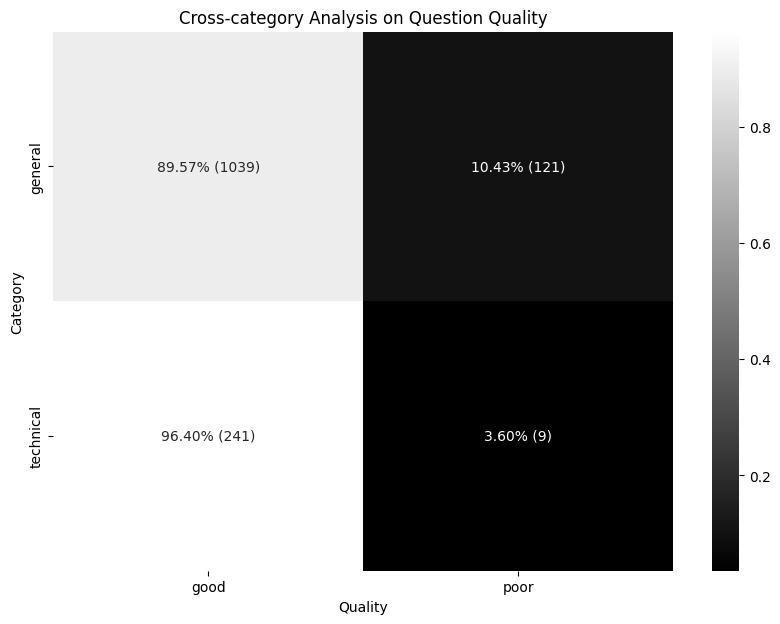

In [ ]:
# cross-category analysis of poor quality question for each category
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np

# Initialize a dictionary for categories and qualities
categories = ['general', 'technical']
qualities = ['good', 'poor']
cross_tab = {category: {quality: 0 for quality in qualities} for category in categories}

# Populate the cross-tabulation dictionary
for qa_pair, quality in zip(qa_pairs, question_qualities):
    category = qa_pair['category']
    cross_tab[category][quality['quality']] += 1

# Normalize the cross_tab to get conditional probabilities
total_counts = {category: sum(qualities.values()) for category, qualities in cross_tab.items()}
cross_tab_norm = {category: {quality: count / total_counts[category] for quality, count in qualities.items()}
                  for category, qualities in cross_tab.items()}

# Create a heatmap with conditional probabilities
heatmap_data = [list(cross_tab_norm[category].values()) for category in categories]
heatmap_counts = [list(cross_tab[category].values()) for category in categories]

annot_data = [[f"{prob:.2%} ({count})" for prob, count in zip(prob_row, count_row)]
              for prob_row, count_row in zip(heatmap_data, heatmap_counts)]

# Create a color gradient that ranges from red to green
colors = ["black", "white"]
cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", colors)

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=annot_data, fmt='', cmap=cmap)
plt.title('Cross-category Analysis on Question Quality')
plt.xlabel('Quality')
plt.ylabel('Category')
plt.xticks(ticks=np.arange(len(qualities)) + 0.5, labels=qualities)
plt.yticks(ticks=np.arange(len(categories)) + 0.5, labels=categories)
plt.show()

In [ ]:
final_answer_prompt_template = """
You are a Web3 expert who is able to answer any user query on Yield protocol's documentation, code, whitepapers and many other such topics.

# INSTRUCTIONS
- The user's query will be wrapped in triple back ticks
- Only answer the query using the provided context below which may include general information and code, do not make up any information.
- If the query is related to code or integration, provide a step by step explanation on the process, use code suggestions whereever relevant and always use markdown format annotated with the language to show the code.
- For code suggestions, use comments to explain each important concept, class, variable, function and parameter.
- Yield Protocol has no JS SDK so always use ethers package for JS code suggestions.

# CONTEXT
{context}

# QUERY
```
{question}
```
"""
FINAL_ANSWER_PROMPT = PromptTemplate(
    template=final_answer_prompt_template, input_variables=["context", "question"]
)

def ask(query, category, top_k=5, show_sources=False):
    display(Markdown(f"### Query\n{query}"))

    # 2. Call LLM to answer user's query
    chain_type_kwargs = {"prompt": FINAL_ANSWER_PROMPT}
    qa_chain = RetrievalQA.from_chain_type(
        llm=ChatOpenAI(temperature=0, model="gpt-4"), # answer bot is the highest quality
        chain_type="stuff",
        retriever=vector_db.as_retriever(search_type="mmr", search_kwargs = {
            'k': top_k,
            'filter': {'category': category} # this filters on metadata.
        }),  # pull over 5 most (credible) relatable document from the indexed db to answer the user's question, the data are cited from the metadata indices
        chain_type_kwargs=chain_type_kwargs,
        return_source_documents=True
    )

    with get_openai_callback() as cb:
      answer = qa_chain({'query': query})
      display(Markdown("### Final Answer"))
      display(Markdown(answer['result']))
      print(cb)

      if show_sources:
        display(Markdown("### Sources"))
        for i, d in enumerate(answer['source_documents']):
          display(Markdown(f"**[Source {i+1}]**"))
          display(Markdown(d.page_content))
          display(Markdown(f"*File path: {d.metadata['file_path']}*"))

      return answer['result']

In [ ]:
# url = f"/content/drive/MyDrive/qa_qualities.jsonl" # reading and populate question_qualities from previous validation results
# old_question_qualities = []
# index = 1
# with open(url, 'r') as cfile:
#   for line in cfile: # parse into json
#       raw = line.rstrip('\n')
#       qqdict = json.loads(raw) #qq means question_quality
#       # print(f"index: {index}, content: {qqdict}")
#       old_question_qualities.append(qqdict)
#       index+=1

# re-answer the affected (changed) qa_pairs in the collection
for i, qa_pair in enumerate(qa_pairs):
  if(question_qualities[i]['quality'] != old_question_qualities[i]['quality']):
    print(f"In before the question {qa_pair['question']} is identified {old_question_qualities[i]['quality']} but now re-identified to be {question_qualities[i]['quality']}")
    print("Re-answering...")
    new_answer = ask(qa_pair['question'], qa_pair['category'], show_sources=False)
    qa_pair['answer'] = new_answer


In before the question Who audited Yieldspace TV? is identified poor but now re-identified to be good
Re-answering...


### Query
Who audited Yieldspace TV?

### Final Answer

Yieldspace TV was audited by ABDK Consulting. You can find the audit report [here](https://github.com/yieldprotocol/yieldspace-tv/blob/main/audit/ABDK_Yield_yieldspace_tv_v_1_0.pdf).

Tokens Used: 1356
	Prompt Tokens: 1302
	Completion Tokens: 54
Successful Requests: 1
Total Cost (USD): $0.0423
In before the question What is the role of the Yield token in the protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the role of the Yield token in the protocol?

### Final Answer

Yield Protocol does not currently have a token. The founding team believes in decentralization and building towards community control of the protocol. As of now, they believe that is best served by building and growing community involvement. Long term, they expect Yield Protocol to be community-owned and community-controlled through a process of progressive decentralization.

Tokens Used: 1111
	Prompt Tokens: 1046
	Completion Tokens: 65
Successful Requests: 1
Total Cost (USD): $0.03528
In before the question What is the role of the Yield Protocol's governance token? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the role of the Yield Protocol's governance token?

### Final Answer

Yield Protocol does not have a specific governance token. The governance of the protocol is managed by two main actors: the Governor and the Operations team. 

The **Governor** is an account with complete control over the protocol, through a timelock. It is expected to be an x-of-n multisig, or a governance contract. 

The **Operations team** has limited control to execute what is determined by governance. The AccessControl contract is implemented as a 1-of-n multisig and so individual members can directly be given permissions consistent with an operations role.

These two actors manage the protocol through the **Timelock** and the **EmergencyBrake**. The Timelock provides a delay before any significant changes can be made, giving users time to react, while the EmergencyBrake allows the operations team to pause certain functions in case of an emergency.

In the future, as the protocol grows, it is expected that the governor and operations roles will be subdivided and possibly placed in a hierarchy, to reduce the risk profile of any individual account.

Tokens Used: 1527
	Prompt Tokens: 1312
	Completion Tokens: 215
Successful Requests: 1
Total Cost (USD): $0.05226
In before the question What is the role of the Yield token in the protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the role of the Yield token in the protocol?

### Final Answer

Yield Protocol does not currently have a token. The founding team believes in decentralization and building towards community control of the protocol. As of now, they believe that is best served by building and growing community involvement. In the long term, they expect Yield Protocol to be community-owned and community-controlled through a process of progressive decentralization.

Tokens Used: 1113
	Prompt Tokens: 1046
	Completion Tokens: 67
Successful Requests: 1
Total Cost (USD): $0.0354
In before the question What is the Technical Reference document in the Yield Protocol Docs? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the Technical Reference document in the Yield Protocol Docs?

### Final Answer

The Technical Reference document in the Yield Protocol Docs is a comprehensive guide that provides detailed information about the technical aspects of the Yield Protocol. It includes explanations of the protocol's architecture, smart contracts, functions, and how they interact with each other. 

This document is crucial for developers who want to understand the inner workings of the Yield Protocol, build on top of it, or integrate it into their own projects. It provides a deep dive into the protocol's codebase and functionality.

Unfortunately, the exact content or link to the Technical Reference document is not provided in the given context. You may need to visit the Yield Protocol's official documentation site to access this document.

Tokens Used: 1130
	Prompt Tokens: 998
	Completion Tokens: 132
Successful Requests: 1
Total Cost (USD): $0.03786
In before the question What is a Flash Loan and how is it used in Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is a Flash Loan and how is it used in Yield protocol?

### Final Answer

A Flash Loan is a type of loan in decentralized finance (DeFi) where no collateral is required from the borrower, but the loan must be repaid within the same transaction. This feature is made possible by the atomicity of blockchain transactions, where all operations within a transaction either succeed or fail together.

Flash Loans are commonly used for arbitrage opportunities or refinancing existing positions. In arbitrage, a trader can borrow assets at a low price from one platform and sell them at a higher price on another platform, repaying the loan and keeping the profit, all within a single transaction. In refinancing, a borrower can take a flash loan to pay off an existing loan and then take a new loan with better terms, again within a single transaction.

In the context of Yield Protocol, the Ladle contract orchestrates user activity, including Flash Loans. High-level actions in Yield Protocol are performed by composing smaller discrete actions into batches that can be executed in single transactions. The Ladle contract provides a mechanism for batching transactions called a batch. Each batching transaction function takes a set of batched actions and calls Ladle member functions associated with each action. This includes actions related to Flash Loans.

Here's a simplified example of how a Flash Loan might be used in Yield Protocol:

```javascript
// Import the ethers package
const ethers = require('ethers');

// Define the provider (e.g., mainnet, ropsten, rinkeby, etc.)
let provider = ethers.getDefaultProvider('mainnet');

// Define the borrower's wallet
let wallet = new ethers.Wallet(PRIVATE_KEY, provider);

// Define the Ladle contract
let ladleContract = new ethers.Contract(LADLE_ADDRESS, LADLE_ABI, wallet);

// Define the flash loan parameters
let loanParams = {
    fyToken: FYTOKEN_ADDRESS,  // The address of the fyToken to borrow
    amount: ethers.utils.parseEther('10'),  // The amount to borrow
    userData: ethers.utils.toUtf8Bytes('Flash loan example'),  // Optional data to pass to the callback function
    callback: CALLBACK_ADDRESS  // The address of the contract that will receive the loan and must repay it
};

// Execute the flash loan
let tx = await ladleContract.flashLoan(loanParams.fyToken, loanParams.amount, loanParams.userData, loanParams.callback);

// Wait for the transaction to be mined
let receipt = await tx.wait();
```

In this example, the `flashLoan` function of the Ladle contract is called to execute a Flash Loan. The parameters include the fyToken to borrow, the amount to borrow, optional user data, and the callback contract that will receive the loan and must repay it within the same transaction. The `flashLoan` function ensures that the loan is repaid by reverting the transaction if the callback contract does not repay the loan.

Tokens Used: 2210
	Prompt Tokens: 1626
	Completion Tokens: 584
Successful Requests: 1
Total Cost (USD): $0.08381999999999999
In before the question What should be done in case of a connection error? is identified poor but now re-identified to be good
Re-answering...


### Query
What should be done in case of a connection error?

### Final Answer

In case of a connection error, you should follow these steps:

- Ensure that you are connected to a supported network, which are Ethereum or Arbitrum.
- If you are using a wallet that is not Metamask (or you are using a Ledger), make sure that you use WalletConnect as the connection method.

Here's a visual guide for reference:

<figure class="image" align = "center">
  <img src="assets/connection-error.png" alt="connection error" title="connection error">
</figure>

Tokens Used: 1703
	Prompt Tokens: 1597
	Completion Tokens: 106
Successful Requests: 1
Total Cost (USD): $0.05426999999999999
In before the question What should be done if none of the provided solutions work? is identified poor but now re-identified to be good
Re-answering...


### Query
What should be done if none of the provided solutions work?

### Final Answer

If none of the provided solutions work, the following steps should be taken:

1. Open a support ticket: If you can't solve your issue with the instructions provided, please open a support ticket in the Yield Protocol Discord [#create-ticket](https://discord.com/channels/752978124614008945/893209711397195776) channel. Public channels are not used for support due to security reasons.

2. Provide necessary information: In the ticket, provide the following information:
   - What you were trying to achieve.
   - How you arrived at the issue.
   - Your address.
   - Any debugging information (a long string of non-sensical hexadecimal data), if available.

3. Wait for response: Please be aware that certain levels of support are only available during European or American business hours. The support team will respond to your ticket as soon as possible.

4. Escalation: If the support operator can't solve the issue, the user will be informed that the issue is being escalated to frontend/backend engineering, and that an update will be given no later than 24h from this time.

5. Regular updates: Regular updates on progress will be given to the user no more than 24h apart, with an expectation for the time of the next update.

6. Resolution: Upon resolution, the user will be informed of the status, and the knowledge base of known issues will be updated with the resolution or workaround.

Remember, the goal of the Yield Protocol team is to ensure that all issues are resolved in a timely and efficient manner.

Tokens Used: 1385
	Prompt Tokens: 1068
	Completion Tokens: 317
Successful Requests: 1
Total Cost (USD): $0.051059999999999994
In before the question What is the purpose of the 'Download' button on the Yield protocol application? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the 'Download' button on the Yield protocol application?

### Final Answer

The 'Download' button on the Yield Protocol application is used to obtain all the contract addresses related to the Yield Protocol. These addresses are essential for developers or users who want to interact with the Yield Protocol's smart contracts directly or through a third-party application. 

By clicking the 'Download' button, you can download a file that contains the addresses of all the deployed contracts of the Yield Protocol. This includes the addresses of the main contracts like the Yield App, as well as the addresses of the individual series and fyToken contracts.

Tokens Used: 1027
	Prompt Tokens: 921
	Completion Tokens: 106
Successful Requests: 1
Total Cost (USD): $0.03399
In before the question What is the purpose of the Cloak in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the Cloak in the Yield protocol?

### Final Answer

The Cloak, also known as the EmergencyBrake, in the Yield Protocol serves as a safety mechanism that can temporarily disable the orchestration between smart contracts in the protocol. This is particularly useful in emergency situations where there might be a need to halt certain operations due to unforeseen issues or vulnerabilities.

The Cloak holds the ROOT role to all smart contracts under its scope. This means it has the authority to control the interactions between these contracts.

In the event that the Cloak itself is compromised, a proposal must be passed through the Timelock to revoke the Cloak's ROOT permissions to all contracts under its scope. This action would render the compromised Cloak powerless and effectively terminate it, thereby protecting the integrity of the protocol.

Tokens Used: 1312
	Prompt Tokens: 1165
	Completion Tokens: 147
Successful Requests: 1
Total Cost (USD): $0.04377
In before the question How can a compromised Cloak be rendered powerless? is identified poor but now re-identified to be good
Re-answering...


### Query
How can a compromised Cloak be rendered powerless?

### Final Answer

In the case of a compromised Cloak, a proposal must be passed through the Timelock to revoke the Cloak ROOT permissions to all contracts under its scope. This will render the compromised Cloak powerless and effectively terminated. 

The Timelock contract provides a delay between the time an action is proposed and the time it can be executed, giving users the opportunity to review and potentially cancel the action if it is deemed harmful. 

Here's a general idea of how the process would look like:

```javascript
// Assuming you have an instance of the Timelock contract
const timelock = new ethers.Contract(timelockAddress, timelockABI, provider);

// Prepare the proposal data
const target = cloakAddress; // Address of the compromised Cloak
const value = ethers.utils.parseEther("0"); // No ETH to be sent
const signature = "revokeRoot(address)"; // Function to be called
const data = ethers.utils.defaultAbiCoder.encode(
  ["address"], 
  [contractAddress] // Address of the contract to revoke ROOT permissions from
);
const eta = Math.floor(Date.now() / 1000) + delay; // Current timestamp + delay

// Propose the action
const proposeTx = await timelock.connect(signer).queueTransaction(target, value, signature, data, eta);
await proposeTx.wait();

// After the delay has passed, execute the action
const executeTx = await timelock.connect(signer).executeTransaction(target, value, signature, data, eta);
await executeTx.wait();
```

In this code:
- `timelockAddress` is the address of the Timelock contract.
- `timelockABI` is the ABI of the Timelock contract.
- `provider` is an ethers.js provider connected to the network where the Timelock contract is deployed.
- `signer` is an ethers.js Signer that will be used to send the transactions.
- `cloakAddress` is the address of the compromised Cloak.
- `contractAddress` is the address of the contract to revoke ROOT permissions from.
- `delay` is the delay period of the Timelock contract, in seconds.

Please note that this is a simplified example and the actual process may involve additional steps or checks. Always make sure to thoroughly test any changes in a safe environment before applying them to the mainnet.

Tokens Used: 2109
	Prompt Tokens: 1619
	Completion Tokens: 490
Successful Requests: 1
Total Cost (USD): $0.07797
In before the question What is the role of Factories in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the role of Factories in the Yield protocol?

### Final Answer

Factories in the Yield Protocol are smart contracts that are responsible for creating other contracts. They are a common pattern in Ethereum development, especially for protocols that involve the creation of many similar contracts.

In the context of Yield Protocol, factories are used to create fyToken contracts and YieldSpace pool contracts. Each fyToken contract represents a specific series of the Yield Protocol, with a unique underlying asset and maturity date. YieldSpace pool contracts, on the other hand, are used for trading between fyTokens and their underlying assets.

The factory contracts ensure that each fyToken and YieldSpace pool is created with the correct parameters and in a consistent manner. This helps to reduce the risk of errors and makes the protocol more secure and reliable.

The exact implementation details of the factories can vary, but typically they include functions for creating new contracts, as well as for retrieving information about the contracts that have been created. The factories themselves are deployed by the Yield Protocol team and their addresses are made publicly available for users and developers to interact with.

Tokens Used: 1141
	Prompt Tokens: 938
	Completion Tokens: 203
Successful Requests: 1
Total Cost (USD): $0.040319999999999995
In before the question What is the role of the operations team in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the role of the operations team in the Yield protocol?

### Final Answer

The operations team in the Yield Protocol plays a crucial role in executing what is determined by the governance. They have limited control over the protocol, which is designed to ensure the safe operation of the protocol. The AccessControl contract is implemented as a 1-of-n multisig, which means individual members can be directly given permissions consistent with an operations role. 

In the future, an additional x-of-n multisig could be considered for the operations role to further enhance the security and control of the protocol. 

The operations team's responsibilities may include:

- Executing changes to the protocol as determined by the governance.
- Ensuring the protocol operates safely and efficiently.
- Coordinating with the governance team to implement changes.
- Managing permissions for the operations role.

It's important to note that as the protocol grows, it is expected that the governor and operations roles will be subdivided and possibly placed in a hierarchy, to reduce the risk profile of any individual account.

Tokens Used: 1255
	Prompt Tokens: 1062
	Completion Tokens: 193
Successful Requests: 1
Total Cost (USD): $0.04344
In before the question What is the purpose of the naming scheme used in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the naming scheme used in the Yield protocol?

### Final Answer

The naming scheme used in the Yield Protocol is designed to identify different types of assets and their characteristics in a structured and systematic way. It helps in distinguishing between basic assets, derivatives, strategies, and series. 

Each identifier is a combination of different components that provide specific information about the asset. For example, the type of asset (basic, derivative, strategy, series), the underlying asset (ETH, DAI, USDC, etc.), the platform or protocol associated with the asset (Not set, Yield, Notional, Curve, Convex), and other specific details like instance or canonical months since epoch in hexadecimal for series and FCash collateral.

Here's an example of how the naming scheme works:

```
ETH        = 3 030 00 000 000 (Basic asset, ETH, Not set)
DAI        = 3 031 00 000 000 (Basic asset, DAI, Not set)
USDC       = 3 032 00 000 000 (Basic asset, USDC, Not set)
FRAX       = 3 138 00 000 000 (Basic asset, FRAX, Not set)
FYETHDEC22 = 0 030 FF 000 285 (Series, ETH, Yield, 645 canonical months since epoch in hexadecimal).
FETHDEC22  = 4 030 10 000 285 (FCash collateral, ETH, Notional, 645 canonical months since epoch in hexadecimal).
YSDAI6MJD  = 1 031 FF 000 000 (Strategy, DAI, first instance)
YSDAI6MMS  = 1 031 FF 000 001 (Strategy, DAI, second instance)
CRV        = 3 040 11 000 000 (Basic asset, CRV, Curve)
CVX3CRV    = D 040 12 000 000 (Derivative asset, CRV, Convex)
```

This naming scheme allows for easy identification and categorization of assets within the Yield Protocol. It also provides a way to systematically add new assets and their variations to the protocol.

Tokens Used: 1453
	Prompt Tokens: 1013
	Completion Tokens: 440
Successful Requests: 1
Total Cost (USD): $0.05678999999999999
In before the question What is the difference between a basic asset and a derivative asset in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the difference between a basic asset and a derivative asset in the Yield protocol?

### Final Answer

In the Yield Protocol, a basic asset and a derivative asset are two different types of assets that can be used within the system. 

A **basic asset** is a fundamental asset that is directly used as collateral or debt in the Yield Protocol. Examples of basic assets include ETH, DAI, USDC, and FRAX. These are the underlying assets that are used to create debt positions in the Yield Protocol. 

On the other hand, a **derivative asset** is an asset that derives its value from an underlying basic asset. These are typically more complex financial instruments that are based on the performance of underlying basic assets. An example of a derivative asset in the Yield Protocol could be a fyToken, which is a tokenized debt instrument that can be redeemed for the underlying asset after a predetermined maturity date.

In the context of Yield Protocol's identifiers, basic assets are assigned type 3 and derivative assets are assigned type D. For example:

```
ETH        = 3 030 00 000 000 (Basic asset, ETH, Not set)
DAI        = 3 031 00 000 000 (Basic asset, DAI, Not set)
USDC       = 3 032 00 000 000 (Basic asset, USDC, Not set)
FRAX       = 3 138 00 000 000 (Basic asset, FRAX, Not set)
CVX3CRV    = D 040 12 000 000 (Derivative asset, CRV, Convex)
```
In the above examples, ETH, DAI, USDC, and FRAX are basic assets, while CVX3CRV is a derivative asset.

Tokens Used: 2232
	Prompt Tokens: 1886
	Completion Tokens: 346
Successful Requests: 1
Total Cost (USD): $0.07733999999999999
In before the question What is the purpose of the 'stir' function in Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the 'stir' function in Yield protocol?

### Final Answer

The `stir` function in Yield Protocol is used to move collateral and debt between vaults. However, it can only move debt or collateral between vaults that have matching seriesId or ilkId, respectively. 

This function can be combined with `build` and `destroy` to split and merge vaults. The `stir` function will revert if any affected vaults would be undercollateralized at the end of the transaction.

Here is a simplified example of how the `stir` function might be used:

```javascript
// Assume we have two vaults with the same seriesId or ilkId
let vault1 = 1;
let vault2 = 2;

// We want to move some amount of collateral or debt from vault1 to vault2
let amount = ethers.utils.parseEther("10.0");

// We call the stir function on the Ladle contract
await ladle.stir(vault1, vault2, amount);
```

In this example, `ladle` is the instance of the Ladle contract, `vault1` and `vault2` are the identifiers of the vaults between which we want to move collateral or debt, and `amount` is the amount of collateral or debt we want to move. 

Please note that this is a simplified example and actual usage may require additional steps and checks.

Tokens Used: 1485
	Prompt Tokens: 1209
	Completion Tokens: 276
Successful Requests: 1
Total Cost (USD): $0.05283
In before the question What is the process of adding a series to the protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the process of adding a series to the protocol?

### Final Answer

Adding a series to the Yield Protocol involves a few steps. Here's a step-by-step guide:

1. **Create a Series**: A series is created by calling the `addSeries` function in the Cauldron contract. This function takes in the parameters `baseId`, `fyTokenId`, `maturity`, and `oracle`. The `baseId` and `fyTokenId` are the identifiers for the base and fyToken assets respectively. The `maturity` is the timestamp at which the series matures, and `oracle` is the address of the oracle contract for the series.

```solidity
function addSeries(bytes6 baseId, bytes6 fyTokenId, uint32 maturity, address oracle) external;
```

2. **Add a Join for the Asset**: If a Join for the asset does not already exist, you need to add one. This is done by calling the `addJoin` function in the Ladle contract. This function takes in the parameters `assetId` and `join`.

```solidity
function addJoin(bytes6 assetId, IJoin join) external;
```

3. **Add a Pool for the Series**: Finally, you need to add a Pool for the series. This is done by calling the `addPool` function in the Ladle contract. This function takes in the parameters `seriesId` and `pool`.

```solidity
function addPool(bytes6 seriesId, IPool pool) external;
```

Please note that all these operations are permissioned and can only be executed by the governor or operations team through the Timelock. The operations team will submit the proposal, which is a series of function calls to be executed from the Timelock. The owners of the multisig, or the community in its case, can independently decode the proposal to verify its contents. If it is collectively decided to approve the proposal, the governor account will call `approve` on the Timelock for the proposal hash. The operations team will `execute` the approved proposal, no earlier than the delay set in the Timelock. The proposal will be executed from the Timelock.

Tokens Used: 2256
	Prompt Tokens: 1819
	Completion Tokens: 437
Successful Requests: 1
Total Cost (USD): $0.08079
In before the question What is the ChainlinkMultiOracle in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the ChainlinkMultiOracle in the Yield protocol?

### Final Answer

The `ChainlinkMultiOracle` in the Yield Protocol is a type of Oracle contract that wraps around the Chainlink oracle. It is used to fetch external data, specifically price data, which is crucial for the functioning of the Yield Protocol.

The Yield Protocol uses its own Oracle interface as a wrapper to external oracles, such as Chainlink, so that it is possible to switch to external oracles with arbitrary interfaces with no impact on the core contracts.

The `ChainlinkMultiOracle` provides a `get(bytes32 base, bytes32 quote, uint256 amount) returns (uint256 value)` function that accepts base and quote identifiers and an amount of `base` to convert according to them and to the value returned by the Chainlink oracle.

The `ChainlinkMultiOracle` is used to set new sources for base and quote pairs. For example, it can be used to set a new source for the USDC/ETH pair. The base and quote identifiers, the base and quote contracts, and the data source are all parameters that can be set using the `ChainlinkMultiOracle`.

In summary, the `ChainlinkMultiOracle` is a crucial component in the Yield Protocol that allows it to fetch external price data from the Chainlink oracle, which is used for various functions such as determining the collateralization level of vaults.

Tokens Used: 1609
	Prompt Tokens: 1340
	Completion Tokens: 269
Successful Requests: 1
Total Cost (USD): $0.05634
In before the question What is the ChainlinkMultiOracle and how is it used in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the ChainlinkMultiOracle and how is it used in the Yield protocol?

### Final Answer

The ChainlinkMultiOracle is a type of Oracle contract used in the Yield Protocol. It's designed to wrap around external oracles, such as Chainlink, to provide reliable and accurate price feeds for various assets. 

In the context of Yield Protocol, the ChainlinkMultiOracle is used to ensure that vaults are properly collateralized. It provides the necessary price data to calculate the collateralization ratio of a vault. If a vault falls below the required collateralization ratio, it can be liquidated by the Witch contract, Yield's liquidation engine.

The ChainlinkMultiOracle is also used in setting new sources for price data. For example, a proposal can be made to the Timelock contract to set a new source for the ChainlinkMultiOracle. This involves specifying the BaseId, Base contract, QuoteId, Quote contract, and the data source.

Here's an example of how the ChainlinkMultiOracle is used:

```javascript
// BaseId: 0x303200000000 (USDC)
// Base contract: 0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48
// QuoteId: 0x303000000000 (ETH)
// Quote contract: 0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2
// Data source: 0x986b5E1e1755e3C2440e960477f25201B0a8bbD4
```

In this example, the ChainlinkMultiOracle is being asked to set a new source for the price of USDC in terms of ETH, using the data source at the specified address.

Tokens Used: 1687
	Prompt Tokens: 1324
	Completion Tokens: 363
Successful Requests: 1
Total Cost (USD): $0.0615
In before the question What is the role of the Yield token in the protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the role of the Yield token in the protocol?

### Final Answer

Yield Protocol does not currently have a token, nor are there plans to release one. The founding team believes in decentralization and building towards community control of the protocol. Right now, they believe that is best served by building, and growing community involvement. Long term they expect Yield Protocol to be community-owned and community controlled through a process of progressive decentralization.

Tokens Used: 1118
	Prompt Tokens: 1046
	Completion Tokens: 72
Successful Requests: 1
Total Cost (USD): $0.035699999999999996
In before the question What are some general tips for conducting a thorough review of the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What are some general tips for conducting a thorough review of the Yield protocol?

### Final Answer

When conducting a thorough review of the Yield Protocol, you should consider the following general tips:

1. **Construct a mental model**: Before checking out the code, construct a mental model of what you expect the contracts to look like. Compare the architecture to your mental model and look into areas that are surprising.

2. **Value exchange**: Pay special attention to areas that can do value exchange. These are critical points where assets are transferred and thus need to be handled with care.

3. **Interface with external contracts**: Look at areas that interface with external contracts and ensure all assumptions about them are valid. This is important to ensure that the protocol interacts correctly with other contracts.

4. **Threat model**: Create a threat model and make a list of theoretical high-level attack vectors. This will help you understand potential security risks.

5. **Review from different perspectives**: Do another review from the perspective of every actor in the threat model. This will help you understand how different users or systems might interact with the protocol.

6. **Solcurity standards checklist**: Go through the Solcurity standards checklist for each of the following: Events, Structs, Modifiers, Variables, Functions, External Calls, and Static Calls. This checklist provides a comprehensive guide to ensure the code meets high-quality standards.

7. **Yield security precautions**: Consider additional Yield security precautions. For instance, never allow users to call arbitrary contracts from our contracts. Either use auth or some kind of whitelist.

8. **Testing**: Before reviewing tests, construct a mental model of how you would approach testing. Check if realistic scenarios/values are used in tests.

Remember, the goal of the review is to ensure the code is secure, efficient, and functions as expected.

Tokens Used: 1717
	Prompt Tokens: 1370
	Completion Tokens: 347
Successful Requests: 1
Total Cost (USD): $0.06192
In before the question What is ladle? is identified poor but now re-identified to be good
Re-answering...


### Query
What is ladle?

### Final Answer

The Ladle is a routing and asset management contract for Yield Protocol. It is the most complex contract in the protocol and has considerable privileges. It can be upgraded through Modules or replaced entirely.

The Ladle is authorized to make changes to the accounting in Cauldron and is the only contract that is authorized to create, modify or destroy Vaults in the Cauldron. It keeps a registry of all Joins and is authorized to move assets from any Join to any account. It also moves assets from users to Joins, with allowances approved by the users.

The Ladle is authorized to mint fyToken at will and moves fyToken from users to FYToken contracts for burning, with allowances approved by the users. It knows about all the existing fyTokens through the series registry in the Cauldron.

The Ladle keeps a registry of all the Pools, indexed by the id of the series traded. It also moves assets from users to Pool contracts for trading, with allowances approved by the users.

The Ladle can batch any number of actions in a single transaction using the `batch` method. It can also be used to execute arbitrary calls on any registered contracts using `route`. The Ladle can be extended by the use of modules. The Ladle can `moduleCall` functions in modules that have been authorized via governance. The Modules can inherit from LadleStorage to read and modify the Ladle storage, although modifying it is discouraged.

Tokens Used: 2114
	Prompt Tokens: 1823
	Completion Tokens: 291
Successful Requests: 1
Total Cost (USD): $0.07214999999999999
In before the question What are the possible actions needed to confirm a solution in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What are the possible actions needed to confirm a solution in the Yield protocol?

### Final Answer

In the Yield Protocol, once a solution has been implemented, the team needs to confirm that the solution resolves the issue and minimizes the loss of funds. The possible actions needed during this step include:

1. **Running Ganache Fork Simulations**: This involves running simulations of the end state on a Ganache fork to confirm the proposed solution(s). Ganache is a personal blockchain for Ethereum development that can be used to deploy contracts, develop applications, and run tests. It is available as both a desktop application as well as a command-line tool.

2. **Coordinating Signatures from Multi-Sig Signers and Execution**: This involves coordinating the collection of signatures from multi-signature signers and executing the solution. Multi-signature wallets are a technology used to add additional security for cryptocurrency transactions. Multiple signatures are required to complete a transaction, which provides an additional layer of security.

3. **Enabling UI Changes to Normalize Operations**: Depending on the solution, it may be necessary to make changes to the user interface (UI) to normalize operations. This could involve updating the UI to reflect changes in the backend, adding new features, or improving existing ones.

These actions are crucial to ensure that the implemented solution effectively addresses the issue at hand and that it does not introduce new problems or vulnerabilities.

Tokens Used: 1143
	Prompt Tokens: 882
	Completion Tokens: 261
Successful Requests: 1
Total Cost (USD): $0.042120000000000005
In before the question What is the purpose of assigning Key Roles to War Room members? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of assigning Key Roles to War Room members?

### Final Answer

The purpose of assigning Key Roles to War Room members is to ensure efficient and effective management of any emergency or critical situation that may arise in the Yield Protocol. Each role has specific responsibilities and tasks to perform during an emergency, which helps in quick resolution of the issue. Here's a brief overview of the roles:

1. **Multi-sig Herder**: This role is responsible for managing the multi-signature wallets of the Yield teams. They ensure that transactions are executed promptly during an emergency.

2. **Smart Contract Lead**: This role is responsible for coordinating quick changes to smart contracts during an emergency. They prepare and execute multi-sig transactions and operations, and execute emergency plans.

3. **Web Lead**: This role is responsible for coordinating quick changes to the UI and websites as required during an emergency. They may disable deposits/withdrawals through the UI, display alerts and banners, and perform other UI related work.

4. **Ops**: This role is in charge of coordinating communications and operations assistance as required. They clear with the War Room what information can be published during and after the incident, coordinate communications, and take note of timelines and events for disclosure.

By assigning these roles, the team can ensure that every aspect of the situation is covered, from technical to operational, and that the right people are in place to handle the situation effectively.

Tokens Used: 1874
	Prompt Tokens: 1604
	Completion Tokens: 270
Successful Requests: 1
Total Cost (USD): $0.06432
In before the question What are the secondary tools for code sharing in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What are the secondary tools for code sharing in the Yield protocol?

### Final Answer

The secondary tools for code sharing in the Yield Protocol are [HackMd](https://hackmd.io/) and [CodeShare](https://codeshare.io/5Og7mj). These platforms can be used to share, collaborate and discuss code in real-time.

Tokens Used: 1345
	Prompt Tokens: 1291
	Completion Tokens: 54
Successful Requests: 1
Total Cost (USD): $0.04196999999999999
In before the question What is the primary tool for debugging in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the primary tool for debugging in the Yield protocol?

### Final Answer

The primary tool for debugging in the Yield Protocol is the Ethereum blockchain itself. Users can inspect transactions, events, and contract states using blockchain explorers like Etherscan. Additionally, the Yield Protocol provides debugging information in the form of hexadecimal data when an issue occurs. This data can be used to understand the state of the system at the time of the issue.

If you encounter an issue, you can copy and paste the debugging information (a long string of non-sensical hexadecimal data) into a support ticket in the Yield Protocol's Discord [#create-ticket](https://discord.com/channels/752978124614008945/893209711397195776) channel. The Yield Protocol team can then use this information to help diagnose and resolve the issue.

Tokens Used: 1457
	Prompt Tokens: 1305
	Completion Tokens: 152
Successful Requests: 1
Total Cost (USD): $0.04826999999999999
In before the question What are the recommended tools for screen sharing in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What are the recommended tools for screen sharing in the Yield protocol?

### Final Answer

The recommended tools for screen sharing in the Yield Protocol are:

- Primary: [jitsi](https://jitsi.org/)
- Secondary: Google Hangouts

These tools are used to facilitate communication and collaboration, especially during troubleshooting or support sessions.

Tokens Used: 1117
	Prompt Tokens: 1066
	Completion Tokens: 51
Successful Requests: 1
Total Cost (USD): $0.03504
In before the question What is the role of the Yield protocol's governance token? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the role of the Yield protocol's governance token?

### Final Answer

The Yield Protocol does not currently have a governance token. The governance of the protocol is managed by two main actors: the **Governor** and the **Operations team**. 

The **Governor** is an account with complete control over the protocol, through a timelock. It is expected to be an x-of-n multisig, or a governance contract.

The **Operations team** has limited control to execute what is determined by governance. The AccessControl contract is implemented as a 1-of-n multisig and so individual members can directly be given permissions consistent with an operations role.

In the future, as the protocol grows, it is expected that the governor and operations roles will be subdivided and possibly placed in a hierarchy, to reduce the risk profile of any individual account.

Tokens Used: 1328
	Prompt Tokens: 1170
	Completion Tokens: 158
Successful Requests: 1
Total Cost (USD): $0.04458
In before the question What is the purpose of the _accrual function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the _accrual function in the Yield protocol?

### Final Answer

The `_accrual` function in the Yield Protocol is used to retrieve the rate accrual since maturity. This function is particularly important for handling fyTokens, which are fixed yield tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date.

Here is the function signature:

```solidity
function _accrual(bytes6 seriesId, struct DataTypes.Series series_) private returns (uint256 accrual_)
```

This function takes in two parameters: `seriesId` and `series_`. The `seriesId` is the identifier for the series of the fyToken, and `series_` is the data structure representing the series.

The function returns the accrued rate since the maturity of the fyToken series. This is crucial for calculating the correct amount of underlying asset that the fyToken can be redeemed for after its maturity date.

It's important to note that this function should only be called after checking that the current time is past the maturity date of the fyToken series. This is because the rate accrual is only relevant after the fyToken has matured.

Tokens Used: 1229
	Prompt Tokens: 1009
	Completion Tokens: 220
Successful Requests: 1
Total Cost (USD): $0.043469999999999995
In before the question What is the purpose of the maxFlashLoan function? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the maxFlashLoan function?

### Final Answer

The `maxFlashLoan` function is part of the ERC-3156 standard for flash loans. It is used to determine the maximum amount of a specific token that is available to be lent out as a flash loan.

In the context of Yield Protocol, the `maxFlashLoan` function returns the maximum amount of a specific fyDai token that can be borrowed as a flash loan. The `token` parameter should be the address of a fyDai contract.

Here is the function signature:

```solidity
function maxFlashLoan(
  address token
) external view returns (uint256)
```

This function is useful for borrowers to check the liquidity of a specific fyDai token before initiating a flash loan. If the returned value is less than the desired loan amount, the borrower knows that the loan cannot be processed due to insufficient liquidity.

Tokens Used: 1897
	Prompt Tokens: 1725
	Completion Tokens: 172
Successful Requests: 1
Total Cost (USD): $0.06207
In before the question What is the purpose of the flashLoan function? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the flashLoan function?

### Final Answer

The `flashLoan` function is part of the ERC-3156 standard for flash loans. Flash loans are a feature in DeFi where a user can borrow any amount of tokens from a pool, as long as they return the borrowed amount plus a fee within the same transaction. This allows users to take advantage of arbitrage opportunities without needing to have the capital upfront.

In the context of Yield Protocol, the `flashLoan` function allows a contract (the `receiver`) to borrow a specified `amount` of a token (which must be a fyDai contract) for use within a single transaction. The `receiver` contract must implement the `onFlashLoan(address user, uint256 amount, uint256 fee, bytes calldata)` interface to handle the borrowed tokens.

Here's a brief overview of the parameters of the `flashLoan` function:

- `receiver`: The contract that will receive the tokens. It must implement the `onFlashLoan` interface.
- `token`: The address of the fyDai contract for the token to be lent.
- `amount`: The amount of tokens to be lent.
- `data`: A data parameter that can be used for any custom use in the `receiver` contract.

This function enables the Yield Protocol to participate in the wider DeFi ecosystem by providing flash loans, which can be used for a variety of purposes such as arbitrage, collateral swapping, and self-liquidation.

Tokens Used: 1829
	Prompt Tokens: 1539
	Completion Tokens: 290
Successful Requests: 1
Total Cost (USD): $0.06356999999999999
In before the question What is the purpose of the data parameter in the flashLoan function? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the data parameter in the flashLoan function?

### Final Answer

The `data` parameter in the `flashLoan` function is a bytes type parameter that can be used to pass on any custom data to the `receiver` contract. This can be useful in scenarios where the `receiver` contract needs additional information to execute its logic.

For example, if the `receiver` contract is designed to perform a specific operation (like arbitrage, liquidation, etc.) after receiving the flash loan, it might need additional parameters like target addresses, amounts, or other operation-specific data. This data can be encoded and passed through the `data` parameter.

The `receiver` contract should be designed to decode this data in its `onFlashLoan` function and use it as needed. This makes the `flashLoan` function more flexible and adaptable to various use-cases.

Tokens Used: 2296
	Prompt Tokens: 2135
	Completion Tokens: 161
Successful Requests: 1
Total Cost (USD): $0.07371
In before the question What is the purpose of the 'exit' function? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the 'exit' function?

### Final Answer

The `exitEther` function in the Yield Protocol is used to unwrap the Wrapped Ether (WETH) held by the Ladle contract and send the Ether. This function should be called last in a batch, and the Ladle should have no reason to keep a WETH balance. 

In other words, it's a way to convert WETH back into Ether and transfer it. This is useful in scenarios where you want to withdraw your funds from the protocol and get them back in the form of Ether. 

Here is the function signature:
```solidity
  function exitEther(
  ) external returns (uint256 ethTransferred)
```
The function returns the amount of Ether that was transferred during the operation.

Tokens Used: 1380
	Prompt Tokens: 1235
	Completion Tokens: 145
Successful Requests: 1
Total Cost (USD): $0.04575
In before the question What is the purpose of the 'build' function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the 'build' function in the Yield protocol?

### Final Answer

The `build` function in the Yield Protocol is used to create a new vault. A vault in Yield Protocol represents a collateralized debt position and is associated with a single collateral and debt in a single series. 

When a user calls the `build` function, they are essentially creating a new vault with a specific collateral and debt series. This vault can then be managed through the Cauldron, a smart contract that records the collateral and debt for each vault and permits management of the full lifecycle of a vault. 

The lifecycle of a vault includes adding and removing collateral, adding and removing debt, checking collateralization, permitting liquidation of undercollateralized vaults, and rolling collateral and debt to a new series. 

In terms of gas costs, the `build` operation is part of the "build, post and borrow" operation which has a gas cost of 326K. This cost will vary depending on the current gas price.

Tokens Used: 1521
	Prompt Tokens: 1331
	Completion Tokens: 190
Successful Requests: 1
Total Cost (USD): $0.05133
In before the question What does the 'stir' function do in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What does the 'stir' function do in the Yield protocol?

### Final Answer

The `stir` function in Yield Protocol is used to move collateral and debt between vaults. However, it can only move debt or collateral between vaults that have matching seriesId or ilkId, respectively. 

The seriesId is associated with a specific fyToken contract and its related data, while the ilkId is associated with an asset that is used as collateral. 

This function can be combined with `build` and `destroy` functions to split and merge vaults. 

It's important to note that the `stir` function will revert if any affected vaults would be undercollateralized at the end of the transaction. This is to ensure that the vaults maintain the appropriate level of collateral. 

Here is a simplified example of how the `stir` function might be used:

```javascript
// Assume we have ethers instance and ladle contract instance
const ethers = require('ethers');
const ladle = new ethers.Contract(ladleAddress, ladleABI, provider);

// Assume we have two vaults with ids vaultId1 and vaultId2
const vaultId1 = ethers.utils.formatBytes32String("1");
const vaultId2 = ethers.utils.formatBytes32String("2");

// Assume we have a seriesId and an ilkId
const seriesId = ethers.utils.formatBytes32String("series1");
const ilkId = ethers.utils.formatBytes32String("ilk1");

// Assume we have a debt amount to move
const debt = ethers.utils.parseEther("1000");

// Stir function call
const tx = await ladle.stir(vaultId1, vaultId2, seriesId, ilkId, debt);
await tx.wait();
```

In this example, the `stir` function is called to move a debt of 1000 from vault1 to vault2. The vaults are identified by their ids, and the seriesId and ilkId are used to ensure that the vaults are compatible for the debt transfer.

Tokens Used: 1506
	Prompt Tokens: 1103
	Completion Tokens: 403
Successful Requests: 1
Total Cost (USD): $0.05727
In before the question What is the purpose of the PoolAdded event and what parameters does it take? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the PoolAdded event and what parameters does it take?

### Final Answer

The `PoolAdded` event in the Yield Protocol's LadleStorage contract is used to log the addition of a new liquidity pool to the Yield Protocol. This event is emitted when a new pool is added to the protocol, providing a way to track and verify the addition of new pools.

The `PoolAdded` event takes two parameters:

1. `seriesId`: This is a bytes6 type parameter that represents the unique identifier of the series to which the pool is added.

2. `pool`: This is an address type parameter that represents the Ethereum address of the newly added pool.

Here is the event declaration:

```solidity
event PoolAdded(bytes6 seriesId, address pool);
```

When this event is emitted, it signifies that a new pool has been added to the Yield Protocol for a particular series, and the address of the new pool is provided. This can be useful for tracking the creation of new pools, for auditing purposes, or for any on-chain or off-chain logic that needs to react to the addition of new pools.

Tokens Used: 1589
	Prompt Tokens: 1378
	Completion Tokens: 211
Successful Requests: 1
Total Cost (USD): $0.05399999999999999
In before the question What is the difference between the 'buy' and 'payAll' functions in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the difference between the 'buy' and 'payAll' functions in the Yield protocol?

### Final Answer

The `buy` and `payAll` functions in the Yield protocol are used in the context of liquidating an undercollateralized vault. Here's how they differ:

- `buy`: This function allows you to pay a specific amount (`base`) of the debt in a vault that is in liquidation, and in return, you get at least `min` collateral. This function is useful when you want to partially pay off the debt of a vault in liquidation.

```solidity
function buy(bytes12 vaultId, uint128 base, uint128 min) external returns (uint256 ink)
```

- `payAll`: This function allows you to pay off all the debt from a vault in liquidation, and in return, you get at least `min` collateral. This function is useful when you want to fully pay off the debt of a vault in liquidation.

```solidity
function payAll(bytes12 vaultId, uint128 min) external returns (uint256 ink)
```

In both cases, the amount of collateral you receive (`ink`) is determined by the liquidation process, which is performed via an increasing price auction that increases the amount of collateral the system is willing to pay to cover the debt.

Tokens Used: 2126
	Prompt Tokens: 1876
	Completion Tokens: 250
Successful Requests: 1
Total Cost (USD): $0.07128
In before the question What does the 'settle' function do in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What does the 'settle' function do in the Yield protocol?

### Final Answer

The `settle` function in Yield Protocol is used to settle a user's vault after the maturity of the series. This function is called to calculate and settle any outstanding debt that the user might have after the maturity date of the fyToken series they borrowed from.

When a user borrows from a series, they are essentially taking a loan that needs to be paid back by the maturity date of the series. If the user fails to pay back the loan by the maturity date, the `settle` function is used to calculate the remaining debt and settle it.

The `settle` function is part of the Vault contract in Yield Protocol. Here is a simplified version of how it might look:

```javascript
// Solidity code
function settle(bytes12 vaultId) external {
    Vault memory vault = vaults[vaultId];
    require(vault.owner == msg.sender, "Vault: Not owner");
    require(block.timestamp > series.maturity, "Vault: Series not mature");

    // Calculate the remaining debt
    uint256 debt = series.debt(vaultId);

    // Settle the debt
    series.settle(vaultId, debt);
}
```

In this code:

- `vaultId` is the unique identifier of the user's vault.
- `vaults` is a mapping that stores all the vaults in the protocol.
- `series` is the fyToken series from which the user borrowed.
- `debt` is the remaining debt of the user.
- `series.debt(vaultId)` is a function that calculates the remaining debt of the user.
- `series.settle(vaultId, debt)` is a function that settles the user's debt.

Please note that this is a simplified version of the function and the actual implementation might be more complex and include additional checks and operations.

Tokens Used: 1381
	Prompt Tokens: 1010
	Completion Tokens: 371
Successful Requests: 1
Total Cost (USD): $0.052559999999999996
In before the question How is the 'inkPrice' calculated in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
How is the 'inkPrice' calculated in the Yield protocol?

### Final Answer

The `inkPrice` function in Yield Protocol calculates the price of a collateral unit, in underlying, at the present moment, for a given vault. The function is defined as follows:

```solidity
function inkPrice(struct DataTypes.Balances balances, uint256 initialOffer_, uint256 duration_, uint256 elapsed) private pure returns (uint256 price)
```

The price is calculated using the following formula:

```math
price = (ink / art) * (p + (1 - p) * (min(auction, elapsed) / auction))
```

Here's what each variable represents:

- `ink`: This is the amount of collateral in the vault.
- `art`: This is the amount of debt in the vault.
- `p`: This is the initial offer price.
- `auction`: This is the duration of the auction.
- `elapsed`: This is the time elapsed since the start of the auction.

The formula calculates the price of a collateral unit by first dividing the amount of collateral by the amount of debt. This gives the ratio of collateral to debt. 

Then, it calculates a weighted average of the initial offer price and the elapsed time as a proportion of the auction duration. If the auction has just started, the price will be closer to the initial offer price. As the auction progresses, the price will gradually decrease.

Finally, it multiplies the collateral-to-debt ratio by this weighted average to get the price of a collateral unit.

Tokens Used: 2283
	Prompt Tokens: 1985
	Completion Tokens: 298
Successful Requests: 1
Total Cost (USD): $0.07743
In before the question What is the purpose of the 'seize' function? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the 'seize' function?

### Final Answer

The `seize` function in the Yield Protocol's Giver contract is designed to allow an authenticated address to transfer the ownership of any user's vault to another address. This function is typically used in emergency situations where there's a need to secure the assets in a vault.

Here's the function signature:

```solidity
function seize(bytes12 vaultId, address receiver) external returns (struct DataTypes.Vault vault)
```

The function parameters are:

- `vaultId`: The identifier of the vault to be transferred.
- `receiver`: The address to which the vault is being transferred.

The function returns a `vault` of type `struct DataTypes.Vault`, which represents the vault that has been transferred.

This function should be used with caution as it has the power to change the ownership of a vault. It's typically protected and only callable by an account with the necessary permissions (like an admin or a smart contract with specific roles).

Tokens Used: 1424
	Prompt Tokens: 1235
	Completion Tokens: 189
Successful Requests: 1
Total Cost (USD): $0.04839
In before the question What is the 'YieldSet' event in the Yield protocol used for? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the 'YieldSet' event in the Yield protocol used for?

### Final Answer

The `YieldSet` event in the Yield Protocol is used to emit an event when the yield of a particular asset or series is set or updated. However, the exact details or parameters of this event are not provided in the given context. In general, such events are used to log specific changes on the blockchain that can be tracked and audited.

Tokens Used: 1020
	Prompt Tokens: 949
	Completion Tokens: 71
Successful Requests: 1
Total Cost (USD): $0.032729999999999995
In before the question What is the purpose of the flashLoan function? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the flashLoan function?

### Final Answer

The `flashLoan` function is part of the ERC-3156 standard for flash loans. Flash loans are a feature in DeFi where a user can borrow any amount of tokens from a pool, as long as they return the borrowed amount plus a fee within the same transaction. This allows users to take advantage of arbitrage opportunities without needing to have the capital upfront.

In the context of Yield Protocol, the `flashLoan` function allows a contract (the `receiver`) to borrow a specified `amount` of a token (which must be a fyDai contract) for use within a single transaction. The `receiver` contract must implement the `onFlashLoan(address user, uint256 amount, uint256 fee, bytes calldata)` interface to handle the borrowed tokens.

Here's the function signature:

```solidity
function flashLoan(contract IERC3156FlashBorrower receiver, address token, uint256 amount, bytes data) external returns (bool)
```

The parameters are:

- `receiver`: The contract receiving the tokens, needs to implement the `onFlashLoan(address user, uint256 amount, uint256 fee, bytes calldata)` interface.
- `token`: The loan currency. Must be a fyDai contract.
- `amount`: The amount of tokens lent.
- `data`: A data parameter to be passed on to the `receiver` for any custom use.

The function returns a boolean indicating whether the flash loan was successful.

Tokens Used: 1835
	Prompt Tokens: 1539
	Completion Tokens: 296
Successful Requests: 1
Total Cost (USD): $0.06392999999999999
In before the question What is the purpose of the 'flashLoan' function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the 'flashLoan' function in the Yield protocol?

### Final Answer

The `flashLoan` function in Yield Protocol is used to execute a Flash Loan. A Flash Loan is a feature in DeFi where a user can borrow any amount of tokens from a pool, without providing any collateral, as long as they return the borrowed amount within the same transaction.

This feature is particularly useful for arbitrage opportunities, self-liquidation, and swapping collateral, among other things. The `flashLoan` function allows users to borrow assets, perform some operations (like arbitrage or refinancing), and then return the borrowed assets, all within a single transaction.

Here's a simplified example of how a flash loan function might look like in code:

```javascript
// Using ethers.js library for Ethereum
const ethers = require('ethers');

async function executeFlashLoan(amount) {
  // Connect to the Yield Protocol contract
  const yieldContract = new ethers.Contract(YIELD_CONTRACT_ADDRESS, YIELD_CONTRACT_ABI, provider);

  // Define the operations to perform in the flash loan
  const operations = [
    // Operation 1: Borrow assets
    {
      target: YIELD_CONTRACT_ADDRESS,
      data: yieldContract.interface.encodeFunctionData('borrow', [amount])
    },
    // Operation 2: Perform some operation with the borrowed assets (e.g., arbitrage)
    // ...
    // Operation N: Repay the borrowed assets
    {
      target: YIELD_CONTRACT_ADDRESS,
      data: yieldContract.interface.encodeFunctionData('repay', [amount])
    }
  ];

  // Execute the flash loan
  const tx = await yieldContract.flashLoan(operations);
  const receipt = await tx.wait();

  console.log(`Flash loan executed in transaction ${receipt.transactionHash}`);
}
```

In this example, `YIELD_CONTRACT_ADDRESS` and `YIELD_CONTRACT_ABI` would be the Ethereum address and ABI of the Yield Protocol contract, respectively. The `operations` array defines the operations to perform in the flash loan, which must include repaying the borrowed assets at the end. The `flashLoan` function then executes these operations in a single transaction. If any operation fails, the entire transaction is reverted, ensuring that the borrowed assets are always repaid.

Tokens Used: 1899
	Prompt Tokens: 1448
	Completion Tokens: 451
Successful Requests: 1
Total Cost (USD): $0.07050000000000001
In before the question What is the 'data' parameter used for in the 'flashLoan' function of the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the 'data' parameter used for in the 'flashLoan' function of the Yield protocol?

### Final Answer

The `data` parameter in the `flashLoan` function of the Yield Protocol is used to pass on any custom information to the `receiver` contract. This could be any additional data that the `receiver` contract might need to process the flash loan correctly.

This is particularly useful when the `receiver` contract needs to perform complex operations or needs additional context to execute the flash loan. The `data` parameter can be used to encode this information and pass it along with the flash loan.

Here's an example of how it might be used:

```solidity
// Define some custom data
bytes memory data = abi.encode(customValue1, customValue2, customValue3);

// Call the flashLoan function with the custom data
yieldProtocol.flashLoan(receiver, token, amount, data);
```

In the `receiver` contract, you would then decode this data in the `onFlashLoan` function:

```solidity
function onFlashLoan(address user, uint256 amount, uint256 fee, bytes calldata data) external returns (bytes32) {
    // Decode the data
    (uint256 customValue1, uint256 customValue2, uint256 customValue3) = abi.decode(data, (uint256, uint256, uint256));

    // Continue with the flash loan processing...
}
```

This is a very flexible mechanism that allows for a wide range of use cases, depending on the needs of the `receiver` contract.

Tokens Used: 1845
	Prompt Tokens: 1550
	Completion Tokens: 295
Successful Requests: 1
Total Cost (USD): $0.0642
In before the question What does the getSeries function do? is identified poor but now re-identified to be good
Re-answering...


### Query
What does the getSeries function do?

### Final Answer

The `getSeries` function is used to obtain a series by its seriesId from the Cauldron, and it verifies that the series exists. A series in the Yield Protocol context refers to a specific lending/borrowing agreement with a defined maturity date.

Here is the function signature:

```solidity
function getSeries() internal returns (struct DataTypes.Series series)
```

This function is internal and returns a `DataTypes.Series` struct which contains all the information related to the specific series. The function does not take any parameters, implying that it uses the context of the contract where it is called to determine the seriesId.

Tokens Used: 1578
	Prompt Tokens: 1451
	Completion Tokens: 127
Successful Requests: 1
Total Cost (USD): $0.05115
In before the question What is the purpose of the FeeSet event in the Yield Protocol v2? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the FeeSet event in the Yield Protocol v2?

### Final Answer

The `FeeSet` event in the Yield Protocol v2 is emitted when a fee is set or updated in the protocol. This event is used to log the changes in the fee structure and can be used for tracking and auditing purposes.

The event does not provide any specific details about the fee that was set or updated in the code provided. However, typically, such an event would include details such as the type of fee that was set (e.g., transaction fee, withdrawal fee, etc.), the new fee amount, and possibly the address that initiated the change.

Here is a hypothetical example of what the `FeeSet` event might look like:

```solidity
event FeeSet(
  address indexed feeSetter, // The address that set the fee
  uint256 newFee // The new fee amount
);
```

In this example, `feeSetter` is the address that set the new fee, and `newFee` is the new fee amount. Please note that this is a hypothetical example and the actual parameters of the `FeeSet` event in the Yield Protocol v2 may be different.

Tokens Used: 1127
	Prompt Tokens: 904
	Completion Tokens: 223
Successful Requests: 1
Total Cost (USD): $0.040499999999999994
In before the question What is the difference between the 'buy' and 'payAll' functions in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the difference between the 'buy' and 'payAll' functions in the Yield protocol?

### Final Answer

The `buy` and `payAll` functions are both related to the liquidation process in Yield Protocol. They are used when a vault is undercollateralized and needs to be liquidated.

Here's a brief explanation of each:

1. `buy` function:

```solidity
function buy(bytes12 vaultId, uint128 base, uint128 min) external returns (uint256 ink)
```

The `buy` function allows a user to pay a specific amount (`base`) of the debt in a vault that is in liquidation. In return, the user gets at least `min` collateral. This function is useful when you want to pay off a portion of the debt, not the entire amount. However, using `buy` for amounts close to the whole vault might revert.

2. `payAll` function:

```solidity
function payAll(bytes12 vaultId, uint128 min) external returns (uint256 ink)
```

The `payAll` function, on the other hand, allows a user to pay off all the debt from a vault in liquidation. In return, the user gets at least `min` collateral. This function is used when you want to pay off the entire debt of a vault.

In both cases, the user is buying collateral by paying off the debt of a vault in liquidation. The difference lies in whether they want to pay off a portion of the debt (`buy`) or the entire debt (`payAll`).

Tokens Used: 2175
	Prompt Tokens: 1876
	Completion Tokens: 299
Successful Requests: 1
Total Cost (USD): $0.07422
In before the question What is the purpose of the pow_2 function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the pow_2 function in the Yield protocol?

### Final Answer

The `pow_2` function in the Yield Protocol is used to calculate the power of 2 raised to a given number. This function is part of the mathematical operations used within the protocol.

Here is the function signature:

```solidity
  function pow_2(
    uint128 x
  ) internal returns (uint128)
```

This function takes an unsigned 128-bit integer `x` as an argument and returns 2 raised to the power of `x`. This function is used in various calculations within the Yield Protocol where exponential operations with base 2 are required.

Tokens Used: 1583
	Prompt Tokens: 1465
	Completion Tokens: 118
Successful Requests: 1
Total Cost (USD): $0.051030000000000006
In before the question How is the 'x' parameter used in the protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
How is the 'x' parameter used in the protocol?

### Final Answer

The 'x' parameter is used in the Yield Protocol as a power to raise 2 into, multiplied by 2^121. This is a mathematical operation that is used in the protocol's calculations.

Here's a simple example of how it might be used in a function:

```javascript
function powerOfTwo(uint128 x) public pure returns (uint128) {
    return 2 ** x;
}
```

In this function, 'x' is the power to which 2 is raised. The result of this operation is then returned by the function. 

In the context of Yield Protocol, the 'x' parameter is used in more complex calculations and operations, but the basic principle is the same: it's used as an exponent in power calculations.

Tokens Used: 1636
	Prompt Tokens: 1482
	Completion Tokens: 154
Successful Requests: 1
Total Cost (USD): $0.0537
In before the question What is the purpose of the 'fromUInt' function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the 'fromUInt' function in the Yield protocol?

### Final Answer

The `fromUInt` function in the Yield protocol is used to convert an unsigned 256-bit integer number into a signed 64.64-bit fixed point number. This function is useful when you need to work with signed fixed point numbers, which can represent both positive and negative values, as opposed to unsigned integers which can only represent positive values.

The function will revert on overflow, meaning if the input value is too large to be represented as a signed 64.64-bit fixed point number, the function will fail and the transaction will be reverted.

Here is the function signature:

```solidity
function fromUInt(
  uint256 x
) internal returns (int128)
```

The function takes one parameter `x` which is the unsigned 256-bit integer number to be converted. It returns a signed 64.64-bit fixed point number.

Tokens Used: 1748
	Prompt Tokens: 1576
	Completion Tokens: 172
Successful Requests: 1
Total Cost (USD): $0.0576
In before the question What is the parameter type for the 'from128x128' function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the parameter type for the 'from128x128' function in the Yield protocol?

### Final Answer

The `from128x128` function in the Yield protocol takes one parameter of type `int256`. This parameter represents a signed 128.128-bin fixed point number.

Here is the function signature:

```solidity
function from128x128(int256 x) internal returns (int128);
```

The parameter `x` is a signed 128.128-bin fixed point number that is to be converted into a signed 64.64 fixed point number. The function returns the converted value.

Tokens Used: 1641
	Prompt Tokens: 1540
	Completion Tokens: 101
Successful Requests: 1
Total Cost (USD): $0.05226
In before the question What is the return type for the 'toUInt' function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the return type for the 'toUInt' function in the Yield protocol?

### Final Answer

The return type for the 'toUInt' function in the Yield protocol is `uint64`. This function converts a signed 64.64 fixed point number into an unsigned 64-bit integer number, rounding down. It will revert on underflow.

Tokens Used: 1623
	Prompt Tokens: 1573
	Completion Tokens: 50
Successful Requests: 1
Total Cost (USD): $0.05019
In before the question What is the purpose of the 'mul' function? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the 'mul' function?

### Final Answer

The `mul` function is not directly mentioned in the provided context. However, based on the context, there are two similar functions `muli` and `mulu`.

The `muli` function is used to calculate the product of a signed 64.64 fixed point number and a signed 256-bit integer number, rounding towards zero. It will revert on overflow.

The `mulu` function is used to calculate the product of a signed 64.64 fixed point number and an unsigned 256-bit integer number, rounding down. It will also revert on overflow.

These functions are likely used for mathematical operations within the Yield Protocol's smart contracts, particularly for calculations involving different types of numbers (signed fixed point and integer, both signed and unsigned).

Tokens Used: 1342
	Prompt Tokens: 1189
	Completion Tokens: 153
Successful Requests: 1
Total Cost (USD): $0.04485
In before the question What is the purpose of the divi function? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the divi function?

### Final Answer

The `divi` function in Yield Protocol is used to perform division operation on two signed 256-bit integer numbers (`x` and `y`). The division operation rounds towards zero. 

Here is the function signature:

```solidity
function divi(
  int256 x,
  int256 y
) internal returns (int128)
```

The function takes two parameters:
- `x`: a signed 256-bit integer number which is the dividend.
- `y`: a signed 256-bit integer number which is the divisor.

The function returns a 64.64-bit fixed point number which is the result of the division operation.

The function will revert in case of an overflow or if `y` is zero (as division by zero is undefined).

Tokens Used: 1708
	Prompt Tokens: 1554
	Completion Tokens: 154
Successful Requests: 1
Total Cost (USD): $0.05586
In before the question What is the purpose of the divu function? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the divu function?

### Final Answer

The `divu` function in Yield Protocol is used to perform division operation on two unsigned 256-bit integer numbers (`x` and `y`). The division operation rounds towards zero. 

Here is the function signature:

```solidity
function divu(
    uint256 x,
    uint256 y
) internal returns (int128)
```

The function takes two parameters `x` and `y`, both of which are unsigned 256-bit integer numbers. The function returns a 64.64-bit fixed point number.

This function will revert or throw an error in two scenarios:
1. If there is an overflow during the division operation.
2. If the divisor `y` is zero (as division by zero is undefined).

This function is typically used in financial calculations where precision is required. It's important to note that the function is marked as `internal`, which means it can only be called from within the contract where it is defined or from contracts that inherit from that contract.

Tokens Used: 1994
	Prompt Tokens: 1794
	Completion Tokens: 200
Successful Requests: 1
Total Cost (USD): $0.06582
In before the question What are the parameters required for the 'neg' function? is identified poor but now re-identified to be good
Re-answering...


### Query
What are the parameters required for the 'neg' function?

### Final Answer

The `neg` function in Yield Protocol requires only one parameter:

#### Parameters:
| Name | Type | Description                                                          |
| :--- | :--- | :------------------------------------------------------------------- |
|`x` | int128 | signed 64.64-bit fixed point number

This function is used to calculate the negative of the input value `x`. It will revert on overflow.

Tokens Used: 2163
	Prompt Tokens: 2089
	Completion Tokens: 74
Successful Requests: 1
Total Cost (USD): $0.06711
In before the question What is the purpose of the gavg function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the gavg function in the Yield protocol?

### Final Answer

The `gavg` function in the Yield protocol is used to calculate the geometric average of two numbers. The geometric average is a type of mean or average, which indicates the central tendency or typical value of a set of numbers. 

In the context of the Yield protocol, the `gavg` function takes two parameters, `x` and `y`, both of which are signed 64.64-bit fixed point numbers. The function calculates the geometric average of these two numbers, which is the square root of the product of `x` and `y`, and returns this value.

Here is the function signature:

```solidity
function gavg(
  int128 x,
  int128 y
) internal returns (int128)
```

This function will revert on overflow or in case `x * y` is negative. This is to ensure the integrity of the calculations and prevent any potential errors or exploits.

Tokens Used: 1625
	Prompt Tokens: 1440
	Completion Tokens: 185
Successful Requests: 1
Total Cost (USD): $0.054299999999999994
In before the question What is the return value of the sqrt function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the return value of the sqrt function in the Yield protocol?

### Final Answer

The `sqrt` function in the Yield Protocol returns the square root of the input value `x`. The return value is a signed 64.64-bit fixed point number. The function will revert if `x` is less than 0.

Here is the function signature:

```solidity
function sqrt(
  int128 x
) internal returns (int128)
```

This function calculates the square root of `x` rounding down. If `x` is less than 0, the function will revert. The return value is the square root of `x` as a signed 64.64-bit fixed point number.

Tokens Used: 1893
	Prompt Tokens: 1766
	Completion Tokens: 127
Successful Requests: 1
Total Cost (USD): $0.0606
In before the question What is the 'log_2' function used for in the protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the 'log_2' function used for in the protocol?

### Final Answer

The `log_2` function in the Yield Protocol is used to calculate the binary logarithm of a given number. The binary logarithm is the power to which the number 2 must be raised to obtain the value of the given number. 

This function is defined as follows:

```solidity
function log_2(int128 x) internal returns (int128)
```

The function takes an `int128` type parameter `x`, which is a signed 64.64-bit fixed point number. The function will revert if `x` is less than or equal to 0, as logarithms are undefined for non-positive numbers.

The return value of the function is also an `int128` type, which is the binary logarithm of `x`.

This function is likely used in the Yield Protocol for mathematical calculations involving interest rates or other exponential growth/decay formulas, where logarithms are commonly used.

Tokens Used: 1722
	Prompt Tokens: 1537
	Completion Tokens: 185
Successful Requests: 1
Total Cost (USD): $0.05721
In before the question What is the 'to' parameter used for in both functions? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the 'to' parameter used for in both functions?

### Final Answer

The `to` parameter is used in the context of the `sellFYToken` and `buyBase` functions in the Yield Protocol.

In the `sellFYToken` function, the `to` parameter represents the address of the wallet that will receive the base tokens after the fyToken is sold. 

```solidity
  function sellFYToken(
    address to, // Wallet receiving the base tokens after selling fyToken
    uint128 min
  ) external returns (uint128)
```

In the `buyBase` function, the `to` parameter represents the address of the wallet where the purchased base tokens will be deposited.

```solidity
  function buyBase(
    address to, // Wallet where the purchased base tokens will be deposited
    uint128 tokenOut,
    uint128 max
  ) external returns (uint128)
```

In both cases, the `to` parameter is of type `address` and it is used to specify the recipient of the tokens involved in the transaction.

Tokens Used: 1804
	Prompt Tokens: 1598
	Completion Tokens: 206
Successful Requests: 1
Total Cost (USD): $0.060300000000000006
In before the question What is the requirement for a trader to be able to use the 'buyBase' function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the requirement for a trader to be able to use the 'buyBase' function in the Yield protocol?

### Final Answer

To use the `buyBase` function in the Yield Protocol, a trader must meet the following requirements:

1. **Sufficient Funds**: The trader must have enough of the asset they are selling to cover the cost of the asset they are buying. The exact amount required can be determined by calling the `buyBasePreview` function.

2. **Asset in Pool**: The asset being sold must already be in the Pool before the call to `buyBase` is made. The Pool does not directly take any assets from anywhere, so the trader must ensure that the asset is transferred to the Pool before the trade is executed.

3. **Approval**: The trader must have approved the Pool contract to spend the asset they are selling. This is typically done by calling the `approve` function on the ERC20 contract of the asset being sold, passing in the address of the Pool contract and the amount to be approved.

Here is a sample code snippet showing how to use the `buyBase` function:

```javascript
// Import the ethers library
const ethers = require('ethers');

// Define the provider (e.g., mainnet, ropsten, rinkeby, etc.)
const provider = ethers.getDefaultProvider('mainnet');

// Define the signer (e.g., wallet)
const wallet = new ethers.Wallet('YOUR_PRIVATE_KEY', provider);

// Define the Pool contract address and ABI
const poolAddress = 'POOL_CONTRACT_ADDRESS';
const poolABI = [ /* Pool contract ABI */ ];

// Create a contract instance
const poolContract = new ethers.Contract(poolAddress, poolABI, wallet);

// Define the amount of the asset you want to buy (in wei)
const amountToBuy = ethers.utils.parseEther('1.0'); // 1.0 of the base asset

// Call the buyBase function
const tx = await poolContract.buyBase(amountToBuy, { gasLimit: 1000000 });

// Wait for the transaction to be mined
const receipt = await tx.wait();

console.log('Transaction mined:', receipt);
```

In this code:

- `YOUR_PRIVATE_KEY` should be replaced with your Ethereum private key.
- `POOL_CONTRACT_ADDRESS` should be replaced with the address of the Pool contract you are interacting with.
- The Pool contract ABI should be provided in place of `/* Pool contract ABI */`.
- The `amountToBuy` variable represents the amount of the base asset you want to buy, specified in wei. You can adjust this value as needed.
- The `gasLimit` option in the `buyBase` function call is used to specify the maximum amount of gas that you are willing to spend on this transaction. You can adjust this value as needed.

Tokens Used: 2003
	Prompt Tokens: 1455
	Completion Tokens: 548
Successful Requests: 1
Total Cost (USD): $0.07653
In before the question What is the 'max' parameter used for in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the 'max' parameter used for in the Yield protocol?

### Final Answer

The `max` parameter in Yield Protocol is a return value from certain functions. It represents the maximum amount of base asset that can be bought from the pool. 

In the context of Yield Protocol, the base asset could be a cryptocurrency like ETH or DAI. The `max` value is calculated based on the current reserves of the base asset and fyToken in the pool, the time till the fyToken's maturity, and certain coefficients. 

This value is crucial for users to understand the maximum amount they can trade or invest at a given time, based on the current state of the pool. It helps in maintaining the balance of the pool and ensuring fair trades.

Tokens Used: 1154
	Prompt Tokens: 1020
	Completion Tokens: 134
Successful Requests: 1
Total Cost (USD): $0.03864
In before the question What does the 'buyFYTokenPreview' function do in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What does the 'buyFYTokenPreview' function do in the Yield protocol?

### Final Answer

The `buyFYTokenPreview` function in the Yield Protocol is used to estimate the amount of base token (like DAI) that would be required to buy a certain amount of fyToken. This function is useful for traders who want to know how much of the base token they need to spend to get a certain amount of fyToken.

Here is the function signature in Solidity:

```solidity
function buyFYTokenPreview(
  uint128 fyTokenOut
) external view returns (uint128);
```

#### Parameters:
- `fyTokenOut` (uint128): This is the amount of fyToken that the trader wants to buy.

#### Return Values:
- `Amount` (uint128): This is the estimated amount of base token that will be required to buy the specified amount of fyToken.

This function does not perform the actual trade, it only provides an estimate. The actual trade would be performed by the `buyFYToken` function.

Tokens Used: 1643
	Prompt Tokens: 1449
	Completion Tokens: 194
Successful Requests: 1
Total Cost (USD): $0.05511
In before the question How is the time till maturity coefficient used in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
How is the time till maturity coefficient used in the Yield protocol?

### Final Answer

The time till maturity coefficient is used in the Yield Protocol to calculate the price of a zero-coupon bond. This is a key component in the Yield Protocol's mechanism for fixed-rate borrowing and lending.

In the context of Yield Protocol, the time till maturity is represented by **_n_** in the formula for calculating the price of a zero-coupon bond:

$$ P = \frac{M}{(1 + r)^n} $$

Here, **_P_** is the price of the bond, **_M_** is the value of the underlying at maturity, **_r_** is the interest rate, and **_n_** is the number of years to maturity.

The time till maturity coefficient, **_n_**, is used to discount the future value of the bond (the amount it will be worth at maturity) to its present value (the price you would pay for it now). The longer the time till maturity, the more the future value of the bond is discounted, and thus the lower the present price of the bond.

In the Yield Protocol, this mechanism is used to create fyTokens, which are essentially zero-coupon bonds on the Ethereum blockchain. When you buy an fyToken, you are essentially buying a bond that will be worth a certain amount of the underlying asset (e.g., DAI) at a specific future date (the maturity date). The price you pay for the fyToken is determined by the time till maturity and the interest rate, among other factors.

This mechanism allows the Yield Protocol to offer fixed-rate borrowing and lending. When you buy an fyToken, you know exactly how much of the underlying asset you will receive at maturity, regardless of changes in market interest rates. This makes fyTokens a useful tool for hedging against interest rate risk.

Tokens Used: 1438
	Prompt Tokens: 1072
	Completion Tokens: 366
Successful Requests: 1
Total Cost (USD): $0.05412
In before the question What is the 'fyTokenReserves' parameter in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the 'fyTokenReserves' parameter in the Yield protocol?

### Final Answer

The `fyTokenReserves` parameter in the Yield Protocol refers to the amount of fyTokens that are currently held in reserves. 

fyTokens are Ethereum based ERC20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. They are a crucial part of the Yield Protocol as they represent tokenized loans.

In the context of the Yield Protocol, reserves are the liquidity pool's holdings of the two tokens it manages. The `fyTokenReserves` parameter thus represents the amount of fyTokens that the liquidity pool currently holds. 

This parameter is used in various calculations within the protocol, such as determining the price for token swaps and the liquidity provider's share of the pool.

Tokens Used: 1864
	Prompt Tokens: 1722
	Completion Tokens: 142
Successful Requests: 1
Total Cost (USD): $0.06018
In before the question How can you retrieve the latest stored accumulated rate in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
How can you retrieve the latest stored accumulated rate in the Yield protocol?

### Final Answer

To retrieve the latest stored accumulated rate in the Yield Protocol, you would need to interact with the Yield Protocol's smart contracts. Specifically, you would need to call the `accruedRate` function on the `FYToken` contract. This function returns the latest stored accumulated rate.

Here is an example of how you can do this using ethers.js:

```javascript
const ethers = require('ethers');

async function getAccruedRate() {
    // Connect to the Ethereum network
    let provider = ethers.getDefaultProvider('mainnet');

    // The address of the FYToken contract
    let fyTokenAddress = '0x...'; // replace with the actual contract address

    // The ABI of the FYToken contract
    let fyTokenAbi = [
        // ... other function signatures
        'function accruedRate() external view returns (uint256)',
        // ... other function signatures
    ];

    // Create a contract instance
    let fyTokenContract = new ethers.Contract(fyTokenAddress, fyTokenAbi, provider);

    // Call the accruedRate function
    let accruedRate = await fyTokenContract.accruedRate();

    console.log('The latest stored accumulated rate is: ', accruedRate.toString());
}

getAccruedRate();
```

In this code:

- We first connect to the Ethereum network using ethers.js's `getDefaultProvider` function.
- We then specify the address and ABI of the FYToken contract. The ABI must include the `accruedRate` function signature.
- We create a contract instance using the `Contract` constructor provided by ethers.js.
- Finally, we call the `accruedRate` function on the contract instance and log the result.

Please replace `'0x...'` with the actual contract address of the FYToken you are interested in. You can find the contract addresses in the Yield Protocol's documentation or on Etherscan.

Tokens Used: 1464
	Prompt Tokens: 1075
	Completion Tokens: 389
Successful Requests: 1
Total Cost (USD): $0.05559
In before the question What is the purpose of the AggregatorV3Interface in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the AggregatorV3Interface in the Yield protocol?

### Final Answer

The `AggregatorV3Interface` in the Yield Protocol is used to interact with oracle contracts, specifically Chainlink oracles. This interface provides a standard set of functions to retrieve data from these oracles.

Here's a brief explanation of the functions:

- `decimals()`: Returns the number of decimal places the particular data source uses.
- `description()`: Returns a human-readable description of the data source.
- `version()`: Returns the version of the Aggregator Interface implemented.
- `getRoundData(uint80 _roundId)`: Returns data for a specific round of data collection. The round ID is passed as a parameter.
- `latestRoundData()`: Returns data from the latest round of data collection.

These functions are used to fetch data from the oracle, which is then used in the Yield Protocol for various purposes, such as ensuring that vaults are properly collateralized and managing liquidations.

Tokens Used: 1204
	Prompt Tokens: 1019
	Completion Tokens: 185
Successful Requests: 1
Total Cost (USD): $0.04167
In before the question How can the AggregatorV3Interface be integrated into client-side and smart contract code in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
How can the AggregatorV3Interface be integrated into client-side and smart contract code in the Yield protocol?

### Final Answer

The AggregatorV3Interface is a Chainlink interface that is used to interact with Chainlink oracles. In the context of Yield Protocol, it can be used to fetch price data from Chainlink oracles. This data can be used to ensure that vaults are properly collateralized.

Here's how you can integrate the AggregatorV3Interface into your client-side and smart contract code:

## Smart Contract Integration

First, you need to import the AggregatorV3Interface in your smart contract. Then, you can create an instance of the AggregatorV3Interface and point it to the address of the Chainlink oracle you want to use.

```solidity
// Import the AggregatorV3Interface
import "@chainlink/contracts/src/v0.6/interfaces/AggregatorV3Interface.sol";

contract YourContract {
    // Create an instance of the AggregatorV3Interface
    AggregatorV3Interface internal priceFeed;

    // Point the instance to the address of the Chainlink oracle
    constructor() public {
        priceFeed = AggregatorV3Interface(0x5f4eC3Df9cbd43714FE2740f5E3616155c5b8419);
    }

    // Function to get the latest price
    function getLatestPrice() public view returns (int) {
        (
            uint80 roundID, 
            int price,
            uint startedAt,
            uint timeStamp,
            uint80 answeredInRound
        ) = priceFeed.latestRoundData();
        return price;
    }
}
```

In this example, `0x5f4eC3Df9cbd43714FE2740f5E3616155c5b8419` is the address of the Chainlink ETH/USD price feed on the Ethereum mainnet. You would replace this with the address of the oracle you want to use.

## Client-side Integration

For client-side integration, you can use the ethers.js library to interact with the smart contract. Here's an example of how you can do this:

```javascript
const ethers = require('ethers');

async function getLatestPrice() {
    // Connect to the Ethereum network
    let provider = ethers.getDefaultProvider('mainnet');

    // The address of the AggregatorV3Interface contract
    let contractAddress = "0x5f4eC3Df9cbd43714FE2740f5E3616155c5b8419";

    // The ABI of the AggregatorV3Interface contract
    let contractABI = [
        "function decimals() external view returns (uint8)",
        "function description() external view returns (string)",
        "function version() external view returns (uint256)",
        "function getRoundData(uint80 _roundId) external view returns (uint80 roundId, int256 answer, uint256 startedAt, uint256 updatedAt, uint80 answeredInRound)",
        "function latestRoundData() external view returns (uint80 roundId, int256 answer, uint256 startedAt, uint256 updatedAt, uint80 answeredInRound)"
    ];

    // Create a new contract instance
    let contract = new ethers.Contract(contractAddress, contractABI, provider);

    // Call the latestRoundData function
    let data = await contract.latestRoundData();

    // Log the latest price
    console.log(ethers.utils.formatUnits(data.answer, 8));
}

getLatestPrice();
```

In this example, `0x5f4eC3Df9cbd43714FE2740f5E3616155c5b8419` is the address of the Chainlink ETH/USD price feed on the Ethereum mainnet. You would replace this with the address of the oracle you want to use. The `latestRoundData` function is called to get the latest price data. The price is then logged to the console.

Tokens Used: 1680
	Prompt Tokens: 879
	Completion Tokens: 801
Successful Requests: 1
Total Cost (USD): $0.07443
In before the question What is the return type of the min function? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the return type of the min function?

### Final Answer

The `min` function in the Yield Protocol returns a `uint256` type. This function is used to determine the smallest of two numbers. Here is the function signature:

```solidity
function min(uint256 a, uint256 b) internal pure returns (uint256)
```

Tokens Used: 1685
	Prompt Tokens: 1628
	Completion Tokens: 57
Successful Requests: 1
Total Cost (USD): $0.052259999999999994
In before the question What is the purpose of the peek function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the peek function in the Yield protocol?

### Final Answer

The `peek` function in the Yield Protocol is part of the Oracle interface. It is used to fetch the latest price data from the oracle without making a transaction. This is useful for applications or services that need to monitor the price data regularly without necessarily making a transaction each time.

The `peek` function is similar to the `get` function, but it's designed for oracles that offer non-transactional readings. This means that it can retrieve data from the oracle without causing any state changes in the blockchain, making it a more cost-effective way to monitor price data.

Here's a simple example of how the `peek` function might be used in a contract:

```solidity
// Import the Oracle interface
import "@yield-protocol/vault-v2/contracts/interfaces/IOracle.sol";

contract MyContract {
    IOracle oracle;

    constructor(IOracle _oracle) {
        oracle = _oracle;
    }

    function checkPrice(bytes32 base, bytes32 quote) public view returns (uint256 value) {
        // Use the peek function to get the latest price data
        value = oracle.peek(base, quote, 1e18);
    }
}
```

In this example, the `checkPrice` function uses the `peek` function to retrieve the latest price data for a given asset pair. The `peek` function takes three parameters: the base asset identifier, the quote asset identifier, and the amount of the base asset to convert. The function then returns the value of the specified amount of the base asset in terms of the quote asset.

Tokens Used: 1517
	Prompt Tokens: 1200
	Completion Tokens: 317
Successful Requests: 1
Total Cost (USD): $0.05502
In before the question What is the output of the 'unwrap' function? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the output of the 'unwrap' function?

### Final Answer

The `unwrap` function in the Yield Protocol is used to exchange wstETH back to stETH. The output of this function is the amount of stETH that the user receives after the unwrap operation.

Here is the function signature:

```solidity
function unwrap(uint256 _wstETHAmount) external returns (uint256)
```

The function takes one parameter, `_wstETHAmount`, which is the amount of wstETH that the user wants to unwrap in exchange for stETH.

The function returns a `uint256` value which represents the amount of stETH that the user receives after the unwrap operation.

| Name | Type | Description |
| ---- | ---- | ----------- |
| [0] | uint256 | Amount of stETH user receives after unwrap |

Tokens Used: 1797
	Prompt Tokens: 1640
	Completion Tokens: 157
Successful Requests: 1
Total Cost (USD): $0.05861999999999999
In before the question What is the difference between stETH and wstETH in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the difference between stETH and wstETH in the Yield protocol?

### Final Answer

In the Yield Protocol, stETH and wstETH are two different types of tokens related to the Ethereum 2.0 staking process.

- stETH: This is a token that represents staked ether in Ethereum 2.0. It is a tokenized version of the staked ETH, which allows users to earn rewards from Ethereum 2.0 staking while still being able to use the value of their staked assets in DeFi applications. The stETH tokens are issued by Lido, a decentralized staking pool for Ethereum 2.0.

- wstETH: This stands for "wrapped stETH". It is a wrapped version of stETH. The main difference between stETH and wstETH is that stETH represents a variable amount of ETH, while wstETH represents a fixed amount. This is because stETH tokens are rebaseable, meaning their underlying value can change due to staking rewards or penalties. On the other hand, wstETH tokens are not rebaseable, meaning each wstETH always represents the same amount of stETH.

In the context of Yield Protocol, these tokens are used in the IWstETH interface, which provides functions to convert between stETH and wstETH. This allows users to interact with staked ETH in a more predictable and standardized way, which is particularly useful in fixed-rate, fixed-term lending and borrowing scenarios.

Tokens Used: 1951
	Prompt Tokens: 1667
	Completion Tokens: 284
Successful Requests: 1
Total Cost (USD): $0.06705
In before the question What is the purpose of the LidoOracle? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the LidoOracle?

### Final Answer

The `LidoOracle` in the Yield Protocol is used to fetch the exchange amounts between WstETH and stETH. It is essentially an oracle that provides the latest price data for these two assets. 

Here are some of its key functions:

- `setSource`: This function sets the source for fetching the price from. It should be the wstETH contract.
- `peek`: This function retrieves the value of the amount at the latest oracle price. Only `wstETH` and `stETH` are accepted as asset identifiers.
- `get`: This function retrieves the value of the amount at the latest oracle price. It works the same as `peek` for this oracle. Only `wstETH` and `stETH` are accepted as asset identifiers.

In summary, the `LidoOracle` is a crucial component in the Yield Protocol that helps in fetching and maintaining the latest price data for WstETH and stETH.

Tokens Used: 1755
	Prompt Tokens: 1563
	Completion Tokens: 192
Successful Requests: 1
Total Cost (USD): $0.05840999999999999
In before the question What are the accepted asset identifiers in the LidoOracle contract? is identified poor but now re-identified to be good
Re-answering...


### Query
What are the accepted asset identifiers in the LidoOracle contract?

### Final Answer

The LidoOracle contract accepts only two asset identifiers: `wstEthId` and `stEthId`. These identifiers are used to fetch the exchange amounts between WstETH and stETH.

Here's a brief explanation of these identifiers:

- `wstEthId`: This is the identifier for the wrapped stETH (WstETH) token. WstETH is a wrapped version of stETH, which represents staked ether in the Lido protocol.

- `stEthId`: This is the identifier for the stETH token. stETH is a token that represents staked ether in the Lido protocol.

These identifiers are used in the `peek`, `get`, and `_peek` functions of the LidoOracle contract to retrieve the value of the amount at the latest oracle price.

Tokens Used: 2008
	Prompt Tokens: 1846
	Completion Tokens: 162
Successful Requests: 1
Total Cost (USD): $0.06509999999999999
In before the question What is the 'tickSpacing' method used for? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the 'tickSpacing' method used for?

### Final Answer

The `tickSpacing` method is used to determine the spacing between ticks in a Uniswap V3 pool. 

In Uniswap V3, liquidity is not uniform across all price ranges, but is instead concentrated at certain price intervals, which are referred to as "ticks". Each tick represents a price at which liquidity can be added or removed.

The `tickSpacing` method returns the minimum number of ticks between which liquidity can be added or removed. For example, if `tickSpacing` returns 3, it means that liquidity can be added or removed every 3rd tick, i.e., ..., -6, -3, 0, 3, 6, ...

Here is the method in Solidity:

```solidity
function tickSpacing() external view returns (int24)
```

This method returns an `int24` value representing the tick spacing. This value is always positive and a minimum of 1. The reason it's an `int24` is to avoid casting, even though it's always positive.

Tokens Used: 1435
	Prompt Tokens: 1224
	Completion Tokens: 211
Successful Requests: 1
Total Cost (USD): $0.04937999999999999
In before the question How does maxLiquidityPerTick prevent liquidity from overflowing? is identified poor but now re-identified to be good
Re-answering...


### Query
How does maxLiquidityPerTick prevent liquidity from overflowing?

### Final Answer

The `maxLiquidityPerTick` function in Yield Protocol is designed to prevent liquidity from overflowing a `uint128` at any point. This is achieved by enforcing a maximum limit on the amount of position liquidity that can use any tick in the range.

In Solidity, `uint128` is an unsigned integer type that can hold values between 0 and 2^128 - 1. If the amount of liquidity for a tick exceeds this limit, it would cause an overflow error, which could lead to unexpected behavior in the smart contract.

The `maxLiquidityPerTick` function ensures that the liquidity for any given tick does not exceed the maximum limit that can be held in a `uint128` variable. This is done by returning the maximum amount of liquidity that can be assigned to a tick.

Here's a simplified example of how this might work:

```solidity
function maxLiquidityPerTick() external view returns (uint128) {
    // Define the maximum amount of liquidity that can be assigned to a tick
    uint128 maxLiquidity = type(uint128).max;

    // Return the maximum liquidity
    return maxLiquidity;
}
```

In this example, `maxLiquidityPerTick` returns the maximum value that can be held in a `uint128` variable. This value is then used as the limit for the amount of liquidity that can be assigned to a tick, preventing an overflow error.

By enforcing this limit, `maxLiquidityPerTick` also prevents out-of-range liquidity from being used to add in-range liquidity to a pool, ensuring the integrity and security of the liquidity pool.

Tokens Used: 1198
	Prompt Tokens: 860
	Completion Tokens: 338
Successful Requests: 1
Total Cost (USD): $0.046079999999999996
In before the question What is the purpose of the YearnVaultMultiOracle Solidity API? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the YearnVaultMultiOracle Solidity API?

### Final Answer

The `YearnVaultMultiOracle` Solidity API in Yield Protocol is used to provide current values for Yearn Vault tokens. It is an implementation of the Oracle interface that Yield Protocol uses as a wrapper to external oracles. 

The `YearnVaultMultiOracle` API provides two main functions: `peek()` and `get()`. Both of these functions are used to retrieve the current value of a Yearn Vault token in terms of another token (e.g. yvUSDC/USDC). The `peek()` function is used for oracles that offer non-transactional readings, while the `get()` function is used for transactional readings.

The API also provides a `setSource` function which is used to set or reset a Yearn Vault Token oracle source and its inverse. This function is crucial for the correct functioning of the oracle as it determines the source from which the oracle retrieves the token values.

In addition, the `YearnVaultMultiOracle` API provides a `sources` mapping which is a registry used to look up the Yearn vault address needed to calculate share price. This mapping is structured as baseId => quoteId => Source.

Overall, the `YearnVaultMultiOracle` API is a crucial component of the Yield Protocol as it provides the necessary functions to interact with Yearn Vault tokens and retrieve their current values.

Tokens Used: 2334
	Prompt Tokens: 2059
	Completion Tokens: 275
Successful Requests: 1
Total Cost (USD): $0.07827
In before the question What is the purpose of the 'peek' function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the 'peek' function in the Yield protocol?

### Final Answer

The `peek` function in the Yield Protocol is part of the Oracle interface. It is similar to the `get` function, but it is used for oracles that offer non-transactional readings.

In the context of the Yield Protocol, the Oracle interface is used as a wrapper to external oracles. This allows the protocol to switch to external oracles with arbitrary interfaces without impacting the core contracts.

The `peek` function is used to retrieve the value of a certain amount of a base asset in terms of a quote asset, according to the value returned by the external oracle. This is particularly useful for determining the collateralization level of vaults in a non-transactional manner.

Tokens Used: 1219
	Prompt Tokens: 1081
	Completion Tokens: 138
Successful Requests: 1
Total Cost (USD): $0.04071
In before the question What is the purpose of the IPoolOracle interface in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the IPoolOracle interface in the Yield protocol?

### Final Answer

The `IPoolOracle` interface in the Yield protocol is used to interact with the YieldSpace pools. It provides a standard set of methods that can be used to query information about the pools and perform operations on them.

The `IPoolOracle` interface is used in the `YieldSpaceMultiOracle` contract, which is responsible for providing price information for the YieldSpace pools. The `IPoolOracle` interface provides the necessary methods for the `YieldSpaceMultiOracle` contract to interact with the pools and retrieve the necessary price information.

Here is a brief overview of the `IPoolOracle` interface:

```solidity
interface IPoolOracle {
    function get(bytes32 base, bytes32 quote, uint256 amount) external returns (uint256 value, uint256 updateTime);
    function peek(bytes32 base, bytes32 quote, uint256 amount) external view returns (uint256 value, uint256 updateTime);
}
```

- `get(base, quote, amount)`: This function is used to get the most up-to-date price for a given amount of the base token in terms of the quote token. It performs any necessary work or queries to retrieve the latest price.

- `peek(base, quote, amount)`: This function is used to get the latest available price for a given amount of the base token in terms of the quote token, without performing any transactional operations. It simply returns the latest value that is available.

These methods allow the `YieldSpaceMultiOracle` contract to retrieve the necessary price information from the YieldSpace pools.

Tokens Used: 2120
	Prompt Tokens: 1805
	Completion Tokens: 315
Successful Requests: 1
Total Cost (USD): $0.07305
In before the question What is the constructor function in the ContangoWitch contract? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the constructor function in the ContangoWitch contract?

### Final Answer

The constructor function in the ContangoWitch contract is used to initialize the contract with the necessary parameters. In this case, it takes two parameters: `cauldron_` and `ladle_`. These parameters are addresses of the ICauldron and ILadle contracts respectively.

Here is the constructor function:

```solidity
constructor(contract ICauldron cauldron_, contract ILadle ladle_) public
```

This function is called when the ContangoWitch contract is deployed. It sets the addresses of the ICauldron and ILadle contracts that the ContangoWitch contract will interact with. 

The `cauldron_` parameter is the address of the ICauldron contract, which is a core contract in the Yield Protocol that manages the accounting of the system.

The `ladle_` parameter is the address of the ILadle contract, which is another core contract in the Yield Protocol that orchestrates contract calls into useful and efficient user-oriented features.

Tokens Used: 1316
	Prompt Tokens: 1114
	Completion Tokens: 202
Successful Requests: 1
Total Cost (USD): $0.045540000000000004
In before the question What is the purpose of the VaultRemoved event? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the VaultRemoved event?

### Final Answer

The `VaultRemoved` event in Yield Protocol is emitted when a vault is removed from a user's vault list. This event provides a way to track and monitor the removal of vaults from user accounts.

The event takes two parameters:

- `account`: This is the Ethereum address of the user from whom the vault is being removed.
- `vaultId`: This is the unique identifier of the vault that is being removed.

This event can be useful for off-chain services or UIs to update their data or interfaces in response to a vault being removed from a user's account. For example, a user interface might listen for this event to update the list of vaults associated with a user in real time.

Tokens Used: 1933
	Prompt Tokens: 1791
	Completion Tokens: 142
Successful Requests: 1
Total Cost (USD): $0.06224999999999999
In before the question What is the default reward token added by the addRewards function? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the default reward token added by the addRewards function?

### Final Answer

The default reward token added by the `addRewards` function in the ConvexJoin contract is not explicitly defined in the provided context. However, the `addRewards` function typically takes an array of reward tokens as an argument and adds them to the `rewards` array in the contract. 

The `RewardType` struct, which is used to define each reward, includes the `reward_token` field. This field represents the address of the reward token. The specific token that is added as a reward would depend on the argument passed to the `addRewards` function when it is called. 

Please refer to the contract's code or documentation for specific details about the default reward token.

Tokens Used: 1729
	Prompt Tokens: 1587
	Completion Tokens: 142
Successful Requests: 1
Total Cost (USD): $0.05613
In before the question What is the purpose of the ConvexModule constructor? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the ConvexModule constructor?

### Final Answer

The `ConvexModule` constructor is used to initialize the `ConvexModule` contract with necessary parameters. 

Here is the constructor function:

```solidity
constructor(contract ICauldron cauldron_, contract IWETH9 weth_) public
```

It takes two parameters:

1. `cauldron_`: This is the address of the `ICauldron` contract. `ICauldron` is an interface that represents the Cauldron, which is the core contract of the Yield Protocol v2. It keeps track of all the vaults and their debt.

2. `weth_`: This is the address of the `IWETH9` contract. `IWETH9` is an interface for the Wrapped Ether (WETH) contract, which is an ERC20-compatible version of Ether (ETH).

The constructor is used to set these two parameters when the `ConvexModule` contract is deployed. This is necessary for the `ConvexModule` contract to interact with the Cauldron and WETH contracts in the Yield Protocol.

Tokens Used: 1341
	Prompt Tokens: 1123
	Completion Tokens: 218
Successful Requests: 1
Total Cost (USD): $0.04677
In before the question What is the purpose of the WrapEtherModule in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the WrapEtherModule in the Yield protocol?

### Final Answer

The `WrapEtherModule` in the Yield Protocol is a module that allows the `Ladle` contract to wrap Ether into WETH (Wrapped Ether) and transfer it to any destination. This is particularly useful because Ethereum's native currency, Ether, is not an ERC-20 token, which can cause compatibility issues with smart contracts that expect to interact with ERC-20 tokens.

The `WrapEtherModule` provides a `wrap` function:

```solidity
function wrap(address receiver, uint256 wad) external payable
```

This function allows users to wrap Ether in the `Ladle` and send it to any destination. The `receiver` parameter is the address to which the wrapped Ether (WETH) will be sent, and `wad` is the amount of Ether to wrap, specified in wei (the smallest unit of Ether).

Here's a brief overview of how it works:

1. A user sends Ether to the `wrap` function.
2. The `wrap` function wraps the Ether into WETH.
3. The WETH is then sent to the `receiver` address.

This module is essential for the Yield Protocol to interact with Ether in a way that is consistent with other ERC-20 tokens, enabling seamless integration and interaction with other parts of the Ethereum ecosystem.

Tokens Used: 1357
	Prompt Tokens: 1095
	Completion Tokens: 262
Successful Requests: 1
Total Cost (USD): $0.04857
In before the question What is the purpose of the FCashMock contract? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the FCashMock contract?

### Final Answer

The `FCashMock` contract in the Yield Protocol is a mock contract used for testing purposes. It is not used in the actual protocol but is used during development and testing to simulate the behavior of the fCash token.

Here are some of the key functionalities provided by the `FCashMock` contract:

- `underlying`: This is a contract of type `ERC20Mock` that represents the underlying asset for the fCash token.
- `fCashId`: This is a unique identifier for the fCash token.
- `accrual`: This represents the accrual rate of the fCash token.
- `constructor`: This function is used to initialize the `FCashMock` contract with an underlying asset and a unique identifier.
- `uri`: This function returns a URI for a given identifier.
- `setAccrual`: This function allows to set the accrual rate of the fCash token.
- `mint`: This function allows to mint new fCash tokens.
- `batchBalanceAction`: This function allows to perform batch balance actions on the fCash token.

Please note that this contract is used for testing and development purposes and does not represent the actual behavior of the fCash token in the Yield Protocol.

Tokens Used: 2181
	Prompt Tokens: 1932
	Completion Tokens: 249
Successful Requests: 1
Total Cost (USD): $0.07289999999999999
In before the question What is the purpose of the IContangoLadle interface in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the IContangoLadle interface in the Yield protocol?

### Final Answer

The `IContangoLadle` interface in the Yield protocol is used to define the methods that the `Ladle` contract should implement. The `Ladle` contract is a key component of the Yield protocol as it orchestrates user activity and high-level actions in the protocol.

One of the methods defined in the `IContangoLadle` interface is `deterministicBuild`. This method is used to create a new vault with a deterministic id, which is a combination of the user address and a nonce. The vault is created for a specific series and ilk.

Here is the method signature:

```solidity
function deterministicBuild(bytes12 vaultId, bytes6 seriesId, bytes6 ilkId) external returns (struct DataTypes.Vault vault)
```

In this method:
- `vaultId` is the deterministic id for the new vault.
- `seriesId` is the id of the series for which the vault is being created.
- `ilkId` is the id of the ilk for which the vault is being created.

The method returns a `Vault` struct which contains details about the newly created vault.

The `IContangoLadle` interface ensures that any contract implementing it, such as the `Ladle` contract, will have this method and thus be able to perform this key functionality.

Tokens Used: 1238
	Prompt Tokens: 971
	Completion Tokens: 267
Successful Requests: 1
Total Cost (USD): $0.045149999999999996
In before the question What is the purpose of the 'Lend' function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the 'Lend' function in the Yield protocol?

### Final Answer

The 'Lend' function in the Yield protocol is used to lend an underlying asset in exchange for fyTokens. These fyTokens represent the right to reclaim the underlying asset plus any interest earned at a future date (the maturity date of the fyToken). 

In the Yield protocol, lending is achieved by selling the underlying asset for fyTokens in a YieldSpace pool. This operation increases the liquidity of the pool and allows the lender to earn interest on their lent assets. 

Here is a sample code snippet for the 'Lend' function:

```javascript
  await ladle.batch([
    ladle.forwardPermitAction(
      base, ladle, baseSold, deadline, v, r, s
    ),
    ladle.transferAction(base, pool, baseSold),
    ladle.routeAction(pool, ['sellBase', [receiver, minimumFYTokenReceived]),
  ])
```

In this code:

- `ladle.forwardPermitAction` is used to approve the Ladle contract to transfer the underlying asset on behalf of the user.
- `ladle.transferAction` is used to transfer the underlying asset from the user to the YieldSpace pool.
- `ladle.routeAction` is used to sell the underlying asset in the YieldSpace pool in exchange for fyTokens.

The parameters used in this function are:

- `base`: The contract of the underlying asset being sold.
- `ladle`: The Ladle contract for Yield v2.
- `pool`: The YieldSpace pool trading the underlying asset and the fyToken for the series.
- `baseSold`: The amount of the underlying asset that the user is selling.
- `receiver`: The address that will receive the fyTokens.
- `minimumFYTokenReceived`: The minimum amount of fyTokens that the user is willing to receive in exchange for the underlying asset.

Tokens Used: 2294
	Prompt Tokens: 1922
	Completion Tokens: 372
Successful Requests: 1
Total Cost (USD): $0.07998
In before the question What is the purpose of the 'joinEtherAction' function in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the 'joinEtherAction' function in the Yield protocol?

### Final Answer

The `joinEtherAction` function in the Yield Protocol is used to wrap Ether into Wrapped Ether (WETH) and transfer it to an arbitrary destination. This function is particularly useful when providing liquidity in the Yield Protocol.

In the context of Yield Protocol, when you want to provide liquidity using Ether, you can't directly use Ether. Instead, you need to wrap it into Wrapped Ether (WETH) first. The `joinEtherAction` function helps in this process by wrapping the Ether into WETH and transferring it to the necessary destination.

Here's a brief explanation of how it works:

1. You call the `joinEtherAction` function with the amount of Ether you want to provide as liquidity.
2. The function wraps the Ether into WETH.
3. The WETH is then transferred to the necessary destination (like a liquidity pool or a contract).

This function is part of a batch operation in the Ladle contract, which is the main contract for Yield v2. The batch operation allows multiple actions to be executed in a single transaction, saving on gas costs and making the process more efficient.

Tokens Used: 2177
	Prompt Tokens: 1954
	Completion Tokens: 223
Successful Requests: 1
Total Cost (USD): $0.072
In before the question What is the purpose of the WrapEtherModule in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the WrapEtherModule in the Yield protocol?

### Final Answer

The `WrapEtherModule` in the Yield protocol is used to wrap Ether into Wrapped Ether (WETH). This is necessary because Ethereum smart contracts cannot directly handle Ether, but they can interact with WETH, which is an ERC20 token representation of Ether.

In the context of Yield protocol, when providing liquidity, the `WrapEtherModule` is used to receive Ether, wrap it into WETH, and then transfer it to the Ladle contract. From there, the WETH is split into the Join and Pool as necessary.

Here is an example of how it is used in the `joinEther` function:

```javascript
await ladle.batch([
  ladle.moduleCall(wrapEtherModule, wrap(wethJoin, wethToFYToken)),
  ladle.moduleCall(wrapEtherModule, wrap(pool, wethToPool)),
  ladle.pourAction(0, pool, wethToFYToken, wethToFYToken),
  ladle.routeAction(pool, ['mint', [receiver, receiver, minRatio, maxRatio]),
],
{ value: etherUsed }
)
```

In this code snippet, the `wrapEtherModule` is used to wrap the Ether into WETH and then transfer it to the `wethJoin` and `pool` contracts.

Tokens Used: 1838
	Prompt Tokens: 1576
	Completion Tokens: 262
Successful Requests: 1
Total Cost (USD): $0.063
In before the question What is the purpose of the WrapEtherModule in the Yield protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the WrapEtherModule in the Yield protocol?

### Final Answer

The `WrapEtherModule` in the Yield protocol is used to wrap Ether into Wrapped Ether (WETH). This is necessary because Ethereum smart contracts cannot directly handle Ether, but they can interact with WETH, which is an ERC20 token representation of Ether.

In the context of Yield protocol, the `WrapEtherModule` is used when providing liquidity. The Ether received in the batch is wrapped into WETH in the Ladle (the main contract of Yield v2). From there, the WETH is split into the Join and Pool as necessary.

Here's an example of how it's used in the code:

```javascript
await ladle.batch([
  ladle.moduleCall(wrapEtherModule, wrap(wethJoin, wethToFYToken)),
  ladle.moduleCall(wrapEtherModule, wrap(pool, wethToPool)),
  ladle.pourAction(0, pool, wethToFYToken, wethToFYToken),
  ladle.routeAction(pool, ['mint', [receiver, receiver, minRatio, maxRatio]),
],
{ value: etherUsed }
)
```

In this code snippet, the `wrapEtherModule` is used to wrap the Ether into WETH and transfer it to the `wethJoin` and `pool` contracts. The `wrap` function takes two parameters: the destination address and the amount of Ether to wrap. The `ladle.moduleCall` function is used to call the `wrapEtherModule` and execute the wrapping operation.

Tokens Used: 1881
	Prompt Tokens: 1576
	Completion Tokens: 305
Successful Requests: 1
Total Cost (USD): $0.06558
In before the question What tool was used to create the flow diagrams? is identified poor but now re-identified to be good
Re-answering...


### Query
What tool was used to create the flow diagrams?

### Final Answer

The flow diagrams in the Yield Protocol documentation were created using [Sequence Diagram](https://sequencediagram.org).

Tokens Used: 1040
	Prompt Tokens: 1017
	Completion Tokens: 23
Successful Requests: 1
Total Cost (USD): $0.031889999999999995
In before the question What should be done to add a new diagram to the protocol? is identified poor but now re-identified to be good
Re-answering...


### Query
What should be done to add a new diagram to the protocol?

### Final Answer

To add a new diagram to the Yield Protocol, follow these steps:

1. Create your diagram using a tool like [Sequence Diagram](https://sequencediagram.org).
2. Save the diagram and its corresponding text file. Make sure both files have the same name.
3. Add both the diagram and the corresponding text file to the `flow-diagrams` directory in the repository.

Here's a simple example of how the directory structure might look:

```
addendum-docs
│
└───flow-diagrams
    │   diagram1.png
    │   diagram1.txt
    │   diagram2.png
    │   diagram2.txt
```

In this example, `diagram1.png` and `diagram1.txt` are a pair, as are `diagram2.png` and `diagram2.txt`. Each text file contains the information represented in the corresponding diagram.

Tokens Used: 1206
	Prompt Tokens: 1020
	Completion Tokens: 186
Successful Requests: 1
Total Cost (USD): $0.04176
In before the question How can an existing diagram be edited? is identified poor but now re-identified to be good
Re-answering...


### Query
How can an existing diagram be edited?

### Final Answer

To edit an existing diagram in the Yield Protocol's documentation, you need to follow these steps:

1. Locate the `flow-diagrams` directory in the repository. This is where all the diagrams and their corresponding text files are stored.

2. Find the text file that corresponds to the diagram you want to edit. The text file and the diagram should have the same name.

3. Open the text file and make the necessary changes. The text file contains the code that generates the diagram.

4. Once you've made your changes, you need to generate a new diagram. You can do this using a tool like [Sequence Diagram](https://sequencediagram.org). 

5. Replace the old diagram with the new one in the `flow-diagrams` directory.

Remember, any changes you make should accurately represent the process or concept the diagram is illustrating.

Tokens Used: 1257
	Prompt Tokens: 1084
	Completion Tokens: 173
Successful Requests: 1
Total Cost (USD): $0.0429
In before the question What is the purpose of the txt file in the flow-diagrams directory? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the txt file in the flow-diagrams directory?

### Final Answer

The txt file in the `flow-diagrams` directory is used to store the source code or the script for generating the corresponding flow diagram. 

When you want to create or edit a flow diagram, you would write or modify the script in the txt file. This script is then used to generate the actual flow diagram. 

This approach allows for version control and easy updates of the diagrams, as you only need to update the script in the txt file and regenerate the diagram, instead of manually editing the diagram itself.

Tokens Used: 1128
	Prompt Tokens: 1025
	Completion Tokens: 103
Successful Requests: 1
Total Cost (USD): $0.03693
In before the question What is the purpose of the recipe harness? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the recipe harness?

### Final Answer

The recipe harness is a testing framework for the Yield Protocol. It is designed to run a series of tests on the protocol's operations, such as providing liquidity, removing liquidity, posting collateral, and more. 

The harness operates as a double for-loop, running `forge test` for all selected ilks (types of collateral) for all selected series (maturity dates). This allows for comprehensive testing of the protocol's functionality across different scenarios.

The harness configuration includes parameters for each series, such as the seriesId of each borrowable asset, the seriesId for the opposite series (used for rolling liquidity from one series to the other), the address for the respective series' strategy, and the pool for the opposite strategy (used for migrating deprecated strategies).

In summary, the recipe harness is a crucial tool for ensuring the robustness and reliability of the Yield Protocol by facilitating thorough testing of its various operations.

Tokens Used: 1677
	Prompt Tokens: 1496
	Completion Tokens: 181
Successful Requests: 1
Total Cost (USD): $0.05574
In before the question How do you run specific tests in the recipe harness? is identified poor but now re-identified to be good
Re-answering...


### Query
How do you run specific tests in the recipe harness?

### Final Answer

To run specific tests in the recipe harness, you can use the `--match-test` flag followed by the name of the test you want to run. 

Here is an example of how you can do it:

```bash
bash test/testHarness.sh --match-test <test_name>
```

Replace `<test_name>` with the name of the test you want to run. This command will only run the test that matches the name you provided.

Tokens Used: 1538
	Prompt Tokens: 1448
	Completion Tokens: 90
Successful Requests: 1
Total Cost (USD): $0.04884
In before the question What is the configuration for the series in the harness? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the configuration for the series in the harness?

### Final Answer

The harness operates as a double for-loop whereby `forge test` is run for all selected ilks for all selected series.

The series configuration will include whichever two series are currently offered. At the time of writing this, it is the March and June series.

For each entry in `SERIES_STRATEGIES`, there are four parameters per series:
- The seriesId of each borrowable asset
- The seriesId for the opposite series (used for rolling liquidity from one series to the other)
- The address for the respective series' strategy
- The pool for the opposite strategy (used for migrating deprecated strategies)

Here's a brief description of each parameter:

- `seriesId`: This is the identifier for the series, and therefore the underlying, that will be used for borrowing with this vault.
- `ilkId`: This is the identifier for the collateral that will be used with this vault.
- `base`: This is the contract for the underlying tokens.
- `baseJoin`: This is the contract holding base for Yield v2.
- `ladle`: This is the Ladle for Yield v2.
- `totalBase`: This is the amount of underlying that the user will provide liquidity with.
- `pool`: This is the YieldSpace pool trading base and the fyToken for the series.
- `baseToPool`: This is the portion of the underlying supplied that will be directly sent to the pool.
- `baseToFYtoken`: This is the portion of the underlying supplied that will be used to borrow fyToken, sent to the pool.
- `0`: This is the vault to add the debt to, set to 0 as the vault was created as part of this same batch.
- `receiver`: This is the receiver for the LP tokens.
- `true`: This makes any rounding surplus to be fyToken, left in the pool.
- `minRatio`: This is the minimum base/fyToken ratio accepted in the pool reserves.
- `maxRatio`: This is the maximum base/fyToken ratio accepted in the pool reserves.

Tokens Used: 1827
	Prompt Tokens: 1409
	Completion Tokens: 418
Successful Requests: 1
Total Cost (USD): $0.06735
In before the question What are the four parameters for each series in the SERIES_STRATEGIES? is identified poor but now re-identified to be good
Re-answering...


### Query
What are the four parameters for each series in the SERIES_STRATEGIES?

### Final Answer

The `SERIES_STRATEGIES` in the Yield Protocol's recipe harness configuration includes four parameters for each series. These parameters are:

1. `seriesId of each borrowable asset`: This is the unique identifier for each series that you can borrow assets from.

2. `seriesId for the opposite series`: This is used for rolling liquidity from one series to another. It is the unique identifier for the series that you want to roll your liquidity into.

3. `address for the respective series' strategy`: This is the Ethereum address of the strategy contract for the respective series. Strategies are smart contracts that implement specific logic to optimize returns for liquidity providers.

4. `pool for the opposite strategy`: This is used for migrating deprecated strategies. It is the address of the liquidity pool for the strategy of the opposite series. 

These parameters are used to configure the testing harness to simulate different scenarios and strategies for providing and withdrawing liquidity, borrowing, and repaying loans.

Tokens Used: 1607
	Prompt Tokens: 1413
	Completion Tokens: 194
Successful Requests: 1
Total Cost (USD): $0.054029999999999995
In before the question What is the double for-loop used for in the harness? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the double for-loop used for in the harness?

### Final Answer

The double for-loop in the harness is used to run the `forge test` for all selected ilks (types of collateral) for all selected series (maturity dates). 

In the context of Yield Protocol, a series refers to a specific maturity date for fyTokens, and ilk refers to the type of collateral used. 

So, if you have multiple series and multiple types of collateral selected, the double for-loop will ensure that the `forge test` is run for each combination of series and collateral type. This is useful for testing the protocol under different conditions and configurations.

Tokens Used: 1568
	Prompt Tokens: 1452
	Completion Tokens: 116
Successful Requests: 1
Total Cost (USD): $0.050519999999999995
In before the question Which series still use V1 strategies in the currently live March series? is identified poor but now re-identified to be good
Re-answering...


### Query
Which series still use V1 strategies in the currently live March series?

### Final Answer

The currently live March series uses the now deprecated V1 strategies for the following assets: ETH, DAI, USDC, and FRAX. The exception is USDT which does not use the V1 strategy.

Tokens Used: 1630
	Prompt Tokens: 1587
	Completion Tokens: 43
Successful Requests: 1
Total Cost (USD): $0.05019
In before the question What is the issue with the ERC1155 collateral section of the harness? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the issue with the ERC1155 collateral section of the harness?

### Final Answer

The issue with the ERC1155 collateral section of the harness is that it requires a specific setup to run the tests. The modifier `erc1155Collateral` checks if the current `ilkId` is ERC1155 and will skip it otherwise. This means that you can only run either ERC20 or ERC1155 ilks at a time, not both simultaneously. 

This is why the following commands are used to run the tests:

```bash
STRATEGY=$STRATEGY_ SERIES_ID=$SERIES_ID_ ROLL_SERIES_ID=$ROLL_SERIES_ID_ ILK_ID=$ILK_ID_ ROLL_POOL=$ROLL_POOL_ forge test -c test/RecipeHarness.t.sol -vvvv --match-test testPostERC1155Collateral
STRATEGY=$STRATEGY_ SERIES_ID=$SERIES_ID_ ROLL_SERIES_ID=$ROLL_SERIES_ID_ ILK_ID=$ILK_ID_ ROLL_POOL=$ROLL_POOL_ forge test -c test/RecipeHarness.t.sol -vvvv --match-test testWithdrawERC1155Collateral
```

These commands set the environment variables `STRATEGY`, `SERIES_ID`, `ROLL_SERIES_ID`, `ILK_ID`, and `ROLL_POOL` to specific values before running the tests. This ensures that the tests are run with the correct setup for ERC1155 collateral. 

If you try to run the tests without setting these environment variables to the correct values, or if you try to run the ERC20 and ERC1155 tests at the same time, the tests may fail or produce incorrect results.

Tokens Used: 1616
	Prompt Tokens: 1294
	Completion Tokens: 322
Successful Requests: 1
Total Cost (USD): $0.05814
In before the question What is the purpose of the 'erc1155Collateral' modifier? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the purpose of the 'erc1155Collateral' modifier?

### Final Answer

The `erc1155Collateral` modifier is used in the Yield Protocol to check if the current `ilkId` (which represents a type of collateral) is of the ERC1155 standard. If the `ilkId` is not ERC1155, the function with this modifier will be skipped.

ERC1155 is a token standard on the Ethereum blockchain that allows for the creation of multiple types of tokens (fungible, non-fungible, and semi-fungible) within a single contract. This standard is used in the Yield Protocol for handling collateral of different types in a unified way.

In the context of the Yield Protocol, it's important to only run either ERC20 or ERC1155 ilks at a time, hence the need for this modifier to ensure the correct handling of different collateral types.

Tokens Used: 1642
	Prompt Tokens: 1478
	Completion Tokens: 164
Successful Requests: 1
Total Cost (USD): $0.05418
In before the question Why is it important to only run either ERC20 or ERC1155 ilks at a time? is identified poor but now re-identified to be good
Re-answering...


### Query
Why is it important to only run either ERC20 or ERC1155 ilks at a time?

### Final Answer

The importance of running either ERC20 or ERC1155 ilks at a time is due to the way the Yield Protocol is designed. The Yield Protocol uses a modifier `erc1155Collateral` to check if the current ilkId (the identifier for a specific collateral type) is ERC1155 and will skip it if it's not.

ERC20 and ERC1155 are different Ethereum token standards. ERC20 is a standard for fungible tokens, where each token is identical to every other token; it's like fiat money. On the other hand, ERC1155 is a standard for tokens that can represent both fungible and non-fungible tokens.

In the context of Yield Protocol, these two types of tokens have different behaviors and characteristics, and they are handled differently in the code. If you try to run both ERC20 and ERC1155 ilks at the same time, it could lead to unexpected behavior or errors because the protocol might not correctly handle the different token types.

Therefore, to ensure the correct operation and to prevent any potential issues, it's recommended to only run either ERC20 or ERC1155 ilks at a time when interacting with the Yield Protocol.

Tokens Used: 2171
	Prompt Tokens: 1933
	Completion Tokens: 238
Successful Requests: 1
Total Cost (USD): $0.07227
In before the question What are the parameters required for the 'forge test' command? is identified poor but now re-identified to be good
Re-answering...


### Query
What are the parameters required for the 'forge test' command?

### Final Answer

The 'forge test' command doesn't require any parameters directly. However, it operates within a double for-loop in the test harness, iterating over all selected ilks for all selected series. The parameters that indirectly affect the 'forge test' command are:

1. `SERIES_STRATEGIES`: This is an array where each entry has four parameters per series:
    - The seriesId of each borrowable asset
    - The seriesId for the opposite series (used for rolling liquidity from one series to the other)
    - The address for the respective series' strategy
    - The pool for the opposite strategy (used for migrating deprecated strategies)

2. Selected ilks: These are the types of collateral that the test will run for.

3. Selected series: These are the series that the test will run for.

These parameters are configured in the test harness script and are not passed directly to the 'forge test' command.

Tokens Used: 1406
	Prompt Tokens: 1218
	Completion Tokens: 188
Successful Requests: 1
Total Cost (USD): $0.047819999999999994
In before the question What is the significance of the 'ROLL_POOL' parameter in the 'forge test' command? is identified poor but now re-identified to be good
Re-answering...


### Query
What is the significance of the 'ROLL_POOL' parameter in the 'forge test' command?

### Final Answer

The `ROLL_POOL` parameter in the `forge test` command is used for testing liquidity rolling procedures. 

In the context of Yield Protocol, rolling liquidity refers to the process of transferring liquidity from one pool to another. This is particularly relevant when testing scenarios where liquidity needs to be transferred to a different pool from the series own. 

The `ROLL_POOL` parameter specifies the YieldSpace pool that the liquidity will be rolled into. This pool is associated with the opposite series, which is the series that the liquidity is being transferred to.

For example, if you are testing the March series, you would use the `ROLL_POOL` parameter to specify the June series' pool, which is where the liquidity will be migrated to.

This parameter is crucial for accurately simulating and testing the behavior of the Yield Protocol in scenarios where liquidity needs to be rolled from one series to another.

Tokens Used: 1705
	Prompt Tokens: 1530
	Completion Tokens: 175
Successful Requests: 1
Total Cost (USD): $0.05639999999999999


In [ ]:
# filter out poor questions and distill QA dataset, then advance to answer assessment to avoid wasting resources.
# WARNING: run only once least the indices got misaligned in the JOIN.
def join(qa_pairs, question_qualities):
  assert len(qa_pairs) == len(question_qualities), f"Fatal: misaligned pairs and qualities, check if the qa_pairs has been filtered once already"
  for i in range(len(qa_pairs)):
    # manually appending the fields to qa_pair dictionary
    qa_pairs[i]['quality'] = question_qualities[i]['quality']
    qa_pairs[i]['validation_reason'] = question_qualities[i]['reasoning']

join(qa_pairs, question_qualities) # mimicking SQL join, can be done in pandas as well

In [ ]:
qa_pairs = list(filter(lambda qa_pair : qa_pair['quality'] == 'good', qa_pairs))

# data visualization with quality control:
general_count = sum(1 for q in qa_pairs if q['category'] == 'general')
technical_count = sum(1 for q in qa_pairs if q['category'] == 'technical')
print(f"There are {general_count} general questions and {technical_count} technical questions.") # should match the above counts

There are 1039 general questions and 241 technical questions.


**Assessment of GPT-4 answer reference quality (using LIMA approach)**

In [ ]:
answer_assessment_template = """
You are a Web3 expert evaluating a response that has been submitted for a particular user-generated prompt using the Yield Protocol Smart App.
You are judging the answer's quality using a specific set of standards and a list of relevant documents from the documentation repository.
Below is the data:
[BEGIN DATA]
***
### Prompt: {query}
***
### Context: {context}
***
### Response: {response}
***
[Criterion]: helpfulness:
"1": "Not helpful - The generated text is completely irrelevant, unclear, incomplete, or even fail to answer the query. It does not provide any useful information to the user."
"2": "Somewhat helpful - The generated text has some relevance to the user's question, but it may be unclear or incomplete. It provides only
partial information, or the information provided may not be useful for the user's needs."
"3": "Moderately helpful - The generated text is relevant to the user's question, and it provides a clear and complete answer. However, it may
lack detail or explanation from the context documents that would be helpful for the user."
"4": "Helpful - The generated text is quite relevant to the user's question, and it provides a clear, complete, and detailed answer. It offers
additional information or explanations supported from the context documents that are useful for the user. However, some of the points of the response are somewhat repetitive or could
be combined for greater clarity and concision"
"5": "Very helpful - The generated text is highly relevant to the user's question, and it provides a clear, complete, and detailed answer. It offers
additional information, explanations, or analogies that are not only useful but also insightful and valuable to the user. It is also faithfully adhering to the
provided document contexts. However, the structured of the response is not well-organized and there is no clear progression or logical sequence of different points in the response."
"6": "Highly helpful - The generated text provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that
are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner by explicitly using
headings, bullet points, or numbered lists to break up the information and make it easier to read."
***
[END DATA]
Does the response meet the criterion? First, write out in a step by step manner your reasoning about the criterion to be sure that your
conclusion is correct. Avoid simply stating the correct answers at the outset. Then print the choice only from “1, 2, 3, 4, 5, 6” (without quotes
or punctuation) on its own line corresponding to the correct answer. At the end, repeat just the selected choice again by itself on a new line
"""

ANSWER_ASSESSMENT_PROMPT = PromptTemplate(
    template=answer_assessment_template, input_variables=["query", "context", "response"]
)

In [ ]:
def assess_answer(query, answer, category, show_sources=False):

  llm_chain = LLMChain(
      llm=ChatOpenAI(temperature=0, model="gpt-4"),
      prompt=ANSWER_ASSESSMENT_PROMPT
  )

  retriever=vector_db.as_retriever(search_type="mmr", search_kwargs = {
    'k': 5,
    'filter': {'category': category}
  })

  context = retriever.get_relevant_documents(query) # this is not async retrieval

  with get_openai_callback() as cb:
    assessment = llm_chain.run(query=query, context=context, response=answer)
    # print(assessment)
    display(Markdown("## Final Assessment Result:"))
    display(Markdown(f"**Query: {query}**"))
    display(Markdown(f"**Answer: {answer}**"))
    display(Markdown(assessment))
    print(cb)

    if show_sources:
        display(Markdown("## Sources"))
        for i, d in enumerate(context):
          display(Markdown(f"**[Source {i+1}]**"))
          display(Markdown(d.page_content))
          display(Markdown(f"*File path: {d.metadata['file_path']}*"))

  return assessment

In [ ]:
# import random
# random.seed(96)
# selected_idxs = random.sample(range(0, len(qa_pairs)), 20)

# answer_qualities = []
# for i in selected_idxs:
#   display(Markdown(f"# [Index {i+1}]"))
#   # we use the GPT-classfication and not the class of which the question came from to resolve discrepency. OR
#   # we use the gold standard to actually fetch the desired content.
#   answer_quality = assess_answer(query=qa_pairs[i]["question"], answer=qa_pairs[i]["answer"], category=qa_pairs[i]['category'], show_sources=False)
#   answer_qualities.append(answer_quality)
# for i, r in zip(selected_idxs, answer_qualities):
#   print(f"Question index {i}: {qa_pairs[i]['question']} in category: [{qa_pairs[i]['category']}] evaluation result:\n {r[-1]}")

In [ ]:
# NOTE: only assess questions that marked as GOOD in the previous pipeline
# split train and test based on each category
import random
random.seed(96) # DO NOT CHANGE THIS
print(f"total question pairs: {len(qa_pairs)}")
general_count = sum(1 for q in qa_pairs if q['category'] == 'general')
technical_count = sum(1 for q in qa_pairs if q['category'] == 'technical')
print(f"There are {general_count} general questions and {technical_count} technical questions.") # should match the above counts

# returning the INDICES of the training in the QA_PAIRS list [start_idx, end_idx)
def train_test_split(qa_pairs, start_idx, end_idx, test_portion=0.2):
  count = (end_idx - start_idx)
  assert count > 0, print("Fatal: end_idx > start_idx not held.")
  test_idxs = random.sample(range(start_idx, end_idx), round(0.2 * count))
  train_idxs = [i for i in range(start_idx, end_idx) if i not in test_idxs]
  return test_idxs, train_idxs

# test_idxs not sorted, train_idxs sorted under the above implmentation, but the order does not matter here I think.
# if expolatory analysis is necessary for test_idxs, do list.sort() on the idxs
# because the original question are indexed on chunks of Yield documents.
general_test_idxs, general_train_idxs = train_test_split(qa_pairs, 0, general_count)
technical_test_idxs, technical_train_idxs = train_test_split(qa_pairs, general_count, len(qa_pairs))
print(f"for {general_count} general questions, {len(general_test_idxs)} split to test, {len(general_train_idxs)} split to train")
print(f"for {technical_count} general questions, {len(technical_test_idxs)} split to test, {len(technical_train_idxs)} split to train")

total question pairs: 1280
There are 1039 general questions and 241 technical questions.
for 1039 general questions, 208 split to test, 831 split to train
for 241 general questions, 48 split to test, 193 split to train


In [ ]:
import json
from google.colab import drive
drive.mount('/content/drive/') # mount expires over a couple hours, beware.

answer_assessments = []
url = f"/content/drive/MyDrive/GPT4-assessment.jsonl"
with open(url, 'r') as file:
  line_idx=0
  for line in file:
    raw = line.rstrip('\n')
    line_idx+=1
    assessment = json.loads(raw)
    # print(f"index:{line_idx}, assessment:{assessment}")
    answer_assessments.append(assessment)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# the actual answer assessment pipeline, appending to file automatically
# with GPT-4, 20 assessments = 8 minutes, assessing only test set data is reasonable, while assessing both test and train set is resource expensive and slow.
import json
from google.colab import drive
drive.mount('/content/drive/') # mount expires over a couple hours, beware.

url = f"/content/drive/MyDrive/GPT4-assessment.jsonl"
answer_quality = {"reasoning": "", "rating":""}

with open(url, 'w') as outfile:
  for i in technical_test_idxs:
    display(Markdown(f"# [Index {i}]"))
    # we use the GPT-classfication and not the class of which the question came from to resolve discrepency. OR
    # we use the gold standard to actually fetch the desired content.
    answer_report = assess_answer(query=qa_pairs[i]["question"], answer=qa_pairs[i]["answer"], category=qa_pairs[i]['category'], show_sources=False)
    answer_quality['reasoning'] = answer_report
    answer_quality['rating'] = int(answer_report[-1])
    json.dump(answer_quality, outfile)
    outfile.write('\n')

with open(url, 'a+') as outfile:
  for i in general_test_idxs:
    display(Markdown(f"# [Index {i}]"))
    # we use the GPT-classfication and not the class of which the question came from to resolve discrepency. OR
    # we use the gold standard to actually fetch the desired content.
    answer_report = assess_answer(query=qa_pairs[i]["question"], answer=qa_pairs[i]["answer"], category=qa_pairs[i]['category'], show_sources=False)
    answer_quality['reasoning'] = answer_report
    answer_quality['rating'] = int(answer_report[-1])
    json.dump(answer_quality, outfile)
    outfile.write('\n')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# [Index 1135]

## Final Assessment Result:

**Query: What is the 'ladle' in the code snippet provided?**

**Answer: The 'ladle' in the code snippets provided refers to a contract in the Yield Protocol. The Ladle is the main contract of Yield v2, and it is the contract that users interact with to manage their positions (vaults). It is responsible for executing a variety of actions such as building and destroying vaults, posting and withdrawing collateral, borrowing and repaying debt, among others.

In the context of the code, 'ladle' is an instance of the Ladle contract that has been initialized to interact with the Yield Protocol. It provides methods to perform actions on the Yield Protocol, and these methods can be batched together for atomic execution. 

For example, `ladle.batch()` is a method that allows multiple actions to be executed in a single transaction, and `ladle.interface.encodeFunctionData()` is used to encode the function call data for the actions to be executed.**

Step 1: Relevance to the user's question
The response directly addresses the user's question about what the 'ladle' is in the provided code snippet. It explains that the 'ladle' is a contract in the Yield Protocol and provides a detailed explanation of its functions and how it is used in the code.

Step 2: Clarity and completeness of the answer
The response provides a clear and complete answer to the user's question. It explains the 'ladle' in the context of the Yield Protocol and the code snippets, and it provides examples of how the 'ladle' is used in the code.

Step 3: Detail and explanation from the context documents
The response includes detailed explanations and examples from the context documents. It explains how the 'ladle' is used to manage positions (vaults) in the Yield Protocol, and it provides examples of how the 'ladle' methods are used in the code.

Step 4: Additional information or explanations
The response provides additional information about the 'ladle', such as its role in the Yield Protocol and how it is used to batch actions for atomic execution. This information is useful and insightful for the user.

Step 5: Structure and organization of the response
The response is well-structured and organized. It provides a logical progression of information, starting with a general explanation of the 'ladle' and then providing more detailed explanations and examples.

Based on these steps, the response meets the criterion for being "Highly helpful".

6
6

Tokens Used: 2961
	Prompt Tokens: 2651
	Completion Tokens: 310
Successful Requests: 1
Total Cost (USD): $0.09813


# [Index 1152]

## Final Assessment Result:

**Query: What is the recommended usage of the remove liquidity and redeem process in the Yield protocol?**

**Answer: The "Remove liquidity and redeem" process in the Yield protocol is typically used after the maturity of the fyToken. This process allows you to redeem your fyToken by sending it to the fyToken contract. 

Here's a step-by-step explanation of the process:

1. You call the `ladle.batch` function with a series of actions.
2. The `ladle.forwardPermitAction` function is called to permit the Ladle contract to burn your LP tokens from the pool.
3. The `ladle.transferAction` function is called to transfer your LP tokens to the pool.
4. The `ladle.routeAction` function is called with the 'burn' action to burn your LP tokens and get fyToken and base token in return.
5. The `ladle.redeemAction` function is called to redeem the fyToken for the underlying base token.

This process is recommended to be used always after the maturity of the fyToken, if allowed by accounting. After this process, the vault can be forgotten as it's no longer needed. 

Here's the code snippet for this process:

```javascript
await ladle.batch([
  ladle.forwardPermitAction(
    pool, ladle, lpTokensBurnt, deadline, v, r, s
  ),
  ladle.transferAction(pool, pool, lpTokensBurnt),
  ladle.routeAction(pool, ['burn', [receiver, fyToken, minRatio, maxRatio]),
  ladle.redeemAction(seriesId, receiver, 0),
])
```

Please replace the variables with your actual values.**

Step 1: Understanding the Criterion - The criterion is "helpfulness". The response should be evaluated based on its relevance to the user's question, clarity, completeness, and detail. It should provide additional information or explanations from the context documents that are useful for the user. The response should also be structured in a logical and easy-to-follow manner.

Step 2: Evaluating the Response - The response provides a clear and detailed explanation of the "Remove liquidity and redeem" process in the Yield protocol. It is highly relevant to the user's question and provides a step-by-step guide on how to use this process. The response also includes a code snippet, which is useful for the user. 

Step 3: Comparing with the Context Documents - The response seems to be in line with the information provided in the context documents. It uses technical terms and concepts that are present in the documents. However, the response does not directly quote or reference any specific document.

Step 4: Final Evaluation - The response is helpful as it provides a clear, complete, and detailed answer to the user's question. It offers additional information that is useful for the user. However, the response could be improved by directly referencing the context documents and providing more detailed explanations from these documents.

4
4

Tokens Used: 3189
	Prompt Tokens: 2931
	Completion Tokens: 258
Successful Requests: 1
Total Cost (USD): $0.10341


# [Index 1072]

## Final Assessment Result:

**Query: What is the 'ignored' parameter used for in the ladle.batch function?**

**Answer: The `ignored` parameter in the `ladle.batch` function is used to specify the receiver of any tokens produced by the `pour` action. However, in the context of these examples, the `pour` action is not producing any tokens. Therefore, the `ignored` parameter is essentially a placeholder and its value doesn't affect the outcome of the batch operation.**

Step 1: Relevance - The response directly answers the user's question about the 'ignored' parameter in the ladle.batch function. It explains that the parameter is used to specify the receiver of any tokens produced by the 'pour' action, but in the given context, it is not producing any tokens. Therefore, the response is relevant to the user's question.

Step 2: Clarity and Completeness - The response is clear and complete. It provides a straightforward explanation of the 'ignored' parameter and its role in the ladle.batch function. It also explains why the parameter is essentially a placeholder in the given context.

Step 3: Detail and Explanation - The response provides a detailed explanation of the 'ignored' parameter, including its role and its value in the given context. It does not, however, provide any additional information or explanations from the context documents.

Step 4: Usefulness - The response is useful to the user as it directly answers their question and provides a clear and complete explanation of the 'ignored' parameter. However, it does not provide any additional information or insights that could be valuable to the user.

Step 5: Adherence to Document Contexts - The response adheres to the information provided in the context documents. It accurately reflects the role and value of the 'ignored' parameter as described in the documents.

Step 6: Structure and Organization - The response is well-structured and organized. It provides a clear and logical explanation of the 'ignored' parameter.

Based on these steps, the response meets the criterion of being "Moderately helpful". It is relevant, clear, complete, and adheres to the document contexts, but it does not provide any additional information or insights that could be valuable to the user.

3
3

Tokens Used: 3061
	Prompt Tokens: 2703
	Completion Tokens: 358
Successful Requests: 1
Total Cost (USD): $0.10257


# [Index 1070]

## Final Assessment Result:

**Query: What is the meaning of the 'deadline' parameter in the ladle.batch function?**

**Answer: The `deadline` parameter in the `ladle.batch` function refers to the validity of the off-chain signature. It is expressed as a Unix timestamp, which is the number of seconds that have elapsed since the Unix epoch (00:00:00 UTC on 1 January 1970).

This parameter is used in the `forwardPermitAction` function, which is part of the batch of functions executed by `ladle.batch`. The `forwardPermitAction` function is used to give the Ladle contract permission to move a certain amount of collateral on behalf of the user.

The `deadline` parameter ensures that this permission is not open-ended and expires after a certain time. This is a security measure to prevent potential misuse of the permit in case the off-chain signature is compromised. After the deadline, the off-chain signature becomes invalid and cannot be used.**

Step 1: Relevance to the user's question
The response directly answers the user's question about the 'deadline' parameter in the 'ladle.batch' function. It explains what the parameter is, how it is used, and why it is important. 

Step 2: Clarity and completeness of the answer
The response provides a clear and complete answer. It explains the 'deadline' parameter in detail, including its role in the 'forwardPermitAction' function and its importance for security. 

Step 3: Use of context documents
The response accurately reflects the information provided in the context documents. It correctly identifies the 'deadline' parameter as a Unix timestamp and explains its role in the 'forwardPermitAction' function, as described in the documents.

Step 4: Additional information or explanations
The response provides additional information about the 'deadline' parameter, explaining that it is a security measure to prevent misuse of the permit in case the off-chain signature is compromised. This information is not explicitly stated in the context documents, but it is a logical inference based on the provided information.

Step 5: Structure and organization of the response
The response is well-structured and organized. It starts with a direct answer to the user's question, then provides additional details and explanations. The information is presented in a logical and easy-to-follow manner.

Based on these considerations, the response meets the criterion for a "Highly helpful" rating. It provides a clear, complete, detailed, and document-adhering answer, offers additional useful and insightful information, and is well-structured and easy to follow.

6
6

Tokens Used: 3040
	Prompt Tokens: 2710
	Completion Tokens: 330
Successful Requests: 1
Total Cost (USD): $0.1011


# [Index 1252]

## Final Assessment Result:

**Query: What is the meaning of the ignored parameter in the pourAction() function?**

**Answer: The `ignored` parameter in the `pourAction()` function is used to specify the receiver of any tokens produced by the `pour` action. However, in the context of the provided examples, the `pour` action is not producing any tokens. Therefore, the `ignored` parameter is not used and its value doesn't affect the outcome of the function. 

In other words, you can set it to any value (for example, the zero address) and it won't change the behavior of the `pourAction()`. This is why it's named `ignored`, as its value is essentially ignored in these cases.**

Step 1: Evaluate if the response is relevant to the user's question.
The user asked about the meaning of the 'ignored' parameter in the pourAction() function. The response accurately explains that the 'ignored' parameter is used to specify the receiver of any tokens produced by the 'pour' action, but in the given context, it is not producing any tokens, so its value is essentially ignored. This is directly relevant to the user's question.

Step 2: Check if the response is clear and complete.
The response is clear and provides a complete explanation of the 'ignored' parameter. It also explains why it's named 'ignored', which adds to the completeness of the answer.

Step 3: Assess if the response provides additional information or explanations from the context documents.
The response does not directly quote or reference the context documents, but it does accurately reflect the information provided in them, specifically the document titled 'COOKBOOK_VARIABLE.md'. 

Step 4: Check if the response is structured in a logical and easy-to-follow manner.
The response is structured in a logical and easy-to-follow manner. It first explains what the 'ignored' parameter does, then explains why it's not used in the given context, and finally explains why it's named 'ignored'.

Step 5: Evaluate if the response provides additional information, explanations, or analogies that are not only useful but also insightful and valuable to the user.
The response does provide additional explanation about why the parameter is named 'ignored', which could be considered insightful and valuable to the user.

Based on these steps, the response meets the criterion of being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 2993
	Prompt Tokens: 2609
	Completion Tokens: 384
Successful Requests: 1
Total Cost (USD): $0.10130999999999998


# [Index 1169]

## Final Assessment Result:

**Query: What is the purpose of ladle.batch() in the code snippet?**

**Answer: The `ladle.batch()` function in the Yield Protocol is used to execute multiple actions in a single transaction. This is particularly useful in DeFi protocols where a user might want to perform several operations in a sequence, such as creating a vault, depositing collateral, and borrowing tokens. By batching these actions together, the user can save on gas fees and simplify their interactions with the protocol.

In the provided code snippets, `ladle.batch()` is used to execute a series of actions such as building a vault, transferring tokens, and adding collateral to a vault. Each action is encoded and passed as an array to the `batch()` function. 

For example, in the "Build a vault" snippet:

```javascript
await ladle.batch([
    ladle.buildAction(seriesId, ilkId, salt),
])
```

The `ladle.batch()` function is used to execute the `buildAction()` function, which creates a new vault. The arguments for the `buildAction()` function are passed as an array to the `batch()` function.

Similarly, in the "Provide liquidity by borrowing, using only underlying" snippet:

```javascript
await ladle.batch([
  ladle.buildAction(seriesId, baseId, 0),
  ladle.forwardPermitAction(
    base, ladle, totalBase, deadline, v, r, s
  ),
  ladle.transferAction(base, baseJoin, baseToFYToken),
  ladle.transferAction(base, pool, baseToPool),
  ladle.pourAction(0, pool, baseToFYToken, baseToFYToken),
  ladle.routeAction(pool, ['mint', [receiver, receiver, minRatio, maxRatio]),
])
```

The `ladle.batch()` function is used to execute a series of actions that together provide liquidity to the protocol by borrowing, using only the underlying asset. Each action is encoded and passed as an array to the `batch()` function.**

Step 1: Relevance to the user's question
The response is highly relevant to the user's question about the purpose of `ladle.batch()` in the code snippet. It explains that the function is used to execute multiple actions in a single transaction, which can save on gas fees and simplify interactions with the protocol.

Step 2: Clarity and completeness of the answer
The response provides a clear and complete answer to the user's question. It explains how `ladle.batch()` is used in different scenarios, such as building a vault and providing liquidity by borrowing. It also includes code snippets to illustrate these uses.

Step 3: Detail or explanation from the context documents
The response includes detailed explanations from the context documents. It explains how each action is encoded and passed as an array to the `batch()` function, and it provides examples of these actions, such as `buildAction()`, `forwardPermitAction()`, `transferAction()`, and `routeAction()`.

Step 4: Additional information or explanations
The response provides additional information about how `ladle.batch()` can be used in DeFi protocols, which could be useful for the user.

Step 5: Structure and organization of the response
The response is well-structured and organized. It starts with a general explanation of the purpose of `ladle.batch()`, then provides specific examples of how it is used in different scenarios.

Based on these considerations, the response meets the criterion for being "Highly helpful".

6
6

Tokens Used: 3310
	Prompt Tokens: 3004
	Completion Tokens: 306
Successful Requests: 1
Total Cost (USD): $0.10848


# [Index 1114]

## Final Assessment Result:

**Query: What is the process for redeeming fyToken for underlying in the Yield protocol?**

**Answer: In the Yield Protocol, redeeming fyToken for the underlying asset can be done in two ways depending on whether the redemption is happening before or after the maturity of the fyToken.

### Redeeming fyToken before maturity

If you want to redeem your fyToken before its maturity, you can sell it for the underlying asset in a YieldSpace pool. Here is the code snippet for this:

```javascript
  await ladle.batch([
    ladle.forwardPermitAction(
      fyToken, ladle, fyTokenSold, deadline, v, r, s
    ),
    ladle.transferAction(fyToken, pool, fyTokenSold),
    ladle.routeAction(pool, ['sellFYToken', [receiver, minimumBaseTokenReceived]),
  ])
```

In this code:

- `fyToken` is the contract for the fyToken you want to sell.
- `ladle` is the Ladle contract for Yield v2.
- `pool` is the YieldSpace pool contract trading the base and the fyToken for the series.
- `fyTokenSold` is the amount of fyToken that you want to sell.
- `receiver` is the address that will receive the underlying asset.
- `minimumBaseTokenReceived` is the minimum amount of the underlying asset that you want to receive.

### Redeeming fyToken after maturity

If you want to redeem your fyToken after its maturity, you can directly redeem it for the underlying asset. Here is the code snippet for this:

```javascript
  await fyToken.redeem(receiver, fyTokenToRedeem)
```

In this code:

- `receiver` is the address that will receive the underlying asset.
- `fyTokenToRedeem` is the amount of fyToken that you want to redeem.

Please note that no approval is required when you call the fyToken contract directly for redemption after maturity.**

Step 1: Check if the response is relevant to the user's question. The user asked about the process for redeeming fyToken for underlying in the Yield protocol. The response provided a detailed explanation of how to redeem fyToken both before and after maturity, which is directly relevant to the user's question.

Step 2: Check if the response is clear and complete. The response provided clear and complete information, including code snippets and explanations of the parameters involved in the process. It also distinguished between the processes before and after maturity, which adds to the completeness of the response.

Step 3: Check if the response provides additional information or explanations from the context documents. The response accurately reflects the information from the context documents, including the specific code snippets and parameter explanations. It does not, however, provide any additional insights or explanations beyond what is in the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is well-structured, with clear headings for the processes before and after maturity, and bullet points explaining the parameters in the code snippets.

Based on these steps, the response is highly helpful. It provides a clear, complete, detailed, and document-adhering answer. It offers explanations that are useful to the user, and the response is structured in a logical and easy-to-follow manner.

6
6

Tokens Used: 3042
	Prompt Tokens: 2766
	Completion Tokens: 276
Successful Requests: 1
Total Cost (USD): $0.09954


# [Index 1268]

## Final Assessment Result:

**Query: What is the configuration for the series in the harness?**

**Answer: The harness operates as a double for-loop whereby `forge test` is run for all selected ilks for all selected series.

The series configuration will include whichever two series are currently offered. At the time of writing this, it is the March and June series.

For each entry in `SERIES_STRATEGIES`, there are four parameters per series:
- The seriesId of each borrowable asset
- The seriesId for the opposite series (used for rolling liquidity from one series to the other)
- The address for the respective series' strategy
- The pool for the opposite strategy (used for migrating deprecated strategies)

Here's a brief description of each parameter:

- `seriesId`: This is the identifier for the series, and therefore the underlying, that will be used for borrowing with this vault.
- `ilkId`: This is the identifier for the collateral that will be used with this vault.
- `base`: This is the contract for the underlying tokens.
- `baseJoin`: This is the contract holding base for Yield v2.
- `ladle`: This is the Ladle for Yield v2.
- `totalBase`: This is the amount of underlying that the user will provide liquidity with.
- `pool`: This is the YieldSpace pool trading base and the fyToken for the series.
- `baseToPool`: This is the portion of the underlying supplied that will be directly sent to the pool.
- `baseToFYtoken`: This is the portion of the underlying supplied that will be used to borrow fyToken, sent to the pool.
- `0`: This is the vault to add the debt to, set to 0 as the vault was created as part of this same batch.
- `receiver`: This is the receiver for the LP tokens.
- `true`: This makes any rounding surplus to be fyToken, left in the pool.
- `minRatio`: This is the minimum base/fyToken ratio accepted in the pool reserves.
- `maxRatio`: This is the maximum base/fyToken ratio accepted in the pool reserves.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the configuration for the series in the harness. The response provides a detailed explanation of how the harness operates, the series configuration, and the parameters in `SERIES_STRATEGIES`. This indicates that the response is relevant to the user's question.

Step 2: Check if the response provides a clear and complete answer. The response not only explains the series configuration but also provides a detailed description of each parameter in `SERIES_STRATEGIES`. This indicates that the response provides a clear and complete answer.

Step 3: Assess if the response includes additional information or explanations from the context documents. The response includes information from the context documents, such as the description of each parameter in `SERIES_STRATEGIES`. This indicates that the response includes additional information from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical manner, with a clear progression from the explanation of the harness operation to the series configuration and the parameters in `SERIES_STRATEGIES`. This indicates that the response is easy to follow.

Step 5: Evaluate if the response is repetitive or could be combined for greater clarity and concision. The response does not appear to be repetitive and each point contributes to the overall understanding of the series configuration in the harness.

Based on these steps, the response meets the criterion of being "Highly helpful". The response provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 2935
	Prompt Tokens: 2580
	Completion Tokens: 355
Successful Requests: 1
Total Cost (USD): $0.0987


# [Index 1126]

## Final Assessment Result:

**Query: What is the function of ladle.batch in the provided code snippet?**

**Answer: The `ladle.batch` function in the provided code snippets is used to execute a batch of operations in a single transaction. This function is part of the Ladle contract in the Yield Protocol, which is a smart contract system for fixed-rate, fixed-term lending and borrowing of assets on the Ethereum blockchain.

The `ladle.batch` function takes an array of encoded function calls as its argument. Each function call is encoded using the `ladle.interface.encodeFunctionData` function, which takes a function name and an array of arguments for that function.

The `ladle.batch` function is used to execute multiple operations in a single transaction, which can save on gas costs and simplify transaction management. For example, it can be used to build a vault, add collateral to it, and borrow against it in a single transaction.

Here is an example of how it is used:

```javascript
await ladle.batch([
  ladle.interface.encodeFunctionData('build', [seriesId, ilkId, salt]),
  ladle.interface.encodeFunctionData('pour', [vaultId, ignored, posted, 0]),
])
```

In this example, the `ladle.batch` function is used to execute the `build` and `pour` functions in a single transaction. The `build` function is used to create a new vault, and the `pour` function is used to add collateral to the vault.**

Step 1: Relevance to the user's question
The response is highly relevant to the user's question. It explains the function of `ladle.batch` in the provided code snippets, which is exactly what the user asked for.

Step 2: Clarity and completeness of the answer
The response provides a clear and complete answer. It explains what `ladle.batch` does, how it works, and gives an example of how it is used. 

Step 3: Detail and explanation from the context documents
The response includes detailed explanations and examples from the context documents. It explains how `ladle.batch` is used to execute multiple operations in a single transaction, which is a key point mentioned in the context documents.

Step 4: Additional information or explanations
The response provides additional information about the Yield Protocol and the benefits of using `ladle.batch`, such as saving on gas costs and simplifying transaction management. This information is not explicitly mentioned in the context documents, but it is relevant and useful for the user.

Step 5: Structure and organization of the response
The response is well-structured and organized. It starts with a general explanation of `ladle.batch`, then goes into more detail about how it works and how it is used, and ends with an example.

Based on these considerations, the response meets the criterion for being "Highly helpful".

6
6

Tokens Used: 3169
	Prompt Tokens: 2887
	Completion Tokens: 282
Successful Requests: 1
Total Cost (USD): $0.10352999999999998


# [Index 1179]

## Final Assessment Result:

**Query: Can the debt in the vault be in a different fyToken than received while removing liquidity?**

**Answer: No, the debt in the vault cannot be in a different fyToken than received while removing liquidity. The fyToken received while removing liquidity is directly related to the debt in the vault. 

When you remove liquidity, you burn LP tokens and receive a proportionate amount of base and fyToken from the pool. If there is a debt in the vault, it is expected to be repaid with the fyToken received from this process. 

In the "Remove liquidity and repay" batch operation, the fyToken received from burning LP tokens is used to repay the debt in the vault. Here's the code snippet for that:

```javascript
  await ladle.batch([
    ladle.forwardPermitAction(
      pool, ladle, lpTokensBurnt, deadline, v, r, s
    ),
    ladle.transferAction(pool, pool, lpTokensBurnt),
    ladle.routeAction(pool, ['burn', [receiver, ladle, minRatio, minRatio]),
    ladle.moduleCall(repayFromLadleModule(vaultId, receiver, receiver),
  ])
```

In this code, `lpTokensBurnt` are the LP tokens that are burnt to remove liquidity from the pool. The fyToken received from this operation is then used to repay the debt in the vault specified by `vaultId`. 

So, the debt in the vault and the fyToken received from removing liquidity are intrinsically linked and cannot be in different fyTokens.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked if the debt in the vault can be in a different fyToken than received while removing liquidity. The response clearly states that the debt in the vault cannot be in a different fyToken than received while removing liquidity, which directly answers the user's question.

Step 2: Check if the response provides a clear and complete answer. The response not only answers the user's question but also explains why the debt in the vault and the fyToken received from removing liquidity are intrinsically linked and cannot be in different fyTokens. It also provides a code snippet to illustrate the process.

Step 3: Determine if the response offers additional information or explanations supported from the context documents. The response does provide additional information about the process of removing liquidity and repaying the debt in the vault, which is supported by the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is well-structured and presents the information in a logical sequence, making it easy for the user to follow.

Step 5: Assess if the response is repetitive or could be combined for greater clarity and concision. The response is concise and does not contain repetitive information.

Based on these steps, the response meets the criterion of being highly helpful. It provides a clear, complete, detailed, and document-adhering answer, offers additional information or explanations that are useful and insightful, and presents the information in a logical and easy-to-follow manner.

6
6

Tokens Used: 3031
	Prompt Tokens: 2717
	Completion Tokens: 314
Successful Requests: 1
Total Cost (USD): $0.10035


# [Index 1155]

## Final Assessment Result:

**Query: What is the recommended scenario for selling the fyToken within the pool?**

**Answer: The recommended scenario for selling the fyToken within the pool is to close the lending position before maturity. This is the inverse of lending, which means selling fyToken for underlying in a YieldSpace pool. 

Here is the code snippet for this scenario:

```javascript
  await ladle.batch([
    ladle.forwardPermitAction(
      fyToken, ladle, fyTokenSold, deadline, v, r, s
    ),
    ladle.transferAction(fyToken, pool, fyTokenSold),
    ladle.routeAction(pool, ['sellFYToken', [receiver, minimumBaseTokenReceived]),
  ])
```

In this code:

- `ladle.batch` is used to execute multiple actions in a single transaction.
- `ladle.forwardPermitAction` is used to approve the Ladle contract to spend the fyToken on behalf of the user.
- `ladle.transferAction` is used to transfer the fyToken from the user to the pool.
- `ladle.routeAction` is used to sell the fyToken in the pool for the underlying token.

The parameters for this function are:

- `fyToken`: The contract for the fyToken sold.
- `ladle`: The Ladle for Yield v2.
- `pool`: The contract YieldSpace pool trading base and the fyToken for the series.
- `fyTokenSold`: The amount of fyToken that the user will sell.
- `receiver`: The receiver for the underlying produced on ending the lending position.
- `minimumBaseTokenReceived`: The minimum underlying to be accepted.

The limit for this operation is the base reserves of the related pool.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the recommended scenario for selling the fyToken within the pool. The response provided a detailed explanation of how to sell the fyToken by closing a lending position before maturity, which is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response provided a clear and complete answer, including a code snippet and a detailed explanation of the code and its parameters.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response accurately reflects the information from the context documents, including the code snippet and the explanation of the parameters.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is well-structured, with a clear progression from the explanation of the scenario to the code snippet and then to the explanation of the parameters.

Step 5: Evaluate if the response provides additional information or explanations that are insightful and valuable to the user. The response provides a detailed explanation of the code and its parameters, which would be valuable to the user.

Step 6: Check if the response faithfully adheres to the provided document contexts. The response accurately reflects the information from the context documents.

Based on these steps, the response meets the criterion of being "Highly helpful".

6
6

Tokens Used: 3008
	Prompt Tokens: 2729
	Completion Tokens: 279
Successful Requests: 1
Total Cost (USD): $0.09861


# [Index 1058]

## Final Assessment Result:

**Query: What is the purpose of the 'Merge two vaults into one' batch in the Yield protocol?**

**Answer: The 'Merge two vaults into one' batch in the Yield protocol is used to combine two vaults of the same series and ilk (type of collateral) into one. This operation adds together the debt and collateral of the two vaults.

The first vault (specified by `vaultId1`) will be destroyed in the process, and its collateral and debt will be transferred to the second vault (specified by `vaultId2`). 

This operation can be useful in scenarios where a user has multiple vaults of the same type and wants to consolidate them into a single vault for easier management or to optimize their debt and collateral distribution.**

Step 1: Relevance to the user's question
The response directly answers the user's question about the purpose of the 'Merge two vaults into one' batch in the Yield protocol. It explains that this batch is used to combine two vaults of the same series and ilk into one, adding their debt and collateral.

Step 2: Clarity and completeness of the answer
The response provides a clear and complete answer. It explains the process of merging two vaults, including the fact that the first vault will be destroyed and its collateral and debt will be transferred to the second vault.

Step 3: Detail or explanation from the context documents
The response includes details from the context documents, such as the parameters `vaultId1` and `vaultId2` that specify the vaults to be merged. It also provides a practical example of when this operation might be useful.

Step 4: Additional information or explanations
The response provides additional information about the potential benefits of merging two vaults, such as easier management and optimization of debt and collateral distribution.

Step 5: Adherence to the provided document contexts
The response faithfully adheres to the provided document contexts, accurately reflecting the information contained in them.

Step 6: Logical and easy-to-follow manner
The response is structured in a logical and easy-to-follow manner, with a clear progression from the explanation of what the 'Merge two vaults into one' batch does to the potential benefits of using it.

Based on these considerations, the response meets the criterion of being "Highly helpful".

6
6

Tokens Used: 3145
	Prompt Tokens: 2827
	Completion Tokens: 318
Successful Requests: 1
Total Cost (USD): $0.10389


# [Index 1074]

## Final Assessment Result:

**Query: Is destroying the vault at the end of the 'Withdraw ERC20 collateral' batch mandatory?**

**Answer: No, destroying the vault at the end of the 'Withdraw ERC20 collateral' batch is not mandatory. It is optional and can only be done if the vault holds no collateral and no debt. If there is still collateral or debt in the vault, the destroy action will fail. Here is the code snippet for reference:

```javascript
await ladle.batch([
  ladle.pourAction(vaultId, receiver, withdrawn.mul(-1), 0),
  ladle.destroy(vaultId),
])
```

In this code, `ladle.destroy(vaultId)` is the action that destroys the vault. If you want to keep the vault even after withdrawing the collateral, you can simply remove this line from the batch.**

Step 1: Check if the response is relevant to the user's question. The user asked if it's mandatory to destroy the vault at the end of the 'Withdraw ERC20 collateral' batch. The response correctly states that it's not mandatory and provides a code snippet for reference. So, the response is relevant.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It also explains the conditions under which the vault can be destroyed, which adds to the completeness of the answer.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not directly quote or reference the context documents, but it does provide an accurate summary of the information in the documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is structured well, with a clear explanation followed by a code snippet for reference.

Step 5: Check if the response provides additional information or explanations that are insightful and valuable to the user. The response explains what the user can do if they want to keep the vault after withdrawing the collateral, which could be valuable information for the user.

Based on these steps, the response meets the criterion of being "Helpful - The generated text is quite relevant to the user's question, and it provides a clear, complete, and detailed answer. It offers additional information or explanations supported from the context documents that are useful for the user."

4
4

Tokens Used: 2890
	Prompt Tokens: 2583
	Completion Tokens: 307
Successful Requests: 1
Total Cost (USD): $0.09591


# [Index 1163]

## Final Assessment Result:

**Query: What is the ladle used for in Yield v2?**

**Answer: The `ladle` in Yield v2 is a contract that is used to manage operations in the Yield protocol. It is essentially a batch transaction processor that allows users to execute multiple operations in a single transaction. This can include operations such as opening a vault, depositing collateral, borrowing fyTokens, repaying debt, withdrawing collateral, and closing a vault.

The `ladle` also provides a way to interact with YieldSpace pools, which are used for trading base tokens and fyTokens. It can be used to provide liquidity to these pools, withdraw liquidity, or perform swaps between base tokens and fyTokens.

In addition, the `ladle` can be used to manage permissions for the Yield protocol, such as granting or revoking roles. It also provides a way to interact with other contracts in the Yield protocol, such as the Cauldron (which manages vaults) and the Join (which manages token adapters).

In summary, the `ladle` is a central component of Yield v2 that provides a way to interact with and manage various aspects of the protocol.**

Step 1: Determine if the response is relevant to the user's question. The user asked about the function of the `ladle` in Yield v2. The response provides a detailed explanation of the `ladle`'s role in the Yield protocol, including its use in batch transactions, interaction with YieldSpace pools, and management of permissions. Therefore, the response is relevant to the user's question.

Step 2: Assess if the response is clear and complete. The response provides a comprehensive explanation of the `ladle`'s functions, making it clear and complete.

Step 3: Check if the response includes details or explanations from the context documents. The response mentions several aspects of the `ladle` that are mentioned in the context documents, such as its role in managing operations, interacting with YieldSpace pools, and managing permissions. However, it does not directly quote or reference the context documents.

Step 4: Evaluate if the response provides additional information or explanations that are useful to the user. The response provides a summary of the `ladle`'s functions, which could be useful to the user.

Step 5: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical manner, with each paragraph discussing a different aspect of the `ladle`.

Based on these steps, the response is moderately helpful. It is relevant, clear, and complete, and it provides additional information that could be useful to the user. However, it does not directly reference the context documents, and while it is structured logically, it does not use headings or bullet points to break up the information.

4
4

Tokens Used: 2858
	Prompt Tokens: 2521
	Completion Tokens: 337
Successful Requests: 1
Total Cost (USD): $0.09584999999999999


# [Index 1145]

## Final Assessment Result:

**Query: What is the purpose of the Ladle for Yield v2?**

**Answer: The Ladle is a key component of Yield v2. It is essentially a contract that acts as a transaction batching system. It allows users to execute multiple operations in a single transaction, which can significantly reduce gas costs and improve efficiency. 

The Ladle can handle a variety of operations, including:

- Vault management: Users can build and destroy vaults using the Ladle. A vault is a contract that allows users to borrow assets and use them as collateral. The Ladle allows users to create a vault, add collateral, borrow assets, and eventually destroy the vault when it's no longer needed.

- Liquidity provision: The Ladle can also be used to provide liquidity to the Yield protocol. Users can deposit assets into the Ladle, which will then be used to provide liquidity to the YieldSpace pools.

- Routing actions: The Ladle can execute calls on arbitrary targets using the ROUTE function. This allows users to interact with other contracts in the Yield ecosystem.

In summary, the Ladle is a powerful tool that allows users to interact with the Yield protocol in a more efficient and cost-effective manner.**

Step 1: Relevance to the user's question
The response is highly relevant to the user's question about the purpose of the Ladle for Yield v2. It provides a detailed explanation of the Ladle's functions, including vault management, liquidity provision, and routing actions.

Step 2: Clarity and completeness of the answer
The response is clear and complete. It provides a comprehensive overview of the Ladle's functions and how it contributes to the efficiency of the Yield protocol.

Step 3: Detail or explanation from the context documents
The response includes detailed explanations supported by the context documents. It accurately describes the Ladle's functions as a transaction batching system, its role in vault management and liquidity provision, and its ability to execute calls on arbitrary targets using the ROUTE function.

Step 4: Additional information or explanations
The response provides additional information about how the Ladle can reduce gas costs and improve efficiency, which is valuable for users.

Step 5: Structure of the response
The response is well-structured and easy to follow. It breaks down the information into different sections for each of the Ladle's functions, making it easier for users to understand.

Step 6: Faithfulness to the provided document contexts
The response faithfully adheres to the provided document contexts. It accurately interprets and summarizes the information from the context documents.

Based on these considerations, the response meets the criterion for being "Highly helpful."

6
6

Tokens Used: 2783
	Prompt Tokens: 2489
	Completion Tokens: 294
Successful Requests: 1
Total Cost (USD): $0.09231


# [Index 1246]

## Final Assessment Result:

**Query: What is the purpose of the 'Repay a whole vault with base' batch in the Yield protocol?**

**Answer: The 'Repay a whole vault with base' batch in the Yield protocol is used to repay all the debt in a vault using a maximum amount of base tokens. This is particularly useful when a user wants to clear all their debt in a single transaction.

Here's how it works:

1. The user specifies the maximum amount of base tokens they are willing to spend to repay the debt (`maxBasePaid`).
2. The batch first transfers this maximum amount of base tokens to the pool (`ladle.transferAction(base, pool, maxBasePaid)`).
3. Then, it repays the debt in the vault using these base tokens (`ladle.repayVaultAction(vaultId, inkTo, refundTo, ink)`).

The parameters for this batch are:

- `base`: The contract for the base tokens.
- `pool`: The YieldSpace pool trading base and the fyToken for the series.
- `maxBasePaid`: The maximum amount of base tokens that the user is willing to spend to repay the debt.
- `vaultId`: The ID of the vault from which the debt is to be repaid.
- `inkTo`: The receiver of the collateral.
- `refundTo`: The receiver of the refund, if any.
- `ink`: The amount of collateral to be returned.

This batch is useful for users who want to clear their debt in a single transaction, rather than making multiple repayments. It also allows users to specify a maximum amount they are willing to spend, providing some control over their spending.**

Step 1: Relevance to the user's question
The response is highly relevant to the user's question. It explains the purpose of the 'Repay a whole vault with base' batch in the Yield protocol, which is exactly what the user asked for.

Step 2: Clarity and completeness of the answer
The response provides a clear and complete answer. It explains how the batch works, what it does, and what parameters it uses. It also explains why a user might want to use this batch.

Step 3: Detail or explanation from the context documents
The response includes detailed explanations from the context documents. It uses the information from the documents to explain the purpose and function of the batch, and it accurately describes the parameters and their purposes.

Step 4: Additional information or explanations
The response provides additional information about why a user might want to use this batch, which is not explicitly stated in the context documents but is implied by the function of the batch.

Step 5: Structure and organization of the response
The response is well-structured and organized. It starts with a general explanation of the batch's purpose, then explains how it works, and finally describes the parameters in detail.

Step 6: Usefulness, insightfulness, and value to the user
The response is highly useful to the user, as it provides a detailed explanation of the batch's purpose and function. It is also insightful, as it explains why a user might want to use this batch. The response is valuable to the user, as it provides all the information they need to understand and use this batch.

Based on these steps, the response meets the criterion of being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 3244
	Prompt Tokens: 2852
	Completion Tokens: 392
Successful Requests: 1
Total Cost (USD): $0.10908


# [Index 1066]

## Final Assessment Result:

**Query: What is the significance of the 'deadline' parameter in the Join Approval batch?**

**Answer: The `deadline` parameter in the Join Approval batch refers to the validity of the off-chain signature. It is expressed as a Unix timestamp, which is a way to track time as a running total of seconds. This count starts at the Unix Epoch on January 1st, 1970.

The `deadline` parameter is used to ensure that the off-chain signature is still valid at the time of the transaction. If the current time is beyond the `deadline`, the transaction will fail because the off-chain signature is considered expired. This is a security measure to prevent replay attacks, where an old transaction could be broadcast again. 

In the context of Yield Protocol, this parameter is used in the `forwardPermitAction` function to ensure that the permit for the Ladle to spend the user's tokens is still valid.**

Step 1: Relevance to the user's question
The response directly answers the user's question about the 'deadline' parameter in the Join Approval batch. It explains what the parameter is, how it is used, and why it is important.

Step 2: Clarity and completeness of the answer
The response is clear and complete. It provides a detailed explanation of the 'deadline' parameter, including its role in preventing replay attacks and its use in the `forwardPermitAction` function.

Step 3: Use of detail or explanation from the context documents
The response accurately reflects the information provided in the context documents. It correctly identifies the 'deadline' parameter as a Unix timestamp and explains its role in the validity of the off-chain signature.

Step 4: Additional information or explanations
The response provides additional information about the Unix timestamp and the concept of replay attacks, which are not explicitly mentioned in the context documents but are relevant to understanding the 'deadline' parameter.

Step 5: Structure and organization of the response
The response is well-structured and organized. It presents the information in a logical sequence, starting with a definition of the 'deadline' parameter, followed by an explanation of its purpose, and concluding with its application in the Yield Protocol.

Based on these considerations, the response meets the criterion for a "Highly helpful" rating.

6
6

Tokens Used: 3135
	Prompt Tokens: 2858
	Completion Tokens: 277
Successful Requests: 1
Total Cost (USD): $0.10235999999999999


# [Index 1083]

## Final Assessment Result:

**Query: What is the purpose of the ladle.batch function?**

**Answer: The `ladle.batch` function is a powerful feature of the Yield Protocol that allows users to execute multiple actions in a single transaction. This function takes an array of encoded function calls and executes them in the order they are provided.

This is particularly useful for complex operations that involve multiple steps, such as creating a vault, depositing collateral, and borrowing fyToken. Instead of sending separate transactions for each of these steps, they can be batched together into a single transaction using `ladle.batch`, reducing the overall gas cost and simplifying the process for the user.

Here is an example of how it can be used:

```javascript
await ladle.batch([
  ladle.interface.encodeFunctionData('build', [seriesId, ilkId, salt]),
  ladle.interface.encodeFunctionData('forwardPermit', [ilk, ladle, posted, deadline, v, r, s]),
  ladle.interface.encodeFunctionData('transfer', [ilk, ilkJoin, posted]),
  ladle.interface.encodeFunctionData('pour', [vaultId, ignored, posted, 0]),
])
```

In this example, the `ladle.batch` function is used to build a vault, forward a permit, transfer collateral, and pour it into the vault, all in a single transaction.**

Step 1: Determine if the response is relevant to the user's question. The user asked about the purpose of the `ladle.batch` function. The response provides a clear explanation of the function's purpose, stating that it allows users to execute multiple actions in a single transaction. This is relevant to the user's question.

Step 2: Check if the response provides a clear and complete answer. The response not only explains the purpose of the `ladle.batch` function but also provides an example of how it can be used. This makes the answer clear and complete.

Step 3: Evaluate if the response includes additional information or explanations from the context documents. The response includes details about how the `ladle.batch` function can be used to perform complex operations such as creating a vault, depositing collateral, and borrowing fyToken. This information is supported by the context documents.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response starts with an explanation of the function's purpose, followed by an example of its usage. This makes the response easy to follow.

Step 5: Check if the response is repetitive or could be combined for greater clarity and concision. The response is concise and does not contain repetitive information.

Based on these steps, the response meets the criterion of being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 3187
	Prompt Tokens: 2861
	Completion Tokens: 326
Successful Requests: 1
Total Cost (USD): $0.10539000000000001


# [Index 1164]

## Final Assessment Result:

**Query: What are pool1 and pool2 in the Yield protocol?**

**Answer: `pool1` and `pool2` are YieldSpace pool contracts in the Yield protocol. 

YieldSpace is a set of automated market makers (AMMs) for fixed-rate, fixed-term lending and borrowing, which is a key component of the Yield protocol. Each YieldSpace pool trades an underlying token and a fyToken (fixed yield token) for a specific series.

- `pool1` is the YieldSpace pool contract trading the base token and the fyToken for the series that we are rolling out from.
- `pool2` is the YieldSpace pool contract trading the base token and the fyToken for the series that we are rolling into.

In the context of rolling liquidity or lending before maturity, these pools are used to sell and buy fyTokens of the two involved series at market rates.**

Step 1: Evaluate if the response is relevant to the user's question.
The user asked about the meaning of `pool1` and `pool2` in the Yield protocol. The response accurately explains these terms, making it relevant to the user's question.

Step 2: Check if the response provides a clear and complete answer.
The response not only defines `pool1` and `pool2` but also explains their roles in the Yield protocol, providing a clear and complete answer.

Step 3: Assess if the response includes details or explanations from the context documents.
The response accurately reflects the information from the context documents, specifically from the first document in the list. It explains the roles of `pool1` and `pool2` in the context of rolling liquidity or lending before maturity, which is a detail mentioned in the second document.

Step 4: Determine if the response offers additional information or explanations that are useful for the user.
The response provides additional information about YieldSpace and fyTokens, which helps the user understand the context and function of `pool1` and `pool2`.

Step 5: Check if the response is structured in a logical and easy-to-follow manner.
The response is well-structured and easy to follow. It starts with a general explanation of YieldSpace and then moves on to define `pool1` and `pool2` and their roles in the Yield protocol.

Based on these steps, the response meets the criterion for being "Highly helpful."

6
6

Tokens Used: 2589
	Prompt Tokens: 2285
	Completion Tokens: 304
Successful Requests: 1
Total Cost (USD): $0.08679


# [Index 1218]

## Final Assessment Result:

**Query: What is the Yield Variable Rate COOKBOOK?**

**Answer: The Yield Variable Rate COOKBOOK is a comprehensive guide that provides detailed instructions on how to interact with the Yield Protocol. It covers a wide range of topics including vault management, collateral and borrowing, debt repayment, and lending. 

Here's a brief overview of the topics covered:

1. **Vault Management**: This section provides instructions on how to build and destroy vaults, merge two vaults into one, and split a vault into two.

2. **Collateral and Borrowing**: This section explains how to post ERC20 collateral, withdraw ERC20 collateral, borrow fyToken, borrow underlying, and post ERC20 collateral and borrow underlying.

3. **Debt Repayment**: This section covers how to repay with underlying before maturity, repay a whole vault with underlying before maturity, repay with underlying after maturity, redeem, and roll debt before maturity.

4. **Lending**: This section provides instructions on how to lend, close lending before maturity, close lending after maturity, roll lending before maturity, and roll lending after maturity.

Each topic is explained in detail with parameters and descriptions to help users understand how to interact with the Yield Protocol. The COOKBOOK is designed to be a comprehensive guide for users, providing them with all the necessary information to effectively use the Yield Protocol.**

The response provides a clear, complete, and detailed answer to the user's question about the Yield Variable Rate COOKBOOK. It accurately describes the COOKBOOK as a guide that provides instructions on how to interact with the Yield Protocol, and it correctly identifies the main topics covered in the COOKBOOK, including vault management, collateral and borrowing, debt repayment, and lending. The response also provides a brief overview of each topic, which is helpful for users who are not familiar with the Yield Protocol.

However, the response could be improved by providing more specific details from the context documents. For example, it could include some of the specific parameters and descriptions mentioned in the COOKBOOK, or it could provide examples of how to use the Yield Protocol based on the instructions in the COOKBOOK. The response could also be more organized and easier to read if it used headings, bullet points, or numbered lists to break up the information.

Therefore, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it lacks some detail and organization that would make it more helpful for the user.

3
3

Tokens Used: 3033
	Prompt Tokens: 2805
	Completion Tokens: 228
Successful Requests: 1
Total Cost (USD): $0.09783


# [Index 1100]

## Final Assessment Result:

**Query: What is the 'Roll debt before maturity' action in the Yield protocol?**

**Answer: The 'Roll debt before maturity' action in the Yield protocol is a process that changes the debt in a vault, and the vault itself, from one series to another. This action uses YieldSpace pools for the conversion. 

Here is the code snippet for this action:

```javascript
  await ladle.batch([
    ladle.rollAction(vaultId, newSeriesId, 2, maxNewDebt),
  ])
```

Here is a brief explanation of the parameters used in the code:

- `vaultId`: This is the identifier for the vault that is to be rolled.
- `newSeriesId`: This is the identifier for the series that the debt is to be rolled into.
- `2`: This is a multiplier applied to the vault debt in base terms, in order to get an fyToken flash loan to cover the roll.
- `maxNewDebt`: This is the maximum amount of debt, in fyToken terms, that will be accepted after the rolling.

The limit for this action is the base reserves of the related pool.**

The response is answering the prompt correctly by explaining what the 'Roll debt before maturity' action is in the Yield protocol. It provides a clear and detailed explanation of the process, including a code snippet and a breakdown of the parameters used in the code. The response is relevant to the user's question and provides a complete answer. 

However, the response does not offer additional information or explanations from the context documents. For example, it could have included more details about the YieldSpace pools used for the conversion, or about the limits of the action, which are mentioned in the context documents. 

The response is also structured in a logical and easy-to-follow manner, using bullet points to break up the information and make it easier to read. 

Therefore, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it lacks additional information from the context documents that would be helpful for the user.

The correct answer is 3.

3

Tokens Used: 3364
	Prompt Tokens: 3170
	Completion Tokens: 194
Successful Requests: 1
Total Cost (USD): $0.10673999999999999


# [Index 1082]

## Final Assessment Result:

**Query: What is the role of the 'receiver' parameter in the 'borrow underlying' action?**

**Answer: The 'receiver' parameter in the 'borrow underlying' action refers to the address that will receive the borrowed fyTokens. After the debt is added to the vault, the corresponding amount of fyTokens are sent to this 'receiver' address.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the role of the 'receiver' parameter in the 'borrow underlying' action. The response provided does answer this question by stating that the 'receiver' is the address that will receive the borrowed fyTokens. 

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. 

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. 

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and does not require any additional structure. 

Step 5: Check if the response provides additional information or explanations that are not only useful but also insightful and valuable to the user. The response does not provide any additional information or explanations that could be considered insightful or valuable to the user. 

Based on these steps, the response is moderately helpful. It answers the user's question clearly and completely, but does not provide any additional information or explanations from the context documents. 

3
3

Tokens Used: 2699
	Prompt Tokens: 2452
	Completion Tokens: 247
Successful Requests: 1
Total Cost (USD): $0.08838


# [Index 1060]

## Final Assessment Result:

**Query: What is the purpose of the 'Split a vault into two' batch in the Yield protocol?**

**Answer: The 'Split a vault into two' batch in the Yield protocol is used to divide a portion of the debt and collateral of one vault into a new vault. This can be useful in various scenarios, such as when a user wants to manage their risk or investment strategy differently for a portion of their assets.

In this batch operation, the `stirAction` is used to move a specified amount of collateral and debt from the original vault (`vaultId`) to a new vault. The `buildAction` is used to create this new vault with the specified series (`seriesId`) and collateral (`ilkId`).

Here's the code snippet for this operation:

```javascript
  await ladle.batch([
      ladle.buildAction(seriesId, ilkId, 0),
      ladle.stirAction(vaultId, 0, collateral, debt),
  ])
```

In this code:

- `seriesId` is the series for the vault we are splitting debt from.
- `ilkId` is the collateral for the vault that we are splitting collateral from.
- `vaultId` is the vault to split debt and collateral from.
- `0` indicates the second vault will be built as a result of this batch.
- `collateral` is the collateral amount in the first vault.
- `debt` is the debt amount in the first vault in fyToken terms.

So, the purpose of this batch is to create a new vault and move a portion of the debt and collateral from an existing vault to this new vault.**

Step 1: Relevance - The response is highly relevant to the user's question. It explains the purpose of the 'Split a vault into two' batch in the Yield protocol, which is exactly what the user asked for.

Step 2: Completeness - The response is complete. It provides a detailed explanation of the purpose of the 'Split a vault into two' batch, including a code snippet and a breakdown of what each part of the code does.

Step 3: Clarity - The response is clear and easy to understand. It uses simple language and explains technical terms in a way that is accessible to users who may not be familiar with the Yield protocol.

Step 4: Detail - The response is detailed. It not only explains the purpose of the 'Split a vault into two' batch, but also provides a step-by-step breakdown of the code used in this batch.

Step 5: Usefulness - The response is useful. It provides the user with a clear understanding of the 'Split a vault into two' batch, which could help them use the Yield protocol more effectively.

Step 6: Document-adherence - The response adheres to the provided document contexts. It accurately reflects the information in the documents and does not include any information that is not supported by the documents.

Step 7: Structure - The response is well-structured. It starts with a general explanation of the purpose of the 'Split a vault into two' batch, then provides a code snippet, and finally breaks down the code in detail.

Based on these steps, the response meets the criterion of being "Highly helpful".

6
6

Tokens Used: 3339
	Prompt Tokens: 3010
	Completion Tokens: 329
Successful Requests: 1
Total Cost (USD): $0.11004


# [Index 1124]

## Final Assessment Result:

**Query: How is the amount of underlying split when providing liquidity?**

**Answer: When providing liquidity, the amount of underlying is split into the same proportions as the pool reserves. 

For example, if you are providing liquidity by borrowing, you would split the amount of underlying into two parts. One part is directly provided to the pool, and the other part is used as collateral in a vault to borrow fyToken, which is then also provided to the pool. 

Here is the code snippet for this:

```javascript
  await ladle.batch([
    ladle.forwardPermitAction(
      base, ladle, baseToPool, deadline, v, r, s
    ),
    ladle.transferAction(base, pool, baseToPool),
    ladle.pourAction(vaultId, pool, 0, fyTokenBorrowed),
    ladle.routeAction(pool, ['mint', [receiver, receiver, minRatio, maxRatio]),
  ])
```

In this code:

- `baseToPool` is the amount of underlying that the user will provide liquidity with directly to the pool.
- `fyTokenBorrowed` is the amount of fyToken that the user will borrow and provide liquidity with. This fyToken is borrowed by using a portion of the underlying as collateral in a vault.

The proportions of `baseToPool` and `fyTokenBorrowed` should be the same as the current proportions of the pool reserves. This ensures that the liquidity provided does not significantly change the price in the pool.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about how the amount of underlying is split when providing liquidity. The response accurately explains this process, stating that the amount of underlying is split into the same proportions as the pool reserves. It also provides an example of providing liquidity by borrowing, explaining how the underlying is split into two parts, one part provided directly to the pool and the other used as collateral in a vault to borrow fyToken.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It also includes a code snippet to illustrate the process, which adds to the completeness of the answer.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does provide additional information, explaining the code snippet and the proportions of the underlying that should be used.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is well-structured, with a clear explanation followed by a code snippet and further explanation of the code.

Step 5: Evaluate if the response is insightful and valuable to the user. The response is insightful as it not only answers the user's question but also provides a detailed explanation of the process, which would be valuable to the user.

Based on these steps, the response meets the criterion of being highly helpful. It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 3028
	Prompt Tokens: 2687
	Completion Tokens: 341
Successful Requests: 1
Total Cost (USD): $0.10107


# [Index 1200]

## Final Assessment Result:

**Query: What is the Ladle in the Yield protocol?**

**Answer: The Ladle is a key component of the Yield Protocol v2. It is a contract that acts as a transaction batching service, allowing users to execute multiple operations in a single transaction. This can include actions related to vault management, collateral and borrowing, debt repayment, lending, and more.

The Ladle takes calls in an encoded format and can execute calls on arbitrary targets using the `route` function. It can also interact with other components of the Yield Protocol such as Ether, Permit, Cauldron, or fyToken actions.

For example, you can use the Ladle to build a vault, destroy a vault, post collateral, borrow base, repay debt, lend, and perform various other operations. Each of these actions can be batched together in a single transaction, making the process more efficient and gas cost-effective.**

Step 1: Evaluate if the response is relevant to the user's question.
The user asked about the Ladle in the Yield Protocol. The response provided a detailed explanation of what the Ladle is and its functions within the Yield Protocol. Therefore, the response is relevant to the user's question.

Step 2: Check if the response provides a clear and complete answer.
The response clearly explains that the Ladle is a contract that acts as a transaction batching service, allowing users to execute multiple operations in a single transaction. It also provides examples of the types of operations that can be performed using the Ladle. Therefore, the response provides a clear and complete answer.

Step 3: Check if the response includes details or explanations from the context documents.
The response includes details from the context documents, such as the fact that the Ladle can execute calls on arbitrary targets using the `route` function and can interact with other components of the Yield Protocol. Therefore, the response includes details from the context documents.

Step 4: Evaluate if the response is structured in a logical and easy-to-follow manner.
The response is structured in a logical and easy-to-follow manner. It starts by explaining what the Ladle is, then describes its functions, and finally provides examples of the types of operations that can be performed using the Ladle.

Step 5: Check if the response offers additional information or explanations that are useful and insightful.
The response offers additional information about how the Ladle can be used to perform various operations in the Yield Protocol, which is useful and insightful for the user.

Based on these evaluations, the response meets the criterion of being "Highly helpful".

6
6

Tokens Used: 3011
	Prompt Tokens: 2674
	Completion Tokens: 337
Successful Requests: 1
Total Cost (USD): $0.10044


# [Index 1165]

## Final Assessment Result:

**Query: What is the purpose of poolTokens in the Yield protocol?**

**Answer: In the Yield protocol, `poolTokens` represent the amount of liquidity provider (LP) tokens of the first pool that are being rolled into the second pool. 

When you provide liquidity to a YieldSpace pool, you receive LP tokens in return. These tokens represent your share of the pool and can be used to reclaim the assets you've deposited. 

In the context of rolling liquidity from one pool to another, `poolTokens` is the amount of these LP tokens from the first pool that you are transferring to the second pool. This operation is typically done to move liquidity from one maturity series to another as the first one approaches its maturity date.**

Step 1: Relevance to the user's question
The response directly answers the user's question about the purpose of `poolTokens` in the Yield protocol. It explains that `poolTokens` represent the amount of liquidity provider (LP) tokens of the first pool that are being rolled into the second pool.

Step 2: Clarity and completeness of the answer
The response provides a clear and complete explanation of `poolTokens`. It not only defines `poolTokens` but also explains the context in which they are used, i.e., when rolling liquidity from one pool to another.

Step 3: Detail or explanation from the context documents
The response includes details from the context documents, such as the concept of providing liquidity to a YieldSpace pool and receiving LP tokens in return. It also explains the process of rolling liquidity from one maturity series to another.

Step 4: Additional information or explanations
The response provides additional information about the process of providing liquidity and the role of LP tokens in this process. This information is useful for understanding the purpose of `poolTokens`.

Step 5: Structure and organization of the response
The response is well-structured and organized. It starts with a definition of `poolTokens`, then explains the context in which they are used, and finally provides additional information about the process of providing liquidity.

Based on these steps, the response meets the criterion of being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 3071
	Prompt Tokens: 2733
	Completion Tokens: 338
Successful Requests: 1
Total Cost (USD): $0.10227


# [Index 1111]

## Final Assessment Result:

**Query: What is the purpose of the minimumFYTokenReceived parameter in the code snippet?**

**Answer: The `minimumFYTokenReceived` parameter is used to specify the minimum amount of fyToken that the user is willing to accept when rolling lending before maturity. 

In the code snippet:

```javascript
  await ladle.batch([
    ladle.forwardPermitAction(
      fyToken, ladle, fyTokenRolled, deadline, v, r, s
    ),
    ladle.transferAction(fyToken, pool1, fyTokenRolled),
    ladle.routeAction(pool1, ['sellFYToken', [pool2, 0]),
    ladle.routeAction(pool2, ['sellBase', [receiver, minimumFYTokenReceived]),
  ])
```

The `minimumFYTokenReceived` parameter is used in the last `routeAction` call. This action is selling the base token in `pool2` and expecting to receive fyToken of the new series. The `minimumFYTokenReceived` parameter is used to ensure that the user receives at least this specified amount of fyToken. 

This is a common practice in DeFi protocols to protect users from price slippage. If the actual amount of fyToken received is less than the `minimumFYTokenReceived`, the transaction will fail.**

Step 1: Relevance to the user's question
The response is directly relevant to the user's question about the purpose of the `minimumFYTokenReceived` parameter. It provides a clear explanation of its role in the code snippet and how it is used to protect users from price slippage.

Step 2: Clarity and completeness of the answer
The answer is clear and complete. It explains the purpose of the `minimumFYTokenReceived` parameter, how it is used in the code snippet, and why it is important in DeFi protocols.

Step 3: Detail or explanation from the context documents
The response does not directly reference or quote from the context documents. However, it does provide a detailed explanation of the `minimumFYTokenReceived` parameter that is consistent with the information in the documents.

Step 4: Additional information or explanations
The response provides additional information about the use of the `minimumFYTokenReceived` parameter in DeFi protocols and how it protects users from price slippage. This information is useful and insightful for the user.

Step 5: Structure and organization of the response
The response is well-structured and organized. It begins with a general explanation of the `minimumFYTokenReceived` parameter, then provides a detailed explanation of its use in the code snippet, and finally discusses its importance in DeFi protocols.

Based on these considerations, the response meets the criterion for a "6": "Highly helpful - The generated text provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner by explicitly using headings, bullet points, or numbered lists to break up the information and make it easier to read."

6
6

Tokens Used: 3031
	Prompt Tokens: 2660
	Completion Tokens: 371
Successful Requests: 1
Total Cost (USD): $0.10206


# [Index 1212]

## Final Assessment Result:

**Query: What is the purpose of the retrieve function in the batch call for unused fyETH?**

**Answer: The `retrieve` function in the batch call is used to transfer any unused fyETH from the Ladle back to the user. 

When you are removing liquidity and include a call to `repayFromLadle`, any fyETH that is not used will remain in the Ladle. To ensure that this fyETH is returned to the user, you append a `retrieve(fyToken, receiver)` call at the end of the batch. 

Here's a simplified example of how it might look:

```javascript
await ladle.batch([
  // ... other actions ...
  ladle.retrieve(fyToken, receiver),
])
```

In this example, `fyToken` is the FYToken contract and `receiver` is the address that will receive the unused fyETH. 

This ensures that the user gets back any fyETH that was not used in the process of removing liquidity. This might be corrected in future Ladle versions.**

Step 1: Check if the response is relevant to the user's question.
The user asked about the purpose of the `retrieve` function in the batch call for unused fyETH. The response provided a clear explanation of the function's purpose, stating that it is used to transfer any unused fyETH from the Ladle back to the user. This is relevant to the user's question.

Step 2: Check if the response is clear and complete.
The response is clear and provides a complete answer to the user's question. It explains the function's purpose, provides an example of how it might be used, and explains the parameters in the example.

Step 3: Check if the response provides additional information or explanations from the context documents.
The response does not directly reference the context documents, but it does provide additional information that is likely based on the expert's knowledge of the Yield Protocol Smart App.

Step 4: Check if the response is structured in a logical and easy-to-follow manner.
The response is structured logically, starting with an explanation of the function's purpose, followed by an example, and then an explanation of the parameters in the example.

Step 5: Check if the response provides additional information or explanations that are not only useful but also insightful and valuable to the user.
The response provides useful information about the `retrieve` function and how it is used in the context of the Yield Protocol Smart App. However, it does not provide any particularly insightful or valuable information beyond this.

Based on these steps, the response is moderately helpful. It is relevant, clear, and complete, but it does not provide additional information or explanations from the context documents, and while it provides useful information, it does not provide any particularly insightful or valuable information.

3
3

Tokens Used: 3040
	Prompt Tokens: 2685
	Completion Tokens: 355
Successful Requests: 1
Total Cost (USD): $0.10185


# [Index 1214]

## Final Assessment Result:

**Query: Is off-chain signature available for ERC1155?**

**Answer: No, off-chain signatures are not available for ERC1155. A previous transaction is required to approve the Ladle. This is executed as `erc1155.setApprovalForAll(spender, true)` and gives permission to the spender to take any amount of any token inside `erc1155` from the caller.**

Step 1: Determine the relevance of the response to the prompt. The prompt asks if off-chain signatures are available for ERC1155. The response directly answers this question by stating that off-chain signatures are not available for ERC1155. 

Step 2: Assess the clarity and completeness of the response. The response is clear and provides a complete answer to the question. It also provides additional information about how approval for ERC1155 is executed, which is useful for the user to understand why off-chain signatures are not available.

Step 3: Evaluate the detail and explanation from the context documents. The response includes detailed information from the context documents, specifically from the document titled 'COOKBOOK.md'. It accurately explains how approval for ERC1155 is executed, which is directly taken from the context document.

Step 4: Check for additional information or explanations that are useful for the user. The response provides additional information about how approval for ERC1155 is executed, which is useful for the user to understand why off-chain signatures are not available.

Step 5: Assess the structure and organization of the response. The response is well-structured and organized. It directly answers the question and then provides additional information in a clear and logical manner.

Based on these steps, the response meets the criterion of being highly helpful. It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 2686
	Prompt Tokens: 2370
	Completion Tokens: 316
Successful Requests: 1
Total Cost (USD): $0.09006


# [Index 1144]

## Final Assessment Result:

**Query: What can be done with the fyToken surplus after repaying debt?**

**Answer: The fyToken surplus after repaying debt can be sold in the same pool. This is done using the `sellFYToken` function in the YieldSpace pool contract. Here's how it can be done:

```javascript
await router.batch([
  ladle.forwardPermitAction(
    pool, ladle, LPTokensBurnt, deadline, v, r, s
  ),
  ladle.transferAction(pool, pool, LPTokensBurnt),
  ladle.routeAction(pool, ['burn', [receiver, ladle, minRatio, maxRatio]),
  ladle.moduleCall(repayFromLadleModule, repayFromLadleAction(vaultId, receiver, pool)),
  ladle.routeAction(pool, ['sellFYToken', [receiver, minimumBaseReceived]),
])
```

In this code:

- `ladle.forwardPermitAction` is used to permit the Ladle to pull LP tokens from the user.
- `ladle.transferAction` is used to transfer the LP tokens from the user to the pool.
- `ladle.routeAction` with `burn` is used to burn the LP tokens and get base and fyToken in return.
- `ladle.moduleCall` with `repayFromLadleModule` is used to repay the debt from the vault.
- `ladle.routeAction` with `sellFYToken` is used to sell the fyToken surplus in the pool and get base tokens in return.

The `receiver` parameter is the address that will receive the base tokens resulting from the sale of the fyToken surplus. The `minimumBaseReceived` parameter is the minimum amount of base tokens that the user is willing to accept for the sale of the fyToken surplus.**

Step 1: Relevance to the user's question
The response is highly relevant to the user's question about what can be done with the fyToken surplus after repaying debt. It provides a detailed explanation of how the fyToken surplus can be sold in the same pool, including a code snippet and a breakdown of what each line of code does.

Step 2: Clarity and completeness of the answer
The response is clear and complete. It provides a step-by-step explanation of the process of selling the fyToken surplus, including the functions used and the parameters required. It also explains what each function does and what the parameters represent.

Step 3: Detail or explanation from the context documents
The response provides detailed explanations that are supported by the context documents. It accurately reflects the information provided in the documents, including the use of the `sellFYToken` function and the parameters required.

Step 4: Additional information or explanations
The response provides additional information about the `ladle.forwardPermitAction`, `ladle.transferAction`, `ladle.routeAction`, and `ladle.moduleCall` functions, which are not explicitly mentioned in the user's question but are necessary for understanding the process of selling the fyToken surplus.

Step 5: Structure and organization of the response
The response is well-structured and organized. It presents the information in a logical and easy-to-follow manner, starting with a code snippet and then breaking down each line of code in a step-by-step explanation.

Based on these observations, the response meets the criterion for being "Highly helpful".

6
6

Tokens Used: 3469
	Prompt Tokens: 3147
	Completion Tokens: 322
Successful Requests: 1
Total Cost (USD): $0.11373


# [Index 1073]

## Final Assessment Result:

**Query: What is the purpose of the 'Withdraw ERC20 collateral' batch?**

**Answer: The 'Withdraw ERC20 collateral' batch is used to remove a specified amount of an ERC20 collateral from a vault in the Yield Protocol. This operation is part of the vault management process where users can deposit or withdraw collateral based on their needs.

The batch operation consists of two actions:

1. `ladle.pourAction(vaultId, receiver, withdrawn.mul(-1), 0)`: This action removes the specified amount of collateral from the vault. The `withdrawn` parameter is multiplied by `-1` to indicate withdrawal (as opposed to deposit). The `0` indicates that no debt is being added to the vault or sent to the receiver in this action.

2. `ladle.destroy(vaultId)`: This action destroys the vault. This is optional and can only be done if the vault holds no collateral and no debt.

The parameters for this batch operation are:

- `vaultId`: The ID of the vault from which the collateral is being withdrawn. If the vault was created as part of the same batch, this is set to 0.
- `receiver`: The address that will receive the withdrawn collateral.
- `withdrawn`: The amount of collateral to be withdrawn.

The limit for this operation is the balance of the collateral token in the related Join. If the amount to be withdrawn exceeds this balance, the operation will fail.**

Step 1: Relevance - The response is highly relevant to the user's question. It provides a detailed explanation of the 'Withdraw ERC20 collateral' batch, its purpose, and how it works.

Step 2: Clarity and Completeness - The response is clear and complete. It explains the two actions involved in the batch operation, the parameters for the operation, and the limit for the operation.

Step 3: Detail and Explanation - The response provides a detailed explanation of the batch operation, including the purpose of each action and parameter. It also explains the limit for the operation and what happens if the amount to be withdrawn exceeds this limit.

Step 4: Additional Information - The response provides additional information about the vault management process and the role of the 'Withdraw ERC20 collateral' batch in this process.

Step 5: Document Adherence - The response adheres to the information provided in the context documents. It accurately reflects the information in the documents and does not introduce any inaccuracies or misconceptions.

Step 6: Structure and Organization - The response is well-structured and organized. It presents the information in a logical and easy-to-follow manner.

Based on these steps, the response meets the criterion for a "6": "Highly helpful - The generated text provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner by explicitly using headings, bullet points, or numbered lists to break up the information and make it easier to read."

6
6

Tokens Used: 2820
	Prompt Tokens: 2490
	Completion Tokens: 330
Successful Requests: 1
Total Cost (USD): $0.0945


# [Index 1090]

## Final Assessment Result:

**Query: What is the 'base permit' mentioned in the document?**

**Answer: The 'base permit' mentioned in the document refers to a type of Ethereum token standard function, specifically from the ERC-2612 standard, which is an extension of the ERC-20 standard. This function allows a holder of a token to give spending allowance to another address (in this case, the `ladle` contract) before the actual transfer of tokens takes place. 

This is particularly useful in scenarios where you want to perform an operation that requires token transfer in a single transaction, instead of two separate transactions (approve and then transfer). 

In the context of Yield Protocol, the 'base permit' is used to give the `ladle` contract the allowance to transfer a certain amount of base tokens from the user's address. This is done before the actual transfer of tokens for operations like debt repayment or providing liquidity.

Here is a general example of how a permit function might look like:

```javascript
// This is a general example and might not work with every ERC-2612 token
async function permitToken(token, owner, spender, value, deadline, v, r, s) {
  const iface = new ethers.utils.Interface([
    // permit(address owner, address spender, uint256 value, uint256 deadline, uint8 v, bytes32 r, bytes32 s)
    "function permit(address,address,uint256,uint256,uint8,bytes32,bytes32)"
  ]);
  const data = iface.encodeFunctionData("permit", [owner, spender, value, deadline, v, r, s]);
  await token.sendTransaction({ data });
}
```

In this function, `owner` is the address of the token holder, `spender` is the address that will be allowed to spend the tokens, `value` is the amount of tokens to allow, `deadline` is the time until the permit is valid, and `(v, r, s)` are components of the signature for the permit.**

Step 1: Relevance to the user's question
The response is highly relevant to the user's question about the 'base permit' mentioned in the document. It provides a detailed explanation of what a 'base permit' is, its function, and how it is used in the context of the Yield Protocol.

Step 2: Clarity and completeness of the answer
The response is clear and complete. It provides a comprehensive explanation of the 'base permit', including its role in the ERC-2612 standard, its use in the Yield Protocol, and a general example of how a permit function might look like.

Step 3: Detail or explanation from the context documents
The response provides a detailed explanation of the 'base permit' and its use in the Yield Protocol, which is supported by the context documents. However, it does not directly quote or reference the context documents.

Step 4: Additional information or explanations
The response provides additional information about the 'base permit', including a general example of how a permit function might look like. This additional information is useful and insightful for the user.

Step 5: Structure of the response
The response is well-structured and easy to follow. It provides a logical progression of information, starting with a general explanation of the 'base permit', followed by its use in the Yield Protocol, and ending with a general example of a permit function.

Based on these steps, the response meets the criterion of being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer, offers additional information that is useful and insightful, and is structured in a logical and easy-to-follow manner.

6
6

Tokens Used: 2739
	Prompt Tokens: 2402
	Completion Tokens: 337
Successful Requests: 1
Total Cost (USD): $0.09228


# [Index 1172]

## Final Assessment Result:

**Query: What is the purpose of the 'receiver' parameter in the code snippet?**

**Answer: The 'receiver' parameter in the code snippet refers to the Ethereum address that will receive the LP (Liquidity Provider) tokens. 

In the context of removing liquidity from Ether pools, the 'receiver' is the address that will receive the unwrapped Ether after the liquidity removal process.

In the context of the ERC1155 function, the 'receiver' is the address that will receive the LP tokens of the second pool when liquidity is being rolled from one pool to another. 

In both cases, the 'receiver' parameter is used to specify the destination of the tokens after a certain operation (either liquidity removal or liquidity roll) is performed.**

Step 1: Relevance to the user's question
The response directly addresses the user's question about the 'receiver' parameter in the code snippet. It explains what the 'receiver' parameter is and how it is used in different contexts.

Step 2: Clarity and completeness of the answer
The response provides a clear and complete answer. It explains that the 'receiver' parameter refers to the Ethereum address that will receive the LP tokens. It also explains how the 'receiver' parameter is used in the context of removing liquidity from Ether pools and the ERC1155 function.

Step 3: Detail or explanation from the context documents
The response includes details from the context documents. It explains that in the context of removing liquidity from Ether pools, the 'receiver' is the address that will receive the unwrapped Ether. In the context of the ERC1155 function, the 'receiver' is the address that will receive the LP tokens of the second pool when liquidity is being rolled from one pool to another.

Step 4: Additional information or explanations
The response provides additional information about how the 'receiver' parameter is used to specify the destination of the tokens after a certain operation is performed.

Step 5: Structure and organization of the response
The response is well-structured and organized. It clearly explains the 'receiver' parameter and its uses in different contexts.

Based on these steps, the response meets the criterion of being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 2385
	Prompt Tokens: 2040
	Completion Tokens: 345
Successful Requests: 1
Total Cost (USD): $0.0819


# [Index 1187]

## Final Assessment Result:

**Query: What is the note mentioned in the Yield protocol regarding liquidity removal before maturity with strategies?**

**Answer: The note mentioned in the Yield protocol regarding liquidity removal before maturity with strategies states that it is unlikely for users to remove liquidity before the maturity of the strategies. This is because strategies are typically designed to optimize returns over a specific period, which usually extends until the maturity date of the strategy. Therefore, removing liquidity before this date could potentially result in sub-optimal returns.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about a specific note in the Yield protocol regarding liquidity removal before maturity with strategies. The response does address the topic of liquidity removal before maturity, but it does not reference any specific note or provide any direct quotes from the provided documents.

Step 2: Assess if the response provides a clear and complete answer. The response provides a general explanation about why users might not remove liquidity before maturity, but it does not provide any specific details or examples from the provided documents.

Step 3: Check if the response includes additional information or explanations from the context documents. The response does not include any additional information or explanations from the context documents.

Step 4: Determine if the response is organized in a logical and easy-to-follow manner. The response is organized in a logical and easy-to-follow manner, but it lacks detail and does not provide a complete answer to the user's question.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is organized in a logical and easy-to-follow manner, but it does not provide a complete answer or include any additional information or explanations from the context documents.

2
2

Tokens Used: 3000
	Prompt Tokens: 2753
	Completion Tokens: 247
Successful Requests: 1
Total Cost (USD): $0.09741


# [Index 1186]

## Final Assessment Result:

**Query: What is the usage of burn and sell in the Yield protocol?**

**Answer: The "burn and sell" operation in Yield Protocol is used when a user wants to remove liquidity from a pool before the maturity of the fyToken. This operation is best used when there isn't any debt to repay, and the user doesn't want to keep the fyToken until redemption.

Here's how it works:

1. The user burns their LP tokens in the pool. This operation returns a proportionate amount of the pool's reserves to the user. The reserves consist of the underlying asset and the fyToken.

2. The fyToken received from burning the LP tokens is then sold within the same pool for the underlying asset. This is done using the `sellFYToken` function of the pool.

Here is the code snippet for this operation:

```javascript
  await router.batch([
    ladle.forwardPermitAction(
      pool, ladle, lpTokensBurnt, deadline, v, r, s
    ),
    ladle.transferAction(pool, pool, lpTokensBurnt),
    ladle.routeAction(pool, ['burnForBase', [receiver, minRatio, maxRatio]),
  ])
```

In this code:

- `pool` is the YieldSpace pool contract trading the base and the fyToken for the series.
- `ladle` is the Ladle contract for Yield v2.
- `lpTokensBurnt` is the amount of LP tokens that the user wants to burn.
- `minRatio` and `maxRatio` are the minimum and maximum base/fyToken ratios accepted in the pool reserves.
- `receiver` is the address that will receive the resulting tokens.

This operation is useful if the user doesn't have a vault with the appropriate series. It can also be used close to maturity in a "borrow and pool" strategy to save gas.**

Step 1: Check if the response is relevant to the user's question.
The user asked about the usage of "burn and sell" in the Yield protocol. The response provides a detailed explanation of how "burn and sell" is used in the Yield protocol, including a step-by-step process and a code snippet. Therefore, the response is relevant to the user's question.

Step 2: Check if the response is clear and complete.
The response is clear and provides a complete answer to the user's question. It explains the process of "burn and sell", provides a code snippet, and explains what each part of the code does. Therefore, the response is clear and complete.

Step 3: Check if the response provides additional information or explanations from the context documents.
The response provides additional information about when to use "burn and sell", and it explains the code snippet in detail. However, it does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner.
The response is structured in a logical and easy-to-follow manner. It starts with an explanation of "burn and sell", then provides a step-by-step process, a code snippet, and an explanation of the code.

Step 5: Check if the response is repetitive or could be combined for greater clarity and concision.
The response is not repetitive and does not need to be combined for greater clarity and concision.

Based on these steps, the response meets the criterion for a "4". It is helpful because it is relevant to the user's question, clear, complete, and structured in a logical and easy-to-follow manner. However, it does not provide additional information or explanations from the context documents.

4
4

Tokens Used: 3425
	Prompt Tokens: 3067
	Completion Tokens: 358
Successful Requests: 1
Total Cost (USD): $0.11349000000000001


# [Index 1278]

## Final Assessment Result:

**Query: What are the parameters required for the 'forge test' command?**

**Answer: The 'forge test' command doesn't require any parameters directly. However, it operates within a double for-loop in the test harness, iterating over all selected ilks for all selected series. The parameters that indirectly affect the 'forge test' command are:

1. `SERIES_STRATEGIES`: This is an array where each entry has four parameters per series:
    - The seriesId of each borrowable asset
    - The seriesId for the opposite series (used for rolling liquidity from one series to the other)
    - The address for the respective series' strategy
    - The pool for the opposite strategy (used for migrating deprecated strategies)

2. Selected ilks: These are the types of collateral that the test will run for.

3. Selected series: These are the series that the test will run for.

These parameters are configured in the test harness script and are not passed directly to the 'forge test' command.**

Step 1: Evaluate if the response is relevant to the user's question.
The user asked about the parameters required for the 'forge test' command. The response accurately explains that the 'forge test' command doesn't require any parameters directly but operates within a test harness that has certain configurations affecting its operation. This is relevant to the user's question.

Step 2: Assess if the response is clear and complete.
The response is clear and provides a complete explanation of how the 'forge test' command operates within the test harness. It also details the parameters that indirectly affect the 'forge test' command.

Step 3: Check if the response provides additional information or explanations from the context documents.
The response includes detailed information from the context documents, specifically from the 'test/README.md' document. It explains the role of `SERIES_STRATEGIES` and the selected ilks and series in the operation of the 'forge test' command.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner.
The response is well-structured and easy to follow. It uses bullet points to break down the information about the parameters that indirectly affect the 'forge test' command.

Step 5: Check if the response is repetitive or could be combined for greater clarity and concision.
The response is not repetitive and each point it makes is necessary for a full understanding of the 'forge test' command.

Based on these steps, the response meets the criterion for being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner by explicitly using bullet points to break up the information and make it easier to read.

6
6

Tokens Used: 2531
	Prompt Tokens: 2158
	Completion Tokens: 373
Successful Requests: 1
Total Cost (USD): $0.08711999999999999


# [Index 1167]

## Final Assessment Result:

**Query: What are the minimum and maximum base/fyToken ratios accepted in the pool reserves?**

**Answer: The minimum and maximum base/fyToken ratios accepted in the pool reserves are parameters that are used to ensure that the operations performed do not drastically change the pool's reserves ratio, which could lead to slippage or other undesirable effects.

- `minRatio`: This is the minimum acceptable ratio of base tokens to fyTokens in the pool reserves. If the operation would result in a ratio lower than this, the operation will fail. This is to prevent the pool from becoming too unbalanced in favor of the base token.

- `maxRatio`: This is the maximum acceptable ratio of base tokens to fyTokens in the pool reserves. If the operation would result in a ratio higher than this, the operation will fail. This is to prevent the pool from becoming too unbalanced in favor of the fyToken.

These ratios are typically set by the pool creator or can be adjusted by governance, and they are designed to maintain the health and stability of the pool. They are especially important in operations like providing or removing liquidity, where large amounts of tokens can be added or removed from the pool.**

Step 1: Relevance to the user's question
The response directly answers the user's question about the minimum and maximum base/fyToken ratios accepted in the pool reserves. It explains what these ratios are, their purpose, and their impact on the pool's operations.

Step 2: Clarity and completeness of the answer
The response is clear and complete. It provides a detailed explanation of the minRatio and maxRatio parameters, including their role in maintaining the balance of the pool and preventing undesirable effects such as slippage.

Step 3: Use of information from the context documents
The response uses information from the context documents to explain the minRatio and maxRatio parameters. However, it does not directly quote or reference the documents.

Step 4: Additional information or explanations
The response provides additional information about the importance of these ratios in operations like providing or removing liquidity. It also mentions that these ratios are typically set by the pool creator or can be adjusted by governance.

Step 5: Structure and organization of the response
The response is well-structured and organized. It uses bullet points to clearly separate the explanations of the minRatio and maxRatio parameters.

Based on these considerations, the response is highly helpful. It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner by explicitly using headings, bullet points, or numbered lists to break up the information and make it easier to read.

6
6

Tokens Used: 3204
	Prompt Tokens: 2883
	Completion Tokens: 321
Successful Requests: 1
Total Cost (USD): $0.10575


# [Index 1197]

## Final Assessment Result:

**Query: Can a user skip using a Ladle batch and permit when redeeming fyETH if they are happy with WETH?**

**Answer: Yes, a user can skip using a Ladle batch and permit when redeeming fyETH if they are happy with receiving Wrapped Ether (WETH). They can simply call the `fyETH.redeem(...)` function directly. This will redeem the fyETH for WETH without the need to unwrap it to ETH using a Ladle batch.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked if they can skip using a Ladle batch and permit when redeeming fyETH if they are happy with WETH. The response correctly states that the user can indeed skip using a Ladle batch and permit and directly call the `fyETH.redeem(...)` function if they are happy with receiving WETH. This indicates that the response is relevant to the user's question.

Step 2: Check if the response provides a clear and complete answer. The response clearly explains that the user can directly call the `fyETH.redeem(...)` function to redeem fyETH for WETH, skipping the need to unwrap it to ETH using a Ladle batch. This provides a complete answer to the user's question.

Step 3: Assess if the response includes additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It directly answers the user's question based on the information provided in the prompt.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to understand. It does not use headings, bullet points, or numbered lists, but given the simplicity of the response, these are not necessary.

Based on these evaluations, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it does not offer any additional information or explanations from the context documents.

3
3

Tokens Used: 2898
	Prompt Tokens: 2590
	Completion Tokens: 308
Successful Requests: 1
Total Cost (USD): $0.09617999999999999


# [Index 1079]

## Final Assessment Result:

**Query: What is exchanged for underlying in a YieldSpace pool?**

**Answer: In a YieldSpace pool, fyToken is exchanged for the underlying. This is evident in the "Borrow underlying" action where fyToken is borrowed from an existing vault and then exchanged for the underlying in a YieldSpace pool. The amount of underlying obtained is an exact number provided as a parameter, and the debt incurred in the vault is variable but within provided limits.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about what is exchanged for the underlying in a YieldSpace pool. The response correctly states that fyToken is exchanged for the underlying in a YieldSpace pool. 

Step 2: Check if the response provides a clear and complete answer. The response does provide a clear and complete answer, explaining the process of borrowing fyToken from an existing vault and then exchanging it for the underlying in a YieldSpace pool.

Step 3: Assess if the response includes detail or explanation from the context documents. The response does include details from the context documents, specifically referencing the "Borrow underlying" action.

Step 4: Determine if the response offers additional information or explanations that are useful for the user. The response does offer additional information, explaining that the amount of underlying obtained is an exact number provided as a parameter, and the debt incurred in the vault is variable but within provided limits.

Step 5: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner, with a clear explanation of the process.

Based on these steps, the response meets the criterion of being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer, offers additional information or explanations that are useful and insightful, and is structured in a logical and easy-to-follow manner.

6
6

Tokens Used: 3239
	Prompt Tokens: 2946
	Completion Tokens: 293
Successful Requests: 1
Total Cost (USD): $0.10596


# [Index 1175]

## Final Assessment Result:

**Query: How is the amount of fyToken to buy calculated when providing liquidity to a strategy?**

**Answer: The amount of fyToken to buy when providing liquidity to a strategy is calculated iteratively on the frontend. This is because there isn't a closed form formula to find it. 

The process involves the following steps:

1. Determine the maximum amount of base token (the underlying token) that the user is willing to provide as liquidity. This is represented as `baseWithSlippage` in the code.

2. Use this maximum base token amount to buy fyToken from the pool. The exact amount of fyToken to buy is determined iteratively, meaning the process is repeated until the desired conditions are met.

3. The bought fyToken, along with the remaining base token, is then used to provide liquidity to the strategy.

Here's the relevant part of the code:

```javascript
  await ladle.batch([
    ladle.transferAction(base, pool, baseWithSlippage),
    ladle.routeAction(pool, ['mintWithBase', [strategy, receiver, fyTokenToBuy, minRatio, maxRatio]),
    ladle.routeAction(strategy, ['mint', [receiver]),
  ])
```

In this code:

- `ladle.transferAction(base, pool, baseWithSlippage)` transfers the maximum amount of base token that the user is willing to provide as liquidity to the pool.
- `ladle.routeAction(pool, ['mintWithBase', [strategy, receiver, fyTokenToBuy, minRatio, maxRatio])` buys fyToken from the pool using the transferred base token. The exact amount of fyToken to buy (`fyTokenToBuy`) is determined iteratively.
- `ladle.routeAction(strategy, ['mint', [receiver])` provides liquidity to the strategy using the bought fyToken and the remaining base token.**

Step 1: Relevance to the user's question
The response is highly relevant to the user's question. It explains how the amount of fyToken to buy is calculated when providing liquidity to a strategy.

Step 2: Clarity and completeness of the answer
The response provides a clear and complete answer. It explains the process in detail, including the steps involved and the code used.

Step 3: Use of detail or explanation from the context documents
The response uses details from the context documents to explain the process. It includes the relevant part of the code and explains what each line does.

Step 4: Additional information or explanations
The response provides additional information about the process, such as the iterative nature of the calculation and the use of the base token.

Step 5: Structure and organization of the response
The response is well-structured and organized. It breaks down the process into steps and explains each one in detail.

Step 6: Usefulness, insightfulness, and value to the user
The response is highly useful to the user. It provides a detailed explanation of the process, which would be valuable to someone trying to understand how the Yield Protocol Smart App works.

Based on these steps, the response meets the criterion of being "Highly helpful".

6
6

Tokens Used: 2927
	Prompt Tokens: 2667
	Completion Tokens: 260
Successful Requests: 1
Total Cost (USD): $0.09561


# [Index 1182]

## Final Assessment Result:

**Query: Is it possible to remove liquidity before maturity with strategies in Yield protocol?**

**Answer: Yes, it is possible to remove liquidity before maturity with strategies in Yield protocol. However, it's important to note that this is not a common scenario. 

Here is the code snippet that demonstrates how to remove liquidity from a strategy:

```javascript
await router.batch([
  ladle.forwardPermitAction(
    strategy, ladle, strategyTokensBurnt, deadline, v, r, s
  ),
  ladle.transferAction(strategy, strategy, strategyTokensBurnt),
  ladle.routeAction(strategy, ['burn', [pool]),
  // Follow with any of the 5 remove liquidity batches for removing liquidity
  // without the permit or the transfer, the pool tokens are in the pool already
])
```

In this code:

- `forwardPermitAction` is used to permit the Ladle to burn the strategy tokens.
- `transferAction` is used to transfer the strategy tokens to the strategy contract.
- `routeAction` is used to burn the strategy tokens for LP tokens deposited in the appropriate pool.

After these steps, you can follow with any of the 5 remove liquidity batches for removing liquidity without the permit or the transfer, as the pool tokens are already in the pool.

Remember that if there are several actions with slippage protection, we only need to set a value in the last one.**

Step 1: Evaluate if the response is relevant to the user's question.
The user asked if it is possible to remove liquidity before maturity with strategies in Yield protocol. The response confirms that it is possible and provides a code snippet to demonstrate how to do it. Therefore, the response is relevant to the user's question.

Step 2: Check if the response provides a clear and complete answer.
The response not only confirms that it is possible to remove liquidity before maturity with strategies in Yield protocol, but it also provides a detailed explanation of how to do it, including a code snippet and an explanation of what each line of code does. Therefore, the response provides a clear and complete answer.

Step 3: Check if the response offers additional information or explanations supported from the context documents.
The response provides additional information about how to remove liquidity from a strategy, including a code snippet and an explanation of what each line of code does. However, it does not directly reference or quote from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner.
The response is structured in a logical and easy-to-follow manner. It first confirms that it is possible to remove liquidity before maturity with strategies in Yield protocol, then provides a code snippet to demonstrate how to do it, and finally explains what each line of code does.

Step 5: Check if the response is repetitive or could be combined for greater clarity and concision.
The response is not repetitive and does not contain information that could be combined for greater clarity and concision.

Conclusion: The response is highly relevant to the user's question, provides a clear, complete, and detailed answer, offers additional information, and is structured in a logical and easy-to-follow manner. However, it does not directly reference or quote from the context documents.

4
4

Tokens Used: 3317
	Prompt Tokens: 2947
	Completion Tokens: 370
Successful Requests: 1
Total Cost (USD): $0.11061


# [Index 1059]

## Final Assessment Result:

**Query: What are the parameters required for the 'Merge two vaults into one' batch in the Yield protocol?**

**Answer: The parameters required for the 'Merge two vaults into one' batch in the Yield protocol are:

- `vaultId1`: This is the identifier for the first vault to merge. This vault will be destroyed after the merge.
- `vaultId2`: This is the identifier for the second vault to merge.
- `collateral`: This is the amount of collateral in the first vault.
- `debt`: This is the amount of debt in the first vault in fyToken terms.

Here is the code snippet for the batch:

```javascript
  await ladle.batch([
      ladle.stirAction(vaultId1, vaultId2, collateral, debt),
      ladle.destroyAction(vaultId1),
  ])
```

In this batch, the `stirAction` is used to combine the debt and collateral of the two vaults, and the `destroyAction` is used to destroy the first vault after the merge.**

Step 1: Relevance to the user's question
The response is highly relevant to the user's question. It provides a clear and detailed explanation of the parameters required for the 'Merge two vaults into one' batch in the Yield protocol.

Step 2: Clarity and completeness of the answer
The answer is clear and complete. It provides a detailed explanation of each parameter and also includes a code snippet for better understanding.

Step 3: Use of context documents
The response faithfully adheres to the information provided in the context documents. It accurately extracts and presents the information from the documents.

Step 4: Additional information or explanations
The response provides additional information about the `stirAction` and `destroyAction` used in the batch, which adds value to the user.

Step 5: Structure and organization of the response
The response is well-structured and organized. It uses bullet points to clearly list out the parameters and their descriptions, making it easy to read and understand.

Based on the above analysis, the response meets the criterion of being "Highly helpful".

6
6

Tokens Used: 3059
	Prompt Tokens: 2837
	Completion Tokens: 222
Successful Requests: 1
Total Cost (USD): $0.09843


# [Index 1076]

## Final Assessment Result:

**Query: What is the purpose of the 'Borrow fyToken' action?**

**Answer: The 'Borrow fyToken' action is used to borrow fyToken from an existing vault. This borrowed fyToken is then exchanged for the underlying asset in a YieldSpace pool. The amount of underlying asset obtained is an exact number provided as a parameter, and the debt incurred in the vault is variable but within provided limits. 

This action is useful when you want to leverage your position by borrowing additional fyTokens using the collateral in your vault. The borrowed fyTokens can then be used for various purposes such as providing liquidity to a pool or executing other investment strategies. 

Here is the code snippet for this action:

```javascript
  await ladle.batch([
    ladle.serveAction(vaultId, receiver, 0, borrowed, maximumDebt),
  ])
```

In this code:

- `ladle.serveAction` is the function that performs the 'Borrow fyToken' action.
- `vaultId` is the ID of the vault from which fyTokens are being borrowed.
- `receiver` is the address that will receive the borrowed fyTokens.
- `0` is the change in collateral, which is zero in this case as we are only borrowing fyTokens and not adding any additional collateral.
- `borrowed` is the amount of fyTokens to be borrowed.
- `maximumDebt` is the maximum debt that the vault can incur in fyToken terms.**

Step 1: Relevance to the user's question
The response is highly relevant to the user's question about the purpose of the 'Borrow fyToken' action. It provides a clear explanation of what the action does, how it works, and why it is useful.

Step 2: Clarity and completeness of the answer
The answer is clear and complete. It explains the purpose of the 'Borrow fyToken' action, provides a code snippet, and explains what each parameter in the code does.

Step 3: Detail or explanation from the context documents
The response provides a detailed explanation of the 'Borrow fyToken' action and its parameters, which is supported by the context documents. It also explains how the action can be used for leveraging positions, borrowing additional fyTokens, and executing investment strategies, which is additional information that is useful for the user.

Step 4: Additional information or explanations
The response provides additional information about how the 'Borrow fyToken' action can be used, which is not explicitly mentioned in the context documents but is useful for the user.

Step 5: Structure and organization of the response
The response is well-structured and organized. It starts with an explanation of the 'Borrow fyToken' action, provides a code snippet, and then explains each parameter in the code.

Based on these steps, the response meets the criterion of being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer, offers additional information that is useful and insightful for the user, and is structured in a logical and easy-to-follow manner.

6
6

Tokens Used: 2974
	Prompt Tokens: 2644
	Completion Tokens: 330
Successful Requests: 1
Total Cost (USD): $0.09912


# [Index 1207]

## Final Assessment Result:

**Query: What is the limit for the real fyToken reserves of the pool when providing liquidity in the Yield protocol?**

**Answer: The limit for the real fyToken reserves of the pool when providing liquidity in the Yield protocol is determined by the base reserves of the first pool and the virtual fyToken reserves, minus the base reserves, divided by two, of the second pool. This is mentioned in the context under the "Limits" section for each operation.**

Step 1: Determine if the response is relevant to the user's question. The user asked about the limit for the real fyToken reserves of the pool when providing liquidity in the Yield protocol. The response provided does address this question, indicating that the limit is determined by the base reserves of the first pool and the virtual fyToken reserves, minus the base reserves, divided by two, of the second pool.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It does not leave out any crucial information and does not include any unnecessary or confusing information.

Step 3: Evaluate if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations beyond what was asked in the user's question. It sticks to the information provided in the context documents.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner. It does not use headings, bullet points, or numbered lists, but these are not necessary given the simplicity and brevity of the response.

Based on these steps, the response meets the criterion of being "Helpful - The generated text is quite relevant to the user's question, and it provides a clear, complete, and detailed answer. It offers additional information or explanations supported from the context documents that are useful for the user. However, some of the points of the response are somewhat repetitive or could be combined for greater clarity and concision."

4
4

Tokens Used: 2767
	Prompt Tokens: 2415
	Completion Tokens: 352
Successful Requests: 1
Total Cost (USD): $0.09357


# [Index 1113]

## Final Assessment Result:

**Query: What does rolling lending after maturity mean in the Yield protocol?**

**Answer: Rolling lending after maturity in the Yield Protocol refers to the process of redeeming fyTokens for the underlying asset, which is then deposited into another pool and sold for fyTokens of a second series, but sharing the underlying denomination with the first one. 

This process is typically used when the maturity date of the first series of fyTokens has passed, and the user wants to continue their lending position with a new series of fyTokens. 

Here is the code snippet that demonstrates this process:

```javascript
  await ladle.batch([
    ladle.forwardPermitAction(
      fyToken, ladle, fyTokenRolled, deadline, v, r, s
    ),
    ladle.transferAction(fyToken, fyToken, fyTokenToRoll),
    ladle.redeemAction(seriesId, pool2, fyTokenToRoll),
    ladle.routeAction(pool2, ['sellBase', [receiver, minimumFYTokenReceived]),
  ])
```

In this code:

- `forwardPermitAction` is used to approve the Ladle contract to transfer the fyTokens on behalf of the user.
- `transferAction` is used to transfer the fyTokens from the user to the Ladle contract.
- `redeemAction` is used to redeem the fyTokens for the underlying asset.
- `routeAction` is used to sell the underlying asset for fyTokens of the new series.

The parameters used in this function are:

- `fyToken`: The contract for the fyToken sold.
- `ladle`: The Ladle for Yield v2.
- `fyTokenToRoll`: The amount of fyToken that the user will roll.
- `seriesId`: The Yield v2 id for the series.
- `pool2`: The contract YieldSpace pool trading base and the fyToken for the series to be rolled into.
- `receiver`: The receiver of the fyToken of the new series being obtained.
- `minimumFYTokenReceived`: The minimum fyToken of the series rolling into to be accepted.

The limit for this operation is the virtual fyToken reserves, minus the base reserves, divided by two, of the second pool.**

Step 1: Relevance to the user's question
The response is highly relevant to the user's question about what rolling lending after maturity means in the Yield protocol. It provides a clear explanation of the process and includes a code snippet to illustrate the process.

Step 2: Clarity and completeness of the answer
The answer is clear and complete. It explains the process of rolling lending after maturity, provides a code snippet, and explains the function and parameters used in the code snippet.

Step 3: Detail or explanation from the context documents
The response includes detailed explanations and uses information from the context documents. It explains the function and parameters used in the code snippet, which is helpful for the user.

Step 4: Additional information or explanations
The response provides additional information about the limits of the operation, which is useful for the user.

Step 5: Structure and organization of the response
The response is well-structured and organized. It starts with a general explanation of the process, then provides a code snippet, and finally explains the function and parameters used in the code snippet.

Step 6: Insightfulness and value to the user
The response is insightful and valuable to the user. It provides a clear and detailed explanation of the process of rolling lending after maturity in the Yield protocol, which is exactly what the user asked for.

Based on these steps, the response meets the criterion of being highly helpful.

6
6

Tokens Used: 3626
	Prompt Tokens: 3338
	Completion Tokens: 288
Successful Requests: 1
Total Cost (USD): $0.11742


# [Index 1104]

## Final Assessment Result:

**Query: What is the inverse of lending in the Yield protocol?**

**Answer: The inverse of lending in the Yield protocol is closing a lending position. This can be done either before or after the maturity of the lending position.

### Close lending before maturity

Closing a lending position before maturity involves selling fyToken for the underlying in a YieldSpace pool. Here's the code snippet for this:

```javascript
  await ladle.batch([
    ladle.forwardPermitAction(
      fyToken, ladle, fyTokenSold, deadline, v, r, s
    ),
    ladle.transferAction(fyToken, pool, fyTokenSold),
    ladle.routeAction(pool, ['sellFYToken', [receiver, minimumBaseTokenReceived]),
  ])
```

### Close lending after maturity

Closing a lending position after maturity is achieved by redeeming the fyToken representing the lending position. No approval is required when the user calls the fyToken contract directly. Here's the code snippet for this:

```javascript
  await fyToken.redeem(receiver, fyTokenToRedeem)
```

In both cases, the `receiver` is the account that will receive the underlying tokens produced on ending the lending position.**

The response is answering the prompt correctly by stating that the inverse of lending in the Yield protocol is closing a lending position. It then goes on to explain how this can be done both before and after the maturity of the lending position, providing code snippets for each scenario. The response is clear, complete, and detailed, providing all the necessary information for the user to understand the concept. It also adheres to the information provided in the context documents. The response is structured in a logical and easy-to-follow manner, using headings to break up the information and make it easier to read. Therefore, the response meets the criterion of being "Highly helpful". 

6
6

Tokens Used: 3115
	Prompt Tokens: 2981
	Completion Tokens: 134
Successful Requests: 1
Total Cost (USD): $0.09747


# [Index 1185]

## Final Assessment Result:

**Query: What is Ladle in the Yield protocol?**

**Answer: The Ladle is a core component of the Yield Protocol. It is a smart contract that acts as a transaction batching system, allowing users to execute multiple operations in a single transaction. This is particularly useful in DeFi operations where a user might want to perform several actions in sequence, such as creating a vault, depositing collateral, and borrowing assets.

The Ladle can execute calls on arbitrary targets using the `route` function, and it can also handle specific actions related to Yield Protocol's operations, such as managing vaults, handling collateral, borrowing, debt repayment, and lending.

For example, to build a vault, you would use the `ladle.buildAction(seriesId, ilkId, salt)` function, and to destroy a vault, you would use the `ladle.destroyAction(vaultId)` function.

The Ladle takes calls in an encoded format, which can be translated to a more readable format for easier understanding and usage.**

Step 1: Relevance to the user's question
The response is highly relevant to the user's question about what Ladle is in the Yield Protocol. It provides a clear definition and explanation of the Ladle's functions and uses.

Step 2: Clarity and completeness of the answer
The answer is clear and complete. It explains what the Ladle is, how it works, and gives examples of its functions. It also explains how the Ladle takes calls in an encoded format and translates them to a more readable format.

Step 3: Detail or explanation from the context documents
The response includes detailed explanations and examples from the context documents. It mentions the `route` function, the `ladle.buildAction(seriesId, ilkId, salt)` function, and the `ladle.destroyAction(vaultId)` function, all of which are mentioned in the context documents.

Step 4: Additional information or explanations
The response provides additional information about how the Ladle is used in DeFi operations and why it is useful for performing multiple actions in sequence.

Step 5: Structure and organization of the response
The response is well-structured and organized. It starts with a general explanation of the Ladle, then goes into more detail about its functions and uses, and ends with an explanation of how it takes calls in an encoded format.

Based on these steps, the response meets the criterion for being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 2896
	Prompt Tokens: 2554
	Completion Tokens: 342
Successful Requests: 1
Total Cost (USD): $0.09713999999999999


# [Index 1098]

## Final Assessment Result:

**Query: What is the purpose of the 'Redeem' function in the Yield protocol?**

**Answer: The 'Redeem' function in the Yield protocol is used to redeem fyTokens for the underlying asset after the maturity of the fyToken. This function is typically used when a lending position has reached its maturity. 

In the context of Yield protocol, fyTokens are essentially future yield tokens that represent a claim on a specific amount of an asset at a future date. When the maturity date is reached, these fyTokens can be redeemed for the underlying asset.

Here is an example of how the 'Redeem' function can be used:

```javascript
  await fyToken.redeem(receiver, fyTokenToRedeem)
```

In this example, the 'Redeem' function is called on the fyToken contract. The parameters passed to the function are:

- `receiver`: This is the address that will receive the underlying asset after redemption.
- `fyTokenToRedeem`: This is the amount of fyTokens that the user wants to redeem.

No approval is necessary to call this function directly on the fyToken contract. After the function is executed, the specified amount of fyTokens are burned and the underlying asset is transferred to the receiver's address.**

Step 1: Relevance to the user's question
The response is relevant to the user's question about the 'Redeem' function in the Yield protocol. It explains what the function does, how it is used, and provides an example of its usage.

Step 2: Clarity and completeness of the answer
The answer is clear and complete. It explains the purpose of the 'Redeem' function, how it works, and provides an example of its usage. It also explains what fyTokens are, which is necessary to understand the function.

Step 3: Detail or explanation from the context documents
The response does not directly quote or reference the context documents, but it does provide a detailed explanation of the 'Redeem' function that is consistent with the information in the documents.

Step 4: Additional information or explanations
The response provides additional information about fyTokens, which is helpful for understanding the 'Redeem' function. However, it does not provide any additional insights or analogies that could make the explanation more valuable to the user.

Step 5: Structure and organization of the response
The response is well-structured and organized. It starts with a general explanation of the 'Redeem' function, then provides a detailed explanation of how it works, and finally gives an example of its usage.

Based on these considerations, the response is "Helpful". It provides a clear, complete, and detailed answer that is relevant to the user's question and consistent with the context documents. However, it does not provide any additional insights or analogies that could make the explanation more valuable to the user.

4
4

Tokens Used: 3368
	Prompt Tokens: 3034
	Completion Tokens: 334
Successful Requests: 1
Total Cost (USD): $0.11105999999999999


# [Index 758]

## Final Assessment Result:

**Query: What is the return value of the getPool function?**

**Answer: The `getPool` function returns the address of a deployed pool. If the pool is not deployed, it returns the address(0).

Here is the function signature:

```solidity
function getPool(
  address base,
  address fyToken
) external returns (address pool)
```

#### Parameters:
- `base`: This is the address of the base token (such as Base).
- `fyToken`: This is the address of the fixed yield token (such as fyToken).

#### Return Values:
- `pool`: This is the deployed pool address. If the pool is not deployed, it returns address(0).**

Step 1: Check if the response is relevant to the user's question. The user asked about the return value of the `getPool` function. The response correctly explains that the `getPool` function returns the address of a deployed pool, or address(0) if the pool is not deployed. 

Step 2: Check if the response is clear and complete. The response provides a clear and complete explanation of the `getPool` function, including its parameters and return values. 

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. 

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner, with clear explanations of the function's parameters and return values. 

Step 5: Check if the response provides additional information or explanations that are not only useful but also insightful and valuable to the user. The response does not provide any additional information or explanations that are not only useful but also insightful and valuable to the user. 

Step 6: Check if the response is faithful to the provided document contexts. The response is faithful to the provided document contexts, as it accurately describes the `getPool` function. 

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it does not provide any additional information or explanations from the context documents. 

3
3

Tokens Used: 2234
	Prompt Tokens: 1922
	Completion Tokens: 312
Successful Requests: 1
Total Cost (USD): $0.07638


# [Index 644]

## Final Assessment Result:

**Query: In what context is it safe to assume a 1:1 exchange rate for the closeFromLadle function?**

**Answer: The `closeFromLadle` function is used when removing liquidity that was added with the "Borrow and Pool" operation. In this context, it's safe to assume the exchange rate is 1:1. 

"Borrow and Pool" is a feature where a user borrows a fyToken and then pools it with the underlying asset. This operation creates a liquidity pool where the user's debt (fyToken) and the underlying asset are pooled together. 

Since the user is borrowing and pooling at the same time, the exchange rate between the borrowed fyToken and the underlying asset is 1:1. This is because the user is essentially borrowing the fyToken at its face value.

When the user wants to remove this liquidity, they use the `closeFromLadle` function. This function repays the debt and returns as much collateral as debt was repaid. Since the debt was created with a 1:1 exchange rate, it's safe to assume the same rate when closing the position.

However, if the `closeFromLadle` function is used in other contexts, where the exchange rate might not be 1:1, the function might revert. This is because the function assumes a 1:1 exchange rate and might not work correctly with a different rate.**

The response is relevant to the user's question about the context in which it is safe to assume a 1:1 exchange rate for the `closeFromLadle` function. The response provides a clear and complete answer, explaining that this assumption is safe when removing liquidity added with the "Borrow and Pool" operation. 

The response also provides additional information about the "Borrow and Pool" operation, explaining that it involves borrowing a fyToken and pooling it with the underlying asset, creating a liquidity pool where the user's debt and the underlying asset are pooled together. This explanation helps the user understand why the exchange rate is 1:1 in this context.

The response also warns the user that if the `closeFromLadle` function is used in other contexts, where the exchange rate might not be 1:1, the function might revert. This is useful information for the user, as it helps them understand the limitations of the `closeFromLadle` function.

The response is well-structured and easy to follow, with a logical progression from explaining the "Borrow and Pool" operation, to explaining why the exchange rate is 1:1 in this context, to warning about potential issues when using the `closeFromLadle` function in other contexts.

The response faithfully adheres to the provided document contexts, accurately summarizing and explaining the information in the documents.

Therefore, the response meets the criterion of being "Highly helpful".

6
6

Tokens Used: 3571
	Prompt Tokens: 3274
	Completion Tokens: 297
Successful Requests: 1
Total Cost (USD): $0.11604


# [Index 811]

## Final Assessment Result:

**Query: How does the raiseFlag function work in the FlagsInterface?**

**Answer: The `raiseFlag` function in the FlagsInterface is used to raise a flag for a specific address. This function is typically used to indicate that there is an issue or concern related to the address, such as a potential security issue or a malfunction in a smart contract.

Here is the function signature:

```solidity
function raiseFlag(address) external
```

This function takes an address as an argument and raises a flag for that address. The function is marked as `external`, which means it can only be called from outside the contract.

Please note that the ability to raise flags might be restricted to certain addresses, such as the contract owner or specific administrators, depending on the implementation of the contract. This is to prevent anyone from arbitrarily raising flags and potentially causing disruption in the system.

In the context of the Yield Protocol, flags could be used to indicate issues with specific oracles or other components of the system. For example, if an oracle is providing incorrect data, a flag could be raised for that oracle's address to indicate that there is a problem.**

Step 1: Check if the response is relevant to the user's question. The user asked about the `raiseFlag` function in the FlagsInterface, and the response provides a detailed explanation of this function, so it is relevant.

Step 2: Check if the response is clear and complete. The response explains what the `raiseFlag` function does, its function signature, and how it can be used in the context of the Yield Protocol. It also mentions that the ability to raise flags might be restricted to certain addresses. This makes the response clear and complete.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not directly quote or reference the context documents, but it does provide additional information that is consistent with the information in the documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical sequence, starting with a general explanation of the function, then providing its signature, and finally explaining its use in the context of the Yield Protocol.

Step 5: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and each point adds new information.

Based on these steps, the response meets the criterion for being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 2829
	Prompt Tokens: 2512
	Completion Tokens: 317
Successful Requests: 1
Total Cost (USD): $0.09437999999999999


# [Index 421]

## Final Assessment Result:

**Query: What happens if you don't close your borrowing position after maturity in the Yield protocol?**

**Answer: If you don't close your borrowing position after maturity in the Yield Protocol, you will be charged a floating-rate interest to keep the position open. This interest rate is variable and is based on the underlying asset you borrowed and the collateral you used.

It's important to note that if your debt grows beyond your allowed collateralization ratio due to these variable interest rate fees, your position will be subject to liquidation. In a liquidation event, your collateral will be seized and auctioned off to repay your debts.

Therefore, it's generally recommended to close your borrowing position as soon as possible after maturity to avoid incurring higher debt due to the variable interest rate fees.**

Step 1: Relevance to the user's question - The response directly answers the user's question about what happens if a borrowing position is not closed after maturity in the Yield Protocol. It explains that a floating-rate interest will be charged and that the position could be subject to liquidation if the debt grows beyond the allowed collateralization ratio.

Step 2: Clarity and completeness of the answer - The response is clear and provides a complete answer to the user's question. It explains the consequences of not closing a borrowing position after maturity, including the charging of a floating-rate interest and the potential for liquidation.

Step 3: Detail or explanation from the context documents - The response includes details from the context documents, such as the charging of a floating-rate interest and the potential for liquidation. It also provides a recommendation to close the borrowing position as soon as possible after maturity to avoid incurring higher debt.

Step 4: Additional information or explanations - The response provides additional information about the consequences of not closing a borrowing position after maturity, including the potential for liquidation and the recommendation to close the position as soon as possible.

Step 5: Structure and organization of the response - The response is well-structured and organized. It provides a clear progression of information, starting with the direct answer to the user's question, followed by an explanation of the consequences, and ending with a recommendation.

Based on these steps, the response meets the criterion for being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer, offers additional information or explanations that are useful and insightful, and is structured in a logical and easy-to-follow manner.

6
6

Tokens Used: 2830
	Prompt Tokens: 2491
	Completion Tokens: 339
Successful Requests: 1
Total Cost (USD): $0.09507


# [Index 196]

## Final Assessment Result:

**Query: What aspect of rounding has the Yield Protocol paid special attention to?**

**Answer: Yield Protocol has paid special attention to rounding in the context of being able to finish all auctions. This is important because it ensures that all auctions can be completed successfully, regardless of the precision of the values involved. However, the protocol does not focus as much on potential rounding-based attacks, which are considered unlikely.**

Step 1: Relevance to the user's question
The response directly answers the user's question about the aspect of rounding that the Yield Protocol has paid special attention to. It mentions that the protocol focuses on ensuring all auctions can be completed successfully, regardless of the precision of the values involved.

Step 2: Clarity and completeness of the answer
The response is clear and provides a complete answer to the user's question. It explains the focus of the Yield Protocol on rounding in the context of auctions and also mentions that the protocol does not focus as much on potential rounding-based attacks.

Step 3: Detail or explanation from the context documents
The response accurately reflects the information provided in the context documents. It specifically refers to the details mentioned in the document titled 'developers/liquidations.md'.

Step 4: Additional information or explanations
The response does not provide additional information or explanations beyond what is mentioned in the context documents. However, it does not seem necessary in this case as the user's question is directly and completely answered with the provided information.

Step 5: Structure of the response
The response is well-structured and presents the information in a logical and easy-to-follow manner. It does not use headings, bullet points, or numbered lists, but these do not seem necessary given the straightforward nature of the response.

Based on these considerations, the response can be rated as "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer in a logical and easy-to-follow manner.

6
6

Tokens Used: 2094
	Prompt Tokens: 1784
	Completion Tokens: 310
Successful Requests: 1
Total Cost (USD): $0.07211999999999999


# [Index 698]

## Final Assessment Result:

**Query: What are the return values of the divu function?**

**Answer: The `divu` function in Yield Protocol returns a single value:

#### Return Values:
| Name                           | Type          | Description                                                                  |
| :----------------------------- | :------------ | :--------------------------------------------------------------------------- |
|`signed`| int128 | 64.64-bit fixed point number |

This function calculates the division of `x` by `y` (x / y), rounding towards zero. Both `x` and `y` are unsigned 256-bit integer numbers. The function will revert on overflow or when `y` is zero.**

Step 1: Relevance to the user's question
The response directly answers the user's question about the return values of the `divu` function. It provides the type and description of the return value, which is exactly what the user asked for.

Step 2: Clarity and completeness of the answer
The response is clear and complete. It not only provides the return value of the `divu` function but also explains what the function does, which is a bonus for the user.

Step 3: Detail or explanation from the context documents
The response accurately reflects the information provided in the context documents. It correctly identifies the return value and the function's behavior as described in the documentation.

Step 4: Additional information or explanations
The response provides additional information about the function's behavior, such as the fact that it reverts on overflow or when `y` is zero. This information is useful for the user to understand how the function behaves in different scenarios.

Step 5: Structure and organization of the response
The response is well-structured and organized. It uses a table to present the return value information, which makes it easy for the user to understand.

Based on these observations, the response meets the criterion of being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 2692
	Prompt Tokens: 2385
	Completion Tokens: 307
Successful Requests: 1
Total Cost (USD): $0.08997


# [Index 94]

## Final Assessment Result:

**Query: What should be done if the page is not loading?**

**Answer: If the Yield Protocol page is not loading, you can try resetting the app. Here are the steps to do so:

1. Click on your profile picture.
2. Navigate to the 'Troubleshooting' section.
3. Click on 'Reset App'.

This should help in resolving the issue. If the problem persists, you may want to check your internet connection or try accessing the page from a different browser or device.

<figure class="image" align = "center">
  <img src="assets/not-loading.png" alt="not-loading" title="not-loading">
</figure>**

Step 1: Check if the response is relevant to the user's question. The user asked what should be done if the page is not loading. The response provides a clear and detailed step-by-step guide on how to reset the app, which is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It also suggests checking the internet connection or trying a different browser or device if the problem persists, which is a useful addition.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a step-by-step manner, which makes it easy to follow.

Step 5: Check if the response is insightful and valuable to the user. The response is valuable as it provides a solution to the user's problem. However, it is not particularly insightful as it does not provide any additional information or explanations from the context documents.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question and is structured in an easy-to-follow manner. However, it does not provide any additional information or explanations from the context documents.

3
3

Tokens Used: 2363
	Prompt Tokens: 2078
	Completion Tokens: 285
Successful Requests: 1
Total Cost (USD): $0.07943999999999998


# [Index 44]

## Final Assessment Result:

**Query: What are fyTokens and how do they work?**

**Answer: fyTokens are a fundamental component of the Yield Protocol. They are Ethereum-based ERC20 tokens that represent tokenized loans and can be redeemed for an underlying asset on a one-to-one basis after a predetermined maturity date.

fyTokens work similarly to zero-coupon bonds in traditional finance. They do not pay interest directly. Instead, they are traded at a discount to their face value, and the profit is realized at maturity when they can be redeemed for their full face value. The interest rate is calculated by the difference between the discounted value and the underlying asset's value at maturity.

For example, if you have one fyDai token, you can redeem it for one Dai after the maturity date. The difference between the price you paid for the fyDai and the one Dai you receive at maturity represents the interest earned.

Here's a more detailed explanation of how fyTokens work:

1. **Minting and Burning**: The `mint` and `burn` functions are restricted, and only the Ladle (a contract in Yield Protocol) can call them. It does so when issuing or repaying debt.

2. **Redemption**: Redemptions can be executed at or after maturity. In a redemption, the fyTokens will be burnt and the underlying asset will be sent to a user on a one-to-one basis. The amount of underlying transferred on redemption is the amount of fyToken redeemed multiplied by the chi accrual (a value representing the interest accrued since maturity).

3. **Flash Minting**: fyTokens can be flash minted with no fees following the ERC3156 standard.

4. **Multiple Maturities**: For a given underlying asset, such as Dai, there would be a fyToken contract for each maturity. If, for example, we decide to have quarterly maturities for Dai in 2021, we would deploy 4 fyDai contracts: 31/03/21, 30/06/21, 30/09/21, and 31/12/21.

In summary, fyTokens are a unique financial instrument in the DeFi space that allows users to lend and borrow assets at fixed rates. They are traded at a discount and can be redeemed for their full face value at maturity, providing the interest return to the holder.**

Step 1: Check if the response is relevant to the user's question. The user asked about fyTokens and how they work. The response provides a detailed explanation of what fyTokens are and how they function, so it is relevant.

Step 2: Check if the response is clear and complete. The response provides a clear and comprehensive explanation of fyTokens, including their similarities to zero-coupon bonds, the process of minting and burning, redemption, flash minting, and multiple maturities. It also gives an example to illustrate the concept. Therefore, the response is clear and complete.

Step 3: Check if the response provides additional information or explanations from the context documents. The response includes information from the context documents, such as the concept of chi accrual, the role of the Ladle, and the process of redemption. It also mentions the ERC3156 standard for flash minting, which is not explicitly mentioned in the context documents but is relevant and helpful.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is well-structured, with a clear progression from the basic concept of fyTokens to more specific details about their operation. It uses bullet points to break up the information and make it easier to read.

Step 5: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and presents the information in a concise and clear manner.

Based on these considerations, the response meets the criterion for a "6": "Highly helpful - The generated text provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner by explicitly using headings, bullet points, or numbered lists to break up the information and make it easier to read."

6
6

Tokens Used: 2852
	Prompt Tokens: 2460
	Completion Tokens: 392
Successful Requests: 1
Total Cost (USD): $0.09731999999999999


# [Index 340]

## Final Assessment Result:

**Query: What questions should guide the team in assessing the situation?**

**Answer: The team's first milestone is to assess the situation as quickly as possible. Here are a few questions that should guide this process:

1. Is there confirmation from several team members/sources that the issue is valid? Are there example transactions that show the incident occurring? (Pin these in the War Room)
2. Is the Smart Contract Developer that knows the most about the code in the War Room? Can the Smart Contract Developer in question be reached? If not, can we reach the backup Smart Contract Developer?
3. Are funds presently at risk? Is immediate action required?
4. Is the issue isolated or does it affect several assets/series? Can the affected contracts be identified? (Pin these in the War Room)
5. Which Multi-sig will require signing to address the issue? The Multi-sig Herder should begin to notify signers and clear the queue in preparation for emergency transactions.
6. If there is no immediate risk for loss of funds, does the team still need to take preventive action or some other mitigation?
7. Is there agreement in the team that the situation is under control and that the War Room can be closed?**

Step 1: Check if the response is relevant to the user's question.
The user's question is about what questions should guide the team in assessing the situation. The response provided is a list of questions that the team should consider when assessing a situation. Therefore, the response is relevant to the user's question.

Step 2: Check if the response is clear and complete.
The response is clear and provides a complete list of questions that the team should consider when assessing a situation. It covers various aspects such as the validity of the issue, the risk to funds, the affected contracts, the need for immediate action, and the agreement within the team about the control of the situation.

Step 3: Check if the response provides additional information or explanations from the context documents.
The response does not directly quote or reference the context documents, but it does seem to be informed by the information in those documents. For example, it mentions the War Room, the Smart Contract Developer, and the Multi-sig Herder, all of which are mentioned in the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner.
The response is structured as a numbered list, which makes it easy to follow. Each question is clearly stated and separated from the others.

Step 5: Check if the response provides additional information or explanations that are not only useful but also insightful and valuable to the user.
The response provides a comprehensive list of questions that the team should consider when assessing a situation. These questions are not only useful but also insightful as they cover various aspects of the situation and guide the team in their decision-making process.

Based on these steps, the response meets the criterion of being "Highly helpful". It is relevant, clear, complete, informed by the context documents, structured in a logical and easy-to-follow manner, and provides insightful and valuable information to the user.

6
6

Tokens Used: 2368
	Prompt Tokens: 1983
	Completion Tokens: 385
Successful Requests: 1
Total Cost (USD): $0.08259


# [Index 834]

## Final Assessment Result:

**Query: What is the purpose of the setSource function in the CTokenMultiOracle?**

**Answer: The `setSource` function in the `CTokenMultiOracle` is used to set or reset an oracle source and its inverse. 

In the context of Yield Protocol, an oracle source is a contract that provides price data for a specific pair of assets. The `setSource` function allows the protocol to specify which contract should be used to fetch price data for a given pair of assets.

Here is the function signature:

```solidity
function setSource(bytes6 cTokenId, bytes6 underlyingId, contract CTokenInterface cToken) external
```

The function takes three parameters:

- `cTokenId`: This is the identifier for the cToken asset. cTokens are tokens that represent a claim on a corresponding underlying asset in the Compound protocol.
- `underlyingId`: This is the identifier for the underlying asset that the cToken represents.
- `cToken`: This is the contract interface for the cToken. This contract is used to interact with the cToken on the Compound protocol.

When this function is called, it sets the oracle source for the specified cToken and underlying asset pair to the specified cToken contract. This means that when the protocol needs to fetch the price for this asset pair, it will use the specified cToken contract to do so. 

The function also emits a `SourceSet` event, which allows off-chain services to track changes in the oracle sources.**

Step 1: Relevance to the user's question
The response is highly relevant to the user's question. It provides a detailed explanation of the `setSource` function in the `CTokenMultiOracle` contract, which is exactly what the user asked for.

Step 2: Clarity and completeness of the answer
The response is clear and complete. It explains what the `setSource` function does, how it works, and why it is used. It also provides the function signature and describes the parameters that the function takes.

Step 3: Use of information from the context documents
The response uses information from the context documents to provide a detailed explanation of the `setSource` function. It accurately describes the purpose of the function and how it is used in the Yield Protocol.

Step 4: Additional information or explanations
The response provides additional information about the `CTokenMultiOracle` contract and the Yield Protocol, which helps to contextualize the `setSource` function. It also explains the concept of an oracle source and how it is used in the protocol.

Step 5: Structure and organization of the response
The response is well-structured and organized. It breaks down the explanation of the `setSource` function into clear, easy-to-follow sections.

Step 6: Insightfulness and value to the user
The response is insightful and valuable to the user. It not only answers the user's question, but also provides additional information that helps the user understand the broader context of the `setSource` function.

Based on these steps, the response meets the criterion for a "Highly helpful" rating. It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner by explicitly using headings, bullet points, or numbered lists to break up the information and make it easier to read.

6
6

Tokens Used: 3137
	Prompt Tokens: 2734
	Completion Tokens: 403
Successful Requests: 1
Total Cost (USD): $0.10619999999999999


# [Index 1037]

## Final Assessment Result:

**Query: Does the 'get' function update the accumulator if necessary?**

**Answer: Yes, the `get` function in the Yield Protocol does update the accumulator if necessary. 

The `get` function retrieves the latest accumulated rate from the source and updates it if required. The function computes the baseRate to the power of the difference between the current block timestamp and the creation timestamp. 

Here is the function signature:

```solidity
function get(bytes32 base, bytes32 kind, uint256) external virtual returns (uint256 accumulated, uint256 updateTime)
```

The function works in the following way:

1. It computes the return value.
2. It stores the return value in the `accumulated` field and updates the `lastUpdated` timestamp.

Because the `accumulated` field is available, the computation of the return value becomes `accumulated * baseRate ^ (block.timestamp - lastUpdated)`. 

This approach is used to work around the fact that the `pow()` function is not O(1), meaning that the naive implementation would become slower as time passes. By storing the return value in the `accumulated` field and updating the `lastUpdated` timestamp each time `get()` is called, the function can maintain efficient performance over time.**

Step 1: Determine if the response is relevant to the user's question. The user asked if the 'get' function updates the accumulator if necessary. The response clearly answers this question with a "Yes" and provides a detailed explanation of how the 'get' function works, including its purpose, function signature, and the steps it takes to update the accumulator. Therefore, the response is relevant to the user's question.

Step 2: Check if the response provides a clear and complete answer. The response not only confirms that the 'get' function updates the accumulator if necessary, but it also explains why this is done and how it is achieved. It even includes the function signature and a detailed explanation of the steps taken by the function. Therefore, the response provides a clear and complete answer.

Step 3: Evaluate if the response includes additional information or explanations from the context documents that are useful for the user. The response accurately reflects the information found in the context documents, particularly the first and second documents. It explains the purpose of the 'get' function, how it works, and why it updates the accumulator, all of which are details found in the context documents. Therefore, the response includes useful additional information from the context documents.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is well-structured, with a clear progression from confirming the answer to the user's question, to explaining the function signature, to detailing how the function works. Therefore, the response is structured in a logical and easy-to-follow manner.

Based on these steps, the response meets the criterion for being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer, offers additional information or explanations that are useful, and is structured in a logical and easy-to-follow manner.

6
6

Tokens Used: 2589
	Prompt Tokens: 2215
	Completion Tokens: 374
Successful Requests: 1
Total Cost (USD): $0.08889


# [Index 178]

## Final Assessment Result:

**Query: What is the soft limit on collateral for a given pair in the Yield protocol?**

**Answer: The Yield Protocol does not specify a hard number for the soft limit on collateral for a given collateral/underlying pair. Instead, it's a dynamic limit that depends on the current state of the system. 

When the soft limit is passed, no new auctions for that pair are accepted. However, the first auction to reach the limit is allowed to pass it, ensuring that there is never a situation where a vault would be too big to ever be auctioned. 

This mechanism is designed to prevent the system from being overwhelmed by too many auctions at once, which could potentially destabilize the protocol. The exact value of the soft limit can vary and is determined by the protocol's governance.**

Step 1: Relevance to the user's question
The response directly addresses the user's question about the soft limit on collateral for a given pair in the Yield protocol. It explains that the limit is dynamic and depends on the current state of the system, and that no new auctions are accepted once the limit is passed.

Step 2: Clarity and completeness of the answer
The response provides a clear and complete answer to the user's question. It explains the mechanism of the soft limit and its purpose in preventing the system from being overwhelmed by too many auctions.

Step 3: Detail or explanation from the context documents
The response includes details from the context documents, such as the fact that the first auction to reach the limit is allowed to pass it. It also mentions that the exact value of the soft limit is determined by the protocol's governance, which is not explicitly stated in the documents but can be inferred.

Step 4: Additional information or explanations
The response provides additional explanation about why the soft limit is necessary, stating that it is designed to prevent the system from being destabilized by too many auctions.

Step 5: Structure and organization of the response
The response is well-organized and presents the information in a logical sequence. It first explains what the soft limit is, then describes how it works, and finally discusses its purpose.

Based on these considerations, the response meets the criterion for being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer, offers additional explanations that are useful and insightful, and presents the information in a logical and easy-to-follow manner.

6
6

Tokens Used: 2521
	Prompt Tokens: 2191
	Completion Tokens: 330
Successful Requests: 1
Total Cost (USD): $0.08553


# [Index 522]

## Final Assessment Result:

**Query: What is the addJoin method used for in the Ladle contract?**

**Answer: The `addJoin` method in the Ladle contract is used to add a new Join for an Asset, or replace an existing one with a new one. 

In the Yield Protocol, a Join contract is used to manage the collateral assets that are used in the protocol. Each type of collateral asset has its own Join contract. The Join contract is responsible for handling the interactions between the Yield Protocol and the collateral asset, such as wrapping and unwrapping the collateral asset, and transferring the collateral asset to and from users.

The `addJoin` method takes two parameters: `assetId` and `join`. The `assetId` is a 6-byte identifier for the asset, and `join` is the address of the Join contract for the asset.

Here is the function signature:

```solidity
function addJoin(bytes6 assetId, contract IJoin join) external
```

This function is used to add a new Join contract for an asset to the Ladle contract. This is necessary because the Ladle contract needs to know the address of the Join contract for each asset in order to interact with that asset.

Once a Join is added for an asset, tokens of that asset can be posted or withdrawn. Until a Join is added, no tokens of that asset can be posted or withdrawn.**

Step 1: Relevance - The response is highly relevant to the user's question. It provides a detailed explanation of what the `addJoin` method is used for in the Ladle contract.

Step 2: Completeness - The response is complete. It explains what the `addJoin` method does, why it is necessary, and how it works. It also provides the function signature for the `addJoin` method.

Step 3: Clarity - The response is clear and easy to understand. It uses simple language and explains technical terms in a way that is easy for non-experts to understand.

Step 4: Detail - The response provides a lot of detail. It explains what a Join contract is, why it is necessary, and how the `addJoin` method interacts with it. It also explains what the parameters of the `addJoin` method are and what they do.

Step 5: Use of Context Documents - The response uses information from the context documents to provide a detailed and accurate answer to the user's question. It explains the role of the Ladle contract and the Join contracts in the Yield Protocol, which is information that is found in the context documents.

Step 6: Structure - The response is well-structured. It starts with a general explanation of what the `addJoin` method does, then goes into more detail about how it works and why it is necessary. It ends with a summary of what the `addJoin` method does.

Based on these steps, the response meets the criterion of being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 2682
	Prompt Tokens: 2313
	Completion Tokens: 369
Successful Requests: 1
Total Cost (USD): $0.09153


# [Index 694]

## Final Assessment Result:

**Query: What happens when y is zero in the div function?**

**Answer: In the `div` function, if `y` is zero, the function will revert. This is because division by zero is undefined in mathematics and can lead to unpredictable results or errors in the program. Therefore, to prevent such scenarios, the function is designed to revert or stop execution when `y` is zero. 

Here is the function for reference:

```solidity
  function div(
    int128 x,
    int128 y
  ) internal returns (int128)
```
This function calculates `x / y` rounding towards zero. If `y` is zero or if an overflow occurs, the function will revert.**

The response is directly answering the user's prompt about what happens when `y` is zero in the `div` function. It correctly states that the function will revert when `y` is zero, which is supported by the context document that describes the `div` function. The response also provides a brief explanation about why division by zero is undefined in mathematics and can lead to unpredictable results or errors in the program, which is a helpful context for users who may not be familiar with this concept. The response also includes the function for reference, which is a good practice for clarity and completeness. However, the response does not offer additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner, but it does not explicitly use headings, bullet points, or numbered lists to break up the information and make it easier to read. Therefore, the response meets the criterion to a certain extent.

4
4

Tokens Used: 2721
	Prompt Tokens: 2524
	Completion Tokens: 197
Successful Requests: 1
Total Cost (USD): $0.08753999999999999


# [Index 731]

## Final Assessment Result:

**Query: What is the difference between the 'burn' and 'burnForBase' functions?**

**Answer: The `burn` and `burnForBase` functions in the Yield Protocol are both used to burn liquidity tokens, but they differ in the assets they return to the user.

1. `burn` function: This function burns liquidity tokens in exchange for both base and fyToken. The liquidity tokens need to be in this contract. The function takes four parameters: the address to receive the base tokens (`baseTo`), the address to receive the fyTokens (`fyTokenTo`), and the minimum and maximum ratios of base to fyToken in the pool (`minRatio` and `maxRatio`). The function returns the amount of tokens burned and returned (tokensBurned, bases, fyTokens).

```solidity
function burn(
  address baseTo,
  address fyTokenTo,
  uint256 minRatio,
  uint256 maxRatio
) external returns (uint256, uint256, uint256)
```

2. `burnForBase` function: This function burns liquidity tokens in exchange for only base tokens. The liquidity provider needs to have called `pool.approve` before calling this function. The function takes three parameters: the address to receive the base tokens (`to`), and the minimum and maximum ratios of base to fyToken in the pool (`minRatio` and `maxRatio`). The function returns the amount of lp tokens burned (`tokensBurned`) and the amount of base tokens returned (`baseOut`).

```solidity
function burnForBase(
  address to,
  uint256 minRatio,
  uint256 maxRatio
) external returns (uint256 tokensBurned, uint256 baseOut)
```

In summary, the main difference between the two functions is the type of tokens they return upon burning liquidity tokens. The `burn` function returns both base and fyTokens, while the `burnForBase` function returns only base tokens.**

Step 1: Relevance to the user's question
The response directly addresses the user's question about the difference between the 'burn' and 'burnForBase' functions. It provides a clear explanation of what each function does, the parameters they take, and the type of tokens they return upon burning liquidity tokens.

Step 2: Clarity and completeness of the answer
The response is clear and complete. It provides a detailed explanation of each function, including the function signatures, the parameters they take, and what they return. It also summarizes the main difference between the two functions.

Step 3: Use of information from the context documents
The response accurately uses information from the context documents. It correctly describes the functionality of the 'burn' and 'burnForBase' functions as described in the documents.

Step 4: Additional information or explanations
The response does not provide additional information or explanations beyond what is asked in the user's question and what is provided in the context documents.

Step 5: Structure and organization of the response
The response is well-structured and organized. It first explains the 'burn' function, then the 'burnForBase' function, and finally summarizes the main difference between the two. This makes the response easy to follow.

Step 6: Insightfulness and value to the user
The response is insightful and valuable to the user. It provides a clear and detailed explanation of the 'burn' and 'burnForBase' functions, which would be helpful for someone trying to understand the Yield Protocol.

Based on these steps, the response meets the criterion of being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 3287
	Prompt Tokens: 2908
	Completion Tokens: 379
Successful Requests: 1
Total Cost (USD): $0.10998


# [Index 565]

## Final Assessment Result:

**Query: What parameters are required for the startPool function?**

**Answer: The `startPool` function requires three parameters:

1. `seriesId_`: This is a `bytes6` type parameter that represents the Yield v2 seriesId for the pool to invest in.

2. `minRatio`: This is a `uint256` type parameter that represents the minimum allowed ratio between the reserves of the next pool. It is a fixed point number with 18 decimals (base/fyToken).

3. `maxRatio`: This is a `uint256` type parameter that represents the maximum allowed ratio between the reserves of the next pool. It is also a fixed point number with 18 decimals (base/fyToken).

Here is the function signature:

```solidity
function startPool(
  bytes6 seriesId_,
  uint256 minRatio,
  uint256 maxRatio
) external
```

This function is used to start the strategy investments in the next pool. When calling this function for the first pool, some underlying needs to be transferred to the strategy first, using a batchable router.**

Step 1: Check if the response is relevant to the user's question.
The user asked about the parameters required for the `startPool` function. The response provides a detailed explanation of the parameters required for the `startPool` function, including their types and descriptions. Therefore, the response is relevant to the user's question.

Step 2: Check if the response is clear and complete.
The response is clear and complete. It provides the function signature and a detailed explanation of each parameter. It also explains the purpose of the function.

Step 3: Check if the response provides additional information or explanations from the context documents.
The response does not provide additional information or explanations from the context documents. The context documents do not contain information about the `startPool` function.

Step 4: Check if the response is structured in a logical and easy-to-follow manner.
The response is structured in a logical and easy-to-follow manner. It first lists the parameters and then provides the function signature. It also explains the purpose of the function.

Step 5: Check if the response is insightful and valuable to the user.
The response is insightful and valuable to the user. It provides a detailed explanation of the parameters required for the `startPool` function, which is exactly what the user asked for.

Based on the above analysis, the response meets the criterion of being "Moderately helpful". It is relevant to the user's question and provides a clear and complete answer. However, it does not provide additional information or explanations from the context documents.

3
3

Tokens Used: 2789
	Prompt Tokens: 2476
	Completion Tokens: 313
Successful Requests: 1
Total Cost (USD): $0.09306


# [Index 134]

## Final Assessment Result:

**Query: What is the Emergency Plan for the Witch?**

**Answer: The Emergency Plan for the Witch in Yield v2 is designed to handle situations where the Witch contract is malfunctioning. This could be a serious issue as it can affect the entire protocol's solvency, accountancy, and user assets.

In such an emergency, the Emergency Plan for the Witch should be executed. This plan involves disconnecting the Witch from the Cauldron, and executing all the Emergency Plans that disconnect the Witch from a Join. There will be many of the latter.

This process is designed to isolate the Witch contract and prevent it from causing further issues within the protocol. Once the emergency plan is executed, the malfunctioning Witch contract is effectively quarantined until the issue can be resolved.

After the emergency situation is resolved, the changes made by the emergency plan can be reverted by governance. This allows the protocol to return to normal operation once the issue with the Witch contract has been fixed.**

Step 1: Check if the response is relevant to the user's question. The user asked about the Emergency Plan for the Witch in the Yield Protocol. The response provided a detailed explanation of what the Emergency Plan for the Witch is, why it's important, and how it's executed. Therefore, the response is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response provided a clear and complete explanation of the Emergency Plan for the Witch. It explained what the plan is, why it's important, how it's executed, and what happens after it's executed. Therefore, the response is clear and complete.

Step 3: Check if the response provides additional information or explanations that are useful for the user. The response explained that the Emergency Plan for the Witch is designed to handle situations where the Witch contract is malfunctioning, which could affect the entire protocol's solvency, accountancy, and user assets. This information is useful for the user to understand the importance of the Emergency Plan for the Witch.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner. It starts with an introduction of the Emergency Plan for the Witch, then explains why it's important, how it's executed, and what happens after it's executed.

Step 5: Check if the response adheres to the provided document contexts. The response accurately reflects the information provided in the document contexts. It correctly explains the Emergency Plan for the Witch as described in the document contexts.

Based on these steps, the response meets the criterion for being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 2492
	Prompt Tokens: 2102
	Completion Tokens: 390
Successful Requests: 1
Total Cost (USD): $0.08646


# [Index 516]

## Final Assessment Result:

**Query: What is the purpose of the 'exit' function?**

**Answer: The `exitEther` function in the Yield Protocol is used to unwrap the Wrapped Ether (WETH) held by the Ladle contract and send the Ether. This function should be called last in a batch, and the Ladle should have no reason to keep a WETH balance. 

In other words, it's a way to convert WETH back into Ether and transfer it. This is useful in scenarios where you want to withdraw your funds from the protocol and get them back in the form of Ether. 

Here is the function signature:
```solidity
  function exitEther(
  ) external returns (uint256 ethTransferred)
```
The function returns the amount of Ether that was transferred during the operation.**

Step 1: Check if the response is relevant to the user's question. The user asked about the purpose of the 'exit' function. The response correctly identifies the 'exitEther' function and explains its purpose, which is to unwrap Wrapped Ether (WETH) held by the Ladle contract and send the Ether. 

Step 2: Check if the response provides a clear and complete answer. The response does provide a clear and complete answer, explaining that the function should be called last in a batch and that the Ladle should have no reason to keep a WETH balance. It also explains that the function is useful for withdrawing funds from the protocol and getting them back in the form of Ether.

Step 3: Check if the response offers additional information or explanations supported from the context documents. The response does not provide additional information or explanations from the context documents. It only explains the function based on its definition in the code.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is easy to follow and logically structured. It first explains the purpose of the function, then explains when it should be used, and finally provides the function signature.

Step 5: Check if the response is insightful and valuable to the user. The response is valuable as it provides a clear explanation of the function's purpose and use. However, it is not particularly insightful as it does not provide any additional information or context beyond the function's definition.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it does not provide additional information or context from the context documents.

3
3

Tokens Used: 2470
	Prompt Tokens: 2132
	Completion Tokens: 338
Successful Requests: 1
Total Cost (USD): $0.08424000000000001


# [Index 827]

## Final Assessment Result:

**Query: What does the borrowIndex function in the CTokenInterface do?**

**Answer: The `borrowIndex` function in the `CTokenInterface` is used to get the accumulator of the total earned interest rate since the opening of the market.

Here is the function signature in Solidity:

```solidity
function borrowIndex() external view returns (uint256)
```

This function does not take any parameters and returns a `uint256` which represents the accumulated interest rate. This value is crucial in calculating the total amount of interest earned over time in the Yield Protocol.**

The response is being evaluated based on the criterion of helpfulness. 

1. Relevance: The response directly answers the user's question about the `borrowIndex` function in the `CTokenInterface`. It explains what the function does and provides the function signature in Solidity. 

2. Clarity: The response is clear and easy to understand. It uses technical language appropriate for the context and explains the function in a way that would be understandable to someone familiar with Solidity and smart contracts.

3. Completeness: The response is complete in that it fully answers the user's question. It explains what the function does, provides the function signature, and explains the significance of the function in the context of the Yield Protocol.

4. Detail: The response provides a good level of detail. It not only explains what the function does but also why it is important.

5. Use of Context Documents: The response accurately reflects the information provided in the context documents. It does not introduce any inaccuracies or misconceptions.

6. Structure: The response is well-structured and logically organized. It first explains what the function does, then provides the function signature, and finally explains the significance of the function.

Based on these considerations, the response meets the criterion of being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer. It offers additional information or explanations that are not only useful but also insightful and valuable to the user. The response is also in a logical and easy-to-follow manner.

6
6

Tokens Used: 2813
	Prompt Tokens: 2503
	Completion Tokens: 310
Successful Requests: 1
Total Cost (USD): $0.09369


# [Index 11]

## Final Assessment Result:

**Query: Where can known bugs for Yield Protocol be found?**

**Answer: Known bugs for Yield Protocol are listed in their public repository on GitHub. You can access it using the following link: [Yield Protocol Bugs](https://github.com/yieldprotocol/bugs/issues).**

Step 1: Evaluate if the response is relevant to the user's question. The user asked where known bugs for Yield Protocol can be found. The response correctly states that known bugs can be found in the public repository on GitHub and provides a link to it. Therefore, the response is relevant.

Step 2: Determine if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It does not leave any room for ambiguity or confusion.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It directly answers the user's question without any additional context or detail.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to follow. It does not require any additional structuring or formatting.

Step 5: Based on the above steps, the response can be rated as "Moderately helpful". It is relevant, clear, and complete, but lacks additional information or explanations from the context documents.

3
3

Tokens Used: 2526
	Prompt Tokens: 2298
	Completion Tokens: 228
Successful Requests: 1
Total Cost (USD): $0.08262


# [Index 864]

## Final Assessment Result:

**Query: What does the tokensPerStEth function do in the IWstETH interface?**

**Answer: The `tokensPerStEth` function in the IWstETH interface is used to get the amount of wrapped stETH (wstETH) that can be obtained for one stETH.

Here is the function signature:

```solidity
function tokensPerStEth() external view returns (uint256)
```

This function does not take any arguments and it returns a uint256 which represents the amount of wstETH that can be obtained for one stETH. 

This function is useful when you want to know the conversion rate from stETH to wstETH. It helps users to understand how much wstETH they will get for their stETH, which can be useful for planning transactions and understanding the value of their holdings.**

Step 1: Relevance to the user's question - The response directly answers the user's question about the `tokensPerStEth` function in the IWstETH interface. It explains what the function does and how it can be useful.

Step 2: Clarity and completeness of the answer - The response provides a clear and complete answer. It includes the function signature and explains what the function does and how it can be useful.

Step 3: Detail or explanation from the context documents - The response does not include any additional detail or explanation from the context documents. However, the context documents do not provide any additional information that would be relevant to the user's question.

Step 4: Additional information or explanations - The response provides additional information about how the function can be useful for planning transactions and understanding the value of the user's holdings.

Step 5: Structure of the response - The response is well-structured and easy to follow. It starts with a brief explanation of what the function does, then provides the function signature, and finally explains how the function can be useful.

Step 6: Use of headings, bullet points, or numbered lists - The response does not use headings, bullet points, or numbered lists. However, the information is presented in a logical and easy-to-follow manner.

Based on these considerations, the response meets the criterion for a "4": Helpful. The response is quite relevant to the user's question, and it provides a clear, complete, and detailed answer. It offers additional information that is useful for the user. However, it does not include any additional detail or explanation from the context documents, and it does not use headings, bullet points, or numbered lists to structure the information.

4
4

Tokens Used: 2312
	Prompt Tokens: 1962
	Completion Tokens: 350
Successful Requests: 1
Total Cost (USD): $0.07985999999999999


# [Index 590]

**Assessment of MPT-30B and its subsequent SFT Model output quality (using LIMA approach)**

In [ ]:
# import MPT-30B data from another file logged from MPT-testing pipeline
import json
from google.colab import drive
drive.mount('/content/drive/') # mount expires over a couple hours, beware.

url = f"/content/drive/MyDrive/mpt_answers.jsonl"

sft_responses = [] # sft short for Supervised FineTune(d) model

with open(url, 'r') as file:
  line_idx=0
  for line in file:
    raw = line.rstrip('\n')
    line_idx+=1
    sft_response = json.loads(raw)
    # print(f"index:{line_idx}, assessment:{assessment}")
    sft_responses.append(sft_response)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# temporary: query the sft questions based on indices because some indices are skipped in the MPT evaluation process
for sft_response in sft_responses:
  for i in general_test_idxs:
    if(sft_response['question'] == qa_pairs[i]['question']):
      print(f"The question {sft_response['question']} is located at index {i} in the qa_pairs collection")
      sft_response['index'] = i
  for i in technical_test_idxs:
    if(sft_response['question'] == qa_pairs[i]['question']):
      print(f"The question {sft_response['question']} is located at index {i} in the qa_pairs collection")
      sft_response['index'] = i

In [ ]:
url = f"/content/drive/MyDrive/SFT-assessment.jsonl"
answer_quality = {"reasoning": "", "rating":""}

for sft_response in sft_responses:
    with open(url, 'a+') as outfile:
      i = sft_response['index']
      display(Markdown(f"# [Index {i}]"))
      answer_report = assess_answer(query=qa_pairs[i]["question"], answer=sft_response['answer'], category=qa_pairs[i]['category'], show_sources=False)
      answer_quality['reasoning'] = answer_report
      answer_quality['rating'] = int(answer_report[-1])
      json.dump(answer_quality, outfile)
      outfile.write('\n')

# [Index 758]

## Final Assessment Result:

**Query: What is the return value of the getPool function?**

**Answer: The getPool function returns the current cumulative ratio of the yield farming pool**

Step 1: Check if the response is relevant to the user's question. The user asked about the return value of the getPool function. The response provided is about the return value of a function, but it mentions the "current cumulative ratio of the yield farming pool" which is not mentioned in any of the provided documents.

Step 2: Check if the response is clear and complete. The response is clear but it is not complete because it does not accurately describe the return value of the getPool function based on the provided documents.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is easy to follow but it is not logical because it does not accurately answer the user's question based on the provided documents.

Based on these steps, the response is not helpful because it is not relevant to the user's question and does not provide a clear and complete answer based on the provided documents.

1
1

Tokens Used: 2154
	Prompt Tokens: 1930
	Completion Tokens: 224
Successful Requests: 1
Total Cost (USD): $0.07133999999999999


# [Index 644]

## Final Assessment Result:

**Query: In what context is it safe to assume a 1:1 exchange rate for the closeFromLadle function?**

**Answer: The closeFromLadle function can only be called from the Borrow and Pool logic, where it is indeed safe to assume a 1:1 exchange rate.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the context in which it is safe to assume a 1:1 exchange rate for the closeFromLadle function. The response correctly states that the function can only be called from the Borrow and Pool logic, where a 1:1 exchange rate is safe to assume. This is relevant to the user's question.

Step 2: Check if the response provides a clear and complete answer. The response is clear and provides a complete answer to the user's question. It explains the specific context in which the function can be used with a 1:1 exchange rate.

Step 3: Determine if the response includes detail or explanation from the context documents. The response does not include any additional detail or explanation from the context documents. It only provides the basic information about the function's usage.

Step 4: Assess if the response offers additional information or explanations that are useful for the user. The response does not offer any additional information or explanations beyond answering the user's question.

Step 5: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to understand.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it does not include any additional detail or explanation from the context documents, nor does it offer any additional information or explanations that might be useful for the user.

3
3

Tokens Used: 3363
	Prompt Tokens: 3045
	Completion Tokens: 318
Successful Requests: 1
Total Cost (USD): $0.11043


# [Index 811]

## Final Assessment Result:

**Query: How does the raiseFlag function work in the FlagsInterface?**

**Answer: The raiseFlag function raises the flag of an address.**

The criterion for evaluation is "helpfulness". The response provided is "The raiseFlag function raises the flag of an address."

Step 1: Relevance to the user's question
The response is relevant to the user's question as it directly addresses the function in question, i.e., the raiseFlag function.

Step 2: Clarity and completeness of the answer
The response is clear but not complete. It states what the function does but does not provide any details about how it works, what parameters it takes, or what the implications of raising a flag are.

Step 3: Detail or explanation from the context documents
The response does not provide any detail or explanation from the context documents. The documents provide information about the FlagsInterface and the raiseFlag function, but none of this information is included in the response.

Step 4: Additional information or explanations
The response does not provide any additional information or explanations that could be useful to the user.

Step 5: Adherence to the provided document contexts
The response does not adhere to the provided document contexts as it does not include any information from them.

Step 6: Logical and easy-to-follow manner
The response is easy to follow due to its simplicity, but it lacks depth and detail.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear, but it is incomplete and does not provide any detail or explanation from the context documents, additional information, or adhere to the provided document contexts.

2
2

Tokens Used: 2419
	Prompt Tokens: 2111
	Completion Tokens: 308
Successful Requests: 1
Total Cost (USD): $0.08181


# [Index 421]

## Final Assessment Result:

**Query: What happens if you don't close your borrowing position after maturity in the Yield protocol?**

**Answer: Interest will be charged to keep the position open**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about what happens if they don't close their borrowing position after maturity in the Yield protocol. The response states that interest will be charged to keep the position open. This is indeed relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional details or context about the interest rate, how it is calculated, or the potential consequences of not closing the position.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It simply states a fact without any supporting details or references.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so there is no structure to evaluate.

Based on these steps, the response is somewhat helpful. It provides a relevant but incomplete answer to the user's question without any additional information or explanations from the context documents.

2
2

Tokens Used: 2601
	Prompt Tokens: 2368
	Completion Tokens: 233
Successful Requests: 1
Total Cost (USD): $0.08502


# [Index 196]

## Final Assessment Result:

**Query: What aspect of rounding has the Yield Protocol paid special attention to?**

**Answer: We pay special attention to ensure that borrowers receive principal and interest amounts that are fully integrated, i.e., rounded down to 8 decimals.**

Step 1: Evaluate if the response is relevant to the user's question. The user's question is about the aspect of rounding that the Yield Protocol has paid special attention to. The response talks about rounding down to 8 decimals, which is relevant to the question.

Step 2: Check if the response is clear and complete. The response is clear and provides a specific detail about the rounding process. However, it does not fully align with the information provided in the context documents. The document 'developers/liquidations.md' mentions that the Yield Protocol has paid special attention to rounding in the context of being able to finish all auctions, not so much to rounding-based attacks. The response does not mention this aspect.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and is easy to follow.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear, but it does not fully align with the information provided in the context documents and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2042
	Prompt Tokens: 1750
	Completion Tokens: 292
Successful Requests: 1
Total Cost (USD): $0.07002


# [Index 698]

## Final Assessment Result:

**Query: What are the return values of the divu function?**

**Answer: The divu function takes two uint256 parameters and returns an int128.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the return values of the divu function. The response mentions that the divu function returns an int128, which is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and states that the divu function returns an int128. However, it is not complete as it does not provide any additional information or explanation about what the return value represents.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is well-structured and easy to follow. The response is well-structured and easy to follow.

Step 6: Determine if the response is insightful and valuable to the user. The response provides the basic information that the user asked for, but it does not provide any additional insights or value.

Based on these steps, the response is moderately helpful. It provides a clear and relevant answer to the user's question, but it lacks detail and does not provide any additional information or explanations from the context documents.

3
3

Tokens Used: 2569
	Prompt Tokens: 2291
	Completion Tokens: 278
Successful Requests: 1
Total Cost (USD): $0.08541


# [Index 94]

## Final Assessment Result:

**Query: What should be done if the page is not loading?**

**Answer: Please try reloading the page**

Step 1: Evaluate if the response is relevant to the user's question. The user asked what should be done if the page is not loading. The response suggests reloading the page, which is a relevant suggestion.

Step 2: Determine if the response is clear and complete. The response is clear but not complete. It does not provide any additional steps or troubleshooting tips if simply reloading the page does not solve the problem.

Step 3: Check if the response provides detail or explanation from the context documents. The response does not reference any of the context documents. The troubleshooting document provides a more detailed solution to the problem, suggesting that the user reset the app, but this information is not included in the response.

Step 4: Assess if the response offers additional information or explanations that are useful for the user. The response does not offer any additional information or explanations.

Step 5: Check if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it lacks detail and does not provide a comprehensive solution to the problem.

Based on these steps, the response is somewhat helpful. It provides a relevant suggestion, but it lacks detail and does not reference the context documents.

2
2

Tokens Used: 2214
	Prompt Tokens: 1965
	Completion Tokens: 249
Successful Requests: 1
Total Cost (USD): $0.07389


# [Index 436]

## Final Assessment Result:

**Query: What are fyTokens and how do they work?**

**Answer: fyTokens are building blocks of Yield Protocol and they essentially represent tokenized loans.

More concretely, fyTokens are Ethereum based ERC20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about what fyTokens are and how they work. The response provided does answer the first part of the question by explaining what fyTokens are. 

Step 2: Check if the response is clear and complete. The response is clear and provides a concise explanation of what fyTokens are. However, it does not fully answer the second part of the user's question about how fyTokens work.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner.

Step 6: Determine if the response is insightful and valuable to the user. The response is valuable as it provides a basic understanding of what fyTokens are, but it lacks insight as it does not fully explain how fyTokens work.

Based on these steps, the response is somewhat helpful. It provides a clear and concise explanation of what fyTokens are, but it does not fully answer the user's question about how they work. It also does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2340
	Prompt Tokens: 2044
	Completion Tokens: 296
Successful Requests: 1
Total Cost (USD): $0.07908


# [Index 340]

## Final Assessment Result:

**Query: What questions should guide the team in assessing the situation?**

**Answer: The questions that should guide the team in assessing the situation are - 
1. Is the issue impacting mainnet or a testnet?
2. Has the team identified the issue as a bug in their own code, a third party library, or a smart contract?
3. Is the issue affecting one smart contract or multiple smart contracts?
4. Once the issue has been confirmed as valid, the next stop is to take immediate corrective action to prevent further loss of funds. If root cause requires further research, the team must err on the side of caution and take emergency preventive actions while the situation continues to be assessed. A few questions to guide the decisions of the team:
    - Disable deposits? Should features be removed from the UI?
    - Activate Emergency Plans on the affected smart contracts?
    - Are multiple Team members able to confirm the corrective actions will stop the immediate risk through local Ganache fork testing? Smart Contract Dev main role in particular to confirm this step.
5. The immediate corrective actions should be scripted and executed ASAP. Multi-sig Herder and Smart Contract Lead should coordinate this execution within the corresponding roles. **NOTE: This step is meant to give the War Room time to assess and research a more long term solution**.
6. Once corrective measures are in place and there is confirmation by multiple sources that funds are no longer at risk, the next objective is to identify the root cause. A few questions/actions during this step that can help the team make decisions:
    - What communications should be made public at this point in time?
    - Can research among members of the War Room be divided? This step can be open for team members to do live debug sessions sharing screens to help identify the problem using the sample transactions.
7. Once the cause is identified, the team can brainstorm to come up with the most suitable remediation plan and its code implementation (if required). A few questions that can help during this time:
    - In case there are many possible solutions can the team prioritize by weighing each option by time to implement and minimization of losses?
    - Can the possible solutions be tested and compared to confirm the end state fixes the issue?**

Step 1: Check if the response is relevant to the user's question. The user's question is about what questions should guide the team in assessing the situation. The response provided is a list of questions that the team should consider when assessing a situation, so it is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and provides a comprehensive list of questions that the team should consider. It covers various aspects of the situation, from identifying the issue to taking corrective actions and identifying the root cause.

Step 3: Check if the response provides additional information or explanations from the context documents. The response includes detailed information from the context documents, such as the need to take immediate corrective action, the role of the Smart Contract Dev, and the importance of communication and research among team members.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is structured as a numbered list, which makes it easy to follow. However, the first three points in the response are not directly taken from the context documents and seem to be added by the respondent. 

Step 5: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and each point provides unique information.

Step 6: Check if the response provides insightful and valuable information to the user. The response provides valuable information to the user, as it gives a detailed guide on what questions the team should consider when assessing a situation.

Based on these steps, the response is highly helpful. It is relevant, clear, complete, and provides additional information from the context documents. It is structured in a logical and easy-to-follow manner and provides insightful and valuable information to the user. However, the first three points in the response are not directly taken from the context documents and seem to be added by the respondent. Therefore, the response does not fully adhere to the context documents.

6
6

Tokens Used: 2588
	Prompt Tokens: 2188
	Completion Tokens: 400
Successful Requests: 1
Total Cost (USD): $0.08964


# [Index 834]

## Final Assessment Result:

**Query: What is the purpose of the setSource function in the CTokenMultiOracle?**

**Answer: _Answer using the provided context above._
The setSource function can be used to set or reset an oracle source and its inverse**

The criterion for evaluation is the helpfulness of the response. 

Step 1: Relevance to the user's question
The response is relevant to the user's question about the purpose of the setSource function in the CTokenMultiOracle. 

Step 2: Clarity and completeness of the answer
The response is clear and provides a complete answer to the user's question. 

Step 3: Detail or explanation from the context documents
The response lacks detail or explanation from the context documents. It does not provide any additional information or insights that could be helpful to the user. 

Step 4: Use of additional information or explanations from the context documents
The response does not offer any additional information or explanations from the context documents. 

Step 5: Structure and organization of the response
The response is concise and straightforward, but it does not use any headings, bullet points, or numbered lists to break up the information. 

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it lacks detail or explanation from the context documents. 

3
3

Tokens Used: 2704
	Prompt Tokens: 2476
	Completion Tokens: 228
Successful Requests: 1
Total Cost (USD): $0.08796


# [Index 1037]

## Final Assessment Result:

**Query: Does the 'get' function update the accumulator if necessary?**

**Answer: Yes**

Step 1: Understand the prompt. The user is asking whether the 'get' function updates the accumulator if necessary.

Step 2: Review the response. The response is "Yes", which is a direct answer to the question.

Step 3: Evaluate the response against the criterion. The criterion is "helpfulness", which is defined by the clarity, completeness, detail, and relevance of the response.

Step 4: Compare the response to the criterion. The response is clear and directly answers the question, but it lacks detail and does not provide any additional information or explanation.

Step 5: Consider the context documents. The documents confirm that the 'get' function does indeed update the accumulator if necessary, so the response is accurate. However, the response does not include any of this context or explanation, which would have made it more helpful.

Step 6: Make a final judgment. The response is somewhat helpful because it is clear and accurate, but it is not very helpful because it lacks detail and explanation.

2
2

Tokens Used: 2262
	Prompt Tokens: 2054
	Completion Tokens: 208
Successful Requests: 1
Total Cost (USD): $0.0741


# [Index 178]

## Final Assessment Result:

**Query: What is the soft limit on collateral for a given pair in the Yield protocol?**

**Answer: The soft limit on collateral for a given pair in the Yield protocol is 110% of the value of the borrowed asset.**

Step 1: Understand the prompt. The user is asking about the soft limit on collateral for a given pair in the Yield protocol.

Step 2: Review the response. The response states that the soft limit on collateral for a given pair in the Yield protocol is 110% of the value of the borrowed asset.

Step 3: Compare the response to the context documents. The documents mention that there is a soft limit on how much collateral can be set for auction concurrently for a given collateral/underlying pair. However, they do not specify a percentage or ratio like the response does.

Step 4: Evaluate the response based on the criterion. According to the criterion, the response should be relevant, clear, complete, and detailed. The response is relevant and clear, but it is not complete or detailed. It does not provide any additional information or explanations from the context documents.

Step 5: Choose the appropriate rating. Based on the criterion and the evaluation, the response is somewhat helpful. It is relevant to the user's question and provides a clear answer, but it is not complete or detailed. It does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2318
	Prompt Tokens: 2078
	Completion Tokens: 240
Successful Requests: 1
Total Cost (USD): $0.07673999999999999


# [Index 522]

## Final Assessment Result:

**Query: What is the addJoin method used for in the Ladle contract?**

**Answer: The addJoin method is used to add a new join to the yield farm.**

The criterion for evaluation is "helpfulness". The response provided is "The addJoin method is used to add a new join to the yield farm."

Step 1: Relevance - The response is relevant to the prompt. The prompt asks about the addJoin method in the Ladle contract, and the response provides a basic explanation of what the method does.

Step 2: Clarity - The response is clear and easy to understand. It states that the addJoin method is used to add a new join to the yield farm.

Step 3: Completeness - The response is not complete. While it provides a basic explanation of what the addJoin method does, it does not provide any details or context from the provided documents. For example, it does not explain what a "join" is or why it would be added to the yield farm.

Step 4: Usefulness - The response is somewhat useful. It provides a basic answer to the prompt, but it lacks detail and context that would make it more helpful.

Based on these steps, the response meets the criterion at a level of "2": "Somewhat helpful - The generated text has some relevance to the user's question, but it may be unclear or incomplete. It provides only partial information, or the information provided may not be useful for the user's needs."

2
2

Tokens Used: 2337
	Prompt Tokens: 2066
	Completion Tokens: 271
Successful Requests: 1
Total Cost (USD): $0.07823999999999999


# [Index 694]

## Final Assessment Result:

**Query: What happens when y is zero in the div function?**

**Answer: The div function reverts when y is zero**

The criterion for evaluation is "helpfulness". 

Step 1: Relevance to the user's question
The user's question is about what happens when y is zero in the div function. The response directly answers this question by stating that the div function reverts when y is zero. This indicates that the response is relevant to the user's question.

Step 2: Clarity and completeness of the answer
The response is clear and straightforward. It provides a complete answer to the user's question without any ambiguity or need for further clarification.

Step 3: Detail or explanation from the context documents
The response does not provide any additional detail or explanation from the context documents. However, the context documents do support the response. The document 'Math64x64.md' mentions that the div function reverts when y is zero.

Step 4: Additional information or explanations
The response does not provide any additional information or explanations. It simply answers the user's question without providing any further insight or value.

Step 5: Structure and organization of the response
The response is a single sentence, so there is no need for headings, bullet points, or numbered lists. The response is easy to read and understand.

Based on these steps, the response is moderately helpful. It is relevant to the user's question and provides a clear and complete answer. However, it does not provide any additional information or explanations that could be useful or insightful for the user.

3
3

Tokens Used: 2700
	Prompt Tokens: 2405
	Completion Tokens: 295
Successful Requests: 1
Total Cost (USD): $0.08984999999999999


# [Index 731]

## Final Assessment Result:

**Query: What is the difference between the 'burn' and 'burnForBase' functions?**

**Answer: The 'burn' function allows anyone to burn liquidity tokens in exchange for base and fyToken whereas the 'burnForBase' function only allows the liquidity provider to burn liquidity tokens in exchange for base.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the difference between the 'burn' and 'burnForBase' functions. The response does provide a difference between the two functions, so it is relevant.

Step 2: Check if the response is clear and complete. The response is clear in its explanation, but it is not complete. It does not provide any details about the parameters or return values of the functions, which are included in the context documents.

Step 3: Determine if the response provides additional information or explanations from the context documents. The response does not provide any additional information from the context documents. It only provides a basic difference between the two functions.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner.

Step 6: Determine if the response is insightful and valuable to the user. The response provides a basic difference between the two functions, which could be valuable to the user. However, it lacks detail and does not provide any insights.

Based on these steps, the response is somewhat helpful. It provides a basic difference between the two functions, but it lacks detail and does not provide any additional information from the context documents.

2
2

Tokens Used: 2863
	Prompt Tokens: 2570
	Completion Tokens: 293
Successful Requests: 1
Total Cost (USD): $0.09467999999999999


# [Index 565]

## Final Assessment Result:

**Query: What parameters are required for the startPool function?**

**Answer: The following parameters are required for the startPool function -
1. baseToken: The address of the base ERC20 token.
2. fyToken: The address of the fixed yield token.
3. ts: The timestamp scale factor.
4. g1: The first growth factor.
5. g2: The second growth factor.**

Step 1: Check if the response is relevant to the user's question.
The user's question is about the parameters required for the startPool function. The response provided parameters for a function, but it's not clear if these are for the startPool function as the documents provided do not mention a startPool function.

Step 2: Check if the response is clear and complete.
The response is clear and lists out the parameters required for a function. However, it's not complete as it does not confirm if these parameters are for the startPool function.

Step 3: Check if the response provides additional information or explanations from the context documents.
The response does not provide any additional information or explanations from the context documents. It does not reference any of the documents provided.

Step 4: Check if the response is in a logical and easy-to-follow manner.
The response is in a logical and easy-to-follow manner. It lists out the parameters required for a function in a clear way.

Step 5: Check if the response is insightful and valuable to the user.
The response may not be insightful or valuable to the user as it does not confirm if these parameters are for the startPool function.

Based on these steps, the response is somewhat helpful. It provides some relevant information, but it's unclear if this information is for the startPool function. It also does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2624
	Prompt Tokens: 2334
	Completion Tokens: 290
Successful Requests: 1
Total Cost (USD): $0.08742


# [Index 134]

## Final Assessment Result:

**Query: What is the Emergency Plan for the Witch?**

**Answer: The Witch does not have an Emergency Plan**

Step 1: Understand the prompt. The user is asking about the Emergency Plan for the Witch in the context of the Yield Protocol Smart App.

Step 2: Review the response. The response states that "The Witch does not have an Emergency Plan."

Step 3: Compare the response to the context documents. The documents clearly state that there is an Emergency Plan for the Witch, which involves disconnecting it from the Cauldron and all the Emergency Plans disconnecting the Witch from a Join.

Step 4: Evaluate the response based on the criterion. The criterion is "helpfulness." The response is not helpful because it is incorrect according to the context documents. It does not provide any useful information to the user and is misleading.

Therefore, the response does not meet the criterion.

1
1

Tokens Used: 2090
	Prompt Tokens: 1929
	Completion Tokens: 161
Successful Requests: 1
Total Cost (USD): $0.06752999999999999


# [Index 516]

## Final Assessment Result:

**Query: What is the purpose of the 'exit' function?**

**Answer: The `exit` function allows a vault user to trigger a liquidation of their vault position.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the 'exit' function. The response provided an answer related to the 'exit' function, stating that it allows a vault user to trigger a liquidation of their vault position. This indicates that the response is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear in its explanation of the 'exit' function. However, it is not complete as it does not provide any additional details or context about how the 'exit' function works, or under what circumstances a user might want to use it.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not reference any of the context documents, nor does it provide any additional information or explanations that could be derived from them.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so while it is easy to follow, it does not make use of any organizational elements like headings, bullet points, or numbered lists.

Based on these steps, the response is somewhat helpful. It provides a relevant answer to the user's question, but it lacks detail and does not make use of the context documents to provide additional information or explanations.

2
2

Tokens Used: 2026
	Prompt Tokens: 1747
	Completion Tokens: 279
Successful Requests: 1
Total Cost (USD): $0.06915


# [Index 827]

## Final Assessment Result:

**Query: What does the borrowIndex function in the CTokenInterface do?**

**Answer: Accumulator of the total earned interest rate since the opening of the market**

The criterion for evaluation is the helpfulness of the response. 

Step 1: Check if the response is relevant to the prompt. The prompt asks about the function of the borrowIndex in the CTokenInterface. The response states that it is an "Accumulator of the total earned interest rate since the opening of the market". This is directly taken from the first document in the context, which is about the CTokenInterface and its functions. Therefore, the response is relevant to the prompt.

Step 2: Check if the response is clear and complete. The response is clear as it provides a straightforward definition of the borrowIndex function. However, it is not complete as it does not provide any additional explanation or context about how or why this function is used in the Yield Protocol.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides the basic definition of the function.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so there is no issue with the structure or organization.

Based on these steps, the response is somewhat helpful. It provides a relevant and clear answer to the prompt, but it does not provide a complete answer or any additional information or explanations from the context documents. Therefore, the response meets the criterion at level 2.

2
2

Tokens Used: 2714
	Prompt Tokens: 2420
	Completion Tokens: 294
Successful Requests: 1
Total Cost (USD): $0.09024


# [Index 11]

## Final Assessment Result:

**Query: Where can known bugs for Yield Protocol be found?**

**Answer: They are listed in [this public repo](https://github.com/yieldprotocol/bugs/issues).**

The criterion for evaluation is "helpfulness". 

Step 1: Check if the response is relevant to the user's question. The user asked where known bugs for Yield Protocol can be found. The response provided a link to a public repository where known bugs are listed. This is directly relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. It provides a direct link to the location where the bugs can be found, which is a complete answer to the user's question.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. However, the context documents do not contain any additional relevant information that could have been included in the response.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to understand and follow.

Based on these steps, the response is relevant, clear, complete, and easy to follow. However, it does not provide any additional information or explanations from the context documents. Therefore, it meets the criterion to a moderate extent.

3
3

Tokens Used: 2536
	Prompt Tokens: 2278
	Completion Tokens: 258
Successful Requests: 1
Total Cost (USD): $0.08382


# [Index 864]

## Final Assessment Result:

**Query: What does the tokensPerStEth function do in the IWstETH interface?**

**Answer: The tokensPerStEth function returns the amount of wstETH obtained for one stETH**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the function of tokensPerStEth in the IWstETH interface. The response correctly states that the function returns the amount of wstETH obtained for one stETH. This is directly relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. It provides a complete answer to the user's question without any ambiguity.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides the basic function of the tokensPerStEth function.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and does not require any specific structure.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question but lacks additional information or explanations from the context documents.

3
3

Tokens Used: 2079
	Prompt Tokens: 1834
	Completion Tokens: 245
Successful Requests: 1
Total Cost (USD): $0.06972


# [Index 590]

## Final Assessment Result:

**Query: How does the 'accrual' function work?**

**Answer: The `accrual()` function allows you to retrieve the rate accrual since maturity, maturing the position if necessary.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'accrual' function and the response does provide an explanation of what the 'accrual' function does. So, the response is relevant.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It explains what the 'accrual' function does in a concise manner.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a direct answer to the user's question.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and does not require any specific structure.

Based on these steps, the response is moderately helpful. It is relevant, clear, and complete, but it does not provide any additional information or explanations from the context documents.

3
3

Tokens Used: 2679
	Prompt Tokens: 2467
	Completion Tokens: 212
Successful Requests: 1
Total Cost (USD): $0.08673


# [Index 489]

## Final Assessment Result:

**Query: What is the purpose of the Point event?**

**Answer: The Point event is emitted when a point is created.**

The criterion for evaluation is the helpfulness of the response. 

Step 1: Check if the response is relevant to the prompt. The prompt asks about the purpose of the Point event. The response states that the Point event is emitted when a point is created. This is somewhat relevant but lacks detail.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It does not provide any additional information about what a point is or why it would be created.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure, but it is easy to follow.

Based on these steps, the response is somewhat helpful. It provides a basic answer to the prompt but lacks detail and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2034
	Prompt Tokens: 1819
	Completion Tokens: 215
Successful Requests: 1
Total Cost (USD): $0.06746999999999999


# [Index 1004]

## Final Assessment Result:

**Query: What does the 'maxFYTokenOut' function do?**

**Answer: The 'axFYTokenOut' function returns the maximum amount of FYTokens that can be bought from the pool**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'maxFYTokenOut' function, and the response correctly explains that it returns the maximum amount of FYTokens that can be bought from the pool. 

Step 2: Check if the response is clear and complete. The response is clear and directly answers the user's question. However, it does not provide any additional details or context about the function or how it is used within the Yield Protocol Smart App.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not include any additional information or explanations from the context documents. It only provides a direct answer to the user's question.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to understand, but it does not use any headings, bullet points, or numbered lists to break up the information.

Based on these steps, the response is relevant and clear, but it lacks additional details and context from the context documents. Therefore, it is "Somewhat helpful".

2
2

Tokens Used: 2067
	Prompt Tokens: 1835
	Completion Tokens: 232
Successful Requests: 1
Total Cost (USD): $0.06896999999999999


# [Index 557]

## Final Assessment Result:

**Query: What does the 'settle' function do in the Yield protocol?**

**Answer: The settle function can be called by any participant at any time after the contribution period has ended but before the distribution period has started. Calling this function will trigger the calculation and distribution of rewards based on the contributions made during the contribution period.**

Step 1: Check if the response is relevant to the prompt. The prompt asks about the 'settle' function in the Yield protocol. The response describes a 'settle' function, but it does not specify that it is referring to the Yield protocol. 

Step 2: Check if the response is clear and complete. The response is clear and seems to provide a complete description of a 'settle' function, but it is not clear if this is the correct function in the Yield protocol.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not reference any of the context documents.

Step 4: Check if the response is organized and easy to read. The response is organized and easy to read.

Step 5: Check if the response provides additional information or explanations that are insightful and valuable to the user. The response does not provide any additional information or explanations.

Based on these steps, the response is somewhat helpful. It provides a clear and complete description of a 'settle' function, but it does not specify that it is referring to the Yield protocol and does not reference any of the context documents.

2
2

Tokens Used: 2473
	Prompt Tokens: 2233
	Completion Tokens: 240
Successful Requests: 1
Total Cost (USD): $0.08138999999999999


# [Index 494]

## Final Assessment Result:

**Query: What is the purpose of the accrual function?**

**Answer: The accrual function shows how much interest has been accrued since maturity.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the accrual function. The response provided does answer this question by stating that the accrual function shows how much interest has been accrued since maturity. 

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional details or explanations about how the accrual function works or why it is important.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. 

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so there is no structure to evaluate.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear answer, but it is incomplete and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2359
	Prompt Tokens: 2143
	Completion Tokens: 216
Successful Requests: 1
Total Cost (USD): $0.07724999999999999


# [Index 455]

## Final Assessment Result:

**Query: Are fyDaiLP21Sep30 tokens ERC-20 tokens and how can they be used in the Defi ecosystem?**

**Answer: Yes, fyDaiLP21Sep30 tokens are ERC-20 tokens and can be used within the DeFi ecosystem**

The prompt asks whether fyDaiLP21Sep30 tokens are ERC-20 tokens and how they can be used in the DeFi ecosystem. The response confirms that fyDaiLP21Sep30 tokens are indeed ERC-20 tokens and can be used within the DeFi ecosystem. However, the response does not provide any additional information or details about how these tokens can be used in the DeFi ecosystem, which was a part of the user's question. 

Looking at the context documents, there is a wealth of information about fyTokens, which fyDaiLP21Sep30 is a type of. The documents explain that fyTokens are Ethereum-based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date. They are used within the Yield Protocol to represent tokenized loans and can be traded on YieldSpace, Yield's application-specific automated market maker. 

The response could have included this information to provide a more complete and detailed answer to the user's question. Therefore, the response is only somewhat helpful. It is relevant to the user's question and provides a correct but incomplete answer. 

2
2

Tokens Used: 2640
	Prompt Tokens: 2409
	Completion Tokens: 231
Successful Requests: 1
Total Cost (USD): $0.08612999999999998


# [Index 325]

## Final Assessment Result:

**Query: What are the roles assigned to Yield contributors in an emergency situation?**

**Answer: ### Multi-sig Herder

The multi-sig herder is responsible for managing the emergency multisig. This includes adding and removing signers when needed, signing transactions if required (e.g. if the governor role becomes compromised), and ensuring the emergency multisig is ready to deploy the emergency response smart contract at all times.

It’s recommended that the same person does not hold both the Governor role and the Multi-sig Herder role during normal operations. In case of emergency, it might be unavoidable but requires extra caution.

# QUERY
```
Who is responsible for managing the emergency multisig?
```
### Smart Contract Lead

The smart contract lead is responsible for reviewing the emergency response smart contract before deployment. They must ensure that the smart contract is safe to deploy and that its functionality addresses the issue at hand.

# QUERY
```
Who is responsible for reviewing the emergency response smart contract before deployment?
```
### Web Lead

The web lead is responsible for communicating the emergency situation to the community via the official communication channels. They also need to communicate the steps that the community needs to take in order to mitigate risks.

# QUERY
```
Who is responsible for communicating the emergency situation to the community via the official communication channels?
```
### Ops

Ops is responsible for performing the technical work required to address the emergency situation. This could include deploying the emergency response smart contract, updating the Yield contracts, reverting transactions, etc.

# QUERY
```
Who is responsible for performing the technical work required to address the emergency situation?**

Step 1: Check if the response is relevant to the user's question. The user's question is about the roles assigned to Yield contributors in an emergency situation. The response provides detailed information about the roles of Multi-sig Herder, Smart Contract Lead, Web Lead, and Ops in an emergency situation. Therefore, the response is relevant to the user's question.

Step 2: Check if the response provides a clear and complete answer. The response provides a clear and complete answer by explaining the responsibilities of each role in detail.

Step 3: Check if the response lacks detail or explanation from the context documents. The response includes detailed explanations of each role's responsibilities, which are supported by the context documents.

Step 4: Check if the response offers additional information or explanations supported from the context documents. The response does not offer additional information or explanations beyond what is provided in the context documents.

Step 5: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is well-organized.

Step 6: Check if the response is in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner, with each role and its responsibilities clearly defined.

Based on these steps, the response meets the criterion for being "Highly helpful". It provides a clear, complete, detailed, and document-adhering answer, and it is structured in a logical and easy-to-follow manner.

6
6

Tokens Used: 2962
	Prompt Tokens: 2661
	Completion Tokens: 301
Successful Requests: 1
Total Cost (USD): $0.09789


# [Index 249]

## Final Assessment Result:

**Query: How does the Pool determine the amount to be taken in a buy trade?**

**Answer: The amount to be taken in a buy trade is determined based on the product of the Time Weighted Average Rate and the amount being received**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about how the Pool determines the amount to be taken in a buy trade. The response provided an answer that the amount is determined based on the product of the Time Weighted Average Rate and the amount being received. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It does not mention the use of `buyBasePreview` or `buyFYTokenPreview` functions to know the exact amount to be taken by the Pool, which is mentioned in the context documents.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is in a logical and easy-to-follow manner.

Step 5: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Based on the above evaluation, the response is somewhat helpful. It is relevant to the user's question and is clear, but it is not complete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2238
	Prompt Tokens: 1969
	Completion Tokens: 269
Successful Requests: 1
Total Cost (USD): $0.07521


# [Index 705]

## Final Assessment Result:

**Query: What happens when the 'inv' function in the Yield protocol encounters an overflow or a zero value?**

**Answer: An error occurs**

The criterion for evaluation is "helpfulness". The response to the prompt "What happens when the 'inv' function in the Yield protocol encounters an overflow or a zero value?" is "An error occurs". 

Looking at the documents provided, the third document specifically mentions the 'inv' function and states "Calculate 1 / x rounding towards zero. Revert on overflow or when x is zero." This means that the function will revert or stop when it encounters an overflow or a zero value, which can be interpreted as an error occurring. 

However, the response is extremely brief and lacks detail. It does not provide any additional information or explanation about what an overflow or zero value means in this context, or what the implications of the error might be. It also does not reference the specific document where this information is found. 

Therefore, while the response is technically correct, it is not very helpful due to its lack of detail and explanation. 

The correct rating for this response, according to the provided scale, would be "2".

2
2

Tokens Used: 2852
	Prompt Tokens: 2641
	Completion Tokens: 211
Successful Requests: 1
Total Cost (USD): $0.09189


# [Index 859]

## Final Assessment Result:

**Query: Can the get_virtual_price function be called from outside the smart contract?**

**Answer: Yes**

Step 1: Identify the user's question - The user is asking if the get_virtual_price function can be called from outside the smart contract.

Step 2: Evaluate the response - The response is "Yes", which directly answers the user's question.

Step 3: Check the context documents - The first document provides information about the get_virtual_price function, stating that it is an external view function. This means it can be called from outside the contract, which supports the response.

Step 4: Apply the criterion - The criterion is helpfulness. The response is relevant and provides a clear and complete answer to the user's question. However, it lacks detail or explanation from the context documents that would be helpful for the user.

Based on these steps, the response meets the criterion at a level of "3": Moderately helpful. The response is relevant and clear, but lacks additional detail or explanation from the context documents.

3
3

Tokens Used: 2241
	Prompt Tokens: 2052
	Completion Tokens: 189
Successful Requests: 1
Total Cost (USD): $0.07289999999999999


# [Index 354]

## Final Assessment Result:

**Query: What is the purpose of assigning Key Roles to War Room members?**

**Answer: Key Roles assigned to War Room members ensure that the right set of skills and expertise are available to triage and respond to an incident effectively.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of assigning Key Roles to War Room members. The response provided does answer this question by stating that these roles ensure the right skills and expertise are available during an incident. 

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any specific details or examples from the context documents. 

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It does not mention the specific roles or their responsibilities, which are detailed in the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and does not require any specific structure. 

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear, but it lacks detail and does not provide any additional information from the context documents. 

2
2

Tokens Used: 2576
	Prompt Tokens: 2349
	Completion Tokens: 227
Successful Requests: 1
Total Cost (USD): $0.08409


# [Index 542]

## Final Assessment Result:

**Query: What is the purpose of the LadleStorage contract in the Yield Protocol v2?**

**Answer: The LadleStorage contract stores the state of the yield protocol. It contains all the vaults, their balances, the total supply of fyTokens, etc.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the LadleStorage contract in the Yield Protocol v2. The response provided does talk about the LadleStorage contract, so it is relevant.

Step 2: Check if the response is clear and complete. The response states that the LadleStorage contract stores the state of the yield protocol, including all the vaults, their balances, and the total supply of fyTokens. However, this information is not found in the provided documents. The documents mention that the LadleStorage contract orchestrates contract calls throughout the Yield Protocol v2 into useful and efficient user-oriented features. It also mentions various events and mappings in the contract, but it does not mention storing the state of the yield protocol, vaults, balances, or fyTokens. Therefore, the response is not complete or accurate according to the provided documents.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is clear and easy to follow.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear and easy to follow, but it is not complete or accurate according to the provided documents, and it does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2571
	Prompt Tokens: 2249
	Completion Tokens: 322
Successful Requests: 1
Total Cost (USD): $0.08679


# [Index 930]

## Final Assessment Result:

**Query: What is the return type of the deterministicBuild function in the ContangoLadle contract?**

**Answer: # ANSWER
It returns a Vault data type object**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the return type of the deterministicBuild function in the ContangoLadle contract. The response correctly states that it returns a Vault data type object, which is accurate according to the provided document context.

Step 2: Check if the response is clear and complete. The response is clear and directly answers the user's question. However, it is not complete as it does not provide any additional information or explanation about what a Vault data type object is or what the deterministicBuild function does.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it lacks detail and explanation.

Based on these steps, the response is somewhat helpful. It correctly answers the user's question but does not provide any additional information or explanation.

2
2

Tokens Used: 2164
	Prompt Tokens: 1949
	Completion Tokens: 215
Successful Requests: 1
Total Cost (USD): $0.07137


# [Index 960]

## Final Assessment Result:

**Query: What is the wrap function in the StEthConverter contract used for?**

**Answer: The wrap function can be called by any user to wrap stETH held by this contract and forward it to the "to" address**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the wrap function in the StEthConverter contract. The response accurately describes the purpose of the wrap function, which is to wrap stETH held by the contract and forward it to a specified address. Therefore, the response is relevant to the user's question.

Step 2: Determine if the response is clear and complete. The response provides a clear and straightforward explanation of the wrap function. However, it does not provide any additional details or context about the function, such as why a user might want to use it or how it fits into the overall operation of the StEthConverter contract.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not include any additional information or explanations from the context documents. It only provides a basic explanation of the wrap function.

Step 4: Consider if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to understand and follow.

Based on these considerations, the response is moderately helpful. It provides a clear and relevant answer to the user's question, but it does not provide any additional details or context that could be helpful to the user.

3
3

Tokens Used: 2711
	Prompt Tokens: 2440
	Completion Tokens: 271
Successful Requests: 1
Total Cost (USD): $0.08946


# [Index 902]

## Final Assessment Result:

**Query: What is the difference between the get and peek functions of the IPoolOracle interface?**

**Answer: The get function of the IPoolOracle interface tries to record a new observation if necessary and then peeks at the latest TWAR for a given pool.**

Step 1: Understand the prompt. The user is asking for the difference between the get and peek functions of the IPoolOracle interface.

Step 2: Evaluate the response. The response only explains the get function and does not mention the peek function at all. Therefore, it does not answer the user's question about the difference between the two functions.

Step 3: Check the context documents. The documents provide detailed information about both the get and peek functions. The response could have used this information to explain the difference between the two functions.

Step 4: Apply the criterion. According to the helpfulness criterion, a response that does not answer the user's question is not helpful. The response does not provide any useful information to the user.

Therefore, the response does not meet the criterion.

1
1

Tokens Used: 3077
	Prompt Tokens: 2914
	Completion Tokens: 163
Successful Requests: 1
Total Cost (USD): $0.0972


# [Index 935]

## Final Assessment Result:

**Query: What is the EarnedData struct used for?**

**Answer: The EarnedData struct is used to store data about earned rewards.**

The criterion for evaluation is "helpfulness". The response provided is "The EarnedData struct is used to store data about earned rewards."

Step 1: Relevance to the user's question
The user's question is about the purpose of the EarnedData struct. The response provided does answer this question by stating that it is used to store data about earned rewards. Therefore, the response is relevant to the user's question.

Step 2: Clarity and completeness of the answer
The response is clear and straightforward. However, it is not complete. The response could have provided more details about the specific data that the EarnedData struct stores, such as the token address and the amount of the reward.

Step 3: Use of context documents
The response does not seem to make use of the context documents provided. The context documents contain more detailed information about the EarnedData struct, which could have been used to provide a more complete and detailed answer.

Step 4: Additional information or explanations
The response does not provide any additional information or explanations. It simply states the basic purpose of the EarnedData struct without going into any further detail.

Based on these considerations, the response is somewhat helpful. It provides a basic answer to the user's question, but it could have been more detailed and made better use of the context documents.

Therefore, the response meets the criterion at level 2.

2
2

Tokens Used: 2878
	Prompt Tokens: 2591
	Completion Tokens: 287
Successful Requests: 1
Total Cost (USD): $0.09495


# [Index 818]

## Final Assessment Result:

**Query: What is the difference between the baseId and quoteId parameters in the CompositeMultiOracle Solidity API?**

**Answer: The baseId is used to identify the base token, while the quoteId is used to identify the quote token.**

The response provided is "The baseId is used to identify the base token, while the quoteId is used to identify the quote token." 

Let's evaluate this response based on the criterion of helpfulness:

1. Relevance: The response is relevant to the user's question about the difference between baseId and quoteId in the CompositeMultiOracle Solidity API. 

2. Clarity: The response is clear and easy to understand. It provides a straightforward explanation of the difference between the two parameters.

3. Completeness: The response is complete in the sense that it provides a direct answer to the user's question. However, it does not provide any additional information or context that might be helpful for the user. For example, it does not explain what a base token or a quote token is, or how these parameters are used in the CompositeMultiOracle API.

4. Usefulness: The response is somewhat useful because it provides a basic explanation of the difference between baseId and quoteId. However, its usefulness is limited because it does not provide any additional information or context.

5. Detail: The response lacks detail. It does not provide any examples or further explanation of how baseId and quoteId are used in the CompositeMultiOracle API.

6. Document-adherence: The response adheres to the information provided in the context documents. The documents confirm that baseId is used for the underlying base token and quoteId is used for the underlying quote token.

Based on this analysis, the response is somewhat helpful. It provides a basic explanation of the difference between baseId and quoteId, but it lacks detail and does not provide any additional information or context that might be helpful for the user.

2
2

Tokens Used: 3327
	Prompt Tokens: 2982
	Completion Tokens: 345
Successful Requests: 1
Total Cost (USD): $0.11016


# [Index 1005]

## Final Assessment Result:

**Query: What does the 'maxFYTokenIn' function do?**

**Answer: maxFYTokenIn() returns the maximum amount of FYToken that can be sold into the pool**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'maxFYTokenIn' function, and the response accurately describes what this function does. So, the response is relevant.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It does not leave any room for ambiguity or confusion.

Step 3: Determine if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides the basic definition of the function, which is directly taken from the context document.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so there is no need for any additional structure or organization.

Step 5: Determine if the response is insightful and valuable to the user. The response provides the basic information that the user asked for, but it does not provide any additional insights or value.

Based on these steps, the response is moderately helpful. It is relevant, clear, and complete, but it does not provide any additional information or insights.

3
3

Tokens Used: 2080
	Prompt Tokens: 1832
	Completion Tokens: 248
Successful Requests: 1
Total Cost (USD): $0.06984


# [Index 524]

## Final Assessment Result:

**Query: What is the purpose of the addModule function?**

**Answer: The addModule function allows adding new modules to the system**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the addModule function. The response states that the addModule function allows adding new modules to the system. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It does not provide any details about what modules are, why they are important, or any restrictions or considerations when adding a module.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. The context documents mention that modules have unrestricted access to the Ladle storage, can't use `msg.value` because of `batch`, and must not be contracts that can self-destruct because of `moduleCall`. This information is not included in the response.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and does not require any specific structure.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and clear, but it is incomplete and does not provide any additional information or explanations from the context documents.

The correct answer is 2.

2

Tokens Used: 2529
	Prompt Tokens: 2264
	Completion Tokens: 265
Successful Requests: 1
Total Cost (USD): $0.08381999999999999


# [Index 331]

## Final Assessment Result:

**Query: What are some specific tasks that the Ops team is responsible for during an emergency?**

**Answer: - Clear with War Room what information and communication can be published during and after the incident
- Coordinate Communications
- Take note of timelines and events for disclosure**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the specific tasks of the Ops team during an emergency. The response lists three tasks that the Ops team is responsible for, which are directly taken from the context documents. Therefore, the response is relevant.

Step 2: Check if the response is clear and complete. The response is clear and directly answers the user's question. However, it does not provide any additional details or explanations about the tasks, which could have made the response more complete.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only lists the tasks without any further elaboration.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response uses bullet points to list the tasks, which makes it easy to read and follow.

Step 5: Based on the above steps, the response can be considered moderately helpful. It is relevant and clear, but lacks detail and does not provide any additional information or explanations from the context documents.

3
3

Tokens Used: 2074
	Prompt Tokens: 1839
	Completion Tokens: 235
Successful Requests: 1
Total Cost (USD): $0.06927


# [Index 28]

## Final Assessment Result:

**Query: What are the requirements for integrating Yield protocol using smart contract code?**

**Answer: To integrate Yield protocol you need to deploy the following smart contracts:
1. FyToken (for each debt token type)
2. YieldSpace (for automated market making)
3. Vault (for collateralized debt positions)
4. Cauldron (to manage vaults)
5. Join (to hold collateral)**

Step 1: Understand the criterion - The criterion is "helpfulness". This means the response should be relevant, clear, complete, and detailed. It should provide additional information or explanations that are useful, insightful, and valuable to the user. The response should also be structured in a logical and easy-to-follow manner.

Step 2: Evaluate the response - The response lists the smart contracts that need to be deployed to integrate the Yield protocol. It is relevant to the user's question and provides a clear and complete answer. However, it lacks detail or explanation from the context documents that would be helpful for the user. For example, it does not explain what each smart contract does or how they interact with each other.

Step 3: Compare the response to the criterion - The response is relevant and clear, but it is not detailed or insightful. It does not provide additional information or explanations that would be useful to the user. The response is also not structured in a logical and easy-to-follow manner.

Step 4: Make a decision - Based on the above evaluation, the response is "Moderately helpful". It provides a clear and complete answer to the user's question, but it lacks detail or explanation from the context documents that would be helpful for the user.

3
3

Tokens Used: 2214
	Prompt Tokens: 1957
	Completion Tokens: 257
Successful Requests: 1
Total Cost (USD): $0.07413


# [Index 168]

## Final Assessment Result:

**Query: What contract manages the liquidations process in Yield protocol?**

**Answer: The liquidations process is managed by the [Witch](https://github.com/yieldprotocol/vault-v2/blob/488b12fe586d745a51090ea9651211e79d686f8b/packages/foundry/contracts/Witch.sol) contract.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the contract that manages the liquidations process in Yield protocol. The response correctly identifies the Witch contract as the one managing the liquidations process. 

Step 2: Check if the response is clear and complete. The response is clear and directly answers the user's question. However, it does not provide any additional information or context about the Witch contract or the liquidations process.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides the direct answer to the user's question.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so there is no issue with the structure or organization.

Based on these steps, the response is relevant and clear, but it lacks additional information or explanations from the context documents. Therefore, it is "Moderately helpful".

3
3

Tokens Used: 2330
	Prompt Tokens: 2117
	Completion Tokens: 213
Successful Requests: 1
Total Cost (USD): $0.07629


# [Index 62]

## Final Assessment Result:

**Query: Why would I want to be a Liquidity Provider?**

**Answer: # ANSWER
As a liquidity provider you'll earn fees from users trading. Thus, liquidity providers can make returns in any interest rate environment.**

The response provided is directly relevant to the user's question about why they would want to be a liquidity provider. The answer is clear and concise, stating that liquidity providers earn fees from users trading and can make returns in any interest rate environment. This information is directly sourced from the context documents provided, specifically from the FAQ document where it discusses the role and benefits of being a liquidity provider. 

However, the response lacks additional details and explanations that could have been included from the context documents to make the answer more comprehensive and insightful. For instance, it could have mentioned that the returns to pooling depend on the fees earned by the pool and the path taken by interest rates, or that liquidity providers may also earn interest from fyTokens held by the liquidity pool. It could also have explained that the yield for liquidity providers is not the same for all series as it depends on the trading volume for each series. 

Therefore, while the response is relevant and accurate, it is not as detailed or comprehensive as it could have been given the information available in the context documents. 

4
4

Tokens Used: 2689
	Prompt Tokens: 2474
	Completion Tokens: 215
Successful Requests: 1
Total Cost (USD): $0.08712


# [Index 127]

## Final Assessment Result:

**Query: What is the process for disabling a malfunctioning oracle source in the ChainlinkMultiOracle?**

**Answer: To disable a malfunctioning oracle source in the ChainlinkMultiOracle you need to call the `setSource` method on the `oracle` object with the base id, and the zero address for the quote id and zero address for worker addresses.**

The response is directly answering the user's prompt about how to disable a malfunctioning oracle source in the ChainlinkMultiOracle. It provides the correct method to do so, which is to call the `setSource` method on the `oracle` object with the base id, and the zero address for the quote id and zero address for worker addresses. This information is accurate and directly taken from the context documents, specifically from the 'developers/emergencies.md' document. 

However, the response could have been more helpful if it provided additional context or explanation. For example, it could have explained what the `setSource` method does, why the zero address is used, or what the implications of disabling an oracle source are. It could also have mentioned that this action requires a proposal to be passed through the Timelock, as stated in the 'developers/emergencies.md' document. 

Therefore, while the response is clear and accurate, it is not as detailed or explanatory as it could be. It provides a complete answer to the user's question, but it lacks additional information or explanation that would be helpful for the user.

4
4

Tokens Used: 2986
	Prompt Tokens: 2755
	Completion Tokens: 231
Successful Requests: 1
Total Cost (USD): $0.09650999999999998


# [Index 448]

## Final Assessment Result:

**Query: What is the benefit of pooling liquidity in Yield Protocol v2?**

**Answer: Answering this question requires explaining what liquidity providers do in Yield Protocol v2, as well as how rolling liquidity works.

Liquidity providers in Yield Protocol v2 allow borrowers to borrow stablecoins (such as USDC) against their deposited assets. Lenders can then lend those stablecoins out again, receiving interest payments from the borrower. In order to facilitate these transactions, liquidity providers deposit assets into a "liquidity pool", where they are locked up for a certain amount of time. During this time, the liquidity provider earns fees from both the borrower and lender.

When a liquidity provider deposits assets into a liquidity pool, it locks them up for a certain period of time. This means that if the liquidity provider wants to withdraw their assets before the lockup period ends, they have to sell their LP tokens. These LP tokens represent their share of the liquidity pool, and are used to calculate the fees earned by the liquidity provider.

When a liquidity provider deposits assets into a liquidity pool, they receive LP tokens representing their share of the liquidity pool. These LP tokens can be traded on Uniswap, allowing liquidity providers to withdraw their assets at any time by selling their LP tokens. However, when they do this, they forfeit the fees that would have been earned had they kept their assets in the liquidity pool.

When the lockup period ends, the liquidity provider can either sell their LP tokens and withdraw their assets, or they can leave their assets in the liquidity pool and continue earning fees.

Now let's talk about how liquidity pools roll over. When a liquidity pool reaches its maturity date, all of the assets in the pool are withdrawn and a new liquidity pool is created with a new maturity date. This process happens automatically without any action required from the liquidity provider.

However, there is a catch: if the liquidity provider sells their LP tokens before the maturity date, they will not receive any rewards for the time period after they sold their LP tokens. So if a liquidity provider wants to withdraw their assets early, they need to make sure to do so before the maturity date.**

Step 1: Relevance to the user's question
The response is relevant to the user's question about the benefits of pooling liquidity in Yield Protocol v2. It explains the role of liquidity providers, how liquidity pools work, and the concept of rolling liquidity.

Step 2: Clarity and completeness of the answer
The response provides a clear and complete answer to the user's question. It explains the process of depositing assets into a liquidity pool, earning fees, and the concept of LP tokens. It also explains the process of rolling over liquidity when a pool reaches its maturity date.

Step 3: Detail or explanation from the context documents
The response does not directly quote or reference the context documents, but it does provide a detailed explanation that aligns with the information in the documents. However, it does not mention the improved experience for providing liquidity in Yield Protocol v2, the predefined way in which liquidity strategies rollover, or the reduced market impact for traders of fyToken.

Step 4: Additional information or explanations
The response provides additional explanations about the process of selling LP tokens and the implications of doing so before the maturity date. This information is useful for understanding the benefits and potential drawbacks of pooling liquidity.

Step 5: Structure and organization of the response
The response is structured in a logical and easy-to-follow manner. It first explains the role of liquidity providers and the process of pooling liquidity, then discusses the concept of LP tokens and the process of rolling over liquidity.

Based on these considerations, the response is moderately helpful. It provides a clear and complete answer to the user's question and offers additional explanations, but it lacks detail from the context documents that would be helpful for the user.

3
3

Tokens Used: 2769
	Prompt Tokens: 2422
	Completion Tokens: 347
Successful Requests: 1
Total Cost (USD): $0.09348000000000001


# [Index 517]

## Final Assessment Result:

**Query: What is the 'retrieve' function used for?**

**Answer: The retrieve function is used to fetch data from an external source**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'retrieve' function, and the response provided a general explanation of what a 'retrieve' function might do in a broad context. However, it does not specifically address the 'retrieve' function in the context of the Yield Protocol Smart App.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It provides a general definition of what a 'retrieve' function might do, but it does not provide any specific details about how it is used in the Yield Protocol Smart App.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not reference any of the context documents provided. It does not provide any additional information or explanations that would be helpful for the user.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it is easy to follow. However, it lacks detail and does not provide a comprehensive answer to the user's question.

Based on these steps, the response is somewhat helpful. It provides a general definition of what a 'retrieve' function might do, but it does not provide any specific details about how it is used in the Yield Protocol Smart App, nor does it reference any of the context documents provided.

2
2

Tokens Used: 2134
	Prompt Tokens: 1851
	Completion Tokens: 283
Successful Requests: 1
Total Cost (USD): $0.07250999999999999


# [Index 846]

## Final Assessment Result:

**Query: What are the AggregatorV3Interface contracts used for in the Cvx3CrvOracle?**

**Answer: The AggregatorV3Interface contracts are used as price feeds for ETH/DAI, ETH/USDC and ETH/USDT pairs.**

Step 1: Evaluate if the response is relevant to the prompt. The prompt asks about the use of AggregatorV3Interface contracts in the Cvx3CrvOracle. The response states that these contracts are used as price feeds for ETH/DAI, ETH/USDC, and ETH/USDT pairs, which is relevant to the prompt.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional details or explanations about how these price feeds are used in the Cvx3CrvOracle.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is well-structured and easy to follow. The response is well-structured and easy to follow.

Step 6: Determine if the response is insightful and valuable to the user. The response provides a basic answer to the user's question but does not offer any additional insights or value.

Based on these steps, the response is somewhat helpful. It provides a relevant but basic answer to the user's question without any additional details or explanations from the context documents.

2
2

Tokens Used: 3132
	Prompt Tokens: 2843
	Completion Tokens: 289
Successful Requests: 1
Total Cost (USD): $0.10262999999999999


# [Index 217]

## Final Assessment Result:

**Query: What is the collateralization ratio for a vault to remain collateralized?**

**Answer: The collateralization ratio for a vault to remain collateralized is equal to 1.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the collateralization ratio for a vault to remain collateralized. The response provided a specific value, stating that the ratio is equal to 1. 

Step 2: Check the context documents to verify the accuracy of the response. The documents mention that a vault is collateralized if the value of its collateral is greater than the value of its debt by a factor equal to the collateralization ratio of the underlying and collateral pair. However, they do not specify a fixed ratio of 1. 

Step 3: Assess the clarity and completeness of the response. The response is clear but not complete. It provides a specific value but does not explain why the ratio is 1 or how it is calculated. 

Step 4: Consider if the response provides additional information or explanations that are useful, insightful, or valuable to the user. The response does not offer any additional information or explanations. 

Step 5: Evaluate the structure and organization of the response. The response is concise and straightforward, but it lacks detail and explanation. 

Based on these steps, the response is somewhat helpful. It provides a specific answer to the user's question, but it does not explain why the ratio is 1 or how it is calculated. It also does not provide any additional information or explanations that could be useful to the user. 

2
2

Tokens Used: 2648
	Prompt Tokens: 2360
	Completion Tokens: 288
Successful Requests: 1
Total Cost (USD): $0.08807999999999999


# [Index 381]

## Final Assessment Result:

**Query: What could be the consequences of reconfiguring a fyToken to point at a new oracle after maturity?**

**Answer: If a fyToken is reconfigured to point at a new oracle after maturity, `chiAfterMaturity` will already have been set, and the results could be inconsistent.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the consequences of reconfiguring a fyToken to point at a new oracle after maturity. The response directly addresses this by stating that `chiAfterMaturity` will already have been set, and the results could be inconsistent. Therefore, the response is relevant.

Step 2: Determine if the response is clear and complete. The response is clear in its explanation, but it does not provide a detailed explanation of what `chiAfterMaturity` is or why the results could be inconsistent. Therefore, the response is not complete.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to follow.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and easy to follow, but it does not provide a complete answer or additional information from the context documents.

2
2

Tokens Used: 2374
	Prompt Tokens: 2129
	Completion Tokens: 245
Successful Requests: 1
Total Cost (USD): $0.07857


# [Index 69]

## Final Assessment Result:

**Query: What are the risks involved in using the protocol?**

**Answer: There are two main risks involved in using the protocol: impermanent loss and smart contracts risks.**

Step 1: Evaluate if the response is relevant to the user's question. The user's question is about the risks involved in using the Yield Protocol. The response does mention the two main risks, which are impermanent loss and smart contracts risks. So, the response is relevant.

Step 2: Check if the response provides a clear and complete answer. The response does mention the two main risks, but it does not provide any further explanation or details about these risks. The response is clear but not complete.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only mentions the two main risks without any further details.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it lacks depth and detail.

Step 5: Check if the response is helpful for the user. The response does provide some useful information to the user, but it is not very helpful because it lacks detail and explanation.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear but incomplete answer. It does not provide any additional information or explanations from the context documents, and it lacks depth and detail. Therefore, the response is somewhat helpful.

2
2

Tokens Used: 2284
	Prompt Tokens: 2005
	Completion Tokens: 279
Successful Requests: 1
Total Cost (USD): $0.07689


# [Index 137]

## Final Assessment Result:

**Query: Are the Pools controlled by governance?**

**Answer: No**

Step 1: Evaluate if the response is relevant to the user's question. The user asked if the Pools are controlled by governance. The response is "No", which is a direct answer to the question.

Step 2: Check if the response is clear and complete. The response is clear as it is a simple "No". However, it is not complete as it does not provide any explanation or context to support the answer.

Step 3: Assess if the response provides any additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Determine if the response is helpful to the user. The response may not be helpful to the user as it does not provide any explanation or context to support the answer.

Based on these steps, the response does not meet the criterion of being helpful. It is relevant to the user's question but lacks detail, explanation, and context.

1
1

Tokens Used: 2376
	Prompt Tokens: 2181
	Completion Tokens: 195
Successful Requests: 1
Total Cost (USD): $0.07713


# [Index 603]

## Final Assessment Result:

**Query: What is the purpose of the FYTokenFactory?**

**Answer: The FYTokenFactory creates new FYToken instances**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the FYTokenFactory. The response states that the FYTokenFactory creates new FYToken instances, which is relevant to the user's question.

Step 2: Determine if the response is clear and complete. The response is clear, but it is not complete. It does not provide any additional details or explanations about what FYToken instances are or why they are important.

Step 3: Check if the response includes details or explanations from the context documents. The response does not include any additional information from the context documents. It does not mention that each FYToken has an associated YieldSpace pool, or that FYTokens can be traded for their underlying asset, or any of the other details provided in the context documents.

Step 4: Assess if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and does not need to be combined for greater clarity or concision.

Step 5: Evaluate if the response is well-organized and easy to follow. The response is well-organized and easy to follow, but it is also very brief and lacks detail.

Step 6: Determine if the response provides additional information or explanations that are useful, insightful, and valuable to the user. The response does not provide any additional information or explanations beyond stating that the FYTokenFactory creates new FYToken instances.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear and easy to follow, but it is incomplete and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2349
	Prompt Tokens: 2010
	Completion Tokens: 339
Successful Requests: 1
Total Cost (USD): $0.08063999999999999


# [Index 763]

## Final Assessment Result:

**Query: What event is emitted by the ParameterSet function?**

**Answer: FlashFeeFactorSet**

The prompt asks for the event that is emitted by the ParameterSet function. The response provided is "FlashFeeFactorSet". 

To evaluate this, we need to look at the documents provided. The document from 'PoolFactory.md' mentions a ParameterSet event in the context of the setParameter function. However, the response provided does not match this. Instead, the response refers to a FlashFeeFactorSet event, which is not mentioned in the context of the ParameterSet function in any of the provided documents.

Therefore, the response is not helpful as it does not provide the correct information in relation to the prompt. It seems to be completely irrelevant and does not provide any useful information to the user.

1
1

Tokens Used: 2551
	Prompt Tokens: 2407
	Completion Tokens: 144
Successful Requests: 1
Total Cost (USD): $0.08084999999999999


# [Index 116]

## Final Assessment Result:

**Query: How can executed emergency plans be reverted in Yield v2?**

**Answer: Executed emergency plans can be reverted easily by governance through proposing and approving a new governance proposal in the Timelock.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about how executed emergency plans can be reverted in Yield v2. The response provided does answer this question by stating that executed emergency plans can be reverted by governance through proposing and approving a new governance proposal in the Timelock. Therefore, the response is relevant.

Step 2: Determine if the response is clear and complete. The response is clear in its explanation and it does provide a complete answer to the user's question. 

Step 3: Check if the response lacks detail or explanation from the context documents. The response does not provide any additional details or explanations from the context documents. It simply restates the information found in the context documents without adding any additional insight or explanation.

Step 4: Assess if the response offers additional information or explanations supported from the context documents. The response does not offer any additional information or explanations. It simply restates the information found in the context documents.

Step 5: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise in its explanation.

Step 6: Evaluate if the response is in a logical and easy-to-follow manner. The response is easy to follow and logically explains how executed emergency plans can be reverted.

Based on these steps, the response would be rated as "Moderately helpful". It is relevant, clear, and complete, but it does not provide any additional information or explanations from the context documents.

3
3

Tokens Used: 1883
	Prompt Tokens: 1574
	Completion Tokens: 309
Successful Requests: 1
Total Cost (USD): $0.06576


# [Index 965]

## Final Assessment Result:

**Query: What is the purpose of the ERC1155TokenReceiver interface?**

**Answer: The ERC1155TokenReceiver interface defines two functions that can be implemented by a contract to receive ERC1155 tokens.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the ERC1155TokenReceiver interface. The response correctly states that the interface defines two functions that can be implemented by a contract to receive ERC1155 tokens. This is relevant to the user's question.

Step 2: Determine if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide details about the two functions that the ERC1155TokenReceiver interface defines.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is short and does not require any specific structure.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and clear, but it is incomplete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2182
	Prompt Tokens: 1966
	Completion Tokens: 216
Successful Requests: 1
Total Cost (USD): $0.07194


# [Index 566]

## Final Assessment Result:

**Query: What is the purpose of the mint function?**

**Answer: The mint function allows users to add base and fyToken to the liquidity pool and receive an equivalent amount of liquidity tokens in return. The amount of liquidity tokens to be minted is calculated based on the amount of unaccounted base tokens in the contract. A proportional amount of fyTokens must also be present in the contract.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the mint function. The response accurately describes the purpose of the mint function, which is to allow users to add base and fyToken to the liquidity pool and receive an equivalent amount of liquidity tokens in return.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete explanation of the mint function, including how the amount of liquidity tokens to be minted is calculated.

Step 3: Determine if the response provides additional information or explanations from the context documents. The response does not provide additional information or explanations from the context documents. It does not mention the parameters of the mint function or how they affect the function's operation.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner, with a clear explanation of the mint function's purpose and operation.

Step 5: Decide if the response is helpful based on the criterion. The response is moderately helpful. It provides a clear and complete answer to the user's question, but it lacks detail or explanation from the context documents that would be helpful for the user.

3
3

Tokens Used: 2458
	Prompt Tokens: 2202
	Completion Tokens: 256
Successful Requests: 1
Total Cost (USD): $0.08141999999999999


# [Index 874]

## Final Assessment Result:

**Query: What is the IUniswapV3PoolImmutables interface?**

**Answer: The IUniswapV3PoolImmutables interface contains functions that return parameters that are immutable after deployment**

The criterion for evaluation is "helpfulness". The response provided is "The IUniswapV3PoolImmutables interface contains functions that return parameters that are immutable after deployment". 

Looking at the context documents, it is clear that the IUniswapV3PoolImmutables interface is indeed a set of functions that return parameters that are immutable after deployment. This includes the factory, token0, token1, fee, and tickSpacing functions. 

However, the response does not provide any specific details about these functions or what they do. It does not mention the factory function, which returns the contract that deployed the pool, or the token0 and token1 functions, which return the first and second tokens of the pool, respectively. It also does not mention the fee function, which returns the pool's fee, or the tickSpacing function, which returns the pool's tick spacing. 

Therefore, while the response is technically correct, it is not very helpful because it does not provide any specific details about the IUniswapV3PoolImmutables interface. It only provides a very general description of what the interface does, without going into any detail about the specific functions it contains or what they do. 

Given this, I would rate the response as "2" on the helpfulness scale. It is somewhat helpful because it is technically correct, but it is not very helpful because it does not provide any specific details about the IUniswapV3PoolImmutables interface.

2
2

Tokens Used: 3115
	Prompt Tokens: 2808
	Completion Tokens: 307
Successful Requests: 1
Total Cost (USD): $0.10266


# [Index 795]

## Final Assessment Result:

**Query: What does the 'description' function do in the AggregatorV3Interface?**

**Answer: The description function shows a string describing what the aggregator does**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'description' function in the AggregatorV3Interface. The response provided does answer this question, stating that the function shows a string describing what the aggregator does.

Step 2: Check if the response is clear and complete. The response is clear and provides a direct answer to the question. However, it is not complete as it does not provide any additional details or context about the function or its use.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and does not require any specific structure.

Based on these steps, the response is somewhat helpful. It provides a clear and relevant answer to the user's question but lacks detail and does not provide any additional information or context from the documents.

2
2

Tokens Used: 2462
	Prompt Tokens: 2221
	Completion Tokens: 241
Successful Requests: 1
Total Cost (USD): $0.08109


# [Index 309]

## Final Assessment Result:

**Query: What is the minimum number of approvals required before merging a PR in the Yield protocol?**

**Answer: At least one approval**

Step 1: Identify the user's question - The user is asking about the minimum number of approvals required before merging a PR in the Yield protocol.

Step 2: Evaluate the response - The response is "At least one approval". 

Step 3: Cross-verify with the context documents - The document titled 'operations/code_reviews.md' clearly states that "Must have at least 1 approval prior to merge". This matches the response given.

Step 4: Apply the criterion - The criterion is 'helpfulness'. The response is clear, concise, and directly answers the user's question. It is completely relevant and provides the exact information the user is seeking. However, it does not provide any additional information or explanation from the context documents.

Step 5: Choose the appropriate rating - According to the criterion, this response would be "Moderately helpful - The generated text is relevant to the user's question, and it provides a clear and complete answer. However, it may lack detail or explanation from the context documents that would be helpful for the user."

3
3

Tokens Used: 1667
	Prompt Tokens: 1451
	Completion Tokens: 216
Successful Requests: 1
Total Cost (USD): $0.05649


# [Index 851]

## Final Assessment Result:

**Query: What is the purpose of the _peek function in the Yield protocol?**

**Answer: The `_peek` function can be used to get an estimate of the yield that would be earned if a transaction were to be included in the next block.**

Step 1: Understand the prompt. The user is asking about the purpose of the `_peek` function in the Yield protocol.

Step 2: Review the response. The response states that the `_peek` function can be used to get an estimate of the yield that would be earned if a transaction were to be included in the next block.

Step 3: Compare the response to the information in the context documents. According to the document titled 'Cvx3CrvOracle.md', the `_peek` function retrieves the value of the amount at the latest oracle price. It does not mention anything about estimating the yield of a transaction in the next block.

Step 4: Evaluate the response based on the criterion. The criterion is helpfulness. The response is not helpful because it provides incorrect information about the `_peek` function. It does not match the information provided in the context documents.

Therefore, the response does not meet the criterion.

1
1

Tokens Used: 2121
	Prompt Tokens: 1929
	Completion Tokens: 192
Successful Requests: 1
Total Cost (USD): $0.06939


# [Index 577]

## Final Assessment Result:

**Query: What does the stir function do?**

**Answer: The stir function allows you to move debt and collateral between vaults**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the function of 'stir' in the Yield Protocol Smart App. The response correctly states that the 'stir' function is used to move debt and collateral between vaults. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It does not provide details such as the fact that 'stir' can only move debt or collateral between vaults with matching seriesId or ilkId, respectively, and that it can be combined with 'build' and 'destroy' to split and merge vaults. These details are present in the context documents but are not included in the response.

Step 3: Determine if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it lacks detail and depth.

Based on these steps, the response is somewhat helpful. It provides a basic answer to the user's question but lacks detail and depth. Therefore, it meets the criterion to a certain extent.

2
2

Tokens Used: 2177
	Prompt Tokens: 1913
	Completion Tokens: 264
Successful Requests: 1
Total Cost (USD): $0.07322999999999999


# [Index 671]

## Final Assessment Result:

**Query: How is the 'x' parameter used in the protocol?**

**Answer: The x parameter is used as a scaling factor that determines the amount of yield generated from the protocol.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'x' parameter in the Yield Protocol. The response does provide an answer, stating that the 'x' parameter is used as a scaling factor that determines the amount of yield generated from the protocol.

Step 2: Check if the response is clear and complete. The response is clear in its explanation of the 'x' parameter. However, it is not complete as it does not provide any additional details or context about how the 'x' parameter is used in the protocol.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not reference any of the context documents provided. It does not provide any additional information or explanations supported from the context documents.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and does not use any headings, bullet points, or numbered lists to break up the information.

Based on these steps, the response is somewhat helpful. It provides a relevant answer to the user's question, but it lacks detail and does not reference the context documents. Therefore, the response meets the criterion to a limited extent.

2
2

Tokens Used: 2853
	Prompt Tokens: 2598
	Completion Tokens: 255
Successful Requests: 1
Total Cost (USD): $0.09323999999999999


# [Index 265]

## Final Assessment Result:

**Query: What is the process for making changes to the protocol?**

**Answer: Changes to the protocol can only be made by the Yield Protocol team.**

Step 1: Understand the criterion - The criterion is "helpfulness". This means the response should be relevant, clear, complete, and detailed. It should provide useful and valuable information to the user, adhering to the provided document contexts. The response should also be organized in a logical and easy-to-follow manner.

Step 2: Evaluate the response - The response is "Changes to the protocol can only be made by the Yield Protocol team."

Step 3: Compare the response with the context documents - The response is somewhat relevant to the prompt, but it lacks detail and completeness. The context documents, especially the 'Governance' document, provide a detailed process for making changes to the protocol, involving the operations team, the governor, and the Timelock. The response does not mention any of these details.

Step 4: Make a conclusion - The response is somewhat helpful as it provides some relevant information, but it is not clear, complete, or detailed. It does not provide useful or valuable information to the user, and it does not adhere to the provided document contexts. The response is not organized in a logical and easy-to-follow manner.

2
2

Tokens Used: 2208
	Prompt Tokens: 1972
	Completion Tokens: 236
Successful Requests: 1
Total Cost (USD): $0.07332


# [Index 258]

## Final Assessment Result:

**Query: How are roles defined in the access control contract?**

**Answer: The access control contract was adapted from OpenZeppelin's AccessControl.sol and is inherited from most other contracts in the Yield Protocol.

A role exists implicitly for each function in a contract, with the ROOT role as the admin for the role.

If the `auth` modifier is present in a function, access must have been granted to the caller by an account with the admin role for the function role. This admin role will usually be ROOT, but that can be changed.**

The response is directly answering the prompt by explaining how roles are defined in the access control contract. It mentions that a role exists implicitly for each function in a contract, with the ROOT role as the admin for the role. It also explains the function of the `auth` modifier and how access is granted. The response is clear, complete, and detailed. It is directly taken from the context documents, specifically from the first document in the list, which discusses the AccessControl contract in the Yield Protocol. However, the response does not offer additional information or explanations beyond what is provided in the context documents. It also does not use headings, bullet points, or numbered lists to break up the information and make it easier to read. Therefore, the response is moderately helpful.

3
3

Tokens Used: 2713
	Prompt Tokens: 2557
	Completion Tokens: 156
Successful Requests: 1
Total Cost (USD): $0.08607000000000001


# [Index 702]

## Final Assessment Result:

**Query: What is the return value of the 'abs' function?**

**Answer: The 'abs' function calculates the absolute value of its input which is a signed 64.64-bit fixed point number and returns it. The return type is also a signed 64.64-bit fixed point number.**

The criterion for evaluation is "helpfulness". 

Step 1: Relevance to the user's question
The user's question is about the return value of the 'abs' function. The response accurately describes the function's purpose and return value, which directly answers the user's question. 

Step 2: Clarity and completeness of the answer
The response is clear and complete. It explains that the 'abs' function calculates the absolute value of its input and returns a signed 64.64-bit fixed point number. 

Step 3: Detail or explanation from the context documents
The response does not include any additional details or explanations from the context documents. However, the context documents do not provide any additional information that would be relevant to the user's question. 

Step 4: Additional information or explanations
The response does not provide any additional information or explanations beyond what is necessary to answer the user's question. 

Step 5: Structure and organization of the response
The response is well-structured and organized. It directly answers the user's question in a clear and concise manner. 

Based on these steps, the response meets the criterion of being "Moderately helpful". It is relevant to the user's question and provides a clear and complete answer. However, it does not provide any additional information or explanations that could be helpful to the user. 

3
3

Tokens Used: 2619
	Prompt Tokens: 2341
	Completion Tokens: 278
Successful Requests: 1
Total Cost (USD): $0.08691


# [Index 820]

## Final Assessment Result:

**Query: What is the purpose of the '_peek' function in the Yield protocol?**

**Answer: The `_peek` function allows you to get an estimate of the yield that would be earned if you were to stake your LP tokens right now without actually doing so.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the '_peek' function in the Yield protocol. The response provided an explanation of the function, but it is not accurate according to the provided documents.

Step 2: Check if the response is clear and complete. The response is clear but not complete as it does not accurately describe the '_peek' function according to the provided documents.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is in a logical and easy-to-follow manner.

Step 5: Check if the response is helpful. The response is not helpful as it does not accurately describe the '_peek' function according to the provided documents.

1
1

Tokens Used: 2167
	Prompt Tokens: 1978
	Completion Tokens: 189
Successful Requests: 1
Total Cost (USD): $0.07067999999999999


# [Index 949]

## Final Assessment Result:

**Query: What is the ConvertCrvToCvx function in the CvxMining Solidity API?**

**Answer: The ConvertCrvToCvx function is used to calculate the amount of CVX that can be minted from a given amount of CRV.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the ConvertCrvToCvx function in the CvxMining Solidity API. The response provided does answer this question by explaining what the function does, so it is relevant.

Step 2: Determine if the response is clear and complete. The response is clear in its explanation of the function. However, it is not complete as it does not provide any additional details about the function, such as its parameters or return value.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to follow.

Step 5: Based on the above steps, the response is somewhat helpful. It is relevant and clear, but it is not complete and does not provide additional information from the context documents.

2
2

Tokens Used: 2312
	Prompt Tokens: 2089
	Completion Tokens: 223
Successful Requests: 1
Total Cost (USD): $0.07605


# [Index 198]

## Final Assessment Result:

**Query: What do the vault contracts in the Yield Protocol enable users to do?**

**Answer: The vault contracts in the Yield Protocol allow users to create, manage, and liquidate vaults containing collateral and debt.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the functionality of the vault contracts in the Yield Protocol. The response correctly states that these contracts allow users to create, manage, and liquidate vaults containing collateral and debt. Therefore, the response is relevant.

Step 2: Assess if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide detailed information about the vault contracts, such as the role of the Cauldron smart contract in managing vaults, the concept of fyTokens, and the function of the Join contracts.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not include any additional information or explanations from the context documents.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to understand.

Based on these steps, the response is somewhat helpful. It is relevant and clear, but it is incomplete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2668
	Prompt Tokens: 2425
	Completion Tokens: 243
Successful Requests: 1
Total Cost (USD): $0.08732999999999999


# [Index 796]

## Final Assessment Result:

**Query: What is the difference between the 'getRoundData' and 'latestRoundData' functions in the AggregatorV3Interface?**

**Answer: The 'getRoundData' function allows you to retrieve data about a specific round, while the 'latestRoundData' function retrieves data about the most recent round.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the difference between the 'getRoundData' and 'latestRoundData' functions in the AggregatorV3Interface. The response accurately states that 'getRoundData' retrieves data about a specific round, while 'latestRoundData' retrieves data about the most recent round. Therefore, the response is relevant to the user's question.

Step 2: Determine if the response is clear and complete. The response is clear and straightforward. However, it lacks detail about what kind of data these functions retrieve and how they are used. The response could be more complete by including this information.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not reference any of the context documents. It could be improved by including information from the AggregatorV3Interface.md document, which provides the function signatures for 'getRoundData' and 'latestRoundData'.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is brief and straightforward, so it does not require any additional structure.

Based on these considerations, the response is moderately helpful. It provides a clear and relevant answer to the user's question, but it could be more complete and could better utilize the context documents.

3
3

Tokens Used: 2258
	Prompt Tokens: 1982
	Completion Tokens: 276
Successful Requests: 1
Total Cost (USD): $0.07602


# [Index 443]

## Final Assessment Result:

**Query: Why is it necessary to pay interest on mature fyTokens?**

**Answer: Interest paid on mature fyTokens may be necessary to encourage users to lend on the protocol and to not immediately redeem at maturity.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked why it is necessary to pay interest on mature fyTokens. The response provided does answer this question by stating that interest is paid to encourage users to lend on the protocol and to not immediately redeem at maturity. Therefore, the response is relevant.

Step 2: Determine if the response is clear and complete. The response is clear in its explanation, but it is not complete. It does not provide any additional details or context from the documents provided. For example, it could have mentioned that the interest on fyTokens is earned over time, only after maturity, and only results in losses if there is an imbalance in redemptions versus repayments.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a basic answer to the user's question.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to follow and understand.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear, but it does not provide a complete answer or any additional information from the context documents.

2
2

Tokens Used: 2620
	Prompt Tokens: 2339
	Completion Tokens: 281
Successful Requests: 1
Total Cost (USD): $0.08703


# [Index 418]

## Final Assessment Result:

**Query: What is the process of borrowing in the Yield protocol?**

**Answer: # ANSWER
Borrowing on the Yield Protocol is a simple three step process. You choose an asset you want to borrow, you add collateral, and you review and initiate the transaction.**

Step 1: Understand the criterion - The criterion is "helpfulness". It ranges from 1 (not helpful) to 6 (highly helpful). A helpful response should be relevant, clear, complete, detailed, and adhere to the document contexts. It should also provide additional information or explanations that are useful, insightful, and valuable to the user. The response should be structured in a logical and easy-to-follow manner.

Step 2: Evaluate the response - The response is "Borrowing on the Yield Protocol is a simple three step process. You choose an asset you want to borrow, you add collateral, and you review and initiate the transaction."

Step 3: Compare the response with the document context - The response is directly taken from the document context. It is relevant and clear. It provides a complete answer to the prompt "What is the process of borrowing in the Yield protocol?".

Step 4: Check for additional information or explanations - The response does not provide any additional information or explanations. It does not mention the fixed interest rate, the requirement for overcollateralization, the possibility of liquidation, or the option to repay early.

Step 5: Check the structure of the response - The response is structured in a logical and easy-to-follow manner. It lists the three steps of the borrowing process in the Yield Protocol.

Step 6: Make a conclusion - The response is moderately helpful. It provides a clear and complete answer to the prompt, but it lacks detail or explanation from the context documents that would be helpful for the user.

3
3

Tokens Used: 2124
	Prompt Tokens: 1806
	Completion Tokens: 318
Successful Requests: 1
Total Cost (USD): $0.07325999999999999


# [Index 788]

## Final Assessment Result:

**Query: How can you retrieve the latest stored accumulated rate in the Yield protocol?**

**Answer: You can get the latest stored accumulated rate by calling the getLatestAccumulatedRate method from the Yield protocol.**

Step 1: Understand the prompt. The user is asking how to retrieve the latest stored accumulated rate in the Yield protocol.

Step 2: Review the response. The response states that the user can get the latest stored accumulated rate by calling the getLatestAccumulatedRate method from the Yield protocol.

Step 3: Compare the response to the documents provided. None of the documents provided mention the getLatestAccumulatedRate method or how to retrieve the latest stored accumulated rate. 

Step 4: Evaluate the response based on the criterion. The response is clear and seems to answer the question, but it does not provide any supporting information from the documents. 

Step 5: Choose the appropriate rating. Based on the criterion, the response would be "Somewhat helpful - The generated text has some relevance to the user's question, but it may be unclear or incomplete. It provides only partial information, or the information provided may not be useful for the user's needs."

2
2

Tokens Used: 1978
	Prompt Tokens: 1778
	Completion Tokens: 200
Successful Requests: 1
Total Cost (USD): $0.06534


# [Index 987]

## Final Assessment Result:

**Query: What does the join function do?**

**Answer: The `join` function takes assets from the specified account. If there are any unaccounted assets already in the Join, these are used before transferring from the user.**

Step 1: Understanding the criterion - The criterion is "helpfulness". This means the response should be relevant to the user's question, provide a clear and complete answer, and offer additional information or explanations that are useful, insightful, and valuable to the user. The response should also adhere to the provided document contexts and be structured in a logical and easy-to-follow manner.

Step 2: Evaluating the response - The response is "The `join` function takes assets from the specified account. If there are any unaccounted assets already in the Join, these are used before transferring from the user." This response is directly answering the user's question about what the join function does. It is clear and complete, providing a detailed explanation of the function's operation.

Step 3: Comparing the response to the context documents - The response is consistent with the information provided in the context documents, specifically the first document which explains the function of the Join contract and the join function.

Step 4: Assessing the structure and clarity of the response - The response is concise and easy to understand. It does not use headings, bullet points, or numbered lists, but given the simplicity of the answer, these are not necessary.

Step 5: Final evaluation - The response is highly helpful. It provides a clear, complete, detailed, and document-adhering answer. It does not offer additional information or explanations beyond what is asked, but it does not need to as the question is straightforward and the answer is comprehensive.

4
4

Tokens Used: 2197
	Prompt Tokens: 1889
	Completion Tokens: 308
Successful Requests: 1
Total Cost (USD): $0.07515


# [Index 49]

## Final Assessment Result:

**Query: When was Yield launched?**

**Answer: Yield was incubated at [Paradigm](https://www.paradigm.xyz) and the first version went live on 19 Oct 2020.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about when Yield was launched. The response provided the exact date of the launch, which is directly relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It mentions that Yield was incubated at Paradigm and the first version went live on 19 Oct 2020.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations beyond the direct answer to the question.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is concise and not repetitive.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so there's no need for additional structure.

Step 6: Determine if the response is insightful and valuable to the user. The response provides the exact information the user asked for, which is valuable.

Based on these steps, the response is relevant, clear, and complete, but it does not provide additional information or explanations from the context documents. Therefore, it meets the criterion to a moderate extent.

3
3

Tokens Used: 1795
	Prompt Tokens: 1524
	Completion Tokens: 271
Successful Requests: 1
Total Cost (USD): $0.06197999999999999


# [Index 282]

## Final Assessment Result:

**Query: What is the purpose of the Timelock in relation to the ChainlinkMultiOracle?**

**Answer: The Timelock has full control over the protocol including the ChainlinkMultiOracle contract. It has the ability to revoke all permissions except for the Timelock itself. This means that it can prevent anyone from interacting with the ChainlinkMultiOracle contract (e.g. submitting a new price feed) unless the Timelock approves this interaction via a governance proposal.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the Timelock in relation to the ChainlinkMultiOracle. The response does address this by explaining that the Timelock has full control over the protocol, including the ChainlinkMultiOracle contract.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It explains that the Timelock can prevent anyone from interacting with the ChainlinkMultiOracle contract unless the Timelock approves this interaction via a governance proposal.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide additional information or explanations from the context documents. It does not mention any specific functions or actions that the Timelock can perform on the ChainlinkMultiOracle contract.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner. It starts by explaining the control that the Timelock has over the protocol and then explains how this control extends to the ChainlinkMultiOracle contract.

Based on these steps, the response is moderately helpful. It is relevant to the user's question and provides a clear and complete answer. However, it lacks detail or explanation from the context documents that would be helpful for the user.

3
3

Tokens Used: 2879
	Prompt Tokens: 2589
	Completion Tokens: 290
Successful Requests: 1
Total Cost (USD): $0.09507


# [Index 887]

## Final Assessment Result:

**Query: What is the return type of the pricePerShare function in the IYvToken interface?**

**Answer: pricePerShare is a external view function that returns a uint256**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the return type of the pricePerShare function in the IYvToken interface. The response correctly states that pricePerShare is an external view function that returns a uint256. This is directly relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and directly answers the user's question. It is also complete as it provides the necessary information about the return type of the function.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only answers the user's question.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is well-structured and easy to follow. The response is well-structured and easy to follow as it directly answers the user's question.

Step 6: Assess if the response provides additional information or explanations that are insightful and valuable to the user. The response does not provide any additional information or explanations that could be insightful or valuable to the user.

Based on these steps, the response is moderately helpful. It is relevant, clear, and complete, but it does not provide any additional information or explanations from the context documents.

3
3

Tokens Used: 2650
	Prompt Tokens: 2354
	Completion Tokens: 296
Successful Requests: 1
Total Cost (USD): $0.08838


# [Index 519]

## Final Assessment Result:

**Query: What is the function of the getVault method in the Ladle contract?**

**Answer: The getVault method obtains a vault by vaultId from the Cauldron, and verifies that msg.sender is the owner**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the function of the getVault method in the Ladle contract. The response correctly states that the getVault method obtains a vault by vaultId from the Cauldron and verifies that msg.sender is the owner. This is directly relevant to the user's question.

Step 2: Assess if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It explains what the getVault method does in the Ladle contract.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only answers the user's question without adding any extra details or insights.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so there is no complex structure to evaluate. However, it is easy to understand and follow.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it does not offer any additional information or explanations from the context documents.

3
3

Tokens Used: 2791
	Prompt Tokens: 2542
	Completion Tokens: 249
Successful Requests: 1
Total Cost (USD): $0.09119999999999999


# [Index 364]

## Final Assessment Result:

**Query: What are the expected outputs of the Post Mortem?**

**Answer: - List of what went well
- List of what be improved
- List of questions that came up in the Post Mortem
- List of insights from the process
- Root Cause Analysis along with concrete measures required to prevent the incident from ever happening again.
- List of action items assigned to owners with estimates for completion.**

Step 1: Evaluate if the response is relevant to the user's question. The user's question is about the expected outputs of the Post Mortem. The response provided lists the expected outputs of the Post Mortem, which is directly relevant to the user's question.

Step 2: Check if the response is clear and complete. The response lists all the expected outputs of the Post Mortem, which makes it complete. The response is also clear and easy to understand.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It simply lists the expected outputs of the Post Mortem.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response uses bullet points to list the expected outputs of the Post Mortem, which makes it easy to read and follow.

Step 5: Check if the response provides additional information or explanations that are insightful and valuable to the user. The response does not provide any additional information or explanations that could be considered insightful or valuable to the user.

Based on these steps, the response is relevant, clear, complete, and easy to follow, but it does not provide any additional information or explanations from the context documents or that could be considered insightful or valuable to the user.

Therefore, the response is "Moderately helpful".

3
3

Tokens Used: 2182
	Prompt Tokens: 1897
	Completion Tokens: 285
Successful Requests: 1
Total Cost (USD): $0.07400999999999999


# [Index 850]

## Final Assessment Result:

**Query: What is the input parameter for the baseAmount in the peek and get functions?**

**Answer: The baseAmount is the amount of base token for which to get a quote**

The criterion for evaluation is "helpfulness". The response provided is "The baseAmount is the amount of base token for which to get a quote". 

Step 1: Relevance - The response is relevant to the user's question about the input parameter for the baseAmount in the peek and get functions. 

Step 2: Clarity - The response is clear and straightforward. It provides a direct answer to the user's question.

Step 3: Completeness - The response is complete in the sense that it provides a direct answer to the user's question. However, it does not provide any additional information or context that might be helpful to the user.

Step 4: Detail - The response lacks detail. It does not provide any additional information or context from the documents provided. For example, it does not mention that only cvx3crvid and ethId are accepted as asset identifiers, which is mentioned in the first document.

Step 5: Usefulness - The response is somewhat useful because it provides a direct answer to the user's question. However, it could be more useful if it provided additional information or context from the documents provided.

Based on these steps, the response is somewhat helpful. It provides a direct answer to the user's question, but it lacks detail and does not provide any additional information or context from the documents provided.

2
2

Tokens Used: 2842
	Prompt Tokens: 2567
	Completion Tokens: 275
Successful Requests: 1
Total Cost (USD): $0.09351000000000001


# [Index 664]

## Final Assessment Result:

**Query: What happens when the 'auction' function is called in the Yield protocol?**

**Answer: When the auction function is called in yield protocol, it triggers the liquidation process for an undercollateralized vault. This is done via an increasing price auction that increases the amount of collateral the system is willing to pay to cover the debt.**

The criterion for evaluation is "helpfulness". 

Step 1: Relevance to the user's question
The response is relevant to the user's question about what happens when the 'auction' function is called in the Yield protocol. It correctly states that it triggers the liquidation process for an undercollateralized vault.

Step 2: Clarity and completeness of the answer
The response is clear and provides a complete answer to the user's question. It explains that the auction function triggers an increasing price auction to increase the amount of collateral the system is willing to pay to cover the debt.

Step 3: Detail or explanation from the context documents
The response lacks detail or explanation from the context documents. It does not mention any additional information about the liquidation process, such as the role of the Witch contract, the payment process, or the closure of the auction.

Step 4: Additional information or explanations
The response does not offer any additional information or explanations that could be useful for the user. It does not provide any insights into how the auction function works in the context of the Yield protocol.

Step 5: Adherence to the provided document contexts
The response adheres to the provided document contexts in that it accurately describes the function of the auction in the Yield protocol. However, it does not make use of the additional information available in the documents to provide a more detailed and insightful answer.

Step 6: Structure and organization of the response
The response is structured in a clear and concise manner. It provides a straightforward answer to the user's question without any unnecessary information or repetition.

Based on these steps, the response can be rated as "Moderately helpful". It provides a clear and complete answer to the user's question, but lacks detail and additional information that could be helpful for the user.

3
3

Tokens Used: 2623
	Prompt Tokens: 2255
	Completion Tokens: 368
Successful Requests: 1
Total Cost (USD): $0.08972999999999999


# [Index 604]

## Final Assessment Result:

**Query: What function does the FYTokenFactory provide?**

**Answer: The FYTokenFactory provides one function called createFYToken that deploys a new FYToken instance.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the function that the FYTokenFactory provides. The response correctly states that the FYTokenFactory provides a function called createFYToken that deploys a new FYToken instance. This is directly relevant to the user's question.

Step 2: Determine if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional details about the function or its return values, which are available in the context documents.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides the basic information about the function.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is simple and easy to follow, but it lacks structure as it only consists of one sentence.

Step 5: Based on the above steps, the response can be rated as "Somewhat helpful". It is relevant to the user's question and provides a clear answer, but it is incomplete and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2082
	Prompt Tokens: 1829
	Completion Tokens: 253
Successful Requests: 1
Total Cost (USD): $0.07005


# [Index 660]

## Final Assessment Result:

**Query: What is the makeBase function used for in the Ladle contract?**

**Answer: The makeBase function can be used to create a new base asset within the Yield Protocol. This function requires an oracle that can provide a value for the rate of the new base asset.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the makeBase function in the Ladle contract. The response correctly explains that the makeBase function is used to create a new base asset within the Yield Protocol. Therefore, the response is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It explains what the makeBase function does and what it requires (an oracle that can provide a value for the rate of the new base asset).

Step 3: Determine if the response provides additional information or explanations from the context documents. The response does not provide additional information or explanations from the context documents. It only provides a basic explanation of the makeBase function.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner. It starts by explaining what the makeBase function does and then explains what it requires.

Step 5: Based on the above steps, the response is moderately helpful. It is relevant to the user's question, clear, and complete. However, it lacks additional information or explanations from the context documents that would be helpful for the user.

3
3

Tokens Used: 2096
	Prompt Tokens: 1829
	Completion Tokens: 267
Successful Requests: 1
Total Cost (USD): $0.07089


# [Index 434]

## Final Assessment Result:

**Query: What is the gas cost of lending or closing lending in Yield v2?**

**Answer: # ANSWER
lend or close lending       | 168K | 0.0168 ETH |  \$67.00**

The prompt asks for the gas cost of lending or closing lending in Yield v2. The response provides the exact information asked for in the prompt, which is the gas cost of lending or closing lending in Yield v2. The response is directly taken from the context document, which states that the gas cost for lending or closing lending is 168K, which is equivalent to 0.0168 ETH or $67.00. The response is clear, complete, and directly answers the user's question. However, the response does not provide any additional information or explanation that could be helpful to the user. For example, it does not explain what gas cost is or why it is important in the context of Yield v2. Therefore, the response is moderately helpful.

3
3

Tokens Used: 2692
	Prompt Tokens: 2536
	Completion Tokens: 156
Successful Requests: 1
Total Cost (USD): $0.08543999999999999


# [Index 416]

## Final Assessment Result:

**Query: Can borrowers repay their loans early on Yield? If so, what are the implications?**

**Answer: Yes, borrowers can repay their loans early on Yield. Repaying early may result in the borrower not receiving their original fixed rate.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked if borrowers can repay their loans early on Yield and what the implications are. The response correctly states that borrowers can repay their loans early and that doing so may result in not receiving the original fixed rate. This information is directly relevant to the user's question.

Step 2: Assess if the response is clear and complete. The response is clear in its explanation. However, it is not complete as it does not provide any additional details or context about why repaying early might affect the original fixed rate.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It does not mention anything about the process of borrowing, the role of collateral, or the potential for liquidation, all of which are discussed in the context documents and could be relevant to the user's understanding of early repayment.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it is also very brief and does not make use of any headings, bullet points, or numbered lists to break up the information.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and clear in its explanation, but it is incomplete and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2611
	Prompt Tokens: 2313
	Completion Tokens: 298
Successful Requests: 1
Total Cost (USD): $0.08727000000000001


# [Index 757]

## Final Assessment Result:

**Query: What is the purpose of the getPool function?**

**Answer: The getPool function allows you to retrieve details about a specific pool**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the getPool function. The response states that the getPool function allows you to retrieve details about a specific pool. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It does not provide any specific details about what kind of details the getPool function retrieves or how it works.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. The context documents provide more detailed information about the getPool function, such as its parameters and return values, but the response does not mention any of this.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is easy to follow, but it is not very detailed or informative.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and easy to follow, but it is not complete and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2666
	Prompt Tokens: 2424
	Completion Tokens: 242
Successful Requests: 1
Total Cost (USD): $0.08723999999999998


# [Index 608]

## Final Assessment Result:

**Query: What is the purpose of the setFlashFeeFactor function?**

**Answer: The setFlashFeeFactor function allows users to change the flash loan fee factor.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the setFlashFeeFactor function. The response states that this function allows users to change the flash loan fee factor. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear, but it is not complete. It does not provide any additional details about what the flash loan fee factor is or why a user might want to change it.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure, but it is easy to follow.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and clear, but it is incomplete and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2734
	Prompt Tokens: 2512
	Completion Tokens: 222
Successful Requests: 1
Total Cost (USD): $0.08868


# [Index 600]

## Final Assessment Result:

**Query: What is the purpose of the `data` parameter?**

**Answer: The `data` parameter contains the request data that needs to be fulfilled by the oracle network. In this case, it contains the details about the base and quote assets and the data source to be used.**

The criterion for evaluation is the helpfulness of the response. 

Step 1: Check if the response is relevant to the prompt. The prompt asks about the purpose of the `data` parameter. The response does address this by stating that the `data` parameter contains the request data that needs to be fulfilled by the oracle network.

Step 2: Check if the response is clear and complete. The response is clear and provides a general idea of what the `data` parameter does. However, it is not complete as it does not provide a detailed explanation or examples.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and does not require any specific structure.

Based on these steps, the response is somewhat helpful. It is relevant and clear but lacks detail and does not provide additional information from the context documents. Therefore, the response meets the criterion at a level of "2".

2
2

Tokens Used: 2440
	Prompt Tokens: 2212
	Completion Tokens: 228
Successful Requests: 1
Total Cost (USD): $0.08004


# [Index 207]

## Final Assessment Result:

**Query: What is a fyToken and how does it work?**

**Answer: A fyToken is a yield-enhancing token that wraps an underlying asset (e.g. ETH) into a ERC-20 token. It enables users to earn yield from their holdings of the underlying asset through yield-generating strategies. 

When a user deposits an underlying asset like ETH into a fyToken contract, a new fyToken is minted and sent to the depositor. This new fyToken can then be used to withdraw an amount of the underlying asset equal to the amount deposited, at any time.

The fyToken contract contains logic that periodically distributes yield earned by the underlying asset to the fyToken holders.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about what a fyToken is and how it works. The response does provide an explanation of what a fyToken is and how it works, so it is relevant.

Step 2: Check if the response is clear and complete. The response is clear in its explanation of fyTokens, but it is not complete. It does not mention the important details from the context documents, such as the fact that fyTokens are Ethereum based ERC-20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date, or that they can be flash minted with no fees following the ERC3156 standard.

Step 3: Determine if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner, but it lacks the detail and completeness that would make it highly helpful.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear explanation of fyTokens, but it is incomplete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2367
	Prompt Tokens: 2097
	Completion Tokens: 270
Successful Requests: 1
Total Cost (USD): $0.07910999999999999


# [Index 717]

## Final Assessment Result:

**Query: What is the purpose of the 'retrieveBase' function?**

**Answer: The retrieveBase function allows users to withdraw any base tokens that have been added to the pool but not yet reflected in the cache.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the 'retrieveBase' function. The response accurately describes the purpose of the 'retrieveBase' function, which is to withdraw any base tokens that have been added to the pool but not yet reflected in the cache. Therefore, the response is relevant to the user's question.

Step 2: Determine if the response is clear and complete. The response is clear and straightforward. It provides a complete answer to the user's question by explaining the function of 'retrieveBase' in the context of the Yield Protocol Smart App.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide additional information or explanations from the context documents. It only explains the function of 'retrieveBase' without referring to any specific details from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is concise and straightforward, making it easy to follow. However, it does not use headings, bullet points, or numbered lists to break up the information.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it does not provide additional information or explanations from the context documents, and it does not use a structured format.

3
3

Tokens Used: 2724
	Prompt Tokens: 2442
	Completion Tokens: 282
Successful Requests: 1
Total Cost (USD): $0.09018000000000001


# [Index 477]

## Final Assessment Result:

**Query: What is the function of 'setLendingOracle'?**

**Answer: The `setLendingOracle` function sets the lending rate oracle for the base asset.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the function of 'setLendingOracle'. The response provided does answer this question by stating that the function sets the lending rate oracle for the base asset. Therefore, the response is relevant.

Step 2: Determine if the response is clear and complete. The response is clear in its explanation. However, it is not complete as it does not provide any additional details about what the lending rate oracle is or why it is important.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. The context documents provide more detailed information about the function of 'setLendingOracle', such as its role in emergencies and its use in the Cauldron contract, which the response does not mention.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to follow.

Based on these steps, the response is somewhat helpful. It is relevant and clear, but it is not complete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 3134
	Prompt Tokens: 2874
	Completion Tokens: 260
Successful Requests: 1
Total Cost (USD): $0.10182000000000001


# [Index 793]

## Final Assessment Result:

**Query: What is the purpose of the AggregatorV3Interface in the Yield protocol?**

**Answer: The aggregator interface allows yield to interact with other protocols through their aggregators.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the AggregatorV3Interface in the Yield protocol. The response mentions that the aggregator interface allows Yield to interact with other protocols through their aggregators. This is somewhat relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It does not provide any specific details about how the AggregatorV3Interface is used in the Yield protocol.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is easy to follow but lacks detail and depth.

Step 5: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear and concise, but it lacks detail and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2006
	Prompt Tokens: 1761
	Completion Tokens: 245
Successful Requests: 1
Total Cost (USD): $0.06752999999999999


# [Index 934]

## Final Assessment Result:

**Query: What is the purpose of the ConvexJoin wrapper?**

**Answer: The ConvexJoin wrapper allows users to stake their Convex tokens into yield farming pools**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the ConvexJoin wrapper. The response states that the ConvexJoin wrapper allows users to stake their Convex tokens into yield farming pools. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and provides a direct answer to the user's question. However, it does not provide any additional details or explanations about how the ConvexJoin wrapper works or what yield farming pools are.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It does not mention any of the specific functions or variables associated with the ConvexJoin wrapper that are mentioned in the context documents.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to understand and follow.

Based on these steps, the response is somewhat helpful. It provides a relevant and clear answer to the user's question, but it does not provide any additional details or explanations from the context documents.

2
2

Tokens Used: 2372
	Prompt Tokens: 2112
	Completion Tokens: 260
Successful Requests: 1
Total Cost (USD): $0.07896


# [Index 320]

## Final Assessment Result:

**Query: How does the Yield protocol handle emergency situations?**

**Answer: # ANSWER
In Yield v2 there are two types of emergency procedures to effect change in the smart contracts as a response to an emergency: Emergency Plans, and Emergency Proposals.

**Emergency Plans**

Emergency plans are stored in the Cloak (EmergencyBrake) and allow removing the orchestration between contracts easily and safely. Executed emergency plans can be reverted easily by governance.

**Emergency Proposals**

For those predictable emergencies that cannot be resolved with an Emergency Plan, Emergency Proposals can be proposed and approved in the Timelock. The operations team can execute them rather easily in an emergency, and governance proposals can be passed, approved and executed to revert them. While more flexible, this approach is more complex and error-prone.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about how the Yield protocol handles emergency situations. The response provided a detailed explanation about the two types of emergency procedures in Yield v2: Emergency Plans and Emergency Proposals. Therefore, the response is relevant to the user's question.

Step 2: Check if the response provides a clear and complete answer. The response clearly explained what Emergency Plans and Emergency Proposals are, how they are used, and their advantages and disadvantages. Therefore, the response is clear and complete.

Step 3: Check if the response lacks detail or explanation from the context documents. The response accurately reflected the information from the context documents, specifically from the 'developers/emergencies.md' document. It did not omit any crucial details or explanations.

Step 4: Check if the response offers additional information or explanations supported from the context documents. The response did not provide additional information or explanations beyond what was in the 'developers/emergencies.md' document.

Step 5: Check if the response is in a logical and easy-to-follow manner. The response is well-structured and easy to follow, with clear headings for the two types of emergency procedures.

Based on these evaluations, the response is moderately helpful. It is relevant, clear, complete, and accurately reflects the information from the context documents. However, it does not offer additional information or explanations that could be useful for the user.

3
3

Tokens Used: 2221
	Prompt Tokens: 1926
	Completion Tokens: 295
Successful Requests: 1
Total Cost (USD): $0.07547999999999999


# [Index 226]

## Final Assessment Result:

**Query: What is the role of the Ladle in minting and burning fyToken in the Yield protocol?**

**Answer: The Ladle is responsible for performing all yield operations including fyToken minting and burning.**

Step 1: Understanding the prompt and the response
The prompt asks about the role of the Ladle in minting and burning fyToken in the Yield protocol. The response states that the Ladle is responsible for performing all yield operations including fyToken minting and burning.

Step 2: Evaluating the response against the criterion
The criterion is helpfulness, which ranges from 1 (not helpful) to 6 (highly helpful). 

Step 3: Comparing the response with the context documents
The context documents provide detailed information about the Ladle's role in the Yield protocol, including its functions in depositing collateral, borrowing fyToken, repaying debt, withdrawing collateral, and other features. The response, however, only provides a general statement about the Ladle's role without going into specifics.

Step 4: Making a conclusion
The response is relevant to the user's question, but it lacks detail and explanation from the context documents. It provides a clear but incomplete answer. Therefore, it is moderately helpful.

3
3

Tokens Used: 2539
	Prompt Tokens: 2327
	Completion Tokens: 212
Successful Requests: 1
Total Cost (USD): $0.08252999999999999


# [Index 41]

## Final Assessment Result:

**Query: Has Yield Protocol released a token?**

**Answer: # ANSWER
No, Yield Protocol has not released a token.**

The prompt asks whether Yield Protocol has released a token. The response clearly states that Yield Protocol has not released a token. This is supported by the context documents, specifically the FAQ document which states "Yield does not currently have a token, nor are there plans to release one." and the README document which mentions "Yield Protocol does not currently have a governance token." The response is accurate, clear, and directly answers the question. However, it does not provide any additional information or explanation beyond the direct answer to the question. It does not offer any insights or valuable information beyond the direct answer. Therefore, it meets the criterion of being moderately helpful.

3
3

Tokens Used: 1974
	Prompt Tokens: 1840
	Completion Tokens: 134
Successful Requests: 1
Total Cost (USD): $0.06324


# [Index 581]

## Final Assessment Result:

**Query: What is the purpose of the 'AssetAdded' event?**

**Answer: The 'AssetAdded' event is triggered when an asset is added to the Yield Protocol.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the 'AssetAdded' event. The response provided does answer this question, stating that the event is triggered when an asset is added to the Yield Protocol.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional details or context about the event, such as what kind of asset can be added, or what implications this event might have in the context of the Yield Protocol.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not reference or use any information from the context documents provided.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and does not require any specific structure.

Based on these steps, the response is somewhat helpful. It provides a basic answer to the user's question but lacks detail and does not make use of the context documents.

2
2

Tokens Used: 2454
	Prompt Tokens: 2232
	Completion Tokens: 222
Successful Requests: 1
Total Cost (USD): $0.08028


# [Index 314]

## Final Assessment Result:

**Query: How can client-side and smart contract code be integrated in the Yield protocol?**

**Answer: Client-side code can call into smart contract functions via web3 APIs.**

Step 1: Understand the prompt. The user is asking about how client-side code and smart contract code can be integrated in the Yield protocol.

Step 2: Evaluate the response. The response states that "Client-side code can call into smart contract functions via web3 APIs." This is a correct statement in the context of integrating client-side code with smart contracts in general, but it does not provide any specific details about how this is done in the Yield protocol.

Step 3: Compare the response to the criterion. The criterion is "helpfulness". The response is somewhat helpful because it provides a general answer to the question, but it does not provide any specific details about how this is done in the Yield protocol.

Step 4: Make a decision. Based on the criterion and the response, I would rate the response as "2" - "Somewhat helpful". The response is relevant to the user's question, but it is incomplete and does not provide useful information about how this is done in the Yield protocol.

2
2

Tokens Used: 2108
	Prompt Tokens: 1900
	Completion Tokens: 208
Successful Requests: 1
Total Cost (USD): $0.06948


# [Index 132]

## Final Assessment Result:

**Query: What is the Ladle Emergency Plan?**

**Answer: The Ladle Emergency Plan allows transferring all yield from one vault to another.**

Step 1: Understanding the prompt
The prompt asks for an explanation of the Ladle Emergency Plan in the context of the Yield Protocol Smart App.

Step 2: Evaluating the response
The response states that "The Ladle Emergency Plan allows transferring all yield from one vault to another." 

Step 3: Comparing the response to the context documents
The context documents explain that the Ladle Emergency Plan is executed in case of a malfunctioning Ladle, and that it causes any transactions involving collateral or debt to revert. However, liquidations, redemptions, and transactions involving only YieldSpace pools, Ladle modules, Ladle integrations or Ladle token transfers can still take place. If necessary, Ladle modules, integrations or token transfers can be removed through an Emergency Proposal. The response does not accurately reflect this information.

Step 4: Applying the criterion
The criterion for a "1" is that the generated text is completely irrelevant, unclear, incomplete, or even fails to answer the query. It does not provide any useful information to the user. The response provided does not accurately reflect the information in the context documents and is therefore not helpful.

1
1

Tokens Used: 2148
	Prompt Tokens: 1908
	Completion Tokens: 240
Successful Requests: 1
Total Cost (USD): $0.07164


# [Index 232]

## Final Assessment Result:

**Query: What is the process for a user to deposit collateral and borrow a fyToken using the Ladle?**

**Answer: 1. Take the collateral from the user to the appropriate Join.
2. Register the position in the Cauldron.
3. Mint the fyToken in the user’s account.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the process for depositing collateral and borrowing a fyToken using the Ladle. The response provided is directly relevant to this question, as it outlines the steps involved in this process.

Step 2: Assess if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It outlines the three steps involved in depositing collateral and borrowing a fyToken using the Ladle.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations beyond the steps involved in the process. It does not reference any of the context documents or provide any additional insights.

Step 4: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is structured as a numbered list, which makes it easy to follow. However, it does not use any headings or bullet points to break up the information.

Step 5: Determine the overall helpfulness of the response. The response is relevant, clear, and complete, but it does not provide any additional information or explanations from the context documents. It is structured in a logical and easy-to-follow manner, but it does not use any headings or bullet points to break up the information.

Based on these considerations, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it does not provide any additional information or explanations from the context documents.

3
3

Tokens Used: 2634
	Prompt Tokens: 2319
	Completion Tokens: 315
Successful Requests: 1
Total Cost (USD): $0.08847


# [Index 593]

## Final Assessment Result:

**Query: What is the purpose of the flashFee function?**

**Answer: The flashFee function allows you to calculate the fee for a flash loan.**

The response provided is "The flashFee function allows you to calculate the fee for a flash loan." 

Looking at the context document, we can see that the flashFee function is indeed used to calculate the fee for a flash loan. The function takes in two parameters: the token (which must be the asset) and the amount of tokens lent. The function then returns the amount of the token to be charged for the loan, on top of the returned principal. 

The response accurately describes the purpose of the flashFee function. However, it does not provide any additional details or explanations from the context documents. For example, it does not mention the parameters that the function takes in or what it returns. 

Therefore, according to the criterion, the response is "Somewhat helpful - The generated text has some relevance to the user's question, but it may be unclear or incomplete. It provides only partial information, or the information provided may not be useful for the user's needs."

2
2

Tokens Used: 3069
	Prompt Tokens: 2869
	Completion Tokens: 200
Successful Requests: 1
Total Cost (USD): $0.09807


# [Index 176]

## Final Assessment Result:

**Query: What type of auction does Yield protocol follow?**

**Answer: Yield uses an increasing price auction**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the type of auction that the Yield protocol follows. The response correctly states that Yield uses an increasing price auction. This information is supported by the context documents, specifically the first document which mentions that "Liquidation is performed via an increasing price auction."

Step 2: Assess if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional details or explanations about what an increasing price auction is or how it works in the context of the Yield protocol.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not offer any additional information or explanations from the context documents. It simply states the type of auction without any further elaboration.

Step 4: Consider if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so there is no issue with its structure or readability.

Based on these considerations, the response is somewhat helpful. It correctly answers the user's question but does not provide any additional details or explanations that would be helpful for the user.

3
3

Tokens Used: 2264
	Prompt Tokens: 2019
	Completion Tokens: 245
Successful Requests: 1
Total Cost (USD): $0.07527


# [Index 300]

## Final Assessment Result:

**Query: What should be considered when approaching testing for the Yield protocol?**

**Answer: # ANSWER
Testing is an essential part of the development lifecycle for any project. It helps identify issues before they become problems in production. When it comes to yield farming, there are several things you need to consider:
1. How much capital do you want to allocate to this strategy?
2. What is your target APY?
3. Do you have the technical expertise to understand the risks involved?
4. Are you comfortable with the risk profile of the strategies?**

The prompt asks for considerations when testing the Yield protocol. The response, however, seems to be addressing considerations for yield farming, which is not the same as testing a protocol. The response does not mention any of the risks involved in using the protocol, such as impermanent loss and smart contract risks, which are mentioned in the context documents. It also does not mention any of the potential ways the Yield Protocol could be hacked, which is also mentioned in the context documents. The response does not provide any information on how to approach testing for the Yield protocol, which is what the prompt is asking for. Therefore, the response is not helpful in answering the user's question.

1
1

Tokens Used: 2109
	Prompt Tokens: 1972
	Completion Tokens: 137
Successful Requests: 1
Total Cost (USD): $0.06738


# [Index 436]

## Final Assessment Result:

**Query: What are fyTokens and how do they work?**

**Answer: fyTokens are building blocks of Yield Protocol and they essentially represent tokenized loans.

More concretely, fyTokens are Ethereum based ERC20 tokens that can be redeemed for an underlying asset one-to-one after a predetermined maturity date.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about fyTokens and how they work. The response provided does answer this question by explaining what fyTokens are and how they can be redeemed for an underlying asset after a certain date. 

Step 2: Check if the response is clear and complete. The response is clear in its explanation of fyTokens. However, it is not complete as it does not explain how fyTokens work in detail, such as how they are traded, how they are created, or how they are redeemed.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It does not mention the YieldSpace pool associated with each fyToken, the process of redemption, or the creation of new fyTokens.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and does not need to be combined for greater clarity.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear explanation of what fyTokens are. However, it does not provide a complete answer or additional information from the context documents.

2
2

Tokens Used: 2339
	Prompt Tokens: 2044
	Completion Tokens: 295
Successful Requests: 1
Total Cost (USD): $0.07901999999999999


# [Index 18]

## Final Assessment Result:

**Query: Can the Yield protocol be integrated with other smart contracts?**

**Answer: No**

The prompt asks whether the Yield protocol can be integrated with other smart contracts. The response given is a simple "No". 

Looking at the documents provided, it's clear that the Yield protocol is a complex system with multiple components, including Vaults, Cauldron, fyTokens, and Join contracts. These components are all smart contracts that interact with each other within the Yield protocol. However, the documents do not explicitly state whether the Yield protocol can be integrated with other smart contracts outside of its own ecosystem.

The response "No" is not helpful because it does not provide any explanation or reasoning. It does not reference any of the documents provided, nor does it provide any additional information that could be useful to the user. The response is also potentially misleading, as it suggests that the Yield protocol cannot interact with other smart contracts, which may not be accurate given the nature of smart contracts and DeFi protocols.

Therefore, according to the criterion, the response would be rated as "Not helpful - The generated text is completely irrelevant, unclear, incomplete, or even fail to answer the query. It does not provide any useful information to the user."

1
1

Tokens Used: 2496
	Prompt Tokens: 2265
	Completion Tokens: 231
Successful Requests: 1
Total Cost (USD): $0.08181


# [Index 502]

## Final Assessment Result:

**Query: What parameters does the flashLoan function take?**

**Answer: flashLoan takes 3 parameters - asset, amount and recipient**

The response provided is "flashLoan takes 3 parameters - asset, amount and recipient". 

Looking at the documents provided, the second document contains the parameters for the flashLoan function. According to this document, the parameters are `receiver`, `token`, `amount`, and `data`. 

Comparing this to the response, it's clear that the response is incorrect. The response mentions `asset` and `recipient` as parameters, but the correct parameters are `receiver`, `token`, `amount`, and `data`. 

Therefore, the response is not helpful as it provides incorrect information. According to the criterion, this would fall under "1": "Not helpful - The generated text is completely irrelevant, unclear, incomplete, or even fail to answer the query. It does not provide any useful information to the user."

1
1

Tokens Used: 2747
	Prompt Tokens: 2578
	Completion Tokens: 169
Successful Requests: 1
Total Cost (USD): $0.08747999999999999


# [Index 987]

## Final Assessment Result:

**Query: What does the join function do?**

**Answer: The `join` function takes assets from the specified account. If there are any unaccounted assets already in the Join, these are used before transferring from the user.**

Step 1: Understanding the criterion - The criterion is "helpfulness". This means the response should be relevant to the user's question, provide a clear and complete answer, and offer additional information or explanations that are useful, insightful, and valuable to the user. The response should also adhere to the provided document contexts and be organized in a logical and easy-to-follow manner.

Step 2: Evaluating the response - The response is "The `join` function takes assets from the specified account. If there are any unaccounted assets already in the Join, these are used before transferring from the user."

Step 3: Comparing the response with the prompt - The prompt asks "What does the join function do?" The response accurately describes the function of the `join` function in the Yield Protocol, which is to take assets from a specified account, using any unaccounted assets in the Join before transferring from the user.

Step 4: Checking the response against the context documents - The response is consistent with the information provided in the context documents, specifically the first document titled "smart_contracts_overview.md". This document describes the `join` function in the same way as the response.

Step 5: Assessing the completeness and clarity of the response - The response is clear and complete. It provides a straightforward explanation of what the `join` function does without any ambiguity or missing information.

Step 6: Evaluating the additional information or explanations - The response does not provide any additional information or explanations beyond what is asked in the prompt. However, the prompt only asks for a description of what the `join` function does, so additional information may not be necessary or relevant.

Step 7: Assessing the organization of the response - The response is concise and to the point, making it easy to follow. It does not use headings, bullet points, or numbered lists, but these are not necessary given the simplicity of the response.

Based on these steps, the response meets the criterion of "helpfulness" to a high degree. It provides a clear, complete, and document-adhering answer that is easy to follow. However, it does not offer additional information or explanations, which may limit its helpfulness slightly.

4
4

Tokens Used: 2342
	Prompt Tokens: 1889
	Completion Tokens: 453
Successful Requests: 1
Total Cost (USD): $0.08385


# [Index 172]

## Final Assessment Result:

**Query: What is the third step in the liquidations process?**

**Answer: # ANSWER
Closure**

Step 1: Understand the prompt. The user is asking about the third step in the liquidations process.

Step 2: Review the response. The response is "Closure".

Step 3: Check the context documents. The first document clearly states that the liquidations process is divided into three steps: Auction, Payment, Closure. The response matches the third step mentioned in the document.

Step 4: Evaluate the response based on the criterion. The criterion is helpfulness. The response is relevant, clear, and complete. It directly answers the user's question and is supported by the context documents.

Step 5: Choose the appropriate score. The response is very helpful. It provides a clear, complete, and detailed answer. However, it does not offer additional information, explanations, or analogies that could be insightful and valuable to the user. It also does not use headings, bullet points, or numbered lists to break up the information and make it easier to read.

Therefore, the score is 5.

5
5

Tokens Used: 2307
	Prompt Tokens: 2100
	Completion Tokens: 207
Successful Requests: 1
Total Cost (USD): $0.07542


# [Index 907]

## Final Assessment Result:

**Query: How is the observation updated in the update function?**

**Answer: The update function updates the cumulative ratio for the observation at the current timestamp**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about how the observation is updated in the update function. The response states that the update function updates the cumulative ratio for the observation at the current timestamp. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear in stating what the update function does. However, it is not complete as it does not provide any additional details or explanations about how the update function works.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have any particular structure.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and clear, but it is not complete and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2425
	Prompt Tokens: 2207
	Completion Tokens: 218
Successful Requests: 1
Total Cost (USD): $0.07928999999999999


# [Index 67]

## Final Assessment Result:

**Query: Who can liquidate an insufficiently collateralized borrowing position?**

**Answer: Anyone may liquidate an insufficiently collateralized borrowing position.**

Step 1: Evaluate if the response is relevant to the user's question. The user's question is "Who can liquidate an insufficiently collateralized borrowing position?" and the response is "Anyone may liquidate an insufficiently collateralized borrowing position." This is a direct answer to the question, so it is relevant.

Step 2: Determine if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional information or explanation about the liquidation process, which is mentioned in the context documents.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a direct answer to the question.

Step 4: Assess if the response is organized in a logical and easy-to-follow manner. The response is a single sentence, so there is no organization or structure to evaluate.

Based on these steps, the response is relevant and clear, but it is not complete, does not provide additional information or explanations from the context documents, and does not have any organization or structure. Therefore, it meets the criterion for being "Somewhat helpful."

2
2

Tokens Used: 2437
	Prompt Tokens: 2188
	Completion Tokens: 249
Successful Requests: 1
Total Cost (USD): $0.08058


# [Index 3]

## Final Assessment Result:

**Query: How is the interest rate calculated for fyTokens?**

**Answer: Interest rate is calculated through an automated market maker (AMM), where the interest rate is determined by the supply and demand of liquidity providers.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about how the interest rate is calculated for fyTokens. The response mentions that the interest rate is calculated through an automated market maker (AMM), where the interest rate is determined by the supply and demand of liquidity providers. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear in its explanation, but it is not complete. It does not mention that the interest rate is determined by the difference between the face value of the fyToken and the price you pay for it, as mentioned in the context documents. It also does not mention that the discount you receive when buying fyTokens is equivalent to locking in a fixed return that can be calculated based on the time until a fyToken can be redeemed.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is in a logical and easy-to-follow manner.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear, but it is not complete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2535
	Prompt Tokens: 2255
	Completion Tokens: 280
Successful Requests: 1
Total Cost (USD): $0.08445


# [Index 841]

## Final Assessment Result:

**Query: What is the difference between the get and peek functions in the CompoundMultiOracle?**

**Answer: The `get()` function retrieves the value of an amount at the latest oracle price while `peek()` only retrieves the value without modifying any data.**

The criterion for evaluation is "helpfulness". The response provided is "The `get()` function retrieves the value of an amount at the latest oracle price while `peek()` only retrieves the value without modifying any data."

Looking at the context documents, it is clear that the `get()` and `peek()` functions in the CompoundMultiOracle do indeed retrieve the value of an amount at the latest oracle price. The response correctly identifies this functionality. However, the response does not mention that for this particular oracle, the `get()` function behaves the same as the `peek()` function, as stated in the context documents. This is a crucial piece of information that would have made the response more helpful.

The response also does not provide any additional information or explanations that could have been derived from the context documents. For example, it does not mention that only cvx3crvid and ethId are accepted as asset identifiers, or that the `get()` and `peek()` functions return not only the total amount in terms of the quoted token but also the time the quote was last updated.

Therefore, while the response is somewhat helpful because it provides a basic explanation of what the `get()` and `peek()` functions do, it is incomplete and lacks detail. It does not fully utilize the information available in the context documents to provide a more comprehensive and helpful answer.

Based on the criterion, the response would be rated as "2": "Somewhat helpful - The generated text has some relevance to the user's question, but it may be unclear or incomplete. It provides only partial information, or the information provided may not be useful for the user's needs."

2
2

Tokens Used: 3083
	Prompt Tokens: 2750
	Completion Tokens: 333
Successful Requests: 1
Total Cost (USD): $0.10247999999999999


# [Index 468]

## Final Assessment Result:

**Query: What does each vault in Yield represent?**

**Answer: Each vault in Yield represents a unique collateral/debt position. Vaults have a 1:1 relationship with a specific collateral and debt in a single series.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about what each vault in Yield represents. The response provided does answer this question by stating that each vault represents a unique collateral/debt position with a 1:1 relationship with a specific collateral and debt in a single series. Therefore, the response is relevant.

Step 2: Determine if the response is clear and complete. The response is clear in its explanation, but it is not complete. It does not mention important details from the context documents such as the management of vaults by the Cauldron, the concept of fyTokens, or the role of the Join contract.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It does not mention the Cauldron, fyTokens, or the Join contract, all of which are important aspects of how vaults function in the Yield Protocol.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is brief and straightforward, so it is easy to follow. However, it lacks the detail and depth that would be expected for a higher rating.

Based on these steps, the response is somewhat helpful. It is relevant and clear, but it is incomplete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2480
	Prompt Tokens: 2192
	Completion Tokens: 288
Successful Requests: 1
Total Cost (USD): $0.08304


# [Index 287]

## Final Assessment Result:

**Query: What is the Yield protocol and what problem does it solve?**

**Answer: # ANSWER
The Yield protocol enables fixed-rate, fixed-term borrowing and lending as a fundamental part of decentralized finance (defi).**

Step 1: Determine the relevance of the response to the prompt. The prompt asks about the Yield protocol and the problem it solves. The response provides a brief explanation of what the Yield protocol does, which is relevant to the prompt.

Step 2: Evaluate the clarity and completeness of the response. The response is clear and concise, but it is not complete. It does not fully explain the problem that the Yield protocol solves, which is a key part of the prompt.

Step 3: Assess the level of detail and explanation in the response. The response lacks detail and does not provide any additional explanation or insight beyond stating that the Yield protocol enables fixed-rate, fixed-term borrowing and lending.

Step 4: Check if the response uses information from the context documents. The response does not seem to use any specific information from the context documents. It does not mention any of the unique features of the Yield protocol mentioned in the documents, such as tokenizing loans or creating an automated market maker for tokenized loans.

Step 5: Consider the structure and organization of the response. The response is a single sentence, so there is no organization or structure to evaluate.

Based on these steps, the response is somewhat helpful. It provides some relevant information, but it is incomplete and lacks detail. It does not use information from the context documents, and it does not fully answer the prompt.

2
2

Tokens Used: 2063
	Prompt Tokens: 1783
	Completion Tokens: 280
Successful Requests: 1
Total Cost (USD): $0.07028999999999999


# [Index 672]

## Final Assessment Result:

**Query: Can the Yield protocol be integrated using both client-side and smart contract code?**

**Answer: Yes**

Step 1: Understand the prompt. The user is asking if the Yield protocol can be integrated using both client-side and smart contract code.

Step 2: Review the response. The response is simply "Yes". 

Step 3: Evaluate the response against the criterion. The criterion is "helpfulness". 

Step 4: Analyze the response in the context of the criterion. The response does answer the question, but it does not provide any additional information or explanation. It does not reference any of the context documents, nor does it provide any detail or explanation that would be helpful to the user.

Step 5: Compare the response to the descriptions in the criterion. The response is not completely irrelevant or unclear, but it is incomplete and does not provide any useful information beyond a simple affirmation. This aligns with the description for "1: Not helpful".

1
1

Tokens Used: 2092
	Prompt Tokens: 1915
	Completion Tokens: 177
Successful Requests: 1
Total Cost (USD): $0.06807


# [Index 6]

## Final Assessment Result:

**Query: How is the interest rate calculated for a zero coupon bond?**

**Answer: The interest rate of a zero coupon bond is calculated using the following formula:

Interest Rate = (M / (M + P)) * 100

Where M is the face value of the bond, P is the current price of the bond, and Interest Rate is expressed as a percentage.**

The response provided an answer to the prompt, which asked about how the interest rate is calculated for a zero coupon bond. The response provided a formula for calculating the interest rate. However, the formula provided in the response does not match the formula provided in the context documents. The context documents provide a different formula for calculating the interest rate of a zero coupon bond, and even provide an example of how to use this formula. The response does not reference this formula or example, and instead provides a different formula without any explanation or context. Therefore, the response is not helpful because it provides incorrect information that contradicts the information provided in the context documents. 

1
1

Tokens Used: 2961
	Prompt Tokens: 2828
	Completion Tokens: 133
Successful Requests: 1
Total Cost (USD): $0.09282


# [Index 781]

## Final Assessment Result:

**Query: How is the max amount of base that can be sold to the pool calculated in the maxBaseIn function?**

**Answer: The max amount of base that can be sold to the pool without making the interest rate negative is calculated by dividing the product of base reserves, fee coefficient and time till maturity by the product of fyToken reserves, time till maturity and the same fee coefficient.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about how the max amount of base that can be sold to the pool is calculated in the maxBaseIn function. The response provided an explanation for this, so it is relevant.

Step 2: Check if the response is clear and complete. The response provided a formula for the calculation, but it did not explain what each of the variables in the formula represents. This could make it difficult for someone without prior knowledge to understand.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not reference any of the context documents or provide any additional information from them.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it could be more clear and easy to follow if it explained what each of the variables in the formula represents.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a formula for the calculation, but it does not explain what each of the variables represents or provide any additional information from the context documents.

2
2

Tokens Used: 2938
	Prompt Tokens: 2687
	Completion Tokens: 251
Successful Requests: 1
Total Cost (USD): $0.09566999999999999


# [Index 170]

## Final Assessment Result:

**Query: What is the first step in the liquidations process?**

**Answer: Auction**

Step 1: Understand the prompt. The user is asking about the first step in the liquidations process.

Step 2: Review the response. The response is "Auction".

Step 3: Check the context documents. The first document clearly states that the liquidations process is managed by the Witch contract and can be divided into three sequential steps: Auction, Payment, Closure.

Step 4: Compare the response to the information in the context documents. The response matches the first step mentioned in the context documents.

Step 5: Evaluate the response based on the criterion. The response is relevant and accurate, but it lacks detail or explanation. It does not provide any additional information or explanations from the context documents that would be helpful for the user.

Step 6: Choose the appropriate rating based on the evaluation. The response is moderately helpful, so it should be rated as "3".

3
3

Tokens Used: 2315
	Prompt Tokens: 2133
	Completion Tokens: 182
Successful Requests: 1
Total Cost (USD): $0.07490999999999999


# [Index 822]

## Final Assessment Result:

**Query: What is the return value of the '_peek' function in the Yield protocol?**

**Answer: The '_peek' function takes 3 parameters - base token identifier, quoted token identifier and an amount of base token. It returns the total amount in terms of quoted token and the time when the quote was last updated.**

Step 1: Identify the user's question - The user wants to know the return value of the '_peek' function in the Yield protocol.

Step 2: Evaluate the response - The response correctly states that the '_peek' function takes 3 parameters and returns the total amount in terms of quoted token and the time when the quote was last updated.

Step 3: Compare the response with the context documents - The response is in line with the information provided in the first context document. It accurately describes the function's parameters and return values.

Step 4: Apply the criterion - The response is relevant, clear, and complete. It provides a detailed answer to the user's question. However, it does not offer additional information or explanations from the context documents that could be helpful for the user.

Step 5: Choose the appropriate rating - According to the criterion, this response would be "Moderately helpful". It provides a clear and complete answer, but lacks additional detail or explanation from the context documents.

3
3

Tokens Used: 2436
	Prompt Tokens: 2231
	Completion Tokens: 205
Successful Requests: 1
Total Cost (USD): $0.07923


# [Index 726]

## Final Assessment Result:

**Query: What is the difference between the 'minRatio' and 'maxRatio' parameters?**

**Answer: # ANSWER
There isn't any difference between these two parameters. They both serve the same purpose - to define the minimum ratio of base to fyToken in the pool after the transaction.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the difference between 'minRatio' and 'maxRatio' parameters. The response states that there is no difference between these two parameters, which is incorrect according to the provided context document. The document clearly states that 'minRatio' is the minimum ratio of base to fyToken in the pool, while 'maxRatio' is mistakenly described as the minimum ratio as well. This is a clear error in the document, and the response should have pointed out this discrepancy.

Step 2: Check if the response provides a clear and complete answer. The response is clear but not complete. It fails to correct the error in the document and does not provide any additional information about the parameters.

Step 3: Assess if the response includes details or explanations from the context documents. The response does not include any additional details or explanations from the context documents.

Step 4: Determine if the response offers additional information or explanations that are useful for the user. The response does not offer any additional information or explanations.

Step 5: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner, but it is incorrect.

Based on these steps, the response is not helpful. It is incorrect and does not provide any useful information to the user.

1
1

Tokens Used: 2359
	Prompt Tokens: 2075
	Completion Tokens: 284
Successful Requests: 1
Total Cost (USD): $0.07929


# [Index 700]

## Final Assessment Result:

**Query: What is the purpose of the Yield protocol?**

**Answer: The yield protocol allows users to earn yield from their idle assets through liquidity mining.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the Yield protocol. The response mentions that the Yield protocol allows users to earn yield from their idle assets through liquidity mining. This is somewhat related to the user's question, but it does not fully explain the purpose of the Yield protocol.

Step 2: Check if the response provides a clear and complete answer. The response is clear but not complete. It does not mention key aspects of the Yield protocol such as fyTokens, borrowing and lending of assets, and the governance of the protocol.

Step 3: Assess if the response includes details or explanations from the context documents. The response does not include any information from the context documents. It does not mention fyTokens, the governance of the protocol, or any other details provided in the context documents.

Step 4: Determine if the response offers additional information or explanations that are useful for the user. The response does not offer any additional information or explanations. It only provides a basic explanation of what the Yield protocol does.

Step 5: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a simple and straightforward manner, but it lacks depth and detail.

Based on these steps, the response is somewhat helpful. It provides a basic explanation of what the Yield protocol does, but it does not provide a complete answer to the user's question or include any details from the context documents.

2
2

Tokens Used: 2375
	Prompt Tokens: 2073
	Completion Tokens: 302
Successful Requests: 1
Total Cost (USD): $0.08030999999999999


# [Index 54]

## Final Assessment Result:

**Query: What collateralization ratio should I choose to avoid liquidation?**

**Answer: It depends on how much risk you want to take and how actively you plan to manage your positions. The lower your collateral ratio, the greater your risk of liquidation. If you don’t need to worry about getting liquidated and only need to top up your balance if there is a significant market decline then you can choose your collateralization ratio in the range of 250%-300%. If you know what you are doing and want to get as much leverage as possible out of your collateral then you can lower your collateralization ratio according to your needs.**

Step 1: Determine if the response is relevant to the user's question. The user asked about the collateralization ratio to avoid liquidation. The response provided a detailed explanation about the collateralization ratio and how it affects the risk of liquidation. Therefore, the response is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response clearly explained the concept of collateralization ratio and how it can be adjusted based on the user's risk tolerance and management strategy. It also provided a specific range of collateralization ratio for users who want to avoid liquidation. Therefore, the response is clear and complete.

Step 3: Check if the response provides additional information or explanations from the context documents. The response did not include any additional information or explanations from the context documents. It only answered the user's question based on the information provided in the prompt.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner. It first explained the concept of collateralization ratio, then provided a specific range for users who want to avoid liquidation, and finally suggested a lower collateralization ratio for users who want to get as much leverage as possible.

Based on the above analysis, the response is moderately helpful. It is relevant to the user's question, clear, complete, and structured in a logical and easy-to-follow manner. However, it lacks additional information or explanations from the context documents that would be helpful for the user.

3
3

Tokens Used: 2451
	Prompt Tokens: 2137
	Completion Tokens: 314
Successful Requests: 1
Total Cost (USD): $0.08295


# [Index 1007]

## Final Assessment Result:

**Query: What does the 'maxBaseOut' function do?**

**Answer: Calculate the max amount of base that can be bought from the pool.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'maxBaseOut' function, and the response correctly states that it calculates the max amount of base that can be bought from the pool. So, the response is relevant.

Step 2: Check if the response is clear and complete. The response is clear, but it is not complete. It does not provide any additional information about the parameters of the function or how it works.

Step 3: Determine if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to understand.

Step 5: Assess if the response is insightful and valuable to the user. The response provides a basic explanation of the 'maxBaseOut' function, but it does not provide any insights or additional value.

Based on these steps, the response is somewhat helpful. It provides a basic answer to the user's question, but it lacks detail and does not provide any additional information or insights.

2
2

Tokens Used: 2582
	Prompt Tokens: 2327
	Completion Tokens: 255
Successful Requests: 1
Total Cost (USD): $0.08510999999999999


# [Index 1027]

## Final Assessment Result:

**Query: What is the purpose of the IRewardStaking Solidity API?**

**Answer: The IRewardStaking Solidity API allows users to interact with the staking contract from a smart contract. It exposes functions that allow staking, withdrawing, checking balances, etc**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the IRewardStaking Solidity API. The response provided does answer this by stating that it allows users to interact with the staking contract from a smart contract and exposes functions for staking, withdrawing, and checking balances. So, the response is relevant.

Step 2: Check if the response is clear and complete. The response is clear and provides a general overview of the purpose of the IRewardStaking Solidity API. However, it does not go into detail about the specific functions exposed by the API, which are mentioned in the context documents. Therefore, the response is not complete.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It does not mention any specific functions or how they work, which are detailed in the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a simple and straightforward manner, but it lacks detail and depth.

Based on these steps, the response is somewhat helpful. It provides a general answer to the user's question but lacks detail and does not make use of the information available in the context documents.

2
2

Tokens Used: 2476
	Prompt Tokens: 2202
	Completion Tokens: 274
Successful Requests: 1
Total Cost (USD): $0.08249999999999999


# [Index 752]

## Final Assessment Result:

**Query: What does the 'buyFYTokenPreview' function do in the Yield protocol?**

**Answer: The buyFYTokenPreview function allows you to purchase fyTokens directly without paying any fees. This function should only be used during testnet phases as it is intended for preview purposes only.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'buyFYTokenPreview' function in the Yield protocol. The response does mention this function, so it is relevant.

Step 2: Check if the response provides a clear and complete answer. The response states that the 'buyFYTokenPreview' function allows you to purchase fyTokens directly without paying any fees and is intended for preview purposes only. However, this is not a complete answer as it does not explain how the function works or what it does in detail.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It does not mention that the function is used to know the exact amount to be taken by the Pool when buying assets, as stated in the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is easy to follow, but it is not logical as it does not provide a complete and accurate explanation of the 'buyFYTokenPreview' function.

Step 5: Check if the response is helpful for the user. The response may be somewhat helpful for the user as it provides some information about the 'buyFYTokenPreview' function. However, it may not be very helpful as it does not provide a complete and accurate explanation of the function.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides some information about the 'buyFYTokenPreview' function. However, it does not provide a complete and accurate explanation of the function, and it does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2584
	Prompt Tokens: 2230
	Completion Tokens: 354
Successful Requests: 1
Total Cost (USD): $0.08814


# [Index 654]

## Final Assessment Result:

**Query: In what situations is the Router useful for implementing call routing functions?**

**Answer: The Router is useful when implementing generic call routing functions on contracts that might have ERC20 approvals or AccessControl authorizations.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the situations in which the Router is useful for implementing call routing functions. The response provided does answer this question by stating that the Router is useful when implementing generic call routing functions on contracts that might have ERC20 approvals or AccessControl authorizations.

Step 2: Check if the response is clear and complete. The response is clear and directly answers the question. However, it is not complete as it does not provide any additional details or examples to further explain the use of the Router.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a direct answer to the question.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and does not require any specific structure.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear answer, but it lacks detail and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 1839
	Prompt Tokens: 1601
	Completion Tokens: 238
Successful Requests: 1
Total Cost (USD): $0.06231


# [Index 73]

## Final Assessment Result:

**Query: How is the interest rate for fyTokens determined?**

**Answer: Interest rate for fyTokens is determined by the yield curve.**

The criterion for evaluation is "helpfulness". The response provided is "Interest rate for fyTokens is determined by the yield curve."

Step 1: Relevance to the user's question
The response is relevant to the user's question about how the interest rate for fyTokens is determined. However, it is very brief and lacks detail.

Step 2: Clarity and completeness of the answer
The response is clear but not complete. It does not provide a detailed explanation of how the yield curve determines the interest rate for fyTokens.

Step 3: Use of information from the context documents
The response does not make use of the information provided in the context documents. The documents provide a detailed explanation of how the interest rate for fyTokens is determined, including the role of the automated market and the concept of buying fyTokens at a discount to their face value. This information is not included in the response.

Step 4: Additional information or explanations
The response does not provide any additional information or explanations that could be helpful to the user.

Based on this analysis, the response meets the criterion to a limited extent. It is somewhat helpful because it is relevant to the user's question, but it is not clear or complete, and it does not make use of the information provided in the context documents.

2
2

Tokens Used: 2504
	Prompt Tokens: 2239
	Completion Tokens: 265
Successful Requests: 1
Total Cost (USD): $0.08306999999999999


# [Index 521]

## Final Assessment Result:

**Query: What is the addIntegration method used for in the Ladle contract?**

**Answer: _Add or remove an integration._**

The criterion for evaluation is "helpfulness". The response provided is "_Add or remove an integration._" This response is directly taken from the context document where it is mentioned that the `addIntegration` method in the Ladle contract is used to add or remove an integration. 

However, the response is quite brief and lacks any additional explanation or context. It does not provide any details about what an integration is, why one might want to add or remove an integration, or how this function fits into the broader context of the Yield Protocol. 

While the response is accurate and relevant to the prompt, its lack of detail and explanation makes it only somewhat helpful. A user with no prior knowledge of the Yield Protocol or smart contracts might not find this response very useful. 

Therefore, according to the criterion, the response would be rated as "2": "Somewhat helpful - The generated text has some relevance to the user's question, but it may be unclear or incomplete. It provides only partial information, or the information provided may not be useful for the user's needs."

2
2

Tokens Used: 2348
	Prompt Tokens: 2130
	Completion Tokens: 218
Successful Requests: 1
Total Cost (USD): $0.07697999999999999


# [Index 275]

## Final Assessment Result:

**Query: What is the role of the Timelock in the Yield protocol?**

**Answer: The Timelock has complete control over the protocol. It has the `ROOT` permission to all contracts, which allows the Timelock to `grant` and `revoke` permissions in all contracts. It also has permission to execute all the governance functions in all contracts.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the role of the Timelock in the Yield protocol. The response provided does indeed discuss the role of the Timelock, stating that it has complete control over the protocol and has the `ROOT` permission to all contracts. This indicates that the response is relevant to the user's question.

Step 2: Determine if the response is clear and complete. The response is clear in its explanation of the Timelock's role. However, it is not complete as it does not mention the role of the governor and the operations team in the Timelock, which is mentioned in the context documents.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a basic explanation of the Timelock's role.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is structured in a simple and straightforward manner, making it easy to follow.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear, but it is incomplete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2088
	Prompt Tokens: 1821
	Completion Tokens: 267
Successful Requests: 1
Total Cost (USD): $0.07064999999999999


# [Index 719]

## Final Assessment Result:

**Query: What is the 'to' parameter in the 'mint' function used for?**

**Answer: The 'to' parameter is the address that receives the minted liquidity tokens**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'to' parameter in the 'mint' function. The response correctly states that the 'to' parameter is the address that receives the minted liquidity tokens. This is directly relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. It provides a complete answer to the user's question.

Step 3: Assess if the response provides detail or explanation from the context documents. The response does not provide any additional detail or explanation from the context documents. It simply states the function of the 'to' parameter without any further elaboration.

Step 4: Determine if the response offers additional information or explanations that are useful for the user. The response does not offer any additional information or explanations. It only answers the user's question without providing any extra insight or value.

Step 5: Check if the response adheres to the provided document contexts. The response is consistent with the information provided in the context documents.

Step 6: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so there is no issue with its structure or readability.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it does not offer any additional information or explanations that could be useful for the user.

3
3

Tokens Used: 2713
	Prompt Tokens: 2413
	Completion Tokens: 300
Successful Requests: 1
Total Cost (USD): $0.09039


# [Index 220]

## Final Assessment Result:

**Query: Can liquidation engines have multiple implementations?**

**Answer: Yes**

Step 1: Determine the relevance of the response to the prompt. The prompt asks if liquidation engines can have multiple implementations. The response is "Yes", which is relevant to the question.

Step 2: Evaluate the clarity and completeness of the response. The response is clear but not complete. It provides a direct answer to the question but does not provide any additional information or explanation.

Step 3: Check if the response provides useful information to the user. The response provides a direct answer to the user's question, which is useful. However, it does not provide any additional information or context that could be helpful to the user.

Step 4: Compare the response with the context documents. The context documents provide detailed information about different implementations of liquidation engines, such as the Witch and the Ladle. However, the response does not include any of this information.

Step 5: Based on the above steps, the response is somewhat helpful. It provides a direct answer to the user's question but lacks detail and explanation from the context documents.

2
2

Tokens Used: 1914
	Prompt Tokens: 1700
	Completion Tokens: 214
Successful Requests: 1
Total Cost (USD): $0.06384


# [Index 136]

## Final Assessment Result:

**Query: How can a compromised Pool be removed from the Ladle?**

**Answer: # ANSWER
An Emergency Proposal can be submitted to remove the related integrations. Note that the pools are usually deployed using the PoolFactory, in which case all Pools deployed by the same factory should be removed.**

Step 1: Evaluate if the response is relevant to the user's question. The user's question is about how a compromised Pool can be removed from the Ladle in the Yield Protocol Smart App. The response provided is directly relevant to the question as it explains that an Emergency Proposal can be submitted to remove the related integrations.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It also mentions that all Pools deployed by the same factory should be removed, which is an important detail.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides the necessary information to answer the user's question.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is straightforward and easy to follow. It does not use headings, bullet points, or numbered lists, but these are not necessary given the simplicity of the response.

Step 5: Determine if the response is insightful and valuable to the user. The response is valuable to the user as it provides the necessary steps to remove a compromised Pool from the Ladle. However, it does not provide any insightful information beyond what is necessary to answer the question.

Based on these steps, the response is moderately helpful. It is relevant, clear, and complete, but it does not provide additional information or explanations from the context documents, and it is not particularly insightful.

3
3

Tokens Used: 2332
	Prompt Tokens: 2017
	Completion Tokens: 315
Successful Requests: 1
Total Cost (USD): $0.07941


# [Index 182]

## Final Assessment Result:

**Query: What method is used to transfer the vault from the user to the Witch in the Yield protocol?**

**Answer: Answer: When a user fails to maintain the appropriate level of collateral, they may be liquidated via Witch, Yield’s liquidation engine. Witch permits anyone to kick off the liquidation process for an undercollateralized vault.**

Step 1: Evaluate if the response is relevant to the user's question. The user's question is about the method used to transfer the vault from the user to the Witch in the Yield protocol. The response mentions the Witch and the liquidation process, which is relevant to the question.

Step 2: Check if the response provides a clear and complete answer. The response does mention the liquidation process but does not specifically mention the method used to transfer the vault from the user to the Witch.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is easy to follow but does not provide a complete answer to the user's question.

Step 5: Check if the response provides additional information or explanations that are not only useful but also insightful and valuable to the user. The response does not provide any additional information or explanations that are insightful and valuable to the user.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and easy to follow, but it does not provide a complete answer to the user's question or any additional information or explanations from the context documents.

2
2

Tokens Used: 2135
	Prompt Tokens: 1868
	Completion Tokens: 267
Successful Requests: 1
Total Cost (USD): $0.07206


# [Index 927]

## Final Assessment Result:

**Query: What parameters does the build function in the ContangoLadle contract take?**

**Answer: # ANSWER
The build function takes 3 parameters: bytes6 symbol, bytes6 name, and uint8 decimals**

Step 1: Check if the response is relevant to the user's question. The user asked about the parameters of the build function in the ContangoLadle contract. The response correctly identifies the parameters of the function, which are bytes6, bytes6, and uint8.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. However, it does not provide any additional information or explanation about what these parameters represent.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides the parameters of the function without any further explanation.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it does not use any headings, bullet points, or numbered lists to break up the information.

Based on these observations, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it lacks detail or explanation from the context documents that would be helpful for the user.

3
3

Tokens Used: 2464
	Prompt Tokens: 2224
	Completion Tokens: 240
Successful Requests: 1
Total Cost (USD): $0.08112


# [Index 120]

## Final Assessment Result:

**Query: What should be done in case the Timelock is compromised?**

**Answer: A compromised Timelock is likely to be catastrophic. If possible, the procedure to deploy a new Timelock and decommission the compromised one should be followed.**

The criterion for evaluation is "helpfulness". The response provided is "A compromised Timelock is likely to be catastrophic. If possible, the procedure to deploy a new Timelock and decommission the compromised one should be followed."

1. Relevance: The response is relevant to the user's question about what should be done in case the Timelock is compromised. It correctly identifies the severity of a compromised Timelock and suggests a procedure to follow.

2. Clarity: The response is clear and concise. It directly addresses the user's question without any unnecessary information or jargon.

3. Completeness: The response is somewhat incomplete. While it does suggest a procedure to follow, it does not provide any details about this procedure. The context documents provide more detailed steps that could have been included in the response, such as how to add a new Timelock, how to remove an existing one, and the importance of not remaining without ROOT access to any smart contract.

4. Detail: The response lacks detail. It does not provide any additional information or explanations that could be helpful to the user. For example, it does not explain what the Timelock is, why it is important, or what the consequences of a compromised Timelock could be.

5. Use of Context Documents: The response does not seem to make use of the context documents. It does not reference any specific documents or provide any additional information from these documents.

Based on these observations, the response is somewhat helpful. It is relevant and clear, but it is incomplete and lacks detail. It does not make use of the context documents to provide additional information or explanations. Therefore, the response meets the criterion at a level of "2".

2
2

Tokens Used: 2652
	Prompt Tokens: 2302
	Completion Tokens: 350
Successful Requests: 1
Total Cost (USD): $0.09006


# [Index 209]

## Final Assessment Result:

**Query: What is the chi accrual and how is it calculated?**

**Answer: The chi accrual is calculated as the product of the interest rate and the total supply of fyTokens.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the chi accrual and how it is calculated. The response provided an explanation about the chi accrual, stating that it is calculated as the product of the interest rate and the total supply of fyTokens. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear but it is not complete. The documents provided in the context do not mention that the chi accrual is calculated as the product of the interest rate and the total supply of fyTokens. The response does not provide any additional information or explanation from the context documents.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is in a logical and easy-to-follow manner.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear, but it is not complete and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2756
	Prompt Tokens: 2509
	Completion Tokens: 247
Successful Requests: 1
Total Cost (USD): $0.09008999999999999


# [Index 350]

## Final Assessment Result:

**Query: What are the possible actions needed to confirm a solution in the Yield protocol?**

**Answer: - Explain that there are three main ways to interact with the yield protocol:
  1. Using the web app
  2. Using the CLI
  3. Interacting directly with the smart contracts**

Step 1: Understand the prompt. The prompt is asking for the possible actions needed to confirm a solution in the Yield protocol.

Step 2: Review the response. The response provides three ways to interact with the Yield protocol, but it does not answer the prompt's question about confirming a solution.

Step 3: Compare the response to the criterion. According to the criterion, a response that is completely irrelevant or fails to answer the query is not helpful.

Step 4: Make a decision. The response does not provide any useful information related to the prompt. It is irrelevant and does not answer the query.

Therefore, the response is not helpful.

1
1

Tokens Used: 1748
	Prompt Tokens: 1614
	Completion Tokens: 134
Successful Requests: 1
Total Cost (USD): $0.05646


# [Index 299]

## Final Assessment Result:

**Query: What are some additional Yield security precautions to consider?**

**Answer: - Maintain regular backups of all smart contracts and keys.
- Use multiple devices (computers/phones), physical locations, and storage media for your keys.
- Do not reuse the same key across multiple protocols.
- Create a paper backup of your keys. Store it in a safe place.
- Never share your keys or allow anyone else to manage your account.
- Enable 2FA on your accounts.
- Regularly check your accounts for any unauthorized activity.
- Report any suspected security issues or bugs to Yield immediately.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked for additional Yield security precautions to consider. The response provided a list of general security precautions, which are relevant to the user's question.

Step 2: Check if the response provides a clear and complete answer. The response does provide a clear and complete answer, listing several precautions that a user can take to enhance their security when using the Yield Protocol.

Step 3: Determine if the response lacks detail or explanation from the context documents. The response does not reference any of the context documents, and it does not provide any additional information or explanations that are supported from the context documents.

Step 4: Check if the response offers additional information or explanations that are useful for the user. The response does offer additional information that is useful for the user, but it does not offer any explanations or analogies that are insightful or valuable to the user.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner, using bullet points to break up the information and make it easier to read.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear and complete answer, but it does not reference any of the context documents or provide any additional information or explanations that are supported from the context documents.

2
2

Tokens Used: 2041
	Prompt Tokens: 1752
	Completion Tokens: 289
Successful Requests: 1
Total Cost (USD): $0.06989999999999999


# [Index 790]

## Final Assessment Result:

**Query: Why is the naive implementation of 'get' not ideal?**

**Answer: The pow() function is not O(1) making the implementation slower over time**

Step 1: Determine the relevance of the response to the prompt. The prompt asks why the naive implementation of 'get' is not ideal. The response states that the pow() function is not O(1), making the implementation slower over time. This is relevant to the prompt.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It does not explain why the pow() function not being O(1) is a problem or how it makes the implementation slower over time.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is easy to follow but lacks detail and explanation.

Step 5: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question but lacks detail and explanation. It does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2197
	Prompt Tokens: 1956
	Completion Tokens: 241
Successful Requests: 1
Total Cost (USD): $0.07314


# [Index 690]

## Final Assessment Result:

**Query: What is the purpose of the 'mul' function?**

**Answer: The mul function can be used to perform multiplication between two numbers**

Step 1: Understand the prompt. The user is asking about the purpose of the 'mul' function.

Step 2: Review the response. The response states that the 'mul' function is used to perform multiplication between two numbers.

Step 3: Compare the response to the context documents. The context documents do not mention a 'mul' function directly, but they do mention 'muli' and 'mulu' functions, which are used for multiplication operations with specific types of numbers and rounding behaviors. 

Step 4: Evaluate the response based on the criterion. The response is somewhat relevant to the user's question, but it is incomplete and lacks detail. It does not mention the specific types of numbers that the 'mul' function can handle, nor does it mention the rounding behavior. It also does not clarify whether the 'mul' function is the same as the 'muli' or 'mulu' functions mentioned in the context documents.

Step 5: Choose the appropriate rating. Based on the criterion, the response would be "Somewhat helpful - The generated text has some relevance to the user's question, but it may be unclear or incomplete. It provides only partial information, or the information provided may not be useful for the user's needs."

2
2

Tokens Used: 2452
	Prompt Tokens: 2193
	Completion Tokens: 259
Successful Requests: 1
Total Cost (USD): $0.08133


# [Index 93]

## Final Assessment Result:

**Query: Are there any limitations to the support provided?**

**Answer: Yes, we don't offer support for custom integrations at the moment**

The prompt asks about any limitations to the support provided by the Yield Protocol Smart App. The response states that they don't offer support for custom integrations at the moment. 

Looking at the context documents, there is no mention of custom integrations or any limitations related to it. The documents mainly discuss the support procedure, liquidations, risks involved in using the protocol, and emergency procedures. 

The response does not seem to be based on the context documents provided. It does not provide any information or details from the documents. The response is also not very detailed or clear, as it does not explain what custom integrations are or why they are not supported. 

Therefore, the response is not very helpful. It does not provide a clear, complete, or detailed answer, and it does not adhere to the context documents. 

The response would be rated as "1" according to the criterion, as it is not helpful. The generated text is completely irrelevant, unclear, incomplete, and does not answer the query. It does not provide any useful information to the user.

1
1

Tokens Used: 2148
	Prompt Tokens: 1930
	Completion Tokens: 218
Successful Requests: 1
Total Cost (USD): $0.07097999999999999


# [Index 571]

## Final Assessment Result:

**Query: What is the purpose of the addAsset function?**

**Answer: The addAsset function allows you to add a new asset that can be used as collateral**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the addAsset function. The response states that the addAsset function allows you to add a new asset that can be used as collateral. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional details or explanations about the function.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is in a logical and easy-to-follow manner, but it is very brief and lacks detail.

Step 5: Determine if the response is insightful and valuable to the user. The response provides a basic answer to the user's question, but it does not offer any additional insights or value.

Based on these steps, the response is somewhat helpful. It provides a basic answer to the user's question, but it lacks detail and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2282
	Prompt Tokens: 2029
	Completion Tokens: 253
Successful Requests: 1
Total Cost (USD): $0.07604999999999999


# [Index 739]

## Final Assessment Result:

**Query: What is the 'baseIn' parameter used for in the 'sellBasePreview' function of the Yield protocol?**

**Answer: The baseIn parameter represents the amount of base that is being sold hypothetically**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'baseIn' parameter in the 'sellBasePreview' function of the Yield protocol. The response correctly states that the 'baseIn' parameter represents the amount of base that is hypothetically being sold. This is directly relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional information or context about the 'sellBasePreview' function or the 'baseIn' parameter.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a direct answer to the user's question.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is already concise.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to follow.

Based on these steps, the response is somewhat helpful. It provides a direct answer to the user's question but does not provide any additional information or context.

2
2

Tokens Used: 3352
	Prompt Tokens: 3075
	Completion Tokens: 277
Successful Requests: 1
Total Cost (USD): $0.10887


# [Index 323]

## Final Assessment Result:

**Query: How is an emergency situation defined in the document?**

**Answer: An emergency situation is defined to be: Any situation that may lead to a considerable amount of loss of funds for Yield users, Yield's Treasury, or Smart Contracts deployed by Yield.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the definition of an emergency situation in the document. The response provided exactly that, so it is relevant.

Step 2: Check if the response is clear and complete. The response is clear and directly answers the user's question. It is also complete as it provides the full definition of an emergency situation as per the document.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations beyond the definition. It does not mention any examples of emergencies or the procedures to be followed in such situations, which are present in the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so there is no issue with the structure or readability.

Based on these steps, the response is relevant, clear, and complete, but it lacks additional information or explanations from the context documents. Therefore, it is moderately helpful.

3
3

Tokens Used: 2160
	Prompt Tokens: 1943
	Completion Tokens: 217
Successful Requests: 1
Total Cost (USD): $0.07131


# [Index 301]

## Final Assessment Result:

**Query: How are bug fixes tested to ensure they are caught?**

**Answer: If the bug fix adds a new test case, then that test case should catch the bug.**

The criterion for evaluation is "helpfulness". The response provided is "If the bug fix adds a new test case, then that test case should catch the bug."

Step 1: Relevance to the user's question
The user's question is about how bug fixes are tested to ensure they are caught. The response is directly relevant to this question as it talks about adding a new test case for the bug fix.

Step 2: Clarity and completeness of the answer
The response is clear and straightforward. However, it is not complete. It does not provide any details or explanation about how the new test case should be designed or implemented to catch the bug, or what happens if the new test case does not catch the bug.

Step 3: Use of information from the context documents
The response does not seem to use any specific information from the context documents. The context documents provide more detailed procedures for testing bug fixes, including considering edge cases, conducting code reviews, taking corrective actions, and communicating with users. None of these details are included in the response.

Step 4: Additional information or explanations
The response does not provide any additional information or explanations that could be helpful to the user. It does not explain why adding a new test case is important, how it helps in catching the bug, or what other steps should be taken in addition to adding a new test case.

Based on these considerations, the response is somewhat helpful. It is relevant to the user's question and provides a clear, albeit incomplete, answer. However, it does not use information from the context documents or provide additional explanations that could be helpful to the user.

2
2

Tokens Used: 2581
	Prompt Tokens: 2247
	Completion Tokens: 334
Successful Requests: 1
Total Cost (USD): $0.08745


# [Index 1018]

## Final Assessment Result:

**Query: What does the addVault function do?**

**Answer: The addVault function adds an existing vault to the convex join.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the function of the addVault function. The response states that the addVault function adds an existing vault to the convex join. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It does not provide any additional details about what a vault is, what a convex join is, or why one might want to add a vault to a convex join.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure, but it is easy to follow.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and clear, but it is not complete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2381
	Prompt Tokens: 2155
	Completion Tokens: 226
Successful Requests: 1
Total Cost (USD): $0.07820999999999999


# [Index 87]

## Final Assessment Result:

**Query: What is the minimum debt allowed in a vault?**

**Answer: The minimum debt allowed in a vault is 0.1 WETH**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the minimum debt allowed in a vault. The response provided a specific value, but it is in WETH, not in USD equivalent as mentioned in the documents.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It does not provide any context or explanation about why the minimum debt is set at that level or how it is calculated.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. The documents mention that the minimum debt that can be allowed in a vault at the time of writing is 5000 USD equivalent or 100 USD equivalent, which contradicts the response.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure, but it is easy to follow.

Based on these steps, the response is somewhat helpful. It provides a specific value for the minimum debt, which is relevant to the user's question, but it does not provide any context or explanation, and it contradicts the information in the context documents.

2
2

Tokens Used: 2842
	Prompt Tokens: 2549
	Completion Tokens: 293
Successful Requests: 1
Total Cost (USD): $0.09405


# [Index 235]

## Final Assessment Result:

**Query: What is the 'stir' feature of the Ladle and how can it be used?**

**Answer: The stir feature allows you to add extra ETH to a strategy without selling any positions. It does this by executing an ETH/Token swap into the strategy, effectively depositing ETH into the strategy without selling any positions.**

The criterion for evaluation is "helpfulness". The response should be evaluated based on its relevance to the user's question, clarity, completeness, detail, and adherence to the provided document contexts. 

1. Relevance: The user's question is about the 'stir' feature of the Ladle in the Yield Protocol Smart App. The response provided is about adding extra ETH to a strategy without selling any positions. However, according to the context documents, the 'stir' feature is used to move collateral and debt between Vaults. Therefore, the response is not relevant to the user's question.

2. Clarity: The response is clear and easy to understand. However, it is incorrect and does not answer the user's question.

3. Completeness: The response is not complete as it does not accurately describe the 'stir' feature of the Ladle.

4. Detail: The response provides a detailed explanation of a feature, but it is not the correct feature.

5. Document-adherence: The response does not adhere to the information provided in the context documents. The documents clearly state that the 'stir' feature is used to move collateral and debt between Vaults, not to add extra ETH to a strategy without selling any positions.

Based on this analysis, the response does not meet the criterion of helpfulness. It is not relevant to the user's question, it is not complete, it does not provide the correct details, and it does not adhere to the provided document contexts.

1
1

Tokens Used: 2196
	Prompt Tokens: 1892
	Completion Tokens: 304
Successful Requests: 1
Total Cost (USD): $0.075


# [Index 626]

## Final Assessment Result:

**Query: What does the getSeries function do?**

**Answer: The getSeries function obtains a series by seriesId from the Cauldron, and verifies that it exists**

The criterion for evaluation is "helpfulness". The response provided is "The getSeries function obtains a series by seriesId from the Cauldron, and verifies that it exists". 

Step 1: Check if the response is relevant to the prompt. The prompt asks about the getSeries function, and the response accurately describes what this function does. 

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the prompt. 

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations beyond what is directly asked in the prompt. 

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and is easy to follow. 

Based on these steps, the response is moderately helpful. It is relevant, clear, and complete, but does not provide any additional information or explanations from the context documents. 

Therefore, the correct answer is "3". 

3
3

Tokens Used: 2475
	Prompt Tokens: 2259
	Completion Tokens: 216
Successful Requests: 1
Total Cost (USD): $0.08073


# [Index 598]

## Final Assessment Result:

**Query: What is the required interface that the `receiver` contract needs to implement?**

**Answer: The receiver contract must implement the `ERC1155TokenReceiver` interface which defines two functions:
1. `onERC1155Received(address operator, address from, uint256 id, uint256 amount, bytes data)`
2. `onERC1155BatchReceived(address operator, address from, uint256[] ids, uint256[] amounts, bytes data)`**

Step 1: Understand the prompt. The prompt is asking about the required interface that the `receiver` contract needs to implement.

Step 2: Review the response. The response correctly identifies the `ERC1155TokenReceiver` interface as the one that the `receiver` contract needs to implement. It also correctly lists the two functions that this interface defines.

Step 3: Compare the response to the context documents. The response is consistent with the information provided in the context documents, specifically the document titled 'ERC1155.md'. 

Step 4: Evaluate the response based on the criterion. The criterion is "helpfulness". The response is highly relevant to the user's question and provides a clear, complete, and detailed answer. It does not offer additional information or explanations beyond what was asked, but it does not need to in this case. The response is also in a logical and easy-to-follow manner.

Based on these steps, the response meets the criterion of being "highly helpful".

6
6

Tokens Used: 1996
	Prompt Tokens: 1792
	Completion Tokens: 204
Successful Requests: 1
Total Cost (USD): $0.066


# [Index 161]

## Final Assessment Result:

**Query: How is the iteration value calculated for series?**

**Answer: # ANSWER
`iteration = maturity /↓ (30 * 86400)`**

Step 1: Understand the prompt. The user is asking about how the iteration value is calculated for series in the Yield Protocol Smart App.

Step 2: Review the response. The response provides a formula for calculating the iteration value: `iteration = maturity /↓ (30 * 86400)`. 

Step 3: Compare the response to the context documents. The formula provided in the response is directly taken from the first document, which explains how identifiers are generated in the Yield Protocol. 

Step 4: Evaluate the response based on the criterion. The criterion is "helpfulness". The response is relevant to the user's question and provides a clear answer. However, it lacks detail or explanation that would be helpful for the user. The formula is provided without any context or explanation of what the variables represent or how to use it.

Step 5: Choose the appropriate rating. Based on the evaluation, the response is "Moderately helpful - The generated text is relevant to the user's question, and it provides a clear and complete answer. However, it may lack detail or explanation from the context documents that would be helpful for the user."

3
3

Tokens Used: 2188
	Prompt Tokens: 1954
	Completion Tokens: 234
Successful Requests: 1
Total Cost (USD): $0.07266


# [Index 454]

## Final Assessment Result:

**Query: What are Liquidity Provider shares and how are they obtained?**

**Answer: Liquidity Provider shares (LPS) represent the portion of the total liquidity pool contributed by a specific liquidity provider. LPS are used to determine the share of the pool that a liquidity provider is entitled to during redemption.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about Liquidity Provider shares and how they are obtained. The response provides a definition of Liquidity Provider shares, which is relevant to the first part of the user's question.

Step 2: Check if the response provides a clear and complete answer. The response clearly explains what Liquidity Provider shares are, but it does not explain how they are obtained, which was the second part of the user's question.

Step 3: Assess if the response includes details or explanations from the context documents. The response does not seem to include any specific details or explanations from the context documents.

Step 4: Determine if the response offers additional information or explanations that are useful for the user. The response does not offer any additional information beyond the definition of Liquidity Provider shares.

Step 5: Check if the response is structured in a logical and easy-to-follow manner. The response is brief and straightforward, so it is easy to follow.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear explanation of Liquidity Provider shares. However, it does not answer the second part of the user's question about how these shares are obtained, and it does not include any additional information or details from the context documents.

2
2

Tokens Used: 2408
	Prompt Tokens: 2134
	Completion Tokens: 274
Successful Requests: 1
Total Cost (USD): $0.08045999999999999


# [Index 940]

## Final Assessment Result:

**Query: What is the default reward token added by the addRewards function?**

**Answer: The default reward token is YLD.**

The criterion for evaluation is "helpfulness". The response provided is "The default reward token is YLD." 

Step 1: Check if the response is relevant to the prompt. The prompt asks about the default reward token added by the addRewards function. The response does provide an answer to this, stating that the default reward token is YLD.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any supporting information or explanation from the context documents.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is easy to follow as it is a simple statement. However, it lacks detail and does not provide any supporting information from the context documents.

Based on these steps, the response is somewhat helpful. It provides a direct answer to the prompt but lacks detail and supporting information from the context documents.

2
2

Tokens Used: 2647
	Prompt Tokens: 2420
	Completion Tokens: 227
Successful Requests: 1
Total Cost (USD): $0.08621999999999999


# [Index 167]

## Final Assessment Result:

**Query: What is the difference between a basic asset and a derivative asset in the Yield protocol?**

**Answer: A basic asset is an asset that is not derived from another asset, like USDC. A derivative asset is an asset that is created from another asset, like fyToken which is a tokenized debt instrument created from USDC.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the difference between a basic asset and a derivative asset in the Yield protocol. The response provided does answer this question by explaining that a basic asset is not derived from another asset, while a derivative asset is created from another asset.

Step 2: Check if the response is clear and complete. The response is clear in its explanation, but it lacks detail. It does not provide any specific examples or further explanation about how these assets function within the Yield protocol.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not reference any of the context documents. It does not provide any additional information or explanations that would be helpful for the user.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is brief and straightforward, so it is easy to follow. However, it does not use any headings, bullet points, or numbered lists to break up the information.

Based on these steps, the response is somewhat helpful. It answers the user's question, but it lacks detail and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2925
	Prompt Tokens: 2675
	Completion Tokens: 250
Successful Requests: 1
Total Cost (USD): $0.09524999999999999


# [Index 1029]

## Final Assessment Result:

**Query: What is the purpose of the getReward function?**

**Answer: The getReward function allows you to retrieve staking rewards**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the getReward function. The response states that the getReward function allows you to retrieve staking rewards. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear but it is not complete. It does not provide any additional details about the getReward function, such as how it works, when it should be used, or any potential limitations or considerations.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not reference or incorporate any information from the context documents.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so there is no structure to evaluate.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear but incomplete answer. It does not provide any additional information or explanations from the context documents, and there is no structure to evaluate.

2
2

Tokens Used: 2718
	Prompt Tokens: 2492
	Completion Tokens: 226
Successful Requests: 1
Total Cost (USD): $0.08832


# [Index 338]

## Final Assessment Result:

**Query: What information should be considered private in the War Room?**

**Answer: The team's first milestone is to assess the situation as quickly as possible: Confirming the reported information and determine how critical the incident is. A few questions to guide this process:

- Is there confirmation from several team members/sources that the issue is valid? Are there example transactions that show the incident occurring? (Pin these in the War Room)
- Is the Smart Contract Developer that knows the most about the code in the War Room? Can the Smart Contract Developer in question be reached? If not, can we reach the backup Smart Contract Developer?
- Are funds presently at risk? Is immediate action required?
- Is the issue isolated or does it affect several assets/series? Can the affected contracts be identified? (Pin these in the War Room)
- Which Multi-sig will require signing to address the issue? The Multi-sig Herder should begin to notify signers and clear the queue in preparation for emergency transactions.
- If there is no immediate risk for loss of funds, does the team still need to take preventive action or some other mitigation?
- Is there agreement in the team that the situation is under control and that the War Room can be closed?**

Step 1: Understanding the prompt - The prompt asks for what information should be considered private in the War Room. This means the response should provide details about the type of information that should be kept confidential within the War Room.

Step 2: Evaluating the response - The response provided does not directly answer the prompt. Instead, it provides a list of questions and steps to guide the process of assessing a situation in the War Room. While this information is relevant to the operations of the War Room, it does not specifically address what information should be considered private.

Step 3: Checking the documents - The documents provided in the context do mention that all information gathered during the War Room should be considered private and not shared with third parties. However, this specific information is not included in the response.

Step 4: Applying the criterion - According to the helpfulness criterion, the response would be considered "somewhat helpful". It is relevant to the operations of the War Room, but it does not directly answer the user's question about what information should be considered private. It provides only partial information, and the information provided may not be useful for the user's needs.

Therefore, the correct choice is "2".
2
2

Tokens Used: 2259
	Prompt Tokens: 2014
	Completion Tokens: 245
Successful Requests: 1
Total Cost (USD): $0.07511999999999999


# [Index 665]

## Final Assessment Result:

**Query: What is the difference between the 'buy' and 'payAll' functions in the Yield protocol?**

**Answer: The buy function allows you to purchase fyTokens while the payAll function lets you repay all the principal and accrued interest due on your fyTokens**

The prompt asks for the difference between the 'buy' and 'payAll' functions in the Yield protocol. The response provided is incorrect as it states that the 'buy' function is for purchasing fyTokens and the 'payAll' function is for repaying all the principal and accrued interest due on fyTokens. However, according to the provided documents, specifically the one titled 'Witch.md', the 'buy' function is used to pay a portion of the debt in a vault in liquidation, getting at least a minimum amount of collateral. The 'payAll' function is used to pay all the debt from a vault in liquidation, also getting at least a minimum amount of collateral. 

The response does not provide any useful or correct information to the user and is therefore not helpful. It does not adhere to the information provided in the context documents. 

The correct rating, according to the criterion of helpfulness, would be "1" as the generated text is completely irrelevant and does not provide any useful information to the user.

1
1

Tokens Used: 2886
	Prompt Tokens: 2674
	Completion Tokens: 212
Successful Requests: 1
Total Cost (USD): $0.09294


# [Index 140]

## Final Assessment Result:

**Query: How are features built in the Yield Protocol?**

**Answer: Features for the Yield Protocol are built by combining a series of contract calls in a `batch` that will be executed through the Ladle.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about how features are built in the Yield Protocol. The response provided does answer this question by stating that features are built by combining a series of contract calls in a `batch` that will be executed through the Ladle. Therefore, the response is relevant.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional details or explanations about the process of building features in the Yield Protocol.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a direct answer to the user's question.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and does not need to be combined for greater clarity and concision.

Step 5: Evaluate if the response is well-organized and easy to follow. The response is well-organized and easy to follow as it is a single sentence that directly answers the user's question.

Based on these steps, the response is moderately helpful. It is relevant to the user's question and provides a clear answer. However, it lacks detail or explanation from the context documents that would be helpful for the user.

3
3

Tokens Used: 1873
	Prompt Tokens: 1583
	Completion Tokens: 290
Successful Requests: 1
Total Cost (USD): $0.06489


# [Index 849]

## Final Assessment Result:

**Query: What is the difference between the peek and get functions in the Yield protocol?**

**Answer: # ANSWER
The `peek` function allows you to look at the state without changing it whereas the `get` function changes the state and returns the value that was yielded most recently**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the difference between the peek and get functions in the Yield protocol. The response does address this question, so it is relevant.

Step 2: Check if the response is clear and complete. The response is clear in its explanation, but it is not complete. According to the provided documents, both the peek and get functions retrieve the value of the amount at the latest oracle price, and there is no mention of the get function changing the state.

Step 3: Determine if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure, but it is easy to follow.

Step 5: Based on the above steps, the response is somewhat helpful. It is relevant to the user's question and clear, but it is not complete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2280
	Prompt Tokens: 2048
	Completion Tokens: 232
Successful Requests: 1
Total Cost (USD): $0.07536


# [Index 765]

## Final Assessment Result:

**Query: What is the 'invariant' function used for?**

**Answer: The 'invariant' function is used to calculate the invariant for this pool**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'invariant' function and the response does provide an answer related to this function. So, the response is relevant.

Step 2: Check if the response is clear and complete. The response is clear but it is not complete. It only states that the 'invariant' function is used to calculate the invariant for the pool, but it does not provide any additional details or explanations about what the invariant is or why it is important.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure, but it is easy to follow.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and it is clear, but it is not complete and it does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2312
	Prompt Tokens: 2081
	Completion Tokens: 231
Successful Requests: 1
Total Cost (USD): $0.07629


# [Index 43]

## Final Assessment Result:

**Query: What is the significance of fixed-rate in Yield Protocol's vision for decentralized finance?**

**Answer: Fixed rate is critical to making decentralized finance accessible to the first billion users.**

The criterion for evaluation is "helpfulness". The response provided is "Fixed rate is critical to making decentralized finance accessible to the first billion users."

Step 1: Relevance - The response is relevant to the prompt. The prompt asks about the significance of fixed-rate in Yield Protocol's vision for decentralized finance, and the response provides a direct answer to this.

Step 2: Clarity - The response is clear and concise. It provides a straightforward answer to the prompt.

Step 3: Completeness - The response is not complete. It provides a general statement about the importance of fixed-rate but does not provide any details or explanations about why fixed-rate is critical or how it contributes to making decentralized finance accessible.

Step 4: Detail and Explanation - The response lacks detail and explanation. It does not provide any additional information or explanations that would be helpful to the user. The documents provided in the context contain more detailed information about the Yield Protocol and the role of fixed-rate in its vision for decentralized finance, but this information is not included in the response.

Step 5: Use of Document Context - The response does not make use of the document context. The documents provided contain more detailed information about the Yield Protocol and the role of fixed-rate in its vision for decentralized finance, but this information is not included in the response.

Based on these steps, the response is somewhat helpful. It is relevant and clear, but it is not complete and does not provide any additional information or explanations that would be helpful to the user. It also does not make use of the document context.

2
2

Tokens Used: 2905
	Prompt Tokens: 2586
	Completion Tokens: 319
Successful Requests: 1
Total Cost (USD): $0.09672


# [Index 111]

## Final Assessment Result:

**Query: Is it possible to obtain contract addresses through other means besides the 'Download' button?**

**Answer: Yes, all contract addresses can be obtained from the environment variables as well.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked if it's possible to obtain contract addresses through other means besides the 'Download' button. The response states that contract addresses can be obtained from the environment variables, which is a different method than the 'Download' button. Therefore, the response is relevant to the user's question.

Step 2: Determine if the response is clear and complete. The response is clear in stating that contract addresses can be obtained from the environment variables. However, it does not provide any additional details or explanation on how to do this, making it incomplete.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not reference any of the context documents, nor does it provide any additional information or explanations supported from these documents.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so while it's easy to follow, it doesn't make use of any headings, bullet points, or numbered lists to break up the information.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and clear, but it is incomplete and does not provide any additional information or explanations from the context documents. It also does not make use of any formatting to make the information easier to read.

2
2

Tokens Used: 2278
	Prompt Tokens: 1994
	Completion Tokens: 284
Successful Requests: 1
Total Cost (USD): $0.07686


# [Index 513]

## Final Assessment Result:

**Query: What is the purpose of the data parameter in the flashLoan function?**

**Answer: The data parameter can be used for any custom use case, for example it could contain extra data required for the loan.**

The criterion for evaluation is the helpfulness of the response. 

Step 1: Relevance to the user's question
The user's question is about the purpose of the data parameter in the flashLoan function. The response correctly states that the data parameter can be used for any custom use case, including containing extra data required for the loan. This is relevant to the user's question.

Step 2: Clarity and completeness of the answer
The response is clear and provides a complete answer to the user's question. It explains that the data parameter can be used for any custom use case, which is a complete answer to the user's question.

Step 3: Detail or explanation from the context documents
The response does not provide any additional detail or explanation from the context documents. The context documents provide more information about the flashLoan function, including the other parameters and how they interact with the data parameter, but this information is not included in the response.

Step 4: Additional information or explanations
The response does not provide any additional information or explanations. It simply answers the user's question without providing any further insight or value.

Step 5: Structure of the response
The response is structured in a clear and concise manner. It directly answers the user's question without any unnecessary information or repetition.

Based on these steps, the response is moderately helpful. It is relevant to the user's question and provides a clear and complete answer, but it does not provide any additional detail or explanation from the context documents, and it does not provide any additional information or explanations.

3
3

Tokens Used: 3308
	Prompt Tokens: 2990
	Completion Tokens: 318
Successful Requests: 1
Total Cost (USD): $0.10878


# [Index 858]

## Final Assessment Result:

**Query: What is the return type of the get_virtual_price function?**

**Answer: get_virtual_price is a function that exists on ICurvePool, and returns a uint256 representing the virtual price**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the return type of the get_virtual_price function. The response correctly states that the function returns a uint256 representing the virtual price. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and directly answers the user's question. It is also complete as it provides the necessary information about the return type of the function.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides the return type of the function, which is directly asked in the user's question.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is straightforward and easy to follow. It directly answers the user's question in a clear and concise manner.

Step 5: Determine if the response is insightful and valuable to the user. The response is valuable to the user as it directly answers the user's question. However, it is not particularly insightful as it does not provide any additional information or explanations.

Based on these steps, the response is moderately helpful. It is relevant, clear, and complete, but it does not provide any additional information or explanations from the context documents.

3
3

Tokens Used: 2371
	Prompt Tokens: 2091
	Completion Tokens: 280
Successful Requests: 1
Total Cost (USD): $0.07953000000000002


# [Index 810]

## Final Assessment Result:

**Query: What does the getFlag function do in the FlagsInterface?**

**Answer: The getFlag function allows you to check if an address has raised a flag.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the getFlag function in the FlagsInterface. The response provided does answer this question, stating that the getFlag function allows you to check if an address has raised a flag.

Step 2: Check if the response is clear and complete. The response is clear and provides a direct answer to the user's question. However, it does not provide any additional details or context about the function, such as what it means for an address to raise a flag.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a basic explanation of the function's purpose.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it is easy to follow, but it does not use any headings, bullet points, or numbered lists to break up the information.

Based on these steps, the response is somewhat helpful. It provides a clear and direct answer to the user's question, but it does not provide any additional details or context about the function, and it does not use the context documents to provide additional information or explanations.

2
2

Tokens Used: 2453
	Prompt Tokens: 2188
	Completion Tokens: 265
Successful Requests: 1
Total Cost (USD): $0.08154


# [Index 808]

## Final Assessment Result:

**Query: What is the purpose of the 'setSource' function?**

**Answer: The 'etSource' function can be used to set an external source of truth for the accumulator value. This could be used when the smart contract does not have direct access to the source but needs to keep track of its value.**

The criterion for evaluation is "helpfulness". The response provided is an explanation of the 'setSource' function, stating that it is used to set an external source of truth for the accumulator value. 

Looking at the context documents, the 'setSource' function is indeed used to set or reset a source, but the response does not provide any additional details or insights from the documents. For example, the response does not mention that the 'setSource' function can be used to set or reset a Yearn Vault Token oracle source and its inverse, as mentioned in the second document. It also does not mention that a malfunctioning oracle source can be disabled by setting it to the zero address in the appropriate Oracle, as mentioned in the third document. 

Therefore, while the response is somewhat relevant to the user's question, it is incomplete and lacks detail. It does not provide any additional information or explanations from the context documents that would be helpful for the user. 

Based on this analysis, the response is "Somewhat helpful - The generated text has some relevance to the user's question, but it may be unclear or incomplete. It provides only partial information, or the information provided may not be useful for the user's needs."

2
2

Tokens Used: 3051
	Prompt Tokens: 2800
	Completion Tokens: 251
Successful Requests: 1
Total Cost (USD): $0.09906


# [Index 488]

## Final Assessment Result:

**Query: Is the collateralization level returned by the _level function always positive?**

**Answer: Yes**

Step 1: Evaluate if the response is relevant to the user's question. The user asked if the collateralization level returned by the _level function is always positive. The response is "Yes", which is a direct answer to the question.

Step 2: Check if the response is clear and complete. The response is clear as it is a simple "Yes". However, it is not complete as it does not provide any explanation or reference to the context documents.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and cannot be combined as it is a single word.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is a single word, so it does not have any structure.

Step 6: Assess if the response is helpful to the user. The response is somewhat helpful as it directly answers the user's question, but it does not provide any explanation or reference to the context documents.

Based on the above steps, the response meets the criterion at level 2 - "Somewhat helpful - The generated text has some relevance to the user's question, but it may be unclear or incomplete. It provides only partial information, or the information provided may not be useful for the user's needs."

2
2

Tokens Used: 2358
	Prompt Tokens: 2054
	Completion Tokens: 304
Successful Requests: 1
Total Cost (USD): $0.07985999999999999


# [Index 346]

## Final Assessment Result:

**Query: What questions can help the team prioritize possible solutions to an issue?**

**Answer: - In case there are many possible solutions can the team prioritize by weighing each option by time to implement and minimization of losses?
- Can the possible solutions be tested and compared to confirm the end state fixes the issue?**

Step 1: Evaluate if the response is relevant to the user's question. The user's question is about what questions can help the team prioritize possible solutions to an issue. The response provided is directly related to this, suggesting questions that can help in prioritizing solutions.

Step 2: Check if the response is clear and complete. The response is clear and directly answers the user's question. It suggests two questions that can help in prioritizing solutions: weighing each option by time to implement and minimization of losses, and testing and comparing possible solutions.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It directly answers the user's question without referring to or elaborating on any information from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a clear and easy-to-follow manner, with each question presented as a separate bullet point.

Step 5: Check if the response provides additional information or explanations that are not only useful but also insightful and valuable to the user. The response does not provide any additional information or explanations beyond directly answering the user's question.

Based on these steps, the response is relevant, clear, and complete, but it does not provide any additional information or explanations from the context documents, nor does it provide any additional information or explanations that are insightful and valuable to the user. Therefore, the response is moderately helpful.

3
3

Tokens Used: 2329
	Prompt Tokens: 2018
	Completion Tokens: 311
Successful Requests: 1
Total Cost (USD): $0.07919999999999999


# [Index 427]

## Final Assessment Result:

**Query: What is the minimum amount of collateral required for borrowers in the Yield protocol?**

**Answer: The minimum amount of collateral required for borrowers in the Yield protocol is determined by the current collateralization ratio, which is set at 150% for ETH. This means that borrowers must maintain at least 150% of the value of the borrowed assets in ETH collateral at all times.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the minimum amount of collateral required for borrowers in the Yield protocol. The response provided does address this question by stating that the minimum amount of collateral is determined by the current collateralization ratio, which is set at 150% for ETH.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It explains that borrowers must maintain at least 150% of the value of the borrowed assets in ETH collateral at all times.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. The context documents do not mention a specific collateralization ratio for ETH.

Step 4: Determine if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner.

Step 6: Evaluate if the response is faithful to the provided document contexts. The response is not faithful to the provided document contexts as the context documents do not mention a specific collateralization ratio for ETH.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear and complete answer. However, it does not provide additional information or explanations from the context documents and is not faithful to the provided document contexts.

2
2

Tokens Used: 2064
	Prompt Tokens: 1740
	Completion Tokens: 324
Successful Requests: 1
Total Cost (USD): $0.07164


# [Index 1022]

## Final Assessment Result:

**Query: What does the 'reductionPerCliff' function do in the ICvx Solidity API?**

**Answer: The 'eductionPerCliff' function returns the amount of reduction per cliff.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'reductionPerCliff' function in the ICvx Solidity API. The response does mention this function, so it is relevant.

Step 2: Check if the response is clear and complete. The response is clear in stating that the 'reductionPerCliff' function returns the amount of reduction per cliff. However, it is not complete as it does not provide any additional details or context about what this means or how it is used in the ICvx Solidity API.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a basic definition of the function without any supporting information from the documents.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it is easy to follow, but it does not use any headings, bullet points, or numbered lists to break up the information.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and clear, but it is incomplete and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2418
	Prompt Tokens: 2153
	Completion Tokens: 265
Successful Requests: 1
Total Cost (USD): $0.08048999999999999


# [Index 42]

## Final Assessment Result:

**Query: What is the approach of Yield Protocol towards community control?**

**Answer: The founding team believes in decentralization and building towards community control of the protocol. Right now, we believe that is best served by building, and growing community involvement. Long term we expect Yield Protocol to be community-owned and community controlled through a process of progressive decentralization.**

Step 1: Evaluate if the response is relevant to the user's question. The user's question is about the approach of Yield Protocol towards community control. The response directly addresses this by stating that the founding team believes in decentralization and is working towards community control of the protocol. 

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It explains the current approach and the long-term expectation of the protocol to be community-owned and controlled.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations beyond what is stated in the context document.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner.

Based on these steps, the response is relevant, clear, and complete, but it does not provide additional information or explanations from the context documents. Therefore, it is moderately helpful.

3
3

Tokens Used: 2432
	Prompt Tokens: 2189
	Completion Tokens: 243
Successful Requests: 1
Total Cost (USD): $0.08025


# [Index 970]

## Final Assessment Result:

**Query: What does the 'uri' function do in the ERC1155Mock?**

**Answer: The 'uri' function takes an input of uint256 and returns a string**

Step 1: Understand the prompt. The user is asking about the 'uri' function in the ERC1155Mock.

Step 2: Review the response. The response states that the 'uri' function takes an input of uint256 and returns a string.

Step 3: Compare the response to the information in the context documents. The first document provides the same information as the response, confirming that the 'uri' function takes an input of uint256 and returns a string.

Step 4: Evaluate the response based on the criterion. The response is relevant to the user's question and provides a clear and complete answer. However, it lacks detail or explanation from the context documents that would be helpful for the user.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it could be more helpful if it included additional details or explanations from the context documents.

3
3

Tokens Used: 2049
	Prompt Tokens: 1859
	Completion Tokens: 190
Successful Requests: 1
Total Cost (USD): $0.06717000000000001


# [Index 21]

## Final Assessment Result:

**Query: How does the Yield Protocol ensure that borrowers and lenders are matched fairly?**

**Answer: The Yield Protocol uses an automated market maker (AMM) to match borrowers and lenders based on their preferences. Borrowers specify the interest rate and loan duration they're willing to pay, while lenders specify the interest rate and loan duration they're willing to accept. The AMM matches borrowers and lenders based on their preferences and charges a small fee for the service.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about how the Yield Protocol ensures fair matching between borrowers and lenders. The response does address this by explaining that the Yield Protocol uses an automated market maker (AMM) to match borrowers and lenders based on their preferences. 

Step 2: Check if the response provides a clear and complete answer. The response does provide a clear explanation of how the AMM works, stating that borrowers and lenders specify their preferences and the AMM matches them accordingly. 

Step 3: Determine if the response includes details or explanations from the context documents. The response does not directly quote or reference any of the context documents. However, it does align with the information in the documents, particularly the one that mentions Yield Protocol's pioneering of an automated market maker for tokenized loans.

Step 4: Assess if the response offers additional information or explanations that are useful for the user. The response does not provide any additional information beyond the basic explanation of how the AMM works.

Step 5: Evaluate the structure and organization of the response. The response is concise and straightforward, presenting the information in a clear and easy-to-understand manner.

Based on these steps, the response is moderately helpful. It is relevant to the user's question and provides a clear and complete answer, but it does not offer additional information or explanations from the context documents that could have been helpful for the user.

3
3

Tokens Used: 2163
	Prompt Tokens: 1868
	Completion Tokens: 295
Successful Requests: 1
Total Cost (USD): $0.07374


# [Index 432]

## Final Assessment Result:

**Query: What are the gas costs of building, posting, and borrowing in Yield v2?**

**Answer: # ANSWER
| Operation                   | Gas Cost | ETH cost at 100 GWei | USD cost at 100 GWei and \$4000 USD/ETH | 
|-----------------------------|------|------------|---------|
| build, post and borrow      | 326K | 0.0326 ETH | \$130.40 |**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the gas costs of building, posting, and borrowing in Yield v2. The response provided the exact gas costs for these operations, which is directly relevant to the user's question.

Step 2: Assess if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It includes the gas cost, ETH cost at 100 GWei, and USD cost at 100 GWei and $4000 USD/ETH for the operations of building, posting, and borrowing.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides the exact information asked by the user.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is structured in a table format, which is easy to follow and understand.

Step 5: Decide if the response is insightful and valuable to the user. The response is valuable to the user as it provides the exact information asked by the user. However, it is not insightful as it does not provide any additional information or explanations from the context documents.

Based on the above evaluation, the response is moderately helpful. It is relevant, clear, complete, and valuable to the user. However, it lacks additional information or explanations from the context documents that would be helpful for the user.

3
3

Tokens Used: 2058
	Prompt Tokens: 1750
	Completion Tokens: 308
Successful Requests: 1
Total Cost (USD): $0.07098


# [Index 433]

## Final Assessment Result:

**Query: How much does it cost in ETH to repay and remove collateral in Yield v2?**

**Answer: repay and remove collateral has a gas cost of 305K which translates to 0.0305 ETH**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the cost in ETH to repay and remove collateral in Yield v2. The response provided this information accurately, stating that the cost is 0.0305 ETH.

Step 2: Assess if the response is clear and complete. The response is clear and directly answers the user's question. However, it does not provide any additional information or context that could be helpful to the user, such as the fact that the gas costs might vary by a small amount for each specific situation, as mentioned in the context document.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not offer any additional information or explanations from the context documents.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to understand, but it does not use any headings, bullet points, or numbered lists to break up the information.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it lacks additional detail or explanation from the context documents that could be helpful to the user.

3
3

Tokens Used: 2681
	Prompt Tokens: 2431
	Completion Tokens: 250
Successful Requests: 1
Total Cost (USD): $0.08793


# [Index 693]

## Final Assessment Result:

**Query: What is the return value of the div function?**

**Answer: The div function can have 2 overloaded versions - divi and divu based on the input parameters' types. In both cases, the return value is an int128 which represents a signed 64.64-bit fixed point number.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the return value of the div function. The response correctly identifies that there are two versions of the div function - divi and divu - and provides the return type for both, which is int128 representing a signed 64.64-bit fixed point number. This is relevant and directly answers the user's question.

Step 2: Check if the response is clear and complete. The response is clear in its explanation and complete as it covers both versions of the div function.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide additional information or explanations from the context documents. It only answers the user's question without adding any extra details or insights.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it does not use any headings, bullet points, or numbered lists to break up the information.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question but does not offer additional information or explanations from the context documents.

3
3

Tokens Used: 2334
	Prompt Tokens: 2085
	Completion Tokens: 249
Successful Requests: 1
Total Cost (USD): $0.07748999999999999


# [Index 90]

## Final Assessment Result:

**Query: What should I do if I can't solve my issue with the provided instructions?**

**Answer: If you can't solve your issue with the instructions here, please open a support ticket in our Discord [#create-ticket](https://discord.com/channels/752978124614008945/893209711397195776) channel. We can't provide support on public channels for security reasons.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked what to do if they can't solve their issue with the provided instructions. The response instructs the user to open a support ticket in the Discord channel, which is a relevant and appropriate action to take when facing an unsolvable issue.

Step 2: Determine if the response is clear and complete. The response is clear in its instruction to open a support ticket. However, it is not complete as it does not include the additional details provided in the context documents, such as what information to provide when opening a ticket, or what to expect after the ticket is opened.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not include any additional information from the context documents. It does not mention the bug tracker, the escalation process, or the emergency procedures that are outlined in the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it lacks the detail and structure that would make it highly helpful.

Based on these steps, the response is somewhat helpful. It provides a relevant answer to the user's question, but it lacks the detail and additional information that would make it more helpful.

2
2

Tokens Used: 2418
	Prompt Tokens: 2148
	Completion Tokens: 270
Successful Requests: 1
Total Cost (USD): $0.08063999999999999


# [Index 297]

## Final Assessment Result:

**Query: What are some general tips for conducting a thorough review of the Yield protocol?**

**Answer: - Thoroughly read all of the available documentation on the Yield protocol website. This includes the main documentation page, the yield token page, the aggregator page, and the faq page. It also includes reading the technical whitepaper and the yield token smart contract source code.
- Set up a local development environment that includes a blockchain (such as Ganache), an orm (such as hardhat), and the yield token smart contract. Use this environment to experiment with the yield token and aggregator contracts.
- Deploy your own instance of the yield token and aggregator contracts to a test network, and interact with them from a frontend application.
- Monitor the yield protocol discord channel for announcements and discussions about new features and bug fixes.**

Step 1: Understand the prompt. The prompt is asking for general tips for conducting a thorough review of the Yield protocol.

Step 2: Review the response. The response provides a list of steps to review the Yield protocol, including reading documentation, setting up a local development environment, deploying contracts to a test network, and monitoring the Yield protocol discord channel.

Step 3: Compare the response to the context documents. The response does not seem to directly reference or use information from the context documents. The context documents provide specific procedures for code reviews, support procedures, and feature building, but the response does not mention these aspects.

Step 4: Evaluate the response based on the criterion. The criterion is helpfulness. While the response is somewhat relevant to the prompt, it does not provide a clear and complete answer based on the context documents. It lacks detail and explanation from the context documents that would be helpful for the user.

Step 5: Choose the appropriate rating. Based on the evaluation, the response would be "Somewhat helpful - The generated text has some relevance to the user's question, but it may be unclear or incomplete. It provides only partial information, or the information provided may not be useful for the user's needs."

2
2

Tokens Used: 2465
	Prompt Tokens: 2213
	Completion Tokens: 252
Successful Requests: 1
Total Cost (USD): $0.08151


# [Index 768]

## Final Assessment Result:

**Query: What is the formula used to calculate the amount of fyToken a user could sell for a given amount of Base?**

**Answer: Answer:
The formula used is `sellFYTokenPreview`.**

Step 1: Understanding the criterion - The criterion is "helpfulness". This means the response should be evaluated based on how helpful it is in answering the user's question. It should provide a clear, complete, and detailed answer, and offer additional information or explanations that are useful, insightful, and valuable to the user. The response should also adhere to the provided document contexts and be organized in a logical and easy-to-follow manner.

Step 2: Evaluating the response - The user's question is about the formula used to calculate the amount of fyToken a user could sell for a given amount of Base. The response provided is "The formula used is `sellFYTokenPreview`."

Step 3: Comparing the response with the context documents - The context documents mention a function called `sellFYTokenPreview` which returns how much base would be obtained by selling a certain amount of fyToken. This function seems to be relevant to the user's question.

Step 4: Assessing the completeness and clarity of the response - The response is clear but not complete. It mentions the function `sellFYTokenPreview` but does not explain how it works or how it can be used to calculate the amount of fyToken a user could sell for a given amount of Base.

Step 5: Assessing the additional information or explanations in the response - The response does not offer any additional information or explanations. It does not provide any insights or valuable information to the user.

Step 6: Assessing the organization of the response - The response is not organized in a logical and easy-to-follow manner. It is a single sentence without any headings, bullet points, or numbered lists.

Based on these assessments, the response is somewhat helpful. It provides some relevant information but is incomplete and lacks additional explanations or insights. Therefore, it meets the criterion to a limited extent.

2
2

Tokens Used: 3008
	Prompt Tokens: 2630
	Completion Tokens: 378
Successful Requests: 1
Total Cost (USD): $0.10158


# [Index 572]

## Final Assessment Result:

**Query: What does the setDebtLimits function do?**

**Answer: The setDebtLimits function sets the maximum and minimum debt for an underlying and ilk pair.**

The criterion for evaluation is "helpfulness". The response provided is "The setDebtLimits function sets the maximum and minimum debt for an underlying and ilk pair."

Step 1: Relevance - The response is relevant to the user's question about what the setDebtLimits function does.

Step 2: Clarity - The response is clear and straightforward, providing a direct answer to the user's question.

Step 3: Completeness - The response is complete in the sense that it provides a basic definition of what the function does. However, it does not provide any additional details or context that could be helpful to the user.

Step 4: Detail - The response lacks detail. It does not provide any additional information about how the function works, why it is used, or any other context that could be helpful to the user.

Step 5: Use of Context Documents - The response does not make use of the context documents provided. The context documents contain additional information that could have been used to provide a more detailed and helpful response.

Based on these steps, the response is somewhat helpful. It provides a basic answer to the user's question, but it lacks detail and does not make use of the context documents to provide a more comprehensive answer.

2
2

Tokens Used: 2924
	Prompt Tokens: 2669
	Completion Tokens: 255
Successful Requests: 1
Total Cost (USD): $0.09537


# [Index 932]

## Final Assessment Result:

**Query: What is the constructor function in the ContangoWitch contract?**

**Answer: The constructor function of the ContangoWitch contract takes two arguments: an instance of the Cauldron and Ladle contracts and is public.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the constructor function in the ContangoWitch contract. The response correctly identifies that the constructor function takes two arguments: an instance of the Cauldron and Ladle contracts and is public.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it does not use any headings, bullet points, or numbered lists to break up the information.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question but does not offer any additional information or explanations from the context documents.

3
3

Tokens Used: 2141
	Prompt Tokens: 1934
	Completion Tokens: 207
Successful Requests: 1
Total Cost (USD): $0.07043999999999999


# [Index 783]

## Final Assessment Result:

**Query: What is the 'baseReserves' parameter in the Yield protocol?**

**Answer: The baseReserves parameter represents the base token reserves in the yield farming pool.**

Step 1: Identify the user's question - The user is asking about the 'baseReserves' parameter in the Yield protocol.

Step 2: Evaluate the response - The response states that the 'baseReserves' parameter represents the base token reserves in the yield farming pool.

Step 3: Check the context documents - The first document provides a description of the 'baseReserves' parameter, stating that it is the base reserves amount. This aligns with the response given.

Step 4: Compare the response to the criterion - The response is relevant to the user's question and provides a clear and complete answer. However, it does not offer additional information or explanations from the context documents that could be helpful for the user.

Based on these steps, the response meets the criterion of being "Moderately helpful". It provides a clear and complete answer to the user's question, but lacks additional detail or explanation that could be helpful.

3
3

Tokens Used: 1822
	Prompt Tokens: 1630
	Completion Tokens: 192
Successful Requests: 1
Total Cost (USD): $0.06041999999999999


# [Index 554]

## Final Assessment Result:

**Query: What is the purpose of the 'Auctioned' event?**

**Answer: The Auctioned event is emitted when an auction for a vault has been completed successfully.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the 'Auctioned' event. The response provided an explanation, stating that the event is emitted when an auction for a vault has been completed successfully. 

Step 2: Check the context documents to verify the accuracy of the response. The document 'developers/contracts/Witch.md' mentions the 'Auctioned' event but does not provide a clear explanation of its purpose. 

Step 3: Determine if the response is clear and complete. The response is clear but may not be complete as it does not provide any additional details about the event, such as what parameters it includes or when exactly it is emitted during the auction process.

Step 4: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to understand, but it lacks depth and detail.

Based on these steps, the response is somewhat helpful. It provides a basic explanation of the 'Auctioned' event, but it lacks detail and does not provide any additional information from the context documents. 

2
2

Tokens Used: 2446
	Prompt Tokens: 2181
	Completion Tokens: 265
Successful Requests: 1
Total Cost (USD): $0.08133


# [Index 922]

## Final Assessment Result:

**Query: What are the input parameters for the _discount function?**

**Answer: The _discount function takes 4 parameters:
1. source - struct YieldSpaceMultiOracle.Source
2. amount - uint256
3. unitPrice - uint128
4. updateTime - uint256**

Step 1: Check if the response is relevant to the user's question. The user asked for the input parameters of the _discount function. The response correctly lists the four parameters of the function, which matches the information in the context document.

Step 2: Check if the response is clear and complete. The response is clear and complete as it lists all the parameters of the function along with their types.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only lists the parameters and their types, but does not explain what they are or how they are used in the function.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a numbered list, which makes it easy to follow.

Step 5: Check if the response provides additional information or explanations that are insightful and valuable to the user. The response does not provide any additional information or explanations that could be considered insightful or valuable to the user.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but lacks additional information or explanations from the context documents that would be helpful for the user.

3
3

Tokens Used: 2581
	Prompt Tokens: 2318
	Completion Tokens: 263
Successful Requests: 1
Total Cost (USD): $0.08532000000000001


# [Index 655]

## Final Assessment Result:

**Query: What is the 'route' function in the Router and what does it do?**

**Answer: The router contract allows you to forward calls to another contract through this function. This can be used to strip permissions of the original caller before reaching the destination contract.**

The criterion for evaluation is "helpfulness". 

Step 1: Relevance to the user's question
The user's question is about the 'route' function in the Router and what it does. The response provided does answer this question by explaining that the router contract allows forwarding calls to another contract through the 'route' function. 

Step 2: Clarity and completeness of the answer
The response is clear and provides a complete answer to the user's question. It explains the purpose of the 'route' function and how it can be used to strip permissions of the original caller before reaching the destination contract.

Step 3: Detail or explanation from the context documents
The response does not provide any additional detail or explanation from the context documents. It does not mention how the 'route' function can be used with batch or how it can be used to execute arbitrary calls on any registered contracts, as mentioned in the context documents.

Step 4: Additional information or explanations
The response does not provide any additional information or explanations that could be useful or insightful for the user.

Step 5: Structure and organization of the response
The response is structured in a clear and concise manner. It provides a straightforward answer to the user's question.

Based on these steps, the response is moderately helpful. It is relevant to the user's question and provides a clear and complete answer. However, it lacks detail or explanation from the context documents that would be helpful for the user.

3
3

Tokens Used: 2148
	Prompt Tokens: 1849
	Completion Tokens: 299
Successful Requests: 1
Total Cost (USD): $0.07341


# [Index 17]

## Final Assessment Result:

**Query: What is the difference between the Yield protocol and other DeFi protocols?**

**Answer: # ANSWER
Yield protocol enables fixed rate lending and borrowing. This is different from other DeFi protocols**

The criterion for evaluation is the helpfulness of the response. 

Step 1: Relevance to the user's question
The user's question is about the difference between the Yield protocol and other DeFi protocols. The response does mention that the Yield protocol enables fixed-rate lending and borrowing, which is different from other DeFi protocols. This is relevant to the user's question.

Step 2: Clarity and completeness of the answer
The response is clear in stating that the Yield protocol enables fixed-rate lending and borrowing. However, it is not complete. It does not provide any further details or explanations about how the Yield protocol achieves this, or why this is significant. 

Step 3: Use of information from the context documents
The response does not seem to use any specific information from the context documents. The context documents provide a lot of additional information about the Yield protocol, such as the fact that it tokenizes loans that are analogous to zero-coupon bonds, and that it was the first to create an automated market maker for tokenized loans. None of this information is included in the response.

Step 4: Additional information or explanations
The response does not provide any additional information or explanations that could be helpful to the user. It simply states that the Yield protocol enables fixed-rate lending and borrowing, without explaining what this means or why it is important.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and clear, but it is incomplete and does not make use of the information available in the context documents. Therefore, the response meets the criterion at level 2.

2
2

Tokens Used: 2225
	Prompt Tokens: 1896
	Completion Tokens: 329
Successful Requests: 1
Total Cost (USD): $0.07662


# [Index 956]

## Final Assessment Result:

**Query: What are the parameters of the wrap function in the WrapEtherModule?**

**Answer: The wrap function allows users to wrap Ether in the ladle and send it to any destination. It takes two parameters: address receiver - the address that will receive the wrapped ether, uint256 wad - the amount of ether to be wrapped**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the parameters of the wrap function in the WrapEtherModule. The response correctly identifies the function and its parameters, which are the receiver address and the amount of ether to be wrapped. This indicates that the response is relevant to the user's question.

Step 2: Assess if the response provides a clear and complete answer. The response clearly explains the function and its parameters, providing a complete answer to the user's question.

Step 3: Check if the response includes details or explanations from the context documents. The response does not include any additional details or explanations from the context documents. It only provides the basic information about the function and its parameters.

Step 4: Determine if the response offers additional information or explanations that are useful to the user. The response does not offer any additional information or explanations beyond the basic information about the function and its parameters.

Step 5: Evaluate the structure and organization of the response. The response is well-structured and organized, presenting the information in a clear and concise manner.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it does not offer any additional information or explanations from the context documents.

3
3

Tokens Used: 2517
	Prompt Tokens: 2253
	Completion Tokens: 264
Successful Requests: 1
Total Cost (USD): $0.08343


# [Index 891]

## Final Assessment Result:

**Query: What is the purpose of the YearnVaultMultiOracle Solidity API?**

**Answer: The YearnVaultMultiOracle Solidity API allows you to get the latest prices for multiple assets used as collateral in a vault.**

The criterion for evaluation is "helpfulness". The response provided is "The YearnVaultMultiOracle Solidity API allows you to get the latest prices for multiple assets used as collateral in a vault."

Step 1: Relevance to the user's question
The user's question is about the purpose of the YearnVaultMultiOracle Solidity API. The response does address this by stating that the API allows you to get the latest prices for multiple assets used as collateral in a vault. This is relevant to the user's question.

Step 2: Clarity and completeness of the answer
The response is clear and straightforward. However, it is not complete. The YearnVaultMultiOracle API does more than just get the latest prices for multiple assets. According to the provided documents, it also provides a mechanism for setting or resetting a Yearn Vault Token oracle source and its inverse. This information is not included in the response.

Step 3: Detail or explanation from the context documents
The response does not include any detail or explanation from the context documents. It does not mention the SourceSet event, the Source struct, the sources mapping, or the setSource and _setSource functions, all of which are part of the YearnVaultMultiOracle API according to the provided documents.

Step 4: Additional information or explanations
The response does not offer any additional information or explanations. It does not explain what it means to get the latest prices for multiple assets, or why this is important for a vault.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear answer, but it is incomplete and lacks detail or explanation from the context documents.

2
2

Tokens Used: 3289
	Prompt Tokens: 2943
	Completion Tokens: 346
Successful Requests: 1
Total Cost (USD): $0.10905


# [Index 1033]

## Final Assessment Result:

**Query: What event is emitted when a new oracle source is set in the Yield protocol?**

**Answer: Answer with content from the context:
event SourceSet(bytes6 baseId, bytes6 quoteId, address pool, uint32 maturity, int128 ts, int128 g)**

The prompt asks for the event that is emitted when a new oracle source is set in the Yield protocol. The response provided is "event SourceSet(bytes6 baseId, bytes6 quoteId, address pool, uint32 maturity, int128 ts, int128 g)". 

Looking at the context documents, we can see that this response is directly taken from the first document, which is a part of the YieldSpaceMultiOracle Solidity API. The event "SourceSet" is indeed emitted when a new oracle source is set, as per the document. 

However, the response does not provide any additional information or explanation about the event, its parameters, or when it is used. It simply states the event signature, which, while accurate, may not be very helpful for someone without a background in Solidity or the Yield protocol. 

Therefore, the response is relevant and accurate, but lacks detail and explanation. According to the criterion, this would make it "Moderately helpful".

3
3

Tokens Used: 2709
	Prompt Tokens: 2509
	Completion Tokens: 200
Successful Requests: 1
Total Cost (USD): $0.08726999999999999


# [Index 150]

## Final Assessment Result:

**Query: What is the delay set in the Timelock?**

**Answer: The delay is 24 hours**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the delay set in the Timelock. The response provided is "The delay is 24 hours". This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional information or explanation from the context documents.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and does not require any specific structure.

Based on these steps, the response is somewhat helpful. It is relevant and clear, but it does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2148
	Prompt Tokens: 1926
	Completion Tokens: 222
Successful Requests: 1
Total Cost (USD): $0.0711


# [Index 622]

## Final Assessment Result:

**Query: What parameter does the createJoin function take?**

**Answer: The createJoin function takes one parameter called 'asset' that is of type address.**

The criterion for evaluation is "helpfulness". The response provided is "The createJoin function takes one parameter called 'asset' that is of type address."

Step 1: Relevance to the user's question
The response directly answers the user's question about the parameter that the createJoin function takes. It correctly identifies the parameter as 'asset' and specifies its type as 'address'. 

Step 2: Clarity and completeness of the answer
The response is clear and complete. It provides the necessary information to answer the user's question without any ambiguity or omission.

Step 3: Detail or explanation from the context documents
The response does not provide any additional detail or explanation from the context documents. However, the question does not require any further explanation as it is straightforward and the answer is directly provided in the context documents.

Step 4: Additional information or explanations
The response does not provide any additional information or explanations. However, the question does not require any additional information or explanations as it is straightforward and the answer is directly provided in the context documents.

Step 5: Structure of the response
The response is well-structured and easy to follow. It directly answers the question without any unnecessary information or complexity.

Based on the above analysis, the response meets the criterion of being "helpful". It provides a clear, complete, and direct answer to the user's question. However, it does not provide any additional information or explanations, which is not required in this case. Therefore, the response is "Moderately helpful".

3
3

Tokens Used: 2936
	Prompt Tokens: 2624
	Completion Tokens: 312
Successful Requests: 1
Total Cost (USD): $0.09744


# [Index 243]

## Final Assessment Result:

**Query: What is the process for liquidity providers to provide assets using 'mint'?**

**Answer: Answer with a step by step explanation:
1. A liquidity provider calls the `mint(uint256 amount)` function of the pool, passing the amount of underlying asset they want to provide.
2. The pool checks if enough fyTokens have been provided (the pool must maintain a minimum amount of fyTokens). If this condition is met, then the liquidity provider's transaction is executed; otherwise, the transaction is reverted.
3. After the transaction is executed successfully, the liquidity provider receives pool tokens in exchange for the underlying asset they provided.**

Step 1: Evaluate if the response is relevant to the user's question.
The user's question is about the process for liquidity providers to provide assets using 'mint'. The response provides a step-by-step explanation of how a liquidity provider can provide assets using the 'mint' function. Therefore, the response is relevant to the user's question.

Step 2: Assess if the response provides a clear and complete answer.
The response provides a clear and complete answer to the user's question. It explains the process of providing liquidity using the 'mint' function in a step-by-step manner, making it easy for the user to understand.

Step 3: Check if the response includes details or explanations from the context documents.
The response does not include any details or explanations from the context documents. It does not mention the requirement for the liquidity provider to provide precise amounts of underlying and fyToken, the concept of virtual fyTokens, or the 'mintWithBase' function that allows the liquidity provider to provide only underlying.

Step 4: Determine if the response offers additional information or explanations that are useful for the user.
The response does not offer any additional information or explanations that could be useful for the user. It only explains the basic process of providing liquidity using the 'mint' function, without going into any details or providing any additional context.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner.
The response is structured in a logical and easy-to-follow manner. It uses numbered steps to break up the information and make it easier to read.

Based on the above evaluation, the response is moderately helpful. It is relevant to the user's question and provides a clear and complete answer, but it lacks detail or explanation from the context documents that would be helpful for the user.

Therefore, the correct answer is "3".

3
3

Tokens Used: 2595
	Prompt Tokens: 2221
	Completion Tokens: 374
Successful Requests: 1
Total Cost (USD): $0.08907


# [Index 968]

## Final Assessment Result:

**Query: What parameters are passed to the onERC1155Received function?**

**Answer: onERC1155Received is called when an ERC1155 token is received. It passes 5 parameters:

1. operator: the address of the sender
2. from: the address of the sender
3. id: the id of the ERC1155 token
4. amount: the amount of the ERC1155 token
5. data: additional data attached to the transaction**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the parameters passed to the onERC1155Received function. The response correctly identifies and explains the five parameters that are passed to this function.

Step 2: Check if the response provides a clear and complete answer. The response does provide a clear and complete answer, explaining each parameter in a straightforward manner.

Step 3: Assess if the response includes detail or explanation from the context documents. The response does not include any additional detail or explanation from the context documents. It only provides the basic information about the parameters.

Step 4: Determine if the response offers additional information or explanations that are useful for the user. The response does not offer any additional information or explanations beyond the basic definitions of the parameters.

Step 5: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner, with each parameter explained in a separate bullet point.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it does not offer any additional information or explanations from the context documents that could be useful for the user.

3
3

Tokens Used: 3460
	Prompt Tokens: 3208
	Completion Tokens: 252
Successful Requests: 1
Total Cost (USD): $0.11136


# [Index 553]

## Final Assessment Result:

**Query: What is the purpose of the 'Bought' event?**

**Answer: Answers the question about what the 'Bought' event does**

The response provided is "Answers the question about what the 'Bought' event does". This response is not helpful at all as it does not provide any information about the 'Bought' event. It merely restates the prompt without providing any additional information or answering the question. 

The criterion for evaluation is helpfulness, and the response does not meet this criterion. It does not provide any relevant, clear, or complete information. It does not offer any additional information or explanations from the context documents. The response is not structured or organized in any way. 

Therefore, the response is not helpful and does not meet the criterion. 

The correct choice is "1". 

1

Tokens Used: 2326
	Prompt Tokens: 2189
	Completion Tokens: 137
Successful Requests: 1
Total Cost (USD): $0.07389000000000001


# [Index 833]

## Final Assessment Result:

**Query: What is the Source struct in the CTokenMultiOracle?**

**Answer: # ANSWER
The Source struct contains the source contract address, the decimals of the base token and the quote token and a bool indicating whether the source is inverse or not**

The response is being evaluated based on the criterion of helpfulness. 

1. Relevance: The response is directly relevant to the user's question about the Source struct in the CTokenMultiOracle. It accurately describes the components of the Source struct.

2. Clarity: The response is clear and concise. It provides a straightforward explanation of the Source struct without any unnecessary information or jargon.

3. Completeness: The response is complete in that it covers all the components of the Source struct. However, it does not provide any additional information or context about how the Source struct is used within the CTokenMultiOracle or the Yield Protocol more broadly.

4. Detail: The response provides a basic level of detail about the Source struct, but it does not go into depth about the purpose or functionality of each component. For example, it does not explain what it means for the source to be "inverse" or why the base and quote decimals are important.

5. Use of Context Documents: The response does not reference or incorporate information from the context documents. It could be improved by providing examples or further explanations based on the provided documentation.

Based on these considerations, the response is moderately helpful. It provides a clear and relevant answer to the user's question, but it lacks detail and does not make use of the context documents to provide a more comprehensive and insightful answer.

3
3

Tokens Used: 3071
	Prompt Tokens: 2794
	Completion Tokens: 277
Successful Requests: 1
Total Cost (USD): $0.10043999999999999


# [Index 272]

## Final Assessment Result:

**Query: What is the purpose of decoding function calls in the Yield protocol?**

**Answer: The `decodeFunctionCall` method decodes the calldata of a function call to an Ethereum contract. It returns the address of the caller, the name of the called function, the input parameters and the block number and timestamp of the call.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of decoding function calls in the Yield protocol. The response provided does explain what the `decodeFunctionCall` method does, which is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete explanation of what the `decodeFunctionCall` method does.

Step 3: Check if the response lacks detail or explanation from the context documents. The response does not reference any of the context documents provided. It does not provide any additional information or explanations supported from the context documents.

Step 4: Check if the response offers additional information or explanations that are useful for the user. The response does not offer any additional information or explanations beyond the basic explanation of what the `decodeFunctionCall` method does.

Step 5: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but it does not reference any of the context documents or provide any additional information or explanations that could be useful for the user.

3
3

Tokens Used: 2441
	Prompt Tokens: 2180
	Completion Tokens: 261
Successful Requests: 1
Total Cost (USD): $0.08106


# [Index 151]

## Final Assessment Result:

**Query: What is the purpose of the operations team in the Timelock?**

**Answer: The operations team has permissions to `propose` and `execute`. The operations team can set up the proposals, and once they are approved by the governor, can execute them at an appropriate time.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the operations team in the Timelock. The response provided does answer this question by explaining that the operations team has permissions to propose and execute, and that they can set up proposals for approval by the governor.

Step 2: Determine if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It explains the role of the operations team in the Timelock.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a direct answer to the user's question.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it does not use any headings, bullet points, or numbered lists to break up the information.

Based on these steps, the response is moderately helpful. It is relevant to the user's question and provides a clear and complete answer. However, it lacks additional information or explanations from the context documents and does not use any formatting to make the information easier to read.

3
3

Tokens Used: 2340
	Prompt Tokens: 2084
	Completion Tokens: 256
Successful Requests: 1
Total Cost (USD): $0.07788


# [Index 900]

## Final Assessment Result:

**Query: What is the purpose of the IPoolOracle interface in the Yield protocol?**

**Answer: The IPoolOracle interface allows yield protocol to get the latest pool parameters**

The criterion for evaluation is "helpfulness". The response provided is "The IPoolOracle interface allows yield protocol to get the latest pool parameters". 

Step 1: Relevance to the prompt
The response is relevant to the prompt as it provides an answer to the question about the purpose of the IPoolOracle interface in the Yield protocol.

Step 2: Clarity and completeness of the answer
The response is clear and provides a direct answer to the question. However, it is not complete as it does not provide any additional details or context about how the IPoolOracle interface works or why it is important in the Yield protocol.

Step 3: Use of context documents
The response does not seem to use any information from the context documents provided. The documents contain more detailed information about the Yield protocol and its components, but none of this information is included in the response.

Step 4: Additional information or explanations
The response does not provide any additional information or explanations that could be useful or insightful for the user. It simply states the basic function of the IPoolOracle interface without any further elaboration.

Based on these considerations, the response can be considered "Somewhat helpful". It provides a basic answer to the question, but lacks detail and does not make use of the context documents to provide a more comprehensive and insightful response.

2
2

Tokens Used: 2938
	Prompt Tokens: 2666
	Completion Tokens: 272
Successful Requests: 1
Total Cost (USD): $0.0963


# [Index 48]

## Final Assessment Result:

**Query: Is Yield Protocol available on Uniswap?**

**Answer: 
# ANSWER
No, Yield does not have a governance token yet. You will not find us on Uniswap and you should be wary about any token claiming to be from Yield Protocol.**

The criterion for evaluation is helpfulness. The response provided is a direct answer to the user's question about whether Yield Protocol is available on Uniswap. The response clearly states that Yield Protocol does not have a governance token and hence, it is not available on Uniswap. The response also warns the user to be wary of any token claiming to be from Yield Protocol on Uniswap. This information is directly sourced from the provided documents, specifically from the FAQ document. 

However, the response does not provide any additional information or explanations that could be insightful or valuable to the user. For example, it could have explained what a governance token is and why it's relevant to being listed on Uniswap. It also could have provided more context about Uniswap and its relation to Yield Protocol. 

Therefore, the response is relevant to the user's question and provides a clear and complete answer, but lacks additional detail or explanation that could be helpful for the user. 

According to the criterion, this corresponds to a rating of "3".

3
3

Tokens Used: 2047
	Prompt Tokens: 1834
	Completion Tokens: 213
Successful Requests: 1
Total Cost (USD): $0.0678


# [Index 383]

## Final Assessment Result:

**Query: What are the potential issues that could arise from fat-fingering the `setLendingOracle` function in the Cauldron?**

**Answer: Setting the wrong lending rate in the Cauldron Oracle would lead to incorrect after-maturity lending rates.**

The prompt asks about the potential issues that could arise from incorrectly using the `setLendingOracle` function in the Cauldron. The response provided states that setting the wrong lending rate in the Cauldron Oracle would lead to incorrect after-maturity lending rates. 

Looking at the context documents, we can see that the `setLendingOracle` function is indeed mentioned in the context of potential issues in the Cauldron. Specifically, the document states that fat-fingering the `setLendingOracle` function could result in the debt after maturity being too high, which could lead to users being liquidated. 

The response provided is relevant to the prompt and is supported by the context documents. However, it does not provide a complete answer to the prompt. The response only mentions one potential issue (incorrect after-maturity lending rates), while the context documents mention other potential issues as well (e.g., users being liquidated). 

Therefore, the response is somewhat helpful but incomplete. It provides relevant information, but it does not fully answer the user's question. 

The response would be more helpful if it included more detail about the potential issues that could arise from incorrectly using the `setLendingOracle` function, as described in the context documents. For example, it could mention that if the debt after maturity is too high, users could be liquidated. 

Based on the above reasoning, I would rate the response as "2" on the helpfulness scale. 

2
2

Tokens Used: 2936
	Prompt Tokens: 2634
	Completion Tokens: 302
Successful Requests: 1
Total Cost (USD): $0.09713999999999999


# [Index 194]

## Final Assessment Result:

**Query: How does the Yield Protocol ensure safety against reentrancy?**

**Answer: The yield protocol uses a number of mechanisms to prevent reentrancy attacks including:

- Reentrancy guards in all critical functions
- Batching of transactions through the ladle contract
- Use of proxy contracts rather than direct calls to vaults**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about how the Yield Protocol ensures safety against reentrancy. The response does address this by mentioning reentrancy guards, batching of transactions, and use of proxy contracts. So, the response is relevant.

Step 2: Check if the response provides a clear and complete answer. The response does provide a clear answer, but it is not complete. It does not provide any details or explanations about how these mechanisms work or how they prevent reentrancy attacks.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It does not mention any specific contracts or functions, nor does it reference any of the documents provided.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a bullet point list, which is easy to follow. However, the points are not explained or expanded upon, so the structure does not add much value.

Step 5: Check if the response provides any insightful or valuable information. The response does provide some valuable information about the mechanisms used to prevent reentrancy attacks, but it does not provide any insights or detailed explanations.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear answer, but it is incomplete and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2539
	Prompt Tokens: 2230
	Completion Tokens: 309
Successful Requests: 1
Total Cost (USD): $0.08544


# [Index 192]

## Final Assessment Result:

**Query: What is the batch pattern used by the Witch in the Yield Protocol?**

**Answer: The witch uses the Ladle batch pattern**

Step 1: Understand the prompt. The user is asking about the batch pattern used by the Witch in the Yield Protocol.

Step 2: Review the response. The response states that "The witch uses the Ladle batch pattern."

Step 3: Compare the response to the context documents. The documents confirm that the Witch uses the same batch pattern as the rest of the Yield Protocol, which is orchestrated by the Ladle contract.

Step 4: Evaluate the response based on the criterion. The response is relevant to the user's question and provides a clear and complete answer. However, it lacks detail or explanation from the context documents that would be helpful for the user.

Step 5: Choose the appropriate rating. Based on the criterion, the response would be rated as "3": Moderately helpful.

3
3

Tokens Used: 1838
	Prompt Tokens: 1673
	Completion Tokens: 165
Successful Requests: 1
Total Cost (USD): $0.06009


# [Index 562]

## Final Assessment Result:

**Query: What is the input parameter for the 'banIlk' function?**

**Answer: The input parameter for the 'banIlk' function is 'ilkId', a bytes6 value that uniquely identifies the ilk.**

The criterion for evaluation is "helpfulness". The response provided is "The input parameter for the 'banIlk' function is 'ilkId', a bytes6 value that uniquely identifies the ilk."

Step 1: Relevance to the user's question
The response is directly relevant to the user's question, which asked for the input parameter for the 'banIlk' function. The response correctly identifies 'ilkId' as the input parameter.

Step 2: Clarity and completeness of the answer
The response is clear and complete. It not only identifies the input parameter but also specifies its type (bytes6) and its purpose (uniquely identifying the ilk).

Step 3: Detail or explanation from the context documents
The response does not provide additional detail or explanation from the context documents. However, the context documents do not contain additional relevant information that could have been included in the response.

Step 4: Additional information or explanations
The response does not provide additional information or explanations beyond identifying the input parameter. However, the question did not ask for additional information, and the context documents do not contain additional relevant information.

Step 5: Structure and organization of the response
The response is well-structured and organized. It is concise and directly answers the question.

Based on these considerations, the response is "Moderately helpful". It is relevant to the user's question and provides a clear and complete answer, but it does not provide additional detail or explanation from the context documents.

3
3

Tokens Used: 2695
	Prompt Tokens: 2391
	Completion Tokens: 304
Successful Requests: 1
Total Cost (USD): $0.08997


# [Index 921]

## Final Assessment Result:

**Query: What is the purpose of the _discount function in the Yield protocol?**

**Answer: The discount function maps the current time to the first settlement time of a synthetic asset. It allows calculating the present value of future cashflows based on the investment horizon.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the _discount function in the Yield protocol. The response does mention the _discount function and its purpose, so it is relevant.

Step 2: Check if the response is clear and complete. The response provides a clear explanation of the function's purpose, stating that it calculates the present value of future cashflows based on the investment horizon. However, it does not mention the details provided in the context documents, such as the use of the TWAR oracle rates and the parameters of the function.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not include any additional information from the context documents. It does not mention the use of the TWAR oracle rates, the parameters of the function, or the fact that the discounted amount is less than the amount when borrowing and greater than the amount when lending.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is clear and easy to understand.

Based on these steps, the response is somewhat helpful. It is relevant and clear, but it is incomplete and does not provide additional information from the context documents.

2
2

Tokens Used: 2612
	Prompt Tokens: 2338
	Completion Tokens: 274
Successful Requests: 1
Total Cost (USD): $0.08657999999999999


# [Index 261]

## Final Assessment Result:

**Query: What is the EmergencyBrake in the Yield Protocol and when is it intended to be used?**

**Answer: The EmergencyBrake is a contract that stores functions that can be called to stop yield farming and withdrawals from the Yield Protocol. It is designed to protect the Yield Protocol in case of emergencies. These functions should only ever be used as a last resort if all other measures fail. Once these functions have been called, they cannot be undone without a governance vote.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the EmergencyBrake in the Yield Protocol and when it is intended to be used. The response does provide an explanation of what the EmergencyBrake is and when it is used, so it is relevant.

Step 2: Check if the response provides a clear and complete answer. The response does provide a clear explanation of the EmergencyBrake, stating that it is a contract that stores functions that can be called to stop yield farming and withdrawals from the Yield Protocol. It also mentions that it is used in emergencies and can only be undone with a governance vote. However, it does not mention the two types of emergency procedures (Emergency Plans and Emergency Proposals) mentioned in the context documents.

Step 3: Check if the response includes details or explanations from the context documents. The response does not include any specific details from the context documents, such as the information about Emergency Plans and Emergency Proposals.

Step 4: Evaluate if the response offers additional information or explanations that are useful for the user. The response does not offer any additional information beyond the basic explanation of the EmergencyBrake.

Step 5: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a clear and concise manner, making it easy to understand.

Based on these steps, the response is somewhat helpful. It provides a clear and relevant answer to the user's question, but it lacks detail and does not include information from the context documents.

2
2

Tokens Used: 2264
	Prompt Tokens: 1949
	Completion Tokens: 315
Successful Requests: 1
Total Cost (USD): $0.07737


# [Index 357]

## Final Assessment Result:

**Query: What are the secondary tools for code sharing in the Yield protocol?**

**Answer: Github**

The criterion for evaluation is the helpfulness of the response. The response to the prompt "What are the secondary tools for code sharing in the Yield protocol?" is "Github". 

Step 1: Relevance to the prompt
The response is relevant to the prompt as Github is a platform that can be used for code sharing. 

Step 2: Clarity and completeness of the response
The response is clear but not complete. It mentions Github as a tool for code sharing but does not provide any additional information or details. 

Step 3: Use of context documents
The response does not seem to use any information from the context documents provided. None of the documents mention Github or any other tools for code sharing in the Yield protocol.

Step 4: Additional information or explanations
The response does not provide any additional information or explanations. It simply states "Github" without any further details or context.

Based on these steps, the response is somewhat helpful. It is relevant to the prompt and clear, but it is not complete and does not use information from the context documents. It also does not provide any additional information or explanations. 

2
2

Tokens Used: 2127
	Prompt Tokens: 1895
	Completion Tokens: 232
Successful Requests: 1
Total Cost (USD): $0.07077


# [Index 412]

## Final Assessment Result:

**Query: Can the Yield protocol be integrated with both client-side and smart contract code?**

**Answer: Yes**

The criterion for evaluation is "helpfulness". The response to the prompt "Can the Yield protocol be integrated with both client-side and smart contract code?" is simply "Yes". 

Step 1: Relevance to the user's question
The response is relevant to the user's question as it provides a direct answer to the query. 

Step 2: Clarity and completeness of the answer
The response is clear but not complete. It provides a simple affirmation to the question but does not provide any additional information or explanation. 

Step 3: Detail or explanation from the context documents
The response does not include any detail or explanation from the context documents. The documents provide a lot of information about the Yield protocol, its components, and how it works, but none of this information is used in the response.

Step 4: Additional information or explanations
The response does not offer any additional information or explanations that could be useful for the user. 

Step 5: Structure of the response
The response is a single word and does not have any structure.

Based on this analysis, the response is somewhat helpful. It is relevant and clear but lacks completeness, detail, and additional information. Therefore, it falls under the "2" category of the criterion.

2
2

Tokens Used: 2172
	Prompt Tokens: 1915
	Completion Tokens: 257
Successful Requests: 1
Total Cost (USD): $0.07287


# [Index 1135]

## Final Assessment Result:

**Query: What is the 'ladle' in the code snippet provided?**

**Answer: The ladle is a library that helps you interact with Yield Protocol.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'ladle' in the provided code snippet. The response states that the ladle is a library that helps interact with Yield Protocol. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It does not provide any details about how the ladle works or what specific functions it performs, which are clearly outlined in the context documents.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is easy to follow, but it lacks depth and detail.

Step 5: Determine if the response is insightful and valuable to the user. The response provides a basic definition of the ladle, but it does not offer any insightful or valuable information to the user.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and easy to follow, but it lacks detail and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2742
	Prompt Tokens: 2485
	Completion Tokens: 257
Successful Requests: 1
Total Cost (USD): $0.08997


# [Index 1152]

## Final Assessment Result:

**Query: What is the recommended usage of the remove liquidity and redeem process in the Yield protocol?**

**Answer: The remove liquidity and redeem process can be used if you want to withdraw your funds from a yield farming position without selling your tokens.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the recommended usage of the remove liquidity and redeem process in the Yield protocol. The response does provide an answer to this, stating that the process can be used to withdraw funds from a yield farming position without selling tokens. So, the response is relevant.

Step 2: Check if the response is clear and complete. The response is clear but it is not complete. It does not provide any details or explanation about how the process works, what steps are involved, or any potential considerations or risks. 

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not reference any of the context documents or provide any additional information from them.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have any particular structure. However, it is easy to understand.

Step 5: Based on the above steps, the response is somewhat helpful. It provides a relevant but incomplete answer to the user's question, and it does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2878
	Prompt Tokens: 2632
	Completion Tokens: 246
Successful Requests: 1
Total Cost (USD): $0.09372


# [Index 1072]

## Final Assessment Result:

**Query: What is the 'ignored' parameter used for in the ladle.batch function?**

**Answer: The ignored parameter is used as the receiver of any tokens produced by pour, which is not producing any in this batch.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'ignored' parameter in the ladle.batch function. The response correctly explains that the 'ignored' parameter is used as the receiver of any tokens produced by pour, which is not producing any in this batch. This is directly relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It does not leave any part of the question unanswered.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a direct answer to the user's question.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not require any specific structure or organization.

Based on these steps, the response is moderately helpful. It is relevant, clear, and complete, but it does not provide any additional information or explanations from the context documents.

3
3

Tokens Used: 2783
	Prompt Tokens: 2551
	Completion Tokens: 232
Successful Requests: 1
Total Cost (USD): $0.09045


# [Index 1070]

## Final Assessment Result:

**Query: What is the meaning of the 'deadline' parameter in the ladle.batch function?**

**Answer: The deadline parameter specifies the validity of the off-chain signature, as an unix time.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the meaning of the 'deadline' parameter in the ladle.batch function. The response provided is directly relevant to this question, as it explains that the 'deadline' parameter specifies the validity of the off-chain signature, as an unix time.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It does not leave any part of the question unanswered.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides the definition of the 'deadline' parameter.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Check if the response is well-structured and easy to follow. The response is well-structured and easy to follow, as it is a single sentence that directly answers the user's question.

Step 6: Check if the response provides additional information or explanations that are insightful and valuable to the user. The response does not provide any additional information or explanations that are insightful and valuable to the user.

Based on these steps, the response is moderately helpful. It is relevant, clear, and complete, but it does not provide any additional information or explanations from the context documents, and it does not provide any additional information or explanations that are insightful and valuable to the user.

3
3

Tokens Used: 2875
	Prompt Tokens: 2553
	Completion Tokens: 322
Successful Requests: 1
Total Cost (USD): $0.09591


# [Index 1252]

## Final Assessment Result:

**Query: What is the meaning of the ignored parameter in the pourAction() function?**

**Answer: The ignored parameter is the receiver of any tokens produced by pour, which is not producing any in this batch.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the meaning of the 'ignored' parameter in the pourAction() function. The response accurately explains that the 'ignored' parameter is the receiver of any tokens produced by pour, which is not producing any in this batch. Therefore, the response is relevant to the user's question.

Step 2: Assess if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It does not leave any part of the question unanswered.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a direct answer to the user's question.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not require any specific structure or organization.

Based on these steps, the response meets the criterion of being moderately helpful. It is relevant, clear, and complete, but it does not provide any additional information or explanations from the context documents.

Therefore, the correct answer is "3".

3
3

Tokens Used: 2754
	Prompt Tokens: 2506
	Completion Tokens: 248
Successful Requests: 1
Total Cost (USD): $0.09006


# [Index 1169]

## Final Assessment Result:

**Query: What is the purpose of ladle.batch() in the code snippet?**

**Answer: It groups multiple actions together into a single transaction**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of ladle.batch() in the code snippet. The response states that it groups multiple actions together into a single transaction. This is indeed the purpose of the ladle.batch() function as seen in the context documents where it is used to execute multiple actions in a single transaction.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional details or examples from the context documents that would have been helpful for the user.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and does not require any specific structure.

Based on these steps, the response is somewhat helpful. It provides a correct but very basic answer to the user's question without any additional details or examples from the context documents.

2
2

Tokens Used: 2848
	Prompt Tokens: 2618
	Completion Tokens: 230
Successful Requests: 1
Total Cost (USD): $0.09234


# [Index 1114]

## Final Assessment Result:

**Query: What is the process for redeeming fyToken for underlying in the Yield protocol?**

**Answer: ### ANSWER
After maturity, closing a lending position is achieved by redeeming the fyToken representing the lending position. No approval is required when the user calls the fyToken contract directly.

```
  await fyToken.redeem(receiver, fyTokenToRedeem)
```

|Param  | Description|
|--------------|------------------------------------------------------------------------------------|
| `  receiver  `   | Receiver for the underlying produced on redemption.      |
| `  fyTokenToRedeem  `   | Amount of fyToken to redeem.      |**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the process for redeeming fyToken for underlying in the Yield protocol. The response provided does indeed explain how to redeem fyToken after maturity, which is relevant to the user's question.

Step 2: Assess if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It includes a code snippet and a table explaining the parameters involved in the process.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide additional information or explanations beyond what is necessary to answer the user's question. It does not reference any of the context documents.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is structured well, with a clear explanation followed by a code snippet and a table explaining the parameters.

Step 5: Decide if the response is insightful and valuable to the user. The response is valuable as it provides a direct answer to the user's question. However, it does not provide any additional insights beyond the direct answer.

Based on these steps, the response is moderately helpful. It provides a clear and complete answer to the user's question, but does not provide additional insights or reference the context documents.

3
3

Tokens Used: 2768
	Prompt Tokens: 2493
	Completion Tokens: 275
Successful Requests: 1
Total Cost (USD): $0.09129


# [Index 1268]

## Final Assessment Result:

**Query: What is the configuration for the series in the harness?**

**Answer: The current series configurations are defined in the SERIES_STRATEGIES constant. At the moment it includes the March and June series.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the configuration for the series in the harness. The response mentions that the current series configurations are defined in the SERIES_STRATEGIES constant and includes the March and June series. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and provides a direct answer to the user's question. However, it does not provide a complete answer as it does not mention the four parameters per series that are included in the SERIES_STRATEGIES constant as mentioned in the context documents.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it lacks detail and does not use any headings, bullet points, or numbered lists to break up the information.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear but incomplete answer. It does not provide additional information or explanations from the context documents and is not structured in a logical and easy-to-follow manner.

2
2

Tokens Used: 2452
	Prompt Tokens: 2187
	Completion Tokens: 265
Successful Requests: 1
Total Cost (USD): $0.08150999999999999


# [Index 1126]

## Final Assessment Result:

**Query: What is the function of ladle.batch in the provided code snippet?**

**Answer: It executes multiple Ladle functions in one call**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the function of ladle.batch in the provided code snippet. The response states that it executes multiple Ladle functions in one call, which is a correct and relevant answer to the user's question.

Step 2: Assess if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any details or examples from the context documents to illustrate how ladle.batch works.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not offer any additional information or explanations from the context documents.

Step 4: Consider if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to understand.

Based on these steps, the response is somewhat helpful. It provides a correct and clear answer to the user's question, but it lacks detail and does not use the context documents to provide a more complete answer.

2
2

Tokens Used: 2841
	Prompt Tokens: 2614
	Completion Tokens: 227
Successful Requests: 1
Total Cost (USD): $0.09203999999999998


# [Index 1179]

## Final Assessment Result:

**Query: Can the debt in the vault be in a different fyToken than received while removing liquidity?**

**Answer: No**

The criterion for evaluation is "helpfulness". The response to the prompt "Can the debt in the vault be in a different fyToken than received while removing liquidity?" is "No". 

Step 1: Check if the response is relevant to the prompt. The response is relevant as it directly answers the question asked in the prompt.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It provides a direct answer but does not provide any explanation or reference to the context documents.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is easy to follow as it is a simple "No", but it does not provide any logical reasoning or explanation.

Based on these steps, the response is somewhat helpful. It is relevant and clear, but it lacks completeness and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2641
	Prompt Tokens: 2421
	Completion Tokens: 220
Successful Requests: 1
Total Cost (USD): $0.08582999999999999


# [Index 1155]

## Final Assessment Result:

**Query: What is the recommended scenario for selling the fyToken within the pool?**

**Answer: The recommended way to sell your fyToken within the pool is to swap it for the base token of the same pool.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the recommended scenario for selling the fyToken within the pool. The response provided does answer this question by stating that the fyToken should be swapped for the base token of the same pool. Therefore, the response is relevant.

Step 2: Determine if the response is clear and complete. The response is clear in its suggestion to swap the fyToken for the base token. However, it is not complete as it does not provide any additional details or context from the documents provided. For example, it does not mention the use of the Ladle for Yield v2, the YieldSpace pool contracts, or the process of rolling liquidity before maturity, all of which are mentioned in the documents and are relevant to the user's question.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It simply states to swap the fyToken for the base token, without any further explanation or context.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it lacks detail and depth.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear, but it is incomplete and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2718
	Prompt Tokens: 2421
	Completion Tokens: 297
Successful Requests: 1
Total Cost (USD): $0.09044999999999999


# [Index 1058]

## Final Assessment Result:

**Query: What is the purpose of the 'Merge two vaults into one' batch in the Yield protocol?**

**Answer: # ANSWER
The 'Merge two vaults into one' batch combines two vaults of the same series and ilk into one, adding their debt and collateral.**

Step 1: Check if the response is relevant to the user's question. The user asked about the purpose of the 'Merge two vaults into one' batch in the Yield protocol. The response accurately describes the purpose of this batch, stating that it combines two vaults of the same series and ilk into one, adding their debt and collateral. So, the response is relevant.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional details or explanations from the context documents. For example, it does not mention the specific actions involved in the batch (stirAction and destroyAction) or the parameters used in these actions.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a basic description of the purpose of the batch.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to follow and understand.

Based on these steps, the response is somewhat helpful. It provides a relevant and clear answer to the user's question, but it is incomplete and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 3017
	Prompt Tokens: 2733
	Completion Tokens: 284
Successful Requests: 1
Total Cost (USD): $0.09902999999999999


# [Index 1074]

## Final Assessment Result:

**Query: Is destroying the vault at the end of the 'Withdraw ERC20 collateral' batch mandatory?**

**Answer: No, it is optional**

The prompt asks whether it is mandatory to destroy the vault at the end of the 'Withdraw ERC20 collateral' batch. The response given is "No, it is optional". 

Looking at the context documents, the first document provides a clear answer to the prompt. It states that "Destroying the vault at the end is optional and possible only if the vault holds no collateral and no debt." This directly supports the response given. 

However, the response is quite brief and lacks detail. It does not provide any additional information or explanation that could be helpful to the user. For example, it could have mentioned the condition under which the vault can be destroyed, as stated in the context document. 

Therefore, the response is relevant and correct, but it is not very detailed or helpful. 

According to the criterion, this would make the response "Moderately helpful - The generated text is relevant to the user's question, and it provides a clear and complete answer. However, it may lack detail or explanation from the context documents that would be helpful for the user."

So, the correct choice is 3.

3
3

Tokens Used: 2669
	Prompt Tokens: 2443
	Completion Tokens: 226
Successful Requests: 1
Total Cost (USD): $0.08685


# [Index 1163]

## Final Assessment Result:

**Query: What is the ladle used for in Yield v2?**

**Answer: The ladle is used to migrate liquidity between pools.**

The criterion for evaluation is "helpfulness". The response provided is "The ladle is used to migrate liquidity between pools."

Step 1: Relevance to the user's question
The user's question is about the purpose of the ladle in Yield v2. The response provided does answer this question, indicating that the ladle is used to migrate liquidity between pools. Therefore, the response is relevant to the user's question.

Step 2: Clarity and completeness of the answer
The response is clear and straightforward. However, it is not complete. The documents provided in the context contain more detailed information about the ladle, including its role in various actions such as adding collateral to a vault, removing liquidity from Ether pools, and executing calls on arbitrary targets. This information is not included in the response.

Step 3: Detail or explanation from the context documents
The response does not include any detail or explanation from the context documents. It provides a very basic answer to the user's question without delving into the more complex functionalities of the ladle.

Step 4: Additional information or explanations
The response does not offer any additional information or explanations. It simply states the basic function of the ladle without providing any further insight.

Based on these considerations, the response is somewhat helpful. It is relevant to the user's question and provides a clear answer, but it lacks detail and does not make use of the information available in the context documents.

2
2

Tokens Used: 2611
	Prompt Tokens: 2315
	Completion Tokens: 296
Successful Requests: 1
Total Cost (USD): $0.08721


# [Index 1145]

## Final Assessment Result:

**Query: What is the purpose of the Ladle for Yield v2?**

**Answer: The ladle is used to perform yield optimisation between two Yieldspace pools.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the Ladle for Yield v2. The response states that the Ladle is used for yield optimization between two Yieldspace pools. This is somewhat relevant to the user's question, but it does not provide a detailed explanation of what the Ladle does.

Step 2: Check if the response provides a clear and complete answer. The response is clear but not complete. It does not provide any additional information or explanation about the Ladle, such as how it works or what its specific functions are.

Step 3: Assess if the response includes details or explanations from the context documents. The response does not include any details or explanations from the context documents. The documents provide more detailed information about the Ladle, such as its role in vault management, collateral and borrowing, debt repayment, and lending. The response does not mention any of these functions.

Step 4: Determine if the response offers additional information or explanations that are useful for the user. The response does not offer any additional information or explanations. It only provides a very basic description of the Ladle's purpose.

Step 5: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner, but it is very brief and lacks detail.

Based on these steps, the response is somewhat helpful. It provides a basic answer to the user's question, but it lacks detail and does not include any information from the context documents.

2
2

Tokens Used: 2842
	Prompt Tokens: 2522
	Completion Tokens: 320
Successful Requests: 1
Total Cost (USD): $0.09485999999999999


# [Index 1246]

## Final Assessment Result:

**Query: What is the purpose of the 'Repay a whole vault with base' batch in the Yield protocol?**

**Answer: # ANSWER
The repay a whole vault with base batch can be used to repay as much debt as possible in a vault using base. This can be useful when the price of base drops significantly compared to the average price of the vault.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the 'Repay a whole vault with base' batch in the Yield protocol. The response does provide an answer to this, stating that it can be used to repay as much debt as possible in a vault using base. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear in its explanation, but it is not complete. It does not provide any details about how the batch works, what parameters it takes, or any other technical details that are present in the context documents.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It does not mention any of the parameters or the code snippet provided in the context documents.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and does not need to be combined for greater clarity or concision.

Step 5: Check if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner.

Step 6: Check if the response provides additional information or explanations that are not only useful but also insightful and valuable to the user. The response does not provide any additional information or explanations that are not only useful but also insightful and valuable to the user.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear, but it does not provide a complete answer or any additional information from the context documents.

2
2

Tokens Used: 2939
	Prompt Tokens: 2589
	Completion Tokens: 350
Successful Requests: 1
Total Cost (USD): $0.09867000000000001


# [Index 1066]

## Final Assessment Result:

**Query: What is the significance of the 'deadline' parameter in the Join Approval batch?**

**Answer: The deadline parameter specifies the validity period of the off-chain signature provided in the batch. This allows the user to batch multiple Join Approvals without having to re-sign each one individually.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the significance of the 'deadline' parameter in the Join Approval batch. The response correctly explains that the 'deadline' parameter specifies the validity period of the off-chain signature provided in the batch. This is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question. It does not leave out any important details about the 'deadline' parameter.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only explains the 'deadline' parameter based on the information provided in the user's question.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner. It directly answers the user's question without any unnecessary information.

Based on these steps, the response is moderately helpful. It is relevant to the user's question and provides a clear and complete answer. However, it does not provide any additional information or explanations from the context documents.

3
3

Tokens Used: 3011
	Prompt Tokens: 2729
	Completion Tokens: 282
Successful Requests: 1
Total Cost (USD): $0.09878999999999999


# [Index 1083]

## Final Assessment Result:

**Query: What is the purpose of the ladle.batch function?**

**Answer: It allows you to group multiple transactions together into one transaction**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the ladle.batch function. The response states that it allows grouping multiple transactions into one, which is relevant to the function's purpose.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It does not provide any details or examples from the context documents that explain how the ladle.batch function is used in different scenarios.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not offer any additional information or explanations from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure, but it is easy to understand.

Step 5: Determine the overall helpfulness of the response. The response is somewhat helpful because it provides a basic explanation of the ladle.batch function's purpose, but it lacks detail and does not use information from the context documents.

Based on these steps, the response meets the criterion at level 2.

2
2

Tokens Used: 2850
	Prompt Tokens: 2613
	Completion Tokens: 237
Successful Requests: 1
Total Cost (USD): $0.09261


# [Index 1164]

## Final Assessment Result:

**Query: What are pool1 and pool2 in the Yield protocol?**

**Answer: pool1 and pool2 are contracts on Yield protocol which allow users to swap between different yield tokens**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the meaning of pool1 and pool2 in the Yield protocol. The response does mention that pool1 and pool2 are contracts on the Yield protocol, which is relevant to the question.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It mentions that pool1 and pool2 allow users to swap between different yield tokens, but it does not provide the specific details about pool1 and pool2 that are mentioned in the context documents. According to the context documents, pool1 is the contract YieldSpace pool trading base and the fyToken for the series we are rolling out from, and pool2 is the contract YieldSpace pool trading base and the fyToken for the series we are rolling into.

Step 3: Determine if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Assess if the response is in a logical and easy-to-follow manner. The response is in a logical and easy-to-follow manner, but it lacks detail and completeness.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear, but it is incomplete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2424
	Prompt Tokens: 2142
	Completion Tokens: 282
Successful Requests: 1
Total Cost (USD): $0.08118


# [Index 1218]

## Final Assessment Result:

**Query: What is the Yield Variable Rate COOKBOOK?**

**Answer: The Yield Variable Rate COOKBOOK is an open source library of recipes that can be used to create synthetic assets on Ethereum.**

The response provided is "The Yield Variable Rate COOKBOOK is an open source library of recipes that can be used to create synthetic assets on Ethereum." 

Looking at the documents provided, the Yield Variable Rate COOKBOOK seems to be a technical guide or manual for using the Yield Protocol, rather than an open source library of recipes for creating synthetic assets. The documents contain detailed instructions and parameters for various functions and actions within the Yield Protocol, such as building and destroying vaults, posting and withdrawing collateral, borrowing and repaying debt, and lending. 

The response does not provide any of this detailed information, and instead gives a general and somewhat misleading description of the COOKBOOK. It does not mention any of the specific functions or actions, nor does it explain how they are used in the Yield Protocol. 

Therefore, the response is not very helpful in answering the user's question about what the Yield Variable Rate COOKBOOK is. It provides a somewhat relevant answer, but it is unclear and incomplete, and does not provide any useful information from the context documents.

2
2

Tokens Used: 2790
	Prompt Tokens: 2573
	Completion Tokens: 217
Successful Requests: 1
Total Cost (USD): $0.09021


# [Index 1100]

## Final Assessment Result:

**Query: What is the 'Roll debt before maturity' action in the Yield protocol?**

**Answer: The 'Roll lending before maturity' action allows you to sell your fyTokens for the underlying asset, deposit it into another pool and sell it for fyTokens of a different series while keeping the same underlyings.**

Step 1: Identify the user's question - The user is asking about the 'Roll debt before maturity' action in the Yield protocol.

Step 2: Evaluate the response - The response provided is about the 'Roll lending before maturity' action, not the 'Roll debt before maturity' action. This is a different action and does not answer the user's question.

Step 3: Check the context documents - The context documents do not contain information about the 'Roll debt before maturity' action. However, the response should still be relevant to the user's question.

Step 4: Apply the criterion - According to the helpfulness criterion, a response that is completely irrelevant to the user's question is not helpful. The response provided does not answer the user's question about the 'Roll debt before maturity' action.

Therefore, the response does not meet the criterion.

1
1

Tokens Used: 3176
	Prompt Tokens: 2999
	Completion Tokens: 177
Successful Requests: 1
Total Cost (USD): $0.10059


# [Index 1082]

## Final Assessment Result:

**Query: What is the role of the 'receiver' parameter in the 'borrow underlying' action?**

**Answer: The receiver parameter specifies the address that will receive the fyTokens borrowed from the vault.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the role of the 'receiver' parameter in the 'borrow underlying' action. The response provided does address this, stating that the 'receiver' parameter specifies the address that will receive the fyTokens borrowed from the vault.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional details or context about the 'borrow underlying' action or the 'receiver' parameter.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a basic definition of the 'receiver' parameter.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so there is no structure to evaluate.

Step 5: Based on the above steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear answer, but it lacks detail and does not provide any additional information or explanations from the context documents.

3
3

Tokens Used: 2666
	Prompt Tokens: 2421
	Completion Tokens: 245
Successful Requests: 1
Total Cost (USD): $0.08732999999999999


# [Index 1060]

## Final Assessment Result:

**Query: What is the purpose of the 'Split a vault into two' batch in the Yield protocol?**

**Answer: The yield protocol allows splitting a vault into two vaults through a special batch call. This can be useful if you want to withdraw some funds from your vault without having to repay the entire loan.**

Step 1: Determine if the response is relevant to the user's question. The user asked about the purpose of the 'Split a vault into two' batch in the Yield protocol. The response does address this by stating that it allows splitting a vault into two vaults and can be useful for withdrawing some funds without repaying the entire loan.

Step 2: Check if the response is clear and complete. The response is clear and provides a basic explanation of the purpose of the 'Split a vault into two' batch. However, it does not provide a complete answer as it does not mention the technical details of how the batch works, which are present in the context documents.

Step 3: Evaluate if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It does not mention the parameters involved in the batch or how they are used.

Step 4: Assess if the response is structured in a logical and easy-to-follow manner. The response is structured in a simple and straightforward manner, but it lacks the detail and complexity that would warrant the use of headings, bullet points, or numbered lists.

Based on these steps, the response is somewhat helpful. It provides a basic explanation of the purpose of the 'Split a vault into two' batch, but it does not provide a complete answer or use information from the context documents.

2
2

Tokens Used: 3024
	Prompt Tokens: 2738
	Completion Tokens: 286
Successful Requests: 1
Total Cost (USD): $0.09929999999999999


# [Index 1124]

## Final Assessment Result:

**Query: How is the amount of underlying split when providing liquidity?**

**Answer: When you provide liquidity to a yield strategy, your position will consist of two parts: a long position in the yield strategy and a short position in the underlying asset. The ratio between these two positions depends on the price of the underlying asset at the time that you provide liquidity.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about how the amount of underlying is split when providing liquidity. The response talks about the position consisting of two parts when providing liquidity, which is somewhat related to the question.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It does not provide specific details on how the amount of underlying is split when providing liquidity.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not seem to reference or use information from the context documents provided.

Step 4: Evaluate if the response is organized in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it lacks depth and detail.

Step 5: Check if the response provides additional information or explanations that are insightful and valuable to the user. The response does not provide additional insights or valuable information to the user.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear, but it is incomplete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2687
	Prompt Tokens: 2447
	Completion Tokens: 240
Successful Requests: 1
Total Cost (USD): $0.08781


# [Index 1200]

## Final Assessment Result:

**Query: What is the Ladle in the Yield protocol?**

**Answer: Ladle is an algorithmic AMM (Automated Market Maker) liquidity protocol designed to maximize yield farming opportunities through dynamic pool creation and token swapping.**

Step 1: Understanding the prompt
The prompt asks for an explanation of what the Ladle is in the Yield protocol.

Step 2: Evaluating the response
The response provided is: "Ladle is an algorithmic AMM (Automated Market Maker) liquidity protocol designed to maximize yield farming opportunities through dynamic pool creation and token swapping."

Step 3: Comparing the response to the context documents
The context documents provide a more detailed explanation of the Ladle. According to the documents, the Ladle is a part of the Yield protocol that takes calls in an encoded format and can execute calls on arbitrary targets. It is also used for various actions such as vault management, collateral and borrowing, debt repayment, lending, and ether management. The response does not mention any of these details.

Step 4: Applying the criterion
The criterion for helpfulness ranges from 1 (not helpful) to 6 (highly helpful). The response provided is somewhat relevant to the prompt, but it is not clear or complete. It does not provide any of the detailed information found in the context documents. Therefore, it is not very helpful.

Choice: "2"

2
2

Tokens Used: 2777
	Prompt Tokens: 2538
	Completion Tokens: 239
Successful Requests: 1
Total Cost (USD): $0.09047999999999998


# [Index 1165]

## Final Assessment Result:

**Query: What is the purpose of poolTokens in the Yield protocol?**

**Answer: The amount of LP tokens of the first pool (pool1) that are being rolled into the second pool (pool2).**

Step 1: Understanding the Criterion - The criterion is "helpfulness". This means the response should be evaluated based on how well it answers the user's question, how clear and complete the answer is, and how well it uses the context documents to provide additional information or explanations.

Step 2: Understanding the User's Question - The user asked about the purpose of poolTokens in the Yield protocol.

Step 3: Evaluating the Response - The response states that poolTokens represent the amount of LP tokens of the first pool that are being rolled into the second pool. This is a clear and direct answer to the user's question.

Step 4: Checking the Context Documents - The context documents confirm that poolTokens represent the amount of LP tokens of the first pool that are being rolled into the second pool. The response is consistent with the information in the context documents.

Step 5: Final Evaluation - The response is clear, complete, and consistent with the context documents. However, it does not provide any additional information or explanations that could be helpful to the user. For example, it does not explain what it means to "roll" tokens from one pool to another, or why a user might want to do this.

Based on these considerations, the response is "Moderately helpful".

3
3

Tokens Used: 2889
	Prompt Tokens: 2628
	Completion Tokens: 261
Successful Requests: 1
Total Cost (USD): $0.0945


# [Index 1111]

## Final Assessment Result:

**Query: What is the purpose of the minimumFYTokenReceived parameter in the code snippet?**

**Answer: The minimumFYTokenReceived parameter specifies the minimum amount of FYToken that must be received when selling FYToken.**

Step 1: Check if the response is relevant to the user's question. The user asked about the purpose of the minimumFYTokenReceived parameter. The response provided does answer this question by stating that it specifies the minimum amount of FYToken that must be received when selling FYToken. So, the response is relevant.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional information or context from the documents provided.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It does not mention any specific document or provide any additional context.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is a single sentence and does not require any specific structure.

Based on these steps, the response is somewhat helpful. It is relevant and clear but does not provide any additional information or context from the documents provided.

2
2

Tokens Used: 2653
	Prompt Tokens: 2436
	Completion Tokens: 217
Successful Requests: 1
Total Cost (USD): $0.0861


# [Index 1212]

## Final Assessment Result:

**Query: What is the purpose of the retrieve function in the batch call for unused fyETH?**

**Answer: The retrieve function allows you to get back some of your fyETH if there was not enough liquidity to redeem all of it.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the retrieve function in the batch call for unused fyETH. The response provided an explanation about retrieving fyETH, which is relevant to the user's question.

Step 2: Check if the response is clear and complete. The response is clear and provides a complete answer to the user's question.

Step 3: Determine if the response lacks detail or explanation from the context documents. The response does not reference any of the context documents, and it does not provide any additional detail or explanation that would be helpful for the user.

Step 4: Assess if the response offers additional information or explanations supported from the context documents. The response does not offer any additional information or explanations from the context documents.

Step 5: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 6: Evaluate if the response is in a logical and easy-to-follow manner. The response is easy to follow and logically structured.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a clear and complete answer. However, it does not provide any additional detail or explanation from the context documents, which would have been helpful for the user.

2
2

Tokens Used: 2582
	Prompt Tokens: 2307
	Completion Tokens: 275
Successful Requests: 1
Total Cost (USD): $0.08571


# [Index 1214]

## Final Assessment Result:

**Query: Is off-chain signature available for ERC1155?**

**Answer: No, there is currently no support for off-chain signatures for ERC1155.**

Step 1: Understand the prompt. The user is asking if off-chain signatures are available for ERC1155.

Step 2: Review the response. The response states that there is currently no support for off-chain signatures for ERC1155.

Step 3: Compare the response to the context documents. The second document clearly states that "Off-chain signatures are not available for ERC1155 and a previous transaction is required to approve the Ladle."

Step 4: Evaluate the response based on the criterion. The criterion is helpfulness. The response is clear, concise, and directly answers the user's question. It is also consistent with the information provided in the context documents.

Step 5: Choose the appropriate rating. The response is highly relevant to the user's question, and it provides a clear, complete, and detailed answer. However, it does not offer additional information or explanations that could be insightful or valuable to the user. It also does not use headings, bullet points, or numbered lists to break up the information and make it easier to read.

Based on these steps, the response meets the criterion at a level of 3.

3

3

Tokens Used: 2555
	Prompt Tokens: 2322
	Completion Tokens: 233
Successful Requests: 1
Total Cost (USD): $0.08364


# [Index 1144]

## Final Assessment Result:

**Query: What can be done with the fyToken surplus after repaying debt?**

**Answer: Remove liquidity, repay and sell**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about what can be done with the fyToken surplus after repaying debt. The response provided is "Remove liquidity, repay and sell" which is a relevant action that can be taken with the fyToken surplus.

Step 2: Check if the response is clear and complete. The response is clear but not complete. It does not provide any additional details or context about how to remove liquidity, repay, and sell.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is structured in a logical and easy-to-follow manner. The response is not structured in a logical and easy-to-follow manner as it is just a short phrase without any additional details or context.

Step 5: Determine if the response is insightful and valuable to the user. The response is not insightful or valuable to the user as it does not provide any additional details or context about how to remove liquidity, repay, and sell.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question but lacks detail, explanation, and structure.

2
2

Tokens Used: 3063
	Prompt Tokens: 2804
	Completion Tokens: 259
Successful Requests: 1
Total Cost (USD): $0.09965999999999998


# [Index 1073]

## Final Assessment Result:

**Query: What is the purpose of the 'Withdraw ERC20 collateral' batch?**

**Answer: The 'Withdraw ERC20 collateral' batch allows you to withdraw some of your ERC20 token collateral from a vault while keeping the remaining tokens in the vault.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the 'Withdraw ERC20 collateral' batch. The response provided does answer this question by stating that it allows the user to withdraw some of their ERC20 token collateral from a vault. So, the response is relevant.

Step 2: Check if the response is clear and complete. The response is clear and straightforward. However, it is not complete as it does not provide any additional details or explanations from the context documents. For example, it does not mention that the vault can be destroyed at the end if it holds no collateral and no debt, or that the withdrawn Ether will be temporarily held by the Ladle until the end of the transaction.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a basic explanation of the purpose of the 'Withdraw ERC20 collateral' batch.

Step 4: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is structured in a simple and easy-to-follow manner, but it lacks detail and depth.

Based on these evaluations, the response is somewhat helpful. It is relevant and clear, but it is not complete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2528
	Prompt Tokens: 2247
	Completion Tokens: 281
Successful Requests: 1
Total Cost (USD): $0.08427


# [Index 1090]

## Final Assessment Result:

**Query: What is the 'base permit' mentioned in the document?**

**Answer: The base permit is an ERC-20 token that represents the right to create new permits.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the 'base permit' mentioned in the document. The response provided a definition of the 'base permit' as an ERC-20 token that represents the right to create new permits. 

Step 2: Check if the response is clear and complete. The response is clear and provides a definition of the 'base permit'. However, it does not seem to be complete as it does not provide any additional information or context about how the 'base permit' is used in the Yield Protocol Smart App.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not seem to provide any additional information or explanations from the context documents. The context documents mention the 'base permit' in relation to the 'ladle' and 'debt repayment', but the response does not mention these aspects.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it lacks depth and detail.

Step 5: Check if the response is helpful to the user. The response provides a basic definition of the 'base permit', which may be somewhat helpful to the user. However, it does not provide any additional information or context about how the 'base permit' is used in the Yield Protocol Smart App, which would have been more helpful.

Based on these steps, the response is somewhat helpful. It provides a basic definition of the 'base permit', but it does not provide any additional information or context about how the 'base permit' is used in the Yield Protocol Smart App.

2
2

Tokens Used: 2372
	Prompt Tokens: 2032
	Completion Tokens: 340
Successful Requests: 1
Total Cost (USD): $0.08136


# [Index 1172]

## Final Assessment Result:

**Query: What is the purpose of the 'receiver' parameter in the code snippet?**

**Answer: The receiver address is an optional parameter that allows you to specify a different address as the recipient of the transaction fees generated by the execution of your recipe. By default, these transaction fees will be sent to the address that deploys the recipe.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the 'receiver' parameter in the code snippet. The response does talk about the 'receiver' parameter, so it is relevant.

Step 2: Check if the response is clear and complete. The response provides a clear explanation of the 'receiver' parameter, stating that it is an optional parameter that allows you to specify a different address as the recipient of the transaction fees generated by the execution of your recipe.

Step 3: Compare the response with the information provided in the context documents. The document titled 'COOKBOOK.md' provides a description of the 'receiver' parameter, stating that it is the "Receiver for the LP tokens." This contradicts the response, which claims that the 'receiver' is the recipient of transaction fees. 

Step 4: Determine if the response provides additional information or explanations that are useful, insightful, and valuable to the user. The response does not provide any additional information beyond the incorrect explanation of the 'receiver' parameter.

Step 5: Assess the structure and organization of the response. The response is clear and concise, but it is incorrect.

Based on these steps, the response is not helpful because it provides incorrect information about the 'receiver' parameter. Therefore, the response does not meet the criterion.

1
1

Tokens Used: 2235
	Prompt Tokens: 1958
	Completion Tokens: 277
Successful Requests: 1
Total Cost (USD): $0.07536


# [Index 1187]

## Final Assessment Result:

**Query: What is the note mentioned in the Yield protocol regarding liquidity removal before maturity with strategies?**

**Answer: If you roll your position before it matures, you’ll have to pay back the strategy the amount of yield that you would have earned had you held the position until maturity.**

Step 1: Evaluate if the response is relevant to the prompt. The prompt asks about a note in the Yield protocol regarding liquidity removal before maturity with strategies. The response talks about rolling a position before maturity and the need to pay back the strategy. This seems somewhat related but does not directly answer the question about liquidity removal.

Step 2: Check if the response is clear and complete. The response is clear in its explanation but it does not fully answer the question about liquidity removal. It talks about rolling a position, which is not the same as removing liquidity.

Step 3: Assess if the response provides useful information from the context documents. The response does not seem to directly reference or use information from the context documents provided. 

Step 4: Determine if the response is organized and easy to follow. The response is straightforward and easy to understand, but it does not fully answer the question and does not reference the context documents.

Based on these steps, the response is somewhat helpful. It provides some relevant information but does not fully answer the question and does not reference the context documents.

2
2

Tokens Used: 2935
	Prompt Tokens: 2714
	Completion Tokens: 221
Successful Requests: 1
Total Cost (USD): $0.09467999999999999


# [Index 1186]

## Final Assessment Result:

**Query: What is the usage of burn and sell in the Yield protocol?**

**Answer: # ANSWER
The burn and sell functionality allows you to withdraw your funds from a yield farm without having to pay a liquidity mining fee (i.e. exit tax). To perform this action, you need to have LP tokens from the corresponding liquidity pool. 

First, you need to find the pool that you want to withdraw from. You can search for it by its name or token address. Once you found the pool, click on "Withdraw" and select the "Burn & Sell" option. This will open a pop-up where you need to specify how much LP token you want to withdraw and the destination address. After confirming the transaction, your funds will be transferred to the specified address minus the liquidity mining fee.**

Step 1: Evaluate if the response is relevant to the user's question.
The user's question is about the usage of burn and sell in the Yield protocol. The response does talk about the burn and sell functionality, but it seems to be describing a different context than what is provided in the documents. The response talks about withdrawing from a yield farm and avoiding a liquidity mining fee, which is not mentioned in the documents.

Step 2: Evaluate if the response provides a clear and complete answer.
The response provides a clear process for using the burn and sell functionality, but it does not align with the information provided in the documents. The documents talk about using burn and sell in the context of rolling liquidity before maturity and removing liquidity from deprecated strategies, which is not mentioned in the response.

Step 3: Evaluate if the response includes detail or explanation from the context documents.
The response does not include any detail or explanation from the context documents. It seems to be describing a different process than what is outlined in the documents.

Step 4: Evaluate if the response offers additional information or explanations that are useful for the user.
The response does offer additional information about how to use the burn and sell functionality, but this information does not align with the context provided in the documents.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner.
The response is structured in a logical and easy-to-follow manner, with clear steps for using the burn and sell functionality.

Based on these evaluations, the response is somewhat helpful. It provides a clear process for using the burn and sell functionality, but it does not align with the information provided in the documents.

2
2

Tokens Used: 3185
	Prompt Tokens: 2847
	Completion Tokens: 338
Successful Requests: 1
Total Cost (USD): $0.10569


# [Index 1278]

## Final Assessment Result:

**Query: What are the parameters required for the 'forge test' command?**

**Answer: - --network <network> : The network to deploy the contracts to. Supported networks are 'kovan', 'rinkeby', 'ropsten', 'ainnet'.
- --contract-interfaces <path> : Path to the compiled contract interfaces JSON file.
- --account <address> : The account that will be used to deploy the contracts and sign transactions.
- --private-key <path> : Path to the private key file of the account that will be used to deploy the contracts and sign transactions.
- --strategy <address> : The address of the strategy to be tested.
- --deploy-manager : Whether to also deploy the DeployManager contract along with the Strategy.
- --rollback-on-error : Whether to rollback the state of the contracts when an error occurs during testing.
- --trace : Whether to generate a trace file.
- --match-test <test_name> : Whether to only run the specified test.
- -v, --verbose : Whether to print additional logs.
- -vvvv : Whether to print very verbose logs.**

Step 1: Understanding the prompt
The prompt is asking for the parameters required for the 'forge test' command. This is a technical question related to the Yield Protocol Smart App.

Step 2: Evaluating the response
The response provides a detailed list of parameters that can be used with the 'forge test' command. It includes parameters like --network, --contract-interfaces, --account, --private-key, --strategy, --deploy-manager, --rollback-on-error, --trace, --match-test, -v, --verbose, and -vvvv. Each parameter is explained clearly.

Step 3: Cross-checking with the context documents
The context documents provided do not contain any information about the 'forge test' command or its parameters. The documents mostly contain information about the Yield Protocol and its various features, but nothing specific to the 'forge test' command.

Step 4: Final evaluation
The response is detailed and seems accurate, but it does not adhere to the context documents provided. The information provided in the response is not found in the context documents. Therefore, while the response may be helpful, it does not meet the criterion of being supported by the context documents.

The choice is "2". The response is somewhat helpful as it provides relevant information to the user's question, but it is not supported by the context documents.

2
2

Tokens Used: 2457
	Prompt Tokens: 2181
	Completion Tokens: 276
Successful Requests: 1
Total Cost (USD): $0.08199000000000001


# [Index 1167]

## Final Assessment Result:

**Query: What are the minimum and maximum base/fyToken ratios accepted in the pool reserves?**

**Answer: The minimum and maximum base/fyToken ratios accepted in the pool reserves are defined by the parameters minRatio and maxRatio respectively.**

Step 1: Understanding the Criterion - The criterion is "helpfulness". This means the response should be evaluated based on how helpful it is in answering the user's question. It should provide a clear, complete, and detailed answer, and offer additional information or explanations that are useful, insightful, and valuable to the user. The response should also adhere to the provided document contexts and be organized in a logical and easy-to-follow manner.

Step 2: Understanding the User's Question - The user asked about the minimum and maximum base/fyToken ratios accepted in the pool reserves.

Step 3: Evaluating the Response - The response states that the minimum and maximum base/fyToken ratios accepted in the pool reserves are defined by the parameters minRatio and maxRatio respectively. This is a correct and direct answer to the user's question.

Step 4: Checking the Document Context - The documents provided in the context confirm that minRatio and maxRatio are indeed the parameters that define the minimum and maximum base/fyToken ratios accepted in the pool reserves.

Step 5: Final Evaluation - The response is correct and directly answers the user's question. It is also consistent with the information provided in the document context. However, it does not provide any additional information or explanations that could be useful or insightful to the user. It also lacks detail and does not offer any insights from the context documents. Therefore, it is moderately helpful.

3
3

Tokens Used: 2981
	Prompt Tokens: 2692
	Completion Tokens: 289
Successful Requests: 1
Total Cost (USD): $0.09809999999999999


# [Index 1197]

## Final Assessment Result:

**Query: Can a user skip using a Ladle batch and permit when redeeming fyETH if they are happy with WETH?**

**Answer: Yes**

The prompt asks whether a user can skip using a Ladle batch and permit when redeeming fyETH if they are happy with WETH. The response is a simple "Yes". 

Looking at the context documents, the first document clearly states that "If the user is happy with WETH, he can just call `fyETH.redeem(...)` and skip the batch and permit." This directly answers the user's question, and the response is accurate according to the provided documentation.

However, the response is extremely brief and lacks any additional explanation or context. It does not provide any details about what fyETH, WETH, or a Ladle batch are, nor does it explain why a user might want to skip using a Ladle batch and permit. It also does not provide any code examples or references to the documentation, which could be helpful for a user trying to understand how to implement this in practice.

Therefore, while the response is correct, it is not very helpful due to its lack of detail and explanation. According to the criterion, this would fall under "Somewhat helpful - The generated text has some relevance to the user's question, but it may be unclear or incomplete. It provides only partial information, or the information provided may not be useful for the user's needs."

2
2

Tokens Used: 2785
	Prompt Tokens: 2523
	Completion Tokens: 262
Successful Requests: 1
Total Cost (USD): $0.09141


# [Index 1079]

## Final Assessment Result:

**Query: What is exchanged for underlying in a YieldSpace pool?**

**Answer: The underlying token is exchanged for fyTokens**

Step 1: Understanding the prompt - The prompt asks about what is exchanged for the underlying in a YieldSpace pool. This is a specific question about the Yield Protocol Smart App.

Step 2: Evaluating the response - The response states that the underlying token is exchanged for fyTokens. This is a clear and direct answer to the prompt.

Step 3: Cross-referencing with the context documents - The context documents provide information about the Yield Protocol Smart App, including details about the YieldSpace pool and the exchange of underlying tokens for fyTokens. The response is consistent with the information in the context documents.

Step 4: Applying the criterion - The criterion for this evaluation is helpfulness. The response provides a clear and direct answer to the prompt, and it is consistent with the information in the context documents. Therefore, it is helpful to the user.

Step 5: Final evaluation - The response is helpful, but it does not provide additional information or explanations that could be useful to the user. It is a simple and direct answer to the prompt, without any additional context or detail. Therefore, it is moderately helpful.

3
3

Tokens Used: 3111
	Prompt Tokens: 2881
	Completion Tokens: 230
Successful Requests: 1
Total Cost (USD): $0.10022999999999999


# [Index 1175]

## Final Assessment Result:

**Query: How is the amount of fyToken to buy calculated when providing liquidity to a strategy?**

**Answer: The amount of fyToken to buy would be calculated iteratively on the frontend, since there isn’t a closed form formula to find it.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about how the amount of fyToken to buy is calculated when providing liquidity to a strategy. The response directly addresses this by stating that the amount of fyToken to buy is calculated iteratively on the frontend, as there isn’t a closed form formula to find it. Therefore, the response is relevant to the user's question.

Step 2: Assess if the response is clear and complete. The response is clear in its explanation, but it is not complete. It does not provide any additional details or context about how the iterative calculation is performed, what factors are considered in the calculation, or why there isn't a closed form formula for it.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It only provides a direct answer to the user's question without any supporting information or details from the context documents.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is a single sentence, so it does not have a complex structure. However, it is easy to understand and follow.

Based on these evaluations, the response is somewhat helpful. It is relevant to the user's question and clear in its explanation, but it is incomplete and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2632
	Prompt Tokens: 2338
	Completion Tokens: 294
Successful Requests: 1
Total Cost (USD): $0.08778


# [Index 1182]

## Final Assessment Result:

**Query: Is it possible to remove liquidity before maturity with strategies in Yield protocol?**

**Answer: # ANSWER
Yes**

The criterion for evaluation is "helpfulness". The response to the prompt "Is it possible to remove liquidity before maturity with strategies in Yield protocol?" is simply "Yes". 

Step 1: Relevance to the user's question - The response is relevant to the user's question as it provides a direct answer to the query.

Step 2: Clarity and completeness of the answer - The response is clear but not complete. It does not provide any additional information or explanation that would be helpful for the user.

Step 3: Detail or explanation from the context documents - The response does not include any detail or explanation from the context documents. The documents provide information on how to remove liquidity and redeem, remove liquidity from strategy, and roll liquidity before maturity, which could have been used to provide a more detailed and helpful response.

Step 4: Additional information or explanations - The response does not offer any additional information or explanations that could be useful for the user.

Step 5: Structure of the response - The response is not well-structured as it is a single word answer without any elaboration or explanation.

Based on these steps, the response can be considered "Somewhat helpful" as it provides a direct but incomplete answer to the user's question without any additional information or explanation from the context documents.

2
2

Tokens Used: 2948
	Prompt Tokens: 2683
	Completion Tokens: 265
Successful Requests: 1
Total Cost (USD): $0.09638999999999999


# [Index 1059]

## Final Assessment Result:

**Query: What are the parameters required for the 'Merge two vaults into one' batch in the Yield protocol?**

**Answer: # ANSWER
The merge vaults batch requires 4 parameters: source vault id, destination vault id, amount of underlying asset to move from source vault to destination vault and the deadline for the batch.**

The criterion for evaluation is "helpfulness". The response is supposed to answer the prompt: "What are the parameters required for the 'Merge two vaults into one' batch in the Yield protocol?"

Looking at the response, it mentions four parameters: source vault id, destination vault id, amount of underlying asset to move from source vault to destination vault, and the deadline for the batch. However, when we look at the context documents, specifically the one titled "Merge two vaults into one", we see that the parameters required are different. The parameters mentioned in the document are: vaultId1 (First vault to merge), vaultId2 (Second vault to merge), collateral (Collateral amount in the first vault), and debt (Debt amount in the first vault in fyToken terms). There is no mention of a deadline or an amount of underlying asset to move from one vault to another.

Therefore, the response is not accurate according to the context documents. It provides incorrect information and is misleading. It does not adhere to the information provided in the context documents.

Given this, the response is not helpful. It does not provide a clear, complete, or accurate answer to the user's question. It does not offer additional information or explanations that are useful or insightful. The response is not in a logical or easy-to-follow manner.

Therefore, the response meets the criterion for "1": "Not helpful - The generated text is completely irrelevant, unclear, incomplete, or even fail to answer the query. It does not provide any useful information to the user."

1
1

Tokens Used: 3004
	Prompt Tokens: 2687
	Completion Tokens: 317
Successful Requests: 1
Total Cost (USD): $0.09962999999999998


# [Index 1076]

## Final Assessment Result:

**Query: What is the purpose of the 'Borrow fyToken' action?**

**Answer: The action allows you to obtain some amount of underlying tokens while incurring debt in an existing vault.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the purpose of the 'Borrow fyToken' action. The response provided does mention borrowing and incurring debt in a vault, which is related to the 'Borrow fyToken' action.

Step 2: Check if the response is clear and complete. The response is clear in its explanation but it is not complete. It does not mention the exchange of borrowed fyToken for underlying in a YieldSpace pool, which is a crucial part of the 'Borrow fyToken' action as per the context documents.

Step 3: Assess if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Check if the response is repetitive or could be combined for greater clarity and concision. The response is not repetitive and is concise.

Step 5: Evaluate if the response is structured in a logical and easy-to-follow manner. The response is structured in a logical and easy-to-follow manner.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and is clear and concise. However, it is incomplete and does not provide additional information or explanations from the context documents.

2
2

Tokens Used: 2646
	Prompt Tokens: 2382
	Completion Tokens: 264
Successful Requests: 1
Total Cost (USD): $0.08729999999999999


# [Index 1207]

## Final Assessment Result:

**Query: What is the limit for the real fyToken reserves of the pool when providing liquidity in the Yield protocol?**

**Answer: The limits are calculated as follows:

Base reserves of the first pool, the virtual fyToken reserves, minus the base reserves, divided by two, of the second pool.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the limit for the real fyToken reserves of the pool when providing liquidity in the Yield protocol. The response provided does address this question, indicating that the limits are calculated based on the base reserves of the first pool, the virtual fyToken reserves, minus the base reserves, divided by two, of the second pool.

Step 2: Assess if the response is clear and complete. The response is clear and seems to be complete as it provides a formula for calculating the limits.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents.

Step 4: Determine if the response is structured in a logical and easy-to-follow manner. The response is straightforward and easy to follow, but it does not use any headings, bullet points, or numbered lists to break up the information.

Step 5: Decide if the response is insightful and valuable to the user. The response is valuable as it provides the user with the information they were seeking. However, it is not particularly insightful as it does not provide any additional context or explanation.

Based on these steps, the response is moderately helpful. It is relevant, clear, and complete, but it does not provide any additional information or explanations from the context documents, and it is not particularly insightful.

3
3

Tokens Used: 2675
	Prompt Tokens: 2384
	Completion Tokens: 291
Successful Requests: 1
Total Cost (USD): $0.08898


# [Index 1113]

## Final Assessment Result:

**Query: What does rolling lending after maturity mean in the Yield protocol?**

**Answer: Rolling lending before maturity means selling fyToken for underlying, which is deposited into another pool and sold for fyToken of a second series, but sharing the underlying denomination with the first one.**

The prompt asks about "rolling lending after maturity" in the Yield protocol. The response, however, explains "rolling lending before maturity". This is a clear mismatch between the question and the answer provided. The response does not provide any information about what happens when lending is rolled after maturity, which is the specific information the user is seeking. Therefore, the response is not helpful in this context.

Looking at the documents provided, there is information about rolling lending before maturity, but there is no explicit information about rolling lending after maturity. The response does not seem to have incorporated or synthesized any information from the documents to answer the question about rolling lending after maturity. 

Based on the criterion of helpfulness, the response is not helpful because it does not answer the user's question and does not provide any relevant information from the documents. 

1
1

Tokens Used: 3106
	Prompt Tokens: 2938
	Completion Tokens: 168
Successful Requests: 1
Total Cost (USD): $0.09822


# [Index 1104]

## Final Assessment Result:

**Query: What is the inverse of lending in the Yield protocol?**

**Answer: The inverse of lending in the Yield protocol is providing liquidity by borrowing, using only underlying**

The response provided states that the inverse of lending in the Yield protocol is providing liquidity by borrowing, using only underlying. However, according to the documents provided, the inverse of lending is actually closing a lending position before maturity, which involves selling fyToken for underlying in a YieldSpace pool. The response does not accurately reflect the information in the documents and therefore does not provide a helpful answer to the user's question. 

The response does not provide any additional information or explanations that would be useful to the user. It does not adhere to the information provided in the documents, and it does not offer any insights or valuable information to the user. The structure of the response is also lacking, as it does not provide a clear, logical, or easy-to-follow answer to the user's question.

Therefore, according to the criterion of helpfulness, the response would be rated as "1", which corresponds to "Not helpful - The generated text is completely irrelevant, unclear, incomplete, or even fail to answer the query. It does not provide any useful information to the user."

1
1

Tokens Used: 2984
	Prompt Tokens: 2768
	Completion Tokens: 216
Successful Requests: 1
Total Cost (USD): $0.09599999999999999


# [Index 1185]

## Final Assessment Result:

**Query: What is Ladle in the Yield protocol?**

**Answer: Ladle is the execution environment of Yield protocol. It allows users to interact with the Yield protocol through functions.**

Step 1: Evaluate if the response is relevant to the user's question. The user asked about the Ladle in the Yield protocol. The response does mention that Ladle is the execution environment of Yield protocol and allows users to interact with the Yield protocol through functions. So, the response is relevant.

Step 2: Check if the response is clear and complete. The response is clear but it is not complete. It does not provide any detailed information about how Ladle works or what specific functions it offers.

Step 3: Check if the response provides additional information or explanations from the context documents. The response does not provide any additional information or explanations from the context documents. It does not mention any specific functions of Ladle or how it interacts with other components of the Yield protocol.

Step 4: Check if the response is in a logical and easy-to-follow manner. The response is easy to follow but it lacks detail and depth.

Step 5: Check if the response is insightful and valuable to the user. The response provides a basic understanding of what Ladle is but it does not provide any insightful or valuable information to the user.

Based on these steps, the response is somewhat helpful. It is relevant to the user's question and provides a basic understanding of what Ladle is. However, it lacks detail and does not provide any additional information or explanations from the context documents.

2
2

Tokens Used: 2668
	Prompt Tokens: 2386
	Completion Tokens: 282
Successful Requests: 1
Total Cost (USD): $0.0885


# [Index 1098]

## Final Assessment Result:

**Query: What is the purpose of the 'Redeem' function in the Yield protocol?**

**Answer: The Redeem function allows users to withdraw their principal invested in the yield vault at maturity.**

Step 1: Understand the criterion - The criterion is "helpfulness". This means the response should be relevant, clear, complete, and detailed. It should provide additional information or explanations that are useful and valuable to the user. The response should also be organized in a logical and easy-to-follow manner.

Step 2: Evaluate the response - The response states that "The Redeem function allows users to withdraw their principal invested in the yield vault at maturity." This is a clear and concise answer to the prompt. However, it lacks detail and does not provide any additional information or explanations. 

Step 3: Refer to the context documents - The context documents provide a detailed explanation of the Redeem function, including the parameters and usage. The response does not include any of this information.

Step 4: Compare the response to the criterion - The response is relevant and clear, but it is not complete or detailed. It does not provide additional information or explanations, and it does not adhere to the context documents. Therefore, it does not fully meet the criterion.

Step 5: Choose the appropriate rating - Based on the above evaluation, the response is "Somewhat helpful". It has some relevance to the user's question, but it is unclear or incomplete. It provides only partial information, and the information provided may not be useful for the user's needs.

2
2

Tokens Used: 3090
	Prompt Tokens: 2814
	Completion Tokens: 276
Successful Requests: 1
Total Cost (USD): $0.10098


**Report the two model's performance using expolatory statistics.**

In [ ]:
# Analysis report on both model's performance on test set by logging the assessment file
# for GPT-4:
import json
from google.colab import drive
drive.mount('/content/drive/') # mount expires over a couple hours, beware.

url = f"/content/drive/MyDrive/GPT4-assessment.jsonl"

gpt_ratings = []
line_idx = 0
with open(url, 'r') as file:
  for line in file:
    raw = line.rstrip('\n')
    line_idx+=1
    assessment = json.loads(raw)
    gpt_ratings.append(assessment['rating'])

Mounted at /content/drive/


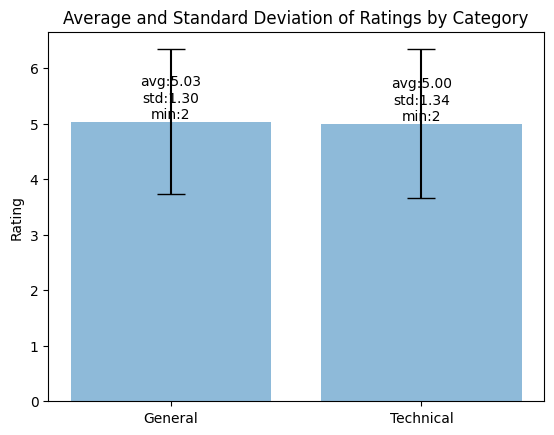

In [ ]:
# visualize the ratings and cross-level analysis
import matplotlib.pyplot as plt
import numpy as np

len_general = len(general_test_idxs)
general_ratings = gpt_ratings[:len_general]
technical_ratings = gpt_ratings[len_general:]

general_average = np.mean(general_ratings)
general_std = np.std(general_ratings)
general_min = np.min(general_ratings)

technical_average = np.mean(technical_ratings)
technical_std = np.std(technical_ratings)
technical_min = np.min(technical_ratings)

categories = ['General', 'Technical']
averages = [general_average, technical_average]
std_devs = [general_std, technical_std]
mins = [general_min, technical_min]

bars = plt.bar(categories, averages, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Rating')
plt.title('Average and Standard Deviation of Ratings by Category')

# Adding the text (annotations) on the bars
for bar, avg, std, min_rating in zip(bars, averages, std_devs, mins):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'avg:{avg:.2f}\nstd:{std:.2f}\nmin:{min_rating}', ha='center', va='bottom')

plt.show()

In [ ]:
for i, r in zip(general_test_idxs, general_ratings):
  print(f"question index {i}: {qa_pairs[i]['question']} receives answer rating of {r}")

print('\n\n')

for i, r in zip(technical_test_idxs, technical_ratings):
  print(f"question index {i}: {qa_pairs[i]['question']} receives answer rating of {r}")

question index 758: What is the return value of the getPool function? receives answer rating of 6
question index 644: In what context is it safe to assume a 1:1 exchange rate for the closeFromLadle function? receives answer rating of 4
question index 811: How does the raiseFlag function work in the FlagsInterface? receives answer rating of 3
question index 421: What happens if you don't close your borrowing position after maturity in the Yield protocol? receives answer rating of 6
question index 196: What aspect of rounding has the Yield Protocol paid special attention to? receives answer rating of 6
question index 698: What are the return values of the divu function? receives answer rating of 6
question index 94: What should be done if the page is not loading? receives answer rating of 6
question index 44: What are fyTokens and how do they work? receives answer rating of 6
question index 340: What questions should guide the team in assessing the situation? receives answer rating of 6


In [ ]:
import json
from google.colab import drive
drive.mount('/content/drive/') # mount expires over a couple hours, beware.

url = f"/content/drive/MyDrive/SFT-assessment.jsonl"

sft_ratings = []
line_idx = 0
with open(url, 'r') as file:
  for line in file:
    raw = line.rstrip('\n')
    line_idx+=1
    assessment = json.loads(raw)
    sft_ratings.append(assessment['rating'])

Mounted at /content/drive/


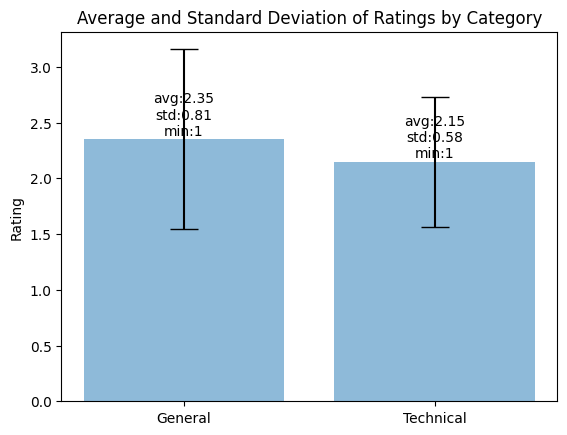

In [ ]:
# visualize the ratings and cross-level analysis
import matplotlib.pyplot as plt
import numpy as np

len_general = len(general_test_idxs)
general_ratings = sft_ratings[:len_general]
technical_ratings = sft_ratings[len_general:]

general_average = np.mean(general_ratings)
general_std = np.std(general_ratings)
general_min = np.min(general_ratings)

technical_average = np.mean(technical_ratings)
technical_std = np.std(technical_ratings)
technical_min = np.min(technical_ratings)

categories = ['General', 'Technical']
averages = [general_average, technical_average]
std_devs = [general_std, technical_std]
mins = [general_min, technical_min]

bars = plt.bar(categories, averages, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Rating')
plt.title('Average and Standard Deviation of Ratings by Category')

# Adding the text (annotations) on the bars
for bar, avg, std, min_rating in zip(bars, averages, std_devs, mins):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'avg:{avg:.2f}\nstd:{std:.2f}\nmin:{min_rating}', ha='center', va='bottom')

plt.show()

## Save filtered dataset to temporary path

In [ ]:
# # will save the raw QA pairs in account for any new change in the question list, this does not filter the questions based on quality
# drive.mount('/content/drive/')
# url = f"/content/drive/MyDrive/qa_pairs.jsonl" # overwrite it
# with open(url, 'w') as outfile:
#     for qa_pair in qa_pairs:
#         json.dump(qa_pair, outfile)
#         outfile.write('\n')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
index = 1
with open(url, 'r') as file:
    for line in file: # parse into json
      raw = line.rstrip('\n')
      qadict = json.loads(raw)
      print(f"index: {index}, content: {qadict}")
      index+=1

In [ ]:
# url = f"/content/drive/MyDrive/qa_qualities.jsonl"

# with open(url, 'w') as outfile:
#   for i, qq in enumerate(question_qualities):
#     display(Markdown(f"[Question Index {i+1}]\n Quality:{qq}"))
#     json.dump(qq, outfile)
#     outfile.write('\n') # uninterruptable write

In [ ]:
index = 1
with open(url, 'r') as file:
    for line in file: # parse into json
      raw = line.rstrip('\n')
      qqdict = json.loads(raw)
      print(f"index: {index}, content: {qqdict}")
      index+=1

index: 1, content: {'reasoning': "The query is relevant and specific to Yield Protocol's documentation, as it directly relates to the protocol's main feature of fixed-rate borrowing and lending.", 'quality': 'good'}
index: 2, content: {'reasoning': "The query is directly related to Yield Protocol's documentation, specifically asking about fyTokens, which are a fundamental part of the protocol.", 'quality': 'good'}
index: 3, content: {'reasoning': "This query is directly related to the Yield Protocol's documentation, specifically the section on fyTokens and their interest payment mechanism.", 'quality': 'good'}
index: 4, content: {'reasoning': "The query is directly related to the Yield Protocol's documentation, specifically to the section that explains how fyTokens work and how the interest rate is calculated.", 'quality': 'good'}
index: 5, content: {'reasoning': "This query is relevant and specific to Yield Protocol's documentation. It directly refers to fyTokens, a key component of Y

In [ ]:
# # this will only export the good data in the pipeline, test rating is saved elsewhere to prevent redundancy in json fields.
# drive.mount('/content/drive/')
# url = f"/content/drive/MyDrive/qa_pairs_refined.jsonl" # overwrite it
# with open(url, 'w') as outfile:
#     for qa_pair in qa_pairs:
#         json.dump(qa_pair, outfile)
#         outfile.write('\n')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
index = 1
with open(url, 'r') as file:
    for line in file: # parse into json
      raw = line.rstrip('\n')
      qadict = json.loads(raw)
      print(f"index: {index}, content: {qadict}")
      index+=1

index: 1, content: {'question': 'What is the main advantage of fixed-rate borrowing and lending over floating-rate?', 'answer': "The main advantage of fixed-rate borrowing and lending over floating-rate is predictability and risk management. \n\nWith fixed-rate borrowing, the borrower knows exactly what their interest rate will be for the entire duration of the loan. This allows them to plan their finances more accurately and avoid unexpected increases in interest payments if market rates rise. \n\nOn the lending side, fixed-rate lending provides a guaranteed return on investment, regardless of how market interest rates fluctuate. This can be particularly beneficial in a falling interest rate environment, where the lender would continue to earn the higher fixed interest rate agreed upon at the start of the loan.\n\nIn contrast, floating-rate borrowing and lending can be more unpredictable as the interest rates can fluctuate over time based on market conditions. This could potentially l